# Filament initialization in a sphere

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from numba import jit
rng = np.random.default_rng() # initialize generator instance
from mpl_toolkits import mplot3d # for vizualization
%matplotlib notebook
from time import time

This is a filament initializer that places the center points of filaments inside a sphere. If a constant director is chosen, this can lead to a tactoid-like configuration of filaments.

Author: Saad J. Ansari (2020)

In [2]:
# Define some constants
R = 0.64 # radius of sphere (micron)
vol_sphere = (4./3.) * math.pi * R**3
n_fil = 25600
use_pack_frac = False
pack_frac = 0.3 # packing fraction (volume of filaments inside sphere/total volume of sphere)

D = 0.007 # diameter of filaments (micron)
director = np.array([0, 0, 1]) # director vector (CAN BE RANDOMIZED)
Lmin = 0.09 # minimum length of filaments
Lmax = 0.28 # maximum length of filaments
Lmean = 0.18 # mean length of filaments
use_exp_filament_length = True # flag to sample from an exponential distribution of lengths (cutoff with Lmin and Lmax)

#fname = './TubuleInitial_25600_poly.dat'
fname = './test.dat'
write_file = True
run_visualization = True
run_tests = False
system_offset = [2.5,2.5,2.5]

### Description:

We do this in the following way:
* Randomly sample $(x,y,z)$ where $x,y,z \in [-R,R]$ such that $x^2 + y^2 + z^2 < R^2$
* Attempt to add a filament at the sampled position:
    * Check for minimum distance to all pre-existing filaments.
    * If minimum distance is less than the filament diameter $D$, a filament instance is created and **successfully added** to a filament list.
    * If minimum distance condition is not met, the filament is **not added** to the list.
    * If a filament is added successfully, we continue. Otherwise, we sample another point and attempt a filament addition before proceeding.
* Once a filament is added, we calculate the a packing fraction for the system (if enabled).
* The steps above are repeated. The program stops when:
    * The specified number of filaments are attained, or an addition attempt fails 5000 consecutive times.
    * The specified packing fraction is attained (if enabled)

We begin by creating the machinery to achieve this.

1. **Filament( )** (class): Useful way to store information (start pt, end pt, gid, length, director) about a given filament. The choice of a class is natural when multiple instances need to be created.


2. **minDistBetweenTwoFil( )**: Calculates the minimum distance between two filaments. It parametrizes the filaments with $(s,t)$ and seeks a global minimum of $W(s,t)$, the squared distance between any two points on the two lines. If the global minimum lies outside the range of $s$ and $t$ ($s \in [0,1]$, $t \in [0,1]$), then it checks all the edges for a minimum distance. It works for both parallel and non-parallel, overlapping and skew filaments. This is adapted from http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment.


3. **minDistFilAll( )**: Calcutes the minimum distance between a single filament and a list of filaments. It loops over all filaments in the list and uses *minDistBetweenTwoFil()* to evaluate pair-pair distances. 


4. **getLengthRandomExp( )**: samples a value from an exponential distribution with min and max cutoffs for the values. We use this to sample filament lengths if enabled.


5. **sph2cart**/**cart2sph**:  transformations between cartesian and spherical coordinates.


6. **getFilamentLengthInsideSphere( )**: finds the length of a filament that lies inside a spherical region. It does that by getting points along a filament and checking their radial coordinate (in the spherical coordinate system). This gives an enclosed length of a filament which can be used to calculate an enclosed volume.

7. **getRand3PointInSphere( )**: get a random point in 3D space that is inside the sphere of some specified radius.

### Notes:

* The packing fraction calculation uses the value inside the initialization sphere. We assume that this is an accurate representation of the packing fraction throughout the system.
* The code can be easily modified to get an isotropic initial condition (randomly sample the director vector)

### Code:

In [3]:
# Define a filament class
class Filament():
    def __init__(self, center, director, leng, radius):
        self.center = center
        self.director = director/ np.linalg.norm(director)
        self.length = leng
        self.radius = radius
        self.pos_start = center - leng/2 * self.director
        self.pos_end = center + leng/2 * self.director
        self.gid = gid # defined outisde the class
    def Plot3(self,ax):
        ax.plot3D( [self.pos_start[0], self.pos_end[0]], [self.pos_start[1], self.pos_end[1]], [self.pos_start[2], self.pos_end[2]], 'red')
    def GetStringtoWrite(self):
        return 'C {0} {1} {2:0.6f} {3:0.6f} {4:0.6f} {5:0.6f} {6:0.6f} {7:0.6f}\n'.format(
        self.gid, self.radius,
        self.pos_start[0], self.pos_start[1], self.pos_start[2],
        self.pos_end[0], self.pos_end[1], self.pos_end[2])
    def __repr__(self):
        return "Filament()"
    def __str__(self):
        return 'Filament {0}:\n  pos_start: {1}\n  pos_end: {2}\n  length: {3}\n  radius: {4}'.format(self.gid, self.pos_start, self.pos_end, self.length,self.radius)

In [4]:
# Find Minimum Distance between two filaments
@jit
def minDistBetweenTwoFil(p1, p2, p3, p4):
    # Adapted from matlab
    # https://www.mathworks.com/matlabcentral/fileexchange/32487-shortest-distance-between-two-line-segments
    # which adapted this from Dan Sunday's Geometry Algorithms originally written in C++
    # http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment
    
    # p1 = f1.pos_start
    # p2 = f1.pos_end
    # p3 = f2.pos_start
    # p4 = f2.pos_end
    # Computes the minimum distance between two line segments. Code
    # is adapted for Matlab from Dan Sunday's Geometry Algorithms originally
    # written in C++
    # http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment
    # Usage: Input the start and end x,y,z coordinates for two line segments. 
    # p1, p2 are [x,y,z] coordinates of first line segment and p3,p4 are for
    # second line segment. 
    # Output: scalar minimum distance between the two segments.
    #  Example:
    #	P1 = [0 0 0];     P2 = [1 0 0];
    #   P3 = [0 1 0];     P4 = [1 1 0];
    #	dist = minDistBetweenTwoFil(P1, P2, P3, P4)
    #p1 = f1.pos_start
    #p2 = f1.pos_end
    #p3 = f2.pos_start
    #p4 = f2.pos_end
    
    u = p1 - p2
    v = p3 - p4
    w = p2 - p4
    
    a = np.dot(u,u)
    b = np.dot(u,v)
    c = np.dot(v,v)
    d = np.dot(u,w)
    e = np.dot(v,w)
    D = a*c - b*b
    sD = D
    tD = D
    
    SMALL_NUM = 0.00000001
    
    # compute the line parameters of the two closest points
    if D < SMALL_NUM: # the lines are almost parallel
        sN = 0.0     # force using point P0 on segment S1
        sD = 1.0     # to prevent possible division by 0.0 later
        tN = e
        tD = c
    else:             # get the closest points on the infinite lines
        sN = (b*e - c*d)
        tN = (a*e - b*d)
        if sN < 0.0:   # sc < 0 => the s=0 edge is visible       
            sN = 0.0
            tN = e
            tD = c
        elif sN > sD:  # sc > 1 => the s=1 edge is visible
            sN = sD
            tN = e + b
            tD = c
    
    if tN < 0.0:            # tc < 0 => the t=0 edge is visible
        tN = 0.0
        # recompute sc for this edge
        if -d < 0.0:
            sN = 0.0
        elif -d > a:
            sN = sD
        else:
            sN = -d
            sD = a
    elif tN > tD:       # tc > 1 => the t=1 edge is visible
        tN = tD
        # recompute sc for this edge
        if -d + b < 0.0:
            sN = 0
        elif -d + b > a:
            sN = sD
        else: 
            sN = -d + b
            sD = a
    
    # finally do the division to get sc and tc
    if  np.absolute(sN) < SMALL_NUM:
        sc = 0.0
    else:
        sc = sN / sD
    
    if np.absolute(tN) < SMALL_NUM:
        tc = 0.0
    else:
        tc = tN / tD
    
    # get the difference of the two closest points
    dP = w + (sc * u) - (tc * v);  # = S1(sc) - S2(tc)
    distance = np.linalg.norm(dP);
    outV = dP;
    
    # outV = outV      # vector connecting the closest points
    # cp_1 = p2+sc*u  # Closest point on object 1 
    # cp_2 = p4+tc*v  # Closest point on object 2
    
    return distance

In [5]:
# Define a Minimum Distance from one filament to all other filaments
def minDistFilAll( f1, f_list):
    dists = [ minDistBetweenTwoFil(f1,f2) for f2 in f_list]
    if not dists:
        return 1e6
    else:
        return np.min(dists)

In [6]:
def check_fil_overlap(fil, fil_list, min_dist_bound):
    min_dist = 1e6
    for fil_check in fil_list:
        check_dist = minDistBetweenTwoFil(fil.pos_start, fil.pos_end,
                                          fil_check.pos_start, fil_check.pos_end)
        min_dist = check_dist if check_dist < min_dist else min_dist
        if min_dist < min_dist_bound:
            return False
    return True

In [7]:
# Define a random length sampler
def getLengthRandomExp( rng, Lmean, Lmin=0, Lmax=1e6):
    val = -1
    while val < Lmin or val > Lmax:
        val = rng.exponential( Lmean)
    return val

In [8]:
# polar to cartesian coordinates
def sph2cart(r, phi, theta):
    return np.array([
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ])
# cartesian to polar coordinates
def cart2sph(x, y, z):
    XsqPlusYsq = x**2 + y**2
    r = math.sqrt(XsqPlusYsq + z**2)               # r
    elev = math.atan2(z,math.sqrt(XsqPlusYsq))     # theta
    az = math.atan2(y,x)                           # phi
    return np.array([r, az, elev])

In [9]:
# volume of filament inside sphere
def getFilamentLengthInsideSphere(f1, rad):
    
    # Find coordinates along the filament whose r coord in (r,phi, theta) lies inside the sphere.
    # Segment the filament into 100 points
    lens = np.linspace(0, f1.length, 100)
    num_in = 0
    for el in lens:
        [x,y,z] = f1.pos_start + el*f1.director
        pt = cart2sph(x,y,z)
        if pt[0] < rad:
            num_in += 1
        
    return (num_in/100)*f1.length

In [10]:
# Get random 3d cartesian point() inside sphere
def getRand3PointInSphere(rad):
    d = 2*rad
    while d > rad:
        xyz = rng.uniform(-rad, rad, 3)
        d = np.linalg.norm(xyz)
    return [xyz[0],xyz[1],xyz[2]]

#    radius = np.random.uniform(0.0,1.0)*rad 
#    theta = np.random.uniform(-1.0,1.0)*math.pi
#    phi = np.arccos(1-2*np.random.uniform(0.0,1.))
#    x = radius * np.sin( theta ) * np.cos( phi )
#    y = radius * np.sin( theta ) * np.sin( phi )
#    z = radius * np.cos( theta )
#    return [x,y,z]

We start with a sphere with radius R. We randomly pick values (r,phi, theta) that define the position of a point in 3D space. We attempt to insert a filament with that point as its center. If the minimum distance between this filament and any other filaments is greater than diameter D of the filaments (i.e filaments do not overlap), we successfully complete the insertion. If insertion fails, we try a new point.

In [11]:
def attemptAddFilament(center, L, director, D, f_list, gid):
    # Initialize a  filament of length L
    fil = Filament(center, director, L, D*.5)
    
    # find minimum distance to other filaments, and accept if distance is more than filament diameter
    #min_dist = minDistFilAll(fil, f_list)
    status = check_fil_overlap(fil, f_list, D)
    if status:
        f_list.append(fil)
        gid+=1
        print(fil)
    return f_list, gid, status

In [12]:
# There are two ways to go about this.
# 1. Attempt to achieve a specified packing fraction
# 2. Attempt to initialize a specified number of rods
t0 = time()
gid = 0
f_list = [] # list to store filaments
if use_pack_frac:
    
    v_enclosed = 0 # volume occupied by filaments inside the sphere
    cpf = 0 # current packing fraction tracker
    while cpf < pack_frac:
        center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
        
        if use_exp_filament_length:
            L = getLengthRandomExp( rng, Lmean, Lmin, Lmax)
        else:
            L = Lmean
            
        f_list,gid,status = attemptAddFilament(center,L,director, D, f_list, gid)
        if status:
            len_inside = getFilamentLengthInsideSphere( f_list[-1], R) # length of filament inside the sphere
            v_enclosed += math.pi * (D/2)**2 * len_inside # volume of filament inside the sphere
            cpf = v_enclosed / vol_sphere # current packing fraction
            print('CPF = {}'.format(cpf))

    
else:
    
    # sample n_fil length values and sort them
    if use_exp_filament_length:
        lens = sorted( [getLengthRandomExp( rng, Lmean, Lmin, Lmax) for i in range(n_fil)], reverse=True)
    else:
        lens = [Lmean for i in range(n_fil)]
        
    for idx,el in enumerate(lens):
        status = False
        failCount=0
        while not status:
            failCount+=1
            center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
            f_list,gid,status = attemptAddFilament(center, el, director, D, f_list, gid)
            if failCount > 5000:
                raise Exception('Failed to add a filament with 5000 trials.\nStopping...\n...\n...\n Total Added Filaments = {}'.format(len(f_list)))
t1 = time()
print("total time: ", (t1-t0))

Filament 0:
  pos_start: [-0.34346317  0.05571504 -0.00202765]
  pos_end: [-0.34346317  0.05571504  0.27794092]
  length: 0.27996857023861876
  radius: 0.0035
Filament 1:
  pos_start: [ 0.13164785  0.2080824  -0.65670177]
  pos_end: [ 0.13164785  0.2080824  -0.37673644]
  length: 0.2799653357992466
  radius: 0.0035
Filament 2:
  pos_start: [ 0.10303526 -0.22839597 -0.46173237]
  pos_end: [ 0.10303526 -0.22839597 -0.18176935]
  length: 0.2799630108968642
  radius: 0.0035
Filament 3:
  pos_start: [-0.28244273  0.34821478 -0.32915288]
  pos_end: [-0.28244273  0.34821478 -0.049195  ]
  length: 0.27995787615602663
  radius: 0.0035
Filament 4:
  pos_start: [0.45763997 0.13689832 0.10114641]
  pos_end: [0.45763997 0.13689832 0.38106697]
  length: 0.2799205644183526
  radius: 0.0035
Filament 5:
  pos_start: [ 0.5433548  -0.18841315 -0.2716434 ]
  pos_end: [ 0.5433548  -0.18841315  0.0082743 ]
  length: 0.2799177009409469
  radius: 0.0035
Filament 6:
  pos_start: [-0.23633701 -0.44219681  0.182

Filament 287:
  pos_start: [0.48217707 0.23769002 0.07044176]
  pos_end: [0.48217707 0.23769002 0.34671092]
  length: 0.27626915741535457
  radius: 0.0035
Filament 288:
  pos_start: [ 0.12761351  0.2515681  -0.17629226]
  pos_end: [0.12761351 0.2515681  0.09995128]
  length: 0.2762435333420896
  radius: 0.0035
Filament 289:
  pos_start: [ 0.30928434 -0.45306052 -0.22545514]
  pos_end: [ 0.30928434 -0.45306052  0.05077317]
  length: 0.27622830748337607
  radius: 0.0035
Filament 290:
  pos_start: [0.39203341 0.37707875 0.10171178]
  pos_end: [0.39203341 0.37707875 0.37792115]
  length: 0.2762093740754929
  radius: 0.0035
Filament 291:
  pos_start: [-0.34258467 -0.07715348 -0.15508934]
  pos_end: [-0.34258467 -0.07715348  0.12111079]
  length: 0.2762001217343164
  radius: 0.0035
Filament 292:
  pos_start: [-0.02853628 -0.47571428  0.28448314]
  pos_end: [-0.02853628 -0.47571428  0.56067112]
  length: 0.2761879824454423
  radius: 0.0035
Filament 293:
  pos_start: [ 0.46780374 -0.09895774 -

Filament 488:
  pos_start: [-0.05980265  0.05001524 -0.27892331]
  pos_end: [-0.05980265  0.05001524 -0.00513196]
  length: 0.273791343758888
  radius: 0.0035
Filament 489:
  pos_start: [ 0.33874653  0.1787186  -0.33742071]
  pos_end: [ 0.33874653  0.1787186  -0.06362964]
  length: 0.27379107031241456
  radius: 0.0035
Filament 490:
  pos_start: [-0.12355527 -0.40532863  0.27914926]
  pos_end: [-0.12355527 -0.40532863  0.55293109]
  length: 0.2737818284791171
  radius: 0.0035
Filament 491:
  pos_start: [-0.41925652  0.06991287  0.19752711]
  pos_end: [-0.41925652  0.06991287  0.47130418]
  length: 0.27377707011593516
  radius: 0.0035
Filament 492:
  pos_start: [ 0.42410433  0.27944565 -0.05351973]
  pos_end: [0.42410433 0.27944565 0.2202299 ]
  length: 0.27374962300865185
  radius: 0.0035
Filament 493:
  pos_start: [-0.50419364  0.12817284 -0.41942669]
  pos_end: [-0.50419364  0.12817284 -0.14567806]
  length: 0.2737486297834255
  radius: 0.0035
Filament 494:
  pos_start: [-0.08188193 -

Filament 639:
  pos_start: [-0.33238507  0.28770982 -0.05035501]
  pos_end: [-0.33238507  0.28770982  0.22155992]
  length: 0.2719149303948854
  radius: 0.0035
Filament 640:
  pos_start: [ 0.40300822 -0.19905847 -0.18480138]
  pos_end: [ 0.40300822 -0.19905847  0.08710226]
  length: 0.2719036443941063
  radius: 0.0035
Filament 641:
  pos_start: [-0.38305135  0.46026856  0.0606663 ]
  pos_end: [-0.38305135  0.46026856  0.33256301]
  length: 0.2718967147826479
  radius: 0.0035
Filament 642:
  pos_start: [ 0.23610764  0.26371824 -0.55074213]
  pos_end: [ 0.23610764  0.26371824 -0.27885679]
  length: 0.27188534474119597
  radius: 0.0035
Filament 643:
  pos_start: [-0.23184147 -0.12173116 -0.48299804]
  pos_end: [-0.23184147 -0.12173116 -0.21111829]
  length: 0.2718797520025838
  radius: 0.0035
Filament 644:
  pos_start: [ 0.06991014  0.29392952 -0.60234599]
  pos_end: [ 0.06991014  0.29392952 -0.3304684 ]
  length: 0.2718775970918402
  radius: 0.0035
Filament 645:
  pos_start: [-0.42596598

Filament 771:
  pos_start: [ 0.11685042 -0.5427089  -0.11567252]
  pos_end: [ 0.11685042 -0.5427089   0.15467493]
  length: 0.27034745505819907
  radius: 0.0035
Filament 772:
  pos_start: [-0.22617144 -0.27701428 -0.65285643]
  pos_end: [-0.22617144 -0.27701428 -0.38251022]
  length: 0.27034620834590856
  radius: 0.0035
Filament 773:
  pos_start: [-0.01582619 -0.25406793  0.18698732]
  pos_end: [-0.01582619 -0.25406793  0.45733122]
  length: 0.2703438982627731
  radius: 0.0035
Filament 774:
  pos_start: [-0.42290069 -0.30176339 -0.16040574]
  pos_end: [-0.42290069 -0.30176339  0.10993659]
  length: 0.2703423295679377
  radius: 0.0035
Filament 775:
  pos_start: [ 0.22273554  0.41069386 -0.00830332]
  pos_end: [0.22273554 0.41069386 0.26202733]
  length: 0.270330654233189
  radius: 0.0035
Filament 776:
  pos_start: [-0.21818298 -0.27191236  0.35801375]
  pos_end: [-0.21818298 -0.27191236  0.62834263]
  length: 0.2703288862508936
  radius: 0.0035
Filament 777:
  pos_start: [ 0.12548894 -0

Filament 876:
  pos_start: [ 0.27941533  0.09468959 -0.21708227]
  pos_end: [0.27941533 0.09468959 0.05191814]
  length: 0.2690004122663178
  radius: 0.0035
Filament 877:
  pos_start: [ 0.05810042  0.0541425  -0.76603184]
  pos_end: [ 0.05810042  0.0541425  -0.49703237]
  length: 0.2689994723839564
  radius: 0.0035
Filament 878:
  pos_start: [ 0.5873396  -0.02683806 -0.2192118 ]
  pos_end: [ 0.5873396  -0.02683806  0.04978318]
  length: 0.26899498408871914
  radius: 0.0035
Filament 879:
  pos_start: [-0.20422847  0.23072089  0.40797463]
  pos_end: [-0.20422847  0.23072089  0.67696556]
  length: 0.2689909300422295
  radius: 0.0035
Filament 880:
  pos_start: [ 0.38515549 -0.08208502 -0.33507825]
  pos_end: [ 0.38515549 -0.08208502 -0.0660966 ]
  length: 0.26898165237509625
  radius: 0.0035
Filament 881:
  pos_start: [-0.1902397   0.4370652  -0.28510235]
  pos_end: [-0.1902397   0.4370652  -0.01612463]
  length: 0.2689777144107213
  radius: 0.0035
Filament 882:
  pos_start: [-0.18789467 -

Filament 981:
  pos_start: [-0.29673899 -0.34352708 -0.17187129]
  pos_end: [-0.29673899 -0.34352708  0.09586755]
  length: 0.26773883839125867
  radius: 0.0035
Filament 982:
  pos_start: [ 0.03017637 -0.0687296   0.25667206]
  pos_end: [ 0.03017637 -0.0687296   0.52440873]
  length: 0.26773667640847243
  radius: 0.0035
Filament 983:
  pos_start: [-0.3179695   0.44759598  0.12144983]
  pos_end: [-0.3179695   0.44759598  0.38918304]
  length: 0.26773321368910125
  radius: 0.0035
Filament 984:
  pos_start: [ 0.06520996  0.07011612 -0.27883198]
  pos_end: [ 0.06520996  0.07011612 -0.01110386]
  length: 0.26772811741778135
  radius: 0.0035
Filament 985:
  pos_start: [-0.13805541 -0.14341555 -0.72188362]
  pos_end: [-0.13805541 -0.14341555 -0.45416449]
  length: 0.2677191282140164
  radius: 0.0035
Filament 986:
  pos_start: [0.18769456 0.41583964 0.13054575]
  pos_end: [0.18769456 0.41583964 0.39826207]
  length: 0.2677163204491807
  radius: 0.0035
Filament 987:
  pos_start: [ 0.09389378  0

Filament 1079:
  pos_start: [-0.29795545  0.18044439 -0.66392578]
  pos_end: [-0.29795545  0.18044439 -0.39733976]
  length: 0.2665860208394819
  radius: 0.0035
Filament 1080:
  pos_start: [ 0.31495411  0.18805487 -0.55845412]
  pos_end: [ 0.31495411  0.18805487 -0.29187114]
  length: 0.2665829746118249
  radius: 0.0035
Filament 1081:
  pos_start: [-0.58769503 -0.04713813 -0.07653879]
  pos_end: [-0.58769503 -0.04713813  0.19003285]
  length: 0.26657163307258935
  radius: 0.0035
Filament 1082:
  pos_start: [ 0.2101072   0.33972266 -0.49386999]
  pos_end: [ 0.2101072   0.33972266 -0.22732494]
  length: 0.2665450447602156
  radius: 0.0035
Filament 1083:
  pos_start: [ 0.34933999 -0.0155505  -0.23051178]
  pos_end: [ 0.34933999 -0.0155505   0.03600304]
  length: 0.26651482381520014
  radius: 0.0035
Filament 1084:
  pos_start: [ 0.0540729   0.1624313  -0.44100005]
  pos_end: [ 0.0540729   0.1624313  -0.17448544]
  length: 0.2665146089038765
  radius: 0.0035
Filament 1085:
  pos_start: [-0.

Filament 1170:
  pos_start: [ 0.14852439  0.50563302 -0.35937596]
  pos_end: [ 0.14852439  0.50563302 -0.09391585]
  length: 0.2654601143133281
  radius: 0.0035
Filament 1171:
  pos_start: [ 0.21640433  0.47383763 -0.30328051]
  pos_end: [ 0.21640433  0.47383763 -0.03782924]
  length: 0.26545126412145204
  radius: 0.0035
Filament 1172:
  pos_start: [ 0.17836999 -0.16046495  0.20357707]
  pos_end: [ 0.17836999 -0.16046495  0.46901816]
  length: 0.2654410918021592
  radius: 0.0035
Filament 1173:
  pos_start: [-0.49175571  0.34259604 -0.01115756]
  pos_end: [-0.49175571  0.34259604  0.25426826]
  length: 0.2654258185606005
  radius: 0.0035
Filament 1174:
  pos_start: [-0.28738011 -0.13244012  0.00139646]
  pos_end: [-0.28738011 -0.13244012  0.26681356]
  length: 0.2654170934973461
  radius: 0.0035
Filament 1175:
  pos_start: [ 0.40407973  0.2030727  -0.19262833]
  pos_end: [0.40407973 0.2030727  0.07278373]
  length: 0.26541206352998464
  radius: 0.0035
Filament 1176:
  pos_start: [ 0.147

Filament 1256:
  pos_start: [0.31969658 0.32065064 0.01046454]
  pos_end: [0.31969658 0.32065064 0.27506476]
  length: 0.26460022315271475
  radius: 0.0035
Filament 1257:
  pos_start: [ 0.10099947 -0.11470136  0.35609228]
  pos_end: [ 0.10099947 -0.11470136  0.62068518]
  length: 0.26459290289997167
  radius: 0.0035
Filament 1258:
  pos_start: [-0.19495397  0.21529322  0.21821677]
  pos_end: [-0.19495397  0.21529322  0.4827921 ]
  length: 0.2645753296574536
  radius: 0.0035
Filament 1259:
  pos_start: [-0.44756053 -0.36184777 -0.22190014]
  pos_end: [-0.44756053 -0.36184777  0.0426718 ]
  length: 0.2645719418050575
  radius: 0.0035
Filament 1260:
  pos_start: [ 0.22016501 -0.10830093  0.04982425]
  pos_end: [ 0.22016501 -0.10830093  0.31436295]
  length: 0.26453869452279555
  radius: 0.0035
Filament 1261:
  pos_start: [-0.18615806  0.38066859  0.0359893 ]
  pos_end: [-0.18615806  0.38066859  0.30050936]
  length: 0.2645200566106927
  radius: 0.0035
Filament 1262:
  pos_start: [-0.49753

Filament 1332:
  pos_start: [-0.23350651  0.02235977 -0.69952105]
  pos_end: [-0.23350651  0.02235977 -0.43587328]
  length: 0.2636477622964793
  radius: 0.0035
Filament 1333:
  pos_start: [ 0.14978354  0.39261948 -0.44780082]
  pos_end: [ 0.14978354  0.39261948 -0.18417563]
  length: 0.2636251871098316
  radius: 0.0035
Filament 1334:
  pos_start: [-0.43747243 -0.25848103  0.24387102]
  pos_end: [-0.43747243 -0.25848103  0.50746961]
  length: 0.2635985822673186
  radius: 0.0035
Filament 1335:
  pos_start: [ 0.31121602 -0.29755516 -0.29047426]
  pos_end: [ 0.31121602 -0.29755516 -0.0268821 ]
  length: 0.2635921591036383
  radius: 0.0035
Filament 1336:
  pos_start: [ 0.19463038 -0.26065926  0.39674597]
  pos_end: [ 0.19463038 -0.26065926  0.66031441]
  length: 0.2635684457125535
  radius: 0.0035
Filament 1337:
  pos_start: [-0.392121    0.44088808  0.10906643]
  pos_end: [-0.392121    0.44088808  0.37262078]
  length: 0.26355434741685424
  radius: 0.0035
Filament 1338:
  pos_start: [-0.0

Filament 1406:
  pos_start: [-0.0673093  -0.23534968 -0.18191498]
  pos_end: [-0.0673093  -0.23534968  0.08081865]
  length: 0.26273363110801345
  radius: 0.0035
Filament 1407:
  pos_start: [-0.59621004  0.01537336  0.00139524]
  pos_end: [-0.59621004  0.01537336  0.26412645]
  length: 0.2627312082341129
  radius: 0.0035
Filament 1408:
  pos_start: [0.21371757 0.38171129 0.06523253]
  pos_end: [0.21371757 0.38171129 0.32796068]
  length: 0.26272814719748905
  radius: 0.0035
Filament 1409:
  pos_start: [ 0.52609219 -0.08848859 -0.28928626]
  pos_end: [ 0.52609219 -0.08848859 -0.02655881]
  length: 0.26272744687079236
  radius: 0.0035
Filament 1410:
  pos_start: [-0.25391808  0.33115586 -0.13991221]
  pos_end: [-0.25391808  0.33115586  0.12280653]
  length: 0.2627187392640555
  radius: 0.0035
Filament 1411:
  pos_start: [-0.17448827  0.21963575  0.04777016]
  pos_end: [-0.17448827  0.21963575  0.31048875]
  length: 0.26271859685778853
  radius: 0.0035
Filament 1412:
  pos_start: [-0.5004

Filament 1477:
  pos_start: [0.14470415 0.05977106 0.15235136]
  pos_end: [0.14470415 0.05977106 0.41430104]
  length: 0.2619496816079256
  radius: 0.0035
Filament 1478:
  pos_start: [ 0.26116425 -0.07955123 -0.43355665]
  pos_end: [ 0.26116425 -0.07955123 -0.17162079]
  length: 0.2619358636755975
  radius: 0.0035
Filament 1479:
  pos_start: [0.14985764 0.22504276 0.02152294]
  pos_end: [0.14985764 0.22504276 0.28345684]
  length: 0.2619339021392534
  radius: 0.0035
Filament 1480:
  pos_start: [-0.59245032  0.08514129  0.07930817]
  pos_end: [-0.59245032  0.08514129  0.34122659]
  length: 0.2619184214874256
  radius: 0.0035
Filament 1481:
  pos_start: [ 0.30861947 -0.42951897 -0.19962805]
  pos_end: [ 0.30861947 -0.42951897  0.06228949]
  length: 0.26191753767832804
  radius: 0.0035
Filament 1482:
  pos_start: [-0.2638776   0.25120959  0.273887  ]
  pos_end: [-0.2638776   0.25120959  0.5357936 ]
  length: 0.26190660339716515
  radius: 0.0035
Filament 1483:
  pos_start: [ 0.58098392  0.

Filament 1549:
  pos_start: [-0.3428087   0.47267867 -0.3919832 ]
  pos_end: [-0.3428087   0.47267867 -0.13092459]
  length: 0.261058616061707
  radius: 0.0035
Filament 1550:
  pos_start: [-0.08438913  0.54773228  0.14139536]
  pos_end: [-0.08438913  0.54773228  0.40242395]
  length: 0.26102859534030776
  radius: 0.0035
Filament 1551:
  pos_start: [ 0.12162197  0.15969085 -0.1393357 ]
  pos_end: [0.12162197 0.15969085 0.12169048]
  length: 0.2610261739983857
  radius: 0.0035
Filament 1552:
  pos_start: [-0.32908819 -0.12381947  0.30436073]
  pos_end: [-0.32908819 -0.12381947  0.56536178]
  length: 0.2610010488406996
  radius: 0.0035
Filament 1553:
  pos_start: [0.02104302 0.24288513 0.25004634]
  pos_end: [0.02104302 0.24288513 0.51102956]
  length: 0.2609832202592038
  radius: 0.0035
Filament 1554:
  pos_start: [0.41248169 0.31663635 0.12412076]
  pos_end: [0.41248169 0.31663635 0.38509197]
  length: 0.26097120757926967
  radius: 0.0035
Filament 1555:
  pos_start: [0.30132129 0.114042

Filament 1615:
  pos_start: [-0.13048199 -0.2000637  -0.70476292]
  pos_end: [-0.13048199 -0.2000637  -0.44448152]
  length: 0.26028140799496374
  radius: 0.0035
Filament 1616:
  pos_start: [-0.20995679 -0.2918876   0.26154801]
  pos_end: [-0.20995679 -0.2918876   0.52182173]
  length: 0.2602737201358617
  radius: 0.0035
Filament 1617:
  pos_start: [ 0.02525896  0.45062962 -0.19726794]
  pos_end: [0.02525896 0.45062962 0.06298696]
  length: 0.26025489219899817
  radius: 0.0035
Filament 1618:
  pos_start: [ 0.08374047  0.02691931 -0.19302605]
  pos_end: [0.08374047 0.02691931 0.06721263]
  length: 0.2602386752683177
  radius: 0.0035
Filament 1619:
  pos_start: [-0.44617148 -0.15801106  0.14600264]
  pos_end: [-0.44617148 -0.15801106  0.40622499]
  length: 0.2602223517641644
  radius: 0.0035
Filament 1620:
  pos_start: [-0.31002217 -0.26942018 -0.35368148]
  pos_end: [-0.31002217 -0.26942018 -0.09346349]
  length: 0.2602179986484607
  radius: 0.0035
Filament 1621:
  pos_start: [ 0.543347

Filament 1683:
  pos_start: [ 0.03498707 -0.05478626 -0.24819596]
  pos_end: [ 0.03498707 -0.05478626  0.0112048 ]
  length: 0.2594007577313256
  radius: 0.0035
Filament 1684:
  pos_start: [-0.30076576 -0.15665181  0.23897008]
  pos_end: [-0.30076576 -0.15665181  0.49834575]
  length: 0.25937566945929874
  radius: 0.0035
Filament 1685:
  pos_start: [ 0.22433036 -0.03436376  0.44667789]
  pos_end: [ 0.22433036 -0.03436376  0.70602517]
  length: 0.2593472855341505
  radius: 0.0035
Filament 1686:
  pos_start: [ 0.51759968 -0.30027013 -0.29848612]
  pos_end: [ 0.51759968 -0.30027013 -0.03913951]
  length: 0.2593466135143631
  radius: 0.0035
Filament 1687:
  pos_start: [-0.04354455  0.37659254 -0.5648197 ]
  pos_end: [-0.04354455  0.37659254 -0.30547464]
  length: 0.2593450607885931
  radius: 0.0035
Filament 1688:
  pos_start: [ 0.49569436  0.2342471  -0.28339858]
  pos_end: [ 0.49569436  0.2342471  -0.02405794]
  length: 0.25934064040630295
  radius: 0.0035
Filament 1689:
  pos_start: [-0.

Filament 1756:
  pos_start: [ 0.28047115 -0.17636799 -0.62672571]
  pos_end: [ 0.28047115 -0.17636799 -0.36812075]
  length: 0.2586049659819565
  radius: 0.0035
Filament 1757:
  pos_start: [-0.03073935 -0.13175725 -0.53782195]
  pos_end: [-0.03073935 -0.13175725 -0.27922269]
  length: 0.2585992543002866
  radius: 0.0035
Filament 1758:
  pos_start: [-0.45265188  0.12229682 -0.36610452]
  pos_end: [-0.45265188  0.12229682 -0.10753266]
  length: 0.2585718630180521
  radius: 0.0035
Filament 1759:
  pos_start: [ 0.16289277 -0.37244976 -0.07951002]
  pos_end: [ 0.16289277 -0.37244976  0.17905461]
  length: 0.25856462671464553
  radius: 0.0035
Filament 1760:
  pos_start: [-0.00853918  0.00209746 -0.47394712]
  pos_end: [-0.00853918  0.00209746 -0.21539352]
  length: 0.2585535967540638
  radius: 0.0035
Filament 1761:
  pos_start: [-0.17110207  0.21978424 -0.66783074]
  pos_end: [-0.17110207  0.21978424 -0.4093144 ]
  length: 0.25851634735798745
  radius: 0.0035
Filament 1762:
  pos_start: [-0.

Filament 1816:
  pos_start: [ 0.0588472  -0.00951021 -0.20138842]
  pos_end: [ 0.0588472  -0.00951021  0.05647874]
  length: 0.2578671624929056
  radius: 0.0035
Filament 1817:
  pos_start: [-0.4222035   0.03016393 -0.28693377]
  pos_end: [-0.4222035   0.03016393 -0.02906993]
  length: 0.25786383745482794
  radius: 0.0035
Filament 1818:
  pos_start: [-0.18903492  0.29436469  0.32872327]
  pos_end: [-0.18903492  0.29436469  0.58657861]
  length: 0.25785534051100195
  radius: 0.0035
Filament 1819:
  pos_start: [-0.48261292 -0.33361857 -0.30550781]
  pos_end: [-0.48261292 -0.33361857 -0.04767862]
  length: 0.25782919272581256
  radius: 0.0035
Filament 1820:
  pos_start: [ 0.3633744  -0.41583228  0.0945126 ]
  pos_end: [ 0.3633744  -0.41583228  0.35232436]
  length: 0.2578117647419635
  radius: 0.0035
Filament 1821:
  pos_start: [0.4992376  0.06703678 0.07121987]
  pos_end: [0.4992376  0.06703678 0.32903002]
  length: 0.25781015151296627
  radius: 0.0035
Filament 1822:
  pos_start: [-0.3673

Filament 1878:
  pos_start: [-0.41361279 -0.34017841  0.18467349]
  pos_end: [-0.41361279 -0.34017841  0.44185995]
  length: 0.2571864613322347
  radius: 0.0035
Filament 1879:
  pos_start: [0.10990752 0.1234715  0.10401147]
  pos_end: [0.10990752 0.1234715  0.36118962]
  length: 0.25717814822691637
  radius: 0.0035
Filament 1880:
  pos_start: [ 0.32993403  0.00987321 -0.28709026]
  pos_end: [ 0.32993403  0.00987321 -0.02991333]
  length: 0.25717693809293546
  radius: 0.0035
Filament 1881:
  pos_start: [ 0.17971405  0.22503828 -0.33815219]
  pos_end: [ 0.17971405  0.22503828 -0.08098217]
  length: 0.25717001553539587
  radius: 0.0035
Filament 1882:
  pos_start: [ 0.01157282 -0.61559329 -0.00737088]
  pos_end: [ 0.01157282 -0.61559329  0.24977577]
  length: 0.25714664752834604
  radius: 0.0035
Filament 1883:
  pos_start: [-0.05365347 -0.12039539  0.00403906]
  pos_end: [-0.05365347 -0.12039539  0.26118223]
  length: 0.25714316903230533
  radius: 0.0035
Filament 1884:
  pos_start: [ 0.122

Filament 1940:
  pos_start: [ 0.33964255  0.07339959 -0.26733519]
  pos_end: [ 0.33964255  0.07339959 -0.01094372]
  length: 0.2563914744896685
  radius: 0.0035
Filament 1941:
  pos_start: [-0.02187879  0.5129219  -0.25745792]
  pos_end: [-0.02187879  0.5129219  -0.00109535]
  length: 0.2563625717885057
  radius: 0.0035
Filament 1942:
  pos_start: [0.26829805 0.20320535 0.23438388]
  pos_end: [0.26829805 0.20320535 0.49073504]
  length: 0.2563511544880636
  radius: 0.0035
Filament 1943:
  pos_start: [-0.43949552  0.33784421 -0.3417796 ]
  pos_end: [-0.43949552  0.33784421 -0.08545929]
  length: 0.2563203044266759
  radius: 0.0035
Filament 1944:
  pos_start: [-0.09964735 -0.4097532  -0.03306824]
  pos_end: [-0.09964735 -0.4097532   0.22325206]
  length: 0.25632030253249266
  radius: 0.0035
Filament 1945:
  pos_start: [-0.1742686  -0.31548677 -0.42834728]
  pos_end: [-0.1742686  -0.31548677 -0.17203382]
  length: 0.25631346094601454
  radius: 0.0035
Filament 1946:
  pos_start: [-0.085724

Filament 2005:
  pos_start: [-0.42450489 -0.22821442 -0.51029317]
  pos_end: [-0.42450489 -0.22821442 -0.25470256]
  length: 0.25559061097710645
  radius: 0.0035
Filament 2006:
  pos_start: [ 0.18876966  0.2350361  -0.45123518]
  pos_end: [ 0.18876966  0.2350361  -0.19565505]
  length: 0.25558013238406874
  radius: 0.0035
Filament 2007:
  pos_start: [-0.43940154 -0.02153101 -0.47007154]
  pos_end: [-0.43940154 -0.02153101 -0.21449893]
  length: 0.2555726084195449
  radius: 0.0035
Filament 2008:
  pos_start: [-0.32036609  0.13228609 -0.27711245]
  pos_end: [-0.32036609  0.13228609 -0.02154333]
  length: 0.25556911579782676
  radius: 0.0035
Filament 2009:
  pos_start: [ 0.44437971 -0.25304524 -0.50421175]
  pos_end: [ 0.44437971 -0.25304524 -0.24865545]
  length: 0.2555563026804415
  radius: 0.0035
Filament 2010:
  pos_start: [ 0.23020617 -0.02636861  0.37145571]
  pos_end: [ 0.23020617 -0.02636861  0.62696335]
  length: 0.25550764113026003
  radius: 0.0035
Filament 2011:
  pos_start: [-

Filament 2060:
  pos_start: [-0.26063429  0.20443998  0.0263792 ]
  pos_end: [-0.26063429  0.20443998  0.28136109]
  length: 0.2549818900135983
  radius: 0.0035
Filament 2061:
  pos_start: [ 0.25625394  0.28188581 -0.16603718]
  pos_end: [0.25625394 0.28188581 0.08894011]
  length: 0.2549772933698161
  radius: 0.0035
Filament 2062:
  pos_start: [-0.36584977  0.46726032 -0.0509146 ]
  pos_end: [-0.36584977  0.46726032  0.20405302]
  length: 0.25496761826047104
  radius: 0.0035
Filament 2063:
  pos_start: [ 0.05360391 -0.14803027  0.25892131]
  pos_end: [ 0.05360391 -0.14803027  0.5138815 ]
  length: 0.25496019140054665
  radius: 0.0035
Filament 2064:
  pos_start: [-0.32511171 -0.44594745 -0.00155243]
  pos_end: [-0.32511171 -0.44594745  0.25340465]
  length: 0.2549570765300772
  radius: 0.0035
Filament 2065:
  pos_start: [-0.46218156 -0.05787966 -0.13362532]
  pos_end: [-0.46218156 -0.05787966  0.12132342]
  length: 0.25494874741052503
  radius: 0.0035
Filament 2066:
  pos_start: [-0.11

Filament 2158:
  pos_start: [-0.25747123 -0.12618079 -0.08694645]
  pos_end: [-0.25747123 -0.12618079  0.16698481]
  length: 0.2539312595172894
  radius: 0.0035
Filament 2159:
  pos_start: [ 0.02187803 -0.44925738 -0.07037893]
  pos_end: [ 0.02187803 -0.44925738  0.18355148]
  length: 0.25393041054151155
  radius: 0.0035
Filament 2160:
  pos_start: [ 0.21246922 -0.41072718 -0.54546346]
  pos_end: [ 0.21246922 -0.41072718 -0.29154306]
  length: 0.2539204006201976
  radius: 0.0035
Filament 2161:
  pos_start: [-0.27652322  0.41219709 -0.20440505]
  pos_end: [-0.27652322  0.41219709  0.04951398]
  length: 0.2539190239265881
  radius: 0.0035
Filament 2162:
  pos_start: [-0.03003111  0.44208886  0.22244337]
  pos_end: [-0.03003111  0.44208886  0.47635061]
  length: 0.253907238140257
  radius: 0.0035
Filament 2163:
  pos_start: [0.15340896 0.1237628  0.40823776]
  pos_end: [0.15340896 0.1237628  0.66214116]
  length: 0.2539034069882728
  radius: 0.0035
Filament 2164:
  pos_start: [ 0.36579551

Filament 2214:
  pos_start: [0.21962757 0.36786583 0.28830765]
  pos_end: [0.21962757 0.36786583 0.54171636]
  length: 0.2534087151258834
  radius: 0.0035
Filament 2215:
  pos_start: [ 0.18515369 -0.07637865 -0.65229251]
  pos_end: [ 0.18515369 -0.07637865 -0.39889725]
  length: 0.2533952675915273
  radius: 0.0035
Filament 2216:
  pos_start: [ 0.10766416 -0.10260305 -0.7183004 ]
  pos_end: [ 0.10766416 -0.10260305 -0.46492928]
  length: 0.2533711116405367
  radius: 0.0035
Filament 2217:
  pos_start: [ 0.53331675 -0.19405157  0.1614457 ]
  pos_end: [ 0.53331675 -0.19405157  0.41480739]
  length: 0.25336168841824225
  radius: 0.0035
Filament 2218:
  pos_start: [-0.29575399  0.32657641  0.26207141]
  pos_end: [-0.29575399  0.32657641  0.51542882]
  length: 0.2533574043980336
  radius: 0.0035
Filament 2219:
  pos_start: [-0.47204537  0.14459242 -0.09358831]
  pos_end: [-0.47204537  0.14459242  0.15976705]
  length: 0.25335535364026934
  radius: 0.0035
Filament 2220:
  pos_start: [ 0.543041

Filament 2268:
  pos_start: [-0.57562195 -0.10269751 -0.13215666]
  pos_end: [-0.57562195 -0.10269751  0.1207249 ]
  length: 0.2528815546771964
  radius: 0.0035
Filament 2269:
  pos_start: [-0.2692759  -0.02359772 -0.55082947]
  pos_end: [-0.2692759  -0.02359772 -0.29795492]
  length: 0.2528745505141742
  radius: 0.0035
Filament 2270:
  pos_start: [ 0.1534518  -0.10480059  0.30721861]
  pos_end: [ 0.1534518  -0.10480059  0.56008201]
  length: 0.2528634022901787
  radius: 0.0035
Filament 2271:
  pos_start: [-0.1148447   0.34506239 -0.06341656]
  pos_end: [-0.1148447   0.34506239  0.18943934]
  length: 0.25285589237044026
  radius: 0.0035
Filament 2272:
  pos_start: [ 0.04470786 -0.37181617  0.18729003]
  pos_end: [ 0.04470786 -0.37181617  0.44013995]
  length: 0.25284992318591076
  radius: 0.0035
Filament 2273:
  pos_start: [-0.13168011  0.36246004 -0.30477132]
  pos_end: [-0.13168011  0.36246004 -0.05192896]
  length: 0.2528423553364569
  radius: 0.0035
Filament 2274:
  pos_start: [ 0.

Filament 2364:
  pos_start: [ 0.33410823  0.44280481 -0.30328604]
  pos_end: [ 0.33410823  0.44280481 -0.05143869]
  length: 0.2518473491622337
  radius: 0.0035
Filament 2365:
  pos_start: [ 0.24678808  0.31575806 -0.1954034 ]
  pos_end: [0.24678808 0.31575806 0.05642303]
  length: 0.2518264232512493
  radius: 0.0035
Filament 2366:
  pos_start: [ 0.0147543 -0.4269899 -0.5398086]
  pos_end: [ 0.0147543  -0.4269899  -0.28798285]
  length: 0.25182575222916154
  radius: 0.0035
Filament 2367:
  pos_start: [-0.06638825 -0.15416842 -0.6683199 ]
  pos_end: [-0.06638825 -0.15416842 -0.41650437]
  length: 0.2518155297546682
  radius: 0.0035
Filament 2368:
  pos_start: [0.36829174 0.07249476 0.31868497]
  pos_end: [0.36829174 0.07249476 0.57049439]
  length: 0.2518094180789947
  radius: 0.0035
Filament 2369:
  pos_start: [-0.09169114 -0.05700602 -0.14425944]
  pos_end: [-0.09169114 -0.05700602  0.10754759]
  length: 0.2518070276491566
  radius: 0.0035
Filament 2370:
  pos_start: [ 0.20809213  0.4

Filament 2416:
  pos_start: [ 0.38170816 -0.12365171 -0.27094892]
  pos_end: [ 0.38170816 -0.12365171 -0.01968517]
  length: 0.2512637493591853
  radius: 0.0035
Filament 2417:
  pos_start: [-0.18939786  0.05852069  0.40937907]
  pos_end: [-0.18939786  0.05852069  0.66063698]
  length: 0.25125790514863877
  radius: 0.0035
Filament 2418:
  pos_start: [ 0.43158363  0.07548996 -0.28468321]
  pos_end: [ 0.43158363  0.07548996 -0.03344608]
  length: 0.25123712858878244
  radius: 0.0035
Filament 2419:
  pos_start: [-0.08352661 -0.15545253 -0.51854548]
  pos_end: [-0.08352661 -0.15545253 -0.26731729]
  length: 0.2512281851813146
  radius: 0.0035
Filament 2420:
  pos_start: [-0.47154541  0.36346321 -0.18995486]
  pos_end: [-0.47154541  0.36346321  0.06126966]
  length: 0.25122452170758364
  radius: 0.0035
Filament 2421:
  pos_start: [ 0.44846088 -0.40670725 -0.24728323]
  pos_end: [ 0.44846088 -0.40670725  0.00393864]
  length: 0.2512218671779967
  radius: 0.0035
Filament 2422:
  pos_start: [-0

Filament 2510:
  pos_start: [-0.21763697 -0.07042791 -0.16818814]
  pos_end: [-0.21763697 -0.07042791  0.08199634]
  length: 0.25018447978720576
  radius: 0.0035
Filament 2511:
  pos_start: [ 0.23591156 -0.09939223  0.14760254]
  pos_end: [ 0.23591156 -0.09939223  0.39778051]
  length: 0.2501779696054558
  radius: 0.0035
Filament 2512:
  pos_start: [ 0.08076356 -0.228133   -0.08100089]
  pos_end: [ 0.08076356 -0.228133    0.16916333]
  length: 0.2501642178091209
  radius: 0.0035
Filament 2513:
  pos_start: [ 0.00884589  0.25178773 -0.30581558]
  pos_end: [ 0.00884589  0.25178773 -0.05565857]
  length: 0.250157007275642
  radius: 0.0035
Filament 2514:
  pos_start: [-0.57938526 -0.08536811  0.08817847]
  pos_end: [-0.57938526 -0.08536811  0.33833371]
  length: 0.2501552337649824
  radius: 0.0035
Filament 2515:
  pos_start: [ 0.07335305 -0.0526315  -0.15167444]
  pos_end: [ 0.07335305 -0.0526315   0.09847787]
  length: 0.25015231146933536
  radius: 0.0035
Filament 2516:
  pos_start: [-0.4

Filament 2606:
  pos_start: [0.24060766 0.27195309 0.21397854]
  pos_end: [0.24060766 0.27195309 0.46318079]
  length: 0.24920225044750424
  radius: 0.0035
Filament 2607:
  pos_start: [ 0.190214    0.34652181 -0.5411302 ]
  pos_end: [ 0.190214    0.34652181 -0.29194882]
  length: 0.24918138751157282
  radius: 0.0035
Filament 2608:
  pos_start: [ 0.24022049  0.51306705 -0.16592204]
  pos_end: [0.24022049 0.51306705 0.08325601]
  length: 0.2491780483553012
  radius: 0.0035
Filament 2609:
  pos_start: [ 0.11911921 -0.53147331 -0.45523491]
  pos_end: [ 0.11911921 -0.53147331 -0.20606869]
  length: 0.24916621921959814
  radius: 0.0035
Filament 2610:
  pos_start: [ 0.01621727 -0.06250383  0.46339697]
  pos_end: [ 0.01621727 -0.06250383  0.71256076]
  length: 0.24916379528693827
  radius: 0.0035
Filament 2611:
  pos_start: [-0.00507232  0.06786344 -0.6148435 ]
  pos_end: [-0.00507232  0.06786344 -0.3656919 ]
  length: 0.24915160156415497
  radius: 0.0035
Filament 2612:
  pos_start: [ 0.278424

Filament 2693:
  pos_start: [ 0.07514625 -0.37268225 -0.02024328]
  pos_end: [ 0.07514625 -0.37268225  0.22786185]
  length: 0.24810513278873655
  radius: 0.0035
Filament 2694:
  pos_start: [-0.10075828  0.25618139 -0.4445788 ]
  pos_end: [-0.10075828  0.25618139 -0.19650366]
  length: 0.2480751422542526
  radius: 0.0035
Filament 2695:
  pos_start: [-0.00979212 -0.07598581 -0.34101076]
  pos_end: [-0.00979212 -0.07598581 -0.09295181]
  length: 0.2480589524073656
  radius: 0.0035
Filament 2696:
  pos_start: [ 0.23104479  0.46776931 -0.46154656]
  pos_end: [ 0.23104479  0.46776931 -0.21349725]
  length: 0.24804931216380316
  radius: 0.0035
Filament 2697:
  pos_start: [-0.12323127  0.37209837 -0.37887591]
  pos_end: [-0.12323127  0.37209837 -0.13083419]
  length: 0.24804172396499247
  radius: 0.0035
Filament 2698:
  pos_start: [-0.01709536 -0.30151957 -0.64297661]
  pos_end: [-0.01709536 -0.30151957 -0.39493493]
  length: 0.24804168449464534
  radius: 0.0035
Filament 2699:
  pos_start: [-

Filament 2774:
  pos_start: [0.3170545  0.18495167 0.37056802]
  pos_end: [0.3170545  0.18495167 0.61767431]
  length: 0.24710629185182484
  radius: 0.0035
Filament 2775:
  pos_start: [ 0.0531208  -0.34082166 -0.16686627]
  pos_end: [ 0.0531208  -0.34082166  0.08023978]
  length: 0.24710605082512296
  radius: 0.0035
Filament 2776:
  pos_start: [-0.36395123  0.07714771  0.18282838]
  pos_end: [-0.36395123  0.07714771  0.42991666]
  length: 0.2470882855744511
  radius: 0.0035
Filament 2777:
  pos_start: [-0.28010099  0.19146756 -0.59112253]
  pos_end: [-0.28010099  0.19146756 -0.34404874]
  length: 0.24707379148765132
  radius: 0.0035
Filament 2778:
  pos_start: [-0.53615606  0.03562138 -0.39549335]
  pos_end: [-0.53615606  0.03562138 -0.14843058]
  length: 0.24706277531309181
  radius: 0.0035
Filament 2779:
  pos_start: [ 0.10937935 -0.1552164  -0.28812431]
  pos_end: [ 0.10937935 -0.1552164  -0.04107395]
  length: 0.2470503607261378
  radius: 0.0035
Filament 2780:
  pos_start: [0.12972

Filament 2861:
  pos_start: [ 0.37716371 -0.18644456 -0.20792486]
  pos_end: [ 0.37716371 -0.18644456  0.03834024]
  length: 0.24626509771893268
  radius: 0.0035
Filament 2862:
  pos_start: [-0.2784758   0.45875966 -0.09994258]
  pos_end: [-0.2784758   0.45875966  0.14631657]
  length: 0.2462591446866161
  radius: 0.0035
Filament 2863:
  pos_start: [ 0.11520108 -0.17592139  0.44104128]
  pos_end: [ 0.11520108 -0.17592139  0.68729192]
  length: 0.24625063982482492
  radius: 0.0035
Filament 2864:
  pos_start: [ 0.00932984  0.39459695 -0.62469118]
  pos_end: [ 0.00932984  0.39459695 -0.37844115]
  length: 0.24625002360648685
  radius: 0.0035
Filament 2865:
  pos_start: [-0.30785146  0.26003565  0.30617873]
  pos_end: [-0.30785146  0.26003565  0.55242791]
  length: 0.24624917870418345
  radius: 0.0035
Filament 2866:
  pos_start: [-0.35098916  0.24361812  0.00088601]
  pos_end: [-0.35098916  0.24361812  0.2471115 ]
  length: 0.24622548998565955
  radius: 0.0035
Filament 2867:
  pos_start: [

Filament 2968:
  pos_start: [-0.06759593 -0.05834041 -0.71858578]
  pos_end: [-0.06759593 -0.05834041 -0.47338899]
  length: 0.24519678769222478
  radius: 0.0035
Filament 2969:
  pos_start: [-0.16430293  0.09158589 -0.28492627]
  pos_end: [-0.16430293  0.09158589 -0.0397566 ]
  length: 0.24516967844015483
  radius: 0.0035
Filament 2970:
  pos_start: [ 0.16181164 -0.26118035 -0.16307513]
  pos_end: [ 0.16181164 -0.26118035  0.08207795]
  length: 0.24515307654923377
  radius: 0.0035
Filament 2971:
  pos_start: [ 0.34231694 -0.21539081  0.03061265]
  pos_end: [ 0.34231694 -0.21539081  0.27576266]
  length: 0.24515000983831461
  radius: 0.0035
Filament 2972:
  pos_start: [-0.12923448 -0.36602412  0.12161008]
  pos_end: [-0.12923448 -0.36602412  0.36675788]
  length: 0.24514780396667343
  radius: 0.0035
Filament 2973:
  pos_start: [-0.0774444 -0.2632121 -0.1499269]
  pos_end: [-0.0774444  -0.2632121   0.09521638]
  length: 0.2451432820930586
  radius: 0.0035
Filament 2974:
  pos_start: [-0.

Filament 3039:
  pos_start: [-0.08489172  0.11505318 -0.42031078]
  pos_end: [-0.08489172  0.11505318 -0.17594624]
  length: 0.2443645397088588
  radius: 0.0035
Filament 3040:
  pos_start: [-0.6052204  -0.05362156 -0.31322052]
  pos_end: [-0.6052204  -0.05362156 -0.06886341]
  length: 0.24435710537249894
  radius: 0.0035
Filament 3041:
  pos_start: [-0.49106024  0.11213445  0.10405987]
  pos_end: [-0.49106024  0.11213445  0.34839427]
  length: 0.24433439507014332
  radius: 0.0035
Filament 3042:
  pos_start: [-0.5407372  -0.18512017 -0.22547623]
  pos_end: [-0.5407372  -0.18512017  0.0188165 ]
  length: 0.24429273628922032
  radius: 0.0035
Filament 3043:
  pos_start: [ 0.05239787  0.29202301 -0.54086135]
  pos_end: [ 0.05239787  0.29202301 -0.29657772]
  length: 0.24428362513624627
  radius: 0.0035
Filament 3044:
  pos_start: [0.26340359 0.3993446  0.24222616]
  pos_end: [0.26340359 0.3993446  0.48648533]
  length: 0.24425916769224623
  radius: 0.0035
Filament 3045:
  pos_start: [-0.136

Filament 3118:
  pos_start: [-0.12734801 -0.09918864  0.39187623]
  pos_end: [-0.12734801 -0.09918864  0.63532862]
  length: 0.2434523900302498
  radius: 0.0035
Filament 3119:
  pos_start: [-0.28553678  0.44796119 -0.38864574]
  pos_end: [-0.28553678  0.44796119 -0.14519453]
  length: 0.24345120659096442
  radius: 0.0035
Filament 3120:
  pos_start: [ 0.12088739  0.02571847 -0.74835386]
  pos_end: [ 0.12088739  0.02571847 -0.50490568]
  length: 0.24344817992256798
  radius: 0.0035
Filament 3121:
  pos_start: [-0.10862683  0.21325689  0.45903732]
  pos_end: [-0.10862683  0.21325689  0.70246232]
  length: 0.24342499300510317
  radius: 0.0035
Filament 3122:
  pos_start: [-0.08919346 -0.12507205 -0.41229995]
  pos_end: [-0.08919346 -0.12507205 -0.16887657]
  length: 0.2434233781736981
  radius: 0.0035
Filament 3123:
  pos_start: [ 0.30049962 -0.08168292  0.36988141]
  pos_end: [ 0.30049962 -0.08168292  0.61329031]
  length: 0.24340889830483958
  radius: 0.0035
Filament 3124:
  pos_start: [-

Filament 3195:
  pos_start: [-0.58078591 -0.02996918 -0.23740496]
  pos_end: [-0.58078591 -0.02996918  0.00536761]
  length: 0.2427725745485532
  radius: 0.0035
Filament 3196:
  pos_start: [-0.21756079  0.17393013 -0.23367228]
  pos_end: [-0.21756079  0.17393013  0.00909311]
  length: 0.2427653932755316
  radius: 0.0035
Filament 3197:
  pos_start: [-0.2917847   0.37578277 -0.141451  ]
  pos_end: [-0.2917847   0.37578277  0.10131235]
  length: 0.24276334495778815
  radius: 0.0035
Filament 3198:
  pos_start: [ 0.17952813 -0.50397291 -0.05672631]
  pos_end: [ 0.17952813 -0.50397291  0.18596806]
  length: 0.2426943738207792
  radius: 0.0035
Filament 3199:
  pos_start: [ 0.1023849  -0.39017206 -0.01545062]
  pos_end: [ 0.1023849  -0.39017206  0.22724037]
  length: 0.242690991285688
  radius: 0.0035
Filament 3200:
  pos_start: [-0.42609357  0.06859504 -0.15686154]
  pos_end: [-0.42609357  0.06859504  0.08581927]
  length: 0.24268081865740365
  radius: 0.0035
Filament 3201:
  pos_start: [ 0.3

Filament 3282:
  pos_start: [0.28301974 0.51097771 0.12029847]
  pos_end: [0.28301974 0.51097771 0.36216811]
  length: 0.2418696488249656
  radius: 0.0035
Filament 3283:
  pos_start: [-0.06269578 -0.61286379 -0.25319944]
  pos_end: [-0.06269578 -0.61286379 -0.0113319 ]
  length: 0.24186753696723381
  radius: 0.0035
Filament 3284:
  pos_start: [-0.06909295 -0.0057117  -0.40255143]
  pos_end: [-0.06909295 -0.0057117  -0.16069742]
  length: 0.24185400863400192
  radius: 0.0035
Filament 3285:
  pos_start: [ 0.12060797 -0.14885666  0.48585508]
  pos_end: [ 0.12060797 -0.14885666  0.72769836]
  length: 0.24184327948559772
  radius: 0.0035
Filament 3286:
  pos_start: [-0.3509394  -0.1156597   0.04812106]
  pos_end: [-0.3509394  -0.1156597   0.28995723]
  length: 0.2418361761955353
  radius: 0.0035
Filament 3287:
  pos_start: [ 0.14109452 -0.09826738 -0.55326991]
  pos_end: [ 0.14109452 -0.09826738 -0.31143389]
  length: 0.24183601681442496
  radius: 0.0035
Filament 3288:
  pos_start: [ 0.5160

Filament 3359:
  pos_start: [ 0.0341169   0.11855013 -0.48375971]
  pos_end: [ 0.0341169   0.11855013 -0.24280721]
  length: 0.24095250724525133
  radius: 0.0035
Filament 3360:
  pos_start: [0.19747817 0.35953949 0.27284125]
  pos_end: [0.19747817 0.35953949 0.51379327]
  length: 0.240952022538425
  radius: 0.0035
Filament 3361:
  pos_start: [-0.24709256  0.38541881 -0.33535443]
  pos_end: [-0.24709256  0.38541881 -0.09440261]
  length: 0.24095181526986442
  radius: 0.0035
Filament 3362:
  pos_start: [-0.08864064  0.12852707 -0.09455944]
  pos_end: [-0.08864064  0.12852707  0.14638742]
  length: 0.24094686267675386
  radius: 0.0035
Filament 3363:
  pos_start: [ 0.38232398 -0.43099895 -0.09728045]
  pos_end: [ 0.38232398 -0.43099895  0.14364934]
  length: 0.24092978549630586
  radius: 0.0035
Filament 3364:
  pos_start: [ 0.54019785 -0.00755929 -0.36181842]
  pos_end: [ 0.54019785 -0.00755929 -0.12089282]
  length: 0.24092559571134486
  radius: 0.0035
Filament 3365:
  pos_start: [-0.1110

Filament 3419:
  pos_start: [0.03673685 0.10916322 0.25267479]
  pos_end: [0.03673685 0.10916322 0.49302153]
  length: 0.2403467448628815
  radius: 0.0035
Filament 3420:
  pos_start: [-0.12566362 -0.46718167 -0.01097525]
  pos_end: [-0.12566362 -0.46718167  0.22936901]
  length: 0.2403442566345084
  radius: 0.0035
Filament 3421:
  pos_start: [ 0.1486106  -0.51828076 -0.14063128]
  pos_end: [ 0.1486106  -0.51828076  0.09970864]
  length: 0.24033992056338704
  radius: 0.0035
Filament 3422:
  pos_start: [-0.00565259  0.44690382 -0.00423244]
  pos_end: [-0.00565259  0.44690382  0.23609732]
  length: 0.24032975423878006
  radius: 0.0035
Filament 3423:
  pos_start: [-0.39242496  0.25761508  0.17336421]
  pos_end: [-0.39242496  0.25761508  0.41369387]
  length: 0.24032966359898905
  radius: 0.0035
Filament 3424:
  pos_start: [ 0.38678512 -0.33045956  0.01413134]
  pos_end: [ 0.38678512 -0.33045956  0.25445355]
  length: 0.24032220745159566
  radius: 0.0035
Filament 3425:
  pos_start: [-0.5628

Filament 3483:
  pos_start: [-0.24535469  0.37108904 -0.56253667]
  pos_end: [-0.24535469  0.37108904 -0.32277605]
  length: 0.23976062265923306
  radius: 0.0035
Filament 3484:
  pos_start: [ 0.41943949 -0.33646771 -0.38098585]
  pos_end: [ 0.41943949 -0.33646771 -0.14123957]
  length: 0.23974627652157132
  radius: 0.0035
Filament 3485:
  pos_start: [-0.52528342  0.08279282 -0.19454275]
  pos_end: [-0.52528342  0.08279282  0.04509507]
  length: 0.2396378230489904
  radius: 0.0035
Filament 3486:
  pos_start: [-0.4526831   0.03537349  0.26466677]
  pos_end: [-0.4526831   0.03537349  0.50429079]
  length: 0.2396240239518809
  radius: 0.0035
Filament 3487:
  pos_start: [-0.61196026 -0.01631888 -0.24341005]
  pos_end: [-0.61196026 -0.01631888 -0.00379066]
  length: 0.23961939201244467
  radius: 0.0035
Filament 3488:
  pos_start: [-0.14752048 -0.4590837  -0.45961646]
  pos_end: [-0.14752048 -0.4590837  -0.220023  ]
  length: 0.2395934609570451
  radius: 0.0035
Filament 3489:
  pos_start: [-0

Filament 3549:
  pos_start: [-0.43306722 -0.35246617 -0.29193301]
  pos_end: [-0.43306722 -0.35246617 -0.05294398]
  length: 0.2389890325808418
  radius: 0.0035
Filament 3550:
  pos_start: [ 0.14213328 -0.53738911  0.17889624]
  pos_end: [ 0.14213328 -0.53738911  0.41788304]
  length: 0.2389867939916173
  radius: 0.0035
Filament 3551:
  pos_start: [ 0.39761037 -0.41925903  0.10706737]
  pos_end: [ 0.39761037 -0.41925903  0.34601512]
  length: 0.23894774672616198
  radius: 0.0035
Filament 3552:
  pos_start: [ 0.10503303  0.03109747 -0.09529281]
  pos_end: [0.10503303 0.03109747 0.14363486]
  length: 0.23892766641814206
  radius: 0.0035
Filament 3553:
  pos_start: [-0.06645612 -0.30916485  0.38851593]
  pos_end: [-0.06645612 -0.30916485  0.62744206]
  length: 0.23892612883078557
  radius: 0.0035
Filament 3554:
  pos_start: [-0.06481058 -0.47123265 -0.09195694]
  pos_end: [-0.06481058 -0.47123265  0.14695148]
  length: 0.23890841935835902
  radius: 0.0035
Filament 3555:
  pos_start: [-0.2

Filament 3611:
  pos_start: [ 0.26131942 -0.06830919 -0.16588283]
  pos_end: [ 0.26131942 -0.06830919  0.07251091]
  length: 0.23839374613305941
  radius: 0.0035
Filament 3612:
  pos_start: [0.02893537 0.32804101 0.16154745]
  pos_end: [0.02893537 0.32804101 0.3999408 ]
  length: 0.23839334206348797
  radius: 0.0035
Filament 3613:
  pos_start: [ 0.48607975 -0.07788973 -0.47736872]
  pos_end: [ 0.48607975 -0.07788973 -0.2389786 ]
  length: 0.2383901195033223
  radius: 0.0035
Filament 3614:
  pos_start: [ 0.30942437  0.44697975 -0.07726991]
  pos_end: [0.30942437 0.44697975 0.16111518]
  length: 0.2383850950092445
  radius: 0.0035
Filament 3615:
  pos_start: [-0.05925727  0.17513772 -0.243617  ]
  pos_end: [-0.05925727  0.17513772 -0.00525776]
  length: 0.2383592395339216
  radius: 0.0035
Filament 3616:
  pos_start: [ 0.0747269  -0.35908019  0.16433936]
  pos_end: [ 0.0747269  -0.35908019  0.40268424]
  length: 0.23834487938711446
  radius: 0.0035
Filament 3617:
  pos_start: [-0.2995489 

Filament 3674:
  pos_start: [-0.33238536  0.44623525 -0.0076657 ]
  pos_end: [-0.33238536  0.44623525  0.23007595]
  length: 0.23774164708851223
  radius: 0.0035
Filament 3675:
  pos_start: [ 0.23903553 -0.1103965  -0.08696608]
  pos_end: [ 0.23903553 -0.1103965   0.15074944]
  length: 0.2377155153366932
  radius: 0.0035
Filament 3676:
  pos_start: [0.46727901 0.07692819 0.25892105]
  pos_end: [0.46727901 0.07692819 0.4966337 ]
  length: 0.23771264272368398
  radius: 0.0035
Filament 3677:
  pos_start: [-0.20333801  0.19068171 -0.36623431]
  pos_end: [-0.20333801  0.19068171 -0.12852247]
  length: 0.23771184094275985
  radius: 0.0035
Filament 3678:
  pos_start: [-0.28121182 -0.19529255 -0.48013561]
  pos_end: [-0.28121182 -0.19529255 -0.2424266 ]
  length: 0.23770901273014106
  radius: 0.0035
Filament 3679:
  pos_start: [-0.54587304  0.13456084 -0.09124862]
  pos_end: [-0.54587304  0.13456084  0.14645628]
  length: 0.23770490387882734
  radius: 0.0035
Filament 3680:
  pos_start: [ 0.343

Filament 3740:
  pos_start: [-0.27249357 -0.25193869 -0.62546779]
  pos_end: [-0.27249357 -0.25193869 -0.38838678]
  length: 0.23708100122600595
  radius: 0.0035
Filament 3741:
  pos_start: [ 0.01906999  0.06792192 -0.25081029]
  pos_end: [ 0.01906999  0.06792192 -0.01375748]
  length: 0.23705280948481336
  radius: 0.0035
Filament 3742:
  pos_start: [-0.41055156 -0.21931038  0.30825328]
  pos_end: [-0.41055156 -0.21931038  0.54529711]
  length: 0.23704382305863964
  radius: 0.0035
Filament 3743:
  pos_start: [ 0.15328179 -0.49755355 -0.19915744]
  pos_end: [ 0.15328179 -0.49755355  0.03788034]
  length: 0.23703777626295494
  radius: 0.0035
Filament 3744:
  pos_start: [ 0.44462886 -0.33324038 -0.31927742]
  pos_end: [ 0.44462886 -0.33324038 -0.08229057]
  length: 0.2369868537647042
  radius: 0.0035
Filament 3745:
  pos_start: [-0.40791357  0.02437752  0.23733812]
  pos_end: [-0.40791357  0.02437752  0.47432055]
  length: 0.2369824273070959
  radius: 0.0035
Filament 3746:
  pos_start: [ 

Filament 3802:
  pos_start: [-0.05893421 -0.46294484 -0.35837674]
  pos_end: [-0.05893421 -0.46294484 -0.12196367]
  length: 0.23641307031711978
  radius: 0.0035
Filament 3803:
  pos_start: [-0.45623113 -0.13398193  0.06367022]
  pos_end: [-0.45623113 -0.13398193  0.30008189]
  length: 0.23641166857655893
  radius: 0.0035
Filament 3804:
  pos_start: [-0.06367214  0.50229988 -0.28929355]
  pos_end: [-0.06367214  0.50229988 -0.05293237]
  length: 0.23636118780516982
  radius: 0.0035
Filament 3805:
  pos_start: [-0.36259027  0.29255525 -0.40766183]
  pos_end: [-0.36259027  0.29255525 -0.17130277]
  length: 0.23635905621244352
  radius: 0.0035
Filament 3806:
  pos_start: [0.07227361 0.42556906 0.10048635]
  pos_end: [0.07227361 0.42556906 0.33684161]
  length: 0.23635526696486509
  radius: 0.0035
Filament 3807:
  pos_start: [-0.47461809  0.24772578 -0.33078418]
  pos_end: [-0.47461809  0.24772578 -0.09443335]
  length: 0.2363508243202018
  radius: 0.0035
Filament 3808:
  pos_start: [-0.238

Filament 3859:
  pos_start: [ 0.05758356 -0.22154105 -0.70422408]
  pos_end: [ 0.05758356 -0.22154105 -0.46859059]
  length: 0.23563349127630404
  radius: 0.0035
Filament 3860:
  pos_start: [ 0.33827732 -0.17906398 -0.2068934 ]
  pos_end: [ 0.33827732 -0.17906398  0.02873935]
  length: 0.23563275636940353
  radius: 0.0035
Filament 3861:
  pos_start: [-0.12796931 -0.24512633 -0.55694052]
  pos_end: [-0.12796931 -0.24512633 -0.32131649]
  length: 0.23562402951422295
  radius: 0.0035
Filament 3862:
  pos_start: [ 0.36770229 -0.15131126 -0.41399797]
  pos_end: [ 0.36770229 -0.15131126 -0.17837612]
  length: 0.23562185416643677
  radius: 0.0035
Filament 3863:
  pos_start: [ 0.15910295 -0.56778716 -0.09339392]
  pos_end: [ 0.15910295 -0.56778716  0.14222768]
  length: 0.23562160281379174
  radius: 0.0035
Filament 3864:
  pos_start: [0.01462388 0.43199853 0.07094049]
  pos_end: [0.01462388 0.43199853 0.3065507 ]
  length: 0.23561020815850284
  radius: 0.0035
Filament 3865:
  pos_start: [0.475

Filament 3914:
  pos_start: [ 0.07354073  0.08594693 -0.22510126]
  pos_end: [0.07354073 0.08594693 0.0099781 ]
  length: 0.23507935121750584
  radius: 0.0035
Filament 3915:
  pos_start: [ 0.02120187 -0.03720576 -0.23455495]
  pos_end: [ 0.02120187 -0.03720576  0.00051666]
  length: 0.2350716050233612
  radius: 0.0035
Filament 3916:
  pos_start: [-0.01996293 -0.4617326   0.10498711]
  pos_end: [-0.01996293 -0.4617326   0.34005238]
  length: 0.23506526640070455
  radius: 0.0035
Filament 3917:
  pos_start: [-0.27749899 -0.48362694 -0.35593434]
  pos_end: [-0.27749899 -0.48362694 -0.1208739 ]
  length: 0.23506043830042625
  radius: 0.0035
Filament 3918:
  pos_start: [-0.33815669  0.37798607 -0.34185947]
  pos_end: [-0.33815669  0.37798607 -0.10679979]
  length: 0.2350596811501897
  radius: 0.0035
Filament 3919:
  pos_start: [ 0.16374009 -0.29033964 -0.64550677]
  pos_end: [ 0.16374009 -0.29033964 -0.41045207]
  length: 0.23505469223795564
  radius: 0.0035
Filament 3920:
  pos_start: [-0.0

Filament 3969:
  pos_start: [ 0.1056459  -0.29634634 -0.59393728]
  pos_end: [ 0.1056459  -0.29634634 -0.35947155]
  length: 0.23446573108490226
  radius: 0.0035
Filament 3970:
  pos_start: [ 0.18464637 -0.46692629  0.04399005]
  pos_end: [ 0.18464637 -0.46692629  0.27845022]
  length: 0.2344601669108048
  radius: 0.0035
Filament 3971:
  pos_start: [-0.3437225  -0.27968673 -0.10839663]
  pos_end: [-0.3437225  -0.27968673  0.12605939]
  length: 0.23445602740536992
  radius: 0.0035
Filament 3972:
  pos_start: [0.53202516 0.03592764 0.18156541]
  pos_end: [0.53202516 0.03592764 0.41601296]
  length: 0.234447554312221
  radius: 0.0035
Filament 3973:
  pos_start: [ 0.24952125 -0.17539458 -0.1516784 ]
  pos_end: [ 0.24952125 -0.17539458  0.08276501]
  length: 0.23444340270012262
  radius: 0.0035
Filament 3974:
  pos_start: [-0.26819794 -0.52504023 -0.06234423]
  pos_end: [-0.26819794 -0.52504023  0.17209212]
  length: 0.23443634621803938
  radius: 0.0035
Filament 3975:
  pos_start: [-0.57399

Filament 4030:
  pos_start: [-0.45640552  0.24775013 -0.23503412]
  pos_end: [-0.45640552  0.24775013 -0.00107585]
  length: 0.23395827849578527
  radius: 0.0035
Filament 4031:
  pos_start: [-0.24437385  0.48344209 -0.04108174]
  pos_end: [-0.24437385  0.48344209  0.19287255]
  length: 0.2339542887380427
  radius: 0.0035
Filament 4032:
  pos_start: [-0.42756443  0.3693879  -0.27314372]
  pos_end: [-0.42756443  0.3693879  -0.03925347]
  length: 0.23389025442749115
  radius: 0.0035
Filament 4033:
  pos_start: [ 0.14782736 -0.22287557  0.13838245]
  pos_end: [ 0.14782736 -0.22287557  0.37226977]
  length: 0.23388731655758493
  radius: 0.0035
Filament 4034:
  pos_start: [ 0.59246506 -0.11254552 -0.15129803]
  pos_end: [ 0.59246506 -0.11254552  0.08255852]
  length: 0.23385654094186775
  radius: 0.0035
Filament 4035:
  pos_start: [ 0.03527551 -0.31237341 -0.63251962]
  pos_end: [ 0.03527551 -0.31237341 -0.39866358]
  length: 0.2338560387975858
  radius: 0.0035
Filament 4036:
  pos_start: [ 

Filament 4082:
  pos_start: [ 0.34742781  0.47298768 -0.36580165]
  pos_end: [ 0.34742781  0.47298768 -0.13239063]
  length: 0.2334110213658733
  radius: 0.0035
Filament 4083:
  pos_start: [ 0.01507332 -0.4822552  -0.42735303]
  pos_end: [ 0.01507332 -0.4822552  -0.19397641]
  length: 0.23337662568055723
  radius: 0.0035
Filament 4084:
  pos_start: [-0.40879245 -0.35814697 -0.22279888]
  pos_end: [-0.40879245 -0.35814697  0.01057429]
  length: 0.23337317081031198
  radius: 0.0035
Filament 4085:
  pos_start: [-0.32796229  0.20395924 -0.51093263]
  pos_end: [-0.32796229  0.20395924 -0.27757421]
  length: 0.233358425962925
  radius: 0.0035
Filament 4086:
  pos_start: [ 0.1423994  -0.07413485 -0.42831704]
  pos_end: [ 0.1423994  -0.07413485 -0.19497127]
  length: 0.23334576799228451
  radius: 0.0035
Filament 4087:
  pos_start: [-0.13014997  0.37023127  0.0909534 ]
  pos_end: [-0.13014997  0.37023127  0.32428322]
  length: 0.23332981929609575
  radius: 0.0035
Filament 4088:
  pos_start: [-0

Filament 4137:
  pos_start: [-0.17007208 -0.15801865  0.4245788 ]
  pos_end: [-0.17007208 -0.15801865  0.65727834]
  length: 0.23269954062709944
  radius: 0.0035
Filament 4138:
  pos_start: [ 0.11683677 -0.21874914  0.0837455 ]
  pos_end: [ 0.11683677 -0.21874914  0.31641166]
  length: 0.2326661591962244
  radius: 0.0035
Filament 4139:
  pos_start: [-0.09112433 -0.13675386 -0.02907065]
  pos_end: [-0.09112433 -0.13675386  0.20357726]
  length: 0.2326479064846265
  radius: 0.0035
Filament 4140:
  pos_start: [ 0.27644439 -0.32152495 -0.47922265]
  pos_end: [ 0.27644439 -0.32152495 -0.2465773 ]
  length: 0.23264534797754394
  radius: 0.0035
Filament 4141:
  pos_start: [ 0.07188015 -0.00756482 -0.2108439 ]
  pos_end: [ 0.07188015 -0.00756482  0.0217927 ]
  length: 0.23263659849215862
  radius: 0.0035
Filament 4142:
  pos_start: [ 0.15289953  0.22287091 -0.51436181]
  pos_end: [ 0.15289953  0.22287091 -0.2817254 ]
  length: 0.23263640837733993
  radius: 0.0035
Filament 4143:
  pos_start: [-

Filament 4193:
  pos_start: [-0.17931257  0.35004762  0.08072939]
  pos_end: [-0.17931257  0.35004762  0.31291954]
  length: 0.23219014379536718
  radius: 0.0035
Filament 4194:
  pos_start: [-0.03652793  0.62150927 -0.2021295 ]
  pos_end: [-0.03652793  0.62150927  0.03002035]
  length: 0.23214985539803581
  radius: 0.0035
Filament 4195:
  pos_start: [-0.39344856  0.44965995 -0.30264923]
  pos_end: [-0.39344856  0.44965995 -0.07050835]
  length: 0.2321408801915802
  radius: 0.0035
Filament 4196:
  pos_start: [0.17791569 0.32648978 0.06757367]
  pos_end: [0.17791569 0.32648978 0.29971439]
  length: 0.23214072026000485
  radius: 0.0035
Filament 4197:
  pos_start: [-0.11441543  0.62375046 -0.06548004]
  pos_end: [-0.11441543  0.62375046  0.16663359]
  length: 0.23211363408300933
  radius: 0.0035
Filament 4198:
  pos_start: [-0.27058905 -0.13783652  0.27457033]
  pos_end: [-0.27058905 -0.13783652  0.50667233]
  length: 0.232102000532706
  radius: 0.0035
Filament 4199:
  pos_start: [-0.16176

Filament 4246:
  pos_start: [ 0.41276327  0.3166942  -0.218773  ]
  pos_end: [0.41276327 0.3166942  0.01285177]
  length: 0.23162476693747736
  radius: 0.0035
Filament 4247:
  pos_start: [ 0.12460217 -0.25458385  0.38340642]
  pos_end: [ 0.12460217 -0.25458385  0.61499553]
  length: 0.23158911602803497
  radius: 0.0035
Filament 4248:
  pos_start: [ 0.14181536  0.09158711 -0.51675183]
  pos_end: [ 0.14181536  0.09158711 -0.285164  ]
  length: 0.23158782776518005
  radius: 0.0035
Filament 4249:
  pos_start: [-0.18592718  0.01830674 -0.27696625]
  pos_end: [-0.18592718  0.01830674 -0.04540196]
  length: 0.23156429016796465
  radius: 0.0035
Filament 4250:
  pos_start: [-0.42171516 -0.3729414  -0.30721564]
  pos_end: [-0.42171516 -0.3729414  -0.07565585]
  length: 0.23155978584017384
  radius: 0.0035
Filament 4251:
  pos_start: [-0.00840747  0.05870343 -0.67401354]
  pos_end: [-0.00840747  0.05870343 -0.44245487]
  length: 0.23155866826388938
  radius: 0.0035
Filament 4252:
  pos_start: [ 0

Filament 4298:
  pos_start: [-0.43304655 -0.1023474   0.24348914]
  pos_end: [-0.43304655 -0.1023474   0.47461941]
  length: 0.23113026709037415
  radius: 0.0035
Filament 4299:
  pos_start: [ 0.03259144  0.0499297  -0.58472995]
  pos_end: [ 0.03259144  0.0499297  -0.35360079]
  length: 0.2311291516038021
  radius: 0.0035
Filament 4300:
  pos_start: [ 0.50840411  0.29472454 -0.27148252]
  pos_end: [ 0.50840411  0.29472454 -0.04035739]
  length: 0.23112512934223287
  radius: 0.0035
Filament 4301:
  pos_start: [ 0.2337112   0.33432978 -0.47025966]
  pos_end: [ 0.2337112   0.33432978 -0.23915809]
  length: 0.2311015713166285
  radius: 0.0035
Filament 4302:
  pos_start: [ 0.17827649 -0.01436502 -0.5599402 ]
  pos_end: [ 0.17827649 -0.01436502 -0.32884431]
  length: 0.2310958845384243
  radius: 0.0035
Filament 4303:
  pos_start: [-0.38135332 -0.01486004 -0.44902964]
  pos_end: [-0.38135332 -0.01486004 -0.21794904]
  length: 0.23108060478915884
  radius: 0.0035
Filament 4304:
  pos_start: [ 0

Filament 4351:
  pos_start: [ 0.29390848 -0.13316268  0.30164209]
  pos_end: [ 0.29390848 -0.13316268  0.53222946]
  length: 0.2305873704575655
  radius: 0.0035
Filament 4352:
  pos_start: [-0.39321008 -0.38193569 -0.01149802]
  pos_end: [-0.39321008 -0.38193569  0.21908859]
  length: 0.23058661576058878
  radius: 0.0035
Filament 4353:
  pos_start: [-0.11076543  0.33668555 -0.12311151]
  pos_end: [-0.11076543  0.33668555  0.10747482]
  length: 0.23058633621937244
  radius: 0.0035
Filament 4354:
  pos_start: [-0.00801328  0.55449998  0.00802304]
  pos_end: [-0.00801328  0.55449998  0.23860876]
  length: 0.2305857223333182
  radius: 0.0035
Filament 4355:
  pos_start: [-0.05016651  0.48538375  0.2316439 ]
  pos_end: [-0.05016651  0.48538375  0.46220227]
  length: 0.23055837042677443
  radius: 0.0035
Filament 4356:
  pos_start: [ 0.24099446  0.3866595  -0.55337297]
  pos_end: [ 0.24099446  0.3866595  -0.32282651]
  length: 0.2305464586072104
  radius: 0.0035
Filament 4357:
  pos_start: [-0

Filament 4404:
  pos_start: [ 0.43802283 -0.26518515  0.26799633]
  pos_end: [ 0.43802283 -0.26518515  0.49802415]
  length: 0.2300278281149578
  radius: 0.0035
Filament 4405:
  pos_start: [ 0.05266749  0.06961362 -0.38542612]
  pos_end: [ 0.05266749  0.06961362 -0.15540372]
  length: 0.23002240867974355
  radius: 0.0035
Filament 4406:
  pos_start: [-0.27658685  0.07009503  0.15967607]
  pos_end: [-0.27658685  0.07009503  0.38968371]
  length: 0.2300076322794092
  radius: 0.0035
Filament 4407:
  pos_start: [-0.09421545 -0.01425594 -0.31861953]
  pos_end: [-0.09421545 -0.01425594 -0.08861238]
  length: 0.2300071533203464
  radius: 0.0035
Filament 4408:
  pos_start: [ 0.5528287  -0.02389492  0.18808944]
  pos_end: [ 0.5528287  -0.02389492  0.41809162]
  length: 0.23000218187702876
  radius: 0.0035
Filament 4409:
  pos_start: [-0.02179353 -0.32341901  0.25371632]
  pos_end: [-0.02179353 -0.32341901  0.48371706]
  length: 0.2300007411608821
  radius: 0.0035
Filament 4410:
  pos_start: [ 0.

Filament 4457:
  pos_start: [ 0.13998001 -0.05414418 -0.60970771]
  pos_end: [ 0.13998001 -0.05414418 -0.38016693]
  length: 0.2295407722321802
  radius: 0.0035
Filament 4458:
  pos_start: [0.26443421 0.07110276 0.24020828]
  pos_end: [0.26443421 0.07110276 0.4697469 ]
  length: 0.22953861457711633
  radius: 0.0035
Filament 4459:
  pos_start: [ 0.11770946 -0.27912878 -0.19631303]
  pos_end: [ 0.11770946 -0.27912878  0.03322415]
  length: 0.22953717996514725
  radius: 0.0035
Filament 4460:
  pos_start: [ 0.38419063 -0.06601189 -0.3024487 ]
  pos_end: [ 0.38419063 -0.06601189 -0.07291279]
  length: 0.22953590619504852
  radius: 0.0035
Filament 4461:
  pos_start: [-0.06643207  0.12008624 -0.49790407]
  pos_end: [-0.06643207  0.12008624 -0.26839752]
  length: 0.22950654486755884
  radius: 0.0035
Filament 4462:
  pos_start: [-0.03618393  0.07531902  0.17603887]
  pos_end: [-0.03618393  0.07531902  0.40554495]
  length: 0.22950608162931696
  radius: 0.0035
Filament 4463:
  pos_start: [ 0.493

Filament 4531:
  pos_start: [ 0.42758881 -0.01328243  0.12583619]
  pos_end: [ 0.42758881 -0.01328243  0.35477948]
  length: 0.22894329818233655
  radius: 0.0035
Filament 4532:
  pos_start: [ 0.37737519 -0.09381136 -0.29944429]
  pos_end: [ 0.37737519 -0.09381136 -0.07052293]
  length: 0.22892136244895178
  radius: 0.0035
Filament 4533:
  pos_start: [-0.40270409 -0.19037625 -0.05997049]
  pos_end: [-0.40270409 -0.19037625  0.16894661]
  length: 0.22891710244092767
  radius: 0.0035
Filament 4534:
  pos_start: [ 0.13007423 -0.35175313 -0.08777169]
  pos_end: [ 0.13007423 -0.35175313  0.14114056]
  length: 0.2289122484247044
  radius: 0.0035
Filament 4535:
  pos_start: [ 0.26245371 -0.09557873 -0.07022715]
  pos_end: [ 0.26245371 -0.09557873  0.15867615]
  length: 0.22890329946027688
  radius: 0.0035
Filament 4536:
  pos_start: [-0.50490227 -0.22963855 -0.40993441]
  pos_end: [-0.50490227 -0.22963855 -0.18103315]
  length: 0.22890126435559435
  radius: 0.0035
Filament 4537:
  pos_start: [

Filament 4584:
  pos_start: [ 0.38549082  0.24165978 -0.33974517]
  pos_end: [ 0.38549082  0.24165978 -0.11117284]
  length: 0.22857233274087485
  radius: 0.0035
Filament 4585:
  pos_start: [ 0.38061829  0.06666821 -0.05482446]
  pos_end: [0.38061829 0.06666821 0.17374357]
  length: 0.22856802972217455
  radius: 0.0035
Filament 4586:
  pos_start: [ 0.23034588 -0.54335541 -0.25917308]
  pos_end: [ 0.23034588 -0.54335541 -0.03061729]
  length: 0.22855578958442518
  radius: 0.0035
Filament 4587:
  pos_start: [ 0.20859248 -0.43739043  0.27454184]
  pos_end: [ 0.20859248 -0.43739043  0.50308759]
  length: 0.22854575022821613
  radius: 0.0035
Filament 4588:
  pos_start: [-0.43776277  0.38098712 -0.33095054]
  pos_end: [-0.43776277  0.38098712 -0.10242487]
  length: 0.22852567393208104
  radius: 0.0035
Filament 4589:
  pos_start: [-0.29824237  0.11378015 -0.29115716]
  pos_end: [-0.29824237  0.11378015 -0.06263972]
  length: 0.2285174457862083
  radius: 0.0035
Filament 4590:
  pos_start: [-0.

Filament 4658:
  pos_start: [-0.04493831 -0.02117376 -0.556857  ]
  pos_end: [-0.04493831 -0.02117376 -0.3291149 ]
  length: 0.22774210004101292
  radius: 0.0035
Filament 4659:
  pos_start: [-0.04166107  0.14105911 -0.27081395]
  pos_end: [-0.04166107  0.14105911 -0.04307255]
  length: 0.22774139501980684
  radius: 0.0035
Filament 4660:
  pos_start: [ 0.12645451  0.22679733 -0.15151666]
  pos_end: [0.12645451 0.22679733 0.07622307]
  length: 0.22773973730083785
  radius: 0.0035
Filament 4661:
  pos_start: [ 0.2356488  -0.16421843 -0.03704019]
  pos_end: [ 0.2356488  -0.16421843  0.1906964 ]
  length: 0.2277365898962529
  radius: 0.0035
Filament 4662:
  pos_start: [ 0.45053566 -0.2230712  -0.32721647]
  pos_end: [ 0.45053566 -0.2230712  -0.09947998]
  length: 0.22773649662569945
  radius: 0.0035
Filament 4663:
  pos_start: [-0.1447052  -0.36850982  0.31883025]
  pos_end: [-0.1447052  -0.36850982  0.54656661]
  length: 0.22773636154604776
  radius: 0.0035
Filament 4664:
  pos_start: [-0.

Filament 4711:
  pos_start: [ 0.26214054 -0.09023492 -0.42358754]
  pos_end: [ 0.26214054 -0.09023492 -0.19642058]
  length: 0.22716696532954864
  radius: 0.0035
Filament 4712:
  pos_start: [ 0.10419213  0.31832235 -0.22373955]
  pos_end: [0.10419213 0.31832235 0.00341484]
  length: 0.227154389584994
  radius: 0.0035
Filament 4713:
  pos_start: [-0.05938303  0.22006109 -0.33670677]
  pos_end: [-0.05938303  0.22006109 -0.1095609 ]
  length: 0.22714587058720642
  radius: 0.0035
Filament 4714:
  pos_start: [ 0.23776632  0.36337807 -0.18820997]
  pos_end: [0.23776632 0.36337807 0.0389354 ]
  length: 0.2271453766739455
  radius: 0.0035
Filament 4715:
  pos_start: [ 0.01419562 -0.27199698  0.3950774 ]
  pos_end: [ 0.01419562 -0.27199698  0.62222152]
  length: 0.22714411841158136
  radius: 0.0035
Filament 4716:
  pos_start: [-0.09863257  0.54445204 -0.42394687]
  pos_end: [-0.09863257  0.54445204 -0.19681122]
  length: 0.22713564750972254
  radius: 0.0035
Filament 4717:
  pos_start: [-0.51929

Filament 4789:
  pos_start: [-0.39785577  0.02805825 -0.42912052]
  pos_end: [-0.39785577  0.02805825 -0.20260707]
  length: 0.22651345325474026
  radius: 0.0035
Filament 4790:
  pos_start: [ 0.32322021  0.1886223  -0.10344987]
  pos_end: [0.32322021 0.1886223  0.12306343]
  length: 0.22651329916841703
  radius: 0.0035
Filament 4791:
  pos_start: [-0.2912249  -0.27205661  0.22178308]
  pos_end: [-0.2912249  -0.27205661  0.44828254]
  length: 0.22649946004278004
  radius: 0.0035
Filament 4792:
  pos_start: [-0.08837726 -0.62210279 -0.20561721]
  pos_end: [-0.08837726 -0.62210279  0.02087333]
  length: 0.22649053431316243
  radius: 0.0035
Filament 4793:
  pos_start: [-0.24021421 -0.12767456 -0.1870866 ]
  pos_end: [-0.24021421 -0.12767456  0.03939209]
  length: 0.22647869264182705
  radius: 0.0035
Filament 4794:
  pos_start: [ 0.4389886   0.15644492 -0.2901754 ]
  pos_end: [ 0.4389886   0.15644492 -0.06369895]
  length: 0.2264764492278083
  radius: 0.0035
Filament 4795:
  pos_start: [ 0.

Filament 4855:
  pos_start: [ 0.49164487 -0.32695899 -0.07611046]
  pos_end: [ 0.49164487 -0.32695899  0.14983948]
  length: 0.2259499387676175
  radius: 0.0035
Filament 4856:
  pos_start: [-0.28270871 -0.33006921 -0.27167419]
  pos_end: [-0.28270871 -0.33006921 -0.04572661]
  length: 0.22594757698033036
  radius: 0.0035
Filament 4857:
  pos_start: [ 0.27831949 -0.3965575  -0.37722178]
  pos_end: [ 0.27831949 -0.3965575  -0.15128974]
  length: 0.22593204124573152
  radius: 0.0035
Filament 4858:
  pos_start: [-0.16472551 -0.48075783 -0.02252866]
  pos_end: [-0.16472551 -0.48075783  0.2033948 ]
  length: 0.22592346217454765
  radius: 0.0035
Filament 4859:
  pos_start: [ 0.0325434  -0.43824571 -0.16243639]
  pos_end: [ 0.0325434  -0.43824571  0.06348623]
  length: 0.2259226158707586
  radius: 0.0035
Filament 4860:
  pos_start: [0.37629607 0.12797503 0.07143337]
  pos_end: [0.37629607 0.12797503 0.29735363]
  length: 0.22592025524741594
  radius: 0.0035
Filament 4861:
  pos_start: [ 0.1004

Filament 4907:
  pos_start: [ 0.21007488  0.12635846 -0.4458917 ]
  pos_end: [ 0.21007488  0.12635846 -0.22049534]
  length: 0.2253963543197861
  radius: 0.0035
Filament 4908:
  pos_start: [-0.11881117  0.01317617 -0.46229677]
  pos_end: [-0.11881117  0.01317617 -0.23691966]
  length: 0.22537711000619898
  radius: 0.0035
Filament 4909:
  pos_start: [-0.33262476  0.15861123 -0.25624785]
  pos_end: [-0.33262476  0.15861123 -0.03088313]
  length: 0.22536471361877422
  radius: 0.0035
Filament 4910:
  pos_start: [-0.07561325 -0.07838813 -0.13209921]
  pos_end: [-0.07561325 -0.07838813  0.09324883]
  length: 0.22534804373643819
  radius: 0.0035
Filament 4911:
  pos_start: [ 0.24902468 -0.45875683 -0.39017447]
  pos_end: [ 0.24902468 -0.45875683 -0.16482792]
  length: 0.2253465533895683
  radius: 0.0035
Filament 4912:
  pos_start: [-0.18996324 -0.44767329 -0.04401818]
  pos_end: [-0.18996324 -0.44767329  0.1813224 ]
  length: 0.22534057729054136
  radius: 0.0035
Filament 4913:
  pos_start: [-

Filament 4961:
  pos_start: [-0.25984124 -0.33067429 -0.05382003]
  pos_end: [-0.25984124 -0.33067429  0.17100498]
  length: 0.22482500252770393
  radius: 0.0035
Filament 4962:
  pos_start: [ 0.15608318 -0.03201686 -0.02427733]
  pos_end: [ 0.15608318 -0.03201686  0.20053864]
  length: 0.22481597302379455
  radius: 0.0035
Filament 4963:
  pos_start: [-0.09935586  0.0618557   0.42471194]
  pos_end: [-0.09935586  0.0618557   0.64951537]
  length: 0.22480342717655064
  radius: 0.0035
Filament 4964:
  pos_start: [0.17604187 0.06011102 0.25507749]
  pos_end: [0.17604187 0.06011102 0.47987648]
  length: 0.22479899342032678
  radius: 0.0035
Filament 4965:
  pos_start: [0.35528012 0.28963524 0.19283258]
  pos_end: [0.35528012 0.28963524 0.41762744]
  length: 0.22479485522723852
  radius: 0.0035
Filament 4966:
  pos_start: [-0.16541476 -0.38780093  0.17062543]
  pos_end: [-0.16541476 -0.38780093  0.39541453]
  length: 0.2247890963117017
  radius: 0.0035
Filament 4967:
  pos_start: [-0.439363   

Filament 5031:
  pos_start: [-0.43185976  0.30741647  0.16118796]
  pos_end: [-0.43185976  0.30741647  0.38531723]
  length: 0.2241292775404635
  radius: 0.0035
Filament 5032:
  pos_start: [-0.50224134  0.33735997  0.09045574]
  pos_end: [-0.50224134  0.33735997  0.31457867]
  length: 0.22412292985148108
  radius: 0.0035
Filament 5033:
  pos_start: [ 0.3270509   0.24777242 -0.45959093]
  pos_end: [ 0.3270509   0.24777242 -0.23547481]
  length: 0.22411612086845867
  radius: 0.0035
Filament 5034:
  pos_start: [0.10883248 0.28565062 0.3661741 ]
  pos_end: [0.10883248 0.28565062 0.59027477]
  length: 0.2241006775688061
  radius: 0.0035
Filament 5035:
  pos_start: [ 0.50571637  0.3412425  -0.19389644]
  pos_end: [0.50571637 0.3412425  0.0301926 ]
  length: 0.22408903776588177
  radius: 0.0035
Filament 5036:
  pos_start: [ 0.40791564 -0.13909387 -0.20905008]
  pos_end: [ 0.40791564 -0.13909387  0.0150361 ]
  length: 0.22408618156757548
  radius: 0.0035
Filament 5037:
  pos_start: [-0.3148246

Filament 5098:
  pos_start: [-0.09930424 -0.14660074 -0.53298091]
  pos_end: [-0.09930424 -0.14660074 -0.30949665]
  length: 0.22348426467405152
  radius: 0.0035
Filament 5099:
  pos_start: [0.07313854 0.14835563 0.35930007]
  pos_end: [0.07313854 0.14835563 0.58277045]
  length: 0.22347037965822625
  radius: 0.0035
Filament 5100:
  pos_start: [ 0.41500275 -0.16965518 -0.47029904]
  pos_end: [ 0.41500275 -0.16965518 -0.24683027]
  length: 0.22346876927576279
  radius: 0.0035
Filament 5101:
  pos_start: [ 0.24294734 -0.34009674  0.30339799]
  pos_end: [ 0.24294734 -0.34009674  0.52686608]
  length: 0.2234680865379657
  radius: 0.0035
Filament 5102:
  pos_start: [-0.36211732  0.3652778  -0.17984609]
  pos_end: [-0.36211732  0.3652778   0.04361618]
  length: 0.22346227058387894
  radius: 0.0035
Filament 5103:
  pos_start: [ 0.1342997   0.0842553  -0.72893734]
  pos_end: [ 0.1342997   0.0842553  -0.50547553]
  length: 0.22346180235768429
  radius: 0.0035
Filament 5104:
  pos_start: [ 0.008

Filament 5149:
  pos_start: [-0.06882275  0.33027305  0.10211377]
  pos_end: [-0.06882275  0.33027305  0.3251798 ]
  length: 0.22306602926990668
  radius: 0.0035
Filament 5150:
  pos_start: [0.60629179 0.0514536  0.02194446]
  pos_end: [0.60629179 0.0514536  0.24498867]
  length: 0.22304421126204624
  radius: 0.0035
Filament 5151:
  pos_start: [-0.09182903 -0.40085215 -0.05413867]
  pos_end: [-0.09182903 -0.40085215  0.16889435]
  length: 0.2230330179868805
  radius: 0.0035
Filament 5152:
  pos_start: [ 0.1533556  -0.40110493 -0.30307816]
  pos_end: [ 0.1533556  -0.40110493 -0.08005883]
  length: 0.22301933193457596
  radius: 0.0035
Filament 5153:
  pos_start: [ 0.08842348 -0.48206478 -0.05863731]
  pos_end: [ 0.08842348 -0.48206478  0.16436899]
  length: 0.22300629736726585
  radius: 0.0035
Filament 5154:
  pos_start: [-0.10312278 -0.35652    -0.20152564]
  pos_end: [-0.10312278 -0.35652     0.02147987]
  length: 0.2230055132856404
  radius: 0.0035
Filament 5155:
  pos_start: [-0.0139

Filament 5219:
  pos_start: [ 0.06844776  0.30106331 -0.04061136]
  pos_end: [0.06844776 0.30106331 0.1818488 ]
  length: 0.22246016402095817
  radius: 0.0035
Filament 5220:
  pos_start: [-0.15962352  0.04080324  0.3185353 ]
  pos_end: [-0.15962352  0.04080324  0.54099122]
  length: 0.22245592236929518
  radius: 0.0035
Filament 5221:
  pos_start: [ 0.13009718  0.23217476 -0.50818932]
  pos_end: [ 0.13009718  0.23217476 -0.28573575]
  length: 0.22245357108229738
  radius: 0.0035
Filament 5222:
  pos_start: [ 0.07443404 -0.1225847  -0.04035184]
  pos_end: [ 0.07443404 -0.1225847   0.18210137]
  length: 0.22245321747853003
  radius: 0.0035
Filament 5223:
  pos_start: [ 0.17034925  0.0759311  -0.62225343]
  pos_end: [ 0.17034925  0.0759311  -0.39981103]
  length: 0.22244239628121643
  radius: 0.0035
Filament 5224:
  pos_start: [ 0.27964114  0.08185703 -0.209188  ]
  pos_end: [0.27964114 0.08185703 0.0132478 ]
  length: 0.22243579748641212
  radius: 0.0035
Filament 5225:
  pos_start: [0.001

Filament 5287:
  pos_start: [ 0.31660189 -0.04698277 -0.18023714]
  pos_end: [ 0.31660189 -0.04698277  0.04163522]
  length: 0.2218723558456382
  radius: 0.0035
Filament 5288:
  pos_start: [-0.02175675 -0.1735045  -0.47412209]
  pos_end: [-0.02175675 -0.1735045  -0.25225205]
  length: 0.2218700421301654
  radius: 0.0035
Filament 5289:
  pos_start: [ 0.01594755  0.10565447 -0.46569553]
  pos_end: [ 0.01594755  0.10565447 -0.24383443]
  length: 0.2218611051794156
  radius: 0.0035
Filament 5290:
  pos_start: [-0.28314468 -0.23955205 -0.57265673]
  pos_end: [-0.28314468 -0.23955205 -0.35080655]
  length: 0.22185018036595716
  radius: 0.0035
Filament 5291:
  pos_start: [ 0.02944878  0.52506635 -0.23375211]
  pos_end: [ 0.02944878  0.52506635 -0.01190637]
  length: 0.22184574004020544
  radius: 0.0035
Filament 5292:
  pos_start: [-0.32075489 -0.44000718 -0.138068  ]
  pos_end: [-0.32075489 -0.44000718  0.08376794]
  length: 0.22183594499740852
  radius: 0.0035
Filament 5293:
  pos_start: [-0

  radius: 0.0035
Filament 5354:
  pos_start: [-0.1292517   0.3429082   0.37140358]
  pos_end: [-0.1292517   0.3429082   0.59257092]
  length: 0.22116734053236306
  radius: 0.0035
Filament 5355:
  pos_start: [-0.55318976 -0.16132559 -0.01754403]
  pos_end: [-0.55318976 -0.16132559  0.20362316]
  length: 0.22116719194790233
  radius: 0.0035
Filament 5356:
  pos_start: [ 0.44153969 -0.01366172 -0.43261694]
  pos_end: [ 0.44153969 -0.01366172 -0.21145472]
  length: 0.22116221792624524
  radius: 0.0035
Filament 5357:
  pos_start: [ 0.09798954 -0.00668159  0.26074953]
  pos_end: [ 0.09798954 -0.00668159  0.48189601]
  length: 0.2211464785398719
  radius: 0.0035
Filament 5358:
  pos_start: [ 0.04949734 -0.43633583  0.26607569]
  pos_end: [ 0.04949734 -0.43633583  0.4872213 ]
  length: 0.22114560576553174
  radius: 0.0035
Filament 5359:
  pos_start: [0.25136329 0.03893847 0.05197187]
  pos_end: [0.25136329 0.03893847 0.27311584]
  length: 0.22114396518790155
  radius: 0.0035
Filament 5360:
  p

Filament 5425:
  pos_start: [ 0.17491683 -0.40147394 -0.16580691]
  pos_end: [ 0.17491683 -0.40147394  0.05476306]
  length: 0.22056996561408176
  radius: 0.0035
Filament 5426:
  pos_start: [0.34192915 0.29692353 0.26860665]
  pos_end: [0.34192915 0.29692353 0.48917159]
  length: 0.22056494220041548
  radius: 0.0035
Filament 5427:
  pos_start: [-0.01815835  0.09330926 -0.494931  ]
  pos_end: [-0.01815835  0.09330926 -0.27438079]
  length: 0.2205502172225755
  radius: 0.0035
Filament 5428:
  pos_start: [-0.10296432 -0.49116059 -0.19220392]
  pos_end: [-0.10296432 -0.49116059  0.02833949]
  length: 0.22054340494491145
  radius: 0.0035
Filament 5429:
  pos_start: [ 0.25165026 -0.39426939  0.27275292]
  pos_end: [ 0.25165026 -0.39426939  0.49328876]
  length: 0.2205358400785066
  radius: 0.0035
Filament 5430:
  pos_start: [-0.43986853 -0.30846242 -0.35400568]
  pos_end: [-0.43986853 -0.30846242 -0.13347815]
  length: 0.2205275301796735
  radius: 0.0035
Filament 5431:
  pos_start: [-0.31572

Filament 5489:
  pos_start: [0.10302921 0.12179347 0.49297927]
  pos_end: [0.10302921 0.12179347 0.71295135]
  length: 0.21997207885187342
  radius: 0.0035
Filament 5490:
  pos_start: [ 0.27916038 -0.46975717  0.13128882]
  pos_end: [ 0.27916038 -0.46975717  0.35125941]
  length: 0.21997058692337212
  radius: 0.0035
Filament 5491:
  pos_start: [0.26736454 0.01628436 0.28808199]
  pos_end: [0.26736454 0.01628436 0.50802487]
  length: 0.2199428823071355
  radius: 0.0035
Filament 5492:
  pos_start: [-0.39986448  0.04028435  0.0264163 ]
  pos_end: [-0.39986448  0.04028435  0.24634857]
  length: 0.21993226973059338
  radius: 0.0035
Filament 5493:
  pos_start: [-0.42735634  0.34839878  0.19872118]
  pos_end: [-0.42735634  0.34839878  0.41865141]
  length: 0.21993023189118893
  radius: 0.0035
Filament 5494:
  pos_start: [-0.45167355 -0.44737016 -0.09028281]
  pos_end: [-0.45167355 -0.44737016  0.12963062]
  length: 0.21991343529196203
  radius: 0.0035
Filament 5495:
  pos_start: [-0.25903919 

Filament 5556:
  pos_start: [-0.2200028   0.20519898  0.08074258]
  pos_end: [-0.2200028   0.20519898  0.30007122]
  length: 0.2193286458172479
  radius: 0.0035
Filament 5557:
  pos_start: [-0.21530106  0.25240754  0.28769568]
  pos_end: [-0.21530106  0.25240754  0.50701969]
  length: 0.2193240124041313
  radius: 0.0035
Filament 5558:
  pos_start: [-0.44007741 -0.28533401 -0.25968207]
  pos_end: [-0.44007741 -0.28533401 -0.04036499]
  length: 0.21931707856433524
  radius: 0.0035
Filament 5559:
  pos_start: [ 0.33813581 -0.4704942  -0.32670642]
  pos_end: [ 0.33813581 -0.4704942  -0.10742617]
  length: 0.21928025828613737
  radius: 0.0035
Filament 5560:
  pos_start: [0.39055949 0.11062502 0.03263655]
  pos_end: [0.39055949 0.11062502 0.25190927]
  length: 0.21927271245072902
  radius: 0.0035
Filament 5561:
  pos_start: [ 0.50480844 -0.09853397 -0.08207882]
  pos_end: [ 0.50480844 -0.09853397  0.1371929 ]
  length: 0.2192717233186752
  radius: 0.0035
Filament 5562:
  pos_start: [ 0.35926

Filament 5619:
  pos_start: [ 0.36106993 -0.0935846  -0.62499981]
  pos_end: [ 0.36106993 -0.0935846  -0.40633507]
  length: 0.2186647360448482
  radius: 0.0035
Filament 5620:
  pos_start: [ 0.18862662  0.12911818 -0.29918426]
  pos_end: [ 0.18862662  0.12911818 -0.08053173]
  length: 0.21865252283187783
  radius: 0.0035
Filament 5621:
  pos_start: [0.17323933 0.12505251 0.15531039]
  pos_end: [0.17323933 0.12505251 0.37394733]
  length: 0.2186369404622315
  radius: 0.0035
Filament 5622:
  pos_start: [-0.26604994 -0.19964291  0.37689288]
  pos_end: [-0.26604994 -0.19964291  0.59552444]
  length: 0.21863155411999788
  radius: 0.0035
Filament 5623:
  pos_start: [-0.16868185  0.01378575  0.18376842]
  pos_end: [-0.16868185  0.01378575  0.40239507]
  length: 0.21862665030347095
  radius: 0.0035
Filament 5624:
  pos_start: [0.01669437 0.04386934 0.49575567]
  pos_end: [0.01669437 0.04386934 0.7143765 ]
  length: 0.21862082220599202
  radius: 0.0035
Filament 5625:
  pos_start: [-0.2465974   

Filament 5679:
  pos_start: [ 0.09633187 -0.08308612  0.38673813]
  pos_end: [ 0.09633187 -0.08308612  0.60481719]
  length: 0.21807905846482195
  radius: 0.0035
Filament 5680:
  pos_start: [ 0.2232875   0.27723403 -0.58418776]
  pos_end: [ 0.2232875   0.27723403 -0.36611041]
  length: 0.21807734104098095
  radius: 0.0035
Filament 5681:
  pos_start: [ 0.26136958 -0.257379   -0.17240599]
  pos_end: [ 0.26136958 -0.257379    0.04566972]
  length: 0.2180757034067819
  radius: 0.0035
Filament 5682:
  pos_start: [-0.22126595  0.01572262  0.32860863]
  pos_end: [-0.22126595  0.01572262  0.54668145]
  length: 0.21807282082473003
  radius: 0.0035
Filament 5683:
  pos_start: [-0.23144082  0.38097622 -0.10205915]
  pos_end: [-0.23144082  0.38097622  0.11600969]
  length: 0.21806883979830807
  radius: 0.0035
Filament 5684:
  pos_start: [ 0.11876636 -0.16724553  0.20450356]
  pos_end: [ 0.11876636 -0.16724553  0.42256987]
  length: 0.2180663056925583
  radius: 0.0035
Filament 5685:
  pos_start: [ 

Filament 5744:
  pos_start: [ 0.10243757 -0.34067005 -0.17075531]
  pos_end: [ 0.10243757 -0.34067005  0.04678644]
  length: 0.21754174845803428
  radius: 0.0035
Filament 5745:
  pos_start: [ 0.03858094 -0.25043899 -0.30386926]
  pos_end: [ 0.03858094 -0.25043899 -0.08632757]
  length: 0.2175416930405365
  radius: 0.0035
Filament 5746:
  pos_start: [0.15211981 0.29277996 0.34326563]
  pos_end: [0.15211981 0.29277996 0.56080473]
  length: 0.2175390944851773
  radius: 0.0035
Filament 5747:
  pos_start: [-0.08106492 -0.58903124 -0.08316969]
  pos_end: [-0.08106492 -0.58903124  0.13436244]
  length: 0.21753213092326593
  radius: 0.0035
Filament 5748:
  pos_start: [ 0.51612152 -0.08166309 -0.33871716]
  pos_end: [ 0.51612152 -0.08166309 -0.12118974]
  length: 0.21752741273365198
  radius: 0.0035
Filament 5749:
  pos_start: [0.24212392 0.31363507 0.09190041]
  pos_end: [0.24212392 0.31363507 0.30942749]
  length: 0.21752708085429642
  radius: 0.0035
Filament 5750:
  pos_start: [-0.14417697 -

Filament 5807:
  pos_start: [-0.44765703 -0.05466831 -0.23382336]
  pos_end: [-0.44765703 -0.05466831 -0.01686817]
  length: 0.21695519323105344
  radius: 0.0035
Filament 5808:
  pos_start: [ 0.11948182 -0.12402905 -0.27035974]
  pos_end: [ 0.11948182 -0.12402905 -0.05341604]
  length: 0.21694370383612124
  radius: 0.0035
Filament 5809:
  pos_start: [0.2859252  0.36818806 0.26249645]
  pos_end: [0.2859252  0.36818806 0.47944007]
  length: 0.2169436241933714
  radius: 0.0035
Filament 5810:
  pos_start: [-0.24987712  0.32182464  0.32044624]
  pos_end: [-0.24987712  0.32182464  0.53738927]
  length: 0.21694303226278194
  radius: 0.0035
Filament 5811:
  pos_start: [-0.19070555 -0.0149693  -0.33005954]
  pos_end: [-0.19070555 -0.0149693  -0.11317143]
  length: 0.2168881145446277
  radius: 0.0035
Filament 5812:
  pos_start: [ 0.0556063  -0.50153606 -0.01540143]
  pos_end: [ 0.0556063  -0.50153606  0.20148357]
  length: 0.21688499740245654
  radius: 0.0035
Filament 5813:
  pos_start: [ 0.0541

Filament 5871:
  pos_start: [-0.45101417 -0.276923   -0.40825385]
  pos_end: [-0.45101417 -0.276923   -0.19202107]
  length: 0.21623277367198637
  radius: 0.0035
Filament 5872:
  pos_start: [-0.0140422   0.04291027 -0.43937251]
  pos_end: [-0.0140422   0.04291027 -0.22314716]
  length: 0.21622534780466804
  radius: 0.0035
Filament 5873:
  pos_start: [ 0.35677902 -0.1659138   0.2299948 ]
  pos_end: [ 0.35677902 -0.1659138   0.44621587]
  length: 0.21622107052425638
  radius: 0.0035
Filament 5874:
  pos_start: [0.17979843 0.5061534  0.03344978]
  pos_end: [0.17979843 0.5061534  0.24967009]
  length: 0.2162203114844824
  radius: 0.0035
Filament 5875:
  pos_start: [-0.31571365  0.19985642  0.24678653]
  pos_end: [-0.31571365  0.19985642  0.4629869 ]
  length: 0.2162003676545248
  radius: 0.0035
Filament 5876:
  pos_start: [-0.05045465 -0.14266995 -0.71742054]
  pos_end: [-0.05045465 -0.14266995 -0.5012326 ]
  length: 0.216187935856135
  radius: 0.0035
Filament 5877:
  pos_start: [ 0.292628

Filament 5936:
  pos_start: [ 0.42862994 -0.17119986 -0.16321096]
  pos_end: [ 0.42862994 -0.17119986  0.05254954]
  length: 0.21576049681338486
  radius: 0.0035
Filament 5937:
  pos_start: [ 0.45205767 -0.17821075 -0.3240086 ]
  pos_end: [ 0.45205767 -0.17821075 -0.10826074]
  length: 0.21574785657970177
  radius: 0.0035
Filament 5938:
  pos_start: [ 0.42869328 -0.12969359  0.29114677]
  pos_end: [ 0.42869328 -0.12969359  0.50689304]
  length: 0.21574627252149464
  radius: 0.0035
Filament 5939:
  pos_start: [0.15551103 0.08080305 0.48038696]
  pos_end: [0.15551103 0.08080305 0.69612109]
  length: 0.21573413158399574
  radius: 0.0035
Filament 5940:
  pos_start: [ 0.14369129 -0.06576531 -0.03057587]
  pos_end: [ 0.14369129 -0.06576531  0.18515415]
  length: 0.21573002534092137
  radius: 0.0035
Filament 5941:
  pos_start: [0.11028535 0.06405033 0.27141427]
  pos_end: [0.11028535 0.06405033 0.48714344]
  length: 0.21572916779844686
  radius: 0.0035
Filament 5942:
  pos_start: [-0.18469558

Filament 5994:
  pos_start: [ 0.15536911  0.51619509 -0.00410539]
  pos_end: [0.15536911 0.51619509 0.2111418 ]
  length: 0.21524719010039436
  radius: 0.0035
Filament 5995:
  pos_start: [ 0.08025902 -0.32105571  0.1785166 ]
  pos_end: [ 0.08025902 -0.32105571  0.39376077]
  length: 0.21524416528676885
  radius: 0.0035
Filament 5996:
  pos_start: [-0.30851473 -0.21090163  0.21914332]
  pos_end: [-0.30851473 -0.21090163  0.4343642 ]
  length: 0.2152208855970486
  radius: 0.0035
Filament 5997:
  pos_start: [-0.15552198  0.18590755 -0.3014398 ]
  pos_end: [-0.15552198  0.18590755 -0.08621895]
  length: 0.21522084528161142
  radius: 0.0035
Filament 5998:
  pos_start: [-0.17823295 -0.0773462  -0.02905034]
  pos_end: [-0.17823295 -0.0773462   0.18617025]
  length: 0.21522058357420298
  radius: 0.0035
Filament 5999:
  pos_start: [ 0.32728745  0.02638448 -0.11580156]
  pos_end: [0.32728745 0.02638448 0.09941463]
  length: 0.2152161903031895
  radius: 0.0035
Filament 6000:
  pos_start: [ 0.2648

Filament 6063:
  pos_start: [0.47428904 0.13482947 0.03695508]
  pos_end: [0.47428904 0.13482947 0.25157425]
  length: 0.21461917717810275
  radius: 0.0035
Filament 6064:
  pos_start: [0.0661126  0.25090072 0.38627498]
  pos_end: [0.0661126  0.25090072 0.60089387]
  length: 0.21461888724049896
  radius: 0.0035
Filament 6065:
  pos_start: [ 0.20416763 -0.22970484  0.4084272 ]
  pos_end: [ 0.20416763 -0.22970484  0.62301413]
  length: 0.2145869206342946
  radius: 0.0035
Filament 6066:
  pos_start: [-0.45514374  0.00140137 -0.27515983]
  pos_end: [-0.45514374  0.00140137 -0.06057659]
  length: 0.21458324694101866
  radius: 0.0035
Filament 6067:
  pos_start: [-0.44525659 -0.01636337 -0.27562283]
  pos_end: [-0.44525659 -0.01636337 -0.06105356]
  length: 0.21456926458724435
  radius: 0.0035
Filament 6068:
  pos_start: [-0.33308474  0.14320319  0.36161161]
  pos_end: [-0.33308474  0.14320319  0.57617098]
  length: 0.21455936669481737
  radius: 0.0035
Filament 6069:
  pos_start: [-0.0494234  

Filament 6118:
  pos_start: [ 0.24907862  0.46372536 -0.01401556]
  pos_end: [0.24907862 0.46372536 0.19999971]
  length: 0.21401526580671104
  radius: 0.0035
Filament 6119:
  pos_start: [ 0.19491502  0.15713066 -0.013648  ]
  pos_end: [0.19491502 0.15713066 0.20035473]
  length: 0.21400273199709235
  radius: 0.0035
Filament 6120:
  pos_start: [0.29604429 0.1743109  0.38527101]
  pos_end: [0.29604429 0.1743109  0.59926287]
  length: 0.21399185987108582
  radius: 0.0035
Filament 6121:
  pos_start: [ 0.08640479  0.13409242 -0.21304375]
  pos_end: [0.08640479 0.13409242 0.00094311]
  length: 0.2139868523997037
  radius: 0.0035
Filament 6122:
  pos_start: [ 0.45671656  0.009203   -0.54369025]
  pos_end: [ 0.45671656  0.009203   -0.32971222]
  length: 0.21397803173962238
  radius: 0.0035
Filament 6123:
  pos_start: [-0.31599477  0.09113583 -0.23568657]
  pos_end: [-0.31599477  0.09113583 -0.02171226]
  length: 0.21397431379945533
  radius: 0.0035
Filament 6124:
  pos_start: [-0.40683949  0.

Filament 6178:
  pos_start: [ 0.43246963  0.20919579 -0.40679732]
  pos_end: [ 0.43246963  0.20919579 -0.19330125]
  length: 0.21349606701575533
  radius: 0.0035
Filament 6179:
  pos_start: [ 0.43750048  0.16332365 -0.52835501]
  pos_end: [ 0.43750048  0.16332365 -0.31486364]
  length: 0.21349136772494662
  radius: 0.0035
Filament 6180:
  pos_start: [ 0.05750708 -0.01799949 -0.60866573]
  pos_end: [ 0.05750708 -0.01799949 -0.39517506]
  length: 0.21349066532486113
  radius: 0.0035
Filament 6181:
  pos_start: [ 0.07796182 -0.51039982 -0.21321301]
  pos_end: [ 7.79618237e-02 -5.10399823e-01  2.75460670e-04]
  length: 0.21348846775901922
  radius: 0.0035
Filament 6182:
  pos_start: [-0.06299483  0.46350928  0.25094302]
  pos_end: [-0.06299483  0.46350928  0.4644309 ]
  length: 0.21348788235941307
  radius: 0.0035
Filament 6183:
  pos_start: [ 0.01518279 -0.50270439 -0.43944041]
  pos_end: [ 0.01518279 -0.50270439 -0.22595932]
  length: 0.21348109057460693
  radius: 0.0035
Filament 6184:
 

Filament 6245:
  pos_start: [ 0.06199259 -0.07181318  0.18593955]
  pos_end: [ 0.06199259 -0.07181318  0.3988047 ]
  length: 0.2128651451172633
  radius: 0.0035
Filament 6246:
  pos_start: [0.0138311  0.17626378 0.21214136]
  pos_end: [0.0138311  0.17626378 0.42500083]
  length: 0.21285946509868903
  radius: 0.0035
Filament 6247:
  pos_start: [-0.0656429  -0.2230591  -0.14635178]
  pos_end: [-0.0656429  -0.2230591   0.06650668]
  length: 0.21285846402800285
  radius: 0.0035
Filament 6248:
  pos_start: [ 0.38173758 -0.23680603  0.06383902]
  pos_end: [ 0.38173758 -0.23680603  0.27668464]
  length: 0.21284561994961015
  radius: 0.0035
Filament 6249:
  pos_start: [-0.25374174  0.20045112  0.3364882 ]
  pos_end: [-0.25374174  0.20045112  0.54933215]
  length: 0.21284394916479088
  radius: 0.0035
Filament 6250:
  pos_start: [ 0.18445506 -0.57012084 -0.23101233]
  pos_end: [ 0.18445506 -0.57012084 -0.01817078]
  length: 0.21284154469242916
  radius: 0.0035
Filament 6251:
  pos_start: [-0.042

Filament 6304:
  pos_start: [-0.22060925 -0.36708772  0.21760697]
  pos_end: [-0.22060925 -0.36708772  0.43003665]
  length: 0.2124296760716819
  radius: 0.0035
Filament 6305:
  pos_start: [ 0.23028723 -0.43045818  0.04309419]
  pos_end: [ 0.23028723 -0.43045818  0.25552059]
  length: 0.2124264020088944
  radius: 0.0035
Filament 6306:
  pos_start: [ 0.03420282 -0.39917584 -0.55772175]
  pos_end: [ 0.03420282 -0.39917584 -0.34529785]
  length: 0.21242389782322466
  radius: 0.0035
Filament 6307:
  pos_start: [0.10887415 0.27129775 0.46033232]
  pos_end: [0.10887415 0.27129775 0.6727542 ]
  length: 0.21242188388988603
  radius: 0.0035
Filament 6308:
  pos_start: [-0.07093885  0.22705449 -0.62076948]
  pos_end: [-0.07093885  0.22705449 -0.40835222]
  length: 0.21241725890415109
  radius: 0.0035
Filament 6309:
  pos_start: [ 0.26948127 -0.40920963 -0.36398189]
  pos_end: [ 0.26948127 -0.40920963 -0.15156662]
  length: 0.2124152665664279
  radius: 0.0035
Filament 6310:
  pos_start: [-0.05864

Filament 6357:
  pos_start: [-0.24551232  0.0945181  -0.67653956]
  pos_end: [-0.24551232  0.0945181  -0.46458044]
  length: 0.21195911202974624
  radius: 0.0035
Filament 6358:
  pos_start: [-0.27270798  0.49670942 -0.25302671]
  pos_end: [-0.27270798  0.49670942 -0.04106941]
  length: 0.2119572998661742
  radius: 0.0035
Filament 6359:
  pos_start: [-0.42669384  0.35994262 -0.36061898]
  pos_end: [-0.42669384  0.35994262 -0.14866197]
  length: 0.21195700605869763
  radius: 0.0035
Filament 6360:
  pos_start: [ 0.15721582  0.11769535 -0.55214552]
  pos_end: [ 0.15721582  0.11769535 -0.34019091]
  length: 0.2119546089065418
  radius: 0.0035
Filament 6361:
  pos_start: [ 0.0787189  -0.29967327 -0.20914191]
  pos_end: [ 0.0787189  -0.29967327  0.00279571]
  length: 0.21193762539313882
  radius: 0.0035
Filament 6362:
  pos_start: [-0.5635915   0.0773397  -0.25398011]
  pos_end: [-0.5635915   0.0773397  -0.04205609]
  length: 0.21192401759484664
  radius: 0.0035
Filament 6363:
  pos_start: [-

Filament 6419:
  pos_start: [-0.00258971  0.0647145  -0.19877304]
  pos_end: [-0.00258971  0.0647145   0.01257676]
  length: 0.21134979405703966
  radius: 0.0035
Filament 6420:
  pos_start: [-0.42072478 -0.11869161  0.1769121 ]
  pos_end: [-0.42072478 -0.11869161  0.38825947]
  length: 0.21134736848417945
  radius: 0.0035
Filament 6421:
  pos_start: [ 0.17481706 -0.45268817  0.04491208]
  pos_end: [ 0.17481706 -0.45268817  0.2562454 ]
  length: 0.21133332078206576
  radius: 0.0035
Filament 6422:
  pos_start: [ 0.40348725  0.23923205 -0.21032266]
  pos_end: [0.40348725 0.23923205 0.00098756]
  length: 0.21131021736057226
  radius: 0.0035
Filament 6423:
  pos_start: [ 0.22913756 -0.11745595  0.09788798]
  pos_end: [ 0.22913756 -0.11745595  0.30918479]
  length: 0.2112968126784335
  radius: 0.0035
Filament 6424:
  pos_start: [-0.36520469 -0.02902892  0.12399306]
  pos_end: [-0.36520469 -0.02902892  0.33528261]
  length: 0.2112895456638716
  radius: 0.0035
Filament 6425:
  pos_start: [-2.6

Filament 6472:
  pos_start: [ 0.27584588  0.24418124 -0.22084183]
  pos_end: [ 0.27584588  0.24418124 -0.00995105]
  length: 0.21089077727560665
  radius: 0.0035
Filament 6473:
  pos_start: [-0.22899847 -0.4235202   0.19425288]
  pos_end: [-0.22899847 -0.4235202   0.40513994]
  length: 0.2108870600135524
  radius: 0.0035
Filament 6474:
  pos_start: [-0.43397218 -0.34701726  0.1262079 ]
  pos_end: [-0.43397218 -0.34701726  0.33703652]
  length: 0.2108286221088474
  radius: 0.0035
Filament 6475:
  pos_start: [-0.3181792  -0.47040918  0.00153844]
  pos_end: [-0.3181792  -0.47040918  0.21234866]
  length: 0.21081022519565348
  radius: 0.0035
Filament 6476:
  pos_start: [-0.16266099  0.3019754  -0.4589015 ]
  pos_end: [-0.16266099  0.3019754  -0.24811311]
  length: 0.2107883898300265
  radius: 0.0035
Filament 6477:
  pos_start: [-0.38925418 -0.30785454 -0.45794034]
  pos_end: [-0.38925418 -0.30785454 -0.2471525 ]
  length: 0.21078783967886844
  radius: 0.0035
Filament 6478:
  pos_start: [-0

Filament 6530:
  pos_start: [-0.44608629 -0.23677433  0.26008081]
  pos_end: [-0.44608629 -0.23677433  0.47040905]
  length: 0.2103282388043393
  radius: 0.0035
Filament 6531:
  pos_start: [ 0.5199363  -0.06055867 -0.27733341]
  pos_end: [ 0.5199363  -0.06055867 -0.06700607]
  length: 0.21032734039790668
  radius: 0.0035
Filament 6532:
  pos_start: [0.19592039 0.26803455 0.40152965]
  pos_end: [0.19592039 0.26803455 0.61185552]
  length: 0.2103258645021247
  radius: 0.0035
Filament 6533:
  pos_start: [ 0.47321316 -0.11791242  0.26762118]
  pos_end: [ 0.47321316 -0.11791242  0.47794606]
  length: 0.21032488054016052
  radius: 0.0035
Filament 6534:
  pos_start: [ 0.0921563  -0.48707482  0.23718045]
  pos_end: [ 0.0921563  -0.48707482  0.44750489]
  length: 0.21032444239191003
  radius: 0.0035
Filament 6535:
  pos_start: [-0.06290058 -0.09936864 -0.18109355]
  pos_end: [-0.06290058 -0.09936864  0.02922857]
  length: 0.2103221240845643
  radius: 0.0035
Filament 6536:
  pos_start: [ 0.43673

Filament 6592:
  pos_start: [ 0.26843253 -0.40637946 -0.10047952]
  pos_end: [ 0.26843253 -0.40637946  0.10931926]
  length: 0.2097987743401882
  radius: 0.0035
Filament 6593:
  pos_start: [-0.46925386  0.01405871 -0.18481446]
  pos_end: [-0.46925386  0.01405871  0.0249777 ]
  length: 0.20979215933212003
  radius: 0.0035
Filament 6594:
  pos_start: [ 0.0328762   0.45571214 -0.0968024 ]
  pos_end: [0.0328762  0.45571214 0.11298964]
  length: 0.2097920379494286
  radius: 0.0035
Filament 6595:
  pos_start: [-0.13296001  0.19974322 -0.55962503]
  pos_end: [-0.13296001  0.19974322 -0.34984014]
  length: 0.2097848959479859
  radius: 0.0035
Filament 6596:
  pos_start: [ 0.44556701  0.18838533 -0.51172664]
  pos_end: [ 0.44556701  0.18838533 -0.30195795]
  length: 0.20976869348889407
  radius: 0.0035
Filament 6597:
  pos_start: [-0.21796622 -0.05927165  0.31602403]
  pos_end: [-0.21796622 -0.05927165  0.52577546]
  length: 0.20975143225980608
  radius: 0.0035
Filament 6598:
  pos_start: [ 0.36

Filament 6648:
  pos_start: [0.10998352 0.03787401 0.41022649]
  pos_end: [0.10998352 0.03787401 0.61957723]
  length: 0.2093507460868797
  radius: 0.0035
Filament 6649:
  pos_start: [-0.25874036  0.30559808 -0.57184729]
  pos_end: [-0.25874036  0.30559808 -0.36249846]
  length: 0.20934882849296232
  radius: 0.0035
Filament 6650:
  pos_start: [ 0.19420954  0.3042891  -0.21080599]
  pos_end: [ 0.19420954  0.3042891  -0.00145785]
  length: 0.20934813914092323
  radius: 0.0035
Filament 6651:
  pos_start: [ 0.37614069 -0.15669124 -0.4360952 ]
  pos_end: [ 0.37614069 -0.15669124 -0.22675183]
  length: 0.20934336971407733
  radius: 0.0035
Filament 6652:
  pos_start: [-0.44164804  0.21721196 -0.44701653]
  pos_end: [-0.44164804  0.21721196 -0.23769489]
  length: 0.20932163774289614
  radius: 0.0035
Filament 6653:
  pos_start: [ 0.45530593  0.10312499 -0.08455849]
  pos_end: [0.45530593 0.10312499 0.12475927]
  length: 0.2093177636665588
  radius: 0.0035
Filament 6654:
  pos_start: [ 0.1181872

Filament 6713:
  pos_start: [-0.16691717  0.40927965 -0.34676544]
  pos_end: [-0.16691717  0.40927965 -0.13794572]
  length: 0.20881971872068184
  radius: 0.0035
Filament 6714:
  pos_start: [-0.28021899 -0.18532964 -0.44063294]
  pos_end: [-0.28021899 -0.18532964 -0.23181434]
  length: 0.20881859435165154
  radius: 0.0035
Filament 6715:
  pos_start: [ 0.11088333 -0.35611386  0.36301044]
  pos_end: [ 0.11088333 -0.35611386  0.57182854]
  length: 0.2088181049499847
  radius: 0.0035
Filament 6716:
  pos_start: [ 0.39801693  0.42346133 -0.26216503]
  pos_end: [ 0.39801693  0.42346133 -0.05334795]
  length: 0.20881707756569956
  radius: 0.0035
Filament 6717:
  pos_start: [-0.27538016 -0.13693502 -0.20368433]
  pos_end: [-0.27538016 -0.13693502  0.00513204]
  length: 0.2088163660553896
  radius: 0.0035
Filament 6718:
  pos_start: [-0.25858906  0.48810796 -0.3476746 ]
  pos_end: [-0.25858906  0.48810796 -0.13886557]
  length: 0.20880902318811032
  radius: 0.0035
Filament 6719:
  pos_start: [ 

Filament 6767:
  pos_start: [ 0.04451517 -0.26494713 -0.2238154 ]
  pos_end: [ 0.04451517 -0.26494713 -0.01539471]
  length: 0.20842069282111778
  radius: 0.0035
Filament 6768:
  pos_start: [-0.20615354 -0.2875558   0.00692375]
  pos_end: [-0.20615354 -0.2875558   0.21534074]
  length: 0.20841699497569974
  radius: 0.0035
Filament 6769:
  pos_start: [-0.24664128 -0.06033529 -0.32159158]
  pos_end: [-0.24664128 -0.06033529 -0.11317917]
  length: 0.2084124078625607
  radius: 0.0035
Filament 6770:
  pos_start: [ 0.56112567 -0.07135983  0.14670128]
  pos_end: [ 0.56112567 -0.07135983  0.35510148]
  length: 0.20840019982373706
  radius: 0.0035
Filament 6771:
  pos_start: [-0.26307927 -0.44616431  0.02475768]
  pos_end: [-0.26307927 -0.44616431  0.23315394]
  length: 0.20839626162345426
  radius: 0.0035
Filament 6772:
  pos_start: [-0.5619601  -0.02073067  0.13659881]
  pos_end: [-0.5619601  -0.02073067  0.34499172]
  length: 0.20839290744021652
  radius: 0.0035
Filament 6773:
  pos_start: [

Filament 6837:
  pos_start: [-0.33024791  0.0418818  -0.21405563]
  pos_end: [-0.33024791  0.0418818  -0.00622652]
  length: 0.2078291064801253
  radius: 0.0035
Filament 6838:
  pos_start: [ 0.13333615 -0.38699157 -0.315884  ]
  pos_end: [ 0.13333615 -0.38699157 -0.10805903]
  length: 0.20782496904355768
  radius: 0.0035
Filament 6839:
  pos_start: [ 0.00350235 -0.59968603 -0.25066473]
  pos_end: [ 0.00350235 -0.59968603 -0.04283995]
  length: 0.2078247784739044
  radius: 0.0035
Filament 6840:
  pos_start: [-0.34958562  0.13880735  0.08966113]
  pos_end: [-0.34958562  0.13880735  0.29748363]
  length: 0.20782249446773504
  radius: 0.0035
Filament 6841:
  pos_start: [-0.41588731 -0.04603739 -0.55854674]
  pos_end: [-0.41588731 -0.04603739 -0.35072552]
  length: 0.20782121959142122
  radius: 0.0035
Filament 6842:
  pos_start: [ 0.08701334  0.38682112 -0.537332  ]
  pos_end: [ 0.08701334  0.38682112 -0.32951483]
  length: 0.2078171776098731
  radius: 0.0035
Filament 6843:
  pos_start: [ 0

Filament 6893:
  pos_start: [ 0.03014665 -0.14472366 -0.68475012]
  pos_end: [ 0.03014665 -0.14472366 -0.47736677]
  length: 0.20738334881087941
  radius: 0.0035
Filament 6894:
  pos_start: [ 0.09918625  0.16837942 -0.2654055 ]
  pos_end: [ 0.09918625  0.16837942 -0.05802392]
  length: 0.20738158247626234
  radius: 0.0035
Filament 6895:
  pos_start: [-0.32527227 -0.01102359 -0.52253823]
  pos_end: [-0.32527227 -0.01102359 -0.31516005]
  length: 0.2073781722531894
  radius: 0.0035
Filament 6896:
  pos_start: [ 0.63128598  0.08169128 -0.05423272]
  pos_end: [0.63128598 0.08169128 0.15314054]
  length: 0.20737325879522808
  radius: 0.0035
Filament 6897:
  pos_start: [-0.44583768  0.06129293  0.18286562]
  pos_end: [-0.44583768  0.06129293  0.39023854]
  length: 0.20737291408995087
  radius: 0.0035
Filament 6898:
  pos_start: [-0.03771827 -0.56944983 -0.02572822]
  pos_end: [-0.03771827 -0.56944983  0.18162368]
  length: 0.20735189918893873
  radius: 0.0035
Filament 6899:
  pos_start: [-0.

Filament 6945:
  pos_start: [-0.19490623 -0.09459845 -0.38828057]
  pos_end: [-0.19490623 -0.09459845 -0.18133222]
  length: 0.20694835313812435
  radius: 0.0035
Filament 6946:
  pos_start: [ 0.30827709 -0.53302214  0.04958403]
  pos_end: [ 0.30827709 -0.53302214  0.25653202]
  length: 0.206947990491931
  radius: 0.0035
Filament 6947:
  pos_start: [ 0.34686453 -0.09230145  0.15535904]
  pos_end: [ 0.34686453 -0.09230145  0.36229294]
  length: 0.20693389904701173
  radius: 0.0035
Filament 6948:
  pos_start: [-0.4672481   0.06337731  0.23788529]
  pos_end: [-0.4672481   0.06337731  0.44478037]
  length: 0.20689508157310998
  radius: 0.0035
Filament 6949:
  pos_start: [-0.10780325 -0.05805038  0.48141604]
  pos_end: [-0.10780325 -0.05805038  0.68829842]
  length: 0.20688238269669915
  radius: 0.0035
Filament 6950:
  pos_start: [-0.0193841  -0.13983836 -0.07349778]
  pos_end: [-0.0193841  -0.13983836  0.13335728]
  length: 0.20685505545593852
  radius: 0.0035
Filament 6951:
  pos_start: [-

Filament 6997:
  pos_start: [0.46671793 0.25112598 0.22472807]
  pos_end: [0.46671793 0.25112598 0.43108983]
  length: 0.20636175690711964
  radius: 0.0035
Filament 6998:
  pos_start: [-0.07884181  0.17305943 -0.16880167]
  pos_end: [-0.07884181  0.17305943  0.03752954]
  length: 0.20633120868068297
  radius: 0.0035
Filament 6999:
  pos_start: [ 0.03055337  0.28425185 -0.61001051]
  pos_end: [ 0.03055337  0.28425185 -0.40369334]
  length: 0.20631716855467672
  radius: 0.0035
Filament 7000:
  pos_start: [-0.21874178 -0.31294235 -0.32936969]
  pos_end: [-0.21874178 -0.31294235 -0.12305503]
  length: 0.20631465892650855
  radius: 0.0035
Filament 7001:
  pos_start: [-0.00239893 -0.31145173  0.43458987]
  pos_end: [-0.00239893 -0.31145173  0.64088984]
  length: 0.2062999744977742
  radius: 0.0035
Filament 7002:
  pos_start: [-0.38859331  0.17044799  0.15945803]
  pos_end: [-0.38859331  0.17044799  0.36575056]
  length: 0.20629252739450232
  radius: 0.0035
Filament 7003:
  pos_start: [ 0.292

Filament 7064:
  pos_start: [-0.00495335  0.13453672  0.04568221]
  pos_end: [-0.00495335  0.13453672  0.25139562]
  length: 0.20571340079021364
  radius: 0.0035
Filament 7065:
  pos_start: [ 0.24104849  0.30945799 -0.36961605]
  pos_end: [ 0.24104849  0.30945799 -0.16391034]
  length: 0.20570571846126412
  radius: 0.0035
Filament 7066:
  pos_start: [-0.47242419 -0.33528122 -0.37125514]
  pos_end: [-0.47242419 -0.33528122 -0.16554992]
  length: 0.20570522182310144
  radius: 0.0035
Filament 7067:
  pos_start: [ 0.21969615 -0.42269545 -0.1315161 ]
  pos_end: [ 0.21969615 -0.42269545  0.07418826]
  length: 0.20570435782524915
  radius: 0.0035
Filament 7068:
  pos_start: [ 0.14229087 -0.02851319 -0.47654547]
  pos_end: [ 0.14229087 -0.02851319 -0.27084914]
  length: 0.20569633268450585
  radius: 0.0035
Filament 7069:
  pos_start: [-0.24201288  0.10699719  0.37605294]
  pos_end: [-0.24201288  0.10699719  0.58172733]
  length: 0.20567438179027245
  radius: 0.0035
Filament 7070:
  pos_start: 

Filament 7125:
  pos_start: [ 0.23295396  0.07994613 -0.3737892 ]
  pos_end: [ 0.23295396  0.07994613 -0.16866362]
  length: 0.20512558004719653
  radius: 0.0035
Filament 7126:
  pos_start: [ 0.15480528 -0.01931967 -0.13324632]
  pos_end: [ 0.15480528 -0.01931967  0.07187111]
  length: 0.20511743157288254
  radius: 0.0035
Filament 7127:
  pos_start: [-0.01137949  0.1928966  -0.21174365]
  pos_end: [-0.01137949  0.1928966  -0.00662716]
  length: 0.2051164960755381
  radius: 0.0035
Filament 7128:
  pos_start: [-0.3417089   0.00074598 -0.24480761]
  pos_end: [-0.3417089   0.00074598 -0.0397011 ]
  length: 0.2051065026951732
  radius: 0.0035
Filament 7129:
  pos_start: [ 0.44397834 -0.14689585  0.2611587 ]
  pos_end: [ 0.44397834 -0.14689585  0.46625248]
  length: 0.20509377711222374
  radius: 0.0035
Filament 7130:
  pos_start: [0.14711384 0.34443603 0.30441283]
  pos_end: [0.14711384 0.34443603 0.50949895]
  length: 0.20508612465385548
  radius: 0.0035
Filament 7131:
  pos_start: [0.19334

Filament 7188:
  pos_start: [0.34367966 0.13219317 0.00719523]
  pos_end: [0.34367966 0.13219317 0.21172451]
  length: 0.20452927754957462
  radius: 0.0035
Filament 7189:
  pos_start: [0.15475333 0.06274649 0.39915604]
  pos_end: [0.15475333 0.06274649 0.60368301]
  length: 0.20452697233013026
  radius: 0.0035
Filament 7190:
  pos_start: [-0.53370008 -0.05452825  0.20142138]
  pos_end: [-0.53370008 -0.05452825  0.40593403]
  length: 0.20451265020892465
  radius: 0.0035
Filament 7191:
  pos_start: [ 0.06891205  0.36603429 -0.04167177]
  pos_end: [0.06891205 0.36603429 0.16284074]
  length: 0.20451250465323212
  radius: 0.0035
Filament 7192:
  pos_start: [ 0.1938229   0.10834671 -0.60912608]
  pos_end: [ 0.1938229   0.10834671 -0.40461777]
  length: 0.20450831117907697
  radius: 0.0035
Filament 7193:
  pos_start: [-0.15063448  0.05388287  0.14719973]
  pos_end: [-0.15063448  0.05388287  0.35170675]
  length: 0.2045070187430247
  radius: 0.0035
Filament 7194:
  pos_start: [-0.37584726  0.

Filament 7241:
  pos_start: [ 0.1357706   0.37217515 -0.45467267]
  pos_end: [ 0.1357706   0.37217515 -0.25066002]
  length: 0.20401264794507326
  radius: 0.0035
Filament 7242:
  pos_start: [-0.03123071 -0.48419135  0.20452404]
  pos_end: [-0.03123071 -0.48419135  0.40852416]
  length: 0.20400011420570685
  radius: 0.0035
Filament 7243:
  pos_start: [-0.27474353 -0.39658092 -0.27574222]
  pos_end: [-0.27474353 -0.39658092 -0.07177808]
  length: 0.20396414165547083
  radius: 0.0035
Filament 7244:
  pos_start: [-0.38337871  0.31045715  0.08783454]
  pos_end: [-0.38337871  0.31045715  0.29179829]
  length: 0.2039637507712759
  radius: 0.0035
Filament 7245:
  pos_start: [-0.14862645  0.48308405 -0.40487529]
  pos_end: [-0.14862645  0.48308405 -0.20091822]
  length: 0.2039570773265491
  radius: 0.0035
Filament 7246:
  pos_start: [-0.12593946  0.02040029  0.09866156]
  pos_end: [-0.12593946  0.02040029  0.30260767]
  length: 0.2039461091120192
  radius: 0.0035
Filament 7247:
  pos_start: [-0

Filament 7292:
  pos_start: [ 0.12805375  0.50253477 -0.21853921]
  pos_end: [ 0.12805375  0.50253477 -0.01504435]
  length: 0.20349485865164504
  radius: 0.0035
Filament 7293:
  pos_start: [-0.03225274  0.24109947 -0.67169978]
  pos_end: [-0.03225274  0.24109947 -0.4682121 ]
  length: 0.2034876798688327
  radius: 0.0035
Filament 7294:
  pos_start: [-0.05765614  0.06820865  0.21121445]
  pos_end: [-0.05765614  0.06820865  0.41469573]
  length: 0.20348127690404705
  radius: 0.0035
Filament 7295:
  pos_start: [ 0.0099548  -0.13918806  0.1035272 ]
  pos_end: [ 0.0099548  -0.13918806  0.30698007]
  length: 0.2034528745076369
  radius: 0.0035
Filament 7296:
  pos_start: [-0.26526785  0.38344819 -0.22136562]
  pos_end: [-0.26526785  0.38344819 -0.01791652]
  length: 0.20344909819419946
  radius: 0.0035
Filament 7297:
  pos_start: [-0.23963343  0.00129815  0.41672466]
  pos_end: [-0.23963343  0.00129815  0.62015322]
  length: 0.20342855729971793
  radius: 0.0035
Filament 7298:
  pos_start: [ 

Filament 7358:
  pos_start: [-0.10075341 -0.55645582  0.08129257]
  pos_end: [-0.10075341 -0.55645582  0.28418944]
  length: 0.20289687042524404
  radius: 0.0035
Filament 7359:
  pos_start: [-0.16178901  0.35010973 -0.07117722]
  pos_end: [-0.16178901  0.35010973  0.13170368]
  length: 0.2028808936399158
  radius: 0.0035
Filament 7360:
  pos_start: [ 0.33542977 -0.30981615 -0.26626083]
  pos_end: [ 0.33542977 -0.30981615 -0.06338612]
  length: 0.20287470867425247
  radius: 0.0035
Filament 7361:
  pos_start: [-0.5293065  -0.08141267  0.10650551]
  pos_end: [-0.5293065  -0.08141267  0.30937114]
  length: 0.20286562614213333
  radius: 0.0035
Filament 7362:
  pos_start: [-0.00567814 -0.09512891 -0.51064395]
  pos_end: [-0.00567814 -0.09512891 -0.30777896]
  length: 0.2028649977771671
  radius: 0.0035
Filament 7363:
  pos_start: [-0.42994781  0.25657032 -0.04072301]
  pos_end: [-0.42994781  0.25657032  0.16213742]
  length: 0.20286042597947396
  radius: 0.0035
Filament 7364:
  pos_start: [-

Filament 7418:
  pos_start: [ 0.2856275  -0.32323598 -0.37895628]
  pos_end: [ 0.2856275  -0.32323598 -0.176535  ]
  length: 0.2024212818086845
  radius: 0.0035
Filament 7419:
  pos_start: [-0.22105842 -0.17877346 -0.65576415]
  pos_end: [-0.22105842 -0.17877346 -0.45336088]
  length: 0.20240327003386474
  radius: 0.0035
Filament 7420:
  pos_start: [-0.06556174  0.32320859  0.07149445]
  pos_end: [-0.06556174  0.32320859  0.27387953]
  length: 0.2023850773058104
  radius: 0.0035
Filament 7421:
  pos_start: [-0.37684824 -0.08672396 -0.47023028]
  pos_end: [-0.37684824 -0.08672396 -0.26785054]
  length: 0.20237974186449312
  radius: 0.0035
Filament 7422:
  pos_start: [ 0.28668883  0.18477595 -0.4761596 ]
  pos_end: [ 0.28668883  0.18477595 -0.27378677]
  length: 0.202372823482212
  radius: 0.0035
Filament 7423:
  pos_start: [-0.14563852 -0.06123045 -0.64750464]
  pos_end: [-0.14563852 -0.06123045 -0.44514868]
  length: 0.20235595890067595
  radius: 0.0035
Filament 7424:
  pos_start: [0.0

Filament 7482:
  pos_start: [-0.04857219  0.32607729 -0.06144518]
  pos_end: [-0.04857219  0.32607729  0.14044819]
  length: 0.20189337561806295
  radius: 0.0035
Filament 7483:
  pos_start: [-0.05754262 -0.18268242 -0.67006833]
  pos_end: [-0.05754262 -0.18268242 -0.46817675]
  length: 0.20189157770857682
  radius: 0.0035
Filament 7484:
  pos_start: [ 0.5221357  -0.08996748  0.0445443 ]
  pos_end: [ 0.5221357  -0.08996748  0.24643409]
  length: 0.20188978641359098
  radius: 0.0035
Filament 7485:
  pos_start: [-0.44650748  0.11556801 -0.01415252]
  pos_end: [-0.44650748  0.11556801  0.18769899]
  length: 0.2018515125544987
  radius: 0.0035
Filament 7486:
  pos_start: [-0.13543039  0.02223284  0.31007962]
  pos_end: [-0.13543039  0.02223284  0.51191336]
  length: 0.20183373932951595
  radius: 0.0035
Filament 7487:
  pos_start: [-0.42074774  0.32699744  0.19403404]
  pos_end: [-0.42074774  0.32699744  0.39586075]
  length: 0.2018267099155942
  radius: 0.0035
Filament 7488:
  pos_start: [-

Filament 7534:
  pos_start: [-0.30037084  0.35500416  0.22217525]
  pos_end: [-0.30037084  0.35500416  0.42363346]
  length: 0.20145820258846117
  radius: 0.0035
Filament 7535:
  pos_start: [ 0.46832804 -0.16926129 -0.22833439]
  pos_end: [ 0.46832804 -0.16926129 -0.02688335]
  length: 0.20145103762648076
  radius: 0.0035
Filament 7536:
  pos_start: [-0.05935268  0.40182625 -0.37790275]
  pos_end: [-0.05935268  0.40182625 -0.17648481]
  length: 0.20141793755124884
  radius: 0.0035
Filament 7537:
  pos_start: [ 0.01885635 -0.54376984  0.01215161]
  pos_end: [ 0.01885635 -0.54376984  0.21356802]
  length: 0.2014164103299087
  radius: 0.0035
Filament 7538:
  pos_start: [-0.25417029  0.56778246  0.01759473]
  pos_end: [-0.25417029  0.56778246  0.21900632]
  length: 0.20141158820242314
  radius: 0.0035
Filament 7539:
  pos_start: [ 0.15328158 -0.09047135  0.0497693 ]
  pos_end: [ 0.15328158 -0.09047135  0.25117352]
  length: 0.20140422645218245
  radius: 0.0035
Filament 7540:
  pos_start: [

Filament 7599:
  pos_start: [ 0.51207333 -0.17169398  0.18561397]
  pos_end: [ 0.51207333 -0.17169398  0.38656565]
  length: 0.2009516873974468
  radius: 0.0035
Filament 7600:
  pos_start: [-0.39663864  0.30503885 -0.34330384]
  pos_end: [-0.39663864  0.30503885 -0.14235486]
  length: 0.20094898499464484
  radius: 0.0035
Filament 7601:
  pos_start: [ 0.27308385 -0.57633862 -0.05337953]
  pos_end: [ 0.27308385 -0.57633862  0.14755801]
  length: 0.2009375373625901
  radius: 0.0035
Filament 7602:
  pos_start: [ 0.16519426 -0.24264665  0.37398433]
  pos_end: [ 0.16519426 -0.24264665  0.57491314]
  length: 0.20092880925705117
  radius: 0.0035
Filament 7603:
  pos_start: [-0.32184692  0.15699571  0.1657063 ]
  pos_end: [-0.32184692  0.15699571  0.36662428]
  length: 0.20091797777054135
  radius: 0.0035
Filament 7604:
  pos_start: [-0.1588387   0.50184436  0.24370253]
  pos_end: [-0.1588387   0.50184436  0.44461674]
  length: 0.20091421019477798
  radius: 0.0035
Filament 7605:
  pos_start: [-

Filament 7662:
  pos_start: [ 0.375505   -0.08314042 -0.16951878]
  pos_end: [ 0.375505   -0.08314042  0.03100392]
  length: 0.20052270167298325
  radius: 0.0035
Filament 7663:
  pos_start: [-0.04590252  0.2345654   0.08655578]
  pos_end: [-0.04590252  0.2345654   0.28707676]
  length: 0.20052098073249158
  radius: 0.0035
Filament 7664:
  pos_start: [-0.36068702  0.15590493 -0.42969236]
  pos_end: [-0.36068702  0.15590493 -0.22917393]
  length: 0.20051843106908
  radius: 0.0035
Filament 7665:
  pos_start: [-0.37494339 -0.27202472 -0.49229806]
  pos_end: [-0.37494339 -0.27202472 -0.29178614]
  length: 0.20051192317971386
  radius: 0.0035
Filament 7666:
  pos_start: [-0.13992366  0.58127686 -0.22745321]
  pos_end: [-0.13992366  0.58127686 -0.02695083]
  length: 0.20050237666705328
  radius: 0.0035
Filament 7667:
  pos_start: [-0.46797754  0.008442    0.31135904]
  pos_end: [-0.46797754  0.008442    0.51182771]
  length: 0.2004686657024294
  radius: 0.0035
Filament 7668:
  pos_start: [ 0.

Filament 7722:
  pos_start: [0.23163844 0.39934627 0.00550758]
  pos_end: [0.23163844 0.39934627 0.20543481]
  length: 0.19992723271003537
  radius: 0.0035
Filament 7723:
  pos_start: [0.22177101 0.01278562 0.47601607]
  pos_end: [0.22177101 0.01278562 0.67593666]
  length: 0.19992058128038345
  radius: 0.0035
Filament 7724:
  pos_start: [-0.16167983 -0.13317316 -0.39594333]
  pos_end: [-0.16167983 -0.13317316 -0.19603597]
  length: 0.19990735896811335
  radius: 0.0035
Filament 7725:
  pos_start: [0.01525535 0.42691336 0.33206797]
  pos_end: [0.01525535 0.42691336 0.53195376]
  length: 0.19988578486832662
  radius: 0.0035
Filament 7726:
  pos_start: [ 0.13444111 -0.26579813 -0.03392493]
  pos_end: [ 0.13444111 -0.26579813  0.16595621]
  length: 0.199881137859345
  radius: 0.0035
Filament 7727:
  pos_start: [-0.02907915  0.37060822 -0.07634669]
  pos_end: [-0.02907915  0.37060822  0.12353428]
  length: 0.19988097727265558
  radius: 0.0035
Filament 7728:
  pos_start: [-0.1231905  -0.3825

Filament 7783:
  pos_start: [-0.15661899 -0.47287394  0.26477812]
  pos_end: [-0.15661899 -0.47287394  0.46423923]
  length: 0.19946110896810856
  radius: 0.0035
Filament 7784:
  pos_start: [-0.38366582  0.00613167 -0.39344416]
  pos_end: [-0.38366582  0.00613167 -0.19399137]
  length: 0.19945279009256248
  radius: 0.0035
Filament 7785:
  pos_start: [0.19982222 0.13824074 0.48519889]
  pos_end: [0.19982222 0.13824074 0.68465135]
  length: 0.19945245984211082
  radius: 0.0035
Filament 7786:
  pos_start: [ 0.42794158 -0.21832685 -0.51876697]
  pos_end: [ 0.42794158 -0.21832685 -0.31933565]
  length: 0.19943132562796195
  radius: 0.0035
Filament 7787:
  pos_start: [ 0.34813978  0.23240859 -0.01588288]
  pos_end: [0.34813978 0.23240859 0.18354051]
  length: 0.1994233889856259
  radius: 0.0035
Filament 7788:
  pos_start: [ 0.52295808 -0.28481228 -0.07194906]
  pos_end: [ 0.52295808 -0.28481228  0.12746231]
  length: 0.19941137258751557
  radius: 0.0035
Filament 7789:
  pos_start: [ 0.450528

Filament 7847:
  pos_start: [-0.22522844 -0.2318568   0.30923079]
  pos_end: [-0.22522844 -0.2318568   0.50807856]
  length: 0.1988477692005321
  radius: 0.0035
Filament 7848:
  pos_start: [-0.09500242  0.18888693 -0.6603236 ]
  pos_end: [-0.09500242  0.18888693 -0.4614801 ]
  length: 0.198843500363559
  radius: 0.0035
Filament 7849:
  pos_start: [ 0.2845059  -0.16211981  0.00807497]
  pos_end: [ 0.2845059  -0.16211981  0.20691444]
  length: 0.1988394728086593
  radius: 0.0035
Filament 7850:
  pos_start: [ 0.3575091   0.46730701 -0.2526799 ]
  pos_end: [ 0.3575091   0.46730701 -0.05384227]
  length: 0.1988376319025481
  radius: 0.0035
Filament 7851:
  pos_start: [-0.19602123  0.2401029  -0.61547152]
  pos_end: [-0.19602123  0.2401029  -0.41664032]
  length: 0.19883120400107412
  radius: 0.0035
Filament 7852:
  pos_start: [-0.17060897  0.36513078 -0.41897286]
  pos_end: [-0.17060897  0.36513078 -0.22015985]
  length: 0.19881301080675184
  radius: 0.0035
Filament 7853:
  pos_start: [ 0.1

Filament 7908:
  pos_start: [-0.15100452 -0.04902171  0.46615423]
  pos_end: [-0.15100452 -0.04902171  0.66447999]
  length: 0.19832576756919496
  radius: 0.0035
Filament 7909:
  pos_start: [ 0.44143398  0.26061253 -0.01088342]
  pos_end: [0.44143398 0.26061253 0.18742732]
  length: 0.19831073310011718
  radius: 0.0035
Filament 7910:
  pos_start: [-0.49495856 -0.1246666  -0.04421676]
  pos_end: [-0.49495856 -0.1246666   0.15408085]
  length: 0.19829760082853168
  radius: 0.0035
Filament 7911:
  pos_start: [-0.11627736 -0.27151944 -0.07000105]
  pos_end: [-0.11627736 -0.27151944  0.12829147]
  length: 0.19829252083070176
  radius: 0.0035
Filament 7912:
  pos_start: [ 0.06972645 -0.10694383 -0.14022502]
  pos_end: [ 0.06972645 -0.10694383  0.05805357]
  length: 0.19827858807421558
  radius: 0.0035
Filament 7913:
  pos_start: [0.21333696 0.23779777 0.07541018]
  pos_end: [0.21333696 0.23779777 0.27368696]
  length: 0.198276781738316
  radius: 0.0035
Filament 7914:
  pos_start: [-0.1603674

Filament 7970:
  pos_start: [ 0.21104982 -0.14386776  0.45228053]
  pos_end: [ 0.21104982 -0.14386776  0.6500256 ]
  length: 0.19774506915550819
  radius: 0.0035
Filament 7971:
  pos_start: [0.32793627 0.1833291  0.2067059 ]
  pos_end: [0.32793627 0.1833291  0.4044455 ]
  length: 0.1977395969500104
  radius: 0.0035
Filament 7972:
  pos_start: [-0.36892948 -0.29760617  0.25086921]
  pos_end: [-0.36892948 -0.29760617  0.44860792]
  length: 0.1977387022704139
  radius: 0.0035
Filament 7973:
  pos_start: [ 0.08785867 -0.21401032 -0.02947256]
  pos_end: [ 0.08785867 -0.21401032  0.16826324]
  length: 0.19773580065819957
  radius: 0.0035
Filament 7974:
  pos_start: [-0.00181254 -0.10189921 -0.69167926]
  pos_end: [-0.00181254 -0.10189921 -0.49394886]
  length: 0.19773039869933315
  radius: 0.0035
Filament 7975:
  pos_start: [-0.47482534 -0.05275816 -0.48828575]
  pos_end: [-0.47482534 -0.05275816 -0.29055669]
  length: 0.19772906095377463
  radius: 0.0035
Filament 7976:
  pos_start: [ 0.0093

Filament 8029:
  pos_start: [ 0.21806794  0.02587372 -0.3201499 ]
  pos_end: [ 0.21806794  0.02587372 -0.12290467]
  length: 0.19724522704796787
  radius: 0.0035
Filament 8030:
  pos_start: [0.01412681 0.08447649 0.13659124]
  pos_end: [0.01412681 0.08447649 0.33383128]
  length: 0.19724003794865444
  radius: 0.0035
Filament 8031:
  pos_start: [-0.5140814  -0.00051811 -0.19678808]
  pos_end: [-5.14081404e-01 -5.18113296e-04  4.49745071e-04]
  length: 0.1972378270770419
  radius: 0.0035
Filament 8032:
  pos_start: [ 0.03444713 -0.13925828 -0.41137577]
  pos_end: [ 0.03444713 -0.13925828 -0.21413928]
  length: 0.19723649940030427
  radius: 0.0035
Filament 8033:
  pos_start: [-0.01246949 -0.08876501 -0.36659297]
  pos_end: [-0.01246949 -0.08876501 -0.16935739]
  length: 0.1972355745495857
  radius: 0.0035
Filament 8034:
  pos_start: [ 0.12122896  0.09932881 -0.14298782]
  pos_end: [0.12122896 0.09932881 0.05424748]
  length: 0.19723530101824022
  radius: 0.0035
Filament 8035:
  pos_start:

Filament 8088:
  pos_start: [-0.39079177 -0.17983468  0.18492712]
  pos_end: [-0.39079177 -0.17983468  0.38172008]
  length: 0.19679296132999113
  radius: 0.0035
Filament 8089:
  pos_start: [0.27182241 0.06781414 0.23021829]
  pos_end: [0.27182241 0.06781414 0.42700873]
  length: 0.19679044001111123
  radius: 0.0035
Filament 8090:
  pos_start: [-0.21809746  0.21891103 -0.62027425]
  pos_end: [-0.21809746  0.21891103 -0.42350273]
  length: 0.1967715242279759
  radius: 0.0035
Filament 8091:
  pos_start: [-0.17960166 -0.30839412  0.42935908]
  pos_end: [-0.17960166 -0.30839412  0.62613037]
  length: 0.19677129049117553
  radius: 0.0035
Filament 8092:
  pos_start: [-0.15658455 -0.34045682 -0.59236994]
  pos_end: [-0.15658455 -0.34045682 -0.39562064]
  length: 0.1967492957949473
  radius: 0.0035
Filament 8093:
  pos_start: [-0.17689913 -0.04714335 -0.70933354]
  pos_end: [-0.17689913 -0.04714335 -0.51261498]
  length: 0.19671855935571456
  radius: 0.0035
Filament 8094:
  pos_start: [-0.1682

Filament 8149:
  pos_start: [ 0.05017082 -0.19842254  0.43316108]
  pos_end: [ 0.05017082 -0.19842254  0.62938735]
  length: 0.1962262690010884
  radius: 0.0035
Filament 8150:
  pos_start: [-0.25574483  0.3730419  -0.47330557]
  pos_end: [-0.25574483  0.3730419  -0.27707997]
  length: 0.19622560450809567
  radius: 0.0035
Filament 8151:
  pos_start: [ 0.49322769 -0.07048789 -0.40825521]
  pos_end: [ 0.49322769 -0.07048789 -0.21203639]
  length: 0.19621881519692566
  radius: 0.0035
Filament 8152:
  pos_start: [ 0.10373624 -0.24221323  0.05979195]
  pos_end: [ 0.10373624 -0.24221323  0.25600814]
  length: 0.19621619204407464
  radius: 0.0035
Filament 8153:
  pos_start: [-0.06880777  0.24786807  0.3563923 ]
  pos_end: [-0.06880777  0.24786807  0.55260716]
  length: 0.19621486141407576
  radius: 0.0035
Filament 8154:
  pos_start: [0.39030416 0.0475392  0.06508757]
  pos_end: [0.39030416 0.0475392  0.26130012]
  length: 0.1962125505915996
  radius: 0.0035
Filament 8155:
  pos_start: [0.01757

Filament 8209:
  pos_start: [ 0.31845408  0.12865207 -0.57788415]
  pos_end: [ 0.31845408  0.12865207 -0.38211148]
  length: 0.19577266982116817
  radius: 0.0035
Filament 8210:
  pos_start: [-0.07519749  0.46382792  0.24089241]
  pos_end: [-0.07519749  0.46382792  0.43666152]
  length: 0.19576910241417783
  radius: 0.0035
Filament 8211:
  pos_start: [0.40279377 0.39906869 0.18536975]
  pos_end: [0.40279377 0.39906869 0.38112245]
  length: 0.19575270020117375
  radius: 0.0035
Filament 8212:
  pos_start: [-0.21064003 -0.3862911  -0.25344596]
  pos_end: [-0.21064003 -0.3862911  -0.05770225]
  length: 0.19574370511983516
  radius: 0.0035
Filament 8213:
  pos_start: [-0.11995319  0.210203    0.20104005]
  pos_end: [-0.11995319  0.210203    0.39677421]
  length: 0.19573415817123474
  radius: 0.0035
Filament 8214:
  pos_start: [ 0.19914033  0.09496207 -0.41997954]
  pos_end: [ 0.19914033  0.09496207 -0.22424727]
  length: 0.19573227180596048
  radius: 0.0035
Filament 8215:
  pos_start: [ 0.10

Filament 8269:
  pos_start: [-0.24991171 -0.30265491 -0.17906637]
  pos_end: [-0.24991171 -0.30265491  0.01619923]
  length: 0.19526559430799142
  radius: 0.0035
Filament 8270:
  pos_start: [-0.21885908  0.36240444 -0.38149018]
  pos_end: [-0.21885908  0.36240444 -0.18622697]
  length: 0.19526321447979786
  radius: 0.0035
Filament 8271:
  pos_start: [-0.34945921 -0.00393634 -0.58067723]
  pos_end: [-0.34945921 -0.00393634 -0.38542612]
  length: 0.19525110642133242
  radius: 0.0035
Filament 8272:
  pos_start: [-0.34931862  0.02362912 -0.60960996]
  pos_end: [-0.34931862  0.02362912 -0.41436599]
  length: 0.19524397087080975
  radius: 0.0035
Filament 8273:
  pos_start: [ 0.61231172 -0.02814854 -0.09531856]
  pos_end: [ 0.61231172 -0.02814854  0.09992079]
  length: 0.19523934832501075
  radius: 0.0035
Filament 8274:
  pos_start: [-0.27384128 -0.49283693  0.08248701]
  pos_end: [-0.27384128 -0.49283693  0.27771894]
  length: 0.1952319319049315
  radius: 0.0035
Filament 8275:
  pos_start: [

Filament 8326:
  pos_start: [-0.27046607  0.51663709 -0.20364853]
  pos_end: [-0.27046607  0.51663709 -0.00886975]
  length: 0.19477877653323675
  radius: 0.0035
Filament 8327:
  pos_start: [ 0.01419055 -0.37246406 -0.57133742]
  pos_end: [ 0.01419055 -0.37246406 -0.37658513]
  length: 0.19475229774330058
  radius: 0.0035
Filament 8328:
  pos_start: [-0.23317063 -0.24592869 -0.33776186]
  pos_end: [-0.23317063 -0.24592869 -0.14301613]
  length: 0.19474573313723448
  radius: 0.0035
Filament 8329:
  pos_start: [-0.29428406  0.18024617  0.4338323 ]
  pos_end: [-0.29428406  0.18024617  0.62857529]
  length: 0.1947429942802017
  radius: 0.0035
Filament 8330:
  pos_start: [ 0.07515728 -0.40486351  0.33595499]
  pos_end: [ 0.07515728 -0.40486351  0.53069479]
  length: 0.19473980117429265
  radius: 0.0035
Filament 8331:
  pos_start: [-0.13345817 -0.16997862  0.20939099]
  pos_end: [-0.13345817 -0.16997862  0.40412405]
  length: 0.19473306189731387
  radius: 0.0035
Filament 8332:
  pos_start: [

Filament 8384:
  pos_start: [-0.23721514  0.06996957 -0.49462346]
  pos_end: [-0.23721514  0.06996957 -0.30034967]
  length: 0.19427378784775912
  radius: 0.0035
Filament 8385:
  pos_start: [ 0.30701255  0.38966973 -0.40944573]
  pos_end: [ 0.30701255  0.38966973 -0.21520729]
  length: 0.19423843709771724
  radius: 0.0035
Filament 8386:
  pos_start: [-0.06388622 -0.46107258  0.07546809]
  pos_end: [-0.06388622 -0.46107258  0.26969482]
  length: 0.19422672610999664
  radius: 0.0035
Filament 8387:
  pos_start: [ 0.13852334  0.15847366 -0.61594703]
  pos_end: [ 0.13852334  0.15847366 -0.42172936]
  length: 0.19421767493784767
  radius: 0.0035
Filament 8388:
  pos_start: [-0.11555447 -0.14044425 -0.21775458]
  pos_end: [-0.11555447 -0.14044425 -0.02353725]
  length: 0.19421732676297204
  radius: 0.0035
Filament 8389:
  pos_start: [-0.00852289 -0.25944033  0.03293787]
  pos_end: [-0.00852289 -0.25944033  0.22715122]
  length: 0.1942133564235138
  radius: 0.0035
Filament 8390:
  pos_start: [

Filament 8435:
  pos_start: [-0.1140849   0.45329407  0.23092934]
  pos_end: [-0.1140849   0.45329407  0.42463186]
  length: 0.19370251444587194
  radius: 0.0035
Filament 8436:
  pos_start: [ 0.19660778 -0.58491448 -0.14272953]
  pos_end: [ 0.19660778 -0.58491448  0.05097288]
  length: 0.19370240944628112
  radius: 0.0035
Filament 8437:
  pos_start: [ 0.08338183  0.00993741 -0.25735364]
  pos_end: [ 0.08338183  0.00993741 -0.06366468]
  length: 0.19368895625878377
  radius: 0.0035
Filament 8438:
  pos_start: [ 0.25043366 -0.43935758 -0.43900075]
  pos_end: [ 0.25043366 -0.43935758 -0.24531528]
  length: 0.19368546382391946
  radius: 0.0035
Filament 8439:
  pos_start: [ 0.38422047  0.00816043 -0.08797644]
  pos_end: [0.38422047 0.00816043 0.10569077]
  length: 0.1936672096700528
  radius: 0.0035
Filament 8440:
  pos_start: [ 0.32127297 -0.15339118 -0.24263268]
  pos_end: [ 0.32127297 -0.15339118 -0.04897397]
  length: 0.19365871396244935
  radius: 0.0035
Filament 8441:
  pos_start: [-0.

Filament 8491:
  pos_start: [-0.55903009  0.03575661 -0.31082664]
  pos_end: [-0.55903009  0.03575661 -0.11759905]
  length: 0.19322759467401263
  radius: 0.0035
Filament 8492:
  pos_start: [-0.29312271  0.2830045   0.16197232]
  pos_end: [-0.29312271  0.2830045   0.3551995 ]
  length: 0.19322717928468044
  radius: 0.0035
Filament 8493:
  pos_start: [ 0.12917834 -0.56240453 -0.17085717]
  pos_end: [ 0.12917834 -0.56240453  0.02234385]
  length: 0.19320102740602613
  radius: 0.0035
Filament 8494:
  pos_start: [ 0.31757371  0.28439901 -0.38922953]
  pos_end: [ 0.31757371  0.28439901 -0.19603755]
  length: 0.19319197615830438
  radius: 0.0035
Filament 8495:
  pos_start: [-0.10185119 -0.35469011 -0.61295798]
  pos_end: [-0.10185119 -0.35469011 -0.41976682]
  length: 0.193191152658642
  radius: 0.0035
Filament 8496:
  pos_start: [ 0.40932086  0.12066117 -0.39543296]
  pos_end: [ 0.40932086  0.12066117 -0.20224217]
  length: 0.19319078354680802
  radius: 0.0035
Filament 8497:
  pos_start: [-

Filament 8544:
  pos_start: [-0.067333   -0.13943163  0.08431332]
  pos_end: [-0.067333   -0.13943163  0.27711421]
  length: 0.19280088591746528
  radius: 0.0035
Filament 8545:
  pos_start: [0.06287884 0.35869789 0.34749666]
  pos_end: [0.06287884 0.35869789 0.54027926]
  length: 0.19278259907190096
  radius: 0.0035
Filament 8546:
  pos_start: [-0.53684818  0.17706184 -0.32006016]
  pos_end: [-0.53684818  0.17706184 -0.12728331]
  length: 0.19277684301615972
  radius: 0.0035
Filament 8547:
  pos_start: [-0.36080401  0.06885932 -0.32381369]
  pos_end: [-0.36080401  0.06885932 -0.13106871]
  length: 0.1927449778800039
  radius: 0.0035
Filament 8548:
  pos_start: [-0.33654887  0.18820145 -0.54987114]
  pos_end: [-0.33654887  0.18820145 -0.35713365]
  length: 0.19273749660677483
  radius: 0.0035
Filament 8549:
  pos_start: [-0.00241071 -0.55685375 -0.0631497 ]
  pos_end: [-0.00241071 -0.55685375  0.12958761]
  length: 0.19273730545634285
  radius: 0.0035
Filament 8550:
  pos_start: [ 0.109

Filament 8607:
  pos_start: [0.31649218 0.45477548 0.06740975]
  pos_end: [0.31649218 0.45477548 0.25973194]
  length: 0.19232218655340136
  radius: 0.0035
Filament 8608:
  pos_start: [-0.33176     0.12466166  0.34683499]
  pos_end: [-0.33176     0.12466166  0.53915312]
  length: 0.19231813506818676
  radius: 0.0035
Filament 8609:
  pos_start: [ 0.52149026 -0.34630873 -0.03479921]
  pos_end: [ 0.52149026 -0.34630873  0.15751793]
  length: 0.19231714158560992
  radius: 0.0035
Filament 8610:
  pos_start: [ 0.02092391  0.18018428 -0.13000567]
  pos_end: [0.02092391 0.18018428 0.06228521]
  length: 0.1922908787970927
  radius: 0.0035
Filament 8611:
  pos_start: [ 0.07674947 -0.1632241  -0.03720182]
  pos_end: [ 0.07674947 -0.1632241   0.15508739]
  length: 0.1922892072589094
  radius: 0.0035
Filament 8612:
  pos_start: [ 0.23282605 -0.18645904 -0.5148553 ]
  pos_end: [ 0.23282605 -0.18645904 -0.32256688]
  length: 0.1922884198105769
  radius: 0.0035
Filament 8613:
  pos_start: [ 0.22042937

Filament 8662:
  pos_start: [-0.01024415 -0.36294699  0.08270042]
  pos_end: [-0.01024415 -0.36294699  0.27448571]
  length: 0.19178529349747706
  radius: 0.0035
Filament 8663:
  pos_start: [ 0.11998984 -0.00969673  0.30795209]
  pos_end: [ 0.11998984 -0.00969673  0.499726  ]
  length: 0.19177390857374849
  radius: 0.0035
Filament 8664:
  pos_start: [0.52466093 0.30923247 0.02897049]
  pos_end: [0.52466093 0.30923247 0.2207437 ]
  length: 0.19177321413783396
  radius: 0.0035
Filament 8665:
  pos_start: [ 0.37945263  0.41287168 -0.15572169]
  pos_end: [0.37945263 0.41287168 0.03603793]
  length: 0.1917596274848692
  radius: 0.0035
Filament 8666:
  pos_start: [ 0.24987488 -0.24056238  0.31871924]
  pos_end: [ 0.24987488 -0.24056238  0.51047759]
  length: 0.191758342199439
  radius: 0.0035
Filament 8667:
  pos_start: [ 0.31191056 -0.27425304  0.09383179]
  pos_end: [ 0.31191056 -0.27425304  0.2855708 ]
  length: 0.19173901292471246
  radius: 0.0035
Filament 8668:
  pos_start: [ 0.12557005

Filament 8715:
  pos_start: [ 0.24103423  0.39268685 -0.31795014]
  pos_end: [ 0.24103423  0.39268685 -0.12661825]
  length: 0.19133188663203476
  radius: 0.0035
Filament 8716:
  pos_start: [-0.31422116 -0.29022284 -0.04088586]
  pos_end: [-0.31422116 -0.29022284  0.15044233]
  length: 0.19132819689318215
  radius: 0.0035
Filament 8717:
  pos_start: [ 0.3138376  -0.32245227 -0.43165987]
  pos_end: [ 0.3138376  -0.32245227 -0.24033533]
  length: 0.19132454139905675
  radius: 0.0035
Filament 8718:
  pos_start: [0.28136443 0.02587542 0.09136489]
  pos_end: [0.28136443 0.02587542 0.28268553]
  length: 0.19132063961171025
  radius: 0.0035
Filament 8719:
  pos_start: [ 0.20161933 -0.27932638 -0.41662122]
  pos_end: [ 0.20161933 -0.27932638 -0.22532086]
  length: 0.19130035693067263
  radius: 0.0035
Filament 8720:
  pos_start: [ 0.29684586 -0.08040498 -0.38540384]
  pos_end: [ 0.29684586 -0.08040498 -0.19411021]
  length: 0.19129363534464405
  radius: 0.0035
Filament 8721:
  pos_start: [0.292

Filament 8772:
  pos_start: [-0.57791922  0.12653829 -0.32153325]
  pos_end: [-0.57791922  0.12653829 -0.13070709]
  length: 0.19082615027533698
  radius: 0.0035
Filament 8773:
  pos_start: [ 0.21242235 -0.32009732 -0.19903243]
  pos_end: [ 0.21242235 -0.32009732 -0.00820881]
  length: 0.1908236194915632
  radius: 0.0035
Filament 8774:
  pos_start: [-0.10884391 -0.07876114  0.4799402 ]
  pos_end: [-0.10884391 -0.07876114  0.67076026]
  length: 0.19082006522812847
  radius: 0.0035
Filament 8775:
  pos_start: [ 0.03401948 -0.25525676  0.30713194]
  pos_end: [ 0.03401948 -0.25525676  0.4979457 ]
  length: 0.19081376051162732
  radius: 0.0035
Filament 8776:
  pos_start: [-0.41679196  0.30567462 -0.37435064]
  pos_end: [-0.41679196  0.30567462 -0.1835419 ]
  length: 0.19080874495135886
  radius: 0.0035
Filament 8777:
  pos_start: [ 0.29242376 -0.17953375 -0.62712707]
  pos_end: [ 0.29242376 -0.17953375 -0.43632335]
  length: 0.19080372498430456
  radius: 0.0035
Filament 8778:
  pos_start: [

Filament 8828:
  pos_start: [-0.04930736  0.07456154 -0.72098286]
  pos_end: [-0.04930736  0.07456154 -0.53058076]
  length: 0.1904021054627268
  radius: 0.0035
Filament 8829:
  pos_start: [-0.16933411  0.21171142  0.07978521]
  pos_end: [-0.16933411  0.21171142  0.27017545]
  length: 0.1903902413456662
  radius: 0.0035
Filament 8830:
  pos_start: [-0.1910506  -0.23301889 -0.36515351]
  pos_end: [-0.1910506  -0.23301889 -0.17476578]
  length: 0.1903877301059151
  radius: 0.0035
Filament 8831:
  pos_start: [-0.04884051 -0.36342349 -0.43354437]
  pos_end: [-0.04884051 -0.36342349 -0.24315814]
  length: 0.1903862300458946
  radius: 0.0035
Filament 8832:
  pos_start: [-0.47840758 -0.1422274  -0.34362952]
  pos_end: [-0.47840758 -0.1422274  -0.15324465]
  length: 0.1903848649999599
  radius: 0.0035
Filament 8833:
  pos_start: [-0.30003214 -0.02770322  0.45339246]
  pos_end: [-0.30003214 -0.02770322  0.64377679]
  length: 0.19038432498018243
  radius: 0.0035
Filament 8834:
  pos_start: [0.12

Filament 8880:
  pos_start: [0.37040645 0.36918305 0.26586225]
  pos_end: [0.37040645 0.36918305 0.45587456]
  length: 0.1900123068067882
  radius: 0.0035
Filament 8881:
  pos_start: [ 0.29097131 -0.28593687 -0.26251734]
  pos_end: [ 0.29097131 -0.28593687 -0.07250844]
  length: 0.19000889662204717
  radius: 0.0035
Filament 8882:
  pos_start: [ 0.09815442  0.33773401 -0.23817431]
  pos_end: [ 0.09815442  0.33773401 -0.04817594]
  length: 0.1899983715655649
  radius: 0.0035
Filament 8883:
  pos_start: [-0.21778216  0.27184577  0.157239  ]
  pos_end: [-0.21778216  0.27184577  0.34721182]
  length: 0.1899728249601698
  radius: 0.0035
Filament 8884:
  pos_start: [-0.35870053  0.25588917  0.00055068]
  pos_end: [-0.35870053  0.25588917  0.19051346]
  length: 0.18996278164479233
  radius: 0.0035
Filament 8885:
  pos_start: [ 0.42966881 -0.02031778 -0.18135819]
  pos_end: [ 0.42966881 -0.02031778  0.00856494]
  length: 0.18992312840144648
  radius: 0.0035
Filament 8886:
  pos_start: [ 0.10110

Filament 8946:
  pos_start: [-0.37481407  0.05623016 -0.52238494]
  pos_end: [-0.37481407  0.05623016 -0.33302762]
  length: 0.18935732449209802
  radius: 0.0035
Filament 8947:
  pos_start: [-0.04675466 -0.21958825  0.42561404]
  pos_end: [-0.04675466 -0.21958825  0.61497037]
  length: 0.18935633186453163
  radius: 0.0035
Filament 8948:
  pos_start: [ 0.57979853  0.15132605 -0.10615716]
  pos_end: [0.57979853 0.15132605 0.08319229]
  length: 0.18934944976115337
  radius: 0.0035
Filament 8949:
  pos_start: [-0.25508189  0.31688784 -0.55557529]
  pos_end: [-0.25508189  0.31688784 -0.36622966]
  length: 0.18934562095005475
  radius: 0.0035
Filament 8950:
  pos_start: [-0.07548688 -0.41758428  0.28383883]
  pos_end: [-0.07548688 -0.41758428  0.4731819 ]
  length: 0.18934306713232135
  radius: 0.0035
Filament 8951:
  pos_start: [ 0.41256027 -0.42078919  0.08742128]
  pos_end: [ 0.41256027 -0.42078919  0.27676236]
  length: 0.18934108023999036
  radius: 0.0035
Filament 8952:
  pos_start: [-0

Filament 9000:
  pos_start: [-0.31960439 -0.15335635 -0.02887148]
  pos_end: [-0.31960439 -0.15335635  0.16010345]
  length: 0.18897493155896247
  radius: 0.0035
Filament 9001:
  pos_start: [-0.32642985 -0.47195966  0.07049477]
  pos_end: [-0.32642985 -0.47195966  0.25946727]
  length: 0.18897250303133734
  radius: 0.0035
Filament 9002:
  pos_start: [0.28675039 0.22140503 0.36119897]
  pos_end: [0.28675039 0.22140503 0.55014298]
  length: 0.18894401698243693
  radius: 0.0035
Filament 9003:
  pos_start: [-0.20548184 -0.41277729  0.01486459]
  pos_end: [-0.20548184 -0.41277729  0.20380632]
  length: 0.18894173576433634
  radius: 0.0035
Filament 9004:
  pos_start: [ 0.19030761 -0.25138463  0.10749637]
  pos_end: [ 0.19030761 -0.25138463  0.29643438]
  length: 0.18893800900340274
  radius: 0.0035
Filament 9005:
  pos_start: [ 0.26501273 -0.27185472  0.05852076]
  pos_end: [ 0.26501273 -0.27185472  0.2474548 ]
  length: 0.18893403776132464
  radius: 0.0035
Filament 9006:
  pos_start: [-0.35

Filament 9064:
  pos_start: [-0.28862255 -0.16805099 -0.09722802]
  pos_end: [-0.28862255 -0.16805099  0.09128899]
  length: 0.18851700901233456
  radius: 0.0035
Filament 9065:
  pos_start: [-0.10213603 -0.46094176  0.19658329]
  pos_end: [-0.10213603 -0.46094176  0.38509711]
  length: 0.18851381722325336
  radius: 0.0035
Filament 9066:
  pos_start: [-0.23961804 -0.20560181  0.42899464]
  pos_end: [-0.23961804 -0.20560181  0.61749787]
  length: 0.18850322498551736
  radius: 0.0035
Filament 9067:
  pos_start: [ 0.3319584   0.47091324 -0.1527157 ]
  pos_end: [0.3319584  0.47091324 0.03578199]
  length: 0.1884976897143197
  radius: 0.0035
Filament 9068:
  pos_start: [ 0.48225251 -0.07525909 -0.05472248]
  pos_end: [ 0.48225251 -0.07525909  0.13376865]
  length: 0.18849113411968657
  radius: 0.0035
Filament 9069:
  pos_start: [ 0.5259439  -0.20109394  0.15384889]
  pos_end: [ 0.5259439  -0.20109394  0.34233222]
  length: 0.18848332531991127
  radius: 0.0035
Filament 9070:
  pos_start: [-0.

Filament 9120:
  pos_start: [-0.62839929  0.05444575 -0.03217897]
  pos_end: [-0.62839929  0.05444575  0.1559597 ]
  length: 0.1881386734718833
  radius: 0.0035
Filament 9121:
  pos_start: [-0.38246096  0.28836097 -0.30925693]
  pos_end: [-0.38246096  0.28836097 -0.12114689]
  length: 0.18811004231712733
  radius: 0.0035
Filament 9122:
  pos_start: [-0.06130449 -0.00607155  0.48360585]
  pos_end: [-0.06130449 -0.00607155  0.67171526]
  length: 0.18810940885915806
  radius: 0.0035
Filament 9123:
  pos_start: [-0.3010325   0.53608886 -0.19987049]
  pos_end: [-0.3010325   0.53608886 -0.0117728 ]
  length: 0.1880976889904692
  radius: 0.0035
Filament 9124:
  pos_start: [-0.25024448 -0.10187666  0.2884154 ]
  pos_end: [-0.25024448 -0.10187666  0.4765129 ]
  length: 0.1880974950402879
  radius: 0.0035
Filament 9125:
  pos_start: [-0.42616884  0.11237965  0.01753715]
  pos_end: [-0.42616884  0.11237965  0.20562501]
  length: 0.18808785222835678
  radius: 0.0035
Filament 9126:
  pos_start: [-0

Filament 9174:
  pos_start: [-0.2205397   0.41665445 -0.16759394]
  pos_end: [-0.2205397   0.41665445  0.02006882]
  length: 0.18766275505268365
  radius: 0.0035
Filament 9175:
  pos_start: [ 0.06611678  0.26167588 -0.62804164]
  pos_end: [ 0.06611678  0.26167588 -0.44038609]
  length: 0.1876555515081395
  radius: 0.0035
Filament 9176:
  pos_start: [ 0.0788177  -0.14388645  0.01480791]
  pos_end: [ 0.0788177  -0.14388645  0.20246003]
  length: 0.18765211708835045
  radius: 0.0035
Filament 9177:
  pos_start: [ 0.11673429 -0.08086195 -0.2080635 ]
  pos_end: [ 0.11673429 -0.08086195 -0.02041277]
  length: 0.18765073039205046
  radius: 0.0035
Filament 9178:
  pos_start: [ 0.16250426 -0.32846169  0.03691491]
  pos_end: [ 0.16250426 -0.32846169  0.22455661]
  length: 0.18764170108369924
  radius: 0.0035
Filament 9179:
  pos_start: [0.08197378 0.33913033 0.38465301]
  pos_end: [0.08197378 0.33913033 0.57228756]
  length: 0.18763454984847955
  radius: 0.0035
Filament 9180:
  pos_start: [-0.322

Filament 9228:
  pos_start: [ 0.49221237  0.28656714 -0.18913313]
  pos_end: [ 0.49221237  0.28656714 -0.00186897]
  length: 0.18726415941126748
  radius: 0.0035
Filament 9229:
  pos_start: [-0.04522943  0.32736598 -0.58741955]
  pos_end: [-0.04522943  0.32736598 -0.40015626]
  length: 0.18726329446654263
  radius: 0.0035
Filament 9230:
  pos_start: [ 0.21644419 -0.3133238  -0.12549367]
  pos_end: [ 0.21644419 -0.3133238   0.06176827]
  length: 0.18726193571185812
  radius: 0.0035
Filament 9231:
  pos_start: [0.14137056 0.54372762 0.2028161 ]
  pos_end: [0.14137056 0.54372762 0.39006463]
  length: 0.18724852847122905
  radius: 0.0035
Filament 9232:
  pos_start: [-0.114809    0.314346    0.18536764]
  pos_end: [-0.114809    0.314346    0.37261087]
  length: 0.18724322229463847
  radius: 0.0035
Filament 9233:
  pos_start: [-0.24159357 -0.19125012 -0.31435628]
  pos_end: [-0.24159357 -0.19125012 -0.12712978]
  length: 0.18722650033990948
  radius: 0.0035
Filament 9234:
  pos_start: [-0.34

Filament 9280:
  pos_start: [-0.30351644  0.3890386   0.19345391]
  pos_end: [-0.30351644  0.3890386   0.38037799]
  length: 0.18692408182498566
  radius: 0.0035
Filament 9281:
  pos_start: [-0.0607223  -0.41516294  0.01534224]
  pos_end: [-0.0607223  -0.41516294  0.20226464]
  length: 0.18692239754240697
  radius: 0.0035
Filament 9282:
  pos_start: [-0.09482443  0.04153128 -0.6821457 ]
  pos_end: [-0.09482443  0.04153128 -0.49522408]
  length: 0.18692161452644673
  radius: 0.0035
Filament 9283:
  pos_start: [-0.3592621   0.08352808 -0.24392179]
  pos_end: [-0.3592621   0.08352808 -0.05702003]
  length: 0.18690176275843853
  radius: 0.0035
Filament 9284:
  pos_start: [ 0.15319033 -0.00282103 -0.50064746]
  pos_end: [ 0.15319033 -0.00282103 -0.31374852]
  length: 0.1868989445696581
  radius: 0.0035
Filament 9285:
  pos_start: [-0.368062    0.31239547  0.13342533]
  pos_end: [-0.368062    0.31239547  0.32031343]
  length: 0.18688810225700334
  radius: 0.0035
Filament 9286:
  pos_start: [

Filament 9335:
  pos_start: [-0.25623989 -0.21919199 -0.00069707]
  pos_end: [-0.25623989 -0.21919199  0.18581683]
  length: 0.1865138927101056
  radius: 0.0035
Filament 9336:
  pos_start: [ 0.26030648  0.38780643 -0.22225953]
  pos_end: [ 0.26030648  0.38780643 -0.03574613]
  length: 0.18651339963268113
  radius: 0.0035
Filament 9337:
  pos_start: [-0.42740204  0.11810221 -0.48724681]
  pos_end: [-0.42740204  0.11810221 -0.30075558]
  length: 0.18649122159631912
  radius: 0.0035
Filament 9338:
  pos_start: [-0.161206    0.46062195  0.00702669]
  pos_end: [-0.161206    0.46062195  0.19351648]
  length: 0.18648978867207747
  radius: 0.0035
Filament 9339:
  pos_start: [-0.02259208 -0.27037029 -0.33814455]
  pos_end: [-0.02259208 -0.27037029 -0.15165545]
  length: 0.18648910188696735
  radius: 0.0035
Filament 9340:
  pos_start: [ 0.22548804 -0.04635473  0.47517093]
  pos_end: [ 0.22548804 -0.04635473  0.66164116]
  length: 0.18647022390880383
  radius: 0.0035
Filament 9341:
  pos_start: [

Filament 9398:
  pos_start: [ 0.03181187 -0.61745225 -0.24008525]
  pos_end: [ 0.03181187 -0.61745225 -0.05409288]
  length: 0.18599236553869122
  radius: 0.0035
Filament 9399:
  pos_start: [0.05410758 0.01507706 0.03625772]
  pos_end: [0.05410758 0.01507706 0.22224358]
  length: 0.18598586117209634
  radius: 0.0035
Filament 9400:
  pos_start: [ 0.19725243 -0.19359076  0.40183844]
  pos_end: [ 0.19725243 -0.19359076  0.58781312]
  length: 0.18597468087399716
  radius: 0.0035
Filament 9401:
  pos_start: [-0.22085257  0.09408624  0.04565098]
  pos_end: [-0.22085257  0.09408624  0.23162093]
  length: 0.1859699412528254
  radius: 0.0035
Filament 9402:
  pos_start: [-0.18375729 -0.35908783  0.03968349]
  pos_end: [-0.18375729 -0.35908783  0.22565024]
  length: 0.18596675381819305
  radius: 0.0035
Filament 9403:
  pos_start: [0.40018781 0.02753999 0.33176059]
  pos_end: [0.40018781 0.02753999 0.51772334]
  length: 0.18596274983490169
  radius: 0.0035
Filament 9404:
  pos_start: [0.41409547 0

Filament 9451:
  pos_start: [-0.3925882  -0.47056063  0.06299461]
  pos_end: [-0.3925882  -0.47056063  0.2485315 ]
  length: 0.18553688388763706
  radius: 0.0035
Filament 9452:
  pos_start: [-0.03566022 -0.14750846 -0.60086336]
  pos_end: [-0.03566022 -0.14750846 -0.41533021]
  length: 0.18553315566207662
  radius: 0.0035
Filament 9453:
  pos_start: [ 0.053793   -0.26555514  0.18416215]
  pos_end: [ 0.053793   -0.26555514  0.3696932 ]
  length: 0.1855310478239204
  radius: 0.0035
Filament 9454:
  pos_start: [-0.0473056   0.32707962 -0.33450644]
  pos_end: [-0.0473056   0.32707962 -0.14899039]
  length: 0.1855160525674833
  radius: 0.0035
Filament 9455:
  pos_start: [-0.14423477 -0.25186606 -0.36859063]
  pos_end: [-0.14423477 -0.25186606 -0.18307636]
  length: 0.18551427098996884
  radius: 0.0035
Filament 9456:
  pos_start: [-0.03921533 -0.28570222 -0.49554217]
  pos_end: [-0.03921533 -0.28570222 -0.31003607]
  length: 0.1855061029711888
  radius: 0.0035
Filament 9457:
  pos_start: [-0

Filament 9504:
  pos_start: [-0.46821259  0.23050323  0.26299383]
  pos_end: [-0.46821259  0.23050323  0.44805878]
  length: 0.1850649464795029
  radius: 0.0035
Filament 9505:
  pos_start: [-0.28860391 -0.50256167  0.16295116]
  pos_end: [-0.28860391 -0.50256167  0.34801438]
  length: 0.1850632135021595
  radius: 0.0035
Filament 9506:
  pos_start: [-0.2192901  -0.35004392  0.20048602]
  pos_end: [-0.2192901  -0.35004392  0.38554447]
  length: 0.18505845178119534
  radius: 0.0035
Filament 9507:
  pos_start: [ 0.13907845  0.1709705  -0.43416302]
  pos_end: [ 0.13907845  0.1709705  -0.24911764]
  length: 0.18504537959971126
  radius: 0.0035
Filament 9508:
  pos_start: [-0.43864368  0.35512984 -0.38449083]
  pos_end: [-0.43864368  0.35512984 -0.19944604]
  length: 0.1850447826873311
  radius: 0.0035
Filament 9509:
  pos_start: [ 0.1325857  -0.14698991 -0.62689459]
  pos_end: [ 0.1325857  -0.14698991 -0.44186445]
  length: 0.18503014164937004
  radius: 0.0035
Filament 9510:
  pos_start: [ 0

Filament 9557:
  pos_start: [ 0.1640933   0.3934898  -0.39439319]
  pos_end: [ 0.1640933   0.3934898  -0.20970963]
  length: 0.18468356378062936
  radius: 0.0035
Filament 9558:
  pos_start: [ 0.30532111 -0.01123005 -0.61387235]
  pos_end: [ 0.30532111 -0.01123005 -0.42919065]
  length: 0.1846817022272498
  radius: 0.0035
Filament 9559:
  pos_start: [-0.05947078 -0.31850722 -0.48018843]
  pos_end: [-0.05947078 -0.31850722 -0.29551055]
  length: 0.18467787517320336
  radius: 0.0035
Filament 9560:
  pos_start: [-0.28499763 -0.22783324 -0.19368466]
  pos_end: [-0.28499763 -0.22783324 -0.0090237 ]
  length: 0.18466095929350798
  radius: 0.0035
Filament 9561:
  pos_start: [-0.44396757  0.21020529  0.17922945]
  pos_end: [-0.44396757  0.21020529  0.36388427]
  length: 0.18465481808556997
  radius: 0.0035
Filament 9562:
  pos_start: [-0.01606515  0.1594608  -0.71096174]
  pos_end: [-0.01606515  0.1594608  -0.52631604]
  length: 0.18464569620977983
  radius: 0.0035
Filament 9563:
  pos_start: [

Filament 9613:
  pos_start: [0.00936009 0.30408495 0.19050269]
  pos_end: [0.00936009 0.30408495 0.37471373]
  length: 0.18421103859732518
  radius: 0.0035
Filament 9614:
  pos_start: [0.35353323 0.08501637 0.08527871]
  pos_end: [0.35353323 0.08501637 0.26948478]
  length: 0.1842060695985891
  radius: 0.0035
Filament 9615:
  pos_start: [-0.00785979 -0.33301936  0.11016983]
  pos_end: [-0.00785979 -0.33301936  0.29437513]
  length: 0.1842052974389888
  radius: 0.0035
Filament 9616:
  pos_start: [-0.25347624 -0.46928037 -0.41954557]
  pos_end: [-0.25347624 -0.46928037 -0.23535873]
  length: 0.18418684203660168
  radius: 0.0035
Filament 9617:
  pos_start: [ 0.47554007 -0.38916929 -0.09672889]
  pos_end: [ 0.47554007 -0.38916929  0.08745089]
  length: 0.18417977908446345
  radius: 0.0035
Filament 9618:
  pos_start: [0.15506426 0.22552561 0.4562721 ]
  pos_end: [0.15506426 0.22552561 0.64044496]
  length: 0.1841728593724209
  radius: 0.0035
Filament 9619:
  pos_start: [-0.39326667 -0.17852

Filament 9664:
  pos_start: [0.47370497 0.36428152 0.11737253]
  pos_end: [0.47370497 0.36428152 0.30119404]
  length: 0.1838215152265509
  radius: 0.0035
Filament 9665:
  pos_start: [ 0.07003276 -0.30980378 -0.37727452]
  pos_end: [ 0.07003276 -0.30980378 -0.19345652]
  length: 0.183818002123375
  radius: 0.0035
Filament 9666:
  pos_start: [-0.08479163 -0.4121574   0.31328723]
  pos_end: [-0.08479163 -0.4121574   0.49709837]
  length: 0.18381114048544403
  radius: 0.0035
Filament 9667:
  pos_start: [ 0.34124157  0.14226628 -0.21333049]
  pos_end: [ 0.34124157  0.14226628 -0.02952283]
  length: 0.18380765984430836
  radius: 0.0035
Filament 9668:
  pos_start: [-0.2641301  -0.34895635  0.13563139]
  pos_end: [-0.2641301  -0.34895635  0.31943317]
  length: 0.18380178288224386
  radius: 0.0035
Filament 9669:
  pos_start: [-0.04478875  0.3467047   0.20257044]
  pos_end: [-0.04478875  0.3467047   0.38635704]
  length: 0.1837866059667919
  radius: 0.0035
Filament 9670:
  pos_start: [ 0.215479

Filament 9722:
  pos_start: [ 0.0671314   0.1864723  -0.66478221]
  pos_end: [ 0.0671314   0.1864723  -0.48132355]
  length: 0.18345865937234426
  radius: 0.0035
Filament 9723:
  pos_start: [ 0.27253096 -0.20553372  0.17957132]
  pos_end: [ 0.27253096 -0.20553372  0.36302513]
  length: 0.1834538074720528
  radius: 0.0035
Filament 9724:
  pos_start: [-0.00701693 -0.48725529 -0.45516549]
  pos_end: [-0.00701693 -0.48725529 -0.27172211]
  length: 0.18344338187695203
  radius: 0.0035
Filament 9725:
  pos_start: [ 0.54248043  0.20504902 -0.11665264]
  pos_end: [0.54248043 0.20504902 0.06678347]
  length: 0.1834361096048731
  radius: 0.0035
Filament 9726:
  pos_start: [-0.19305878 -0.07653384 -0.27709357]
  pos_end: [-0.19305878 -0.07653384 -0.09365835]
  length: 0.18343521105196067
  radius: 0.0035
Filament 9727:
  pos_start: [ 0.36090527  0.38438383 -0.39621492]
  pos_end: [ 0.36090527  0.38438383 -0.21278511]
  length: 0.18342980453832963
  radius: 0.0035
Filament 9728:
  pos_start: [-0.3

Filament 9779:
  pos_start: [ 0.07181981 -0.07784124  0.51731047]
  pos_end: [ 0.07181981 -0.07784124  0.70034559]
  length: 0.1830351196870924
  radius: 0.0035
Filament 9780:
  pos_start: [ 0.15034613 -0.11600954 -0.60687005]
  pos_end: [ 0.15034613 -0.11600954 -0.42384032]
  length: 0.18302972974792722
  radius: 0.0035
Filament 9781:
  pos_start: [ 0.08425175 -0.26348333  0.31952613]
  pos_end: [ 0.08425175 -0.26348333  0.5025536 ]
  length: 0.18302746930359015
  radius: 0.0035
Filament 9782:
  pos_start: [-0.00713874  0.15168279 -0.03746142]
  pos_end: [-0.00713874  0.15168279  0.14556453]
  length: 0.18302594883260295
  radius: 0.0035
Filament 9783:
  pos_start: [-0.02716905 -0.40116126 -0.24021908]
  pos_end: [-0.02716905 -0.40116126 -0.0571963 ]
  length: 0.1830227762976206
  radius: 0.0035
Filament 9784:
  pos_start: [-0.27700711  0.4505114  -0.11795093]
  pos_end: [-0.27700711  0.4505114   0.0650685 ]
  length: 0.1830194301083608
  radius: 0.0035
Filament 9785:
  pos_start: [ 0

Filament 9832:
  pos_start: [-0.38974733 -0.1475961  -0.09805142]
  pos_end: [-0.38974733 -0.1475961   0.08466717]
  length: 0.1827185848767743
  radius: 0.0035
Filament 9833:
  pos_start: [-0.25751155 -0.04276311 -0.52015245]
  pos_end: [-0.25751155 -0.04276311 -0.33744008]
  length: 0.1827123696323915
  radius: 0.0035
Filament 9834:
  pos_start: [0.12432016 0.29556154 0.45249805]
  pos_end: [0.12432016 0.29556154 0.63520582]
  length: 0.18270777380760023
  radius: 0.0035
Filament 9835:
  pos_start: [ 0.401603   -0.42062603 -0.11946155]
  pos_end: [ 0.401603   -0.42062603  0.06324556]
  length: 0.18270710560248063
  radius: 0.0035
Filament 9836:
  pos_start: [ 0.35616541  0.04779068 -0.57567824]
  pos_end: [ 0.35616541  0.04779068 -0.39298272]
  length: 0.18269552444117154
  radius: 0.0035
Filament 9837:
  pos_start: [ 0.25626065  0.53112259 -0.24643075]
  pos_end: [ 0.25626065  0.53112259 -0.0637355 ]
  length: 0.18269525415154558
  radius: 0.0035
Filament 9838:
  pos_start: [ 0.1301

Filament 9887:
  pos_start: [ 0.25240752 -0.44134409  0.28605501]
  pos_end: [ 0.25240752 -0.44134409  0.46832302]
  length: 0.18226800037301696
  radius: 0.0035
Filament 9888:
  pos_start: [ 0.07767844 -0.42604097 -0.24490965]
  pos_end: [ 0.07767844 -0.42604097 -0.06264251]
  length: 0.18226714415508358
  radius: 0.0035
Filament 9889:
  pos_start: [ 0.02364402  0.43422554 -0.02359539]
  pos_end: [0.02364402 0.43422554 0.15867024]
  length: 0.1822656331058129
  radius: 0.0035
Filament 9890:
  pos_start: [ 0.32842174 -0.06620607  0.34903201]
  pos_end: [ 0.32842174 -0.06620607  0.5312755 ]
  length: 0.1822434981179914
  radius: 0.0035
Filament 9891:
  pos_start: [ 0.30443274 -0.44830989  0.15300698]
  pos_end: [ 0.30443274 -0.44830989  0.33524794]
  length: 0.18224095911350185
  radius: 0.0035
Filament 9892:
  pos_start: [ 0.54447868  0.15767474 -0.00352497]
  pos_end: [0.54447868 0.15767474 0.17870533]
  length: 0.1822302980658734
  radius: 0.0035
Filament 9893:
  pos_start: [ 0.42840

Filament 9946:
  pos_start: [ 0.16313631  0.18496335 -0.31156517]
  pos_end: [ 0.16313631  0.18496335 -0.12974346]
  length: 0.18182171496237678
  radius: 0.0035
Filament 9947:
  pos_start: [ 0.56626628  0.03226855 -0.29486   ]
  pos_end: [ 0.56626628  0.03226855 -0.11304262]
  length: 0.18181738221874252
  radius: 0.0035
Filament 9948:
  pos_start: [0.24481784 0.12985548 0.04512778]
  pos_end: [0.24481784 0.12985548 0.226943  ]
  length: 0.1818152239026604
  radius: 0.0035
Filament 9949:
  pos_start: [ 0.26068623 -0.52298003 -0.19823833]
  pos_end: [ 0.26068623 -0.52298003 -0.01644989]
  length: 0.18178844122560814
  radius: 0.0035
Filament 9950:
  pos_start: [-0.00423262 -0.12440088 -0.19361887]
  pos_end: [-0.00423262 -0.12440088 -0.01184361]
  length: 0.18177526072438488
  radius: 0.0035
Filament 9951:
  pos_start: [ 0.28165675 -0.34255759 -0.37723296]
  pos_end: [ 0.28165675 -0.34255759 -0.19545854]
  length: 0.18177442118665957
  radius: 0.0035
Filament 9952:
  pos_start: [-0.256

Filament 10007:
  pos_start: [-0.38034528 -0.09753033  0.15828436]
  pos_end: [-0.38034528 -0.09753033  0.33956302]
  length: 0.18127866153767375
  radius: 0.0035
Filament 10008:
  pos_start: [ 0.30009847  0.07758842 -0.61101464]
  pos_end: [ 0.30009847  0.07758842 -0.42976624]
  length: 0.1812484052820858
  radius: 0.0035
Filament 10009:
  pos_start: [-0.199092    0.27269204  0.24119585]
  pos_end: [-0.199092    0.27269204  0.42242877]
  length: 0.18123291729941798
  radius: 0.0035
Filament 10010:
  pos_start: [-0.14250966 -0.50804744  0.0746235 ]
  pos_end: [-0.14250966 -0.50804744  0.25584834]
  length: 0.18122483034823975
  radius: 0.0035
Filament 10011:
  pos_start: [-0.41853698 -0.307654   -0.30890165]
  pos_end: [-0.41853698 -0.307654   -0.12770091]
  length: 0.18120074161968996
  radius: 0.0035
Filament 10012:
  pos_start: [ 0.01623826  0.19633329 -0.68672101]
  pos_end: [ 0.01623826  0.19633329 -0.50552437]
  length: 0.18119664630274285
  radius: 0.0035
Filament 10013:
  pos_s

Filament 10063:
  pos_start: [-0.14579201 -0.13636977  0.16889911]
  pos_end: [-0.14579201 -0.13636977  0.34962849]
  length: 0.18072938143468045
  radius: 0.0035
Filament 10064:
  pos_start: [ 0.47911137  0.06606965 -0.44646071]
  pos_end: [ 0.47911137  0.06606965 -0.265732  ]
  length: 0.18072871704980606
  radius: 0.0035
Filament 10065:
  pos_start: [-0.1920255   0.33341703  0.39967317]
  pos_end: [-0.1920255   0.33341703  0.58039507]
  length: 0.18072190256110074
  radius: 0.0035
Filament 10066:
  pos_start: [ 0.43850857 -0.01971468  0.01600041]
  pos_end: [ 0.43850857 -0.01971468  0.19671984]
  length: 0.18071943045288288
  radius: 0.0035
Filament 10067:
  pos_start: [ 0.0162619  -0.54207856 -0.21275946]
  pos_end: [ 0.0162619  -0.54207856 -0.03204507]
  length: 0.18071438700016404
  radius: 0.0035
Filament 10068:
  pos_start: [ 0.35875356 -0.36012582  0.14364857]
  pos_end: [ 0.35875356 -0.36012582  0.32434775]
  length: 0.18069917446312417
  radius: 0.0035
Filament 10069:
  pos_

Filament 10122:
  pos_start: [-0.39345243 -0.14462889 -0.54097005]
  pos_end: [-0.39345243 -0.14462889 -0.36063246]
  length: 0.18033758642763364
  radius: 0.0035
Filament 10123:
  pos_start: [ 0.02225041  0.32138684 -0.50331224]
  pos_end: [ 0.02225041  0.32138684 -0.32297551]
  length: 0.18033673349662235
  radius: 0.0035
Filament 10124:
  pos_start: [-0.0506171  -0.25351033 -0.31669315]
  pos_end: [-0.0506171  -0.25351033 -0.13636904]
  length: 0.18032411012341468
  radius: 0.0035
Filament 10125:
  pos_start: [-0.47141433 -0.10147105 -0.17955023]
  pos_end: [-0.47141433 -0.10147105  0.00077326]
  length: 0.1803234896333165
  radius: 0.0035
Filament 10126:
  pos_start: [0.09191041 0.43191663 0.34661226]
  pos_end: [0.09191041 0.43191663 0.52691863]
  length: 0.18030636959407034
  radius: 0.0035
Filament 10127:
  pos_start: [0.39964695 0.07678862 0.30518713]
  pos_end: [0.39964695 0.07678862 0.48549086]
  length: 0.18030373623171245
  radius: 0.0035
Filament 10128:
  pos_start: [-0.43

Filament 10182:
  pos_start: [ 0.24679405  0.25588201 -0.42680184]
  pos_end: [ 0.24679405  0.25588201 -0.24688721]
  length: 0.1799146284484693
  radius: 0.0035
Filament 10183:
  pos_start: [-0.46640931 -0.11862863 -0.08613157]
  pos_end: [-0.46640931 -0.11862863  0.09378174]
  length: 0.17991330648894002
  radius: 0.0035
Filament 10184:
  pos_start: [-0.50738887  0.03322552  0.27289106]
  pos_end: [-0.50738887  0.03322552  0.45278921]
  length: 0.17989814122920023
  radius: 0.0035
Filament 10185:
  pos_start: [0.17743326 0.49875147 0.12645985]
  pos_end: [0.17743326 0.49875147 0.3063521 ]
  length: 0.17989224649566463
  radius: 0.0035
Filament 10186:
  pos_start: [0.33324033 0.32702771 0.22949852]
  pos_end: [0.33324033 0.32702771 0.40938762]
  length: 0.17988909310221973
  radius: 0.0035
Filament 10187:
  pos_start: [-0.17565839  0.11636637 -0.61650443]
  pos_end: [-0.17565839  0.11636637 -0.43662016]
  length: 0.17988427626705114
  radius: 0.0035
Filament 10188:
  pos_start: [-0.45

Filament 10241:
  pos_start: [ 0.28758796  0.3913139  -0.18349985]
  pos_end: [ 0.28758796  0.3913139  -0.00397355]
  length: 0.17952630181155105
  radius: 0.0035
Filament 10242:
  pos_start: [-0.36122986  0.33181134  0.23313449]
  pos_end: [-0.36122986  0.33181134  0.41265248]
  length: 0.1795179858907856
  radius: 0.0035
Filament 10243:
  pos_start: [-0.00615399 -0.01546718  0.07822685]
  pos_end: [-0.00615399 -0.01546718  0.2577374 ]
  length: 0.17951055055964502
  radius: 0.0035
Filament 10244:
  pos_start: [ 0.16038123 -0.46236073  0.16924175]
  pos_end: [ 0.16038123 -0.46236073  0.34874248]
  length: 0.1795007259242277
  radius: 0.0035
Filament 10245:
  pos_start: [-0.05211524  0.61063495  0.08889038]
  pos_end: [-0.05211524  0.61063495  0.26838711]
  length: 0.1794967319780452
  radius: 0.0035
Filament 10246:
  pos_start: [-0.38202461  0.27452223 -0.49410385]
  pos_end: [-0.38202461  0.27452223 -0.31461614]
  length: 0.17948771315796158
  radius: 0.0035
Filament 10247:
  pos_sta

Filament 10297:
  pos_start: [ 0.10601732 -0.34708927 -0.44460532]
  pos_end: [ 0.10601732 -0.34708927 -0.26550342]
  length: 0.17910189349269645
  radius: 0.0035
Filament 10298:
  pos_start: [ 0.20593514 -0.362931   -0.43567986]
  pos_end: [ 0.20593514 -0.362931   -0.25657848]
  length: 0.17910137201853396
  radius: 0.0035
Filament 10299:
  pos_start: [-0.48549476 -0.30060237 -0.18625242]
  pos_end: [-0.48549476 -0.30060237 -0.00715107]
  length: 0.17910134907871547
  radius: 0.0035
Filament 10300:
  pos_start: [-0.34388703 -0.01171278 -0.55008063]
  pos_end: [-0.34388703 -0.01171278 -0.37098314]
  length: 0.1790974900856995
  radius: 0.0035
Filament 10301:
  pos_start: [-0.19199257 -0.60326981 -0.13344617]
  pos_end: [-0.19199257 -0.60326981  0.04563665]
  length: 0.17908282175157014
  radius: 0.0035
Filament 10302:
  pos_start: [ 0.16255049 -0.17200501 -0.67110128]
  pos_end: [ 0.16255049 -0.17200501 -0.49201858]
  length: 0.17908269687029735
  radius: 0.0035
Filament 10303:
  pos_s

Filament 10355:
  pos_start: [-0.13555914 -0.40687356 -0.06925742]
  pos_end: [-0.13555914 -0.40687356  0.10937239]
  length: 0.1786298122490857
  radius: 0.0035
Filament 10356:
  pos_start: [-0.18810613 -0.17832285  0.35663454]
  pos_end: [-0.18810613 -0.17832285  0.53525974]
  length: 0.1786252013156218
  radius: 0.0035
Filament 10357:
  pos_start: [ 0.2969434  -0.12500151  0.09944735]
  pos_end: [ 0.2969434  -0.12500151  0.27806774]
  length: 0.17862039353088816
  radius: 0.0035
Filament 10358:
  pos_start: [ 0.30822834 -0.39461203  0.11542419]
  pos_end: [ 0.30822834 -0.39461203  0.29402846]
  length: 0.17860426774857766
  radius: 0.0035
Filament 10359:
  pos_start: [-0.1394423   0.29881823  0.44831383]
  pos_end: [-0.1394423   0.29881823  0.62691094]
  length: 0.17859711667454478
  radius: 0.0035
Filament 10360:
  pos_start: [ 0.08380897  0.11638332 -0.15035414]
  pos_end: [0.08380897 0.11638332 0.02823856]
  length: 0.17859269569684483
  radius: 0.0035
Filament 10361:
  pos_start

Filament 10408:
  pos_start: [-0.21657513  0.33667683 -0.06487166]
  pos_end: [-0.21657513  0.33667683  0.1133799 ]
  length: 0.17825155686974994
  radius: 0.0035
Filament 10409:
  pos_start: [ 0.45628713  0.2082957  -0.355259  ]
  pos_end: [ 0.45628713  0.2082957  -0.17701252]
  length: 0.17824648598894755
  radius: 0.0035
Filament 10410:
  pos_start: [0.24160197 0.15208767 0.16959443]
  pos_end: [0.24160197 0.15208767 0.34783227]
  length: 0.17823783445353525
  radius: 0.0035
Filament 10411:
  pos_start: [-0.19395878  0.45527968 -0.34946954]
  pos_end: [-0.19395878  0.45527968 -0.17124765]
  length: 0.1782218895402473
  radius: 0.0035
Filament 10412:
  pos_start: [0.14113888 0.0514589  0.11690571]
  pos_end: [0.14113888 0.0514589  0.29512445]
  length: 0.17821874821739778
  radius: 0.0035
Filament 10413:
  pos_start: [-0.21694266 -0.42050841 -0.04532916]
  pos_end: [-0.21694266 -0.42050841  0.13288665]
  length: 0.17821581238357592
  radius: 0.0035
Filament 10414:
  pos_start: [-0.54

Filament 10465:
  pos_start: [-0.03849215  0.12225168  0.36320096]
  pos_end: [-0.03849215  0.12225168  0.54098085]
  length: 0.17777989630576613
  radius: 0.0035
Filament 10466:
  pos_start: [0.03195197 0.04247655 0.1936994 ]
  pos_end: [0.03195197 0.04247655 0.37146267]
  length: 0.17776327917065085
  radius: 0.0035
Filament 10467:
  pos_start: [-0.05643548 -0.14127748 -0.37848612]
  pos_end: [-0.05643548 -0.14127748 -0.20073164]
  length: 0.17775447770061914
  radius: 0.0035
Filament 10468:
  pos_start: [-0.38523988  0.38735587 -0.38347702]
  pos_end: [-0.38523988  0.38735587 -0.20572611]
  length: 0.17775090698701856
  radius: 0.0035
Filament 10469:
  pos_start: [ 0.16631793 -0.33907591  0.37030938]
  pos_end: [ 0.16631793 -0.33907591  0.54805768]
  length: 0.17774829906892956
  radius: 0.0035
Filament 10470:
  pos_start: [ 0.2057763  -0.33451694  0.10926776]
  pos_end: [ 0.2057763  -0.33451694  0.28701347]
  length: 0.1777457103949075
  radius: 0.0035
Filament 10471:
  pos_start: 

Filament 10524:
  pos_start: [-0.13440747  0.0495309   0.11782072]
  pos_end: [-0.13440747  0.0495309   0.29515865]
  length: 0.17733793359252117
  radius: 0.0035
Filament 10525:
  pos_start: [ 0.43019507 -0.09700013  0.15707313]
  pos_end: [ 0.43019507 -0.09700013  0.33440994]
  length: 0.177336817978129
  radius: 0.0035
Filament 10526:
  pos_start: [ 0.11465186 -0.38327229  0.38641055]
  pos_end: [ 0.11465186 -0.38327229  0.56373899]
  length: 0.1773284391873155
  radius: 0.0035
Filament 10527:
  pos_start: [-0.4174406   0.26960461 -0.21456243]
  pos_end: [-0.4174406   0.26960461 -0.03725327]
  length: 0.17730916621577458
  radius: 0.0035
Filament 10528:
  pos_start: [ 0.1833968  -0.36443594  0.20288077]
  pos_end: [ 0.1833968  -0.36443594  0.3801862 ]
  length: 0.17730542490738657
  radius: 0.0035
Filament 10529:
  pos_start: [ 0.2220652  -0.16878583 -0.44601228]
  pos_end: [ 0.2220652  -0.16878583 -0.2687144 ]
  length: 0.17729787636670424
  radius: 0.0035
Filament 10530:
  pos_sta

Filament 10580:
  pos_start: [0.11844043 0.12963626 0.21394249]
  pos_end: [0.11844043 0.12963626 0.39082752]
  length: 0.17688502893097235
  radius: 0.0035
Filament 10581:
  pos_start: [ 0.08408246  0.59161009 -0.0328731 ]
  pos_end: [0.08408246 0.59161009 0.14399552]
  length: 0.17686861500092918
  radius: 0.0035
Filament 10582:
  pos_start: [-0.07598894 -0.18559313 -0.11712833]
  pos_end: [-0.07598894 -0.18559313  0.05973771]
  length: 0.1768660438899744
  radius: 0.0035
Filament 10583:
  pos_start: [ 0.31535483 -0.30661406  0.1390557 ]
  pos_end: [ 0.31535483 -0.30661406  0.31592059]
  length: 0.17686489291962937
  radius: 0.0035
Filament 10584:
  pos_start: [-0.431      -0.32012119 -0.39905575]
  pos_end: [-0.431      -0.32012119 -0.22219129]
  length: 0.1768644627470302
  radius: 0.0035
Filament 10585:
  pos_start: [ 0.12304618  0.00830664 -0.39109319]
  pos_end: [ 0.12304618  0.00830664 -0.21425481]
  length: 0.1768383731472443
  radius: 0.0035
Filament 10586:
  pos_start: [ 0.4

Filament 10637:
  pos_start: [ 0.16849393 -0.29873408 -0.34666439]
  pos_end: [ 0.16849393 -0.29873408 -0.17027094]
  length: 0.17639345745226087
  radius: 0.0035
Filament 10638:
  pos_start: [0.40067356 0.12262898 0.12131128]
  pos_end: [0.40067356 0.12262898 0.297694  ]
  length: 0.17638272619489884
  radius: 0.0035
Filament 10639:
  pos_start: [ 0.21658291 -0.46031297 -0.36353625]
  pos_end: [ 0.21658291 -0.46031297 -0.18715495]
  length: 0.17638130072475555
  radius: 0.0035
Filament 10640:
  pos_start: [0.22141668 0.42975882 0.11098865]
  pos_end: [0.22141668 0.42975882 0.28736805]
  length: 0.17637939693435817
  radius: 0.0035
Filament 10641:
  pos_start: [ 0.1299669   0.17876899 -0.59882098]
  pos_end: [ 0.1299669   0.17876899 -0.42244266]
  length: 0.17637831862828318
  radius: 0.0035
Filament 10642:
  pos_start: [-0.3025179   0.46240161 -0.00120213]
  pos_end: [-0.3025179   0.46240161  0.17517185]
  length: 0.17637398779152244
  radius: 0.0035
Filament 10643:
  pos_start: [-0.0

Filament 10695:
  pos_start: [-0.30183173 -0.26183459  0.02793996]
  pos_end: [-0.30183173 -0.26183459  0.20391073]
  length: 0.1759707684565053
  radius: 0.0035
Filament 10696:
  pos_start: [-0.2113476  -0.00812457 -0.46506943]
  pos_end: [-0.2113476  -0.00812457 -0.28910432]
  length: 0.17596510854480493
  radius: 0.0035
Filament 10697:
  pos_start: [ 0.17678703 -0.48298262  0.07332195]
  pos_end: [ 0.17678703 -0.48298262  0.24928267]
  length: 0.17596072053293857
  radius: 0.0035
Filament 10698:
  pos_start: [ 0.03157906 -0.23188332 -0.2323889 ]
  pos_end: [ 0.03157906 -0.23188332 -0.05643541]
  length: 0.17595348588701804
  radius: 0.0035
Filament 10699:
  pos_start: [ 0.0627521  -0.11422678  0.33086695]
  pos_end: [ 0.0627521  -0.11422678  0.50681903]
  length: 0.17595207805329632
  radius: 0.0035
Filament 10700:
  pos_start: [-0.17177348 -0.00460146 -0.43249434]
  pos_end: [-0.17177348 -0.00460146 -0.25654373]
  length: 0.1759506115562111
  radius: 0.0035
Filament 10701:
  pos_st

Filament 10746:
  pos_start: [ 0.09016989 -0.30341042 -0.62520576]
  pos_end: [ 0.09016989 -0.30341042 -0.44954207]
  length: 0.17566369012763938
  radius: 0.0035
Filament 10747:
  pos_start: [ 0.33048735  0.49408741 -0.16025995]
  pos_end: [0.33048735 0.49408741 0.01539874]
  length: 0.17565869478650556
  radius: 0.0035
Filament 10748:
  pos_start: [ 0.02432895 -0.30378201  0.015162  ]
  pos_end: [ 0.02432895 -0.30378201  0.19079389]
  length: 0.17563188638891933
  radius: 0.0035
Filament 10749:
  pos_start: [-0.16422709  0.10157372 -0.62188533]
  pos_end: [-0.16422709  0.10157372 -0.44627709]
  length: 0.17560824013847526
  radius: 0.0035
Filament 10750:
  pos_start: [ 0.03382049  0.33698034 -0.53014616]
  pos_end: [ 0.03382049  0.33698034 -0.35455596]
  length: 0.1755901949507979
  radius: 0.0035
Filament 10751:
  pos_start: [-0.3925958  -0.24528587  0.15838868]
  pos_end: [-0.3925958  -0.24528587  0.33396888]
  length: 0.17558020382269449
  radius: 0.0035
Filament 10752:
  pos_star

Filament 10804:
  pos_start: [ 0.22017202 -0.33476661  0.07458984]
  pos_end: [ 0.22017202 -0.33476661  0.24977297]
  length: 0.1751831354538383
  radius: 0.0035
Filament 10805:
  pos_start: [0.11321179 0.31155822 0.32681392]
  pos_end: [0.11321179 0.31155822 0.50199316]
  length: 0.17517924355333014
  radius: 0.0035
Filament 10806:
  pos_start: [-0.00760735 -0.18992705 -0.67874207]
  pos_end: [-0.00760735 -0.18992705 -0.50356333]
  length: 0.17517874045205306
  radius: 0.0035
Filament 10807:
  pos_start: [0.25482621 0.07120804 0.48595595]
  pos_end: [0.25482621 0.07120804 0.66112614]
  length: 0.1751701891563226
  radius: 0.0035
Filament 10808:
  pos_start: [0.10860113 0.59997995 0.09657627]
  pos_end: [0.10860113 0.59997995 0.27173179]
  length: 0.17515552008762642
  radius: 0.0035
Filament 10809:
  pos_start: [-0.11644332  0.30453548  0.43424455]
  pos_end: [-0.11644332  0.30453548  0.60939827]
  length: 0.17515372087469044
  radius: 0.0035
Filament 10810:
  pos_start: [ 0.17190693 

Filament 10859:
  pos_start: [0.01892473 0.21145499 0.37644346]
  pos_end: [0.01892473 0.21145499 0.55126448]
  length: 0.1748210282798893
  radius: 0.0035
Filament 10860:
  pos_start: [ 0.09994913  0.62886522 -0.12370478]
  pos_end: [0.09994913 0.62886522 0.05110844]
  length: 0.17481322136119182
  radius: 0.0035
Filament 10861:
  pos_start: [-0.06603557  0.28431983 -0.55856094]
  pos_end: [-0.06603557  0.28431983 -0.38375317]
  length: 0.17480776664671485
  radius: 0.0035
Filament 10862:
  pos_start: [0.20378819 0.09766648 0.36217542]
  pos_end: [0.20378819 0.09766648 0.53698201]
  length: 0.1748065964519045
  radius: 0.0035
Filament 10863:
  pos_start: [ 0.51168205  0.01618174 -0.2119415 ]
  pos_end: [ 0.51168205  0.01618174 -0.03713775]
  length: 0.17480374359339282
  radius: 0.0035
Filament 10864:
  pos_start: [-0.48265501  0.18991769 -0.29433863]
  pos_end: [-0.48265501  0.18991769 -0.11954376]
  length: 0.1747948665967277
  radius: 0.0035
Filament 10865:
  pos_start: [ 0.2124515

Filament 10918:
  pos_start: [0.06733675 0.06092275 0.00355136]
  pos_end: [0.06733675 0.06092275 0.17795242]
  length: 0.1744010547057163
  radius: 0.0035
Filament 10919:
  pos_start: [0.07056407 0.07667712 0.44675176]
  pos_end: [0.07056407 0.07667712 0.62114656]
  length: 0.17439480035593094
  radius: 0.0035
Filament 10920:
  pos_start: [ 0.61581626 -0.11162761 -0.15331091]
  pos_end: [ 0.61581626 -0.11162761  0.02107183]
  length: 0.17438273946992214
  radius: 0.0035
Filament 10921:
  pos_start: [-0.38035699  0.31756749  0.19046798]
  pos_end: [-0.38035699  0.31756749  0.36484899]
  length: 0.1743810163281821
  radius: 0.0035
Filament 10922:
  pos_start: [-0.26817125 -0.47050478  0.2269719 ]
  pos_end: [-0.26817125 -0.47050478  0.40135094]
  length: 0.17437903652355297
  radius: 0.0035
Filament 10923:
  pos_start: [ 0.147973    0.59222231 -0.00359982]
  pos_end: [0.147973   0.59222231 0.17077623]
  length: 0.1743760515725614
  radius: 0.0035
Filament 10924:
  pos_start: [-0.0059853

Filament 10972:
  pos_start: [ 0.36303085 -0.09772372 -0.08010537]
  pos_end: [ 0.36303085 -0.09772372  0.09387781]
  length: 0.17398317554353682
  radius: 0.0035
Filament 10973:
  pos_start: [-0.27351898  0.06036656 -0.50893381]
  pos_end: [-0.27351898  0.06036656 -0.33495912]
  length: 0.17397468905809194
  radius: 0.0035
Filament 10974:
  pos_start: [ 0.27478851  0.20568278 -0.51719472]
  pos_end: [ 0.27478851  0.20568278 -0.34322455]
  length: 0.17397016490495718
  radius: 0.0035
Filament 10975:
  pos_start: [ 0.1531704  -0.23283033 -0.31743662]
  pos_end: [ 0.1531704  -0.23283033 -0.143469  ]
  length: 0.17396761551776324
  radius: 0.0035
Filament 10976:
  pos_start: [-0.35452678 -0.3686728   0.06992664]
  pos_end: [-0.35452678 -0.3686728   0.24387329]
  length: 0.17394665103156934
  radius: 0.0035
Filament 10977:
  pos_start: [-0.19606865  0.02113765  0.50732128]
  pos_end: [-0.19606865  0.02113765  0.68126633]
  length: 0.17394504469541736
  radius: 0.0035
Filament 10978:
  pos_

Filament 11024:
  pos_start: [-0.22281449  0.08680269 -0.5351049 ]
  pos_end: [-0.22281449  0.08680269 -0.36161592]
  length: 0.17348898473601818
  radius: 0.0035
Filament 11025:
  pos_start: [0.57745493 0.01070295 0.14605961]
  pos_end: [0.57745493 0.01070295 0.31954759]
  length: 0.17348798225022719
  radius: 0.0035
Filament 11026:
  pos_start: [-0.34585051  0.1697071   0.42318549]
  pos_end: [-0.34585051  0.1697071   0.59667278]
  length: 0.1734872890289814
  radius: 0.0035
Filament 11027:
  pos_start: [-0.24639038  0.297727   -0.06334962]
  pos_end: [-0.24639038  0.297727    0.11013018]
  length: 0.17347980506556457
  radius: 0.0035
Filament 11028:
  pos_start: [ 0.10412146 -0.08546506 -0.51364251]
  pos_end: [ 0.10412146 -0.08546506 -0.34016452]
  length: 0.17347798933179623
  radius: 0.0035
Filament 11029:
  pos_start: [-0.4887075  -0.22487354  0.14689033]
  pos_end: [-0.4887075  -0.22487354  0.32036058]
  length: 0.17347024546569373
  radius: 0.0035
Filament 11030:
  pos_start: 

Filament 11075:
  pos_start: [-0.54822043  0.29785837 -0.00955669]
  pos_end: [-0.54822043  0.29785837  0.16354042]
  length: 0.1730971011098188
  radius: 0.0035
Filament 11076:
  pos_start: [-0.26385773  0.01641587 -0.04342778]
  pos_end: [-0.26385773  0.01641587  0.12966822]
  length: 0.1730960024052295
  radius: 0.0035
Filament 11077:
  pos_start: [-0.3343974   0.36591839  0.25584751]
  pos_end: [-0.3343974   0.36591839  0.42894135]
  length: 0.1730938431204258
  radius: 0.0035
Filament 11078:
  pos_start: [-0.35394412 -0.1855568  -0.36834723]
  pos_end: [-0.35394412 -0.1855568  -0.19526327]
  length: 0.17308396448497623
  radius: 0.0035
Filament 11079:
  pos_start: [ 0.17640589 -0.07884017 -0.18141033]
  pos_end: [ 0.17640589 -0.07884017 -0.00833991]
  length: 0.1730704239548806
  radius: 0.0035
Filament 11080:
  pos_start: [-0.1561744  -0.27202443 -0.63391042]
  pos_end: [-0.1561744  -0.27202443 -0.46084118]
  length: 0.17306924016771974
  radius: 0.0035
Filament 11081:
  pos_star

Filament 11130:
  pos_start: [ 0.05151946 -0.05124548  0.37692349]
  pos_end: [ 0.05151946 -0.05124548  0.54961093]
  length: 0.172687443136792
  radius: 0.0035
Filament 11131:
  pos_start: [ 0.35184842 -0.45543603 -0.12598592]
  pos_end: [ 0.35184842 -0.45543603  0.04668213]
  length: 0.1726680472320762
  radius: 0.0035
Filament 11132:
  pos_start: [-0.52368485 -0.11981853 -0.40714483]
  pos_end: [-0.52368485 -0.11981853 -0.23448143]
  length: 0.17266339901592037
  radius: 0.0035
Filament 11133:
  pos_start: [ 0.06022615 -0.15095379  0.24820834]
  pos_end: [ 0.06022615 -0.15095379  0.42085607]
  length: 0.1726477266010628
  radius: 0.0035
Filament 11134:
  pos_start: [ 0.44414052 -0.11930967  0.08182538]
  pos_end: [ 0.44414052 -0.11930967  0.2544671 ]
  length: 0.1726417248241451
  radius: 0.0035
Filament 11135:
  pos_start: [ 0.01258489  0.00319203 -0.47062404]
  pos_end: [ 0.01258489  0.00319203 -0.29798474]
  length: 0.17263929615626877
  radius: 0.0035
Filament 11136:
  pos_start

Filament 11189:
  pos_start: [-0.07877599 -0.57020531  0.14026122]
  pos_end: [-0.07877599 -0.57020531  0.31256185]
  length: 0.17230062994243497
  radius: 0.0035
Filament 11190:
  pos_start: [-0.12515651 -0.04785024 -0.24733631]
  pos_end: [-0.12515651 -0.04785024 -0.07503666]
  length: 0.17229965353215054
  radius: 0.0035
Filament 11191:
  pos_start: [-0.1806445  -0.24265799 -0.25824963]
  pos_end: [-0.1806445  -0.24265799 -0.08595599]
  length: 0.17229363927768054
  radius: 0.0035
Filament 11192:
  pos_start: [ 0.57385862 -0.0700485  -0.19488672]
  pos_end: [ 0.57385862 -0.0700485  -0.0225931 ]
  length: 0.17229362641401064
  radius: 0.0035
Filament 11193:
  pos_start: [ 0.13503394  0.17680945 -0.37641655]
  pos_end: [ 0.13503394  0.17680945 -0.20412321]
  length: 0.17229334394492218
  radius: 0.0035
Filament 11194:
  pos_start: [ 0.07196762 -0.08627627 -0.02393826]
  pos_end: [ 0.07196762 -0.08627627  0.1483484 ]
  length: 0.17228665526000414
  radius: 0.0035
Filament 11195:
  pos_

Filament 11247:
  pos_start: [ 0.12728004 -0.54177803  0.21028186]
  pos_end: [ 0.12728004 -0.54177803  0.38221646]
  length: 0.17193459360103697
  radius: 0.0035
Filament 11248:
  pos_start: [-0.36327574  0.12319639 -0.05742773]
  pos_end: [-0.36327574  0.12319639  0.11450361]
  length: 0.17193134451428888
  radius: 0.0035
Filament 11249:
  pos_start: [-0.21069443 -0.374932   -0.42973638]
  pos_end: [-0.21069443 -0.374932   -0.25780563]
  length: 0.1719307525984719
  radius: 0.0035
Filament 11250:
  pos_start: [-0.11865832 -0.00947517  0.43091933]
  pos_end: [-0.11865832 -0.00947517  0.6028452 ]
  length: 0.1719258755541822
  radius: 0.0035
Filament 11251:
  pos_start: [ 0.34947324 -0.02633568 -0.02545025]
  pos_end: [ 0.34947324 -0.02633568  0.14646557]
  length: 0.17191582623809926
  radius: 0.0035
Filament 11252:
  pos_start: [0.04791563 0.17643754 0.21697137]
  pos_end: [0.04791563 0.17643754 0.3888859 ]
  length: 0.17191452973529084
  radius: 0.0035
Filament 11253:
  pos_start: [

Filament 11304:
  pos_start: [ 0.21791664 -0.53359223  0.12460297]
  pos_end: [ 0.21791664 -0.53359223  0.29623249]
  length: 0.17162951502908044
  radius: 0.0035
Filament 11305:
  pos_start: [ 0.059862    0.14454864 -0.45889969]
  pos_end: [ 0.059862    0.14454864 -0.28727324]
  length: 0.17162645227134174
  radius: 0.0035
Filament 11306:
  pos_start: [ 0.21679495  0.34651658 -0.55437691]
  pos_end: [ 0.21679495  0.34651658 -0.38276369]
  length: 0.17161322274564497
  radius: 0.0035
Filament 11307:
  pos_start: [-0.25120048  0.06636142  0.38025033]
  pos_end: [-0.25120048  0.06636142  0.55185859]
  length: 0.17160826425526063
  radius: 0.0035
Filament 11308:
  pos_start: [-0.07056959  0.03537663 -0.11944316]
  pos_end: [-0.07056959  0.03537663  0.05215791]
  length: 0.17160106946699002
  radius: 0.0035
Filament 11309:
  pos_start: [0.13296184 0.33182463 0.23768901]
  pos_end: [0.13296184 0.33182463 0.40928785]
  length: 0.17159883670771817
  radius: 0.0035
Filament 11310:
  pos_start:

Filament 11365:
  pos_start: [ 0.58109072  0.21583146 -0.05743816]
  pos_end: [0.58109072 0.21583146 0.11373411]
  length: 0.17117226701765909
  radius: 0.0035
Filament 11366:
  pos_start: [ 0.16977484 -0.10582463 -0.32394759]
  pos_end: [ 0.16977484 -0.10582463 -0.1527766 ]
  length: 0.17117098591968188
  radius: 0.0035
Filament 11367:
  pos_start: [ 0.29489811 -0.07134119 -0.29063314]
  pos_end: [ 0.29489811 -0.07134119 -0.1194625 ]
  length: 0.17117063118049816
  radius: 0.0035
Filament 11368:
  pos_start: [ 0.02288195 -0.06462166 -0.71429395]
  pos_end: [ 0.02288195 -0.06462166 -0.5431326 ]
  length: 0.1711613457845899
  radius: 0.0035
Filament 11369:
  pos_start: [0.39922273 0.23123427 0.16262734]
  pos_end: [0.39922273 0.23123427 0.33378106]
  length: 0.17115371621248748
  radius: 0.0035
Filament 11370:
  pos_start: [ 0.01601668 -0.28879746 -0.12662228]
  pos_end: [ 0.01601668 -0.28879746  0.04451931]
  length: 0.17114159124404346
  radius: 0.0035
Filament 11371:
  pos_start: [ 0

Filament 11417:
  pos_start: [ 0.15764774  0.22944967 -0.36954299]
  pos_end: [ 0.15764774  0.22944967 -0.19872418]
  length: 0.17081881031827667
  radius: 0.0035
Filament 11418:
  pos_start: [-0.35004515  0.03570942  0.34889412]
  pos_end: [-0.35004515  0.03570942  0.51971127]
  length: 0.1708171552361431
  radius: 0.0035
Filament 11419:
  pos_start: [-0.20110848  0.05812101 -0.45658049]
  pos_end: [-0.20110848  0.05812101 -0.28578183]
  length: 0.17079865753997053
  radius: 0.0035
Filament 11420:
  pos_start: [-0.34033029 -0.10200124 -0.45876738]
  pos_end: [-0.34033029 -0.10200124 -0.28798719]
  length: 0.17078019287572055
  radius: 0.0035
Filament 11421:
  pos_start: [ 0.20455801  0.54479814 -0.07483756]
  pos_end: [0.20455801 0.54479814 0.09594012]
  length: 0.17077768323898587
  radius: 0.0035
Filament 11422:
  pos_start: [ 0.33653157  0.0874796  -0.33664081]
  pos_end: [ 0.33653157  0.0874796  -0.16586314]
  length: 0.17077767302577743
  radius: 0.0035
Filament 11423:
  pos_star

Filament 11475:
  pos_start: [-0.09530213 -0.5765892  -0.23049486]
  pos_end: [-0.09530213 -0.5765892  -0.06006634]
  length: 0.17042851605536324
  radius: 0.0035
Filament 11476:
  pos_start: [ 0.03344076 -0.41688774 -0.14431127]
  pos_end: [ 0.03344076 -0.41688774  0.02611534]
  length: 0.17042660018740427
  radius: 0.0035
Filament 11477:
  pos_start: [-0.29115598  0.49251384  0.18890867]
  pos_end: [-0.29115598  0.49251384  0.35930756]
  length: 0.17039888832156122
  radius: 0.0035
Filament 11478:
  pos_start: [ 0.424118   -0.03628826 -0.19158832]
  pos_end: [ 0.424118   -0.03628826 -0.02119461]
  length: 0.17039371130893002
  radius: 0.0035
Filament 11479:
  pos_start: [ 0.11177499  0.09152528 -0.0537991 ]
  pos_end: [0.11177499 0.09152528 0.11659411]
  length: 0.17039321130934623
  radius: 0.0035
Filament 11480:
  pos_start: [ 0.48188418  0.06023398 -0.14327364]
  pos_end: [0.48188418 0.06023398 0.02710743]
  length: 0.17038106912625203
  radius: 0.0035
Filament 11481:
  pos_start:

Filament 11535:
  pos_start: [-0.35716144  0.11287847  0.03732314]
  pos_end: [-0.35716144  0.11287847  0.20729896]
  length: 0.16997581171329873
  radius: 0.0035
Filament 11536:
  pos_start: [ 0.06602446 -0.13495775 -0.06281344]
  pos_end: [ 0.06602446 -0.13495775  0.10715496]
  length: 0.16996839922558457
  radius: 0.0035
Filament 11537:
  pos_start: [ 0.18620141 -0.39864222  0.31710557]
  pos_end: [ 0.18620141 -0.39864222  0.48707117]
  length: 0.16996559946450995
  radius: 0.0035
Filament 11538:
  pos_start: [0.42555893 0.01702812 0.24990774]
  pos_end: [0.42555893 0.01702812 0.41987166]
  length: 0.1699639207212074
  radius: 0.0035
Filament 11539:
  pos_start: [ 0.52009301  0.22969478 -0.26858012]
  pos_end: [ 0.52009301  0.22969478 -0.09861647]
  length: 0.1699636547544775
  radius: 0.0035
Filament 11540:
  pos_start: [-0.14006518 -0.32740733 -0.57250638]
  pos_end: [-0.14006518 -0.32740733 -0.40254504]
  length: 0.16996133983453637
  radius: 0.0035
Filament 11541:
  pos_start: [

Filament 11588:
  pos_start: [ 0.12979951 -0.17854189  0.45432001]
  pos_end: [ 0.12979951 -0.17854189  0.62397302]
  length: 0.1696530115689668
  radius: 0.0035
Filament 11589:
  pos_start: [-0.33021172  0.08239538 -0.58103103]
  pos_end: [-0.33021172  0.08239538 -0.411388  ]
  length: 0.1696430249480185
  radius: 0.0035
Filament 11590:
  pos_start: [ 0.33078036 -0.24506607 -0.23840327]
  pos_end: [ 0.33078036 -0.24506607 -0.06876441]
  length: 0.16963885493486747
  radius: 0.0035
Filament 11591:
  pos_start: [0.16305365 0.35753756 0.4170563 ]
  pos_end: [0.16305365 0.35753756 0.58669123]
  length: 0.16963492636039693
  radius: 0.0035
Filament 11592:
  pos_start: [-0.31386189 -0.32959512 -0.14787518]
  pos_end: [-0.31386189 -0.32959512  0.02174037]
  length: 0.16961555129990502
  radius: 0.0035
Filament 11593:
  pos_start: [-0.30235282  0.34773059 -0.15674974]
  pos_end: [-0.30235282  0.34773059  0.01286195]
  length: 0.16961169189373
  radius: 0.0035
Filament 11594:
  pos_start: [-0.

Filament 11647:
  pos_start: [ 0.05692982 -0.25639891  0.08070005]
  pos_end: [ 0.05692982 -0.25639891  0.24999387]
  length: 0.1692938211499565
  radius: 0.0035
Filament 11648:
  pos_start: [ 0.16313196  0.13347334 -0.06473903]
  pos_end: [0.16313196 0.13347334 0.10454511]
  length: 0.16928414107650266
  radius: 0.0035
Filament 11649:
  pos_start: [-0.3751791  -0.20980803  0.19201293]
  pos_end: [-0.3751791  -0.20980803  0.36128558]
  length: 0.16927265244516726
  radius: 0.0035
Filament 11650:
  pos_start: [-0.05184129 -0.32938509 -0.5350462 ]
  pos_end: [-0.05184129 -0.32938509 -0.36577991]
  length: 0.16926628454411236
  radius: 0.0035
Filament 11651:
  pos_start: [-0.11807243 -0.36084764  0.07293426]
  pos_end: [-0.11807243 -0.36084764  0.24219516]
  length: 0.16926090132518778
  radius: 0.0035
Filament 11652:
  pos_start: [ 0.1762501   0.55897833 -0.05000361]
  pos_end: [0.1762501  0.55897833 0.11924995]
  length: 0.1692535662028863
  radius: 0.0035
Filament 11653:
  pos_start: [

Filament 11707:
  pos_start: [-0.18860083 -0.15108299  0.02080682]
  pos_end: [-0.18860083 -0.15108299  0.18971623]
  length: 0.16890941634840942
  radius: 0.0035
Filament 11708:
  pos_start: [-0.02681924  0.56141618 -0.3257885 ]
  pos_end: [-0.02681924  0.56141618 -0.15687971]
  length: 0.1689087921021833
  radius: 0.0035
Filament 11709:
  pos_start: [0.26896592 0.26191137 0.4011813 ]
  pos_end: [0.26896592 0.26191137 0.57008515]
  length: 0.16890385705181832
  radius: 0.0035
Filament 11710:
  pos_start: [-0.07714631 -0.16933062  0.36944048]
  pos_end: [-0.07714631 -0.16933062  0.53834228]
  length: 0.16890179516843226
  radius: 0.0035
Filament 11711:
  pos_start: [-0.18336496 -0.09187269 -0.31361179]
  pos_end: [-0.18336496 -0.09187269 -0.14471073]
  length: 0.16890106244108316
  radius: 0.0035
Filament 11712:
  pos_start: [-0.05289924 -0.04456114 -0.47377636]
  pos_end: [-0.05289924 -0.04456114 -0.30487651]
  length: 0.16889984791586296
  radius: 0.0035
Filament 11713:
  pos_start: 

Filament 11762:
  pos_start: [ 0.23225472 -0.4418021  -0.07094033]
  pos_end: [ 0.23225472 -0.4418021   0.09757632]
  length: 0.1685166475015305
  radius: 0.0035
Filament 11763:
  pos_start: [-0.12963188  0.57202097  0.11820413]
  pos_end: [-0.12963188  0.57202097  0.28671645]
  length: 0.16851231778876383
  radius: 0.0035
Filament 11764:
  pos_start: [ 0.09612551 -0.12032641  0.38914082]
  pos_end: [ 0.09612551 -0.12032641  0.55764631]
  length: 0.1685054874478882
  radius: 0.0035
Filament 11765:
  pos_start: [-0.22419479  0.20173795  0.37261886]
  pos_end: [-0.22419479  0.20173795  0.54111923]
  length: 0.16850036877414387
  radius: 0.0035
Filament 11766:
  pos_start: [-0.35919317 -0.26750939  0.10650877]
  pos_end: [-0.35919317 -0.26750939  0.27500485]
  length: 0.16849607893462237
  radius: 0.0035
Filament 11767:
  pos_start: [ 0.19307664 -0.21184342 -0.39659391]
  pos_end: [ 0.19307664 -0.21184342 -0.22812486]
  length: 0.16846904845930882
  radius: 0.0035
Filament 11768:
  pos_st

Filament 11820:
  pos_start: [-0.03133135  0.33757187 -0.53893622]
  pos_end: [-0.03133135  0.33757187 -0.37076554]
  length: 0.16817067811277653
  radius: 0.0035
Filament 11821:
  pos_start: [-0.2471755  -0.03879278 -0.42241835]
  pos_end: [-0.2471755  -0.03879278 -0.25426959]
  length: 0.1681487560675183
  radius: 0.0035
Filament 11822:
  pos_start: [-0.28655725  0.54688158 -0.24409818]
  pos_end: [-0.28655725  0.54688158 -0.07596373]
  length: 0.16813444926353144
  radius: 0.0035
Filament 11823:
  pos_start: [-0.17514316  0.0500959  -0.35605861]
  pos_end: [-0.17514316  0.0500959  -0.18792877]
  length: 0.1681298387093774
  radius: 0.0035
Filament 11824:
  pos_start: [0.01949312 0.53862655 0.20304934]
  pos_end: [0.01949312 0.53862655 0.37117078]
  length: 0.16812143460965365
  radius: 0.0035
Filament 11825:
  pos_start: [-0.03192908  0.47136274  0.07264399]
  pos_end: [-0.03192908  0.47136274  0.24076198]
  length: 0.16811798684544116
  radius: 0.0035
Filament 11826:
  pos_start: [

Filament 11880:
  pos_start: [-0.01917347 -0.16577193 -0.57091559]
  pos_end: [-0.01917347 -0.16577193 -0.40315244]
  length: 0.1677631521910788
  radius: 0.0035
Filament 11881:
  pos_start: [-0.35159817  0.07026962 -0.43854835]
  pos_end: [-0.35159817  0.07026962 -0.27079724]
  length: 0.16775111006019236
  radius: 0.0035
Filament 11882:
  pos_start: [-0.08333857 -0.01597384  0.04556682]
  pos_end: [-0.08333857 -0.01597384  0.21331109]
  length: 0.16774426821591604
  radius: 0.0035
Filament 11883:
  pos_start: [0.37572831 0.48138575 0.00460077]
  pos_end: [0.37572831 0.48138575 0.17234501]
  length: 0.16774423585584478
  radius: 0.0035
Filament 11884:
  pos_start: [-0.10201721  0.53467015 -0.35392567]
  pos_end: [-0.10201721  0.53467015 -0.18619921]
  length: 0.16772646390956217
  radius: 0.0035
Filament 11885:
  pos_start: [-0.06599217 -0.41662411  0.29185473]
  pos_end: [-0.06599217 -0.41662411  0.45957765]
  length: 0.16772292768381866
  radius: 0.0035
Filament 11886:
  pos_start: 

Filament 11933:
  pos_start: [ 0.17228319  0.03133662 -0.25241132]
  pos_end: [ 0.17228319  0.03133662 -0.08496828]
  length: 0.16744303827478862
  radius: 0.0035
Filament 11934:
  pos_start: [-0.32774633 -0.21663456 -0.30915067]
  pos_end: [-0.32774633 -0.21663456 -0.14170808]
  length: 0.16744259137680167
  radius: 0.0035
Filament 11935:
  pos_start: [-0.23303089 -0.22452288 -0.62554684]
  pos_end: [-0.23303089 -0.22452288 -0.45811593]
  length: 0.16743091663199
  radius: 0.0035
Filament 11936:
  pos_start: [-0.23481783 -0.31976541 -0.57744795]
  pos_end: [-0.23481783 -0.31976541 -0.41002216]
  length: 0.16742578534799557
  radius: 0.0035
Filament 11937:
  pos_start: [-0.37847016  0.27827378 -0.24710762]
  pos_end: [-0.37847016  0.27827378 -0.07968475]
  length: 0.1674228780522493
  radius: 0.0035
Filament 11938:
  pos_start: [ 0.35619385 -0.16869338 -0.53960714]
  pos_end: [ 0.35619385 -0.16869338 -0.37218817]
  length: 0.1674189648439521
  radius: 0.0035
Filament 11939:
  pos_start

Filament 11992:
  pos_start: [-0.28541944 -0.02129308  0.04250782]
  pos_end: [-0.28541944 -0.02129308  0.20952989]
  length: 0.16702207617172982
  radius: 0.0035
Filament 11993:
  pos_start: [-0.05876314  0.31015637 -0.48682668]
  pos_end: [-0.05876314  0.31015637 -0.31981408]
  length: 0.16701259889010656
  radius: 0.0035
Filament 11994:
  pos_start: [ 0.09616749  0.49661123 -0.15731868]
  pos_end: [0.09616749 0.49661123 0.00969295]
  length: 0.16701162977220704
  radius: 0.0035
Filament 11995:
  pos_start: [-0.08323122  0.02097106  0.28966639]
  pos_end: [-0.08323122  0.02097106  0.45667239]
  length: 0.1670059999454617
  radius: 0.0035
Filament 11996:
  pos_start: [0.03326838 0.31428092 0.39477526]
  pos_end: [0.03326838 0.31428092 0.5617694 ]
  length: 0.16699414029578247
  radius: 0.0035
Filament 11997:
  pos_start: [-0.13827283 -0.46260395  0.27972275]
  pos_end: [-0.13827283 -0.46260395  0.44670614]
  length: 0.16698338492038042
  radius: 0.0035
Filament 11998:
  pos_start: [-0

Filament 12051:
  pos_start: [-0.15231269  0.43499081 -0.10395902]
  pos_end: [-0.15231269  0.43499081  0.06258126]
  length: 0.16654028302105478
  radius: 0.0035
Filament 12052:
  pos_start: [0.52694369 0.08041141 0.24378496]
  pos_end: [0.52694369 0.08041141 0.41031758]
  length: 0.16653261891125187
  radius: 0.0035
Filament 12053:
  pos_start: [ 0.29632653 -0.18915169 -0.56698447]
  pos_end: [ 0.29632653 -0.18915169 -0.4004585 ]
  length: 0.16652597075605385
  radius: 0.0035
Filament 12054:
  pos_start: [0.49744668 0.17426483 0.21364803]
  pos_end: [0.49744668 0.17426483 0.38017143]
  length: 0.16652339532710014
  radius: 0.0035
Filament 12055:
  pos_start: [-0.15899903 -0.35712253 -0.47065086]
  pos_end: [-0.15899903 -0.35712253 -0.30413199]
  length: 0.1665188740260351
  radius: 0.0035
Filament 12056:
  pos_start: [ 0.24550579 -0.11318822  0.4171258 ]
  pos_end: [ 0.24550579 -0.11318822  0.58363928]
  length: 0.16651347881681294
  radius: 0.0035
Filament 12057:
  pos_start: [ 0.36

Filament 12112:
  pos_start: [ 0.19235632 -0.31737906 -0.04916923]
  pos_end: [ 0.19235632 -0.31737906  0.1170251 ]
  length: 0.16619433184304228
  radius: 0.0035
Filament 12113:
  pos_start: [0.31075773 0.00198823 0.01790515]
  pos_end: [0.31075773 0.00198823 0.18409606]
  length: 0.1661909172170229
  radius: 0.0035
Filament 12114:
  pos_start: [-0.01340589 -0.37263811 -0.35009875]
  pos_end: [-0.01340589 -0.37263811 -0.18391604]
  length: 0.16618271302980436
  radius: 0.0035
Filament 12115:
  pos_start: [ 0.19500145  0.49989444 -0.34545899]
  pos_end: [ 0.19500145  0.49989444 -0.17928005]
  length: 0.16617894673599817
  radius: 0.0035
Filament 12116:
  pos_start: [ 0.10627946  0.28842769 -0.20036122]
  pos_end: [ 0.10627946  0.28842769 -0.03419027]
  length: 0.16617095199428775
  radius: 0.0035
Filament 12117:
  pos_start: [-0.16747029 -0.14255466 -0.59861582]
  pos_end: [-0.16747029 -0.14255466 -0.43245104]
  length: 0.1661647835216801
  radius: 0.0035
Filament 12118:
  pos_start: [

Filament 12166:
  pos_start: [-0.20383054  0.10676036  0.4020353 ]
  pos_end: [-0.20383054  0.10676036  0.56791825]
  length: 0.16588294579617316
  radius: 0.0035
Filament 12167:
  pos_start: [-0.10325566 -0.38995222 -0.24672995]
  pos_end: [-0.10325566 -0.38995222 -0.08084861]
  length: 0.16588134255122786
  radius: 0.0035
Filament 12168:
  pos_start: [ 0.37876068  0.15016112 -0.39132084]
  pos_end: [ 0.37876068  0.15016112 -0.22544649]
  length: 0.1658743449608024
  radius: 0.0035
Filament 12169:
  pos_start: [-0.16213119 -0.42996792  0.2481274 ]
  pos_end: [-0.16213119 -0.42996792  0.41399036]
  length: 0.16586295552918087
  radius: 0.0035
Filament 12170:
  pos_start: [ 0.08990837 -0.06662479 -0.70114874]
  pos_end: [ 0.08990837 -0.06662479 -0.53529298]
  length: 0.1658557619658487
  radius: 0.0035
Filament 12171:
  pos_start: [ 0.1003998  -0.36478252 -0.47869189]
  pos_end: [ 0.1003998  -0.36478252 -0.31284719]
  length: 0.1658447056738524
  radius: 0.0035
Filament 12172:
  pos_sta

Filament 12217:
  pos_start: [ 0.07930462 -0.50447444 -0.42371443]
  pos_end: [ 0.07930462 -0.50447444 -0.25835558]
  length: 0.1653588565190617
  radius: 0.0035
Filament 12218:
  pos_start: [ 0.3884636   0.25064324 -0.11329481]
  pos_end: [0.3884636  0.25064324 0.05204584]
  length: 0.1653406585021574
  radius: 0.0035
Filament 12219:
  pos_start: [ 0.225242   -0.07346379  0.24091078]
  pos_end: [ 0.225242   -0.07346379  0.40625056]
  length: 0.16533978323487675
  radius: 0.0035
Filament 12220:
  pos_start: [ 0.34032842 -0.02846639  0.17811516]
  pos_end: [ 0.34032842 -0.02846639  0.34345074]
  length: 0.16533557889186118
  radius: 0.0035
Filament 12221:
  pos_start: [ 0.12124727 -0.0618984   0.48076716]
  pos_end: [ 0.12124727 -0.0618984   0.64610106]
  length: 0.16533389681726224
  radius: 0.0035
Filament 12222:
  pos_start: [ 0.32491118  0.27224445 -0.09559881]
  pos_end: [0.32491118 0.27224445 0.06973285]
  length: 0.16533165512806816
  radius: 0.0035
Filament 12223:
  pos_start: [

Filament 12274:
  pos_start: [ 0.22670413  0.21375352 -0.54145729]
  pos_end: [ 0.22670413  0.21375352 -0.37649793]
  length: 0.16495935402096124
  radius: 0.0035
Filament 12275:
  pos_start: [ 0.22909357  0.42363555 -0.00476763]
  pos_end: [0.22909357 0.42363555 0.16017573]
  length: 0.16494336481694186
  radius: 0.0035
Filament 12276:
  pos_start: [-0.00727262 -0.46099287 -0.00547595]
  pos_end: [-0.00727262 -0.46099287  0.1594653 ]
  length: 0.16494124170228178
  radius: 0.0035
Filament 12277:
  pos_start: [ 0.51902756 -0.17031959 -0.03261535]
  pos_end: [ 0.51902756 -0.17031959  0.13230218]
  length: 0.16491752780913785
  radius: 0.0035
Filament 12278:
  pos_start: [-0.12891049  0.16139551  0.34536289]
  pos_end: [-0.12891049  0.16139551  0.51027719]
  length: 0.16491430269975763
  radius: 0.0035
Filament 12279:
  pos_start: [ 0.34122498 -0.06399667  0.11944252]
  pos_end: [ 0.34122498 -0.06399667  0.28435566]
  length: 0.16491313921843784
  radius: 0.0035
Filament 12280:
  pos_sta

Filament 12328:
  pos_start: [ 0.39495787 -0.01684825 -0.04383132]
  pos_end: [ 0.39495787 -0.01684825  0.1206882 ]
  length: 0.164519519122764
  radius: 0.0035
Filament 12329:
  pos_start: [ 0.12280376  0.0920064  -0.13200099]
  pos_end: [0.12280376 0.0920064  0.0325124 ]
  length: 0.16451339120051245
  radius: 0.0035
Filament 12330:
  pos_start: [0.38768615 0.28700599 0.32335491]
  pos_end: [0.38768615 0.28700599 0.48786692]
  length: 0.1645120074874802
  radius: 0.0035
Filament 12331:
  pos_start: [ 0.30821777 -0.22489573 -0.20277742]
  pos_end: [ 0.30821777 -0.22489573 -0.03826846]
  length: 0.1645089550985802
  radius: 0.0035
Filament 12332:
  pos_start: [ 0.44005622 -0.08465459 -0.35187318]
  pos_end: [ 0.44005622 -0.08465459 -0.18736561]
  length: 0.16450757287974455
  radius: 0.0035
Filament 12333:
  pos_start: [-0.24532828 -0.52711701 -0.33358167]
  pos_end: [-0.24532828 -0.52711701 -0.16908376]
  length: 0.16449790824398358
  radius: 0.0035
Filament 12334:
  pos_start: [ 0.45

Filament 12382:
  pos_start: [ 0.3677273   0.21389269 -0.19576552]
  pos_end: [ 0.3677273   0.21389269 -0.03172668]
  length: 0.16403884346738065
  radius: 0.0035
Filament 12383:
  pos_start: [-0.40338188  0.12868401 -0.44572897]
  pos_end: [-0.40338188  0.12868401 -0.281697  ]
  length: 0.16403197179789544
  radius: 0.0035
Filament 12384:
  pos_start: [-0.36165846 -0.09785688  0.05794686]
  pos_end: [-0.36165846 -0.09785688  0.22195403]
  length: 0.16400717711892174
  radius: 0.0035
Filament 12385:
  pos_start: [-0.61123121 -0.01583539  0.06556147]
  pos_end: [-0.61123121 -0.01583539  0.22955465]
  length: 0.1639931804631284
  radius: 0.0035
Filament 12386:
  pos_start: [0.35764182 0.49287428 0.10525974]
  pos_end: [0.35764182 0.49287428 0.26924477]
  length: 0.16398502435640444
  radius: 0.0035
Filament 12387:
  pos_start: [-0.02908192 -0.41715345 -0.45259207]
  pos_end: [-0.02908192 -0.41715345 -0.28862288]
  length: 0.1639691858847966
  radius: 0.0035
Filament 12388:
  pos_start: [

Filament 12437:
  pos_start: [-0.05196392  0.42826808 -0.54091746]
  pos_end: [-0.05196392  0.42826808 -0.3772238 ]
  length: 0.1636936618525482
  radius: 0.0035
Filament 12438:
  pos_start: [-0.41170631 -0.01684925 -0.1306023 ]
  pos_end: [-0.41170631 -0.01684925  0.03308673]
  length: 0.1636890334665914
  radius: 0.0035
Filament 12439:
  pos_start: [-0.02466673 -0.48162406 -0.41056948]
  pos_end: [-0.02466673 -0.48162406 -0.24688625]
  length: 0.16368322353104112
  radius: 0.0035
Filament 12440:
  pos_start: [-0.15676424  0.04167355 -0.2925718 ]
  pos_end: [-0.15676424  0.04167355 -0.12890269]
  length: 0.16366911377633053
  radius: 0.0035
Filament 12441:
  pos_start: [ 0.18759053 -0.44654304  0.04912206]
  pos_end: [ 0.18759053 -0.44654304  0.21278867]
  length: 0.16366661232828594
  radius: 0.0035
Filament 12442:
  pos_start: [-0.36737623  0.13933113 -0.06518936]
  pos_end: [-0.36737623  0.13933113  0.09845972]
  length: 0.1636490815460536
  radius: 0.0035
Filament 12443:
  pos_sta

Filament 12496:
  pos_start: [ 0.00330866  0.49521821 -0.30336932]
  pos_end: [ 0.00330866  0.49521821 -0.14007558]
  length: 0.16329373901689065
  radius: 0.0035
Filament 12497:
  pos_start: [ 0.32107288 -0.19516815 -0.4909024 ]
  pos_end: [ 0.32107288 -0.19516815 -0.3276317 ]
  length: 0.16327070384676376
  radius: 0.0035
Filament 12498:
  pos_start: [-0.05326288  0.58623235  0.13034879]
  pos_end: [-0.05326288  0.58623235  0.2936119 ]
  length: 0.16326311327343293
  radius: 0.0035
Filament 12499:
  pos_start: [ 0.30971225 -0.2513644   0.35214971]
  pos_end: [ 0.30971225 -0.2513644   0.51541229]
  length: 0.16326258049374778
  radius: 0.0035
Filament 12500:
  pos_start: [-0.12929874  0.41782039 -0.22470513]
  pos_end: [-0.12929874  0.41782039 -0.06144431]
  length: 0.1632608207628269
  radius: 0.0035
Filament 12501:
  pos_start: [ 0.38704398 -0.0253666  -0.58988505]
  pos_end: [ 0.38704398 -0.0253666  -0.42662719]
  length: 0.16325785901210915
  radius: 0.0035
Filament 12502:
  pos_s

Filament 12551:
  pos_start: [ 0.12918875 -0.06303993  0.53236834]
  pos_end: [ 0.12918875 -0.06303993  0.69536132]
  length: 0.16299297965725454
  radius: 0.0035
Filament 12552:
  pos_start: [-0.28336979  0.43738831 -0.41389182]
  pos_end: [-0.28336979  0.43738831 -0.25091335]
  length: 0.1629784711626576
  radius: 0.0035
Filament 12553:
  pos_start: [0.09496064 0.08615297 0.45372045]
  pos_end: [0.09496064 0.08615297 0.61669272]
  length: 0.16297226837631837
  radius: 0.0035
Filament 12554:
  pos_start: [ 0.44788954 -0.11723654 -0.20317036]
  pos_end: [ 0.44788954 -0.11723654 -0.04021908]
  length: 0.16295127820360383
  radius: 0.0035
Filament 12555:
  pos_start: [-0.27077883 -0.23245988 -0.55893207]
  pos_end: [-0.27077883 -0.23245988 -0.39598557]
  length: 0.1629464943083167
  radius: 0.0035
Filament 12556:
  pos_start: [ 0.18500479 -0.07878168  0.22206779]
  pos_end: [ 0.18500479 -0.07878168  0.38499317]
  length: 0.1629253805874528
  radius: 0.0035
Filament 12557:
  pos_start: [ 

Filament 12602:
  pos_start: [-0.1031654  -0.49993371 -0.44094179]
  pos_end: [-0.1031654  -0.49993371 -0.27828863]
  length: 0.162653159671275
  radius: 0.0035
Filament 12603:
  pos_start: [ 0.29066993 -0.55522039 -0.16240326]
  pos_end: [ 2.90669930e-01 -5.55220389e-01  2.44211591e-04]
  length: 0.16264747104341817
  radius: 0.0035
Filament 12604:
  pos_start: [-0.14329091  0.55047416 -0.27205596]
  pos_end: [-0.14329091  0.55047416 -0.10942057]
  length: 0.16263539093416002
  radius: 0.0035
Filament 12605:
  pos_start: [ 0.57364934 -0.18323509 -0.22533937]
  pos_end: [ 0.57364934 -0.18323509 -0.06271674]
  length: 0.1626226264325013
  radius: 0.0035
Filament 12606:
  pos_start: [-0.18600955 -0.2942908   0.23264223]
  pos_end: [-0.18600955 -0.2942908   0.3952494 ]
  length: 0.1626071709313765
  radius: 0.0035
Filament 12607:
  pos_start: [ 0.03104923 -0.56975472 -0.30765362]
  pos_end: [ 0.03104923 -0.56975472 -0.14505058]
  length: 0.1626030348068015
  radius: 0.0035
Filament 12608:

Filament 12656:
  pos_start: [-0.0717457   0.37888029 -0.47404033]
  pos_end: [-0.0717457   0.37888029 -0.31183913]
  length: 0.1622011921777754
  radius: 0.0035
Filament 12657:
  pos_start: [-0.5428481  -0.08388791 -0.05585746]
  pos_end: [-0.5428481  -0.08388791  0.10634132]
  length: 0.1621987764591701
  radius: 0.0035
Filament 12658:
  pos_start: [-0.43121227 -0.29709487 -0.25155539]
  pos_end: [-0.43121227 -0.29709487 -0.08936164]
  length: 0.16219375004981954
  radius: 0.0035
Filament 12659:
  pos_start: [-0.19576194  0.02867612  0.42358924]
  pos_end: [-0.19576194  0.02867612  0.58577972]
  length: 0.16219048558730365
  radius: 0.0035
Filament 12660:
  pos_start: [ 0.03187005  0.53504358 -0.37357151]
  pos_end: [ 0.03187005  0.53504358 -0.21139935]
  length: 0.16217215577940924
  radius: 0.0035
Filament 12661:
  pos_start: [-0.38914773  0.42023124 -0.25413038]
  pos_end: [-0.38914773  0.42023124 -0.09197317]
  length: 0.16215720708381431
  radius: 0.0035
Filament 12662:
  pos_st

Filament 12713:
  pos_start: [-0.54164182 -0.06654807 -0.3864057 ]
  pos_end: [-0.54164182 -0.06654807 -0.22456501]
  length: 0.16184069203939355
  radius: 0.0035
Filament 12714:
  pos_start: [ 0.11665239 -0.18380549  0.28687711]
  pos_end: [ 0.11665239 -0.18380549  0.44871311]
  length: 0.16183600093929537
  radius: 0.0035
Filament 12715:
  pos_start: [-0.06768813 -0.17088426 -0.49520894]
  pos_end: [-0.06768813 -0.17088426 -0.33337431]
  length: 0.16183462677931243
  radius: 0.0035
Filament 12716:
  pos_start: [ 0.0590428  -0.34704274  0.14886004]
  pos_end: [ 0.0590428  -0.34704274  0.31068495]
  length: 0.1618249059829672
  radius: 0.0035
Filament 12717:
  pos_start: [-0.30636236  0.19334012 -0.48900259]
  pos_end: [-0.30636236  0.19334012 -0.32718183]
  length: 0.161820755550449
  radius: 0.0035
Filament 12718:
  pos_start: [-0.55865242 -0.23424704  0.00100995]
  pos_end: [-0.55865242 -0.23424704  0.16282632]
  length: 0.1618163751074024
  radius: 0.0035
Filament 12719:
  pos_star

Filament 12767:
  pos_start: [-0.39614468 -0.19695254  0.32381421]
  pos_end: [-0.39614468 -0.19695254  0.48529975]
  length: 0.1614855402439002
  radius: 0.0035
Filament 12768:
  pos_start: [-0.20435756 -0.53572856 -0.13076573]
  pos_end: [-0.20435756 -0.53572856  0.03071699]
  length: 0.1614827241945592
  radius: 0.0035
Filament 12769:
  pos_start: [ 0.0909725   0.19453674 -0.55888823]
  pos_end: [ 0.0909725   0.19453674 -0.39740909]
  length: 0.16147914271085573
  radius: 0.0035
Filament 12770:
  pos_start: [ 0.359711   -0.49238235 -0.16605784]
  pos_end: [ 0.359711   -0.49238235 -0.00458952]
  length: 0.16146831898412942
  radius: 0.0035
Filament 12771:
  pos_start: [-0.29092782 -0.29857927 -0.05610654]
  pos_end: [-0.29092782 -0.29857927  0.10536067]
  length: 0.16146720875284662
  radius: 0.0035
Filament 12772:
  pos_start: [-0.38422198  0.36312176 -0.23674295]
  pos_end: [-0.38422198  0.36312176 -0.07527636]
  length: 0.16146659822075354
  radius: 0.0035
Filament 12773:
  pos_st

Filament 12824:
  pos_start: [ 0.18320507  0.39026391 -0.13356754]
  pos_end: [0.18320507 0.39026391 0.02756468]
  length: 0.1611322194350547
  radius: 0.0035
Filament 12825:
  pos_start: [ 0.21991525 -0.32858125 -0.55868844]
  pos_end: [ 0.21991525 -0.32858125 -0.39756479]
  length: 0.1611236542879382
  radius: 0.0035
Filament 12826:
  pos_start: [ 0.12595645 -0.12938228 -0.63982234]
  pos_end: [ 0.12595645 -0.12938228 -0.47871381]
  length: 0.16110853057641486
  radius: 0.0035
Filament 12827:
  pos_start: [ 0.10438241 -0.04957479 -0.70842085]
  pos_end: [ 0.10438241 -0.04957479 -0.54732581]
  length: 0.1610950424283765
  radius: 0.0035
Filament 12828:
  pos_start: [-0.22607197  0.0145313  -0.20098918]
  pos_end: [-0.22607197  0.0145313  -0.03990178]
  length: 0.16108739484632148
  radius: 0.0035
Filament 12829:
  pos_start: [-0.31516105 -0.08517018 -0.61597506]
  pos_end: [-0.31516105 -0.08517018 -0.45490138]
  length: 0.16107368195002156
  radius: 0.0035
Filament 12830:
  pos_start:

Filament 12877:
  pos_start: [-0.05935549 -0.04202672 -0.26621317]
  pos_end: [-0.05935549 -0.04202672 -0.10545587]
  length: 0.16075729757970467
  radius: 0.0035
Filament 12878:
  pos_start: [-0.40191761  0.23898729  0.31361981]
  pos_end: [-0.40191761  0.23898729  0.47437596]
  length: 0.16075615369594884
  radius: 0.0035
Filament 12879:
  pos_start: [-0.25736022  0.0663901  -0.0501583 ]
  pos_end: [-0.25736022  0.0663901   0.11059391]
  length: 0.16075220527803674
  radius: 0.0035
Filament 12880:
  pos_start: [ 0.52606643  0.13100052 -0.18181841]
  pos_end: [ 0.52606643  0.13100052 -0.02106922]
  length: 0.16074918151915651
  radius: 0.0035
Filament 12881:
  pos_start: [0.1674993  0.36814709 0.06987341]
  pos_end: [0.1674993  0.36814709 0.23062116]
  length: 0.16074774617213686
  radius: 0.0035
Filament 12882:
  pos_start: [ 0.14993704 -0.34336218  0.06595195]
  pos_end: [ 0.14993704 -0.34336218  0.22669192]
  length: 0.16073997531698894
  radius: 0.0035
Filament 12883:
  pos_start:

Filament 12928:
  pos_start: [-0.2029955   0.00768139 -0.64291067]
  pos_end: [-0.2029955   0.00768139 -0.48255215]
  length: 0.16035851245798877
  radius: 0.0035
Filament 12929:
  pos_start: [ 0.36524561  0.27753019 -0.51890161]
  pos_end: [ 0.36524561  0.27753019 -0.35855105]
  length: 0.16035055559698014
  radius: 0.0035
Filament 12930:
  pos_start: [ 0.15345062  0.21842771 -0.23526211]
  pos_end: [ 0.15345062  0.21842771 -0.07492066]
  length: 0.1603414498486878
  radius: 0.0035
Filament 12931:
  pos_start: [ 0.12224322  0.06765896 -0.12810994]
  pos_end: [0.12224322 0.06765896 0.03222411]
  length: 0.16033405119043723
  radius: 0.0035
Filament 12932:
  pos_start: [0.21792023 0.39430693 0.23312363]
  pos_end: [0.21792023 0.39430693 0.39344529]
  length: 0.1603216554447089
  radius: 0.0035
Filament 12933:
  pos_start: [0.09361377 0.09381798 0.50482616]
  pos_end: [0.09361377 0.09381798 0.66514252]
  length: 0.16031636542571234
  radius: 0.0035
Filament 12934:
  pos_start: [-0.360100

Filament 12979:
  pos_start: [ 0.25438805 -0.25608313 -0.56672412]
  pos_end: [ 0.25438805 -0.25608313 -0.40667972]
  length: 0.16004439466932865
  radius: 0.0035
Filament 12980:
  pos_start: [ 0.31008223  0.25242083 -0.56369628]
  pos_end: [ 0.31008223  0.25242083 -0.40365217]
  length: 0.16004410765210877
  radius: 0.0035
Filament 12981:
  pos_start: [-0.57142717  0.07292904 -0.27528849]
  pos_end: [-0.57142717  0.07292904 -0.11525396]
  length: 0.16003452561305376
  radius: 0.0035
Filament 12982:
  pos_start: [ 0.07171286 -0.50080398 -0.32333746]
  pos_end: [ 0.07171286 -0.50080398 -0.16333814]
  length: 0.1599993241226519
  radius: 0.0035
Filament 12983:
  pos_start: [-0.34004342 -0.38289355  0.29455277]
  pos_end: [-0.34004342 -0.38289355  0.45454926]
  length: 0.15999649751371584
  radius: 0.0035
Filament 12984:
  pos_start: [-0.33568746 -0.13510657  0.31999262]
  pos_end: [-0.33568746 -0.13510657  0.47998416]
  length: 0.15999153681727343
  radius: 0.0035
Filament 12985:
  pos_s

Filament 13034:
  pos_start: [-0.20236904  0.25011205 -0.13799401]
  pos_end: [-0.20236904  0.25011205  0.02173753]
  length: 0.15973154770532869
  radius: 0.0035
Filament 13035:
  pos_start: [-0.22386596  0.46840653  0.21443076]
  pos_end: [-0.22386596  0.46840653  0.37416138]
  length: 0.159730617002131
  radius: 0.0035
Filament 13036:
  pos_start: [-0.33689958  0.08837826 -0.12728875]
  pos_end: [-0.33689958  0.08837826  0.0324414 ]
  length: 0.1597301512153523
  radius: 0.0035
Filament 13037:
  pos_start: [0.05845665 0.29895193 0.29501657]
  pos_end: [0.05845665 0.29895193 0.45473363]
  length: 0.1597170601630008
  radius: 0.0035
Filament 13038:
  pos_start: [-0.36630109  0.05995456  0.03879198]
  pos_end: [-0.36630109  0.05995456  0.19850853]
  length: 0.15971655845505367
  radius: 0.0035
Filament 13039:
  pos_start: [-0.06981343 -0.294397   -0.38559895]
  pos_end: [-0.06981343 -0.294397   -0.22588288]
  length: 0.15971606696060525
  radius: 0.0035
Filament 13040:
  pos_start: [-0

Filament 13087:
  pos_start: [-0.03167223  0.60405212 -0.21575161]
  pos_end: [-0.03167223  0.60405212 -0.05639754]
  length: 0.15935407345178862
  radius: 0.0035
Filament 13088:
  pos_start: [-0.03860974 -0.37641423 -0.55798366]
  pos_end: [-0.03860974 -0.37641423 -0.39863547]
  length: 0.15934818589888225
  radius: 0.0035
Filament 13089:
  pos_start: [ 0.30925454 -0.03953178 -0.11085847]
  pos_end: [ 0.30925454 -0.03953178  0.04847453]
  length: 0.15933300442419074
  radius: 0.0035
Filament 13090:
  pos_start: [ 0.35044184  0.09366799 -0.07406728]
  pos_end: [0.35044184 0.09366799 0.08525624]
  length: 0.15932352501838662
  radius: 0.0035
Filament 13091:
  pos_start: [-0.23816668 -0.14415069  0.48418233]
  pos_end: [-0.23816668 -0.14415069  0.64349959]
  length: 0.1593172630151876
  radius: 0.0035
Filament 13092:
  pos_start: [-0.0826573  -0.20509746  0.36219375]
  pos_end: [-0.0826573  -0.20509746  0.52151034]
  length: 0.15931658906860724
  radius: 0.0035
Filament 13093:
  pos_star

Filament 13143:
  pos_start: [ 0.17989244 -0.14115435  0.04340109]
  pos_end: [ 0.17989244 -0.14115435  0.20233812]
  length: 0.15893702150806585
  radius: 0.0035
Filament 13144:
  pos_start: [ 0.41898141  0.25914497 -0.23037108]
  pos_end: [ 0.41898141  0.25914497 -0.07145497]
  length: 0.15891611464879787
  radius: 0.0035
Filament 13145:
  pos_start: [-0.29654324  0.38603776 -0.06268774]
  pos_end: [-0.29654324  0.38603776  0.09622809]
  length: 0.1589158304043388
  radius: 0.0035
Filament 13146:
  pos_start: [-0.48906997  0.24825627 -0.08881654]
  pos_end: [-0.48906997  0.24825627  0.07009754]
  length: 0.1589140786370843
  radius: 0.0035
Filament 13147:
  pos_start: [ 0.19371293 -0.27787103  0.02222433]
  pos_end: [ 0.19371293 -0.27787103  0.18113236]
  length: 0.15890802925803943
  radius: 0.0035
Filament 13148:
  pos_start: [ 0.13018427 -0.55517825 -0.03397673]
  pos_end: [ 0.13018427 -0.55517825  0.12492938]
  length: 0.15890610352504478
  radius: 0.0035
Filament 13149:
  pos_st

Filament 13197:
  pos_start: [ 0.23650145 -0.14978085 -0.04429613]
  pos_end: [ 0.23650145 -0.14978085  0.11425669]
  length: 0.15855281900165843
  radius: 0.0035
Filament 13198:
  pos_start: [ 0.24574541 -0.33756644 -0.00621016]
  pos_end: [ 0.24574541 -0.33756644  0.15234219]
  length: 0.15855235470394766
  radius: 0.0035
Filament 13199:
  pos_start: [-0.24215862  0.24263954  0.4472604 ]
  pos_end: [-0.24215862  0.24263954  0.60580739]
  length: 0.15854698726959707
  radius: 0.0035
Filament 13200:
  pos_start: [-0.10054389  0.05979241 -0.18219734]
  pos_end: [-0.10054389  0.05979241 -0.02365062]
  length: 0.15854672380444476
  radius: 0.0035
Filament 13201:
  pos_start: [0.55257662 0.03139828 0.08720806]
  pos_end: [0.55257662 0.03139828 0.24575322]
  length: 0.1585451584369664
  radius: 0.0035
Filament 13202:
  pos_start: [ 0.29528305 -0.41756574  0.10862347]
  pos_end: [ 0.29528305 -0.41756574  0.26716805]
  length: 0.15854457571231637
  radius: 0.0035
Filament 13203:
  pos_start: 

Filament 13255:
  pos_start: [-0.01587193 -0.21103291 -0.47386356]
  pos_end: [-0.01587193 -0.21103291 -0.31565905]
  length: 0.15820451456576537
  radius: 0.0035
Filament 13256:
  pos_start: [ 0.23518775  0.45983549 -0.37305863]
  pos_end: [ 0.23518775  0.45983549 -0.21486785]
  length: 0.15819078546291906
  radius: 0.0035
Filament 13257:
  pos_start: [-0.22581227  0.02268762 -0.42150769]
  pos_end: [-0.22581227  0.02268762 -0.26331733]
  length: 0.15819035859216438
  radius: 0.0035
Filament 13258:
  pos_start: [-0.40292721  0.03696415 -0.30307887]
  pos_end: [-0.40292721  0.03696415 -0.14489292]
  length: 0.15818595092864657
  radius: 0.0035
Filament 13259:
  pos_start: [-0.13694401  0.42947029  0.09195258]
  pos_end: [-0.13694401  0.42947029  0.25013059]
  length: 0.1581780120737736
  radius: 0.0035
Filament 13260:
  pos_start: [ 0.01016676  0.58764921 -0.17284681]
  pos_end: [ 0.01016676  0.58764921 -0.01468047]
  length: 0.1581663408088755
  radius: 0.0035
Filament 13261:
  pos_st

Filament 13309:
  pos_start: [ 0.24164273 -0.52122351  0.05555249]
  pos_end: [ 0.24164273 -0.52122351  0.21346296]
  length: 0.1579104643224256
  radius: 0.0035
Filament 13310:
  pos_start: [ 0.09515488 -0.11656845 -0.33229629]
  pos_end: [ 0.09515488 -0.11656845 -0.17439837]
  length: 0.15789791955831234
  radius: 0.0035
Filament 13311:
  pos_start: [-0.13063748  0.50922362  0.17579374]
  pos_end: [-0.13063748  0.50922362  0.33366915]
  length: 0.15787541461190122
  radius: 0.0035
Filament 13312:
  pos_start: [-0.26064605 -0.09657269  0.49494353]
  pos_end: [-0.26064605 -0.09657269  0.65281323]
  length: 0.1578696993346612
  radius: 0.0035
Filament 13313:
  pos_start: [-0.29186628 -0.09855802  0.35886427]
  pos_end: [-0.29186628 -0.09855802  0.51673268]
  length: 0.15786840558628992
  radius: 0.0035
Filament 13314:
  pos_start: [-0.28309372 -0.28824412 -0.23474235]
  pos_end: [-0.28309372 -0.28824412 -0.07687735]
  length: 0.15786499916398924
  radius: 0.0035
Filament 13315:
  pos_st

Filament 13360:
  pos_start: [ 0.08292475 -0.08943349  0.25204889]
  pos_end: [ 0.08292475 -0.08943349  0.40960832]
  length: 0.1575594295314786
  radius: 0.0035
Filament 13361:
  pos_start: [ 0.36717324  0.20956215 -0.4307919 ]
  pos_end: [ 0.36717324  0.20956215 -0.2732338 ]
  length: 0.15755809777359864
  radius: 0.0035
Filament 13362:
  pos_start: [-0.20867863 -0.06702524  0.23347078]
  pos_end: [-0.20867863 -0.06702524  0.39101841]
  length: 0.15754763451510323
  radius: 0.0035
Filament 13363:
  pos_start: [-0.34489746  0.25075677 -0.19493377]
  pos_end: [-0.34489746  0.25075677 -0.03738868]
  length: 0.1575450987867916
  radius: 0.0035
Filament 13364:
  pos_start: [-0.16400508  0.25082684 -0.23052692]
  pos_end: [-0.16400508  0.25082684 -0.07299157]
  length: 0.1575353483482961
  radius: 0.0035
Filament 13365:
  pos_start: [ 0.25715519  0.4994037  -0.13187709]
  pos_end: [0.25715519 0.4994037  0.02565625]
  length: 0.15753333930421862
  radius: 0.0035
Filament 13366:
  pos_start:

Filament 13412:
  pos_start: [-0.01892024  0.45190335 -0.39187062]
  pos_end: [-0.01892024  0.45190335 -0.23463756]
  length: 0.15723306120421643
  radius: 0.0035
Filament 13413:
  pos_start: [ 0.09414512  0.58430076 -0.01811316]
  pos_end: [0.09414512 0.58430076 0.13910527]
  length: 0.1572184336993686
  radius: 0.0035
Filament 13414:
  pos_start: [ 0.01505903 -0.35145795 -0.5636523 ]
  pos_end: [ 0.01505903 -0.35145795 -0.40647257]
  length: 0.15717972892825577
  radius: 0.0035
Filament 13415:
  pos_start: [-0.4172117  -0.26957601 -0.04708466]
  pos_end: [-0.4172117  -0.26957601  0.11007685]
  length: 0.15716151328873904
  radius: 0.0035
Filament 13416:
  pos_start: [0.54235126 0.02331835 0.17801193]
  pos_end: [0.54235126 0.02331835 0.33516973]
  length: 0.15715780391835701
  radius: 0.0035
Filament 13417:
  pos_start: [-0.26548674 -0.36056613 -0.06571931]
  pos_end: [-0.26548674 -0.36056613  0.09140025]
  length: 0.15711956827042764
  radius: 0.0035
Filament 13418:
  pos_start: [ 0

Filament 13467:
  pos_start: [-0.13687273 -0.41589732  0.32770517]
  pos_end: [-0.13687273 -0.41589732  0.48434197]
  length: 0.1566368027974075
  radius: 0.0035
Filament 13468:
  pos_start: [ 0.4259412   0.21772486 -0.25420105]
  pos_end: [ 0.4259412   0.21772486 -0.09756585]
  length: 0.15663520188267316
  radius: 0.0035
Filament 13469:
  pos_start: [0.24244489 0.25897278 0.43463954]
  pos_end: [0.24244489 0.25897278 0.59127257]
  length: 0.1566330377642147
  radius: 0.0035
Filament 13470:
  pos_start: [0.31111659 0.39717089 0.09473667]
  pos_end: [0.31111659 0.39717089 0.25136471]
  length: 0.1566280460155854
  radius: 0.0035
Filament 13471:
  pos_start: [-0.31077504  0.17465485 -0.20250663]
  pos_end: [-0.31077504  0.17465485 -0.0458826 ]
  length: 0.15662402987994242
  radius: 0.0035
Filament 13472:
  pos_start: [ 0.44100745 -0.23471546  0.27341011]
  pos_end: [ 0.44100745 -0.23471546  0.43003366]
  length: 0.15662355423193935
  radius: 0.0035
Filament 13473:
  pos_start: [-0.1300

Filament 13525:
  pos_start: [-0.03832217 -0.09508251 -0.27946768]
  pos_end: [-0.03832217 -0.09508251 -0.12315568]
  length: 0.1563120005702056
  radius: 0.0035
Filament 13526:
  pos_start: [-0.15881511 -0.51094264  0.01795454]
  pos_end: [-0.15881511 -0.51094264  0.17426471]
  length: 0.15631017041545378
  radius: 0.0035
Filament 13527:
  pos_start: [-0.12033554  0.09332622  0.40106256]
  pos_end: [-0.12033554  0.09332622  0.55737009]
  length: 0.1563075368822406
  radius: 0.0035
Filament 13528:
  pos_start: [ 0.12615161 -0.00130297  0.40504293]
  pos_end: [ 0.12615161 -0.00130297  0.56134151]
  length: 0.1562985847977645
  radius: 0.0035
Filament 13529:
  pos_start: [-0.36050765 -0.1227468   0.13617217]
  pos_end: [-0.36050765 -0.1227468   0.2924588 ]
  length: 0.15628663005037358
  radius: 0.0035
Filament 13530:
  pos_start: [ 0.29682282  0.24751574 -0.05707281]
  pos_end: [0.29682282 0.24751574 0.09920292]
  length: 0.15627572854263622
  radius: 0.0035
Filament 13531:
  pos_start:

Filament 13576:
  pos_start: [0.30517991 0.41765231 0.19080669]
  pos_end: [0.30517991 0.41765231 0.34678751]
  length: 0.15598081837075609
  radius: 0.0035
Filament 13577:
  pos_start: [ 0.57924132 -0.17171532 -0.26622214]
  pos_end: [ 0.57924132 -0.17171532 -0.1102503 ]
  length: 0.15597184564408534
  radius: 0.0035
Filament 13578:
  pos_start: [ 0.17907857 -0.56661699  0.14758887]
  pos_end: [ 0.17907857 -0.56661699  0.30355634]
  length: 0.15596746868212638
  radius: 0.0035
Filament 13579:
  pos_start: [ 0.15894259 -0.25947272 -0.49954694]
  pos_end: [ 0.15894259 -0.25947272 -0.34358379]
  length: 0.155963152528973
  radius: 0.0035
Filament 13580:
  pos_start: [-0.3871449   0.17758989 -0.21906148]
  pos_end: [-0.3871449   0.17758989 -0.0631047 ]
  length: 0.1559567763266662
  radius: 0.0035
Filament 13581:
  pos_start: [-0.00278825 -0.07506285 -0.03554205]
  pos_end: [-0.00278825 -0.07506285  0.12039583]
  length: 0.15593787865045394
  radius: 0.0035
Filament 13582:
  pos_start: [ 

Filament 13632:
  pos_start: [0.4600584  0.19322153 0.2256428 ]
  pos_end: [0.4600584  0.19322153 0.38119744]
  length: 0.155554644190475
  radius: 0.0035
Filament 13633:
  pos_start: [-0.15606738 -0.15667697 -0.03703675]
  pos_end: [-0.15606738 -0.15667697  0.11851627]
  length: 0.15555301485027984
  radius: 0.0035
Filament 13634:
  pos_start: [0.17622879 0.32514753 0.42568659]
  pos_end: [0.17622879 0.32514753 0.5812307 ]
  length: 0.15554411398484824
  radius: 0.0035
Filament 13635:
  pos_start: [ 0.24555058 -0.43851026  0.14277709]
  pos_end: [ 0.24555058 -0.43851026  0.29831952]
  length: 0.1555424349302254
  radius: 0.0035
Filament 13636:
  pos_start: [0.33409785 0.31464889 0.24942009]
  pos_end: [0.33409785 0.31464889 0.40496165]
  length: 0.15554155753891308
  radius: 0.0035
Filament 13637:
  pos_start: [-0.22985559  0.14235435 -0.19502609]
  pos_end: [-0.22985559  0.14235435 -0.0394902 ]
  length: 0.15553589140423335
  radius: 0.0035
Filament 13638:
  pos_start: [ 0.16549385 -

Filament 13690:
  pos_start: [-0.24932838 -0.1098056  -0.21622945]
  pos_end: [-0.24932838 -0.1098056  -0.06112553]
  length: 0.15510391296500145
  radius: 0.0035
Filament 13691:
  pos_start: [0.27047514 0.4669951  0.14683696]
  pos_end: [0.27047514 0.4669951  0.30193592]
  length: 0.15509896002992227
  radius: 0.0035
Filament 13692:
  pos_start: [0.16674919 0.57773006 0.08037239]
  pos_end: [0.16674919 0.57773006 0.23546898]
  length: 0.15509658704015386
  radius: 0.0035
Filament 13693:
  pos_start: [ 0.00554348 -0.07754105  0.44356187]
  pos_end: [ 0.00554348 -0.07754105  0.59865446]
  length: 0.15509259050009008
  radius: 0.0035
Filament 13694:
  pos_start: [-0.19978682 -0.0650647  -0.66600942]
  pos_end: [-0.19978682 -0.0650647  -0.51092313]
  length: 0.1550862840714165
  radius: 0.0035
Filament 13695:
  pos_start: [-0.0196154   0.49901079 -0.24715365]
  pos_end: [-0.0196154   0.49901079 -0.09206965]
  length: 0.15508399362533498
  radius: 0.0035
Filament 13696:
  pos_start: [ 0.10

Filament 13743:
  pos_start: [-0.21635476 -0.39967227 -0.26734812]
  pos_end: [-0.21635476 -0.39967227 -0.11265538]
  length: 0.15469273876782164
  radius: 0.0035
Filament 13744:
  pos_start: [-0.0110292  -0.28794346  0.46630192]
  pos_end: [-0.0110292  -0.28794346  0.62099326]
  length: 0.15469134282161917
  radius: 0.0035
Filament 13745:
  pos_start: [-0.27351454  0.27710644  0.3350524 ]
  pos_end: [-0.27351454  0.27710644  0.48973787]
  length: 0.15468546700876964
  radius: 0.0035
Filament 13746:
  pos_start: [-0.60401326 -0.12649771 -0.00785426]
  pos_end: [-0.60401326 -0.12649771  0.14682106]
  length: 0.1546753214401515
  radius: 0.0035
Filament 13747:
  pos_start: [ 0.07558494 -0.30127091 -0.46109346]
  pos_end: [ 0.07558494 -0.30127091 -0.30642072]
  length: 0.15467274224574293
  radius: 0.0035
Filament 13748:
  pos_start: [ 0.02120604  0.23948983 -0.37928392]
  pos_end: [ 0.02120604  0.23948983 -0.22461489]
  length: 0.15466903779294222
  radius: 0.0035
Filament 13749:
  pos_s

Filament 13797:
  pos_start: [-0.49185726  0.05937187  0.21370559]
  pos_end: [-0.49185726  0.05937187  0.36808268]
  length: 0.1543770835257625
  radius: 0.0035
Filament 13798:
  pos_start: [-0.5840358  -0.0375892   0.14054524]
  pos_end: [-0.5840358  -0.0375892   0.29491208]
  length: 0.15436684355394714
  radius: 0.0035
Filament 13799:
  pos_start: [-0.12141364  0.39501017  0.36224716]
  pos_end: [-0.12141364  0.39501017  0.51661115]
  length: 0.15436399264226272
  radius: 0.0035
Filament 13800:
  pos_start: [ 0.37835393 -0.3005099   0.22892846]
  pos_end: [ 0.37835393 -0.3005099   0.383281  ]
  length: 0.1543525429425284
  radius: 0.0035
Filament 13801:
  pos_start: [ 0.28781893 -0.2448013  -0.23289353]
  pos_end: [ 0.28781893 -0.2448013  -0.0785419 ]
  length: 0.1543516352121139
  radius: 0.0035
Filament 13802:
  pos_start: [-0.31351536 -0.49312521 -0.19622971]
  pos_end: [-0.31351536 -0.49312521 -0.04188295]
  length: 0.15434675263855016
  radius: 0.0035
Filament 13803:
  pos_sta

Filament 13851:
  pos_start: [ 0.2081155  -0.56774556  0.12962507]
  pos_end: [ 0.2081155  -0.56774556  0.28362199]
  length: 0.15399692186136107
  radius: 0.0035
Filament 13852:
  pos_start: [-0.12272056 -0.07055312 -0.01428313]
  pos_end: [-0.12272056 -0.07055312  0.13971151]
  length: 0.15399464121960021
  radius: 0.0035
Filament 13853:
  pos_start: [ 0.03055176 -0.31129162 -0.10360784]
  pos_end: [ 0.03055176 -0.31129162  0.05038643]
  length: 0.15399427277428782
  radius: 0.0035
Filament 13854:
  pos_start: [-0.52632588  0.22825124  0.12207487]
  pos_end: [-0.52632588  0.22825124  0.27606219]
  length: 0.15398731715797637
  radius: 0.0035
Filament 13855:
  pos_start: [-0.23478157 -0.15493609  0.02159608]
  pos_end: [-0.23478157 -0.15493609  0.17558135]
  length: 0.15398526553423783
  radius: 0.0035
Filament 13856:
  pos_start: [-0.2577403  -0.09450131 -0.02978715]
  pos_end: [-0.2577403  -0.09450131  0.12419652]
  length: 0.15398367287058054
  radius: 0.0035
Filament 13857:
  pos_

Filament 13905:
  pos_start: [ 0.15519867  0.31942174 -0.37048561]
  pos_end: [ 0.15519867  0.31942174 -0.21678281]
  length: 0.15370280781368048
  radius: 0.0035
Filament 13906:
  pos_start: [-0.05994236  0.17470771  0.53001721]
  pos_end: [-0.05994236  0.17470771  0.68371091]
  length: 0.1536936965017269
  radius: 0.0035
Filament 13907:
  pos_start: [ 0.5039073   0.25025188 -0.37400641]
  pos_end: [ 0.5039073   0.25025188 -0.22031916]
  length: 0.15368724331745273
  radius: 0.0035
Filament 13908:
  pos_start: [0.2901784  0.00610781 0.01791398]
  pos_end: [0.2901784  0.00610781 0.17158678]
  length: 0.15367279839561676
  radius: 0.0035
Filament 13909:
  pos_start: [ 0.20194197  0.36676173 -0.43369183]
  pos_end: [ 0.20194197  0.36676173 -0.28002008]
  length: 0.15367174349268653
  radius: 0.0035
Filament 13910:
  pos_start: [ 0.20636864 -0.42470304 -0.15679397]
  pos_end: [ 0.20636864 -0.42470304 -0.00312543]
  length: 0.15366853714484122
  radius: 0.0035
Filament 13911:
  pos_start: 

Filament 13960:
  pos_start: [ 0.11139812  0.5594443  -0.24636934]
  pos_end: [ 0.11139812  0.5594443  -0.09310226]
  length: 0.15326708133886116
  radius: 0.0035
Filament 13961:
  pos_start: [ 0.14800295 -0.09491977  0.47963845]
  pos_end: [ 0.14800295 -0.09491977  0.63290396]
  length: 0.15326551105706207
  radius: 0.0035
Filament 13962:
  pos_start: [ 0.59473282  0.034785   -0.06171138]
  pos_end: [0.59473282 0.034785   0.09155246]
  length: 0.15326383566943313
  radius: 0.0035
Filament 13963:
  pos_start: [ 0.01858513 -0.25672694  0.2010196 ]
  pos_end: [ 0.01858513 -0.25672694  0.35428286]
  length: 0.15326326440779023
  radius: 0.0035
Filament 13964:
  pos_start: [-0.57142813  0.05778842 -0.03285189]
  pos_end: [-0.57142813  0.05778842  0.12040607]
  length: 0.15325795596360023
  radius: 0.0035
Filament 13965:
  pos_start: [-0.43698864 -0.17778096 -0.26504656]
  pos_end: [-0.43698864 -0.17778096 -0.11178875]
  length: 0.153257810540447
  radius: 0.0035
Filament 13966:
  pos_start

Filament 14013:
  pos_start: [-0.25355337 -0.2320689   0.29434622]
  pos_end: [-0.25355337 -0.2320689   0.44736384]
  length: 0.1530176126365206
  radius: 0.0035
Filament 14014:
  pos_start: [-0.53140615 -0.31257699 -0.0487395 ]
  pos_end: [-0.53140615 -0.31257699  0.10427779]
  length: 0.15301729387503496
  radius: 0.0035
Filament 14015:
  pos_start: [ 0.34593029  0.52230912 -0.20676046]
  pos_end: [ 0.34593029  0.52230912 -0.05374352]
  length: 0.1530169409144542
  radius: 0.0035
Filament 14016:
  pos_start: [-0.29370673 -0.12003678  0.16375364]
  pos_end: [-0.29370673 -0.12003678  0.31677057]
  length: 0.15301692864100733
  radius: 0.0035
Filament 14017:
  pos_start: [ 0.21467527 -0.36099066 -0.02027696]
  pos_end: [ 0.21467527 -0.36099066  0.13273385]
  length: 0.15301080060696629
  radius: 0.0035
Filament 14018:
  pos_start: [ 0.37781567 -0.29807972 -0.4859529 ]
  pos_end: [ 0.37781567 -0.29807972 -0.33294673]
  length: 0.153006167496824
  radius: 0.0035
Filament 14019:
  pos_star

Filament 14069:
  pos_start: [-0.0109838  -0.13273211 -0.48267966]
  pos_end: [-0.0109838  -0.13273211 -0.33006158]
  length: 0.15261807722833087
  radius: 0.0035
Filament 14070:
  pos_start: [-0.06402865  0.23489142 -0.50218619]
  pos_end: [-0.06402865  0.23489142 -0.34958402]
  length: 0.15260217726854883
  radius: 0.0035
Filament 14071:
  pos_start: [-0.29919485  0.48361741 -0.21964246]
  pos_end: [-0.29919485  0.48361741 -0.06704267]
  length: 0.15259979097454507
  radius: 0.0035
Filament 14072:
  pos_start: [-0.27608042 -0.23789604 -0.49951806]
  pos_end: [-0.27608042 -0.23789604 -0.34695763]
  length: 0.15256042734561712
  radius: 0.0035
Filament 14073:
  pos_start: [ 0.22292362 -0.16570446  0.24829958]
  pos_end: [ 0.22292362 -0.16570446  0.40085724]
  length: 0.15255766132729773
  radius: 0.0035
Filament 14074:
  pos_start: [ 0.46214858 -0.1598012   0.0644286 ]
  pos_end: [ 0.46214858 -0.1598012   0.21698502]
  length: 0.1525564227618134
  radius: 0.0035
Filament 14075:
  pos_s

Filament 14124:
  pos_start: [-0.22963743  0.28876826 -0.44559935]
  pos_end: [-0.22963743  0.28876826 -0.29336926]
  length: 0.1522300940314539
  radius: 0.0035
Filament 14125:
  pos_start: [-0.45081069  0.05274    -0.05679917]
  pos_end: [-0.45081069  0.05274     0.09542757]
  length: 0.1522267309912317
  radius: 0.0035
Filament 14126:
  pos_start: [-0.16939529 -0.3176266   0.35553349]
  pos_end: [-0.16939529 -0.3176266   0.50775697]
  length: 0.15222347996615926
  radius: 0.0035
Filament 14127:
  pos_start: [-0.044294    0.07857805 -0.43540084]
  pos_end: [-0.044294    0.07857805 -0.28317904]
  length: 0.1522218040952528
  radius: 0.0035
Filament 14128:
  pos_start: [0.03623903 0.54450087 0.17979123]
  pos_end: [0.03623903 0.54450087 0.33201211]
  length: 0.15222087647952218
  radius: 0.0035
Filament 14129:
  pos_start: [-0.44436618  0.18273522 -0.21353275]
  pos_end: [-0.44436618  0.18273522 -0.06131423]
  length: 0.15221852115177473
  radius: 0.0035
Filament 14130:
  pos_start: [ 

Filament 14182:
  pos_start: [-0.30241706  0.21695814  0.42964566]
  pos_end: [-0.30241706  0.21695814  0.58155264]
  length: 0.15190698789280324
  radius: 0.0035
Filament 14183:
  pos_start: [-0.53338933 -0.0276463   0.06541244]
  pos_end: [-0.53338933 -0.0276463   0.21730901]
  length: 0.15189656370609284
  radius: 0.0035
Filament 14184:
  pos_start: [ 0.03601297 -0.40564946 -0.02244902]
  pos_end: [ 0.03601297 -0.40564946  0.12943773]
  length: 0.151886742259223
  radius: 0.0035
Filament 14185:
  pos_start: [ 0.06278027 -0.14396797 -0.1622881 ]
  pos_end: [ 0.06278027 -0.14396797 -0.01041823]
  length: 0.15186986317421844
  radius: 0.0035
Filament 14186:
  pos_start: [-0.51586201 -0.05393695 -0.24068843]
  pos_end: [-0.51586201 -0.05393695 -0.08882079]
  length: 0.15186764211043155
  radius: 0.0035
Filament 14187:
  pos_start: [ 0.19888758 -0.00647876  0.43755214]
  pos_end: [ 0.19888758 -0.00647876  0.58941634]
  length: 0.15186420535518247
  radius: 0.0035
Filament 14188:
  pos_st

Filament 14237:
  pos_start: [-0.31580385 -0.28301942 -0.48662805]
  pos_end: [-0.31580385 -0.28301942 -0.33507492]
  length: 0.15155312160009216
  radius: 0.0035
Filament 14238:
  pos_start: [-0.19621406 -0.08707577 -0.19877701]
  pos_end: [-0.19621406 -0.08707577 -0.04722555]
  length: 0.15155145244958945
  radius: 0.0035
Filament 14239:
  pos_start: [ 0.22525658  0.07845231 -0.48396983]
  pos_end: [ 0.22525658  0.07845231 -0.33242747]
  length: 0.1515423663733871
  radius: 0.0035
Filament 14240:
  pos_start: [ 0.51178672 -0.08103381  0.22989095]
  pos_end: [ 0.51178672 -0.08103381  0.38143228]
  length: 0.15154133237832787
  radius: 0.0035
Filament 14241:
  pos_start: [-0.35227785  0.18230077  0.39113523]
  pos_end: [-0.35227785  0.18230077  0.54267472]
  length: 0.15153948965346722
  radius: 0.0035
Filament 14242:
  pos_start: [ 0.51977317  0.06341776 -0.39144899]
  pos_end: [ 0.51977317  0.06341776 -0.23991679]
  length: 0.15153219791711742
  radius: 0.0035
Filament 14243:
  pos_s

Filament 14290:
  pos_start: [ 0.05377205 -0.30192727  0.21869397]
  pos_end: [ 0.05377205 -0.30192727  0.36984005]
  length: 0.15114607973525349
  radius: 0.0035
Filament 14291:
  pos_start: [ 0.28027448 -0.32577966  0.35141838]
  pos_end: [ 0.28027448 -0.32577966  0.5025631 ]
  length: 0.1511447210154127
  radius: 0.0035
Filament 14292:
  pos_start: [ 0.34412979 -0.46340825  0.07180876]
  pos_end: [ 0.34412979 -0.46340825  0.22295157]
  length: 0.1511428078638852
  radius: 0.0035
Filament 14293:
  pos_start: [0.03020396 0.01304062 0.3330787 ]
  pos_end: [0.03020396 0.01304062 0.48421402]
  length: 0.15113531366557303
  radius: 0.0035
Filament 14294:
  pos_start: [ 0.29055117  0.0514019  -0.3736053 ]
  pos_end: [ 0.29055117  0.0514019  -0.22247092]
  length: 0.1511343732159365
  radius: 0.0035
Filament 14295:
  pos_start: [-0.29584845 -0.21059854 -0.26798212]
  pos_end: [-0.29584845 -0.21059854 -0.11686353]
  length: 0.15111858963152874
  radius: 0.0035
Filament 14296:
  pos_start: [-

Filament 14346:
  pos_start: [-0.39504425 -0.25637032 -0.28055032]
  pos_end: [-0.39504425 -0.25637032 -0.12974184]
  length: 0.15080847994821606
  radius: 0.0035
Filament 14347:
  pos_start: [-0.43346645  0.3921266   0.00553231]
  pos_end: [-0.43346645  0.3921266   0.15633443]
  length: 0.15080212096996146
  radius: 0.0035
Filament 14348:
  pos_start: [ 0.08778573 -0.20291756 -0.21205332]
  pos_end: [ 0.08778573 -0.20291756 -0.06127435]
  length: 0.15077896976800031
  radius: 0.0035
Filament 14349:
  pos_start: [-0.36937193  0.17228393 -0.22863546]
  pos_end: [-0.36937193  0.17228393 -0.07786645]
  length: 0.15076901031012496
  radius: 0.0035
Filament 14350:
  pos_start: [-0.14810931 -0.2946793  -0.5362116 ]
  pos_end: [-0.14810931 -0.2946793  -0.38544588]
  length: 0.15076571806115757
  radius: 0.0035
Filament 14351:
  pos_start: [ 0.05126793 -0.28445167 -0.52376077]
  pos_end: [ 0.05126793 -0.28445167 -0.37301846]
  length: 0.15074231194829954
  radius: 0.0035
Filament 14352:
  pos_

Filament 14397:
  pos_start: [-0.39540523  0.25227623 -0.02643824]
  pos_end: [-0.39540523  0.25227623  0.12405591]
  length: 0.1504941454774079
  radius: 0.0035
Filament 14398:
  pos_start: [-0.0192794   0.41031328 -0.08502178]
  pos_end: [-0.0192794   0.41031328  0.06547167]
  length: 0.1504934554121321
  radius: 0.0035
Filament 14399:
  pos_start: [-0.48363407 -0.03495108 -0.40010775]
  pos_end: [-0.48363407 -0.03495108 -0.24962242]
  length: 0.15048532513075819
  radius: 0.0035
Filament 14400:
  pos_start: [0.14257475 0.36556218 0.32145791]
  pos_end: [0.14257475 0.36556218 0.47194156]
  length: 0.15048365113922083
  radius: 0.0035
Filament 14401:
  pos_start: [-0.45916025 -0.32436259 -0.19158983]
  pos_end: [-0.45916025 -0.32436259 -0.04111223]
  length: 0.15047760016834483
  radius: 0.0035
Filament 14402:
  pos_start: [-0.01678141  0.32272624 -0.43112106]
  pos_end: [-0.01678141  0.32272624 -0.28064818]
  length: 0.15047288176467796
  radius: 0.0035
Filament 14403:
  pos_start: [

Filament 14452:
  pos_start: [ 0.43414518 -0.18862343  0.01693912]
  pos_end: [ 0.43414518 -0.18862343  0.16707851]
  length: 0.15013938925814085
  radius: 0.0035
Filament 14453:
  pos_start: [0.3614154  0.24351882 0.02486649]
  pos_end: [0.3614154  0.24351882 0.17498411]
  length: 0.15011762281605923
  radius: 0.0035
Filament 14454:
  pos_start: [0.35099359 0.19687005 0.07859059]
  pos_end: [0.35099359 0.19687005 0.22867757]
  length: 0.15008697977360166
  radius: 0.0035
Filament 14455:
  pos_start: [-0.33889819  0.18629033  0.05651882]
  pos_end: [-0.33889819  0.18629033  0.2065978 ]
  length: 0.15007898081047433
  radius: 0.0035
Filament 14456:
  pos_start: [-0.57442339  0.04981305 -0.25727311]
  pos_end: [-0.57442339  0.04981305 -0.10720351]
  length: 0.1500695967572965
  radius: 0.0035
Filament 14457:
  pos_start: [ 0.2432837  -0.0115162   0.28743947]
  pos_end: [ 0.2432837  -0.0115162   0.43750373]
  length: 0.15006425729614292
  radius: 0.0035
Filament 14458:
  pos_start: [ 0.03

Filament 14510:
  pos_start: [-0.38004323  0.28252308 -0.4848899 ]
  pos_end: [-0.38004323  0.28252308 -0.33522967]
  length: 0.14966023207461557
  radius: 0.0035
Filament 14511:
  pos_start: [-0.10134157 -0.52650442 -0.13029475]
  pos_end: [-0.10134157 -0.52650442  0.01936273]
  length: 0.14965748420647426
  radius: 0.0035
Filament 14512:
  pos_start: [-0.2265683   0.23103086  0.14384259]
  pos_end: [-0.2265683   0.23103086  0.29349933]
  length: 0.14965674184698602
  radius: 0.0035
Filament 14513:
  pos_start: [ 0.11999927 -0.42630361 -0.17999897]
  pos_end: [ 0.11999927 -0.42630361 -0.03034336]
  length: 0.14965561754207352
  radius: 0.0035
Filament 14514:
  pos_start: [-0.18330617 -0.48543718 -0.18860907]
  pos_end: [-0.18330617 -0.48543718 -0.03895835]
  length: 0.14965072169033725
  radius: 0.0035
Filament 14515:
  pos_start: [-0.19932707  0.044699   -0.2073997 ]
  pos_end: [-0.19932707  0.044699   -0.05775398]
  length: 0.1496457253563038
  radius: 0.0035
Filament 14516:
  pos_s

Filament 14563:
  pos_start: [ 0.50414143 -0.29323211  0.14018701]
  pos_end: [ 0.50414143 -0.29323211  0.28953556]
  length: 0.1493485487004794
  radius: 0.0035
Filament 14564:
  pos_start: [-0.4148776   0.42545601 -0.29860007]
  pos_end: [-0.4148776   0.42545601 -0.14928332]
  length: 0.1493167440812262
  radius: 0.0035
Filament 14565:
  pos_start: [ 0.37684243 -0.38428793 -0.30669991]
  pos_end: [ 0.37684243 -0.38428793 -0.15738861]
  length: 0.14931130121911929
  radius: 0.0035
Filament 14566:
  pos_start: [ 0.33853585 -0.23897736 -0.55886885]
  pos_end: [ 0.33853585 -0.23897736 -0.40956246]
  length: 0.1493063853904486
  radius: 0.0035
Filament 14567:
  pos_start: [-0.35412602  0.0434492   0.43523505]
  pos_end: [-0.35412602  0.0434492   0.58453691]
  length: 0.14930185191713743
  radius: 0.0035
Filament 14568:
  pos_start: [ 0.21317652 -0.33593275 -0.26736535]
  pos_end: [ 0.21317652 -0.33593275 -0.11806659]
  length: 0.14929875310258608
  radius: 0.0035
Filament 14569:
  pos_sta

Filament 14618:
  pos_start: [ 0.43260388  0.26912115 -0.05423463]
  pos_end: [0.43260388 0.26912115 0.09476252]
  length: 0.1489971417476314
  radius: 0.0035
Filament 14619:
  pos_start: [-0.07734029 -0.14920915 -0.27245748]
  pos_end: [-0.07734029 -0.14920915 -0.12346668]
  length: 0.14899079395759943
  radius: 0.0035
Filament 14620:
  pos_start: [0.22837637 0.23553184 0.4703942 ]
  pos_end: [0.22837637 0.23553184 0.61938467]
  length: 0.14899047941392235
  radius: 0.0035
Filament 14621:
  pos_start: [ 0.05217884 -0.58436247 -0.16192512]
  pos_end: [ 0.05217884 -0.58436247 -0.01294051]
  length: 0.14898460824503712
  radius: 0.0035
Filament 14622:
  pos_start: [ 0.16308144 -0.43661523  0.26553542]
  pos_end: [ 0.16308144 -0.43661523  0.41451949]
  length: 0.14898407096320954
  radius: 0.0035
Filament 14623:
  pos_start: [-0.17406155  0.20453649  0.13323494]
  pos_end: [-0.17406155  0.20453649  0.28220592]
  length: 0.14897098629184047
  radius: 0.0035
Filament 14624:
  pos_start: [ 0

Filament 14669:
  pos_start: [-0.13180504 -0.31221864 -0.35174651]
  pos_end: [-0.13180504 -0.31221864 -0.20303867]
  length: 0.14870783771979246
  radius: 0.0035
Filament 14670:
  pos_start: [ 0.03177336  0.125214   -0.6256172 ]
  pos_end: [ 0.03177336  0.125214   -0.47691526]
  length: 0.14870193799636797
  radius: 0.0035
Filament 14671:
  pos_start: [ 0.03415028 -0.4827921  -0.4611961 ]
  pos_end: [ 0.03415028 -0.4827921  -0.3124976 ]
  length: 0.14869849935021018
  radius: 0.0035
Filament 14672:
  pos_start: [-0.08157045  0.09657316  0.44015743]
  pos_end: [-0.08157045  0.09657316  0.58884368]
  length: 0.1486862473653929
  radius: 0.0035
Filament 14673:
  pos_start: [-0.16449598  0.40703275 -0.07155553]
  pos_end: [-0.16449598  0.40703275  0.07712588]
  length: 0.14868140583271913
  radius: 0.0035
Filament 14674:
  pos_start: [ 0.19926364 -0.43848732 -0.36585271]
  pos_end: [ 0.19926364 -0.43848732 -0.21717997]
  length: 0.1486727450456253
  radius: 0.0035
Filament 14675:
  pos_st

Filament 14723:
  pos_start: [ 0.09977675 -0.20713662  0.26116859]
  pos_end: [ 0.09977675 -0.20713662  0.40950212]
  length: 0.14833352948628117
  radius: 0.0035
Filament 14724:
  pos_start: [ 0.18170273  0.49018392 -0.11304602]
  pos_end: [0.18170273 0.49018392 0.03528425]
  length: 0.14833026698235532
  radius: 0.0035
Filament 14725:
  pos_start: [ 0.0868751   0.00318177 -0.17317225]
  pos_end: [ 0.0868751   0.00318177 -0.02487869]
  length: 0.14829356045038758
  radius: 0.0035
Filament 14726:
  pos_start: [ 0.28111439 -0.14793936 -0.47527578]
  pos_end: [ 0.28111439 -0.14793936 -0.32699701]
  length: 0.14827876616762073
  radius: 0.0035
Filament 14727:
  pos_start: [-0.41780013  0.31251665  0.00181037]
  pos_end: [-0.41780013  0.31251665  0.15008787]
  length: 0.14827749701554016
  radius: 0.0035
Filament 14728:
  pos_start: [ 0.24747751  0.30835477 -0.13463543]
  pos_end: [0.24747751 0.30835477 0.01364029]
  length: 0.148275724994212
  radius: 0.0035
Filament 14729:
  pos_start: [

Filament 14777:
  pos_start: [ 0.04927428  0.26975125 -0.23721685]
  pos_end: [ 0.04927428  0.26975125 -0.08922467]
  length: 0.14799217845988585
  radius: 0.0035
Filament 14778:
  pos_start: [-0.32315155 -0.30266734 -0.43376747]
  pos_end: [-0.32315155 -0.30266734 -0.28577836]
  length: 0.14798911679223617
  radius: 0.0035
Filament 14779:
  pos_start: [ 0.17905933  0.30248989 -0.02034374]
  pos_end: [0.17905933 0.30248989 0.12764261]
  length: 0.14798634545436806
  radius: 0.0035
Filament 14780:
  pos_start: [-0.11450794 -0.15673648 -0.26221653]
  pos_end: [-0.11450794 -0.15673648 -0.11424198]
  length: 0.1479745508740377
  radius: 0.0035
Filament 14781:
  pos_start: [ 0.15164002  0.42939098 -0.30485927]
  pos_end: [ 0.15164002  0.42939098 -0.15688887]
  length: 0.14797040635918862
  radius: 0.0035
Filament 14782:
  pos_start: [ 0.34131601 -0.07525418 -0.05188935]
  pos_end: [ 0.34131601 -0.07525418  0.09608032]
  length: 0.14796967197493263
  radius: 0.0035
Filament 14783:
  pos_star

Filament 14835:
  pos_start: [0.29687164 0.36320402 0.36126454]
  pos_end: [0.29687164 0.36320402 0.50887072]
  length: 0.14760618040520923
  radius: 0.0035
Filament 14836:
  pos_start: [ 0.22282054  0.37076257 -0.42008532]
  pos_end: [ 0.22282054  0.37076257 -0.27248173]
  length: 0.14760358833146542
  radius: 0.0035
Filament 14837:
  pos_start: [-0.0712661   0.18725939 -0.28201394]
  pos_end: [-0.0712661   0.18725939 -0.13443252]
  length: 0.14758141303898442
  radius: 0.0035
Filament 14838:
  pos_start: [ 0.10188327 -0.52261857 -0.05599926]
  pos_end: [ 0.10188327 -0.52261857  0.09156566]
  length: 0.1475649151313956
  radius: 0.0035
Filament 14839:
  pos_start: [ 0.30392906 -0.18618522  0.16608835]
  pos_end: [ 0.30392906 -0.18618522  0.31365056]
  length: 0.1475622081294846
  radius: 0.0035
Filament 14840:
  pos_start: [0.1490647  0.02622579 0.02269429]
  pos_end: [0.1490647  0.02622579 0.17024715]
  length: 0.14755286005152243
  radius: 0.0035
Filament 14841:
  pos_start: [-0.287

Filament 14887:
  pos_start: [0.19682105 0.29704704 0.19841175]
  pos_end: [0.19682105 0.29704704 0.34560407]
  length: 0.14719232261890078
  radius: 0.0035
Filament 14888:
  pos_start: [-0.06883288  0.02781837  0.42066855]
  pos_end: [-0.06883288  0.02781837  0.56785938]
  length: 0.14719083039251338
  radius: 0.0035
Filament 14889:
  pos_start: [0.49201653 0.00242203 0.3336449 ]
  pos_end: [0.49201653 0.00242203 0.48083302]
  length: 0.14718811510247734
  radius: 0.0035
Filament 14890:
  pos_start: [ 0.13360332 -0.08380269  0.18916481]
  pos_end: [ 0.13360332 -0.08380269  0.33635124]
  length: 0.14718643191277028
  radius: 0.0035
Filament 14891:
  pos_start: [-0.4322216   0.18565213 -0.20684864]
  pos_end: [-0.4322216   0.18565213 -0.05967394]
  length: 0.14717470148260028
  radius: 0.0035
Filament 14892:
  pos_start: [-0.2453055   0.19363792  0.24911302]
  pos_end: [-0.2453055   0.19363792  0.39628337]
  length: 0.1471703463832054
  radius: 0.0035
Filament 14893:
  pos_start: [ 0.04

Filament 14945:
  pos_start: [0.15742478 0.22199416 0.1284954 ]
  pos_end: [0.15742478 0.22199416 0.27533949]
  length: 0.14684408940728952
  radius: 0.0035
Filament 14946:
  pos_start: [0.43661924 0.17293689 0.2717016 ]
  pos_end: [0.43661924 0.17293689 0.41853998]
  length: 0.14683838436648322
  radius: 0.0035
Filament 14947:
  pos_start: [ 0.21596706 -0.04510456 -0.49946878]
  pos_end: [ 0.21596706 -0.04510456 -0.3526325 ]
  length: 0.14683627264891372
  radius: 0.0035
Filament 14948:
  pos_start: [ 0.4100731  -0.16026018 -0.42896042]
  pos_end: [ 0.4100731  -0.16026018 -0.28213123]
  length: 0.14682918912414075
  radius: 0.0035
Filament 14949:
  pos_start: [ 0.10140755  0.20134206 -0.63039813]
  pos_end: [ 0.10140755  0.20134206 -0.48356909]
  length: 0.14682904119474613
  radius: 0.0035
Filament 14950:
  pos_start: [-0.36678944 -0.22472094 -0.31938072]
  pos_end: [-0.36678944 -0.22472094 -0.17255977]
  length: 0.14682094838316742
  radius: 0.0035
Filament 14951:
  pos_start: [ 0.0

Filament 14999:
  pos_start: [ 0.20421658 -0.44415608 -0.40112404]
  pos_end: [ 0.20421658 -0.44415608 -0.25458612]
  length: 0.1465379195922562
  radius: 0.0035
Filament 15000:
  pos_start: [-0.01634752 -0.43166343 -0.07883411]
  pos_end: [-0.01634752 -0.43166343  0.06770055]
  length: 0.14653465883955485
  radius: 0.0035
Filament 15001:
  pos_start: [-0.26117332 -0.39716414 -0.4945271 ]
  pos_end: [-0.26117332 -0.39716414 -0.34799752]
  length: 0.14652958189624177
  radius: 0.0035
Filament 15002:
  pos_start: [-0.50062439 -0.17128475  0.1479465 ]
  pos_end: [-0.50062439 -0.17128475  0.29447559]
  length: 0.1465290832870729
  radius: 0.0035
Filament 15003:
  pos_start: [ 0.05778844 -0.16739498 -0.00918286]
  pos_end: [ 0.05778844 -0.16739498  0.13734207]
  length: 0.14652493000001426
  radius: 0.0035
Filament 15004:
  pos_start: [-0.21945638 -0.08028791  0.46730664]
  pos_end: [-0.21945638 -0.08028791  0.61382295]
  length: 0.14651631033058754
  radius: 0.0035
Filament 15005:
  pos_st

Filament 15050:
  pos_start: [0.14540627 0.4518728  0.22706247]
  pos_end: [0.14540627 0.4518728  0.37326364]
  length: 0.14620117394232612
  radius: 0.0035
Filament 15051:
  pos_start: [ 0.24855383 -0.16388711 -0.24456402]
  pos_end: [ 0.24855383 -0.16388711 -0.09836295]
  length: 0.1462010697241295
  radius: 0.0035
Filament 15052:
  pos_start: [ 0.0676889  -0.12152167  0.2604513 ]
  pos_end: [ 0.0676889  -0.12152167  0.4066519 ]
  length: 0.14620060392218714
  radius: 0.0035
Filament 15053:
  pos_start: [-0.04704076 -0.57473482 -0.26589045]
  pos_end: [-0.04704076 -0.57473482 -0.11969218]
  length: 0.14619827061149365
  radius: 0.0035
Filament 15054:
  pos_start: [ 0.02097106 -0.09123372 -0.22711221]
  pos_end: [ 0.02097106 -0.09123372 -0.08091542]
  length: 0.14619678721854557
  radius: 0.0035
Filament 15055:
  pos_start: [-0.48477796 -0.00265774 -0.04717547]
  pos_end: [-0.48477796 -0.00265774  0.09901779]
  length: 0.14619326163074514
  radius: 0.0035
Filament 15056:
  pos_start: 

Filament 15105:
  pos_start: [-0.03962581  0.28134838  0.33314001]
  pos_end: [-0.03962581  0.28134838  0.47907195]
  length: 0.14593194041209345
  radius: 0.0035
Filament 15106:
  pos_start: [-0.2922846  -0.42132244 -0.0174629 ]
  pos_end: [-0.2922846  -0.42132244  0.12846584]
  length: 0.1459287385764881
  radius: 0.0035
Filament 15107:
  pos_start: [ 0.32135897 -0.01848147 -0.4931381 ]
  pos_end: [ 0.32135897 -0.01848147 -0.34721654]
  length: 0.1459215566892214
  radius: 0.0035
Filament 15108:
  pos_start: [0.51845991 0.07908734 0.22049633]
  pos_end: [0.51845991 0.07908734 0.36641086]
  length: 0.14591452936474109
  radius: 0.0035
Filament 15109:
  pos_start: [ 0.19603523 -0.1737817   0.07588475]
  pos_end: [ 0.19603523 -0.1737817   0.22179409]
  length: 0.14590934270491354
  radius: 0.0035
Filament 15110:
  pos_start: [-0.15172786 -0.1824795   0.3948234 ]
  pos_end: [-0.15172786 -0.1824795   0.54073207]
  length: 0.1459086693478819
  radius: 0.0035
Filament 15111:
  pos_start: [-

Filament 15161:
  pos_start: [ 0.19427194 -0.44099149 -0.0669179 ]
  pos_end: [ 0.19427194 -0.44099149  0.07870103]
  length: 0.14561893434901038
  radius: 0.0035
Filament 15162:
  pos_start: [ 0.30501136  0.36662827 -0.40843643]
  pos_end: [ 0.30501136  0.36662827 -0.26281774]
  length: 0.14561869158671736
  radius: 0.0035
Filament 15163:
  pos_start: [ 0.39409692 -0.08033831  0.05126671]
  pos_end: [ 0.39409692 -0.08033831  0.19688357]
  length: 0.14561685698482896
  radius: 0.0035
Filament 15164:
  pos_start: [ 0.05954867 -0.26808193 -0.47802664]
  pos_end: [ 0.05954867 -0.26808193 -0.33241346]
  length: 0.14561318098041579
  radius: 0.0035
Filament 15165:
  pos_start: [-0.37288432 -0.1716246  -0.37009893]
  pos_end: [-0.37288432 -0.1716246  -0.22448889]
  length: 0.14561003822685623
  radius: 0.0035
Filament 15166:
  pos_start: [-0.01346765  0.53460872 -0.12021643]
  pos_end: [-0.01346765  0.53460872  0.02539018]
  length: 0.14560660508660908
  radius: 0.0035
Filament 15167:
  pos_

Filament 15215:
  pos_start: [ 0.11316214  0.18568882 -0.00495438]
  pos_end: [0.11316214 0.18568882 0.14040554]
  length: 0.14535991438816329
  radius: 0.0035
Filament 15216:
  pos_start: [ 0.24645078  0.53377262 -0.24785518]
  pos_end: [ 0.24645078  0.53377262 -0.10249557]
  length: 0.14535960523519892
  radius: 0.0035
Filament 15217:
  pos_start: [-0.22014882  0.33652719  0.25216448]
  pos_end: [-0.22014882  0.33652719  0.39750921]
  length: 0.14534473285052393
  radius: 0.0035
Filament 15218:
  pos_start: [ 0.59332675 -0.03261856 -0.00471224]
  pos_end: [ 0.59332675 -0.03261856  0.14062432]
  length: 0.14533656396292277
  radius: 0.0035
Filament 15219:
  pos_start: [-0.12414512  0.52681006  0.11854101]
  pos_end: [-0.12414512  0.52681006  0.26387465]
  length: 0.1453336391168358
  radius: 0.0035
Filament 15220:
  pos_start: [-0.02823365 -0.29090774 -0.04157662]
  pos_end: [-0.02823365 -0.29090774  0.10375622]
  length: 0.14533283733973656
  radius: 0.0035
Filament 15221:
  pos_star

Filament 15271:
  pos_start: [-0.30564386  0.30256354 -0.19517659]
  pos_end: [-0.30564386  0.30256354 -0.05020748]
  length: 0.14496910800624593
  radius: 0.0035
Filament 15272:
  pos_start: [ 0.00957559 -0.57352686  0.06404286]
  pos_end: [ 0.00957559 -0.57352686  0.20900778]
  length: 0.14496492175234219
  radius: 0.0035
Filament 15273:
  pos_start: [-0.52724232  0.01365126  0.18291581]
  pos_end: [-0.52724232  0.01365126  0.32787217]
  length: 0.14495636336092063
  radius: 0.0035
Filament 15274:
  pos_start: [-0.36874708  0.00120591 -0.21229402]
  pos_end: [-0.36874708  0.00120591 -0.06733769]
  length: 0.14495632321061996
  radius: 0.0035
Filament 15275:
  pos_start: [-0.02780101 -0.17024292 -0.63925282]
  pos_end: [-0.02780101 -0.17024292 -0.49430678]
  length: 0.1449460367508514
  radius: 0.0035
Filament 15276:
  pos_start: [0.30714739 0.47108692 0.16200486]
  pos_end: [0.30714739 0.47108692 0.30694254]
  length: 0.14493767976232488
  radius: 0.0035
Filament 15277:
  pos_start: 

Filament 15325:
  pos_start: [-0.08503495 -0.2699095  -0.63971091]
  pos_end: [-0.08503495 -0.2699095  -0.49505218]
  length: 0.1446587304869067
  radius: 0.0035
Filament 15326:
  pos_start: [ 0.18303332  0.55484679 -0.0241043 ]
  pos_end: [0.18303332 0.55484679 0.120547  ]
  length: 0.1446512976562184
  radius: 0.0035
Filament 15327:
  pos_start: [-0.1817      0.0844687  -0.43472943]
  pos_end: [-0.1817     0.0844687 -0.2900995]
  length: 0.1446299320113891
  radius: 0.0035
Filament 15328:
  pos_start: [-0.39422985 -0.32029582 -0.19106047]
  pos_end: [-0.39422985 -0.32029582 -0.04643302]
  length: 0.14462744548760534
  radius: 0.0035
Filament 15329:
  pos_start: [ 0.31669113  0.36408429 -0.15556069]
  pos_end: [ 0.31669113  0.36408429 -0.01095299]
  length: 0.1446076968342818
  radius: 0.0035
Filament 15330:
  pos_start: [ 0.26714308 -0.25641225 -0.36592487]
  pos_end: [ 0.26714308 -0.25641225 -0.22132104]
  length: 0.14460383131521656
  radius: 0.0035
Filament 15331:
  pos_start: [0.

Filament 15378:
  pos_start: [ 0.36439981 -0.2919004   0.35873046]
  pos_end: [ 0.36439981 -0.2919004   0.50309695]
  length: 0.1443664889463897
  radius: 0.0035
Filament 15379:
  pos_start: [-0.4125014  -0.02781065 -0.12755107]
  pos_end: [-0.4125014  -0.02781065  0.01681452]
  length: 0.144365589858843
  radius: 0.0035
Filament 15380:
  pos_start: [-0.02085031 -0.11384361  0.07043929]
  pos_end: [-0.02085031 -0.11384361  0.21480205]
  length: 0.14436276203840845
  radius: 0.0035
Filament 15381:
  pos_start: [ 0.45218132  0.29306356 -0.15250401]
  pos_end: [ 0.45218132  0.29306356 -0.00814126]
  length: 0.14436275141438318
  radius: 0.0035
Filament 15382:
  pos_start: [ 0.40155792 -0.06339525 -0.34549129]
  pos_end: [ 0.40155792 -0.06339525 -0.20112953]
  length: 0.14436175613391605
  radius: 0.0035
Filament 15383:
  pos_start: [-0.3005185   0.45504137 -0.01494404]
  pos_end: [-0.3005185   0.45504137  0.12941523]
  length: 0.1443592676663312
  radius: 0.0035
Filament 15384:
  pos_star

Filament 15433:
  pos_start: [ 0.58556537 -0.03810277 -0.16008347]
  pos_end: [ 0.58556537 -0.03810277 -0.01603812]
  length: 0.144045352572439
  radius: 0.0035
Filament 15434:
  pos_start: [-0.24667016 -0.30428997  0.27030634]
  pos_end: [-0.24667016 -0.30428997  0.41434955]
  length: 0.1440432086587744
  radius: 0.0035
Filament 15435:
  pos_start: [ 0.36593938 -0.52198759 -0.05605377]
  pos_end: [ 0.36593938 -0.52198759  0.08796479]
  length: 0.14401856244797515
  radius: 0.0035
Filament 15436:
  pos_start: [ 0.24804148 -0.04293575  0.18657602]
  pos_end: [ 0.24804148 -0.04293575  0.33059122]
  length: 0.14401519819502498
  radius: 0.0035
Filament 15437:
  pos_start: [-0.09447588  0.18581508  0.34995352]
  pos_end: [-0.09447588  0.18581508  0.49395971]
  length: 0.14400619270728632
  radius: 0.0035
Filament 15438:
  pos_start: [-0.54733131 -0.06983888 -0.14012605]
  pos_end: [-0.54733131 -0.06983888  0.00387791]
  length: 0.14400395748690062
  radius: 0.0035
Filament 15439:
  pos_sta

Filament 15488:
  pos_start: [0.1462377  0.41101181 0.01986414]
  pos_end: [0.1462377  0.41101181 0.16357718]
  length: 0.14371303897059756
  radius: 0.0035
Filament 15489:
  pos_start: [ 0.05255537 -0.0027368   0.47409997]
  pos_end: [ 0.05255537 -0.0027368   0.61780727]
  length: 0.14370729769337523
  radius: 0.0035
Filament 15490:
  pos_start: [-0.34583784 -0.23428176  0.05552386]
  pos_end: [-0.34583784 -0.23428176  0.19922645]
  length: 0.1437025910573188
  radius: 0.0035
Filament 15491:
  pos_start: [-0.13050218  0.33357744 -0.38923975]
  pos_end: [-0.13050218  0.33357744 -0.24555872]
  length: 0.1436810304041513
  radius: 0.0035
Filament 15492:
  pos_start: [-0.3326426   0.08069873 -0.30250342]
  pos_end: [-0.3326426   0.08069873 -0.15882543]
  length: 0.14367799400341372
  radius: 0.0035
Filament 15493:
  pos_start: [-0.09503942  0.29714278 -0.17495803]
  pos_end: [-0.09503942  0.29714278 -0.03129773]
  length: 0.1436602999782947
  radius: 0.0035
Filament 15494:
  pos_start: [0

Filament 15543:
  pos_start: [ 0.48462415 -0.26425409  0.00392513]
  pos_end: [ 0.48462415 -0.26425409  0.14738007]
  length: 0.14345494405369674
  radius: 0.0035
Filament 15544:
  pos_start: [-0.48142433  0.26554064  0.14541319]
  pos_end: [-0.48142433  0.26554064  0.28886569]
  length: 0.1434525009763326
  radius: 0.0035
Filament 15545:
  pos_start: [ 0.09045758  0.41845145 -0.39023117]
  pos_end: [ 0.09045758  0.41845145 -0.24678673]
  length: 0.1434444442557498
  radius: 0.0035
Filament 15546:
  pos_start: [-0.00672093  0.32593377  0.12883319]
  pos_end: [-0.00672093  0.32593377  0.27227553]
  length: 0.14344233705106746
  radius: 0.0035
Filament 15547:
  pos_start: [ 0.36673773 -0.30517491 -0.45556914]
  pos_end: [ 0.36673773 -0.30517491 -0.31212757]
  length: 0.14344156686203915
  radius: 0.0035
Filament 15548:
  pos_start: [-0.32982286  0.19055181 -0.28938208]
  pos_end: [-0.32982286  0.19055181 -0.14594553]
  length: 0.1434365532766083
  radius: 0.0035
Filament 15549:
  pos_sta

Filament 15598:
  pos_start: [ 0.11525507  0.51033898 -0.26827814]
  pos_end: [ 0.11525507  0.51033898 -0.12510662]
  length: 0.14317151895155986
  radius: 0.0035
Filament 15599:
  pos_start: [ 0.57982312 -0.04817642  0.08314665]
  pos_end: [ 0.57982312 -0.04817642  0.22629218]
  length: 0.14314552714268064
  radius: 0.0035
Filament 15600:
  pos_start: [0.04985789 0.09098516 0.45350351]
  pos_end: [0.04985789 0.09098516 0.59664102]
  length: 0.14313751668387714
  radius: 0.0035
Filament 15601:
  pos_start: [0.15703414 0.07525781 0.28217983]
  pos_end: [0.15703414 0.07525781 0.42531679]
  length: 0.14313695739887597
  radius: 0.0035
Filament 15602:
  pos_start: [-0.17072025 -0.19766795  0.3969184 ]
  pos_end: [-0.17072025 -0.19766795  0.54005022]
  length: 0.14313182466785057
  radius: 0.0035
Filament 15603:
  pos_start: [-0.10432334 -0.21797357 -0.63646976]
  pos_end: [-0.10432334 -0.21797357 -0.4933516 ]
  length: 0.14311816900152627
  radius: 0.0035
Filament 15604:
  pos_start: [-0.2

Filament 15652:
  pos_start: [-0.03614059  0.10393968 -0.19014172]
  pos_end: [-0.03614059  0.10393968 -0.04730589]
  length: 0.1428358354980998
  radius: 0.0035
Filament 15653:
  pos_start: [0.06795201 0.34735684 0.16658834]
  pos_end: [0.06795201 0.34735684 0.30941073]
  length: 0.1428223855853708
  radius: 0.0035
Filament 15654:
  pos_start: [0.12848496 0.21546818 0.39437738]
  pos_end: [0.12848496 0.21546818 0.53718587]
  length: 0.1428084898377099
  radius: 0.0035
Filament 15655:
  pos_start: [0.30177244 0.22796831 0.23878865]
  pos_end: [0.30177244 0.22796831 0.38159592]
  length: 0.14280727900655615
  radius: 0.0035
Filament 15656:
  pos_start: [-0.15849037  0.46764618  0.1119246 ]
  pos_end: [-0.15849037  0.46764618  0.25473094]
  length: 0.14280633935466258
  radius: 0.0035
Filament 15657:
  pos_start: [ 0.26322538  0.10118166 -0.53900004]
  pos_end: [ 0.26322538  0.10118166 -0.39619371]
  length: 0.14280633473137852
  radius: 0.0035
Filament 15658:
  pos_start: [-0.21145142  

Filament 15709:
  pos_start: [-0.33276604 -0.20670998 -0.1670562 ]
  pos_end: [-0.33276604 -0.20670998 -0.02460912]
  length: 0.1424470829565918
  radius: 0.0035
Filament 15710:
  pos_start: [ 0.23115423  0.43423171 -0.35177582]
  pos_end: [ 0.23115423  0.43423171 -0.20933155]
  length: 0.14244426679245598
  radius: 0.0035
Filament 15711:
  pos_start: [ 0.117837    0.12748393 -0.28989647]
  pos_end: [ 0.117837    0.12748393 -0.14746173]
  length: 0.14243473682938482
  radius: 0.0035
Filament 15712:
  pos_start: [ 0.12291626  0.02084563 -0.11273214]
  pos_end: [0.12291626 0.02084563 0.02970041]
  length: 0.14243254343071646
  radius: 0.0035
Filament 15713:
  pos_start: [ 0.20567951 -0.17955465 -0.63999068]
  pos_end: [ 0.20567951 -0.17955465 -0.49755853]
  length: 0.14243214282974015
  radius: 0.0035
Filament 15714:
  pos_start: [-0.26417362  0.0985767  -0.58300868]
  pos_end: [-0.26417362  0.0985767  -0.44058228]
  length: 0.14242639691033473
  radius: 0.0035
Filament 15715:
  pos_star

Filament 15765:
  pos_start: [-0.38121924  0.10751647 -0.44389414]
  pos_end: [-0.38121924  0.10751647 -0.30174181]
  length: 0.14215233527307164
  radius: 0.0035
Filament 15766:
  pos_start: [ 0.47053896  0.23938078 -0.10217908]
  pos_end: [0.47053896 0.23938078 0.03997131]
  length: 0.14215038487775347
  radius: 0.0035
Filament 15767:
  pos_start: [-0.46354366 -0.00082513 -0.07128807]
  pos_end: [-0.46354366 -0.00082513  0.07084215]
  length: 0.142130224456686
  radius: 0.0035
Filament 15768:
  pos_start: [ 0.30215176 -0.31334817  0.02637415]
  pos_end: [ 0.30215176 -0.31334817  0.16850344]
  length: 0.14212928951708964
  radius: 0.0035
Filament 15769:
  pos_start: [ 0.21708393 -0.02842545 -0.07363661]
  pos_end: [ 0.21708393 -0.02842545  0.06848723]
  length: 0.1421238388069784
  radius: 0.0035
Filament 15770:
  pos_start: [ 0.22890242 -0.06242437 -0.16815252]
  pos_end: [ 0.22890242 -0.06242437 -0.02603083]
  length: 0.14212168498799937
  radius: 0.0035
Filament 15771:
  pos_start:

Filament 15819:
  pos_start: [ 0.40834635  0.36225991 -0.03178679]
  pos_end: [0.40834635 0.36225991 0.11003168]
  length: 0.1418184691775092
  radius: 0.0035
Filament 15820:
  pos_start: [ 0.46145755 -0.13788456  0.18987564]
  pos_end: [ 0.46145755 -0.13788456  0.33168606]
  length: 0.14181042482962533
  radius: 0.0035
Filament 15821:
  pos_start: [-0.09798368 -0.07432763 -0.24266772]
  pos_end: [-0.09798368 -0.07432763 -0.1008595 ]
  length: 0.1418082209871588
  radius: 0.0035
Filament 15822:
  pos_start: [ 0.1878767  -0.52288611  0.18042613]
  pos_end: [ 0.1878767  -0.52288611  0.32223276]
  length: 0.14180663067513122
  radius: 0.0035
Filament 15823:
  pos_start: [-0.06957575 -0.48022262 -0.34308644]
  pos_end: [-0.06957575 -0.48022262 -0.20128692]
  length: 0.14179951764310272
  radius: 0.0035
Filament 15824:
  pos_start: [0.43438206 0.18037984 0.07607656]
  pos_end: [0.43438206 0.18037984 0.21787474]
  length: 0.1417981818606328
  radius: 0.0035
Filament 15825:
  pos_start: [-0.0

Filament 15870:
  pos_start: [ 0.00710235  0.07143258 -0.47080788]
  pos_end: [ 0.00710235  0.07143258 -0.3293518 ]
  length: 0.1414560769831417
  radius: 0.0035
Filament 15871:
  pos_start: [ 0.37443504 -0.09896246  0.31871845]
  pos_end: [ 0.37443504 -0.09896246  0.46017214]
  length: 0.1414536900813873
  radius: 0.0035
Filament 15872:
  pos_start: [-0.21496863 -0.2389172  -0.03363172]
  pos_end: [-0.21496863 -0.2389172   0.10781998]
  length: 0.14145169954231696
  radius: 0.0035
Filament 15873:
  pos_start: [ 0.46401445  0.05845099 -0.42010744]
  pos_end: [ 0.46401445  0.05845099 -0.27866295]
  length: 0.14144449186624927
  radius: 0.0035
Filament 15874:
  pos_start: [-0.05414093  0.00451739 -0.49909031]
  pos_end: [-0.05414093  0.00451739 -0.35766453]
  length: 0.14142578744547862
  radius: 0.0035
Filament 15875:
  pos_start: [0.11698427 0.42225554 0.31245371]
  pos_end: [0.11698427 0.42225554 0.45386573]
  length: 0.14141201759566854
  radius: 0.0035
Filament 15876:
  pos_start: [

Filament 15924:
  pos_start: [-0.5502681   0.28365753 -0.14629632]
  pos_end: [-0.5502681   0.28365753 -0.00520062]
  length: 0.14109570167148322
  radius: 0.0035
Filament 15925:
  pos_start: [ 0.51148707 -0.05922499  0.16076047]
  pos_end: [ 0.51148707 -0.05922499  0.30185557]
  length: 0.14109510590940574
  radius: 0.0035
Filament 15926:
  pos_start: [0.54739056 0.24251929 0.15212073]
  pos_end: [0.54739056 0.24251929 0.29320485]
  length: 0.14108412285264527
  radius: 0.0035
Filament 15927:
  pos_start: [-0.06179599 -0.02577412 -0.41374436]
  pos_end: [-0.06179599 -0.02577412 -0.27266165]
  length: 0.14108270846795745
  radius: 0.0035
Filament 15928:
  pos_start: [ 0.2210624  -0.31193501  0.08520668]
  pos_end: [ 0.2210624  -0.31193501  0.22628683]
  length: 0.14108015111265468
  radius: 0.0035
Filament 15929:
  pos_start: [-0.12471461  0.00476265  0.20540684]
  pos_end: [-0.12471461  0.00476265  0.3464859 ]
  length: 0.14107905932577114
  radius: 0.0035
Filament 15930:
  pos_start:

Filament 15978:
  pos_start: [-3.07163883e-04 -3.52235927e-01 -5.00384694e-02]
  pos_end: [-3.07163883e-04 -3.52235927e-01  9.07730478e-02]
  length: 0.1408115171687731
  radius: 0.0035
Filament 15979:
  pos_start: [-0.23365303  0.09124198  0.11246188]
  pos_end: [-0.23365303  0.09124198  0.25326777]
  length: 0.14080589142766103
  radius: 0.0035
Filament 15980:
  pos_start: [-0.23298481  0.57792939 -0.00146319]
  pos_end: [-0.23298481  0.57792939  0.13931819]
  length: 0.1407813856270827
  radius: 0.0035
Filament 15981:
  pos_start: [-0.35000346  0.22088502  0.41404815]
  pos_end: [-0.35000346  0.22088502  0.55482119]
  length: 0.14077303771878524
  radius: 0.0035
Filament 15982:
  pos_start: [-0.12889097 -0.13702492  0.37979389]
  pos_end: [-0.12889097 -0.13702492  0.52056356]
  length: 0.1407696727859115
  radius: 0.0035
Filament 15983:
  pos_start: [ 0.04556692  0.16083815 -0.2075912 ]
  pos_end: [ 0.04556692  0.16083815 -0.06683106]
  length: 0.1407601380712225
  radius: 0.0035
Fi

Filament 16031:
  pos_start: [-0.00662842 -0.01066038  0.30569071]
  pos_end: [-0.00662842 -0.01066038  0.44617761]
  length: 0.14048689657292732
  radius: 0.0035
Filament 16032:
  pos_start: [-0.38767725  0.14056462 -0.39486128]
  pos_end: [-0.38767725  0.14056462 -0.25438137]
  length: 0.14047990938416582
  radius: 0.0035
Filament 16033:
  pos_start: [ 0.13940159 -0.10450419  0.11645555]
  pos_end: [ 0.13940159 -0.10450419  0.25693456]
  length: 0.14047900526179133
  radius: 0.0035
Filament 16034:
  pos_start: [ 0.09504983 -0.61057559  0.05817177]
  pos_end: [ 0.09504983 -0.61057559  0.19864919]
  length: 0.14047741965757662
  radius: 0.0035
Filament 16035:
  pos_start: [ 0.00254002  0.54094455 -0.17575605]
  pos_end: [ 0.00254002  0.54094455 -0.03528238]
  length: 0.14047367074301595
  radius: 0.0035
Filament 16036:
  pos_start: [ 0.25399146 -0.31698746 -0.10721863]
  pos_end: [ 0.25399146 -0.31698746  0.03325227]
  length: 0.1404708926879003
  radius: 0.0035
Filament 16037:
  pos_s

Filament 16084:
  pos_start: [ 0.00439892 -0.48916055 -0.42580751]
  pos_end: [ 0.00439892 -0.48916055 -0.28560669]
  length: 0.1402008253829784
  radius: 0.0035
Filament 16085:
  pos_start: [0.05493277 0.39496993 0.41834542]
  pos_end: [0.05493277 0.39496993 0.55854577]
  length: 0.14020034313204788
  radius: 0.0035
Filament 16086:
  pos_start: [0.56688776 0.04019096 0.21070037]
  pos_end: [0.56688776 0.04019096 0.35090031]
  length: 0.14019994273708383
  radius: 0.0035
Filament 16087:
  pos_start: [ 0.16943147  0.15590361 -0.28666711]
  pos_end: [ 0.16943147  0.15590361 -0.14646718]
  length: 0.14019992347873517
  radius: 0.0035
Filament 16088:
  pos_start: [ 0.02700243  0.06611789 -0.62717588]
  pos_end: [ 0.02700243  0.06611789 -0.48698557]
  length: 0.14019031076516192
  radius: 0.0035
Filament 16089:
  pos_start: [ 0.03779489  0.3038711  -0.57731251]
  pos_end: [ 0.03779489  0.3038711  -0.43712777]
  length: 0.14018474015488155
  radius: 0.0035
Filament 16090:
  pos_start: [-0.15

Filament 16137:
  pos_start: [-0.07017698 -0.55049216  0.24881042]
  pos_end: [-0.07017698 -0.55049216  0.38878431]
  length: 0.13997389657176837
  radius: 0.0035
Filament 16138:
  pos_start: [0.01901334 0.48370996 0.20005113]
  pos_end: [0.01901334 0.48370996 0.34002414]
  length: 0.13997300723976352
  radius: 0.0035
Filament 16139:
  pos_start: [-0.19831568  0.1842309   0.25053788]
  pos_end: [-0.19831568  0.1842309   0.39050457]
  length: 0.13996669877399193
  radius: 0.0035
Filament 16140:
  pos_start: [ 0.24407065  0.15135325 -0.18346063]
  pos_end: [ 0.24407065  0.15135325 -0.04350513]
  length: 0.13995549631380613
  radius: 0.0035
Filament 16141:
  pos_start: [-0.49498558  0.00571737  0.0678737 ]
  pos_end: [-0.49498558  0.00571737  0.20782749]
  length: 0.13995379342860723
  radius: 0.0035
Filament 16142:
  pos_start: [ 0.07984841  0.48173254 -0.41339811]
  pos_end: [ 0.07984841  0.48173254 -0.27344663]
  length: 0.1399514770840732
  radius: 0.0035
Filament 16143:
  pos_start: 

Filament 16192:
  pos_start: [-0.41453734 -0.18329873 -0.00395428]
  pos_end: [-0.41453734 -0.18329873  0.13570375]
  length: 0.13965803278476094
  radius: 0.0035
Filament 16193:
  pos_start: [0.19635668 0.41192116 0.13747625]
  pos_end: [0.19635668 0.41192116 0.2771316 ]
  length: 0.1396553568285805
  radius: 0.0035
Filament 16194:
  pos_start: [ 0.29773931 -0.47421158 -0.1976524 ]
  pos_end: [ 0.29773931 -0.47421158 -0.05801482]
  length: 0.13963757193069795
  radius: 0.0035
Filament 16195:
  pos_start: [-0.18042193 -0.27757609  0.43889955]
  pos_end: [-0.18042193 -0.27757609  0.57853536]
  length: 0.13963580473450105
  radius: 0.0035
Filament 16196:
  pos_start: [-0.3986892  -0.0230854  -0.36618108]
  pos_end: [-0.3986892  -0.0230854  -0.22655819]
  length: 0.13962288726992655
  radius: 0.0035
Filament 16197:
  pos_start: [-0.1910543   0.45686653 -0.08078262]
  pos_end: [-0.1910543   0.45686653  0.05883772]
  length: 0.1396203371830534
  radius: 0.0035
Filament 16198:
  pos_start: [

Filament 16243:
  pos_start: [ 0.33189786 -0.32466913  0.33000983]
  pos_end: [ 0.33189786 -0.32466913  0.46936772]
  length: 0.1393578843017618
  radius: 0.0035
Filament 16244:
  pos_start: [-0.43345292 -0.37132872 -0.22435516]
  pos_end: [-0.43345292 -0.37132872 -0.08499773]
  length: 0.13935743688855592
  radius: 0.0035
Filament 16245:
  pos_start: [ 0.58706131  0.06200592 -0.20521372]
  pos_end: [ 0.58706131  0.06200592 -0.06585732]
  length: 0.139356396774446
  radius: 0.0035
Filament 16246:
  pos_start: [-0.37672805 -0.11550472  0.10053167]
  pos_end: [-0.37672805 -0.11550472  0.23987556]
  length: 0.13934388501757444
  radius: 0.0035
Filament 16247:
  pos_start: [-0.33774184  0.37907657  0.00323068]
  pos_end: [-0.33774184  0.37907657  0.14256124]
  length: 0.1393305622332049
  radius: 0.0035
Filament 16248:
  pos_start: [-0.05154213 -0.17751691 -0.06678975]
  pos_end: [-0.05154213 -0.17751691  0.07253704]
  length: 0.1393267927873005
  radius: 0.0035
Filament 16249:
  pos_start

Filament 16294:
  pos_start: [ 0.40209096 -0.0439774  -0.16034612]
  pos_end: [ 0.40209096 -0.0439774  -0.02132578]
  length: 0.13902033373101227
  radius: 0.0035
Filament 16295:
  pos_start: [ 0.04445362 -0.21814299 -0.24751281]
  pos_end: [ 0.04445362 -0.21814299 -0.10849811]
  length: 0.1390147072440377
  radius: 0.0035
Filament 16296:
  pos_start: [ 0.46139496  0.04916831 -0.50111764]
  pos_end: [ 0.46139496  0.04916831 -0.36210646]
  length: 0.1390111747284038
  radius: 0.0035
Filament 16297:
  pos_start: [ 0.04427079  0.25229607 -0.42670962]
  pos_end: [ 0.04427079  0.25229607 -0.28770617]
  length: 0.1390034486723419
  radius: 0.0035
Filament 16298:
  pos_start: [-0.35342794  0.08606807  0.37178632]
  pos_end: [-0.35342794  0.08606807  0.51078633]
  length: 0.13900001198642936
  radius: 0.0035
Filament 16299:
  pos_start: [ 0.17122024  0.32708149 -0.43696412]
  pos_end: [ 0.17122024  0.32708149 -0.29796508]
  length: 0.13899903429250346
  radius: 0.0035
Filament 16300:
  pos_sta

Filament 16347:
  pos_start: [ 0.1277379   0.01562794 -0.28420737]
  pos_end: [ 0.1277379   0.01562794 -0.14559435]
  length: 0.138613013297116
  radius: 0.0035
Filament 16348:
  pos_start: [0.15069698 0.28530913 0.45708004]
  pos_end: [0.15069698 0.28530913 0.5956872 ]
  length: 0.13860716556675612
  radius: 0.0035
Filament 16349:
  pos_start: [ 0.0869371   0.40534845 -0.53538559]
  pos_end: [ 0.0869371   0.40534845 -0.39678877]
  length: 0.1385968260451465
  radius: 0.0035
Filament 16350:
  pos_start: [ 0.49821947  0.12241038 -0.26853712]
  pos_end: [ 0.49821947  0.12241038 -0.12997573]
  length: 0.13856139431399317
  radius: 0.0035
Filament 16351:
  pos_start: [ 0.00172796  0.03390769 -0.08759976]
  pos_end: [0.00172796 0.03390769 0.05093961]
  length: 0.13853937858246743
  radius: 0.0035
Filament 16352:
  pos_start: [-0.01969645  0.39165368 -0.10268323]
  pos_end: [-0.01969645  0.39165368  0.03585465]
  length: 0.13853787766471062
  radius: 0.0035
Filament 16353:
  pos_start: [-0.0

Filament 16398:
  pos_start: [ 0.2014981   0.28931383 -0.25317089]
  pos_end: [ 0.2014981   0.28931383 -0.11491764]
  length: 0.13825325634338598
  radius: 0.0035
Filament 16399:
  pos_start: [ 0.24940872 -0.3784139   0.29994235]
  pos_end: [ 0.24940872 -0.3784139   0.43818712]
  length: 0.1382447680567938
  radius: 0.0035
Filament 16400:
  pos_start: [-0.3006309  -0.38080158 -0.43450242]
  pos_end: [-0.3006309  -0.38080158 -0.29627196]
  length: 0.13823046532226085
  radius: 0.0035
Filament 16401:
  pos_start: [ 0.21822213 -0.18547263  0.15017346]
  pos_end: [ 0.21822213 -0.18547263  0.28839972]
  length: 0.13822626562732365
  radius: 0.0035
Filament 16402:
  pos_start: [-0.10212665  0.29638929 -0.60370437]
  pos_end: [-0.10212665  0.29638929 -0.46548217]
  length: 0.13822220683228623
  radius: 0.0035
Filament 16403:
  pos_start: [-0.31596279  0.36125421  0.11863035]
  pos_end: [-0.31596279  0.36125421  0.25685166]
  length: 0.1382213135734861
  radius: 0.0035
Filament 16404:
  pos_st

Filament 16451:
  pos_start: [ 0.16054555  0.08875814 -0.39269896]
  pos_end: [ 0.16054555  0.08875814 -0.25477935]
  length: 0.13791961051230606
  radius: 0.0035
Filament 16452:
  pos_start: [-0.15699267 -0.43493115 -0.46778673]
  pos_end: [-0.15699267 -0.43493115 -0.32986723]
  length: 0.1379194968110588
  radius: 0.0035
Filament 16453:
  pos_start: [ 0.14538216 -0.00810346  0.04726707]
  pos_end: [ 0.14538216 -0.00810346  0.18518476]
  length: 0.13791769220602804
  radius: 0.0035
Filament 16454:
  pos_start: [-0.21476709 -0.27652938  0.07173168]
  pos_end: [-0.21476709 -0.27652938  0.20963608]
  length: 0.13790439331750423
  radius: 0.0035
Filament 16455:
  pos_start: [ 0.33694945  0.08012667 -0.25332606]
  pos_end: [ 0.33694945  0.08012667 -0.11542735]
  length: 0.13789870813569166
  radius: 0.0035
Filament 16456:
  pos_start: [ 0.28904663 -0.08008217  0.47642796]
  pos_end: [ 0.28904663 -0.08008217  0.6143228 ]
  length: 0.13789483849985204
  radius: 0.0035
Filament 16457:
  pos_s

Filament 16506:
  pos_start: [-0.35570551 -0.03164172  0.34691597]
  pos_end: [-0.35570551 -0.03164172  0.48450942]
  length: 0.13759345118137295
  radius: 0.0035
Filament 16507:
  pos_start: [-0.20470282 -0.47245476 -0.119317  ]
  pos_end: [-0.20470282 -0.47245476  0.01827217]
  length: 0.13758916614660072
  radius: 0.0035
Filament 16508:
  pos_start: [ 0.25356006 -0.19091812  0.10818298]
  pos_end: [ 0.25356006 -0.19091812  0.24576395]
  length: 0.1375809715383967
  radius: 0.0035
Filament 16509:
  pos_start: [ 0.03282945  0.43901723 -0.28930264]
  pos_end: [ 0.03282945  0.43901723 -0.15172654]
  length: 0.13757610009159574
  radius: 0.0035
Filament 16510:
  pos_start: [-0.26539879  0.35568808  0.15829707]
  pos_end: [-0.26539879  0.35568808  0.29586638]
  length: 0.13756930403274858
  radius: 0.0035
Filament 16511:
  pos_start: [-0.18799396  0.06507563 -0.65812761]
  pos_end: [-0.18799396  0.06507563 -0.52058279]
  length: 0.13754482318161473
  radius: 0.0035
Filament 16512:
  pos_s

Filament 16561:
  pos_start: [ 0.03166207 -0.58009733  0.12771263]
  pos_end: [ 0.03166207 -0.58009733  0.26490805]
  length: 0.13719541801296478
  radius: 0.0035
Filament 16562:
  pos_start: [0.42046148 0.1748699  0.00235698]
  pos_end: [0.42046148 0.1748699  0.1395498 ]
  length: 0.13719282141089345
  radius: 0.0035
Filament 16563:
  pos_start: [ 0.16337922  0.39235566 -0.53945614]
  pos_end: [ 0.16337922  0.39235566 -0.40226711]
  length: 0.1371890329510692
  radius: 0.0035
Filament 16564:
  pos_start: [-0.10611026  0.41692564  0.08845046]
  pos_end: [-0.10611026  0.41692564  0.22563496]
  length: 0.13718449712138953
  radius: 0.0035
Filament 16565:
  pos_start: [-0.07828642  0.35068923 -0.18861652]
  pos_end: [-0.07828642  0.35068923 -0.05143588]
  length: 0.1371806359274949
  radius: 0.0035
Filament 16566:
  pos_start: [0.46307652 0.27086457 0.26378478]
  pos_end: [0.46307652 0.27086457 0.40096428]
  length: 0.13717949916436503
  radius: 0.0035
Filament 16567:
  pos_start: [-0.337

Filament 16615:
  pos_start: [ 0.40593452  0.39162189 -0.1274233 ]
  pos_end: [0.40593452 0.39162189 0.00948829]
  length: 0.13691158922090385
  radius: 0.0035
Filament 16616:
  pos_start: [-0.26108585 -0.12693423  0.47025298]
  pos_end: [-0.26108585 -0.12693423  0.60715613]
  length: 0.13690315410201664
  radius: 0.0035
Filament 16617:
  pos_start: [-0.27684974  0.02800239  0.22919993]
  pos_end: [-0.27684974  0.02800239  0.36609632]
  length: 0.1368963958376916
  radius: 0.0035
Filament 16618:
  pos_start: [ 0.49917627 -0.09534129 -0.43406909]
  pos_end: [ 0.49917627 -0.09534129 -0.29717562]
  length: 0.13689346941489333
  radius: 0.0035
Filament 16619:
  pos_start: [-0.29364042 -0.13059514 -0.5389864 ]
  pos_end: [-0.29364042 -0.13059514 -0.40210024]
  length: 0.1368861659924948
  radius: 0.0035
Filament 16620:
  pos_start: [ 0.21169688 -0.29363165  0.38709902]
  pos_end: [ 0.21169688 -0.29363165  0.5239823 ]
  length: 0.13688327761449628
  radius: 0.0035
Filament 16621:
  pos_start

Filament 16666:
  pos_start: [ 0.557873   -0.01370312 -0.18944709]
  pos_end: [ 0.557873   -0.01370312 -0.0528666 ]
  length: 0.13658048983637291
  radius: 0.0035
Filament 16667:
  pos_start: [-0.51006617  0.10956042 -0.24436378]
  pos_end: [-0.51006617  0.10956042 -0.10778749]
  length: 0.13657629113319747
  radius: 0.0035
Filament 16668:
  pos_start: [-0.25633057 -0.00825425 -0.06350447]
  pos_end: [-0.25633057 -0.00825425  0.07307181]
  length: 0.1365762786212985
  radius: 0.0035
Filament 16669:
  pos_start: [ 0.16136862 -0.08442858 -0.54539813]
  pos_end: [ 0.16136862 -0.08442858 -0.4088241 ]
  length: 0.136574036066398
  radius: 0.0035
Filament 16670:
  pos_start: [ 0.16542339  0.31564156 -0.24606696]
  pos_end: [ 0.16542339  0.31564156 -0.10949532]
  length: 0.1365716409054774
  radius: 0.0035
Filament 16671:
  pos_start: [-0.16599925  0.07185154 -0.04073067]
  pos_end: [-0.16599925  0.07185154  0.09583242]
  length: 0.13656309408360978
  radius: 0.0035
Filament 16672:
  pos_star

Filament 16720:
  pos_start: [-0.44459279 -0.00277512  0.01083317]
  pos_end: [-0.44459279 -0.00277512  0.14707006]
  length: 0.1362368943007875
  radius: 0.0035
Filament 16721:
  pos_start: [ 0.1170148  -0.01967786 -0.34933085]
  pos_end: [ 0.1170148  -0.01967786 -0.21309431]
  length: 0.13623653783003759
  radius: 0.0035
Filament 16722:
  pos_start: [-0.61968506  0.02884388 -0.19036871]
  pos_end: [-0.61968506  0.02884388 -0.05413746]
  length: 0.13623124704653314
  radius: 0.0035
Filament 16723:
  pos_start: [0.19282708 0.27436548 0.01729778]
  pos_end: [0.19282708 0.27436548 0.15352854]
  length: 0.1362307588139361
  radius: 0.0035
Filament 16724:
  pos_start: [-0.18143158 -0.02805104  0.08590748]
  pos_end: [-0.18143158 -0.02805104  0.22213541]
  length: 0.13622792184846277
  radius: 0.0035
Filament 16725:
  pos_start: [0.36533932 0.23730012 0.23069491]
  pos_end: [0.36533932 0.23730012 0.36691741]
  length: 0.1362225020077684
  radius: 0.0035
Filament 16726:
  pos_start: [-0.2823

Filament 16774:
  pos_start: [0.37146863 0.28561754 0.3104044 ]
  pos_end: [0.37146863 0.28561754 0.44632458]
  length: 0.13592018002285058
  radius: 0.0035
Filament 16775:
  pos_start: [-0.26401677  0.01139736  0.2677431 ]
  pos_end: [-0.26401677  0.01139736  0.40366113]
  length: 0.135918028637145
  radius: 0.0035
Filament 16776:
  pos_start: [-0.25587266 -0.13712107 -0.26373286]
  pos_end: [-0.25587266 -0.13712107 -0.12781575]
  length: 0.13591710404851726
  radius: 0.0035
Filament 16777:
  pos_start: [0.48838999 0.29445966 0.10783823]
  pos_end: [0.48838999 0.29445966 0.24375485]
  length: 0.1359166162187054
  radius: 0.0035
Filament 16778:
  pos_start: [ 0.3467854   0.39105541 -0.3705106 ]
  pos_end: [ 0.3467854   0.39105541 -0.23461201]
  length: 0.13589858515295142
  radius: 0.0035
Filament 16779:
  pos_start: [0.00560913 0.517587   0.29256802]
  pos_end: [0.00560913 0.517587   0.42846487]
  length: 0.13589684538429544
  radius: 0.0035
Filament 16780:
  pos_start: [ 0.18991887 -

Filament 16826:
  pos_start: [ 0.00964836 -0.36544465  0.25542352]
  pos_end: [ 0.00964836 -0.36544465  0.39098859]
  length: 0.13556507293475614
  radius: 0.0035
Filament 16827:
  pos_start: [ 0.39660881  0.41654795 -0.24966201]
  pos_end: [ 0.39660881  0.41654795 -0.11410103]
  length: 0.1355609806216776
  radius: 0.0035
Filament 16828:
  pos_start: [-0.16335318 -0.2303344   0.50276651]
  pos_end: [-0.16335318 -0.2303344   0.63832485]
  length: 0.13555834279458984
  radius: 0.0035
Filament 16829:
  pos_start: [-0.25587472 -0.02755685 -0.56651147]
  pos_end: [-0.25587472 -0.02755685 -0.43095718]
  length: 0.13555428729546273
  radius: 0.0035
Filament 16830:
  pos_start: [ 0.15313672 -0.26425451 -0.31119935]
  pos_end: [ 0.15313672 -0.26425451 -0.1756616 ]
  length: 0.13553774546437208
  radius: 0.0035
Filament 16831:
  pos_start: [-0.06598093  0.57522434 -0.24927258]
  pos_end: [-0.06598093  0.57522434 -0.11373492]
  length: 0.1355376568000397
  radius: 0.0035
Filament 16832:
  pos_st

Filament 16880:
  pos_start: [0.33506889 0.14608716 0.41866638]
  pos_end: [0.33506889 0.14608716 0.55392336]
  length: 0.13525697577658316
  radius: 0.0035
Filament 16881:
  pos_start: [-0.17404741  0.13707471  0.42899274]
  pos_end: [-0.17404741  0.13707471  0.56424796]
  length: 0.13525521920546835
  radius: 0.0035
Filament 16882:
  pos_start: [-0.071932    0.14063534 -0.61845118]
  pos_end: [-0.071932    0.14063534 -0.48320104]
  length: 0.13525013812332337
  radius: 0.0035
Filament 16883:
  pos_start: [-0.27054471 -0.12408023  0.20830027]
  pos_end: [-0.27054471 -0.12408023  0.34354215]
  length: 0.1352418763977847
  radius: 0.0035
Filament 16884:
  pos_start: [-0.39070694  0.24203546 -0.05899415]
  pos_end: [-0.39070694  0.24203546  0.07623989]
  length: 0.13523404198055575
  radius: 0.0035
Filament 16885:
  pos_start: [-0.18517162 -0.1316189   0.33567729]
  pos_end: [-0.18517162 -0.1316189   0.47089344]
  length: 0.13521615518604121
  radius: 0.0035
Filament 16886:
  pos_start: 

Filament 16931:
  pos_start: [ 0.2970951   0.09731517 -0.08640372]
  pos_end: [0.2970951  0.09731517 0.04852739]
  length: 0.1349311112707526
  radius: 0.0035
Filament 16932:
  pos_start: [-0.15875835 -0.24724546  0.40892491]
  pos_end: [-0.15875835 -0.24724546  0.54384822]
  length: 0.13492331307415248
  radius: 0.0035
Filament 16933:
  pos_start: [ 0.35892741  0.13446586 -0.08566582]
  pos_end: [0.35892741 0.13446586 0.04925479]
  length: 0.13492060840255066
  radius: 0.0035
Filament 16934:
  pos_start: [-0.12543096 -0.39150964 -0.15087626]
  pos_end: [-0.12543096 -0.39150964 -0.01595774]
  length: 0.13491851814688127
  radius: 0.0035
Filament 16935:
  pos_start: [ 0.44425775 -0.11870346 -0.50654413]
  pos_end: [ 0.44425775 -0.11870346 -0.37162599]
  length: 0.13491814099913552
  radius: 0.0035
Filament 16936:
  pos_start: [-0.51183743 -0.22013957 -0.28027619]
  pos_end: [-0.51183743 -0.22013957 -0.14535805]
  length: 0.1349181392677351
  radius: 0.0035
Filament 16937:
  pos_start: [

Filament 16986:
  pos_start: [-0.42556359 -0.13745511 -0.04384565]
  pos_end: [-0.42556359 -0.13745511  0.09084062]
  length: 0.1346862710390772
  radius: 0.0035
Filament 16987:
  pos_start: [-0.37812133  0.08482751 -0.18515174]
  pos_end: [-0.37812133  0.08482751 -0.05046593]
  length: 0.13468580314403228
  radius: 0.0035
Filament 16988:
  pos_start: [ 0.01294547 -0.15072307 -0.46683536]
  pos_end: [ 0.01294547 -0.15072307 -0.3321521 ]
  length: 0.13468326766923736
  radius: 0.0035
Filament 16989:
  pos_start: [-0.12345117  0.1966544   0.50057062]
  pos_end: [-0.12345117  0.1966544   0.63524675]
  length: 0.134676136806696
  radius: 0.0035
Filament 16990:
  pos_start: [-0.6016185   0.15741406 -0.01492135]
  pos_end: [-0.6016185   0.15741406  0.11975318]
  length: 0.13467453846249527
  radius: 0.0035
Filament 16991:
  pos_start: [ 0.21826434 -0.0184305   0.34199999]
  pos_end: [ 0.21826434 -0.0184305   0.47667177]
  length: 0.1346717752716037
  radius: 0.0035
Filament 16992:
  pos_star

Filament 17041:
  pos_start: [ 0.10687671  0.62635052 -0.07164956]
  pos_end: [0.10687671 0.62635052 0.06273823]
  length: 0.1343877869204333
  radius: 0.0035
Filament 17042:
  pos_start: [-0.12431662  0.30219222 -0.21333613]
  pos_end: [-0.12431662  0.30219222 -0.07894906]
  length: 0.13438707427384952
  radius: 0.0035
Filament 17043:
  pos_start: [ 0.29560604 -0.16454296 -0.17485819]
  pos_end: [ 0.29560604 -0.16454296 -0.04049076]
  length: 0.13436742439034427
  radius: 0.0035
Filament 17044:
  pos_start: [ 0.32264934 -0.42840802  0.05816195]
  pos_end: [ 0.32264934 -0.42840802  0.19252879]
  length: 0.13436683798046173
  radius: 0.0035
Filament 17045:
  pos_start: [-0.39094544  0.0160524   0.0675564 ]
  pos_end: [-0.39094544  0.0160524   0.20191563]
  length: 0.134359229255737
  radius: 0.0035
Filament 17046:
  pos_start: [ 0.39772767 -0.24612732  0.30107914]
  pos_end: [ 0.39772767 -0.24612732  0.43542558]
  length: 0.13434644050872327
  radius: 0.0035
Filament 17047:
  pos_start:

Filament 17095:
  pos_start: [-0.0654691  -0.30645821  0.23058735]
  pos_end: [-0.0654691  -0.30645821  0.36459992]
  length: 0.13401257123007942
  radius: 0.0035
Filament 17096:
  pos_start: [ 0.12251047  0.4383293  -0.0397122 ]
  pos_end: [0.12251047 0.4383293  0.09430019]
  length: 0.13401238276848446
  radius: 0.0035
Filament 17097:
  pos_start: [ 0.05369226 -0.49864488  0.21070102]
  pos_end: [ 0.05369226 -0.49864488  0.34470827]
  length: 0.13400724666066618
  radius: 0.0035
Filament 17098:
  pos_start: [ 0.41212428 -0.1250006  -0.4999492 ]
  pos_end: [ 0.41212428 -0.1250006  -0.36594878]
  length: 0.1340004277812847
  radius: 0.0035
Filament 17099:
  pos_start: [-0.25119974 -0.11509819  0.04485129]
  pos_end: [-0.25119974 -0.11509819  0.17885156]
  length: 0.1340002684081137
  radius: 0.0035
Filament 17100:
  pos_start: [-0.24719428 -0.17255112  0.49370438]
  pos_end: [-0.24719428 -0.17255112  0.62769728]
  length: 0.13399290045135473
  radius: 0.0035
Filament 17101:
  pos_start

Filament 17148:
  pos_start: [-0.15701066 -0.26547262  0.06705127]
  pos_end: [-0.15701066 -0.26547262  0.20073602]
  length: 0.13368475063724694
  radius: 0.0035
Filament 17149:
  pos_start: [ 0.02079246 -0.52182188  0.04593969]
  pos_end: [ 0.02079246 -0.52182188  0.17962341]
  length: 0.1336837192754208
  radius: 0.0035
Filament 17150:
  pos_start: [-0.02157251  0.11062817 -0.07133672]
  pos_end: [-0.02157251  0.11062817  0.06234546]
  length: 0.133682179696255
  radius: 0.0035
Filament 17151:
  pos_start: [-0.44942155 -0.14714436 -0.31146637]
  pos_end: [-0.44942155 -0.14714436 -0.17779652]
  length: 0.1336698481943196
  radius: 0.0035
Filament 17152:
  pos_start: [-0.12250077  0.4841756  -0.21196694]
  pos_end: [-0.12250077  0.4841756  -0.07831458]
  length: 0.13365235544606455
  radius: 0.0035
Filament 17153:
  pos_start: [-0.18267265  0.36997678  0.36340895]
  pos_end: [-0.18267265  0.36997678  0.49705062]
  length: 0.13364166758182622
  radius: 0.0035
Filament 17154:
  pos_star

Filament 17201:
  pos_start: [ 0.03176387  0.48487383 -0.18726596]
  pos_end: [ 0.03176387  0.48487383 -0.05384956]
  length: 0.13341639985502626
  radius: 0.0035
Filament 17202:
  pos_start: [-3.50450715e-01 -4.84367263e-01  1.56520772e-04]
  pos_end: [-0.35045072 -0.48436726  0.13357194]
  length: 0.13341541732175996
  radius: 0.0035
Filament 17203:
  pos_start: [ 0.33328601 -0.05727542 -0.16370388]
  pos_end: [ 0.33328601 -0.05727542 -0.03028995]
  length: 0.1334139318472515
  radius: 0.0035
Filament 17204:
  pos_start: [ 0.00957176 -0.31397007  0.39990524]
  pos_end: [ 0.00957176 -0.31397007  0.53331793]
  length: 0.13341268685289814
  radius: 0.0035
Filament 17205:
  pos_start: [-0.21448195  0.48485314  0.22557572]
  pos_end: [-0.21448195  0.48485314  0.35898807]
  length: 0.13341234742882255
  radius: 0.0035
Filament 17206:
  pos_start: [ 0.42109416 -0.12449157  0.05415748]
  pos_end: [ 0.42109416 -0.12449157  0.18756914]
  length: 0.13341165743126662
  radius: 0.0035
Filament 17

Filament 17253:
  pos_start: [ 0.23052582  0.17028995 -0.53267264]
  pos_end: [ 0.23052582  0.17028995 -0.3995122 ]
  length: 0.13316043936314179
  radius: 0.0035
Filament 17254:
  pos_start: [-0.14769186  0.21025464  0.06095214]
  pos_end: [-0.14769186  0.21025464  0.19410874]
  length: 0.13315660047476205
  radius: 0.0035
Filament 17255:
  pos_start: [0.04795478 0.04852656 0.03127352]
  pos_end: [0.04795478 0.04852656 0.16441061]
  length: 0.13313709278364225
  radius: 0.0035
Filament 17256:
  pos_start: [-0.27220057  0.53494267 -0.25125839]
  pos_end: [-0.27220057  0.53494267 -0.11812655]
  length: 0.13313183864133965
  radius: 0.0035
Filament 17257:
  pos_start: [ 0.32059171 -0.01898278  0.28845159]
  pos_end: [ 0.32059171 -0.01898278  0.4215819 ]
  length: 0.13313030521177374
  radius: 0.0035
Filament 17258:
  pos_start: [ 0.22094229 -0.07367522 -0.59849271]
  pos_end: [ 0.22094229 -0.07367522 -0.46536253]
  length: 0.13313017633246682
  radius: 0.0035
Filament 17259:
  pos_start:

Filament 17305:
  pos_start: [ 0.0370573  -0.17322364  0.53951261]
  pos_end: [ 0.0370573  -0.17322364  0.67237028]
  length: 0.1328576624082022
  radius: 0.0035
Filament 17306:
  pos_start: [-0.11433676 -0.03912956  0.50738458]
  pos_end: [-0.11433676 -0.03912956  0.64024145]
  length: 0.1328568769656307
  radius: 0.0035
Filament 17307:
  pos_start: [-0.08981386 -0.14920217 -0.15208716]
  pos_end: [-0.08981386 -0.14920217 -0.01924743]
  length: 0.13283973001282381
  radius: 0.0035
Filament 17308:
  pos_start: [ 0.3452493   0.30469113 -0.2023884 ]
  pos_end: [ 0.3452493   0.30469113 -0.06955665]
  length: 0.1328317428972827
  radius: 0.0035
Filament 17309:
  pos_start: [-0.55186195 -0.11942163 -0.2242857 ]
  pos_end: [-0.55186195 -0.11942163 -0.09145785]
  length: 0.1328278488528765
  radius: 0.0035
Filament 17310:
  pos_start: [-0.48846901 -0.13107789 -0.14783481]
  pos_end: [-0.48846901 -0.13107789 -0.0150242 ]
  length: 0.13281061004703723
  radius: 0.0035
Filament 17311:
  pos_star

Filament 17356:
  pos_start: [-0.17829018  0.57017803 -0.26814042]
  pos_end: [-0.17829018  0.57017803 -0.13560633]
  length: 0.1325340897688402
  radius: 0.0035
Filament 17357:
  pos_start: [ 0.2963685   0.31877042 -0.24930156]
  pos_end: [ 0.2963685   0.31877042 -0.1167689 ]
  length: 0.13253265946695778
  radius: 0.0035
Filament 17358:
  pos_start: [ 0.11089457 -0.39606273 -0.14236331]
  pos_end: [ 0.11089457 -0.39606273 -0.00983155]
  length: 0.13253175715565108
  radius: 0.0035
Filament 17359:
  pos_start: [ 0.05822054  0.29945811 -0.38199411]
  pos_end: [ 0.05822054  0.29945811 -0.24948247]
  length: 0.13251164353283057
  radius: 0.0035
Filament 17360:
  pos_start: [ 0.13673724 -0.13451767  0.40766242]
  pos_end: [ 0.13673724 -0.13451767  0.54016712]
  length: 0.13250470671208522
  radius: 0.0035
Filament 17361:
  pos_start: [-0.18804485  0.52657551 -0.03781091]
  pos_end: [-0.18804485  0.52657551  0.09469198]
  length: 0.13250288958417886
  radius: 0.0035
Filament 17362:
  pos_s

Filament 17410:
  pos_start: [-0.28223048  0.38729628 -0.46492304]
  pos_end: [-0.28223048  0.38729628 -0.33271294]
  length: 0.13221010000356725
  radius: 0.0035
Filament 17411:
  pos_start: [-0.14277542 -0.09982007 -0.08836761]
  pos_end: [-0.14277542 -0.09982007  0.04383287]
  length: 0.13220047473283453
  radius: 0.0035
Filament 17412:
  pos_start: [-0.21828532 -0.11618372 -0.40354549]
  pos_end: [-0.21828532 -0.11618372 -0.27134716]
  length: 0.13219832559469433
  radius: 0.0035
Filament 17413:
  pos_start: [-0.15159696  0.45690699 -0.29759393]
  pos_end: [-0.15159696  0.45690699 -0.16539841]
  length: 0.1321955143600914
  radius: 0.0035
Filament 17414:
  pos_start: [-0.02183777  0.24278135 -0.55270617]
  pos_end: [-0.02183777  0.24278135 -0.42051744]
  length: 0.13218873014454657
  radius: 0.0035
Filament 17415:
  pos_start: [0.52806934 0.22397361 0.00806233]
  pos_end: [0.52806934 0.22397361 0.14024308]
  length: 0.1321807586056491
  radius: 0.0035
Filament 17416:
  pos_start: [

Filament 17462:
  pos_start: [ 0.33544712 -0.40070625 -0.41241507]
  pos_end: [ 0.33544712 -0.40070625 -0.28052848]
  length: 0.13188659162937438
  radius: 0.0035
Filament 17463:
  pos_start: [0.24978169 0.40302286 0.14433793]
  pos_end: [0.24978169 0.40302286 0.27620222]
  length: 0.13186428868980007
  radius: 0.0035
Filament 17464:
  pos_start: [-0.3377386  -0.1390172  -0.48571952]
  pos_end: [-0.3377386  -0.1390172  -0.35385993]
  length: 0.13185959027514443
  radius: 0.0035
Filament 17465:
  pos_start: [-0.42652033 -0.44840853 -0.02724164]
  pos_end: [-0.42652033 -0.44840853  0.10460157]
  length: 0.13184321051269568
  radius: 0.0035
Filament 17466:
  pos_start: [-0.35614616  0.50077394  0.08478094]
  pos_end: [-0.35614616  0.50077394  0.21659941]
  length: 0.13181847334939817
  radius: 0.0035
Filament 17467:
  pos_start: [0.06647254 0.45467955 0.16910956]
  pos_end: [0.06647254 0.45467955 0.30092286]
  length: 0.13181329618507137
  radius: 0.0035
Filament 17468:
  pos_start: [-0.2

Filament 17514:
  pos_start: [-0.25410609  0.28111527  0.40730229]
  pos_end: [-0.25410609  0.28111527  0.53882435]
  length: 0.13152206840661243
  radius: 0.0035
Filament 17515:
  pos_start: [-0.00357053 -0.08664754  0.47211466]
  pos_end: [-0.00357053 -0.08664754  0.6036328 ]
  length: 0.13151813880283125
  radius: 0.0035
Filament 17516:
  pos_start: [ 0.16386798 -0.10126723 -0.28567925]
  pos_end: [ 0.16386798 -0.10126723 -0.15416718]
  length: 0.1315120770464256
  radius: 0.0035
Filament 17517:
  pos_start: [-0.01886831 -0.22026124 -0.43568537]
  pos_end: [-0.01886831 -0.22026124 -0.30417519]
  length: 0.131510178719602
  radius: 0.0035
Filament 17518:
  pos_start: [ 0.30663348 -0.10036798  0.22493504]
  pos_end: [ 0.30663348 -0.10036798  0.35644355]
  length: 0.13150850484906348
  radius: 0.0035
Filament 17519:
  pos_start: [ 0.18536342  0.13925424 -0.56497862]
  pos_end: [ 0.18536342  0.13925424 -0.43347217]
  length: 0.13150644976120174
  radius: 0.0035
Filament 17520:
  pos_sta

Filament 17570:
  pos_start: [ 0.00332644 -0.45147301  0.22301115]
  pos_end: [ 0.00332644 -0.45147301  0.35423197]
  length: 0.1312208238936184
  radius: 0.0035
Filament 17571:
  pos_start: [ 0.07261715  0.01827307 -0.18318448]
  pos_end: [ 0.07261715  0.01827307 -0.05196596]
  length: 0.13121851475024474
  radius: 0.0035
Filament 17572:
  pos_start: [-0.45458469  0.16240718 -0.35814397]
  pos_end: [-0.45458469  0.16240718 -0.22692595]
  length: 0.13121802509367017
  radius: 0.0035
Filament 17573:
  pos_start: [ 0.31101647  0.02569031 -0.0036019 ]
  pos_end: [0.31101647 0.02569031 0.12760652]
  length: 0.1312084282602773
  radius: 0.0035
Filament 17574:
  pos_start: [0.08076121 0.36236337 0.29541719]
  pos_end: [0.08076121 0.36236337 0.42660636]
  length: 0.13118917094848276
  radius: 0.0035
Filament 17575:
  pos_start: [ 0.08795234  0.1413026  -0.36955613]
  pos_end: [ 0.08795234  0.1413026  -0.23836848]
  length: 0.13118765398423143
  radius: 0.0035
Filament 17576:
  pos_start: [-0.

Filament 17624:
  pos_start: [-0.15015181 -0.19909341 -0.06854977]
  pos_end: [-0.15015181 -0.19909341  0.06234197]
  length: 0.1308917441602769
  radius: 0.0035
Filament 17625:
  pos_start: [-0.36060057  0.20114249  0.39214358]
  pos_end: [-0.36060057  0.20114249  0.52303518]
  length: 0.13089159541313042
  radius: 0.0035
Filament 17626:
  pos_start: [ 0.36157253  0.00462592 -0.1609161 ]
  pos_end: [ 0.36157253  0.00462592 -0.03002459]
  length: 0.130891513638779
  radius: 0.0035
Filament 17627:
  pos_start: [-0.12743407  0.42873567 -0.45512113]
  pos_end: [-0.12743407  0.42873567 -0.32423237]
  length: 0.13088876305325942
  radius: 0.0035
Filament 17628:
  pos_start: [ 0.29649401 -0.40655305 -0.26336008]
  pos_end: [ 0.29649401 -0.40655305 -0.13248201]
  length: 0.13087806331064436
  radius: 0.0035
Filament 17629:
  pos_start: [ 0.01652971 -0.2180432  -0.49191493]
  pos_end: [ 0.01652971 -0.2180432  -0.36103952]
  length: 0.13087541341215797
  radius: 0.0035
Filament 17630:
  pos_sta

Filament 17678:
  pos_start: [-0.35803514 -0.14192064  0.40572104]
  pos_end: [-0.35803514 -0.14192064  0.53633147]
  length: 0.13061042708792475
  radius: 0.0035
Filament 17679:
  pos_start: [ 0.35350349 -0.06575281  0.27144184]
  pos_end: [ 0.35350349 -0.06575281  0.40204831]
  length: 0.13060646446940166
  radius: 0.0035
Filament 17680:
  pos_start: [-0.34323128 -0.07477625  0.22756349]
  pos_end: [-0.34323128 -0.07477625  0.35816827]
  length: 0.13060477822881386
  radius: 0.0035
Filament 17681:
  pos_start: [-0.41403305 -0.21620229 -0.01063015]
  pos_end: [-0.41403305 -0.21620229  0.11996868]
  length: 0.13059883079769355
  radius: 0.0035
Filament 17682:
  pos_start: [-0.21972958 -0.20893155 -0.58698623]
  pos_end: [-0.21972958 -0.20893155 -0.45639011]
  length: 0.1305961231566797
  radius: 0.0035
Filament 17683:
  pos_start: [ 0.21002495 -0.19937159  0.46974667]
  pos_end: [ 0.21002495 -0.19937159  0.60033228]
  length: 0.13058561149779768
  radius: 0.0035
Filament 17684:
  pos_s

Filament 17730:
  pos_start: [ 0.31637792  0.03193555 -0.20017729]
  pos_end: [ 0.31637792  0.03193555 -0.06984665]
  length: 0.13033064421991603
  radius: 0.0035
Filament 17731:
  pos_start: [0.55672937 0.12999096 0.080144  ]
  pos_end: [0.55672937 0.12999096 0.21047244]
  length: 0.13032843907779068
  radius: 0.0035
Filament 17732:
  pos_start: [ 0.07672358 -0.33116327  0.26549021]
  pos_end: [ 0.07672358 -0.33116327  0.39581166]
  length: 0.13032144797579875
  radius: 0.0035
Filament 17733:
  pos_start: [-0.35210204  0.34143227  0.08599092]
  pos_end: [-0.35210204  0.34143227  0.21630737]
  length: 0.1303164549396965
  radius: 0.0035
Filament 17734:
  pos_start: [-0.52760159  0.21322831  0.03861105]
  pos_end: [-0.52760159  0.21322831  0.16891624]
  length: 0.13030519849976224
  radius: 0.0035
Filament 17735:
  pos_start: [ 0.01675667  0.21986146 -0.50904645]
  pos_end: [ 0.01675667  0.21986146 -0.37874884]
  length: 0.1302976088815834
  radius: 0.0035
Filament 17736:
  pos_start: [

Filament 17783:
  pos_start: [-0.08219569  0.5793796  -0.0351827 ]
  pos_end: [-0.08219569  0.5793796   0.09485507]
  length: 0.13003776210699036
  radius: 0.0035
Filament 17784:
  pos_start: [-0.41580445  0.29838803 -0.32900607]
  pos_end: [-0.41580445  0.29838803 -0.19897539]
  length: 0.13003068348529623
  radius: 0.0035
Filament 17785:
  pos_start: [0.11341762 0.49271407 0.03073878]
  pos_end: [0.11341762 0.49271407 0.16075823]
  length: 0.13001945191050013
  radius: 0.0035
Filament 17786:
  pos_start: [ 0.20644653 -0.53309098  0.03880273]
  pos_end: [ 0.20644653 -0.53309098  0.16881814]
  length: 0.13001540473860557
  radius: 0.0035
Filament 17787:
  pos_start: [0.11256398 0.36376214 0.00734467]
  pos_end: [0.11256398 0.36376214 0.13735876]
  length: 0.13001408949459495
  radius: 0.0035
Filament 17788:
  pos_start: [-0.2967915  -0.30457614 -0.46316419]
  pos_end: [-0.2967915  -0.30457614 -0.33315447]
  length: 0.13000972153352602
  radius: 0.0035
Filament 17789:
  pos_start: [-0.3

Filament 17838:
  pos_start: [-0.30000104  0.0300649  -0.41465255]
  pos_end: [-0.30000104  0.0300649  -0.28491338]
  length: 0.12973916514716488
  radius: 0.0035
Filament 17839:
  pos_start: [-0.10506496 -0.24653022 -0.20345284]
  pos_end: [-0.10506496 -0.24653022 -0.07372132]
  length: 0.12973151681237305
  radius: 0.0035
Filament 17840:
  pos_start: [-0.1806258   0.05541547  0.52354747]
  pos_end: [-0.1806258   0.05541547  0.6532709 ]
  length: 0.1297234313266194
  radius: 0.0035
Filament 17841:
  pos_start: [ 0.26277037  0.25089299 -0.14470355]
  pos_end: [ 0.26277037  0.25089299 -0.01498189]
  length: 0.1297216606043362
  radius: 0.0035
Filament 17842:
  pos_start: [-0.3382145  -0.04437135 -0.49619968]
  pos_end: [-0.3382145  -0.04437135 -0.36648196]
  length: 0.1297177192851639
  radius: 0.0035
Filament 17843:
  pos_start: [-0.38417847 -0.24631026 -0.45564948]
  pos_end: [-0.38417847 -0.24631026 -0.32593359]
  length: 0.12971589331505057
  radius: 0.0035
Filament 17844:
  pos_sta

Filament 17891:
  pos_start: [ 0.24116453  0.45233791 -0.34045194]
  pos_end: [ 0.24116453  0.45233791 -0.21098312]
  length: 0.1294688252091017
  radius: 0.0035
Filament 17892:
  pos_start: [ 0.01039505  0.16139283 -0.38321095]
  pos_end: [ 0.01039505  0.16139283 -0.25374817]
  length: 0.12946278783395707
  radius: 0.0035
Filament 17893:
  pos_start: [ 0.13998697 -0.48567781  0.31533333]
  pos_end: [ 0.13998697 -0.48567781  0.44479294]
  length: 0.1294596103337978
  radius: 0.0035
Filament 17894:
  pos_start: [-0.26050827  0.19016125 -0.13793527]
  pos_end: [-0.26050827  0.19016125 -0.00848057]
  length: 0.1294547038854569
  radius: 0.0035
Filament 17895:
  pos_start: [-0.35832682 -0.22396328  0.40256351]
  pos_end: [-0.35832682 -0.22396328  0.53201457]
  length: 0.12945106326425126
  radius: 0.0035
Filament 17896:
  pos_start: [ 0.215198   -0.0621325  -0.05784487]
  pos_end: [ 0.215198   -0.0621325   0.07159284]
  length: 0.129437712393769
  radius: 0.0035
Filament 17897:
  pos_start

Filament 17948:
  pos_start: [ 0.13692796 -0.20560253 -0.3718689 ]
  pos_end: [ 0.13692796 -0.20560253 -0.24278736]
  length: 0.12908154142748213
  radius: 0.0035
Filament 17949:
  pos_start: [-0.1755433   0.51989243 -0.03815362]
  pos_end: [-0.1755433   0.51989243  0.09091207]
  length: 0.12906569302826462
  radius: 0.0035
Filament 17950:
  pos_start: [-0.07186806  0.03521161  0.32076955]
  pos_end: [-0.07186806  0.03521161  0.44983308]
  length: 0.1290635243677045
  radius: 0.0035
Filament 17951:
  pos_start: [ 0.26662671  0.3288843  -0.51801265]
  pos_end: [ 0.26662671  0.3288843  -0.38895455]
  length: 0.1290581033052295
  radius: 0.0035
Filament 17952:
  pos_start: [ 0.02336197 -0.06885892 -0.33626282]
  pos_end: [ 0.02336197 -0.06885892 -0.20720534]
  length: 0.12905747709913326
  radius: 0.0035
Filament 17953:
  pos_start: [0.35801992 0.15508027 0.26829669]
  pos_end: [0.35801992 0.15508027 0.39735194]
  length: 0.12905524655395356
  radius: 0.0035
Filament 17954:
  pos_start: [

Filament 18005:
  pos_start: [-0.20138638 -0.25094269  0.02906686]
  pos_end: [-0.20138638 -0.25094269  0.15778025]
  length: 0.12871339176182892
  radius: 0.0035
Filament 18006:
  pos_start: [0.18810763 0.38098116 0.18366936]
  pos_end: [0.18810763 0.38098116 0.31238064]
  length: 0.12871127888783465
  radius: 0.0035
Filament 18007:
  pos_start: [0.09559207 0.56108976 0.20131767]
  pos_end: [0.09559207 0.56108976 0.33002718]
  length: 0.12870951085924168
  radius: 0.0035
Filament 18008:
  pos_start: [-0.46293014 -0.24504923 -0.16262644]
  pos_end: [-0.46293014 -0.24504923 -0.03391772]
  length: 0.12870871798492287
  radius: 0.0035
Filament 18009:
  pos_start: [-0.4492424  -0.11415569 -0.3771181 ]
  pos_end: [-0.4492424  -0.11415569 -0.24841295]
  length: 0.12870515259896112
  radius: 0.0035
Filament 18010:
  pos_start: [-0.3254707   0.462643   -0.36203229]
  pos_end: [-0.3254707   0.462643   -0.23332753]
  length: 0.12870476337735218
  radius: 0.0035
Filament 18011:
  pos_start: [ 0.4

Filament 18062:
  pos_start: [ 0.09043153 -0.24724508  0.40589877]
  pos_end: [ 0.09043153 -0.24724508  0.53428718]
  length: 0.12838840980038485
  radius: 0.0035
Filament 18063:
  pos_start: [ 0.09060097 -0.11844175 -0.54744416]
  pos_end: [ 0.09060097 -0.11844175 -0.4190688 ]
  length: 0.12837535159696142
  radius: 0.0035
Filament 18064:
  pos_start: [-0.0794108  -0.32243373 -0.18459498]
  pos_end: [-0.0794108  -0.32243373 -0.05623428]
  length: 0.12836069966641883
  radius: 0.0035
Filament 18065:
  pos_start: [ 0.01211962  0.26141066 -0.2260418 ]
  pos_end: [ 0.01211962  0.26141066 -0.09768342]
  length: 0.12835837947361176
  radius: 0.0035
Filament 18066:
  pos_start: [ 0.10860664  0.39577303 -0.39234669]
  pos_end: [ 0.10860664  0.39577303 -0.26399154]
  length: 0.12835514676738996
  radius: 0.0035
Filament 18067:
  pos_start: [0.50166169 0.07489839 0.04937426]
  pos_end: [0.50166169 0.07489839 0.17772648]
  length: 0.12835221813967515
  radius: 0.0035
Filament 18068:
  pos_start:

Filament 18115:
  pos_start: [-0.30731761  0.01982305 -0.14870908]
  pos_end: [-0.30731761  0.01982305 -0.0206851 ]
  length: 0.12802398843504997
  radius: 0.0035
Filament 18116:
  pos_start: [ 0.21398275 -0.20599723  0.13247722]
  pos_end: [ 0.21398275 -0.20599723  0.26049943]
  length: 0.12802221419063778
  radius: 0.0035
Filament 18117:
  pos_start: [ 0.17806618 -0.06193823  0.34004241]
  pos_end: [ 0.17806618 -0.06193823  0.46806362]
  length: 0.12802120992121047
  radius: 0.0035
Filament 18118:
  pos_start: [-0.12975486 -0.25907551 -0.0233283 ]
  pos_end: [-0.12975486 -0.25907551  0.10469048]
  length: 0.1280187762426691
  radius: 0.0035
Filament 18119:
  pos_start: [ 0.04897332 -0.13500125  0.20596172]
  pos_end: [ 0.04897332 -0.13500125  0.33397652]
  length: 0.12801480545511135
  radius: 0.0035
Filament 18120:
  pos_start: [ 0.29913266 -0.41483971 -0.28368533]
  pos_end: [ 0.29913266 -0.41483971 -0.15567097]
  length: 0.12801436062308472
  radius: 0.0035
Filament 18121:
  pos_s

Filament 18170:
  pos_start: [-0.18180509  0.44623715  0.35581083]
  pos_end: [-0.18180509  0.44623715  0.48346184]
  length: 0.12765101043570992
  radius: 0.0035
Filament 18171:
  pos_start: [-0.10545413  0.22501753  0.44572909]
  pos_end: [-0.10545413  0.22501753  0.57337878]
  length: 0.12764969057025483
  radius: 0.0035
Filament 18172:
  pos_start: [0.58882508 0.06872033 0.16698655]
  pos_end: [0.58882508 0.06872033 0.29462527]
  length: 0.12763871622389497
  radius: 0.0035
Filament 18173:
  pos_start: [-0.04350047  0.21110633 -0.14538539]
  pos_end: [-0.04350047  0.21110633 -0.01775174]
  length: 0.12763365719098924
  radius: 0.0035
Filament 18174:
  pos_start: [-0.28354961  0.16695279 -0.08396065]
  pos_end: [-0.28354961  0.16695279  0.04367269]
  length: 0.12763333997785292
  radius: 0.0035
Filament 18175:
  pos_start: [ 0.35035641  0.17144759 -0.16212077]
  pos_end: [ 0.35035641  0.17144759 -0.03449221]
  length: 0.12762856539416587
  radius: 0.0035
Filament 18176:
  pos_start:

Filament 18224:
  pos_start: [-0.1292356   0.04988556 -0.28813786]
  pos_end: [-0.1292356   0.04988556 -0.16077796]
  length: 0.12735990173807996
  radius: 0.0035
Filament 18225:
  pos_start: [ 0.10576517 -0.23075194  0.50989638]
  pos_end: [ 0.10576517 -0.23075194  0.63725127]
  length: 0.1273548898534699
  radius: 0.0035
Filament 18226:
  pos_start: [-0.03648097 -0.49361855  0.08764591]
  pos_end: [-0.03648097 -0.49361855  0.21499612]
  length: 0.12735020481126583
  radius: 0.0035
Filament 18227:
  pos_start: [ 0.17387778 -0.15000975  0.04501395]
  pos_end: [ 0.17387778 -0.15000975  0.17235977]
  length: 0.1273458191953506
  radius: 0.0035
Filament 18228:
  pos_start: [ 0.28527096 -0.41916466 -0.06885794]
  pos_end: [ 0.28527096 -0.41916466  0.05848134]
  length: 0.1273392768776901
  radius: 0.0035
Filament 18229:
  pos_start: [-0.27373378  0.35046435 -0.40165114]
  pos_end: [-0.27373378  0.35046435 -0.27432405]
  length: 0.12732708890931257
  radius: 0.0035
Filament 18230:
  pos_sta

Filament 18280:
  pos_start: [ 0.48438885 -0.37215607 -0.19337676]
  pos_end: [ 0.48438885 -0.37215607 -0.0663091 ]
  length: 0.12706765562049727
  radius: 0.0035
Filament 18281:
  pos_start: [-0.18800945 -0.38975366 -0.30306894]
  pos_end: [-0.18800945 -0.38975366 -0.17600154]
  length: 0.12706740428378546
  radius: 0.0035
Filament 18282:
  pos_start: [ 0.16933309 -0.39270374 -0.44651009]
  pos_end: [ 0.16933309 -0.39270374 -0.31945281]
  length: 0.12705727933072605
  radius: 0.0035
Filament 18283:
  pos_start: [ 0.52883554 -0.22036602 -0.10433589]
  pos_end: [ 0.52883554 -0.22036602  0.02271596]
  length: 0.1270518492856699
  radius: 0.0035
Filament 18284:
  pos_start: [0.13937215 0.07779129 0.24384588]
  pos_end: [0.13937215 0.07779129 0.37089549]
  length: 0.12704960596207374
  radius: 0.0035
Filament 18285:
  pos_start: [ 0.39665055  0.0537249  -0.10290616]
  pos_end: [0.39665055 0.0537249  0.02414122]
  length: 0.12704738499477553
  radius: 0.0035
Filament 18286:
  pos_start: [ 0

Filament 18333:
  pos_start: [ 0.03426959 -0.10118538 -0.62932394]
  pos_end: [ 0.03426959 -0.10118538 -0.5025168 ]
  length: 0.12680713835178284
  radius: 0.0035
Filament 18334:
  pos_start: [ 0.21099686 -0.10160808 -0.64766764]
  pos_end: [ 0.21099686 -0.10160808 -0.52086407]
  length: 0.12680357286271346
  radius: 0.0035
Filament 18335:
  pos_start: [ 0.13904035 -0.0103183  -0.21191956]
  pos_end: [ 0.13904035 -0.0103183  -0.08512009]
  length: 0.12679947318269827
  radius: 0.0035
Filament 18336:
  pos_start: [-0.33435029 -0.20952819  0.43113862]
  pos_end: [-0.33435029 -0.20952819  0.55792809]
  length: 0.12678946800562482
  radius: 0.0035
Filament 18337:
  pos_start: [ 0.46109293 -0.00302232  0.06244834]
  pos_end: [ 0.46109293 -0.00302232  0.18923402]
  length: 0.12678567872619845
  radius: 0.0035
Filament 18338:
  pos_start: [-0.18158202  0.26162196  0.40503834]
  pos_end: [-0.18158202  0.26162196  0.53182366]
  length: 0.1267853135795339
  radius: 0.0035
Filament 18339:
  pos_s

Filament 18388:
  pos_start: [0.23323585 0.54216678 0.01224493]
  pos_end: [0.23323585 0.54216678 0.13872008]
  length: 0.1264751426352647
  radius: 0.0035
Filament 18389:
  pos_start: [ 0.33560153 -0.2814931  -0.51332773]
  pos_end: [ 0.33560153 -0.2814931  -0.38686032]
  length: 0.12646741545765874
  radius: 0.0035
Filament 18390:
  pos_start: [ 0.44997187  0.32685076 -0.37360376]
  pos_end: [ 0.44997187  0.32685076 -0.24714415]
  length: 0.12645960106119686
  radius: 0.0035
Filament 18391:
  pos_start: [ 0.02452108 -0.28703344 -0.44081047]
  pos_end: [ 0.02452108 -0.28703344 -0.31435822]
  length: 0.126452249746931
  radius: 0.0035
Filament 18392:
  pos_start: [0.00149016 0.35236725 0.27188256]
  pos_end: [0.00149016 0.35236725 0.3983329 ]
  length: 0.1264503432096497
  radius: 0.0035
Filament 18393:
  pos_start: [-0.11174255  0.07905069 -0.38742343]
  pos_end: [-0.11174255  0.07905069 -0.26097455]
  length: 0.1264488797543561
  radius: 0.0035
Filament 18394:
  pos_start: [-0.068748

Filament 18440:
  pos_start: [ 0.1672242  -0.27961988  0.15382121]
  pos_end: [ 0.1672242  -0.27961988  0.28003902]
  length: 0.12621781236471344
  radius: 0.0035
Filament 18441:
  pos_start: [ 0.02213334 -0.24781701  0.1772157 ]
  pos_end: [ 0.02213334 -0.24781701  0.30342529]
  length: 0.12620959747088126
  radius: 0.0035
Filament 18442:
  pos_start: [-0.02229618  0.03008114 -0.67389497]
  pos_end: [-0.02229618  0.03008114 -0.54768538]
  length: 0.12620958312284264
  radius: 0.0035
Filament 18443:
  pos_start: [-0.17734373 -0.31765168  0.04155079]
  pos_end: [-0.17734373 -0.31765168  0.16775862]
  length: 0.12620783106357947
  radius: 0.0035
Filament 18444:
  pos_start: [ 0.19306513  0.15398124 -0.41325798]
  pos_end: [ 0.19306513  0.15398124 -0.28705286]
  length: 0.12620512512013973
  radius: 0.0035
Filament 18445:
  pos_start: [ 0.0839225 -0.3736713 -0.2003095]
  pos_end: [ 0.0839225  -0.3736713  -0.07410519]
  length: 0.12620431083045214
  radius: 0.0035
Filament 18446:
  pos_sta

Filament 18493:
  pos_start: [-0.05476263  0.01062488  0.33097726]
  pos_end: [-0.05476263  0.01062488  0.45691685]
  length: 0.1259395983623399
  radius: 0.0035
Filament 18494:
  pos_start: [ 0.11503731 -0.01135531 -0.08077526]
  pos_end: [ 0.11503731 -0.01135531  0.04516133]
  length: 0.12593658891454004
  radius: 0.0035
Filament 18495:
  pos_start: [ 0.49259709  0.1448679  -0.37543664]
  pos_end: [ 0.49259709  0.1448679  -0.24951075]
  length: 0.1259258957814096
  radius: 0.0035
Filament 18496:
  pos_start: [-0.14752296  0.39871021 -0.35145306]
  pos_end: [-0.14752296  0.39871021 -0.22552786]
  length: 0.1259251966089458
  radius: 0.0035
Filament 18497:
  pos_start: [ 0.03693944 -0.01982175 -0.69185237]
  pos_end: [ 0.03693944 -0.01982175 -0.56592892]
  length: 0.12592345307704644
  radius: 0.0035
Filament 18498:
  pos_start: [0.15208102 0.07016323 0.45663025]
  pos_end: [0.15208102 0.07016323 0.58255   ]
  length: 0.125919746279067
  radius: 0.0035
Filament 18499:
  pos_start: [ 0.

Filament 18546:
  pos_start: [0.24598919 0.22223696 0.21597043]
  pos_end: [0.24598919 0.22223696 0.34158388]
  length: 0.12561344693976312
  radius: 0.0035
Filament 18547:
  pos_start: [-0.29406266 -0.23502929 -0.14793889]
  pos_end: [-0.29406266 -0.23502929 -0.0223259 ]
  length: 0.12561299397341533
  radius: 0.0035
Filament 18548:
  pos_start: [-0.2172106 -0.0982558  0.3328501]
  pos_end: [-0.2172106  -0.0982558   0.45846231]
  length: 0.12561221689414837
  radius: 0.0035
Filament 18549:
  pos_start: [-0.41734795  0.01557466  0.27663016]
  pos_end: [-0.41734795  0.01557466  0.40223979]
  length: 0.12560962719127636
  radius: 0.0035
Filament 18550:
  pos_start: [ 0.04957249 -0.06834315  0.48813351]
  pos_end: [ 0.04957249 -0.06834315  0.61371802]
  length: 0.12558451015796362
  radius: 0.0035
Filament 18551:
  pos_start: [ 0.11644802  0.62186088 -0.13637715]
  pos_end: [ 0.11644802  0.62186088 -0.01080498]
  length: 0.12557217603548884
  radius: 0.0035
Filament 18552:
  pos_start: [ 

Filament 18598:
  pos_start: [-0.48712273  0.017779   -0.11752487]
  pos_end: [-0.48712273  0.017779    0.00780358]
  length: 0.125328449895666
  radius: 0.0035
Filament 18599:
  pos_start: [-0.48635494  0.2901882  -0.22262466]
  pos_end: [-0.48635494  0.2901882  -0.09731132]
  length: 0.1253133359132483
  radius: 0.0035
Filament 18600:
  pos_start: [ 0.18525143 -0.12917695  0.19758331]
  pos_end: [ 0.18525143 -0.12917695  0.32289325]
  length: 0.1253099368657508
  radius: 0.0035
Filament 18601:
  pos_start: [ 0.18696137 -0.04300127  0.47511998]
  pos_end: [ 0.18696137 -0.04300127  0.60042448]
  length: 0.1253045046311509
  radius: 0.0035
Filament 18602:
  pos_start: [ 0.06705586  0.39826901 -0.21079321]
  pos_end: [ 0.06705586  0.39826901 -0.08550319]
  length: 0.12529001665610467
  radius: 0.0035
Filament 18603:
  pos_start: [-0.50024918  0.1090806  -0.16367492]
  pos_end: [-0.50024918  0.1090806  -0.03838755]
  length: 0.1252873694657485
  radius: 0.0035
Filament 18604:
  pos_start:

Filament 18650:
  pos_start: [-0.04701907  0.43952074 -0.18162131]
  pos_end: [-0.04701907  0.43952074 -0.05653997]
  length: 0.12508133934733634
  radius: 0.0035
Filament 18651:
  pos_start: [ 0.01828362  0.06092306 -0.68687571]
  pos_end: [ 0.01828362  0.06092306 -0.56180306]
  length: 0.12507265095926942
  radius: 0.0035
Filament 18652:
  pos_start: [-0.28554335 -0.39065906 -0.08655861]
  pos_end: [-0.28554335 -0.39065906  0.03849451]
  length: 0.12505311723640364
  radius: 0.0035
Filament 18653:
  pos_start: [ 0.15195683 -0.01198727 -0.55932159]
  pos_end: [ 0.15195683 -0.01198727 -0.43427001]
  length: 0.12505157976976397
  radius: 0.0035
Filament 18654:
  pos_start: [ 0.2392441   0.45636156 -0.0183116 ]
  pos_end: [0.2392441  0.45636156 0.10672408]
  length: 0.1250356832997135
  radius: 0.0035
Filament 18655:
  pos_start: [ 0.60666948  0.02315847 -0.05761107]
  pos_end: [0.60666948 0.02315847 0.06741515]
  length: 0.1250262178257743
  radius: 0.0035
Filament 18656:
  pos_start: [

Filament 18703:
  pos_start: [-0.24974591 -0.23666848 -0.44907814]
  pos_end: [-0.24974591 -0.23666848 -0.32433024]
  length: 0.12474790072553361
  radius: 0.0035
Filament 18704:
  pos_start: [-0.42700022 -0.15595833  0.23039981]
  pos_end: [-0.42700022 -0.15595833  0.35514652]
  length: 0.12474670444949075
  radius: 0.0035
Filament 18705:
  pos_start: [-0.11489698  0.40668735  0.23175284]
  pos_end: [-0.11489698  0.40668735  0.35649161]
  length: 0.12473876972647581
  radius: 0.0035
Filament 18706:
  pos_start: [-0.20973627 -0.30299503  0.19851842]
  pos_end: [-0.20973627 -0.30299503  0.3232409 ]
  length: 0.12472247858686247
  radius: 0.0035
Filament 18707:
  pos_start: [-0.46191459  0.13587472 -0.48234738]
  pos_end: [-0.46191459  0.13587472 -0.35762727]
  length: 0.12472010428382499
  radius: 0.0035
Filament 18708:
  pos_start: [-0.37614407  0.1423296  -0.31958322]
  pos_end: [-0.37614407  0.1423296  -0.19486884]
  length: 0.12471437677437795
  radius: 0.0035
Filament 18709:
  pos_

Filament 18757:
  pos_start: [ 0.27112048 -0.49311766  0.20862245]
  pos_end: [ 0.27112048 -0.49311766  0.33305604]
  length: 0.12443358373164091
  radius: 0.0035
Filament 18758:
  pos_start: [0.35641271 0.19584914 0.23388098]
  pos_end: [0.35641271 0.19584914 0.35830675]
  length: 0.12442577177642644
  radius: 0.0035
Filament 18759:
  pos_start: [ 0.18858261  0.18783565 -0.35676857]
  pos_end: [ 0.18858261  0.18783565 -0.23234568]
  length: 0.1244228887299812
  radius: 0.0035
Filament 18760:
  pos_start: [ 0.31655205  0.41997701 -0.30453095]
  pos_end: [ 0.31655205  0.41997701 -0.18011309]
  length: 0.12441786401090457
  radius: 0.0035
Filament 18761:
  pos_start: [-0.50765346 -0.34144306 -0.0028843 ]
  pos_end: [-0.50765346 -0.34144306  0.12152634]
  length: 0.12441063815009534
  radius: 0.0035
Filament 18762:
  pos_start: [-0.54492045 -0.00976506 -0.17531578]
  pos_end: [-0.54492045 -0.00976506 -0.05090679]
  length: 0.12440899058481113
  radius: 0.0035
Filament 18763:
  pos_start: 

Filament 18809:
  pos_start: [-0.04686058 -0.27415016  0.38179779]
  pos_end: [-0.04686058 -0.27415016  0.5059337 ]
  length: 0.12413590217213906
  radius: 0.0035
Filament 18810:
  pos_start: [-0.22861435  0.04247169 -0.26814088]
  pos_end: [-0.22861435  0.04247169 -0.14400825]
  length: 0.12413263102958684
  radius: 0.0035
Filament 18811:
  pos_start: [-0.53239064 -0.23640624 -0.1935834 ]
  pos_end: [-0.53239064 -0.23640624 -0.06945621]
  length: 0.12412719476220259
  radius: 0.0035
Filament 18812:
  pos_start: [ 0.53767869 -0.00687723  0.05136445]
  pos_end: [ 0.53767869 -0.00687723  0.1754868 ]
  length: 0.12412234834819338
  radius: 0.0035
Filament 18813:
  pos_start: [-0.02105011  0.16871064  0.45693895]
  pos_end: [-0.02105011  0.16871064  0.58105592]
  length: 0.12411697337336736
  radius: 0.0035
Filament 18814:
  pos_start: [0.34912311 0.26585677 0.21634239]
  pos_end: [0.34912311 0.26585677 0.34044431]
  length: 0.12410192135296644
  radius: 0.0035
Filament 18815:
  pos_start:

Filament 18863:
  pos_start: [ 0.07199323  0.37652896 -0.31674818]
  pos_end: [ 0.07199323  0.37652896 -0.19286926]
  length: 0.12387892468625702
  radius: 0.0035
Filament 18864:
  pos_start: [-0.39443405  0.2155398  -0.47365209]
  pos_end: [-0.39443405  0.2155398  -0.3497871 ]
  length: 0.12386499228918209
  radius: 0.0035
Filament 18865:
  pos_start: [ 0.15382728  0.10587246 -0.4612289 ]
  pos_end: [ 0.15382728  0.10587246 -0.33736405]
  length: 0.12386484159600095
  radius: 0.0035
Filament 18866:
  pos_start: [ 0.25357871 -0.5397427  -0.19232713]
  pos_end: [ 0.25357871 -0.5397427  -0.06847816]
  length: 0.12384896204402995
  radius: 0.0035
Filament 18867:
  pos_start: [ 0.06223703  0.54257509 -0.3835616 ]
  pos_end: [ 0.06223703  0.54257509 -0.25971367]
  length: 0.12384793414236901
  radius: 0.0035
Filament 18868:
  pos_start: [-0.14198078 -0.46584085  0.0885269 ]
  pos_end: [-0.14198078 -0.46584085  0.21237348]
  length: 0.12384658746435388
  radius: 0.0035
Filament 18869:
  pos_

Filament 18917:
  pos_start: [ 0.51036234 -0.03121207  0.16681886]
  pos_end: [ 0.51036234 -0.03121207  0.29040378]
  length: 0.12358491890601275
  radius: 0.0035
Filament 18918:
  pos_start: [ 0.30825486 -0.14505609 -0.39989102]
  pos_end: [ 0.30825486 -0.14505609 -0.27631491]
  length: 0.12357611550874405
  radius: 0.0035
Filament 18919:
  pos_start: [-0.10469491 -0.28154928  0.17648236]
  pos_end: [-0.10469491 -0.28154928  0.30005835]
  length: 0.12357599214663748
  radius: 0.0035
Filament 18920:
  pos_start: [-0.15124237 -0.07603368  0.53415793]
  pos_end: [-0.15124237 -0.07603368  0.65773351]
  length: 0.1235755806641099
  radius: 0.0035
Filament 18921:
  pos_start: [-0.22251333 -0.21073037  0.46611521]
  pos_end: [-0.22251333 -0.21073037  0.58968852]
  length: 0.12357330972158712
  radius: 0.0035
Filament 18922:
  pos_start: [ 0.58663206  0.18567949 -0.15973853]
  pos_end: [ 0.58663206  0.18567949 -0.03616526]
  length: 0.12357327155882877
  radius: 0.0035
Filament 18923:
  pos_s

Filament 18969:
  pos_start: [ 0.14210537 -0.32100601 -0.18926763]
  pos_end: [ 0.14210537 -0.32100601 -0.06592299]
  length: 0.12334463826679379
  radius: 0.0035
Filament 18970:
  pos_start: [-0.4396735  -0.14213435 -0.47838331]
  pos_end: [-0.4396735  -0.14213435 -0.35503895]
  length: 0.12334436006359925
  radius: 0.0035
Filament 18971:
  pos_start: [0.30684348 0.30590325 0.38232631]
  pos_end: [0.30684348 0.30590325 0.50567032]
  length: 0.12334400808901008
  radius: 0.0035
Filament 18972:
  pos_start: [0.28715586 0.03481922 0.33594085]
  pos_end: [0.28715586 0.03481922 0.45926018]
  length: 0.1233193335954001
  radius: 0.0035
Filament 18973:
  pos_start: [ 0.00175231 -0.43846662  0.30924836]
  pos_end: [ 0.00175231 -0.43846662  0.43256084]
  length: 0.1233124836896541
  radius: 0.0035
Filament 18974:
  pos_start: [-0.16635199  0.37176822  0.42106713]
  pos_end: [-0.16635199  0.37176822  0.54437858]
  length: 0.12331145421416712
  radius: 0.0035
Filament 18975:
  pos_start: [0.1332

Filament 19021:
  pos_start: [ 0.09555087 -0.3012927  -0.03073537]
  pos_end: [ 0.09555087 -0.3012927   0.09240036]
  length: 0.12313572251374517
  radius: 0.0035
Filament 19022:
  pos_start: [ 0.37680077 -0.03812673 -0.30316376]
  pos_end: [ 0.37680077 -0.03812673 -0.18002844]
  length: 0.12313531966879233
  radius: 0.0035
Filament 19023:
  pos_start: [-0.14045652  0.13829813 -0.26687343]
  pos_end: [-0.14045652  0.13829813 -0.1437549 ]
  length: 0.12311853170252464
  radius: 0.0035
Filament 19024:
  pos_start: [-0.41428496 -0.32381166 -0.22419799]
  pos_end: [-0.41428496 -0.32381166 -0.10108182]
  length: 0.12311617504219802
  radius: 0.0035
Filament 19025:
  pos_start: [0.09950729 0.44589741 0.08163201]
  pos_end: [0.09950729 0.44589741 0.20473886]
  length: 0.12310685498646384
  radius: 0.0035
Filament 19026:
  pos_start: [ 0.21911144  0.29649796 -0.39657449]
  pos_end: [ 0.21911144  0.29649796 -0.27346957]
  length: 0.1231049202067674
  radius: 0.0035
Filament 19027:
  pos_start: 

Filament 19075:
  pos_start: [ 0.22504309 -0.24319347 -0.26527033]
  pos_end: [ 0.22504309 -0.24319347 -0.14246022]
  length: 0.1228101019179332
  radius: 0.0035
Filament 19076:
  pos_start: [-0.37474982  0.14766578  0.40105326]
  pos_end: [-0.37474982  0.14766578  0.52386321]
  length: 0.12280994443957276
  radius: 0.0035
Filament 19077:
  pos_start: [-0.41254465  0.46641675 -0.09031543]
  pos_end: [-0.41254465  0.46641675  0.03248337]
  length: 0.12279879914890714
  radius: 0.0035
Filament 19078:
  pos_start: [ 0.4038708  -0.03415113  0.17758684]
  pos_end: [ 0.4038708  -0.03415113  0.30038024]
  length: 0.12279339740058468
  radius: 0.0035
Filament 19079:
  pos_start: [-0.18839521 -0.22067073 -0.45983489]
  pos_end: [-0.18839521 -0.22067073 -0.33705079]
  length: 0.12278410146854567
  radius: 0.0035
Filament 19080:
  pos_start: [ 0.40293335  0.00613654 -0.00478649]
  pos_end: [0.40293335 0.00613654 0.11799343]
  length: 0.12277992640231049
  radius: 0.0035
Filament 19081:
  pos_star

Filament 19128:
  pos_start: [-0.29109686 -0.01653774  0.4115327 ]
  pos_end: [-0.29109686 -0.01653774  0.53405581]
  length: 0.12252311563825792
  radius: 0.0035
Filament 19129:
  pos_start: [-0.07739279  0.05710353 -0.19463836]
  pos_end: [-0.07739279  0.05710353 -0.07212676]
  length: 0.12251160084267301
  radius: 0.0035
Filament 19130:
  pos_start: [ 0.24241149  0.2074976  -0.08081333]
  pos_end: [0.24241149 0.2074976  0.04169592]
  length: 0.12250925350443823
  radius: 0.0035
Filament 19131:
  pos_start: [ 0.18849978  0.06665258 -0.54731213]
  pos_end: [ 0.18849978  0.06665258 -0.42480324]
  length: 0.12250889122364872
  radius: 0.0035
Filament 19132:
  pos_start: [-0.09506439 -0.31066534  0.23675329]
  pos_end: [-0.09506439 -0.31066534  0.35926207]
  length: 0.12250877857855735
  radius: 0.0035
Filament 19133:
  pos_start: [ 0.10674989 -0.53446604  0.23047923]
  pos_end: [ 0.10674989 -0.53446604  0.35298754]
  length: 0.12250831490114443
  radius: 0.0035
Filament 19134:
  pos_sta

Filament 19184:
  pos_start: [ 0.3939432   0.05909181 -0.24215326]
  pos_end: [ 0.3939432   0.05909181 -0.11985944]
  length: 0.12229381951912842
  radius: 0.0035
Filament 19185:
  pos_start: [ 0.18055033 -0.13196274 -0.24937486]
  pos_end: [ 0.18055033 -0.13196274 -0.12708293]
  length: 0.1222919309203228
  radius: 0.0035
Filament 19186:
  pos_start: [0.13392421 0.28227256 0.23428336]
  pos_end: [0.13392421 0.28227256 0.35656623]
  length: 0.12228286744732096
  radius: 0.0035
Filament 19187:
  pos_start: [-0.48235984  0.36032191  0.01943882]
  pos_end: [-0.48235984  0.36032191  0.14172043]
  length: 0.12228161730534376
  radius: 0.0035
Filament 19188:
  pos_start: [ 0.26241902  0.11806628 -0.50223276]
  pos_end: [ 0.26241902  0.11806628 -0.37995199]
  length: 0.12228077165187981
  radius: 0.0035
Filament 19189:
  pos_start: [0.1295986  0.50174699 0.04932615]
  pos_end: [0.1295986  0.50174699 0.17160039]
  length: 0.1222742414413534
  radius: 0.0035
Filament 19190:
  pos_start: [-0.074

Filament 19239:
  pos_start: [0.48793973 0.12692991 0.10543545]
  pos_end: [0.48793973 0.12692991 0.22750126]
  length: 0.12206580799939648
  radius: 0.0035
Filament 19240:
  pos_start: [ 0.11523486  0.31925772 -0.14368073]
  pos_end: [ 0.11523486  0.31925772 -0.02162038]
  length: 0.1220603520612332
  radius: 0.0035
Filament 19241:
  pos_start: [ 0.39380715 -0.18223278 -0.21637173]
  pos_end: [ 0.39380715 -0.18223278 -0.09431877]
  length: 0.12205296309339578
  radius: 0.0035
Filament 19242:
  pos_start: [ 0.10283393  0.18480619 -0.38422131]
  pos_end: [ 0.10283393  0.18480619 -0.2621689 ]
  length: 0.12205241156117372
  radius: 0.0035
Filament 19243:
  pos_start: [ 0.02653154 -0.16634421 -0.05108999]
  pos_end: [ 0.02653154 -0.16634421  0.0709622 ]
  length: 0.12205218288061695
  radius: 0.0035
Filament 19244:
  pos_start: [-0.41464586  0.29526402 -0.18326894]
  pos_end: [-0.41464586  0.29526402 -0.06121763]
  length: 0.12205130144187554
  radius: 0.0035
Filament 19245:
  pos_start: 

Filament 19291:
  pos_start: [ 0.5317459   0.34523673 -0.07327352]
  pos_end: [0.5317459  0.34523673 0.04851308]
  length: 0.12178660014164454
  radius: 0.0035
Filament 19292:
  pos_start: [-0.07631253  0.12167009 -0.10344719]
  pos_end: [-0.07631253  0.12167009  0.01833433]
  length: 0.1217815207095738
  radius: 0.0035
Filament 19293:
  pos_start: [ 0.16365031  0.32814016 -0.17496711]
  pos_end: [ 0.16365031  0.32814016 -0.05320099]
  length: 0.12176611298417159
  radius: 0.0035
Filament 19294:
  pos_start: [ 0.34693575  0.26616124 -0.14222201]
  pos_end: [ 0.34693575  0.26616124 -0.0204576 ]
  length: 0.12176441019273555
  radius: 0.0035
Filament 19295:
  pos_start: [ 0.07191964  0.46258361 -0.16783456]
  pos_end: [ 0.07191964  0.46258361 -0.04607099]
  length: 0.12176356568132816
  radius: 0.0035
Filament 19296:
  pos_start: [-0.06472245 -0.25226491 -0.21088675]
  pos_end: [-0.06472245 -0.25226491 -0.08912327]
  length: 0.12176348581022846
  radius: 0.0035
Filament 19297:
  pos_star

Filament 19345:
  pos_start: [ 0.25892507  0.44904936 -0.04875464]
  pos_end: [0.25892507 0.44904936 0.07278761]
  length: 0.12154225495671124
  radius: 0.0035
Filament 19346:
  pos_start: [-0.10183458 -0.09808501 -0.02845254]
  pos_end: [-0.10183458 -0.09808501  0.09308504]
  length: 0.12153758269713491
  radius: 0.0035
Filament 19347:
  pos_start: [ 0.30051785  0.06709396 -0.08671177]
  pos_end: [0.30051785 0.06709396 0.03482483]
  length: 0.12153660159314168
  radius: 0.0035
Filament 19348:
  pos_start: [ 0.21967556 -0.59840795 -0.10468627]
  pos_end: [ 0.21967556 -0.59840795  0.01684771]
  length: 0.12153398059746087
  radius: 0.0035
Filament 19349:
  pos_start: [-0.06128365 -0.18586268  0.18052668]
  pos_end: [-0.06128365 -0.18586268  0.30205105]
  length: 0.12152436194915876
  radius: 0.0035
Filament 19350:
  pos_start: [ 0.24366501  0.47399913 -0.34475702]
  pos_end: [ 0.24366501  0.47399913 -0.22323472]
  length: 0.1215223007844191
  radius: 0.0035
Filament 19351:
  pos_start: 

Filament 19399:
  pos_start: [ 0.29990273  0.30708056 -0.03971135]
  pos_end: [0.29990273 0.30708056 0.08152572]
  length: 0.1212370758176155
  radius: 0.0035
Filament 19400:
  pos_start: [ 0.17572656  0.46528971 -0.38578468]
  pos_end: [ 0.17572656  0.46528971 -0.26455489]
  length: 0.12122979637877389
  radius: 0.0035
Filament 19401:
  pos_start: [ 0.47028571 -0.4217102  -0.06008923]
  pos_end: [ 0.47028571 -0.4217102   0.06113926]
  length: 0.12122849026775119
  radius: 0.0035
Filament 19402:
  pos_start: [0.41323826 0.35860439 0.15843719]
  pos_end: [0.41323826 0.35860439 0.2796652 ]
  length: 0.12122801505750914
  radius: 0.0035
Filament 19403:
  pos_start: [ 0.03474358 -0.08970423 -0.66807657]
  pos_end: [ 0.03474358 -0.08970423 -0.54689373]
  length: 0.1211828310652126
  radius: 0.0035
Filament 19404:
  pos_start: [ 0.48059936  0.2909306  -0.36133737]
  pos_end: [ 0.48059936  0.2909306  -0.24015798]
  length: 0.12117939257228556
  radius: 0.0035
Filament 19405:
  pos_start: [ 0.

Filament 19452:
  pos_start: [-0.47886324 -0.04846724 -0.03080653]
  pos_end: [-0.47886324 -0.04846724  0.09014689]
  length: 0.12095341501596074
  radius: 0.0035
Filament 19453:
  pos_start: [ 0.35359668  0.02924968 -0.36766313]
  pos_end: [ 0.35359668  0.02924968 -0.24671031]
  length: 0.12095281355172696
  radius: 0.0035
Filament 19454:
  pos_start: [ 0.24541816 -0.30918014 -0.03035227]
  pos_end: [ 0.24541816 -0.30918014  0.09059215]
  length: 0.12094441935808067
  radius: 0.0035
Filament 19455:
  pos_start: [ 0.14161221 -0.16641169  0.23802559]
  pos_end: [ 0.14161221 -0.16641169  0.35895319]
  length: 0.12092760455814378
  radius: 0.0035
Filament 19456:
  pos_start: [ 0.04844078 -0.27682708  0.24511577]
  pos_end: [ 0.04844078 -0.27682708  0.36604103]
  length: 0.12092525796017985
  radius: 0.0035
Filament 19457:
  pos_start: [-0.42885475  0.06024567 -0.2387516 ]
  pos_end: [-0.42885475  0.06024567 -0.11783283]
  length: 0.1209187653656188
  radius: 0.0035
Filament 19458:
  pos_s

Filament 19506:
  pos_start: [-0.0142776  -0.36650981 -0.10977182]
  pos_end: [-0.0142776  -0.36650981  0.01093145]
  length: 0.12070327255068863
  radius: 0.0035
Filament 19507:
  pos_start: [-0.15904347 -0.46147286  0.26858156]
  pos_end: [-0.15904347 -0.46147286  0.38926465]
  length: 0.12068309812202326
  radius: 0.0035
Filament 19508:
  pos_start: [-0.18071506  0.2397532   0.19252422]
  pos_end: [-0.18071506  0.2397532   0.31319167]
  length: 0.12066745225452993
  radius: 0.0035
Filament 19509:
  pos_start: [-0.3407588  -0.39074077  0.27941737]
  pos_end: [-0.3407588  -0.39074077  0.40008452]
  length: 0.12066714202762963
  radius: 0.0035
Filament 19510:
  pos_start: [ 0.11182047 -0.38754574 -0.06097715]
  pos_end: [ 0.11182047 -0.38754574  0.05966812]
  length: 0.12064527228303314
  radius: 0.0035
Filament 19511:
  pos_start: [-0.18796145  0.12783475  0.14539029]
  pos_end: [-0.18796145  0.12783475  0.26602703]
  length: 0.12063674216417859
  radius: 0.0035
Filament 19512:
  pos_

Filament 19561:
  pos_start: [0.03994695 0.11825473 0.08388375]
  pos_end: [0.03994695 0.11825473 0.20418509]
  length: 0.12030133854407823
  radius: 0.0035
Filament 19562:
  pos_start: [-0.07611015  0.09660758  0.09551177]
  pos_end: [-0.07611015  0.09660758  0.21580526]
  length: 0.12029349428150524
  radius: 0.0035
Filament 19563:
  pos_start: [-0.02211583 -0.02878875  0.0631484 ]
  pos_end: [-0.02211583 -0.02878875  0.18343964]
  length: 0.12029124085997296
  radius: 0.0035
Filament 19564:
  pos_start: [0.09384108 0.1449214  0.37145678]
  pos_end: [0.09384108 0.1449214  0.49174785]
  length: 0.12029107086345434
  radius: 0.0035
Filament 19565:
  pos_start: [-0.1496522   0.19713151  0.33195087]
  pos_end: [-0.1496522   0.19713151  0.45223243]
  length: 0.12028155624274871
  radius: 0.0035
Filament 19566:
  pos_start: [ 0.48398201 -0.10385995 -0.20257666]
  pos_end: [ 0.48398201 -0.10385995 -0.08230525]
  length: 0.12027141056962194
  radius: 0.0035
Filament 19567:
  pos_start: [ 0.5

Filament 19616:
  pos_start: [-0.23289036 -0.17483897  0.41567222]
  pos_end: [-0.23289036 -0.17483897  0.53565959]
  length: 0.11998737181194195
  radius: 0.0035
Filament 19617:
  pos_start: [-0.54293855  0.08297063 -0.12997381]
  pos_end: [-0.54293855  0.08297063 -0.00999675]
  length: 0.11997705738705551
  radius: 0.0035
Filament 19618:
  pos_start: [ 0.36970483 -0.10018975 -0.51566225]
  pos_end: [ 0.36970483 -0.10018975 -0.39569977]
  length: 0.11996248072516671
  radius: 0.0035
Filament 19619:
  pos_start: [0.1539208  0.24125597 0.34438686]
  pos_end: [0.1539208  0.24125597 0.46434578]
  length: 0.11995892830954007
  radius: 0.0035
Filament 19620:
  pos_start: [ 0.0444409  -0.04185507 -0.22090706]
  pos_end: [ 0.0444409  -0.04185507 -0.10095643]
  length: 0.11995062914489446
  radius: 0.0035
Filament 19621:
  pos_start: [-0.12303422  0.08009283 -0.13887338]
  pos_end: [-0.12303422  0.08009283 -0.01892281]
  length: 0.11995057201745746
  radius: 0.0035
Filament 19622:
  pos_start:

Filament 19667:
  pos_start: [0.07199096 0.21310875 0.03293431]
  pos_end: [0.07199096 0.21310875 0.15261821]
  length: 0.11968390129886855
  radius: 0.0035
Filament 19668:
  pos_start: [ 0.22378274  0.15116087 -0.43328892]
  pos_end: [ 0.22378274  0.15116087 -0.31360852]
  length: 0.1196803948400596
  radius: 0.0035
Filament 19669:
  pos_start: [-0.03646345 -0.00653798  0.13910667]
  pos_end: [-0.03646345 -0.00653798  0.25878345]
  length: 0.1196767788484978
  radius: 0.0035
Filament 19670:
  pos_start: [0.12862663 0.00921183 0.36017814]
  pos_end: [0.12862663 0.00921183 0.47984623]
  length: 0.11966808087620956
  radius: 0.0035
Filament 19671:
  pos_start: [-0.55013957 -0.16887    -0.09452407]
  pos_end: [-0.55013957 -0.16887     0.02513808]
  length: 0.11966214249251199
  radius: 0.0035
Filament 19672:
  pos_start: [0.55278733 0.19116975 0.10757209]
  pos_end: [0.55278733 0.19116975 0.22723136]
  length: 0.11965926959691336
  radius: 0.0035
Filament 19673:
  pos_start: [-0.1694066  

Filament 19721:
  pos_start: [-0.22477797  0.41472183 -0.48390801]
  pos_end: [-0.22477797  0.41472183 -0.3644578 ]
  length: 0.11945021658958918
  radius: 0.0035
Filament 19722:
  pos_start: [0.00718659 0.16915806 0.39769778]
  pos_end: [0.00718659 0.16915806 0.5171418 ]
  length: 0.11944401843474375
  radius: 0.0035
Filament 19723:
  pos_start: [ 0.16625569  0.04218746 -0.65558759]
  pos_end: [ 0.16625569  0.04218746 -0.53614755]
  length: 0.11944004646648072
  radius: 0.0035
Filament 19724:
  pos_start: [ 0.27821996 -0.06001617 -0.26124875]
  pos_end: [ 0.27821996 -0.06001617 -0.14182073]
  length: 0.11942802245691547
  radius: 0.0035
Filament 19725:
  pos_start: [-0.34292835 -0.43595065  0.01577027]
  pos_end: [-0.34292835 -0.43595065  0.13519744]
  length: 0.11942717011092151
  radius: 0.0035
Filament 19726:
  pos_start: [0.5996001  0.090348   0.09956678]
  pos_end: [0.5996001  0.090348   0.21899057]
  length: 0.11942379609036721
  radius: 0.0035
Filament 19727:
  pos_start: [ 0.1

Filament 19774:
  pos_start: [-0.4710832   0.33208238  0.12179117]
  pos_end: [-0.4710832   0.33208238  0.24094329]
  length: 0.11915212316328352
  radius: 0.0035
Filament 19775:
  pos_start: [ 0.35022115 -0.32708793 -0.41041693]
  pos_end: [ 0.35022115 -0.32708793 -0.29126932]
  length: 0.11914760997575047
  radius: 0.0035
Filament 19776:
  pos_start: [ 0.44271194 -0.00629844 -0.2542756 ]
  pos_end: [ 0.44271194 -0.00629844 -0.13514578]
  length: 0.11912981652030145
  radius: 0.0035
Filament 19777:
  pos_start: [ 0.46716391 -0.39937231  0.09837901]
  pos_end: [ 0.46716391 -0.39937231  0.21750625]
  length: 0.11912724072960078
  radius: 0.0035
Filament 19778:
  pos_start: [-0.13196832 -0.28618798  0.05886451]
  pos_end: [-0.13196832 -0.28618798  0.17798343]
  length: 0.11911892819640228
  radius: 0.0035
Filament 19779:
  pos_start: [ 0.09080906 -0.00232285  0.48029018]
  pos_end: [ 0.09080906 -0.00232285  0.59940845]
  length: 0.11911826982674921
  radius: 0.0035
Filament 19780:
  pos_

Filament 19825:
  pos_start: [-0.37568129 -0.1481836   0.42026851]
  pos_end: [-0.37568129 -0.1481836   0.53907445]
  length: 0.1188059433725229
  radius: 0.0035
Filament 19826:
  pos_start: [-0.50200812  0.15097267  0.10327198]
  pos_end: [-0.50200812  0.15097267  0.22207705]
  length: 0.11880507039198655
  radius: 0.0035
Filament 19827:
  pos_start: [ 0.25401394 -0.02349053 -0.36026862]
  pos_end: [ 0.25401394 -0.02349053 -0.24146568]
  length: 0.11880294605385733
  radius: 0.0035
Filament 19828:
  pos_start: [-0.53014882 -0.01594115  0.29047926]
  pos_end: [-0.53014882 -0.01594115  0.40926286]
  length: 0.11878360522343843
  radius: 0.0035
Filament 19829:
  pos_start: [-0.27182415  0.05794716  0.34794173]
  pos_end: [-0.27182415  0.05794716  0.4667165 ]
  length: 0.11877477652919577
  radius: 0.0035
Filament 19830:
  pos_start: [ 0.17220535 -0.09035415 -0.03572127]
  pos_end: [ 0.17220535 -0.09035415  0.08304612]
  length: 0.11876738792578967
  radius: 0.0035
Filament 19831:
  pos_s

Filament 19881:
  pos_start: [ 0.04574866  0.27824355 -0.01290339]
  pos_end: [0.04574866 0.27824355 0.10555979]
  length: 0.11846318464422943
  radius: 0.0035
Filament 19882:
  pos_start: [-0.03840419 -0.05458082  0.28598489]
  pos_end: [-0.03840419 -0.05458082  0.40443957]
  length: 0.11845467970579482
  radius: 0.0035
Filament 19883:
  pos_start: [-0.51769834 -0.33850327 -0.06295731]
  pos_end: [-0.51769834 -0.33850327  0.05549733]
  length: 0.11845464268218364
  radius: 0.0035
Filament 19884:
  pos_start: [-0.07581342 -0.45614299  0.25137385]
  pos_end: [-0.07581342 -0.45614299  0.36982799]
  length: 0.11845414043999462
  radius: 0.0035
Filament 19885:
  pos_start: [ 0.17160156 -0.11845392  0.28364067]
  pos_end: [ 0.17160156 -0.11845392  0.40209184]
  length: 0.11845117019031591
  radius: 0.0035
Filament 19886:
  pos_start: [ 0.34594261  0.02397395 -0.58459752]
  pos_end: [ 0.34594261  0.02397395 -0.46614982]
  length: 0.11844769308009039
  radius: 0.0035
Filament 19887:
  pos_sta

Filament 19934:
  pos_start: [ 0.44516087  0.16934728 -0.22119804]
  pos_end: [ 0.44516087  0.16934728 -0.10295612]
  length: 0.11824191939281625
  radius: 0.0035
Filament 19935:
  pos_start: [-0.12550963 -0.59055443 -0.23590376]
  pos_end: [-0.12550963 -0.59055443 -0.11766288]
  length: 0.11824088019467698
  radius: 0.0035
Filament 19936:
  pos_start: [0.14678311 0.39652321 0.34377737]
  pos_end: [0.14678311 0.39652321 0.46201692]
  length: 0.11823954662188668
  radius: 0.0035
Filament 19937:
  pos_start: [ 0.14632441 -0.18730941 -0.54220502]
  pos_end: [ 0.14632441 -0.18730941 -0.42396663]
  length: 0.11823838912475482
  radius: 0.0035
Filament 19938:
  pos_start: [-0.41652022 -0.42391264 -0.22626118]
  pos_end: [-0.41652022 -0.42391264 -0.10803729]
  length: 0.1182238874831476
  radius: 0.0035
Filament 19939:
  pos_start: [ 0.24111655 -0.38630497 -0.40277573]
  pos_end: [ 0.24111655 -0.38630497 -0.28455267]
  length: 0.11822306384891024
  radius: 0.0035
Filament 19940:
  pos_start: 

Filament 19989:
  pos_start: [-0.04509557  0.26515045  0.34286848]
  pos_end: [-0.04509557  0.26515045  0.46082811]
  length: 0.11795962907750425
  radius: 0.0035
Filament 19990:
  pos_start: [ 0.08858069  0.27480811 -0.42685338]
  pos_end: [ 0.08858069  0.27480811 -0.30889745]
  length: 0.1179559329101142
  radius: 0.0035
Filament 19991:
  pos_start: [ 0.15419741 -0.48168718 -0.06876099]
  pos_end: [ 0.15419741 -0.48168718  0.04919142]
  length: 0.117952417002742
  radius: 0.0035
Filament 19992:
  pos_start: [ 0.37031977  0.33122021 -0.21375246]
  pos_end: [ 0.37031977  0.33122021 -0.09580305]
  length: 0.11794941480596324
  radius: 0.0035
Filament 19993:
  pos_start: [ 0.01922108  0.06803293 -0.46475895]
  pos_end: [ 0.01922108  0.06803293 -0.3468121 ]
  length: 0.117946849708531
  radius: 0.0035
Filament 19994:
  pos_start: [-0.30413741  0.37648971  0.29838884]
  pos_end: [-0.30413741  0.37648971  0.41633284]
  length: 0.11794400696052462
  radius: 0.0035
Filament 19995:
  pos_start

Filament 20042:
  pos_start: [-0.45185933  0.37217035 -0.28773143]
  pos_end: [-0.45185933  0.37217035 -0.17007076]
  length: 0.11766067227831732
  radius: 0.0035
Filament 20043:
  pos_start: [ 0.31229754  0.26812563 -0.40012965]
  pos_end: [ 0.31229754  0.26812563 -0.28247017]
  length: 0.1176594842369532
  radius: 0.0035
Filament 20044:
  pos_start: [-0.21753722  0.0283894  -0.16620475]
  pos_end: [-0.21753722  0.0283894  -0.04855031]
  length: 0.11765444132752223
  radius: 0.0035
Filament 20045:
  pos_start: [-0.4507899   0.39182252 -0.23129282]
  pos_end: [-0.4507899   0.39182252 -0.11364504]
  length: 0.11764778224853119
  radius: 0.0035
Filament 20046:
  pos_start: [ 0.20812293 -0.21120779 -0.49080874]
  pos_end: [ 0.20812293 -0.21120779 -0.37316558]
  length: 0.11764316650523514
  radius: 0.0035
Filament 20047:
  pos_start: [-0.30583931 -0.27604765 -0.01985144]
  pos_end: [-0.30583931 -0.27604765  0.09779127]
  length: 0.11764270798303281
  radius: 0.0035
Filament 20048:
  pos_s

Filament 20093:
  pos_start: [-0.4232308  -0.33946556 -0.21656132]
  pos_end: [-0.4232308  -0.33946556 -0.09917958]
  length: 0.11738174065117886
  radius: 0.0035
Filament 20094:
  pos_start: [ 0.14645365 -0.43553989  0.18139824]
  pos_end: [ 0.14645365 -0.43553989  0.29876676]
  length: 0.11736852317554164
  radius: 0.0035
Filament 20095:
  pos_start: [ 0.44801428  0.14959546 -0.2311884 ]
  pos_end: [ 0.44801428  0.14959546 -0.11382402]
  length: 0.11736438246259864
  radius: 0.0035
Filament 20096:
  pos_start: [-0.45584391 -0.25667978 -0.06426749]
  pos_end: [-0.45584391 -0.25667978  0.0530923 ]
  length: 0.11735979461730259
  radius: 0.0035
Filament 20097:
  pos_start: [-0.13283533  0.57995363 -0.19572574]
  pos_end: [-0.13283533  0.57995363 -0.07836689]
  length: 0.11735885472616193
  radius: 0.0035
Filament 20098:
  pos_start: [-0.20894365  0.46217704  0.1935808 ]
  pos_end: [-0.20894365  0.46217704  0.3109393 ]
  length: 0.11735850791084397
  radius: 0.0035
Filament 20099:
  pos_

Filament 20146:
  pos_start: [ 0.37106967  0.23165325 -0.05847103]
  pos_end: [0.37106967 0.23165325 0.05865881]
  length: 0.11712983738660245
  radius: 0.0035
Filament 20147:
  pos_start: [-0.16639048 -0.02988605 -0.59107153]
  pos_end: [-0.16639048 -0.02988605 -0.47394371]
  length: 0.11712782133143601
  radius: 0.0035
Filament 20148:
  pos_start: [0.31545527 0.43539334 0.2678978 ]
  pos_end: [0.31545527 0.43539334 0.3850249 ]
  length: 0.1171270971936238
  radius: 0.0035
Filament 20149:
  pos_start: [ 0.25236948 -0.10373188  0.05620645]
  pos_end: [ 0.25236948 -0.10373188  0.17332594]
  length: 0.11711948453567099
  radius: 0.0035
Filament 20150:
  pos_start: [-0.46489298 -0.2169658   0.25817008]
  pos_end: [-0.46489298 -0.2169658   0.37528739]
  length: 0.11711730972890895
  radius: 0.0035
Filament 20151:
  pos_start: [-0.03560737 -0.62784926 -0.05057361]
  pos_end: [-0.03560737 -0.62784926  0.06654305]
  length: 0.11711666138161814
  radius: 0.0035
Filament 20152:
  pos_start: [-0

Filament 20202:
  pos_start: [-0.04878928 -0.62692944 -0.01594171]
  pos_end: [-0.04878928 -0.62692944  0.10089787]
  length: 0.11683958664352008
  radius: 0.0035
Filament 20203:
  pos_start: [ 0.50075675 -0.14763427  0.16039907]
  pos_end: [ 0.50075675 -0.14763427  0.27722117]
  length: 0.11682210399152575
  radius: 0.0035
Filament 20204:
  pos_start: [ 0.07413752 -0.15800617  0.39670392]
  pos_end: [ 0.07413752 -0.15800617  0.51352228]
  length: 0.11681835732111111
  radius: 0.0035
Filament 20205:
  pos_start: [-0.02000752 -0.43269423  0.35988757]
  pos_end: [-0.02000752 -0.43269423  0.47669862]
  length: 0.11681105502282939
  radius: 0.0035
Filament 20206:
  pos_start: [ 0.07166246 -0.00180739 -0.6373362 ]
  pos_end: [ 0.07166246 -0.00180739 -0.52052818]
  length: 0.1168080220882791
  radius: 0.0035
Filament 20207:
  pos_start: [-0.04292282  0.00863565  0.26569505]
  pos_end: [-0.04292282  0.00863565  0.38249377]
  length: 0.11679871406021779
  radius: 0.0035
Filament 20208:
  pos_s

Filament 20254:
  pos_start: [ 0.06366573 -0.02703048 -0.56610245]
  pos_end: [ 0.06366573 -0.02703048 -0.44952174]
  length: 0.11658071516777385
  radius: 0.0035
Filament 20255:
  pos_start: [ 0.47445916  0.27187333 -0.23140512]
  pos_end: [ 0.47445916  0.27187333 -0.11482708]
  length: 0.11657803205322646
  radius: 0.0035
Filament 20256:
  pos_start: [ 0.18919817 -0.37304564 -0.17926692]
  pos_end: [ 0.18919817 -0.37304564 -0.06269244]
  length: 0.11657448224100471
  radius: 0.0035
Filament 20257:
  pos_start: [ 0.48625606 -0.17491747  0.17281486]
  pos_end: [ 0.48625606 -0.17491747  0.28938702]
  length: 0.11657215892396285
  radius: 0.0035
Filament 20258:
  pos_start: [-0.21031302  0.20801326  0.0449411 ]
  pos_end: [-0.21031302  0.20801326  0.1615092 ]
  length: 0.11656809340323215
  radius: 0.0035
Filament 20259:
  pos_start: [ 0.18911884  0.51957688 -0.32670342]
  pos_end: [ 0.18911884  0.51957688 -0.21013931]
  length: 0.11656411473115252
  radius: 0.0035
Filament 20260:
  pos_

Filament 20306:
  pos_start: [-0.04013455  0.30594164  0.38261026]
  pos_end: [-0.04013455  0.30594164  0.49886594]
  length: 0.11625568319760585
  radius: 0.0035
Filament 20307:
  pos_start: [ 0.00746054  0.18006139 -0.34495581]
  pos_end: [ 0.00746054  0.18006139 -0.22870701]
  length: 0.11624880402375062
  radius: 0.0035
Filament 20308:
  pos_start: [-0.33139279 -0.47239531 -0.16035521]
  pos_end: [-0.33139279 -0.47239531 -0.04411044]
  length: 0.11624476532702238
  radius: 0.0035
Filament 20309:
  pos_start: [-0.25317433  0.15049525  0.44181025]
  pos_end: [-0.25317433  0.15049525  0.55805421]
  length: 0.11624396547313291
  radius: 0.0035
Filament 20310:
  pos_start: [ 0.25367936  0.0514211  -0.40021711]
  pos_end: [ 0.25367936  0.0514211  -0.28397542]
  length: 0.11624168301456435
  radius: 0.0035
Filament 20311:
  pos_start: [-0.07167643 -0.37100384 -0.31816054]
  pos_end: [-0.07167643 -0.37100384 -0.20192157]
  length: 0.1162389741709563
  radius: 0.0035
Filament 20312:
  pos_s

Filament 20358:
  pos_start: [-0.01466119  0.34440061 -0.04163676]
  pos_end: [-0.01466119  0.34440061  0.07432671]
  length: 0.11596346939097886
  radius: 0.0035
Filament 20359:
  pos_start: [ 0.1653464  -0.50908067 -0.05517052]
  pos_end: [ 0.1653464  -0.50908067  0.06078348]
  length: 0.11595399389203546
  radius: 0.0035
Filament 20360:
  pos_start: [ 0.21828101  0.5816132  -0.10273935]
  pos_end: [0.21828101 0.5816132  0.01321166]
  length: 0.11595101197854026
  radius: 0.0035
Filament 20361:
  pos_start: [ 0.39499962  0.36134237 -0.37890986]
  pos_end: [ 0.39499962  0.36134237 -0.26295938]
  length: 0.11595048297585972
  radius: 0.0035
Filament 20362:
  pos_start: [-0.12372503 -0.56971397  0.07390323]
  pos_end: [-0.12372503 -0.56971397  0.18985253]
  length: 0.1159492922460614
  radius: 0.0035
Filament 20363:
  pos_start: [-0.24167509  0.03365252  0.24190305]
  pos_end: [-0.24167509  0.03365252  0.35785088]
  length: 0.11594783317452505
  radius: 0.0035
Filament 20364:
  pos_star

Filament 20410:
  pos_start: [ 0.14518272  0.31245297 -0.12019044]
  pos_end: [ 0.14518272  0.31245297 -0.00451628]
  length: 0.11567416301065364
  radius: 0.0035
Filament 20411:
  pos_start: [ 0.03542821 -0.394133    0.14427487]
  pos_end: [ 0.03542821 -0.394133    0.25994836]
  length: 0.11567348972626988
  radius: 0.0035
Filament 20412:
  pos_start: [ 0.10461396 -0.27797861  0.17913461]
  pos_end: [ 0.10461396 -0.27797861  0.2948075 ]
  length: 0.11567289017910334
  radius: 0.0035
Filament 20413:
  pos_start: [ 0.08606893 -0.27726863  0.31849726]
  pos_end: [ 0.08606893 -0.27726863  0.43416221]
  length: 0.11566495003436036
  radius: 0.0035
Filament 20414:
  pos_start: [-0.05475404  0.57553307 -0.06736557]
  pos_end: [-0.05475404  0.57553307  0.0482992 ]
  length: 0.11566477820857585
  radius: 0.0035
Filament 20415:
  pos_start: [-0.51732799  0.14968418 -0.38701813]
  pos_end: [-0.51732799  0.14968418 -0.27135843]
  length: 0.11565969436391416
  radius: 0.0035
Filament 20416:
  pos_

Filament 20462:
  pos_start: [ 0.09190007 -0.26490112 -0.57195702]
  pos_end: [ 0.09190007 -0.26490112 -0.45652445]
  length: 0.11543257180599034
  radius: 0.0035
Filament 20463:
  pos_start: [ 0.17714868 -0.10074985  0.05189855]
  pos_end: [ 0.17714868 -0.10074985  0.16732597]
  length: 0.11542741397259187
  radius: 0.0035
Filament 20464:
  pos_start: [-0.30786473 -0.11961515 -0.51410425]
  pos_end: [-0.30786473 -0.11961515 -0.39867785]
  length: 0.11542640280481797
  radius: 0.0035
Filament 20465:
  pos_start: [-0.49287476  0.17379478 -0.39355036]
  pos_end: [-0.49287476  0.17379478 -0.27812607]
  length: 0.11542429089030924
  radius: 0.0035
Filament 20466:
  pos_start: [-0.23562636 -0.1969164  -0.47191512]
  pos_end: [-0.23562636 -0.1969164  -0.35649114]
  length: 0.11542398627680212
  radius: 0.0035
Filament 20467:
  pos_start: [ 0.2380358   0.50143983 -0.31589609]
  pos_end: [ 0.2380358   0.50143983 -0.20047382]
  length: 0.11542227191139137
  radius: 0.0035
Filament 20468:
  pos_

Filament 20515:
  pos_start: [ 0.600404   -0.02010325 -0.21746155]
  pos_end: [ 0.600404   -0.02010325 -0.10229395]
  length: 0.11516760226999057
  radius: 0.0035
Filament 20516:
  pos_start: [-0.07941326  0.3106705  -0.50546089]
  pos_end: [-0.07941326  0.3106705  -0.39030026]
  length: 0.115160624213538
  radius: 0.0035
Filament 20517:
  pos_start: [ 0.19381963 -0.42537784 -0.15748732]
  pos_end: [ 0.19381963 -0.42537784 -0.04232736]
  length: 0.11515996041475289
  radius: 0.0035
Filament 20518:
  pos_start: [ 0.20470907 -0.49994131 -0.06601955]
  pos_end: [ 0.20470907 -0.49994131  0.0491396 ]
  length: 0.11515914634990336
  radius: 0.0035
Filament 20519:
  pos_start: [-0.27559661 -0.24397828 -0.27139756]
  pos_end: [-0.27559661 -0.24397828 -0.15624691]
  length: 0.11515065173779325
  radius: 0.0035
Filament 20520:
  pos_start: [ 0.41127081  0.25482629 -0.20010048]
  pos_end: [ 0.41127081  0.25482629 -0.08495957]
  length: 0.11514090975770763
  radius: 0.0035
Filament 20521:
  pos_st

Filament 20567:
  pos_start: [-0.11464453  0.22327847  0.18393922]
  pos_end: [-0.11464453  0.22327847  0.29882322]
  length: 0.11488400353488705
  radius: 0.0035
Filament 20568:
  pos_start: [ 0.55883445 -0.25763943 -0.08457672]
  pos_end: [ 0.55883445 -0.25763943  0.03029894]
  length: 0.11487566493640416
  radius: 0.0035
Filament 20569:
  pos_start: [ 0.23275182  0.55053847 -0.00254027]
  pos_end: [0.23275182 0.55053847 0.11232339]
  length: 0.11486365612946359
  radius: 0.0035
Filament 20570:
  pos_start: [-0.59458529 -0.10062801  0.0401783 ]
  pos_end: [-0.59458529 -0.10062801  0.1550388 ]
  length: 0.11486050611863896
  radius: 0.0035
Filament 20571:
  pos_start: [ 0.00807493 -0.14816378  0.49243893]
  pos_end: [ 0.00807493 -0.14816378  0.60729303]
  length: 0.11485409741085163
  radius: 0.0035
Filament 20572:
  pos_start: [0.1660419  0.55358318 0.1946662 ]
  pos_end: [0.1660419  0.55358318 0.3095196 ]
  length: 0.11485340054710103
  radius: 0.0035
Filament 20573:
  pos_start: [-

Filament 20619:
  pos_start: [0.04682661 0.09574352 0.16628142]
  pos_end: [0.04682661 0.09574352 0.28096362]
  length: 0.11468219905019822
  radius: 0.0035
Filament 20620:
  pos_start: [-0.55262712  0.14251681 -0.34651512]
  pos_end: [-0.55262712  0.14251681 -0.231835  ]
  length: 0.11468011544056042
  radius: 0.0035
Filament 20621:
  pos_start: [ 0.38741618 -0.36813952 -0.38405624]
  pos_end: [ 0.38741618 -0.36813952 -0.26938535]
  length: 0.11467089877193326
  radius: 0.0035
Filament 20622:
  pos_start: [0.2505108  0.18641717 0.10295088]
  pos_end: [0.2505108  0.18641717 0.21761923]
  length: 0.11466835787855384
  radius: 0.0035
Filament 20623:
  pos_start: [ 0.02818216  0.42949085 -0.16187426]
  pos_end: [ 0.02818216  0.42949085 -0.0472073 ]
  length: 0.11466695068136305
  radius: 0.0035
Filament 20624:
  pos_start: [ 0.20317036 -0.03990458  0.49437538]
  pos_end: [ 0.20317036 -0.03990458  0.60903831]
  length: 0.11466293719175831
  radius: 0.0035
Filament 20625:
  pos_start: [-0.0

Filament 20671:
  pos_start: [0.03261618 0.60344978 0.02806582]
  pos_end: [0.03261618 0.60344978 0.14243863]
  length: 0.1143728107676153
  radius: 0.0035
Filament 20672:
  pos_start: [ 0.03976554  0.26923566 -0.19559416]
  pos_end: [ 0.03976554  0.26923566 -0.08122223]
  length: 0.11437192575567506
  radius: 0.0035
Filament 20673:
  pos_start: [-0.32210535  0.34508764 -0.28612616]
  pos_end: [-0.32210535  0.34508764 -0.17175605]
  length: 0.11437011218079077
  radius: 0.0035
Filament 20674:
  pos_start: [-0.37998598  0.13755472 -0.50789085]
  pos_end: [-0.37998598  0.13755472 -0.39352822]
  length: 0.11436262778001821
  radius: 0.0035
Filament 20675:
  pos_start: [-0.06102394  0.25288855 -0.16769563]
  pos_end: [-0.06102394  0.25288855 -0.05334284]
  length: 0.11435278843255978
  radius: 0.0035
Filament 20676:
  pos_start: [-0.06481791  0.0381493  -0.34900139]
  pos_end: [-0.06481791  0.0381493  -0.23465066]
  length: 0.11435072227447628
  radius: 0.0035
Filament 20677:
  pos_start: 

Filament 20723:
  pos_start: [ 0.5506807  -0.06112079 -0.19610424]
  pos_end: [ 0.5506807  -0.06112079 -0.08206642]
  length: 0.11403782838572567
  radius: 0.0035
Filament 20724:
  pos_start: [-0.42198699  0.08624484  0.00939019]
  pos_end: [-0.42198699  0.08624484  0.1234277 ]
  length: 0.11403751650307481
  radius: 0.0035
Filament 20725:
  pos_start: [-0.10746429 -0.45820053 -0.0059018 ]
  pos_end: [-0.10746429 -0.45820053  0.10813257]
  length: 0.11403437871032207
  radius: 0.0035
Filament 20726:
  pos_start: [ 0.11715265 -0.33565701  0.09036579]
  pos_end: [ 0.11715265 -0.33565701  0.20439588]
  length: 0.1140300867023405
  radius: 0.0035
Filament 20727:
  pos_start: [-0.07455327 -0.12684148  0.35765983]
  pos_end: [-0.07455327 -0.12684148  0.47168932]
  length: 0.1140294961012752
  radius: 0.0035
Filament 20728:
  pos_start: [ 0.21151434  0.25535105 -0.33328955]
  pos_end: [ 0.21151434  0.25535105 -0.21926169]
  length: 0.1140278624688531
  radius: 0.0035
Filament 20729:
  pos_sta

Filament 20775:
  pos_start: [0.02853624 0.39272187 0.097354  ]
  pos_end: [0.02853624 0.39272187 0.2110987 ]
  length: 0.11374469966253756
  radius: 0.0035
Filament 20776:
  pos_start: [ 0.04350136 -0.5975343   0.10532099]
  pos_end: [ 0.04350136 -0.5975343   0.21906145]
  length: 0.11374045645633755
  radius: 0.0035
Filament 20777:
  pos_start: [-0.14179059 -0.06759918  0.4040473 ]
  pos_end: [-0.14179059 -0.06759918  0.51778566]
  length: 0.11373836033805025
  radius: 0.0035
Filament 20778:
  pos_start: [-0.19450631  0.21755419 -0.61264066]
  pos_end: [-0.19450631  0.21755419 -0.49890405]
  length: 0.11373660683789362
  radius: 0.0035
Filament 20779:
  pos_start: [ 0.37519252 -0.44495895  0.00494926]
  pos_end: [ 0.37519252 -0.44495895  0.11867895]
  length: 0.11372969021251043
  radius: 0.0035
Filament 20780:
  pos_start: [ 0.07330689  0.31017497 -0.22834883]
  pos_end: [ 0.07330689  0.31017497 -0.11462375]
  length: 0.11372507644358133
  radius: 0.0035
Filament 20781:
  pos_start:

Filament 20826:
  pos_start: [-0.48980121  0.20576338  0.22474233]
  pos_end: [-0.48980121  0.20576338  0.33823556]
  length: 0.1134932340280871
  radius: 0.0035
Filament 20827:
  pos_start: [ 0.12608542 -0.14798325 -0.32070753]
  pos_end: [ 0.12608542 -0.14798325 -0.20722496]
  length: 0.11348256227716265
  radius: 0.0035
Filament 20828:
  pos_start: [ 0.37804478 -0.19445037 -0.10244004]
  pos_end: [ 0.37804478 -0.19445037  0.01103295]
  length: 0.11347298356744075
  radius: 0.0035
Filament 20829:
  pos_start: [ 0.43297319  0.31079443 -0.31305545]
  pos_end: [ 0.43297319  0.31079443 -0.19958418]
  length: 0.11347127268019926
  radius: 0.0035
Filament 20830:
  pos_start: [-0.04256857  0.1939973  -0.62172441]
  pos_end: [-0.04256857  0.1939973  -0.50825765]
  length: 0.11346675822367294
  radius: 0.0035
Filament 20831:
  pos_start: [-0.01511514  0.05046476  0.33312973]
  pos_end: [-0.01511514  0.05046476  0.44659391]
  length: 0.11346417947037084
  radius: 0.0035
Filament 20832:
  pos_s

Filament 20882:
  pos_start: [ 0.13910671  0.36488603 -0.53152144]
  pos_end: [ 0.13910671  0.36488603 -0.41832553]
  length: 0.11319591193111511
  radius: 0.0035
Filament 20883:
  pos_start: [-0.28814226 -0.3105435   0.27256878]
  pos_end: [-0.28814226 -0.3105435   0.38576138]
  length: 0.11319260274903592
  radius: 0.0035
Filament 20884:
  pos_start: [-0.27935892 -0.12296908  0.30577746]
  pos_end: [-0.27935892 -0.12296908  0.41895011]
  length: 0.11317264926471397
  radius: 0.0035
Filament 20885:
  pos_start: [ 0.14457123 -0.02069203  0.03095089]
  pos_end: [ 0.14457123 -0.02069203  0.14412038]
  length: 0.1131694873721461
  radius: 0.0035
Filament 20886:
  pos_start: [0.05392848 0.16408998 0.17618643]
  pos_end: [0.05392848 0.16408998 0.28935066]
  length: 0.11316422879776834
  radius: 0.0035
Filament 20887:
  pos_start: [ 0.22356757  0.4743796  -0.11726068]
  pos_end: [ 0.22356757  0.4743796  -0.0040991 ]
  length: 0.11316157998446928
  radius: 0.0035
Filament 20888:
  pos_start: 

Filament 20933:
  pos_start: [-0.00707809 -0.09820503 -0.2790376 ]
  pos_end: [-0.00707809 -0.09820503 -0.16616034]
  length: 0.11287726103805476
  radius: 0.0035
Filament 20934:
  pos_start: [ 0.07351921 -0.20706775  0.00765259]
  pos_end: [ 0.07351921 -0.20706775  0.12052681]
  length: 0.11287421729007897
  radius: 0.0035
Filament 20935:
  pos_start: [-0.24322168  0.39966867 -0.08481891]
  pos_end: [-0.24322168  0.39966867  0.02805492]
  length: 0.11287382561834032
  radius: 0.0035
Filament 20936:
  pos_start: [ 0.32151345 -0.02885326  0.46542017]
  pos_end: [ 0.32151345 -0.02885326  0.5782839 ]
  length: 0.11286372948244558
  radius: 0.0035
Filament 20937:
  pos_start: [ 0.14916975  0.11486367 -0.6402654 ]
  pos_end: [ 0.14916975  0.11486367 -0.52740867]
  length: 0.11285672441662534
  radius: 0.0035
Filament 20938:
  pos_start: [ 0.23789697 -0.03404682  0.18649644]
  pos_end: [ 0.23789697 -0.03404682  0.29935252]
  length: 0.11285607298795135
  radius: 0.0035
Filament 20939:
  pos_

Filament 20984:
  pos_start: [ 0.10163709 -0.24302653 -0.45595057]
  pos_end: [ 0.10163709 -0.24302653 -0.34334697]
  length: 0.11260360700191518
  radius: 0.0035
Filament 20985:
  pos_start: [ 0.49304826 -0.09247759 -0.11860734]
  pos_end: [ 0.49304826 -0.09247759 -0.00600819]
  length: 0.11259914380412757
  radius: 0.0035
Filament 20986:
  pos_start: [-0.34464602  0.50614786  0.02462361]
  pos_end: [-0.34464602  0.50614786  0.13721171]
  length: 0.11258809646486889
  radius: 0.0035
Filament 20987:
  pos_start: [ 0.2531272  -0.37828952 -0.39426268]
  pos_end: [ 0.2531272  -0.37828952 -0.28169399]
  length: 0.1125686882439431
  radius: 0.0035
Filament 20988:
  pos_start: [-0.29952898  0.20396344 -0.46860255]
  pos_end: [-0.29952898  0.20396344 -0.35603636]
  length: 0.1125661847625233
  radius: 0.0035
Filament 20989:
  pos_start: [-0.17764209 -0.1345437  -0.63109766]
  pos_end: [-0.17764209 -0.1345437  -0.51853187]
  length: 0.11256579117166898
  radius: 0.0035
Filament 20990:
  pos_st

Filament 21038:
  pos_start: [-0.37393814 -0.00877444 -0.07941222]
  pos_end: [-0.37393814 -0.00877444  0.03291001]
  length: 0.11232223278992375
  radius: 0.0035
Filament 21039:
  pos_start: [-0.47197651  0.07925515 -0.32121291]
  pos_end: [-0.47197651  0.07925515 -0.20889188]
  length: 0.11232103105817925
  radius: 0.0035
Filament 21040:
  pos_start: [-0.14656703  0.09250038  0.25434868]
  pos_end: [-0.14656703  0.09250038  0.36665275]
  length: 0.11230406985732454
  radius: 0.0035
Filament 21041:
  pos_start: [ 0.24378728 -0.2968535   0.44616338]
  pos_end: [ 0.24378728 -0.2968535   0.5584665 ]
  length: 0.11230312270240622
  radius: 0.0035
Filament 21042:
  pos_start: [-0.1317368  -0.04528426 -0.25721525]
  pos_end: [-0.1317368  -0.04528426 -0.14491363]
  length: 0.11230162116915371
  radius: 0.0035
Filament 21043:
  pos_start: [-0.1608149  -0.01546187 -0.3909456 ]
  pos_end: [-0.1608149  -0.01546187 -0.27864426]
  length: 0.1123013349102018
  radius: 0.0035
Filament 21044:
  pos_s

Filament 21091:
  pos_start: [-0.48479337 -0.07302351 -0.32761886]
  pos_end: [-0.48479337 -0.07302351 -0.21556983]
  length: 0.11204903224932053
  radius: 0.0035
Filament 21092:
  pos_start: [ 0.01212552 -0.48513139 -0.02059085]
  pos_end: [ 0.01212552 -0.48513139  0.09145564]
  length: 0.11204648614041407
  radius: 0.0035
Filament 21093:
  pos_start: [ 0.30482713 -0.29992411 -0.52621704]
  pos_end: [ 0.30482713 -0.29992411 -0.41417143]
  length: 0.11204561250665884
  radius: 0.0035
Filament 21094:
  pos_start: [-0.013937   -0.26382011  0.3561176 ]
  pos_end: [-0.013937   -0.26382011  0.46815623]
  length: 0.11203863251434684
  radius: 0.0035
Filament 21095:
  pos_start: [-0.29931675  0.01883392  0.4499574 ]
  pos_end: [-0.29931675  0.01883392  0.56199129]
  length: 0.11203388432807888
  radius: 0.0035
Filament 21096:
  pos_start: [-0.16143463  0.16345125  0.31533024]
  pos_end: [-0.16143463  0.16345125  0.42735368]
  length: 0.11202343575485554
  radius: 0.0035
Filament 21097:
  pos_

Filament 21143:
  pos_start: [0.51560899 0.21206835 0.10992088]
  pos_end: [0.51560899 0.21206835 0.22174264]
  length: 0.11182175876775086
  radius: 0.0035
Filament 21144:
  pos_start: [ 0.16459495 -0.03418561  0.10433304]
  pos_end: [ 0.16459495 -0.03418561  0.21615368]
  length: 0.11182064339083952
  radius: 0.0035
Filament 21145:
  pos_start: [ 0.11294565  0.01828694 -0.30354678]
  pos_end: [ 0.11294565  0.01828694 -0.1917309 ]
  length: 0.11181588113886552
  radius: 0.0035
Filament 21146:
  pos_start: [0.26980104 0.01618529 0.10553778]
  pos_end: [0.26980104 0.01618529 0.21734478]
  length: 0.11180700172995106
  radius: 0.0035
Filament 21147:
  pos_start: [-0.52155106  0.13897668  0.0633276 ]
  pos_end: [-0.52155106  0.13897668  0.17512664]
  length: 0.11179904554355154
  radius: 0.0035
Filament 21148:
  pos_start: [ 0.27403535  0.00118671 -0.00410592]
  pos_end: [0.27403535 0.00118671 0.10769005]
  length: 0.11179597214111424
  radius: 0.0035
Filament 21149:
  pos_start: [0.06127

Filament 21196:
  pos_start: [ 0.23253755 -0.45262808  0.11557414]
  pos_end: [ 0.23253755 -0.45262808  0.22716507]
  length: 0.11159092886148109
  radius: 0.0035
Filament 21197:
  pos_start: [ 0.56055944 -0.12702943 -0.24256661]
  pos_end: [ 0.56055944 -0.12702943 -0.13098696]
  length: 0.11157964991032937
  radius: 0.0035
Filament 21198:
  pos_start: [-0.19704484 -0.42819639  0.27446566]
  pos_end: [-0.19704484 -0.42819639  0.38604364]
  length: 0.11157797965575318
  radius: 0.0035
Filament 21199:
  pos_start: [0.3128928  0.27267092 0.33098713]
  pos_end: [0.3128928  0.27267092 0.44255274]
  length: 0.11156561233739351
  radius: 0.0035
Filament 21200:
  pos_start: [-0.02070472 -0.53692771 -0.17312214]
  pos_end: [-0.02070472 -0.53692771 -0.06155711]
  length: 0.11156503385124503
  radius: 0.0035
Filament 21201:
  pos_start: [-0.26290656  0.11070284 -0.42497045]
  pos_end: [-0.26290656  0.11070284 -0.31342018]
  length: 0.11155027836619306
  radius: 0.0035
Filament 21202:
  pos_start:

Filament 21249:
  pos_start: [-0.25748407  0.09227506  0.18819219]
  pos_end: [-0.25748407  0.09227506  0.29942522]
  length: 0.11123303153008351
  radius: 0.0035
Filament 21250:
  pos_start: [-0.28918783 -0.55050745  0.08942198]
  pos_end: [-0.28918783 -0.55050745  0.2006543 ]
  length: 0.11123232429390827
  radius: 0.0035
Filament 21251:
  pos_start: [ 0.2155023   0.23652604 -0.44507628]
  pos_end: [ 0.2155023   0.23652604 -0.3338448 ]
  length: 0.11123148821046461
  radius: 0.0035
Filament 21252:
  pos_start: [0.24722204 0.08149589 0.18116102]
  pos_end: [0.24722204 0.08149589 0.29238976]
  length: 0.11122873429031278
  radius: 0.0035
Filament 21253:
  pos_start: [-0.52183247  0.09515551  0.12935226]
  pos_end: [-0.52183247  0.09515551  0.24057679]
  length: 0.11122452455431552
  radius: 0.0035
Filament 21254:
  pos_start: [0.09767006 0.12015857 0.14956397]
  pos_end: [0.09767006 0.12015857 0.2607877 ]
  length: 0.11122372284560246
  radius: 0.0035
Filament 21255:
  pos_start: [-0.3

Filament 21302:
  pos_start: [ 0.08807012 -0.30819289 -0.29737098]
  pos_end: [ 0.08807012 -0.30819289 -0.18636458]
  length: 0.11100639771165531
  radius: 0.0035
Filament 21303:
  pos_start: [ 0.10709562 -0.00995342  0.50327034]
  pos_end: [ 0.10709562 -0.00995342  0.61427521]
  length: 0.11100486840501221
  radius: 0.0035
Filament 21304:
  pos_start: [ 0.12390836 -0.34647477 -0.48917226]
  pos_end: [ 0.12390836 -0.34647477 -0.37816945]
  length: 0.1110028077778876
  radius: 0.0035
Filament 21305:
  pos_start: [-0.60617592  0.12738559  0.09606746]
  pos_end: [-0.60617592  0.12738559  0.20706774]
  length: 0.11100027698462411
  radius: 0.0035
Filament 21306:
  pos_start: [-0.11959977  0.05291107 -0.17976176]
  pos_end: [-0.11959977  0.05291107 -0.06876867]
  length: 0.1109930908669278
  radius: 0.0035
Filament 21307:
  pos_start: [ 0.29409388  0.12996922 -0.16158513]
  pos_end: [ 0.29409388  0.12996922 -0.05059909]
  length: 0.11098604120783273
  radius: 0.0035
Filament 21308:
  pos_st

Filament 21355:
  pos_start: [-0.42097523 -0.19967763  0.35541502]
  pos_end: [-0.42097523 -0.19967763  0.46616602]
  length: 0.11075100462646964
  radius: 0.0035
Filament 21356:
  pos_start: [ 0.21476819 -0.24272031 -0.26474657]
  pos_end: [ 0.21476819 -0.24272031 -0.15399724]
  length: 0.11074933085139406
  radius: 0.0035
Filament 21357:
  pos_start: [-0.12699467  0.5407033  -0.13597904]
  pos_end: [-0.12699467  0.5407033  -0.02523449]
  length: 0.11074454706238655
  radius: 0.0035
Filament 21358:
  pos_start: [ 0.04585779 -0.32973887  0.16161873]
  pos_end: [ 0.04585779 -0.32973887  0.27235878]
  length: 0.11074005324538516
  radius: 0.0035
Filament 21359:
  pos_start: [ 0.19826981 -0.19748015 -0.47261608]
  pos_end: [ 0.19826981 -0.19748015 -0.36187685]
  length: 0.11073923368965762
  radius: 0.0035
Filament 21360:
  pos_start: [ 0.37988445 -0.19374803  0.02776817]
  pos_end: [ 0.37988445 -0.19374803  0.13850285]
  length: 0.11073467996939652
  radius: 0.0035
Filament 21361:
  pos_

Filament 21406:
  pos_start: [ 0.02081696 -0.23116541 -0.0659753 ]
  pos_end: [ 0.02081696 -0.23116541  0.04452689]
  length: 0.11050218372135263
  radius: 0.0035
Filament 21407:
  pos_start: [ 0.29879522 -0.17379416 -0.02491271]
  pos_end: [ 0.29879522 -0.17379416  0.0855761 ]
  length: 0.11048880825481942
  radius: 0.0035
Filament 21408:
  pos_start: [-0.32085549 -0.20716161  0.42233383]
  pos_end: [-0.32085549 -0.20716161  0.53282055]
  length: 0.11048672708762595
  radius: 0.0035
Filament 21409:
  pos_start: [-0.04748841  0.28518867  0.03908393]
  pos_end: [-0.04748841  0.28518867  0.14956229]
  length: 0.11047835146968941
  radius: 0.0035
Filament 21410:
  pos_start: [-0.2657661  -0.5596122   0.07642778]
  pos_end: [-0.2657661  -0.5596122   0.18689813]
  length: 0.11047035515509418
  radius: 0.0035
Filament 21411:
  pos_start: [-0.24689515  0.54646522 -0.2620078 ]
  pos_end: [-0.24689515  0.54646522 -0.15154607]
  length: 0.1104617261271088
  radius: 0.0035
Filament 21412:
  pos_s

Filament 21460:
  pos_start: [ 0.1999448  -0.49275889  0.182739  ]
  pos_end: [ 0.1999448  -0.49275889  0.29295112]
  length: 0.1102121207539606
  radius: 0.0035
Filament 21461:
  pos_start: [-0.31349645  0.40422273  0.30326091]
  pos_end: [-0.31349645  0.40422273  0.41346277]
  length: 0.11020186419229366
  radius: 0.0035
Filament 21462:
  pos_start: [-0.17031176 -0.11879864  0.29496483]
  pos_end: [-0.17031176 -0.11879864  0.40516638]
  length: 0.11020154862435988
  radius: 0.0035
Filament 21463:
  pos_start: [ 0.05471401 -0.31904176 -0.34592759]
  pos_end: [ 0.05471401 -0.31904176 -0.23572614]
  length: 0.11020144872861323
  radius: 0.0035
Filament 21464:
  pos_start: [-0.04321434  0.33959331 -0.03581429]
  pos_end: [-0.04321434  0.33959331  0.07438278]
  length: 0.11019707300030081
  radius: 0.0035
Filament 21465:
  pos_start: [-0.48750224 -0.30923689 -0.21544849]
  pos_end: [-0.48750224 -0.30923689 -0.10525277]
  length: 0.11019571988639289
  radius: 0.0035
Filament 21466:
  pos_s

Filament 21514:
  pos_start: [ 0.56536208 -0.08723179 -0.20969998]
  pos_end: [ 0.56536208 -0.08723179 -0.09974644]
  length: 0.10995354850289454
  radius: 0.0035
Filament 21515:
  pos_start: [0.10794808 0.21355262 0.42599824]
  pos_end: [0.10794808 0.21355262 0.53595167]
  length: 0.10995342774502448
  radius: 0.0035
Filament 21516:
  pos_start: [ 0.24456464 -0.09256404  0.36449252]
  pos_end: [ 0.24456464 -0.09256404  0.47444542]
  length: 0.10995289294124919
  radius: 0.0035
Filament 21517:
  pos_start: [ 0.19901735 -0.40613628 -0.08272352]
  pos_end: [ 0.19901735 -0.40613628  0.02721566]
  length: 0.1099391838384235
  radius: 0.0035
Filament 21518:
  pos_start: [-0.32433473  0.30913941 -0.1398317 ]
  pos_end: [-0.32433473  0.30913941 -0.02990198]
  length: 0.10992972097573171
  radius: 0.0035
Filament 21519:
  pos_start: [ 0.50634793  0.35061972 -0.22083955]
  pos_end: [ 0.50634793  0.35061972 -0.11091125]
  length: 0.10992830343287151
  radius: 0.0035
Filament 21520:
  pos_start: 

Filament 21568:
  pos_start: [-0.12688201 -0.31301917  0.39294959]
  pos_end: [-0.12688201 -0.31301917  0.50264359]
  length: 0.10969400336492334
  radius: 0.0035
Filament 21569:
  pos_start: [ 0.2789251  -0.02309653  0.04896668]
  pos_end: [ 0.2789251  -0.02309653  0.15866025]
  length: 0.10969357497440359
  radius: 0.0035
Filament 21570:
  pos_start: [-0.0929625   0.40774932 -0.25753331]
  pos_end: [-0.0929625   0.40774932 -0.14784243]
  length: 0.10969087664810606
  radius: 0.0035
Filament 21571:
  pos_start: [-0.03278679  0.51659413 -0.16933532]
  pos_end: [-0.03278679  0.51659413 -0.05966223]
  length: 0.10967308397657721
  radius: 0.0035
Filament 21572:
  pos_start: [ 0.01594238 -0.36675177 -0.29042365]
  pos_end: [ 0.01594238 -0.36675177 -0.18075221]
  length: 0.10967143721068025
  radius: 0.0035
Filament 21573:
  pos_start: [-0.03835056 -0.41617361  0.11786065]
  pos_end: [-0.03835056 -0.41617361  0.22753059]
  length: 0.10966994181324531
  radius: 0.0035
Filament 21574:
  pos_

Filament 21624:
  pos_start: [ 0.30364576 -0.34859274 -0.48721335]
  pos_end: [ 0.30364576 -0.34859274 -0.37776432]
  length: 0.10944903639185437
  radius: 0.0035
Filament 21625:
  pos_start: [0.08197682 0.38490766 0.44137529]
  pos_end: [0.08197682 0.38490766 0.55081062]
  length: 0.10943532967510944
  radius: 0.0035
Filament 21626:
  pos_start: [ 0.5026264  -0.14962609 -0.11842886]
  pos_end: [ 0.5026264  -0.14962609 -0.00899539]
  length: 0.10943347270598158
  radius: 0.0035
Filament 21627:
  pos_start: [ 0.33686163  0.31263208 -0.47116619]
  pos_end: [ 0.33686163  0.31263208 -0.36173659]
  length: 0.10942960251752527
  radius: 0.0035
Filament 21628:
  pos_start: [ 0.35241218 -0.38377826 -0.08521621]
  pos_end: [ 0.35241218 -0.38377826  0.02421139]
  length: 0.109427598698432
  radius: 0.0035
Filament 21629:
  pos_start: [-0.51471752  0.06191669  0.30386501]
  pos_end: [-0.51471752  0.06191669  0.41329115]
  length: 0.10942614021440494
  radius: 0.0035
Filament 21630:
  pos_start: [

Filament 21679:
  pos_start: [-0.08557759  0.33629669  0.0414743 ]
  pos_end: [-0.08557759  0.33629669  0.15065374]
  length: 0.10917944603281911
  radius: 0.0035
Filament 21680:
  pos_start: [ 0.1898303  -0.03424091 -0.33434131]
  pos_end: [ 0.1898303  -0.03424091 -0.22517056]
  length: 0.10917075480300387
  radius: 0.0035
Filament 21681:
  pos_start: [ 0.03553129  0.34819972 -0.08268965]
  pos_end: [0.03553129 0.34819972 0.02648071]
  length: 0.10917035855983459
  radius: 0.0035
Filament 21682:
  pos_start: [-0.22193047  0.36929191 -0.48860464]
  pos_end: [-0.22193047  0.36929191 -0.37943673]
  length: 0.1091679120697052
  radius: 0.0035
Filament 21683:
  pos_start: [-0.14376065 -0.44010272  0.16539822]
  pos_end: [-0.14376065 -0.44010272  0.27456322]
  length: 0.10916499893614842
  radius: 0.0035
Filament 21684:
  pos_start: [-0.33576311 -0.10121833  0.31104265]
  pos_end: [-0.33576311 -0.10121833  0.42020727]
  length: 0.10916461939451651
  radius: 0.0035
Filament 21685:
  pos_star

Filament 21730:
  pos_start: [-0.16582595 -0.40837792 -0.49429442]
  pos_end: [-0.16582595 -0.40837792 -0.38531218]
  length: 0.10898224400768625
  radius: 0.0035
Filament 21731:
  pos_start: [-0.26507847 -0.29379969  0.11513949]
  pos_end: [-0.26507847 -0.29379969  0.22410768]
  length: 0.10896819274913157
  radius: 0.0035
Filament 21732:
  pos_start: [ 0.28162066  0.53416391 -0.23352464]
  pos_end: [ 0.28162066  0.53416391 -0.1245601 ]
  length: 0.1089645406917771
  radius: 0.0035
Filament 21733:
  pos_start: [ 0.1619693  -0.28756005 -0.39862766]
  pos_end: [ 0.1619693  -0.28756005 -0.28967349]
  length: 0.10895416562944993
  radius: 0.0035
Filament 21734:
  pos_start: [-0.30413666  0.21278723 -0.47714061]
  pos_end: [-0.30413666  0.21278723 -0.36818746]
  length: 0.1089531505307954
  radius: 0.0035
Filament 21735:
  pos_start: [-0.04774954 -0.49553825  0.32946922]
  pos_end: [-0.04774954 -0.49553825  0.43842091]
  length: 0.10895168334494423
  radius: 0.0035
Filament 21736:
  pos_st

Filament 21782:
  pos_start: [ 0.46122687 -0.27362915 -0.13425893]
  pos_end: [ 0.46122687 -0.27362915 -0.02554402]
  length: 0.10871491240624867
  radius: 0.0035
Filament 21783:
  pos_start: [-0.26269589  0.08891136  0.51140062]
  pos_end: [-0.26269589  0.08891136  0.62011549]
  length: 0.10871487363508237
  radius: 0.0035
Filament 21784:
  pos_start: [-0.15415081 -0.37728493 -0.22647826]
  pos_end: [-0.15415081 -0.37728493 -0.11776387]
  length: 0.10871439276209748
  radius: 0.0035
Filament 21785:
  pos_start: [-0.32813163  0.40410326 -0.38501625]
  pos_end: [-0.32813163  0.40410326 -0.2763027 ]
  length: 0.10871354999775311
  radius: 0.0035
Filament 21786:
  pos_start: [ 0.08640854  0.3162387  -0.32350566]
  pos_end: [ 0.08640854  0.3162387  -0.21480933]
  length: 0.10869633386304133
  radius: 0.0035
Filament 21787:
  pos_start: [ 0.11712342 -0.12829817  0.39187214]
  pos_end: [ 0.11712342 -0.12829817  0.50055602]
  length: 0.10868387694657589
  radius: 0.0035
Filament 21788:
  pos_

Filament 21834:
  pos_start: [-0.48385305 -0.0622754  -0.12028272]
  pos_end: [-0.48385305 -0.0622754  -0.01179015]
  length: 0.10849256120220188
  radius: 0.0035
Filament 21835:
  pos_start: [-0.33797902  0.08275435  0.46080791]
  pos_end: [-0.33797902  0.08275435  0.56930038]
  length: 0.10849247954436438
  radius: 0.0035
Filament 21836:
  pos_start: [ 0.53131394 -0.25234763 -0.10489027]
  pos_end: [ 0.53131394 -0.25234763  0.00360088]
  length: 0.108491153370194
  radius: 0.0035
Filament 21837:
  pos_start: [-0.21990251 -0.52232399  0.00655555]
  pos_end: [-0.21990251 -0.52232399  0.11504413]
  length: 0.10848857573307623
  radius: 0.0035
Filament 21838:
  pos_start: [ 0.27050189 -0.46612104 -0.24733162]
  pos_end: [ 0.27050189 -0.46612104 -0.13884719]
  length: 0.1084844304914104
  radius: 0.0035
Filament 21839:
  pos_start: [-0.11620513 -0.23526107  0.31835162]
  pos_end: [-0.11620513 -0.23526107  0.42683317]
  length: 0.10848155739795963
  radius: 0.0035
Filament 21840:
  pos_sta

Filament 21887:
  pos_start: [0.30651641 0.17108347 0.08393346]
  pos_end: [0.30651641 0.17108347 0.19215889]
  length: 0.10822543369065638
  radius: 0.0035
Filament 21888:
  pos_start: [-0.29093917 -0.26333854 -0.3367151 ]
  pos_end: [-0.29093917 -0.26333854 -0.22850119]
  length: 0.10821391057612255
  radius: 0.0035
Filament 21889:
  pos_start: [ 0.32775727 -0.38168211 -0.38409905]
  pos_end: [ 0.32775727 -0.38168211 -0.27588929]
  length: 0.1082097613215955
  radius: 0.0035
Filament 21890:
  pos_start: [0.13522863 0.36534828 0.10636585]
  pos_end: [0.13522863 0.36534828 0.21456379]
  length: 0.10819793840287857
  radius: 0.0035
Filament 21891:
  pos_start: [-0.09208889  0.45662109 -0.29300292]
  pos_end: [-0.09208889  0.45662109 -0.18480925]
  length: 0.10819367308249142
  radius: 0.0035
Filament 21892:
  pos_start: [0.50920446 0.26265706 0.23002247]
  pos_end: [0.50920446 0.26265706 0.3382139 ]
  length: 0.10819143212519046
  radius: 0.0035
Filament 21893:
  pos_start: [0.00730382 

Filament 21941:
  pos_start: [ 0.06478097  0.20955157 -0.31396459]
  pos_end: [ 0.06478097  0.20955157 -0.20602399]
  length: 0.10794060597759894
  radius: 0.0035
Filament 21942:
  pos_start: [-0.49910521  0.17327577 -0.02525333]
  pos_end: [-0.49910521  0.17327577  0.08268698]
  length: 0.10794031169454235
  radius: 0.0035
Filament 21943:
  pos_start: [ 0.06802529  0.12387498 -0.01089649]
  pos_end: [0.06802529 0.12387498 0.09704237]
  length: 0.10793885558408557
  radius: 0.0035
Filament 21944:
  pos_start: [0.05261815 0.59124684 0.10582085]
  pos_end: [0.05261815 0.59124684 0.21375915]
  length: 0.10793830156865487
  radius: 0.0035
Filament 21945:
  pos_start: [ 0.05420344  0.53835945 -0.20972193]
  pos_end: [ 0.05420344  0.53835945 -0.10178727]
  length: 0.10793466040088749
  radius: 0.0035
Filament 21946:
  pos_start: [ 0.53578536  0.33087869 -0.06103292]
  pos_end: [0.53578536 0.33087869 0.0469004 ]
  length: 0.10793331983291604
  radius: 0.0035
Filament 21947:
  pos_start: [-0.1

Filament 21994:
  pos_start: [ 0.09565562  0.12990627 -0.5240358 ]
  pos_end: [ 0.09565562  0.12990627 -0.41640885]
  length: 0.10762695032018145
  radius: 0.0035
Filament 21995:
  pos_start: [-0.46012426 -0.07803067  0.01332813]
  pos_end: [-0.46012426 -0.07803067  0.12095344]
  length: 0.10762530867364925
  radius: 0.0035
Filament 21996:
  pos_start: [-0.004073   -0.48402348 -0.18381241]
  pos_end: [-0.004073   -0.48402348 -0.07618903]
  length: 0.10762337399689158
  radius: 0.0035
Filament 21997:
  pos_start: [0.23593583 0.36200824 0.2618053 ]
  pos_end: [0.23593583 0.36200824 0.36942181]
  length: 0.10761650746348302
  radius: 0.0035
Filament 21998:
  pos_start: [ 0.25165194 -0.14369346 -0.3058276 ]
  pos_end: [ 0.25165194 -0.14369346 -0.19821805]
  length: 0.10760955091471176
  radius: 0.0035
Filament 21999:
  pos_start: [ 0.48275583  0.26581715 -0.31198231]
  pos_end: [ 0.48275583  0.26581715 -0.20437871]
  length: 0.10760359953556628
  radius: 0.0035
Filament 22000:
  pos_start:

Filament 22045:
  pos_start: [ 0.55582445 -0.12812607  0.14781025]
  pos_end: [ 0.55582445 -0.12812607  0.2551707 ]
  length: 0.10736044930198599
  radius: 0.0035
Filament 22046:
  pos_start: [-0.10810689  0.18812683  0.42852691]
  pos_end: [-0.10810689  0.18812683  0.535886  ]
  length: 0.10735908586376275
  radius: 0.0035
Filament 22047:
  pos_start: [-0.40119809  0.39952927  0.14799407]
  pos_end: [-0.40119809  0.39952927  0.25534927]
  length: 0.10735520165930777
  radius: 0.0035
Filament 22048:
  pos_start: [-0.23648742 -0.45147254  0.10206903]
  pos_end: [-0.23648742 -0.45147254  0.20941783]
  length: 0.10734880506274459
  radius: 0.0035
Filament 22049:
  pos_start: [ 0.26154087 -0.27974092  0.16128296]
  pos_end: [ 0.26154087 -0.27974092  0.26862921]
  length: 0.10734624759650777
  radius: 0.0035
Filament 22050:
  pos_start: [-0.05115023 -0.04281853  0.00791422]
  pos_end: [-0.05115023 -0.04281853  0.11525719]
  length: 0.10734296942103001
  radius: 0.0035
Filament 22051:
  pos_

Filament 22100:
  pos_start: [-0.473168    0.09274224 -0.44063979]
  pos_end: [-0.473168    0.09274224 -0.333556  ]
  length: 0.10708379182167993
  radius: 0.0035
Filament 22101:
  pos_start: [ 0.09364554 -0.31145149 -0.0003463 ]
  pos_end: [ 0.09364554 -0.31145149  0.10673202]
  length: 0.1070783244189868
  radius: 0.0035
Filament 22102:
  pos_start: [-0.34580271  0.07719068 -0.14821221]
  pos_end: [-0.34580271  0.07719068 -0.04113585]
  length: 0.10707636261117054
  radius: 0.0035
Filament 22103:
  pos_start: [-0.15958639 -0.34477316 -0.11512877]
  pos_end: [-0.15958639 -0.34477316 -0.00805576]
  length: 0.10707300576282493
  radius: 0.0035
Filament 22104:
  pos_start: [ 0.07541904  0.45297459 -0.25881332]
  pos_end: [ 0.07541904  0.45297459 -0.15175423]
  length: 0.10705908439154213
  radius: 0.0035
Filament 22105:
  pos_start: [-0.40493702 -0.08126637  0.36335668]
  pos_end: [-0.40493702 -0.08126637  0.47040099]
  length: 0.10704430391232309
  radius: 0.0035
Filament 22106:
  pos_s

Filament 22152:
  pos_start: [ 0.53204829 -0.33262858  0.04513648]
  pos_end: [ 0.53204829 -0.33262858  0.15195808]
  length: 0.10682159914133582
  radius: 0.0035
Filament 22153:
  pos_start: [-0.30446134 -0.37785711  0.28848987]
  pos_end: [-0.30446134 -0.37785711  0.3953056 ]
  length: 0.10681572821501445
  radius: 0.0035
Filament 22154:
  pos_start: [-0.22682423  0.43583609 -0.21796998]
  pos_end: [-0.22682423  0.43583609 -0.11118208]
  length: 0.10678790386854098
  radius: 0.0035
Filament 22155:
  pos_start: [-0.02436983 -0.11663879 -0.51587576]
  pos_end: [-0.02436983 -0.11663879 -0.40909141]
  length: 0.10678435091998223
  radius: 0.0035
Filament 22156:
  pos_start: [-0.1102046  -0.02545111  0.3929763 ]
  pos_end: [-0.1102046  -0.02545111  0.4997531 ]
  length: 0.10677679550940304
  radius: 0.0035
Filament 22157:
  pos_start: [-0.19552038 -0.00109055  0.0787792 ]
  pos_end: [-0.19552038 -0.00109055  0.18555242]
  length: 0.10677322128026306
  radius: 0.0035
Filament 22158:
  pos_

Filament 22204:
  pos_start: [-0.28331156 -0.36381249  0.15442067]
  pos_end: [-0.28331156 -0.36381249  0.26096437]
  length: 0.10654369723073143
  radius: 0.0035
Filament 22205:
  pos_start: [-0.24545548  0.03550307  0.49225711]
  pos_end: [-0.24545548  0.03550307  0.59879758]
  length: 0.10654047226958571
  radius: 0.0035
Filament 22206:
  pos_start: [ 0.30627699  0.19414696 -0.45705752]
  pos_end: [ 0.30627699  0.19414696 -0.35051755]
  length: 0.10653996973752619
  radius: 0.0035
Filament 22207:
  pos_start: [-0.13292976 -0.35971019 -0.32626051]
  pos_end: [-0.13292976 -0.35971019 -0.21972275]
  length: 0.10653776191914088
  radius: 0.0035
Filament 22208:
  pos_start: [ 0.41371611  0.16039489 -0.24184471]
  pos_end: [ 0.41371611  0.16039489 -0.13530943]
  length: 0.10653527440090282
  radius: 0.0035
Filament 22209:
  pos_start: [-0.4403892   0.39619365 -0.07922439]
  pos_end: [-0.4403892   0.39619365  0.02730576]
  length: 0.10653015045423164
  radius: 0.0035
Filament 22210:
  pos_

Filament 22257:
  pos_start: [-0.19934492  0.10989164 -0.10993672]
  pos_end: [-0.19934492  0.10989164 -0.00361619]
  length: 0.10632052744192667
  radius: 0.0035
Filament 22258:
  pos_start: [ 0.2421602   0.41823969 -0.13131352]
  pos_end: [ 0.2421602   0.41823969 -0.02499981]
  length: 0.1063137099319463
  radius: 0.0035
Filament 22259:
  pos_start: [-0.31690942  0.25539877 -0.1492054 ]
  pos_end: [-0.31690942  0.25539877 -0.04289379]
  length: 0.10631161346529204
  radius: 0.0035
Filament 22260:
  pos_start: [ 0.46782805 -0.00111992  0.2483497 ]
  pos_end: [ 0.46782805 -0.00111992  0.3546521 ]
  length: 0.10630239407956611
  radius: 0.0035
Filament 22261:
  pos_start: [ 0.1011361   0.2847377  -0.36006012]
  pos_end: [ 0.1011361   0.2847377  -0.25375971]
  length: 0.10630041321909162
  radius: 0.0035
Filament 22262:
  pos_start: [0.13766748 0.59764798 0.07737721]
  pos_end: [0.13766748 0.59764798 0.18367186]
  length: 0.10629464800128992
  radius: 0.0035
Filament 22263:
  pos_start: 

Filament 22310:
  pos_start: [-0.27894687  0.35354731  0.2460804 ]
  pos_end: [-0.27894687  0.35354731  0.35214413]
  length: 0.1060637348791311
  radius: 0.0035
Filament 22311:
  pos_start: [-0.12159046 -0.38201798 -0.35455925]
  pos_end: [-0.12159046 -0.38201798 -0.24849622]
  length: 0.10606302304121863
  radius: 0.0035
Filament 22312:
  pos_start: [-0.18534195  0.15157898 -0.19813226]
  pos_end: [-0.18534195  0.15157898 -0.09207039]
  length: 0.10606186623403414
  radius: 0.0035
Filament 22313:
  pos_start: [-0.2279092  -0.53134071  0.20543166]
  pos_end: [-0.2279092  -0.53134071  0.3114931 ]
  length: 0.10606143577114455
  radius: 0.0035
Filament 22314:
  pos_start: [-0.40998041 -0.22445823  0.0624068 ]
  pos_end: [-0.40998041 -0.22445823  0.1684612 ]
  length: 0.10605439773668554
  radius: 0.0035
Filament 22315:
  pos_start: [0.55822884 0.01393284 0.0258335 ]
  pos_end: [0.55822884 0.01393284 0.13188541]
  length: 0.1060519115590699
  radius: 0.0035
Filament 22316:
  pos_start: [

Filament 22366:
  pos_start: [-0.30393738  0.19775682  0.16759936]
  pos_end: [-0.30393738  0.19775682  0.2734157 ]
  length: 0.10581633723327313
  radius: 0.0035
Filament 22367:
  pos_start: [-0.02492822 -0.0022235   0.41500128]
  pos_end: [-0.02492822 -0.0022235   0.52081613]
  length: 0.10581484888369905
  radius: 0.0035
Filament 22368:
  pos_start: [-0.27416066  0.15985177  0.37639798]
  pos_end: [-0.27416066  0.15985177  0.48221185]
  length: 0.10581387093595299
  radius: 0.0035
Filament 22369:
  pos_start: [-0.00580269  0.36630456 -0.5332677 ]
  pos_end: [-0.00580269  0.36630456 -0.42745638]
  length: 0.10581131371634958
  radius: 0.0035
Filament 22370:
  pos_start: [-0.09073463 -0.38187192 -0.19389838]
  pos_end: [-0.09073463 -0.38187192 -0.088091  ]
  length: 0.10580737725628121
  radius: 0.0035
Filament 22371:
  pos_start: [ 0.07109922 -0.27075853  0.03191947]
  pos_end: [ 0.07109922 -0.27075853  0.13772445]
  length: 0.10580498019725401
  radius: 0.0035
Filament 22372:
  pos_

Filament 22419:
  pos_start: [ 0.33456076  0.20388154 -0.46679432]
  pos_end: [ 0.33456076  0.20388154 -0.36124869]
  length: 0.10554563950164737
  radius: 0.0035
Filament 22420:
  pos_start: [-0.55337604 -0.004711   -0.35463506]
  pos_end: [-0.55337604 -0.004711   -0.24909372]
  length: 0.10554134000361351
  radius: 0.0035
Filament 22421:
  pos_start: [ 0.04980976 -0.01911219 -0.20304851]
  pos_end: [ 0.04980976 -0.01911219 -0.09750747]
  length: 0.10554104204914955
  radius: 0.0035
Filament 22422:
  pos_start: [-0.17638014  0.35947407  0.26747283]
  pos_end: [-0.17638014  0.35947407  0.37301149]
  length: 0.1055386648578976
  radius: 0.0035
Filament 22423:
  pos_start: [-0.04778562 -0.38357349  0.28911664]
  pos_end: [-0.04778562 -0.38357349  0.39465202]
  length: 0.10553537997281007
  radius: 0.0035
Filament 22424:
  pos_start: [-0.2578287   0.3375651  -0.01021534]
  pos_end: [-0.2578287   0.3375651   0.09531142]
  length: 0.10552676106881838
  radius: 0.0035
Filament 22425:
  pos_s

Filament 22470:
  pos_start: [ 0.51983736 -0.02533017  0.22211794]
  pos_end: [ 0.51983736 -0.02533017  0.32738663]
  length: 0.10526869020652359
  radius: 0.0035
Filament 22471:
  pos_start: [ 0.29991852 -0.02093806  0.48731573]
  pos_end: [ 0.29991852 -0.02093806  0.59257792]
  length: 0.1052621831000282
  radius: 0.0035
Filament 22472:
  pos_start: [0.22536743 0.58629595 0.03271417]
  pos_end: [0.22536743 0.58629595 0.13797261]
  length: 0.10525844464015527
  radius: 0.0035
Filament 22473:
  pos_start: [ 0.18241114 -0.29389833 -0.31360845]
  pos_end: [ 0.18241114 -0.29389833 -0.20835103]
  length: 0.10525742197269597
  radius: 0.0035
Filament 22474:
  pos_start: [-0.37466321 -0.42496813 -0.32261704]
  pos_end: [-0.37466321 -0.42496813 -0.21737062]
  length: 0.10524641975563856
  radius: 0.0035
Filament 22475:
  pos_start: [-0.15315819  0.52597214 -0.10259039]
  pos_end: [-0.15315819  0.52597214  0.00265179]
  length: 0.1052421784360076
  radius: 0.0035
Filament 22476:
  pos_start: [

Filament 22523:
  pos_start: [-0.21027956  0.08940032 -0.17173424]
  pos_end: [-0.21027956  0.08940032 -0.06673153]
  length: 0.10500270964751052
  radius: 0.0035
Filament 22524:
  pos_start: [ 0.24397908  0.1434227  -0.1203026 ]
  pos_end: [ 0.24397908  0.1434227  -0.01530274]
  length: 0.10499985758189945
  radius: 0.0035
Filament 22525:
  pos_start: [-0.08090835  0.42284065 -0.47755249]
  pos_end: [-0.08090835  0.42284065 -0.37255457]
  length: 0.10499791725140199
  radius: 0.0035
Filament 22526:
  pos_start: [-0.07269642  0.55452075 -0.1718536 ]
  pos_end: [-0.07269642  0.55452075 -0.06687263]
  length: 0.10498097079145567
  radius: 0.0035
Filament 22527:
  pos_start: [ 0.08077957 -0.15528084 -0.06250403]
  pos_end: [ 0.08077957 -0.15528084  0.04247555]
  length: 0.10497958152726283
  radius: 0.0035
Filament 22528:
  pos_start: [ 0.30015918 -0.05942756  0.29496087]
  pos_end: [ 0.30015918 -0.05942756  0.39993712]
  length: 0.10497624810006881
  radius: 0.0035
Filament 22529:
  pos_

Filament 22574:
  pos_start: [-0.58057793  0.00641241 -0.17466974]
  pos_end: [-0.58057793  0.00641241 -0.06995697]
  length: 0.10471277036115405
  radius: 0.0035
Filament 22575:
  pos_start: [-0.61826496 -0.09157855 -0.16480696]
  pos_end: [-0.61826496 -0.09157855 -0.06011708]
  length: 0.104689883421212
  radius: 0.0035
Filament 22576:
  pos_start: [-0.53077585 -0.32368682 -0.00156007]
  pos_end: [-0.53077585 -0.32368682  0.10310726]
  length: 0.10466732503777101
  radius: 0.0035
Filament 22577:
  pos_start: [ 0.14827741 -0.2426644   0.02574104]
  pos_end: [ 0.14827741 -0.2426644   0.13040769]
  length: 0.10466665591404735
  radius: 0.0035
Filament 22578:
  pos_start: [-0.06076039 -0.599748   -0.14369679]
  pos_end: [-0.06076039 -0.599748   -0.03903123]
  length: 0.10466556293922884
  radius: 0.0035
Filament 22579:
  pos_start: [ 0.08579732 -0.08824554  0.51356172]
  pos_end: [ 0.08579732 -0.08824554  0.61822657]
  length: 0.10466485885732026
  radius: 0.0035
Filament 22580:
  pos_st

Filament 22628:
  pos_start: [-0.31291953  0.30969767 -0.46123542]
  pos_end: [-0.31291953  0.30969767 -0.35683825]
  length: 0.1043971681361643
  radius: 0.0035
Filament 22629:
  pos_start: [0.23478712 0.51290259 0.23443421]
  pos_end: [0.23478712 0.51290259 0.33882527]
  length: 0.10439105506089853
  radius: 0.0035
Filament 22630:
  pos_start: [-0.09641191 -0.12386971 -0.46064908]
  pos_end: [-0.09641191 -0.12386971 -0.35626152]
  length: 0.10438755528377197
  radius: 0.0035
Filament 22631:
  pos_start: [-0.19736305  0.41696883  0.1686296 ]
  pos_end: [-0.19736305  0.41696883  0.27301439]
  length: 0.10438478528598051
  radius: 0.0035
Filament 22632:
  pos_start: [0.26370261 0.35522697 0.20810131]
  pos_end: [0.26370261 0.35522697 0.31248003]
  length: 0.10437872036444389
  radius: 0.0035
Filament 22633:
  pos_start: [-0.14184916 -0.51386784 -0.0704094 ]
  pos_end: [-0.14184916 -0.51386784  0.03393326]
  length: 0.10434265276264974
  radius: 0.0035
Filament 22634:
  pos_start: [-0.45

Filament 22679:
  pos_start: [ 0.16092179 -0.27465444  0.27199536]
  pos_end: [ 0.16092179 -0.27465444  0.37614321]
  length: 0.10414784911312468
  radius: 0.0035
Filament 22680:
  pos_start: [0.10588861 0.03531977 0.25378093]
  pos_end: [0.10588861 0.03531977 0.35792643]
  length: 0.1041454994049896
  radius: 0.0035
Filament 22681:
  pos_start: [-0.04207705  0.48635298  0.28141233]
  pos_end: [-0.04207705  0.48635298  0.38555562]
  length: 0.10414328383731182
  radius: 0.0035
Filament 22682:
  pos_start: [-0.36236256  0.41379694 -0.09205951]
  pos_end: [-0.36236256  0.41379694  0.01206771]
  length: 0.10412721868982852
  radius: 0.0035
Filament 22683:
  pos_start: [-0.23562039 -0.36710312 -0.28302256]
  pos_end: [-0.23562039 -0.36710312 -0.17890309]
  length: 0.10411946445094021
  radius: 0.0035
Filament 22684:
  pos_start: [-0.01215498  0.51295521  0.08227959]
  pos_end: [-0.01215498  0.51295521  0.18639247]
  length: 0.10411288685721384
  radius: 0.0035
Filament 22685:
  pos_start: 

Filament 22733:
  pos_start: [-0.45733642 -0.32119745 -0.36169281]
  pos_end: [-0.45733642 -0.32119745 -0.25781475]
  length: 0.1038780604280222
  radius: 0.0035
Filament 22734:
  pos_start: [ 0.07530069  0.33802454 -0.1547249 ]
  pos_end: [ 0.07530069  0.33802454 -0.05084899]
  length: 0.10387591503318368
  radius: 0.0035
Filament 22735:
  pos_start: [ 0.16395698  0.40578301 -0.3470779 ]
  pos_end: [ 0.16395698  0.40578301 -0.24320373]
  length: 0.10387416915508424
  radius: 0.0035
Filament 22736:
  pos_start: [ 0.33040737  0.0332469  -0.28673612]
  pos_end: [ 0.33040737  0.0332469  -0.18286227]
  length: 0.1038738482317208
  radius: 0.0035
Filament 22737:
  pos_start: [ 0.19871812  0.33482054 -0.12408671]
  pos_end: [ 0.19871812  0.33482054 -0.02021749]
  length: 0.10386922300217055
  radius: 0.0035
Filament 22738:
  pos_start: [-0.57640244  0.02397384 -0.32094611]
  pos_end: [-0.57640244  0.02397384 -0.21708072]
  length: 0.10386539543850444
  radius: 0.0035
Filament 22739:
  pos_st

Filament 22787:
  pos_start: [-0.61929852  0.01774118 -0.17890319]
  pos_end: [-0.61929852  0.01774118 -0.07527993]
  length: 0.1036232579856652
  radius: 0.0035
Filament 22788:
  pos_start: [ 0.180735   -0.42929378 -0.19637006]
  pos_end: [ 0.180735   -0.42929378 -0.09275219]
  length: 0.10361786859991315
  radius: 0.0035
Filament 22789:
  pos_start: [ 0.13134698  0.02470181 -0.41317064]
  pos_end: [ 0.13134698  0.02470181 -0.30955689]
  length: 0.10361375444007069
  radius: 0.0035
Filament 22790:
  pos_start: [-0.29765292  0.16308067 -0.30619686]
  pos_end: [-0.29765292  0.16308067 -0.20258316]
  length: 0.10361370423889525
  radius: 0.0035
Filament 22791:
  pos_start: [ 0.32445316 -0.10615047 -0.12211171]
  pos_end: [ 0.32445316 -0.10615047 -0.01849844]
  length: 0.10361327886492795
  radius: 0.0035
Filament 22792:
  pos_start: [0.44709098 0.1062201  0.34501489]
  pos_end: [0.44709098 0.1062201  0.44861254]
  length: 0.10359765487466137
  radius: 0.0035
Filament 22793:
  pos_start: 

Filament 22838:
  pos_start: [-0.38877608 -0.12095934  0.04540163]
  pos_end: [-0.38877608 -0.12095934  0.14879777]
  length: 0.10339613375384828
  radius: 0.0035
Filament 22839:
  pos_start: [-0.19529315  0.55498515  0.17581961]
  pos_end: [-0.19529315  0.55498515  0.27920869]
  length: 0.10338908179252286
  radius: 0.0035
Filament 22840:
  pos_start: [ 0.54851608  0.16588972 -0.26706477]
  pos_end: [ 0.54851608  0.16588972 -0.1636766 ]
  length: 0.10338816805667915
  radius: 0.0035
Filament 22841:
  pos_start: [-0.39196058 -0.33515159  0.17149401]
  pos_end: [-0.39196058 -0.33515159  0.27488217]
  length: 0.1033881556898209
  radius: 0.0035
Filament 22842:
  pos_start: [ 0.17378926 -0.47871287 -0.13062643]
  pos_end: [ 0.17378926 -0.47871287 -0.02724447]
  length: 0.10338196515048434
  radius: 0.0035
Filament 22843:
  pos_start: [-0.37341515  0.42016001 -0.31192453]
  pos_end: [-0.37341515  0.42016001 -0.20854668]
  length: 0.10337785606994089
  radius: 0.0035
Filament 22844:
  pos_s

Filament 22891:
  pos_start: [-0.61284753  0.1504937  -0.15502364]
  pos_end: [-0.61284753  0.1504937  -0.05195252]
  length: 0.1030711254441726
  radius: 0.0035
Filament 22892:
  pos_start: [ 0.50119436  0.08580957 -0.32463288]
  pos_end: [ 0.50119436  0.08580957 -0.2215638 ]
  length: 0.10306908496067865
  radius: 0.0035
Filament 22893:
  pos_start: [-0.26906588 -0.37656517 -0.03598898]
  pos_end: [-0.26906588 -0.37656517  0.06707327]
  length: 0.10306224291636738
  radius: 0.0035
Filament 22894:
  pos_start: [ 0.53091828  0.20877334 -0.21898457]
  pos_end: [ 0.53091828  0.20877334 -0.11593116]
  length: 0.10305341241589311
  radius: 0.0035
Filament 22895:
  pos_start: [-0.0698605  -0.26026411 -0.60381202]
  pos_end: [-0.0698605  -0.26026411 -0.50076794]
  length: 0.10304407617213915
  radius: 0.0035
Filament 22896:
  pos_start: [0.20742114 0.12934101 0.22029346]
  pos_end: [0.20742114 0.12934101 0.32333412]
  length: 0.10304065661105208
  radius: 0.0035
Filament 22897:
  pos_start: 

Filament 22943:
  pos_start: [ 0.16933284  0.19759701 -0.47035439]
  pos_end: [ 0.16933284  0.19759701 -0.36751869]
  length: 0.10283569824281145
  radius: 0.0035
Filament 22944:
  pos_start: [ 0.1082366  -0.06692352 -0.66999238]
  pos_end: [ 0.1082366  -0.06692352 -0.56715815]
  length: 0.10283423102664734
  radius: 0.0035
Filament 22945:
  pos_start: [-0.4242016   0.15031595 -0.12288319]
  pos_end: [-0.4242016   0.15031595 -0.02005132]
  length: 0.10283187598555665
  radius: 0.0035
Filament 22946:
  pos_start: [0.44871862 0.11052381 0.16895229]
  pos_end: [0.44871862 0.11052381 0.27178239]
  length: 0.10283009608998657
  radius: 0.0035
Filament 22947:
  pos_start: [0.44102152 0.36758508 0.15181221]
  pos_end: [0.44102152 0.36758508 0.25464192]
  length: 0.10282971738282601
  radius: 0.0035
Filament 22948:
  pos_start: [-0.05473491  0.00330095  0.51203589]
  pos_end: [-0.05473491  0.00330095  0.61484166]
  length: 0.10280577599862357
  radius: 0.0035
Filament 22949:
  pos_start: [ 0.0

Filament 22994:
  pos_start: [ 0.06118145 -0.44821163 -0.12588619]
  pos_end: [ 0.06118145 -0.44821163 -0.02332297]
  length: 0.10256322060375903
  radius: 0.0035
Filament 22995:
  pos_start: [ 0.02359736 -0.11015348 -0.24464172]
  pos_end: [ 0.02359736 -0.11015348 -0.14207908]
  length: 0.10256264081344503
  radius: 0.0035
Filament 22996:
  pos_start: [ 0.22961276 -0.10754253 -0.05343178]
  pos_end: [ 0.22961276 -0.10754253  0.04913034]
  length: 0.10256211946806904
  radius: 0.0035
Filament 22997:
  pos_start: [-0.08206124  0.25650212 -0.47759684]
  pos_end: [-0.08206124  0.25650212 -0.3750573 ]
  length: 0.1025395490811182
  radius: 0.0035
Filament 22998:
  pos_start: [-0.07109203  0.02342888 -0.68580537]
  pos_end: [-0.07109203  0.02342888 -0.58328568]
  length: 0.10251969122753879
  radius: 0.0035
Filament 22999:
  pos_start: [-0.26747359  0.17366706 -0.19828135]
  pos_end: [-0.26747359  0.17366706 -0.09576931]
  length: 0.10251203472253621
  radius: 0.0035
Filament 23000:
  pos_s

Filament 23047:
  pos_start: [-0.06868282 -0.49926044 -0.14158168]
  pos_end: [-0.06868282 -0.49926044 -0.03934414]
  length: 0.10223753740051254
  radius: 0.0035
Filament 23048:
  pos_start: [0.19850193 0.40427255 0.25492787]
  pos_end: [0.19850193 0.40427255 0.35716207]
  length: 0.1022342008476006
  radius: 0.0035
Filament 23049:
  pos_start: [-0.09701597  0.18887564  0.0566166 ]
  pos_end: [-0.09701597  0.18887564  0.15883391]
  length: 0.10221730816170717
  radius: 0.0035
Filament 23050:
  pos_start: [-0.57629866 -0.07688146 -0.30370193]
  pos_end: [-0.57629866 -0.07688146 -0.20148664]
  length: 0.10221528980809211
  radius: 0.0035
Filament 23051:
  pos_start: [ 0.08484447 -0.40971702 -0.48679304]
  pos_end: [ 0.08484447 -0.40971702 -0.38457899]
  length: 0.10221405405116894
  radius: 0.0035
Filament 23052:
  pos_start: [-0.30488941 -0.15596167 -0.58577754]
  pos_end: [-0.30488941 -0.15596167 -0.48356384]
  length: 0.1022137037346121
  radius: 0.0035
Filament 23053:
  pos_start: [

Filament 23101:
  pos_start: [ 0.47198095  0.04503773 -0.04922852]
  pos_end: [0.47198095 0.04503773 0.05270671]
  length: 0.10193522775748631
  radius: 0.0035
Filament 23102:
  pos_start: [ 0.04749607  0.4554759  -0.08618268]
  pos_end: [0.04749607 0.4554759  0.01575039]
  length: 0.10193306755425006
  radius: 0.0035
Filament 23103:
  pos_start: [ 0.17558676 -0.42863412  0.15528288]
  pos_end: [ 0.17558676 -0.42863412  0.25721147]
  length: 0.1019285851793187
  radius: 0.0035
Filament 23104:
  pos_start: [ 0.37269344 -0.34989983 -0.09652145]
  pos_end: [ 0.37269344 -0.34989983  0.0054057 ]
  length: 0.10192715229946293
  radius: 0.0035
Filament 23105:
  pos_start: [-0.47863541  0.25062389  0.02708104]
  pos_end: [-0.47863541  0.25062389  0.12900178]
  length: 0.10192074470981109
  radius: 0.0035
Filament 23106:
  pos_start: [ 0.02568636 -0.0704365  -0.14663434]
  pos_end: [ 0.02568636 -0.0704365  -0.04472459]
  length: 0.10190975337310619
  radius: 0.0035
Filament 23107:
  pos_start: 

Filament 23153:
  pos_start: [ 0.42487402  0.22484341 -0.00076826]
  pos_end: [0.42487402 0.22484341 0.10089455]
  length: 0.10166281314655869
  radius: 0.0035
Filament 23154:
  pos_start: [-0.35099985 -0.18622991 -0.00360634]
  pos_end: [-0.35099985 -0.18622991  0.09805467]
  length: 0.10166101503860485
  radius: 0.0035
Filament 23155:
  pos_start: [-0.04141204  0.37917131  0.20590851]
  pos_end: [-0.04141204  0.37917131  0.30756517]
  length: 0.10165665433114668
  radius: 0.0035
Filament 23156:
  pos_start: [-0.28733498 -0.45338703  0.22666722]
  pos_end: [-0.28733498 -0.45338703  0.32832322]
  length: 0.10165599825435719
  radius: 0.0035
Filament 23157:
  pos_start: [0.39359414 0.30795102 0.26299677]
  pos_end: [0.39359414 0.30795102 0.36463803]
  length: 0.10164126419663279
  radius: 0.0035
Filament 23158:
  pos_start: [-0.16722662  0.32187715 -0.08043446]
  pos_end: [-0.16722662  0.32187715  0.02119513]
  length: 0.10162958752506902
  radius: 0.0035
Filament 23159:
  pos_start: [-

Filament 23207:
  pos_start: [-0.11184997  0.41055891 -0.07612866]
  pos_end: [-0.11184997  0.41055891  0.02527449]
  length: 0.10140315576583493
  radius: 0.0035
Filament 23208:
  pos_start: [ 0.37502005 -0.00158269  0.31388046]
  pos_end: [ 0.37502005 -0.00158269  0.41526839]
  length: 0.10138792666920049
  radius: 0.0035
Filament 23209:
  pos_start: [ 0.06655466  0.10031598 -0.66968818]
  pos_end: [ 0.06655466  0.10031598 -0.56830636]
  length: 0.10138182122644532
  radius: 0.0035
Filament 23210:
  pos_start: [-0.15393698 -0.09514787 -0.58611634]
  pos_end: [-0.15393698 -0.09514787 -0.48474026]
  length: 0.10137607911194428
  radius: 0.0035
Filament 23211:
  pos_start: [ 0.62231021 -0.04616095 -0.11752454]
  pos_end: [ 0.62231021 -0.04616095 -0.01615074]
  length: 0.10137379151201702
  radius: 0.0035
Filament 23212:
  pos_start: [ 0.41121445 -0.23897631 -0.12087792]
  pos_end: [ 0.41121445 -0.23897631 -0.01951101]
  length: 0.10136690603940408
  radius: 0.0035
Filament 23213:
  pos_

Filament 23261:
  pos_start: [-0.37227408 -0.0719151   0.18824858]
  pos_end: [-0.37227408 -0.0719151   0.28939116]
  length: 0.10114257922153932
  radius: 0.0035
Filament 23262:
  pos_start: [ 0.23514836  0.02457643 -0.37975532]
  pos_end: [ 0.23514836  0.02457643 -0.27861438]
  length: 0.10114094437111917
  radius: 0.0035
Filament 23263:
  pos_start: [-0.298259   -0.13170922  0.12523901]
  pos_end: [-0.298259   -0.13170922  0.22637978]
  length: 0.10114076819005469
  radius: 0.0035
Filament 23264:
  pos_start: [ 0.47718163  0.19300844 -0.22653752]
  pos_end: [ 0.47718163  0.19300844 -0.12540748]
  length: 0.10113003546818024
  radius: 0.0035
Filament 23265:
  pos_start: [-0.20974939 -0.39157749 -0.04804911]
  pos_end: [-0.20974939 -0.39157749  0.05308015]
  length: 0.10112925970466072
  radius: 0.0035
Filament 23266:
  pos_start: [0.0097249  0.01145813 0.37227313]
  pos_end: [0.0097249  0.01145813 0.47339192]
  length: 0.10111878575183933
  radius: 0.0035
Filament 23267:
  pos_start:

Filament 23315:
  pos_start: [-0.00796308 -0.11783065  0.1226194 ]
  pos_end: [-0.00796308 -0.11783065  0.22344574]
  length: 0.10082634531345143
  radius: 0.0035
Filament 23316:
  pos_start: [ 0.35935914  0.38744249 -0.0809827 ]
  pos_end: [0.35935914 0.38744249 0.0198358 ]
  length: 0.10081850411253403
  radius: 0.0035
Filament 23317:
  pos_start: [-0.15710773 -0.17304166 -0.39344349]
  pos_end: [-0.15710773 -0.17304166 -0.29263386]
  length: 0.10080963002889852
  radius: 0.0035
Filament 23318:
  pos_start: [ 0.09008991 -0.25266605 -0.20877823]
  pos_end: [ 0.09008991 -0.25266605 -0.10796944]
  length: 0.10080878294103812
  radius: 0.0035
Filament 23319:
  pos_start: [-0.07591598  0.30037992 -0.58197442]
  pos_end: [-0.07591598  0.30037992 -0.48117396]
  length: 0.1008004584668647
  radius: 0.0035
Filament 23320:
  pos_start: [ 0.06508695 -0.21264023  0.11458983]
  pos_end: [ 0.06508695 -0.21264023  0.21538898]
  length: 0.10079915146050533
  radius: 0.0035
Filament 23321:
  pos_star

Filament 23367:
  pos_start: [ 0.21052628  0.0522893  -0.44318738]
  pos_end: [ 0.21052628  0.0522893  -0.34258242]
  length: 0.10060496610803167
  radius: 0.0035
Filament 23368:
  pos_start: [-0.13529954 -0.29136511 -0.23777026]
  pos_end: [-0.13529954 -0.29136511 -0.13716751]
  length: 0.1006027541603473
  radius: 0.0035
Filament 23369:
  pos_start: [-0.05963625 -0.31405922 -0.59050114]
  pos_end: [-0.05963625 -0.31405922 -0.48991688]
  length: 0.10058426540236137
  radius: 0.0035
Filament 23370:
  pos_start: [-0.30742917  0.28398789 -0.34656642]
  pos_end: [-0.30742917  0.28398789 -0.24598296]
  length: 0.10058346555699484
  radius: 0.0035
Filament 23371:
  pos_start: [-0.06303722 -0.44695203 -0.47335875]
  pos_end: [-0.06303722 -0.44695203 -0.37277552]
  length: 0.10058323330904681
  radius: 0.0035
Filament 23372:
  pos_start: [-0.20962858 -0.19431321 -0.49733962]
  pos_end: [-0.20962858 -0.19431321 -0.39675777]
  length: 0.10058184662242983
  radius: 0.0035
Filament 23373:
  pos_s

Filament 23419:
  pos_start: [ 0.46150531  0.00938837 -0.25475732]
  pos_end: [ 0.46150531  0.00938837 -0.15440827]
  length: 0.10034905104202267
  radius: 0.0035
Filament 23420:
  pos_start: [ 0.5137515  -0.03868565  0.30786441]
  pos_end: [ 0.5137515  -0.03868565  0.40821285]
  length: 0.10034844413105276
  radius: 0.0035
Filament 23421:
  pos_start: [-0.15484272  0.11915961 -0.09117908]
  pos_end: [-0.15484272  0.11915961  0.00916757]
  length: 0.10034665314616632
  radius: 0.0035
Filament 23422:
  pos_start: [0.0331092  0.20595359 0.31743   ]
  pos_end: [0.0331092  0.20595359 0.417767  ]
  length: 0.1003370044772023
  radius: 0.0035
Filament 23423:
  pos_start: [-0.16211263  0.03679521  0.12800815]
  pos_end: [-0.16211263  0.03679521  0.22834008]
  length: 0.10033193334802538
  radius: 0.0035
Filament 23424:
  pos_start: [ 0.02480296  0.05724103 -0.20891074]
  pos_end: [ 0.02480296  0.05724103 -0.10858551]
  length: 0.10032523175930881
  radius: 0.0035
Filament 23425:
  pos_start: 

Filament 23473:
  pos_start: [0.48672442 0.38003942 0.10759456]
  pos_end: [0.48672442 0.38003942 0.20765926]
  length: 0.10006469120713485
  radius: 0.0035
Filament 23474:
  pos_start: [-0.04544648 -0.09251165 -0.58707899]
  pos_end: [-0.04544648 -0.09251165 -0.48701756]
  length: 0.10006143300336591
  radius: 0.0035
Filament 23475:
  pos_start: [ 0.5151576  -0.24124535  0.00081051]
  pos_end: [ 0.5151576  -0.24124535  0.1008711 ]
  length: 0.1000605912633942
  radius: 0.0035
Filament 23476:
  pos_start: [-0.13824474  0.17887414 -0.16594796]
  pos_end: [-0.13824474  0.17887414 -0.06588983]
  length: 0.10005812738866897
  radius: 0.0035
Filament 23477:
  pos_start: [-0.15374562  0.06246597 -0.12591806]
  pos_end: [-0.15374562  0.06246597 -0.02586887]
  length: 0.1000491938667268
  radius: 0.0035
Filament 23478:
  pos_start: [-0.14397159 -0.2072394  -0.41300672]
  pos_end: [-0.14397159 -0.2072394  -0.31296201]
  length: 0.10004470479306923
  radius: 0.0035
Filament 23479:
  pos_start: [

Filament 23525:
  pos_start: [-0.21012436 -0.19144834  0.24115942]
  pos_end: [-0.21012436 -0.19144834  0.34099862]
  length: 0.09983919931652449
  radius: 0.0035
Filament 23526:
  pos_start: [-0.06596044 -0.30979711 -0.59018857]
  pos_end: [-0.06596044 -0.30979711 -0.49035347]
  length: 0.09983510735925509
  radius: 0.0035
Filament 23527:
  pos_start: [-0.21061911  0.17713914  0.20453748]
  pos_end: [-0.21061911  0.17713914  0.30436616]
  length: 0.09982868491303658
  radius: 0.0035
Filament 23528:
  pos_start: [ 0.06415621 -0.34506306 -0.07226586]
  pos_end: [ 0.06415621 -0.34506306  0.02755562]
  length: 0.09982147366197373
  radius: 0.0035
Filament 23529:
  pos_start: [-0.22522185 -0.3708447   0.04315694]
  pos_end: [-0.22522185 -0.3708447   0.14297282]
  length: 0.09981588042203557
  radius: 0.0035
Filament 23530:
  pos_start: [ 0.06532851 -0.18589888 -0.62824863]
  pos_end: [ 0.06532851 -0.18589888 -0.52843526]
  length: 0.09981337447808368
  radius: 0.0035
Filament 23531:
  pos_

Filament 23579:
  pos_start: [-0.21466313  0.23051448 -0.53909088]
  pos_end: [-0.21466313  0.23051448 -0.43948993]
  length: 0.09960095144169252
  radius: 0.0035
Filament 23580:
  pos_start: [-0.1808965   0.38310335 -0.24368502]
  pos_end: [-0.1808965   0.38310335 -0.14408854]
  length: 0.0995964811228178
  radius: 0.0035
Filament 23581:
  pos_start: [ 0.14320151 -0.56063752 -0.09594096]
  pos_end: [ 0.14320151 -0.56063752  0.00365337]
  length: 0.09959433764611265
  radius: 0.0035
Filament 23582:
  pos_start: [-0.03843072 -0.30007496 -0.52776375]
  pos_end: [-0.03843072 -0.30007496 -0.42816953]
  length: 0.0995942173829215
  radius: 0.0035
Filament 23583:
  pos_start: [-0.57655786  0.10494315  0.20567985]
  pos_end: [-0.57655786  0.10494315  0.30527013]
  length: 0.09959028169010865
  radius: 0.0035
Filament 23584:
  pos_start: [ 0.24890785  0.51037862 -0.01060574]
  pos_end: [0.24890785 0.51037862 0.088979  ]
  length: 0.09958473390890284
  radius: 0.0035
Filament 23585:
  pos_start

Filament 23630:
  pos_start: [-0.59898835  0.12164439 -0.05055062]
  pos_end: [-0.59898835  0.12164439  0.04885338]
  length: 0.0994040055960746
  radius: 0.0035
Filament 23631:
  pos_start: [ 0.28840001 -0.26560459 -0.05187683]
  pos_end: [ 0.28840001 -0.26560459  0.04752698]
  length: 0.09940380629876872
  radius: 0.0035
Filament 23632:
  pos_start: [ 0.01669098 -0.136931    0.40658238]
  pos_end: [ 0.01669098 -0.136931    0.50597844]
  length: 0.09939606758971996
  radius: 0.0035
Filament 23633:
  pos_start: [-0.03205825  0.03051446 -0.08485628]
  pos_end: [-0.03205825  0.03051446  0.01453793]
  length: 0.09939421061700934
  radius: 0.0035
Filament 23634:
  pos_start: [0.25674664 0.12290375 0.45860383]
  pos_end: [0.25674664 0.12290375 0.5579961 ]
  length: 0.09939227038700606
  radius: 0.0035
Filament 23635:
  pos_start: [-0.2665158  -0.09167521 -0.38342121]
  pos_end: [-0.2665158  -0.09167521 -0.2840333 ]
  length: 0.09938791307797375
  radius: 0.0035
Filament 23636:
  pos_start: 

Filament 23681:
  pos_start: [ 0.24835638  0.16429585 -0.4670719 ]
  pos_end: [ 0.24835638  0.16429585 -0.36785099]
  length: 0.09922091510705734
  radius: 0.0035
Filament 23682:
  pos_start: [-0.44672379  0.05679811 -0.2559079 ]
  pos_end: [-0.44672379  0.05679811 -0.15669004]
  length: 0.09921785218866429
  radius: 0.0035
Filament 23683:
  pos_start: [-0.39938283 -0.11413929  0.01641796]
  pos_end: [-0.39938283 -0.11413929  0.11563124]
  length: 0.0992132758100011
  radius: 0.0035
Filament 23684:
  pos_start: [ 0.19756041 -0.09456197 -0.63569653]
  pos_end: [ 0.19756041 -0.09456197 -0.53649057]
  length: 0.09920596942900178
  radius: 0.0035
Filament 23685:
  pos_start: [-0.24109799  0.30293685  0.39529193]
  pos_end: [-0.24109799  0.30293685  0.49449773]
  length: 0.09920580108324928
  radius: 0.0035
Filament 23686:
  pos_start: [-0.60257401  0.08040406  0.0292761 ]
  pos_end: [-0.60257401  0.08040406  0.12847908]
  length: 0.09920297968648788
  radius: 0.0035
Filament 23687:
  pos_s

Filament 23733:
  pos_start: [0.23668871 0.28388579 0.4258127 ]
  pos_end: [0.23668871 0.28388579 0.52478697]
  length: 0.09897427421086305
  radius: 0.0035
Filament 23734:
  pos_start: [-0.33154486 -0.15251464 -0.5215566 ]
  pos_end: [-0.33154486 -0.15251464 -0.4225852 ]
  length: 0.09897139833213911
  radius: 0.0035
Filament 23735:
  pos_start: [-0.36824822  0.24804256 -0.25961148]
  pos_end: [-0.36824822  0.24804256 -0.16064962]
  length: 0.0989618634370599
  radius: 0.0035
Filament 23736:
  pos_start: [-0.42806637  0.03168221 -0.46949845]
  pos_end: [-0.42806637  0.03168221 -0.370539  ]
  length: 0.09895945222184722
  radius: 0.0035
Filament 23737:
  pos_start: [-0.02849074  0.17400333  0.24091026]
  pos_end: [-0.02849074  0.17400333  0.33986687]
  length: 0.09895661634750723
  radius: 0.0035
Filament 23738:
  pos_start: [-0.35757113 -0.31899453 -0.02055229]
  pos_end: [-0.35757113 -0.31899453  0.07840201]
  length: 0.09895429969591958
  radius: 0.0035
Filament 23739:
  pos_start: 

Filament 23784:
  pos_start: [ 0.32242001 -0.04166364 -0.22952706]
  pos_end: [ 0.32242001 -0.04166364 -0.13075726]
  length: 0.09876980612757734
  radius: 0.0035
Filament 23785:
  pos_start: [0.11617461 0.32886626 0.40578246]
  pos_end: [0.11617461 0.32886626 0.50454947]
  length: 0.09876700972880229
  radius: 0.0035
Filament 23786:
  pos_start: [-0.28587997  0.46960203 -0.33338926]
  pos_end: [-0.28587997  0.46960203 -0.23462848]
  length: 0.09876078173227518
  radius: 0.0035
Filament 23787:
  pos_start: [-0.4989865  -0.18197314 -0.39535759]
  pos_end: [-0.4989865  -0.18197314 -0.29659759]
  length: 0.09875999880849753
  radius: 0.0035
Filament 23788:
  pos_start: [ 0.20874422  0.47126898 -0.38133072]
  pos_end: [ 0.20874422  0.47126898 -0.28257507]
  length: 0.09875565133701242
  radius: 0.0035
Filament 23789:
  pos_start: [-0.11668757  0.02942917  0.36081394]
  pos_end: [-0.11668757  0.02942917  0.45956715]
  length: 0.09875320727053596
  radius: 0.0035
Filament 23790:
  pos_start:

Filament 23836:
  pos_start: [-0.35624401 -0.24774908  0.25473256]
  pos_end: [-0.35624401 -0.24774908  0.35323019]
  length: 0.09849762388909689
  radius: 0.0035
Filament 23837:
  pos_start: [ 0.52218035  0.14987148 -0.31239487]
  pos_end: [ 0.52218035  0.14987148 -0.21390693]
  length: 0.09848793551208768
  radius: 0.0035
Filament 23838:
  pos_start: [-0.26924025  0.41916038  0.34977625]
  pos_end: [-0.26924025  0.41916038  0.44826331]
  length: 0.09848706461494564
  radius: 0.0035
Filament 23839:
  pos_start: [-0.37106417 -0.37514185  0.02274482]
  pos_end: [-0.37106417 -0.37514185  0.12123048]
  length: 0.09848565180052764
  radius: 0.0035
Filament 23840:
  pos_start: [-0.47624432 -0.26332309 -0.27582283]
  pos_end: [-0.47624432 -0.26332309 -0.17734545]
  length: 0.09847737636414967
  radius: 0.0035
Filament 23841:
  pos_start: [0.25021472 0.02566616 0.36526736]
  pos_end: [0.25021472 0.02566616 0.46374167]
  length: 0.09847430914837897
  radius: 0.0035
Filament 23842:
  pos_start:

Filament 23891:
  pos_start: [-0.15007006 -0.26567516 -0.34478554]
  pos_end: [-0.15007006 -0.26567516 -0.24654215]
  length: 0.09824338219131858
  radius: 0.0035
Filament 23892:
  pos_start: [ 0.26758016 -0.08266015  0.04469662]
  pos_end: [ 0.26758016 -0.08266015  0.14292368]
  length: 0.09822705582002715
  radius: 0.0035
Filament 23893:
  pos_start: [-0.1785806   0.14314058 -0.59258127]
  pos_end: [-0.1785806   0.14314058 -0.49435441]
  length: 0.09822685751218381
  radius: 0.0035
Filament 23894:
  pos_start: [-0.29523637 -0.46225669 -0.26076178]
  pos_end: [-0.29523637 -0.46225669 -0.16253637]
  length: 0.09822540236807409
  radius: 0.0035
Filament 23895:
  pos_start: [ 0.34311368 -0.17254615 -0.52551884]
  pos_end: [ 0.34311368 -0.17254615 -0.42730246]
  length: 0.098216386833921
  radius: 0.0035
Filament 23896:
  pos_start: [ 0.10783784  0.00050264 -0.42775098]
  pos_end: [ 0.10783784  0.00050264 -0.32953581]
  length: 0.09821517136503666
  radius: 0.0035
Filament 23897:
  pos_st

Filament 23946:
  pos_start: [-0.49782072 -0.03642952  0.29754217]
  pos_end: [-0.49782072 -0.03642952  0.39550614]
  length: 0.09796396443593855
  radius: 0.0035
Filament 23947:
  pos_start: [-0.3340057  -0.03418257  0.48162868]
  pos_end: [-0.3340057  -0.03418257  0.57959063]
  length: 0.09796195837584286
  radius: 0.0035
Filament 23948:
  pos_start: [0.05853941 0.20537184 0.51581498]
  pos_end: [0.05853941 0.20537184 0.61377533]
  length: 0.09796034714206987
  radius: 0.0035
Filament 23949:
  pos_start: [ 0.35179167 -0.39992028 -0.13769765]
  pos_end: [ 0.35179167 -0.39992028 -0.03974057]
  length: 0.09795707738936882
  radius: 0.0035
Filament 23950:
  pos_start: [-0.2378717   0.32182508 -0.06065563]
  pos_end: [-0.2378717   0.32182508  0.03729853]
  length: 0.09795416602306573
  radius: 0.0035
Filament 23951:
  pos_start: [-0.06156853  0.18002629  0.38592198]
  pos_end: [-0.06156853  0.18002629  0.48387304]
  length: 0.09795105620765747
  radius: 0.0035
Filament 23952:
  pos_start:

Filament 23997:
  pos_start: [-0.15453128 -0.25279891 -0.56661461]
  pos_end: [-0.15453128 -0.25279891 -0.46887897]
  length: 0.09773563783030412
  radius: 0.0035
Filament 23998:
  pos_start: [ 0.18429648  0.30248997 -0.58075045]
  pos_end: [ 0.18429648  0.30248997 -0.48301695]
  length: 0.09773350197318524
  radius: 0.0035
Filament 23999:
  pos_start: [-0.02108188 -0.44484882 -0.17395343]
  pos_end: [-0.02108188 -0.44484882 -0.07622721]
  length: 0.0977262194533148
  radius: 0.0035
Filament 24000:
  pos_start: [-0.12350003  0.44252011 -0.24581605]
  pos_end: [-0.12350003  0.44252011 -0.14809387]
  length: 0.09772218196891978
  radius: 0.0035
Filament 24001:
  pos_start: [-0.09568742 -0.16096761 -0.61669106]
  pos_end: [-0.09568742 -0.16096761 -0.51897409]
  length: 0.09771697326308325
  radius: 0.0035
Filament 24002:
  pos_start: [ 0.06143451 -0.53502705 -0.12907723]
  pos_end: [ 0.06143451 -0.53502705 -0.03136138]
  length: 0.09771585483097846
  radius: 0.0035
Filament 24003:
  pos_s

Filament 24050:
  pos_start: [ 0.38121392  0.07112099 -0.27767589]
  pos_end: [ 0.38121392  0.07112099 -0.18024103]
  length: 0.09743486054973619
  radius: 0.0035
Filament 24051:
  pos_start: [ 0.40654346 -0.21965434 -0.315074  ]
  pos_end: [ 0.40654346 -0.21965434 -0.21764115]
  length: 0.09743285036781721
  radius: 0.0035
Filament 24052:
  pos_start: [-0.63154442  0.00236473 -0.10809613]
  pos_end: [-0.63154442  0.00236473 -0.01066809]
  length: 0.09742803619628734
  radius: 0.0035
Filament 24053:
  pos_start: [ 0.3322132   0.20254967 -0.25089144]
  pos_end: [ 0.3322132   0.20254967 -0.15346983]
  length: 0.0974216188367982
  radius: 0.0035
Filament 24054:
  pos_start: [ 0.4829866  -0.2547661   0.02586098]
  pos_end: [ 0.4829866  -0.2547661   0.12327726]
  length: 0.09741628497501564
  radius: 0.0035
Filament 24055:
  pos_start: [ 0.13746501 -0.27677569 -0.30130244]
  pos_end: [ 0.13746501 -0.27677569 -0.20389479]
  length: 0.09740764955832765
  radius: 0.0035
Filament 24056:
  pos_s

Filament 24103:
  pos_start: [ 0.4215411  -0.07791263 -0.44700512]
  pos_end: [ 0.4215411  -0.07791263 -0.34980581]
  length: 0.09719931138058203
  radius: 0.0035
Filament 24104:
  pos_start: [ 0.18399959 -0.35788382  0.02994401]
  pos_end: [ 0.18399959 -0.35788382  0.12713358]
  length: 0.09718957309850348
  radius: 0.0035
Filament 24105:
  pos_start: [-0.08888501  0.33618736  0.18366172]
  pos_end: [-0.08888501  0.33618736  0.28084882]
  length: 0.09718710398381486
  radius: 0.0035
Filament 24106:
  pos_start: [ 0.02873194 -0.09678241  0.23096245]
  pos_end: [ 0.02873194 -0.09678241  0.32814859]
  length: 0.09718614208351165
  radius: 0.0035
Filament 24107:
  pos_start: [-0.03677163  0.43541931 -0.1946291 ]
  pos_end: [-0.03677163  0.43541931 -0.09744337]
  length: 0.09718572599469298
  radius: 0.0035
Filament 24108:
  pos_start: [-0.36569366 -0.39708796  0.08730684]
  pos_end: [-0.36569366 -0.39708796  0.18449167]
  length: 0.09718482369264989
  radius: 0.0035
Filament 24109:
  pos_

Filament 24157:
  pos_start: [-0.03787698 -0.16413459 -0.53188495]
  pos_end: [-0.03787698 -0.16413459 -0.43496867]
  length: 0.0969162829399913
  radius: 0.0035
Filament 24158:
  pos_start: [0.12417071 0.07079378 0.52742566]
  pos_end: [0.12417071 0.07079378 0.62433763]
  length: 0.0969119749813505
  radius: 0.0035
Filament 24159:
  pos_start: [ 0.09964975 -0.34224252  0.27894284]
  pos_end: [ 0.09964975 -0.34224252  0.37585282]
  length: 0.0969099731517912
  radius: 0.0035
Filament 24160:
  pos_start: [ 0.3492938  -0.3647408  -0.04561821]
  pos_end: [ 0.3492938 -0.3647408  0.051288 ]
  length: 0.09690621403005376
  radius: 0.0035
Filament 24161:
  pos_start: [ 0.18084766 -0.28236112  0.40825332]
  pos_end: [ 0.18084766 -0.28236112  0.50515884]
  length: 0.09690551877318446
  radius: 0.0035
Filament 24162:
  pos_start: [-0.13357402 -0.15355888  0.21269679]
  pos_end: [-0.13357402 -0.15355888  0.30958169]
  length: 0.09688490372665148
  radius: 0.0035
Filament 24163:
  pos_start: [ 0.2

Filament 24208:
  pos_start: [ 0.05373594  0.42860074 -0.03655367]
  pos_end: [0.05373594 0.42860074 0.06013778]
  length: 0.09669144874410855
  radius: 0.0035
Filament 24209:
  pos_start: [ 0.11834964 -0.02737377  0.51390059]
  pos_end: [ 0.11834964 -0.02737377  0.61058659]
  length: 0.09668599905140289
  radius: 0.0035
Filament 24210:
  pos_start: [-0.11410258 -0.07367462 -0.52639497]
  pos_end: [-0.11410258 -0.07367462 -0.42975823]
  length: 0.0966367330058836
  radius: 0.0035
Filament 24211:
  pos_start: [ 0.47845271 -0.39818468 -0.18862936]
  pos_end: [ 0.47845271 -0.39818468 -0.09199296]
  length: 0.09663639564925758
  radius: 0.0035
Filament 24212:
  pos_start: [ 0.51392302 -0.19158547 -0.34370106]
  pos_end: [ 0.51392302 -0.19158547 -0.24706716]
  length: 0.09663390440218354
  radius: 0.0035
Filament 24213:
  pos_start: [-0.24242321 -0.187291   -0.11097516]
  pos_end: [-0.24242321 -0.187291   -0.01434237]
  length: 0.09663279905705772
  radius: 0.0035
Filament 24214:
  pos_star

Filament 24259:
  pos_start: [ 0.33590424 -0.12987846 -0.35633657]
  pos_end: [ 0.33590424 -0.12987846 -0.25987791]
  length: 0.0964586602819459
  radius: 0.0035
Filament 24260:
  pos_start: [ 0.06910895 -0.02136198  0.47869524]
  pos_end: [ 0.06910895 -0.02136198  0.57515167]
  length: 0.09645642497882707
  radius: 0.0035
Filament 24261:
  pos_start: [0.02849271 0.3525713  0.05466723]
  pos_end: [0.02849271 0.3525713  0.15111516]
  length: 0.0964479269503925
  radius: 0.0035
Filament 24262:
  pos_start: [ 0.36410191 -0.30506319 -0.2876336 ]
  pos_end: [ 0.36410191 -0.30506319 -0.19118859]
  length: 0.09644501548503105
  radius: 0.0035
Filament 24263:
  pos_start: [ 0.14550994  0.22571425 -0.47530072]
  pos_end: [ 0.14550994  0.22571425 -0.37887061]
  length: 0.09643011122489926
  radius: 0.0035
Filament 24264:
  pos_start: [-0.07410591 -0.55852843 -0.33734388]
  pos_end: [-0.07410591 -0.55852843 -0.24091439]
  length: 0.09642949409754378
  radius: 0.0035
Filament 24265:
  pos_start: [

Filament 24310:
  pos_start: [0.26496213 0.44425011 0.27534357]
  pos_end: [0.26496213 0.44425011 0.37159914]
  length: 0.09625557197641561
  radius: 0.0035
Filament 24311:
  pos_start: [ 0.20996899  0.05129471 -0.54749534]
  pos_end: [ 0.20996899  0.05129471 -0.45124   ]
  length: 0.09625534051304478
  radius: 0.0035
Filament 24312:
  pos_start: [-0.11065677 -0.4381634  -0.08030402]
  pos_end: [-0.11065677 -0.4381634   0.01595079]
  length: 0.0962548073907358
  radius: 0.0035
Filament 24313:
  pos_start: [-0.31272316  0.16518329  0.00386007]
  pos_end: [-0.31272316  0.16518329  0.1001057 ]
  length: 0.0962456326029491
  radius: 0.0035
Filament 24314:
  pos_start: [-0.43635872 -0.30279229 -0.09208318]
  pos_end: [-0.43635872 -0.30279229  0.00415478]
  length: 0.09623795707878345
  radius: 0.0035
Filament 24315:
  pos_start: [ 0.06024428  0.17714245 -0.33769684]
  pos_end: [ 0.06024428  0.17714245 -0.24145966]
  length: 0.09623717756819042
  radius: 0.0035
Filament 24316:
  pos_start: [

Filament 24362:
  pos_start: [ 0.25287858 -0.05871454  0.08075224]
  pos_end: [ 0.25287858 -0.05871454  0.17677878]
  length: 0.09602653847880281
  radius: 0.0035
Filament 24363:
  pos_start: [ 0.02111867 -0.13718506 -0.52592708]
  pos_end: [ 0.02111867 -0.13718506 -0.42990223]
  length: 0.09602484851899544
  radius: 0.0035
Filament 24364:
  pos_start: [ 0.4933857   0.1819489  -0.25811202]
  pos_end: [ 0.4933857   0.1819489  -0.16208964]
  length: 0.09602237401081766
  radius: 0.0035
Filament 24365:
  pos_start: [ 0.19337382 -0.19139421 -0.14084995]
  pos_end: [ 0.19337382 -0.19139421 -0.04483462]
  length: 0.09601533005388134
  radius: 0.0035
Filament 24366:
  pos_start: [0.10892443 0.1452117  0.4813795 ]
  pos_end: [0.10892443 0.1452117  0.57738985]
  length: 0.0960103534666104
  radius: 0.0035
Filament 24367:
  pos_start: [-0.17580453 -0.47040492 -0.08421704]
  pos_end: [-0.17580453 -0.47040492  0.01179046]
  length: 0.09600749854934515
  radius: 0.0035
Filament 24368:
  pos_start: 

Filament 24413:
  pos_start: [-0.18595931 -0.40935998  0.14249856]
  pos_end: [-0.18595931 -0.40935998  0.23829452]
  length: 0.09579595807521792
  radius: 0.0035
Filament 24414:
  pos_start: [-0.18015828 -0.03935433 -0.01614421]
  pos_end: [-0.18015828 -0.03935433  0.07965034]
  length: 0.09579455059385873
  radius: 0.0035
Filament 24415:
  pos_start: [-0.33054168 -0.34599498 -0.42615328]
  pos_end: [-0.33054168 -0.34599498 -0.33035983]
  length: 0.09579345163329574
  radius: 0.0035
Filament 24416:
  pos_start: [-0.20109194  0.40617448 -0.48610369]
  pos_end: [-0.20109194  0.40617448 -0.39031257]
  length: 0.09579112319587985
  radius: 0.0035
Filament 24417:
  pos_start: [-0.28079087  0.46043404 -0.39146779]
  pos_end: [-0.28079087  0.46043404 -0.29570217]
  length: 0.09576562345396458
  radius: 0.0035
Filament 24418:
  pos_start: [0.44630933 0.32407125 0.2503408 ]
  pos_end: [0.44630933 0.32407125 0.34610289]
  length: 0.09576208767247496
  radius: 0.0035
Filament 24419:
  pos_start:

Filament 24464:
  pos_start: [-0.20002862  0.32041275 -0.36473875]
  pos_end: [-0.20002862  0.32041275 -0.26919291]
  length: 0.09554583895128461
  radius: 0.0035
Filament 24465:
  pos_start: [ 0.1081905  -0.44644681  0.22281321]
  pos_end: [ 0.1081905  -0.44644681  0.31835777]
  length: 0.09554455957535654
  radius: 0.0035
Filament 24466:
  pos_start: [ 0.21172422 -0.0678151  -0.3773536 ]
  pos_end: [ 0.21172422 -0.0678151  -0.28182753]
  length: 0.09552607362816119
  radius: 0.0035
Filament 24467:
  pos_start: [ 0.52981642  0.11382007 -0.13076728]
  pos_end: [ 0.52981642  0.11382007 -0.03524125]
  length: 0.09552602892710432
  radius: 0.0035
Filament 24468:
  pos_start: [ 0.26527666  0.13127033 -0.38557132]
  pos_end: [ 0.26527666  0.13127033 -0.2900456 ]
  length: 0.09552572447306332
  radius: 0.0035
Filament 24469:
  pos_start: [ 0.09879648 -0.22449046 -0.57837701]
  pos_end: [ 0.09879648 -0.22449046 -0.48285404]
  length: 0.09552297808457957
  radius: 0.0035
Filament 24470:
  pos_

Filament 24515:
  pos_start: [-0.09277768 -0.29503026 -0.42097345]
  pos_end: [-0.09277768 -0.29503026 -0.3257341 ]
  length: 0.09523935045090275
  radius: 0.0035
Filament 24516:
  pos_start: [ 0.04690551 -0.36470344 -0.09359764]
  pos_end: [ 0.04690551 -0.36470344  0.00163252]
  length: 0.09523015899791684
  radius: 0.0035
Filament 24517:
  pos_start: [ 0.25582587  0.16884747 -0.59999091]
  pos_end: [ 0.25582587  0.16884747 -0.50476258]
  length: 0.09522832779793533
  radius: 0.0035
Filament 24518:
  pos_start: [-0.10195395  0.1751542   0.00076677]
  pos_end: [-0.10195395  0.1751542   0.09599394]
  length: 0.0952271714568814
  radius: 0.0035
Filament 24519:
  pos_start: [-0.23466169 -0.14702724  0.08093358]
  pos_end: [-0.23466169 -0.14702724  0.17615975]
  length: 0.09522617872874285
  radius: 0.0035
Filament 24520:
  pos_start: [0.31947031 0.38345882 0.23128777]
  pos_end: [0.31947031 0.38345882 0.32651367]
  length: 0.09522589910541607
  radius: 0.0035
Filament 24521:
  pos_start: 

Filament 24566:
  pos_start: [-0.00293686  0.38507571  0.3298684 ]
  pos_end: [-0.00293686  0.38507571  0.42489184]
  length: 0.09502344694329702
  radius: 0.0035
Filament 24567:
  pos_start: [ 0.08310412 -0.14549652  0.25467484]
  pos_end: [ 0.08310412 -0.14549652  0.34969447]
  length: 0.09501963011464738
  radius: 0.0035
Filament 24568:
  pos_start: [-0.03459937 -0.09849276 -0.5894611 ]
  pos_end: [-0.03459937 -0.09849276 -0.49444473]
  length: 0.09501637605227442
  radius: 0.0035
Filament 24569:
  pos_start: [-0.21552199  0.19887926 -0.33185994]
  pos_end: [-0.21552199  0.19887926 -0.23684665]
  length: 0.09501329510442785
  radius: 0.0035
Filament 24570:
  pos_start: [-0.32294121  0.13846117  0.02028534]
  pos_end: [-0.32294121  0.13846117  0.11529215]
  length: 0.0950068108074
  radius: 0.0035
Filament 24571:
  pos_start: [-0.31597106  0.48884425 -0.29004462]
  pos_end: [-0.31597106  0.48884425 -0.19506251]
  length: 0.09498211230541347
  radius: 0.0035
Filament 24572:
  pos_star

Filament 24618:
  pos_start: [-0.52859712  0.28656131 -0.06801575]
  pos_end: [-0.52859712  0.28656131  0.02673722]
  length: 0.094752971174301
  radius: 0.0035
Filament 24619:
  pos_start: [-0.01731555 -0.49698752  0.09969233]
  pos_end: [-0.01731555 -0.49698752  0.19444452]
  length: 0.09475219822969427
  radius: 0.0035
Filament 24620:
  pos_start: [-0.137668   -0.07318117 -0.66648495]
  pos_end: [-0.137668   -0.07318117 -0.57174137]
  length: 0.09474357572175827
  radius: 0.0035
Filament 24621:
  pos_start: [-0.09996017  0.03252385 -0.14132138]
  pos_end: [-0.09996017  0.03252385 -0.04657857]
  length: 0.09474281072305539
  radius: 0.0035
Filament 24622:
  pos_start: [-0.44285283  0.14985497  0.12562971]
  pos_end: [-0.44285283  0.14985497  0.22037239]
  length: 0.09474267980462947
  radius: 0.0035
Filament 24623:
  pos_start: [ 0.4904489  -0.16543123  0.01295149]
  pos_end: [ 0.4904489  -0.16543123  0.10769202]
  length: 0.0947405214270432
  radius: 0.0035
Filament 24624:
  pos_sta

Filament 24672:
  pos_start: [-0.09801343  0.31610555 -0.18150299]
  pos_end: [-0.09801343  0.31610555 -0.08694967]
  length: 0.09455331220141248
  radius: 0.0035
Filament 24673:
  pos_start: [ 0.41356419 -0.01338654  0.4129252 ]
  pos_end: [ 0.41356419 -0.01338654  0.50747557]
  length: 0.09455036855869658
  radius: 0.0035
Filament 24674:
  pos_start: [ 0.37986762 -0.00436723 -0.20687729]
  pos_end: [ 0.37986762 -0.00436723 -0.11232973]
  length: 0.09454755999883026
  radius: 0.0035
Filament 24675:
  pos_start: [-0.02679817 -0.53903952  0.01875768]
  pos_end: [-0.02679817 -0.53903952  0.11329811]
  length: 0.09454042990990431
  radius: 0.0035
Filament 24676:
  pos_start: [ 0.15474612 -0.14388625 -0.02539247]
  pos_end: [ 0.15474612 -0.14388625  0.06914525]
  length: 0.09453771799657902
  radius: 0.0035
Filament 24677:
  pos_start: [-0.15212042  0.00337876 -0.56391907]
  pos_end: [-0.15212042  0.00337876 -0.46938245]
  length: 0.09453662325432573
  radius: 0.0035
Filament 24678:
  pos_

Filament 24723:
  pos_start: [ 0.20323908 -0.55356453 -0.14243486]
  pos_end: [ 0.20323908 -0.55356453 -0.04814517]
  length: 0.09428968955805583
  radius: 0.0035
Filament 24724:
  pos_start: [-0.10172071  0.35973864  0.39162999]
  pos_end: [-0.10172071  0.35973864  0.48591814]
  length: 0.09428814661199197
  radius: 0.0035
Filament 24725:
  pos_start: [-0.2743103   0.53232624  0.17385792]
  pos_end: [-0.2743103   0.53232624  0.26814591]
  length: 0.09428798832527786
  radius: 0.0035
Filament 24726:
  pos_start: [-0.171739    0.15208282 -0.1416181 ]
  pos_end: [-0.171739    0.15208282 -0.0473321 ]
  length: 0.0942860088939308
  radius: 0.0035
Filament 24727:
  pos_start: [-0.09827208  0.17561513  0.48528261]
  pos_end: [-0.09827208  0.17561513  0.57955462]
  length: 0.09427200963446285
  radius: 0.0035
Filament 24728:
  pos_start: [-0.50611786  0.12404732  0.15435857]
  pos_end: [-0.50611786  0.12404732  0.2486283 ]
  length: 0.09426973280127399
  radius: 0.0035
Filament 24729:
  pos_s

Filament 24777:
  pos_start: [ 0.38674028 -0.03961224  0.31738651]
  pos_end: [ 0.38674028 -0.03961224  0.41132875]
  length: 0.09394224106913715
  radius: 0.0035
Filament 24778:
  pos_start: [ 0.09059634 -0.14663013 -0.1391373 ]
  pos_end: [ 0.09059634 -0.14663013 -0.04520457]
  length: 0.0939327231381998
  radius: 0.0035
Filament 24779:
  pos_start: [0.04302849 0.01627851 0.55109354]
  pos_end: [0.04302849 0.01627851 0.64501595]
  length: 0.0939224116924012
  radius: 0.0035
Filament 24780:
  pos_start: [0.23172926 0.29165133 0.31313633]
  pos_end: [0.23172926 0.29165133 0.4070566 ]
  length: 0.0939202693310949
  radius: 0.0035
Filament 24781:
  pos_start: [-0.35339105  0.38669253 -0.3975494 ]
  pos_end: [-0.35339105  0.38669253 -0.30362954]
  length: 0.09391986028772799
  radius: 0.0035
Filament 24782:
  pos_start: [ 0.02411568 -0.17914565 -0.36859887]
  pos_end: [ 0.02411568 -0.17914565 -0.27468036]
  length: 0.0939185156026032
  radius: 0.0035
Filament 24783:
  pos_start: [0.127148

Filament 24831:
  pos_start: [-0.01062678 -0.39809358  0.18814736]
  pos_end: [-0.01062678 -0.39809358  0.28183253]
  length: 0.09368517128279606
  radius: 0.0035
Filament 24832:
  pos_start: [-0.18754138  0.05677047 -0.5748924 ]
  pos_end: [-0.18754138  0.05677047 -0.48121059]
  length: 0.0936818135032461
  radius: 0.0035
Filament 24833:
  pos_start: [ 0.08535282  0.1313028  -0.45403405]
  pos_end: [ 0.08535282  0.1313028  -0.36035656]
  length: 0.09367748700974696
  radius: 0.0035
Filament 24834:
  pos_start: [ 0.15352812 -0.10093493 -0.31085205]
  pos_end: [ 0.15352812 -0.10093493 -0.21718204]
  length: 0.09367000553808301
  radius: 0.0035
Filament 24835:
  pos_start: [ 0.13977044 -0.13383888 -0.1018061 ]
  pos_end: [ 0.13977044 -0.13383888 -0.00814019]
  length: 0.0936659158125807
  radius: 0.0035
Filament 24836:
  pos_start: [-0.42269021 -0.17785492  0.13395967]
  pos_end: [-0.42269021 -0.17785492  0.2276233 ]
  length: 0.09366363278558808
  radius: 0.0035
Filament 24837:
  pos_st

Filament 24883:
  pos_start: [-0.01258494 -0.44352298 -0.47122464]
  pos_end: [-0.01258494 -0.44352298 -0.37777072]
  length: 0.0934539230157083
  radius: 0.0035
Filament 24884:
  pos_start: [ 0.06118062 -0.22918512  0.53271141]
  pos_end: [ 0.06118062 -0.22918512  0.6261634 ]
  length: 0.09345199223179528
  radius: 0.0035
Filament 24885:
  pos_start: [ 0.11740528  0.43083406 -0.05843519]
  pos_end: [0.11740528 0.43083406 0.0350117 ]
  length: 0.09344689028670311
  radius: 0.0035
Filament 24886:
  pos_start: [0.15138588 0.31410138 0.31119539]
  pos_end: [0.15138588 0.31410138 0.40463111]
  length: 0.09343572446000073
  radius: 0.0035
Filament 24887:
  pos_start: [ 0.45128121 -0.05330795 -0.11339805]
  pos_end: [ 0.45128121 -0.05330795 -0.01996778]
  length: 0.09343026793360042
  radius: 0.0035
Filament 24888:
  pos_start: [0.34484731 0.46844962 0.10899799]
  pos_end: [0.34484731 0.46844962 0.2024233 ]
  length: 0.09342530803191385
  radius: 0.0035
Filament 24889:
  pos_start: [-0.45212

Filament 24937:
  pos_start: [-0.2925231   0.29262789 -0.16757884]
  pos_end: [-0.2925231   0.29262789 -0.07437483]
  length: 0.093204010233398
  radius: 0.0035
Filament 24938:
  pos_start: [-0.15911698 -0.5718805  -0.28178919]
  pos_end: [-0.15911698 -0.5718805  -0.18859593]
  length: 0.09319326264959639
  radius: 0.0035
Filament 24939:
  pos_start: [ 0.07895799 -0.37434058 -0.5112653 ]
  pos_end: [ 0.07895799 -0.37434058 -0.41807278]
  length: 0.09319251966238114
  radius: 0.0035
Filament 24940:
  pos_start: [-0.3489866   0.0094691  -0.00646229]
  pos_end: [-0.3489866   0.0094691   0.08673012]
  length: 0.09319241202023944
  radius: 0.0035
Filament 24941:
  pos_start: [-0.52206653 -0.29025749 -0.1517074 ]
  pos_end: [-0.52206653 -0.29025749 -0.05851885]
  length: 0.09318854792144203
  radius: 0.0035
Filament 24942:
  pos_start: [ 0.4917452  -0.12755377 -0.04144932]
  pos_end: [ 0.4917452  -0.12755377  0.05173433]
  length: 0.09318364565137446
  radius: 0.0035
Filament 24943:
  pos_st

Filament 24991:
  pos_start: [-0.17104692  0.02926942 -0.58969283]
  pos_end: [-0.17104692  0.02926942 -0.49680093]
  length: 0.09289189862417634
  radius: 0.0035
Filament 24992:
  pos_start: [ 0.10459618 -0.09258193  0.02548819]
  pos_end: [ 0.10459618 -0.09258193  0.11837673]
  length: 0.09288853685493884
  radius: 0.0035
Filament 24993:
  pos_start: [-0.24919708  0.31739913 -0.34037953]
  pos_end: [-0.24919708  0.31739913 -0.24749109]
  length: 0.09288844240673813
  radius: 0.0035
Filament 24994:
  pos_start: [-0.42633813  0.17151528 -0.08276234]
  pos_end: [-0.42633813  0.17151528  0.01012132]
  length: 0.09288366701804168
  radius: 0.0035
Filament 24995:
  pos_start: [-0.30853097 -0.0925853  -0.27656389]
  pos_end: [-0.30853097 -0.0925853  -0.18368949]
  length: 0.09287440109413322
  radius: 0.0035
Filament 24996:
  pos_start: [0.26091666 0.13836542 0.30193156]
  pos_end: [0.26091666 0.13836542 0.39480528]
  length: 0.09287371064647408
  radius: 0.0035
Filament 24997:
  pos_start:

Filament 25043:
  pos_start: [ 0.2540817   0.15309911 -0.12274934]
  pos_end: [ 0.2540817   0.15309911 -0.03008039]
  length: 0.09266895500620069
  radius: 0.0035
Filament 25044:
  pos_start: [-0.43350733  0.08137829 -0.30916256]
  pos_end: [-0.43350733  0.08137829 -0.2164995 ]
  length: 0.09266305511622468
  radius: 0.0035
Filament 25045:
  pos_start: [ 0.40261019  0.47987753 -0.08042669]
  pos_end: [0.40261019 0.47987753 0.01223341]
  length: 0.09266010180034037
  radius: 0.0035
Filament 25046:
  pos_start: [-0.18353013  0.04179529  0.33143786]
  pos_end: [-0.18353013  0.04179529  0.42409696]
  length: 0.09265910305694898
  radius: 0.0035
Filament 25047:
  pos_start: [ 0.29803098  0.17614442 -0.32784102]
  pos_end: [ 0.29803098  0.17614442 -0.23518518]
  length: 0.09265583825298702
  radius: 0.0035
Filament 25048:
  pos_start: [-0.40744544 -0.27283976  0.23918457]
  pos_end: [-0.40744544 -0.27283976  0.33184023]
  length: 0.09265566812872501
  radius: 0.0035
Filament 25049:
  pos_sta

Filament 25096:
  pos_start: [-0.47247179 -0.03896125  0.13312679]
  pos_end: [-0.47247179 -0.03896125  0.2255662 ]
  length: 0.09243940768880389
  radius: 0.0035
Filament 25097:
  pos_start: [-0.3005144   0.04525336 -0.20171417]
  pos_end: [-0.3005144   0.04525336 -0.10927574]
  length: 0.0924384308201988
  radius: 0.0035
Filament 25098:
  pos_start: [-0.24384649 -0.14981605  0.19349103]
  pos_end: [-0.24384649 -0.14981605  0.28592606]
  length: 0.09243502904439437
  radius: 0.0035
Filament 25099:
  pos_start: [-0.20366938  0.14361584  0.53485672]
  pos_end: [-0.20366938  0.14361584  0.62729064]
  length: 0.09243392204244633
  radius: 0.0035
Filament 25100:
  pos_start: [-0.24552105 -0.01454434  0.50479247]
  pos_end: [-0.24552105 -0.01454434  0.59722029]
  length: 0.09242782022359092
  radius: 0.0035
Filament 25101:
  pos_start: [-0.12830895 -0.53265139  0.04322861]
  pos_end: [-0.12830895 -0.53265139  0.13565501]
  length: 0.09242640063884985
  radius: 0.0035
Filament 25102:
  pos_s

Filament 25148:
  pos_start: [ 0.32866548 -0.30058548  0.19178939]
  pos_end: [ 0.32866548 -0.30058548  0.28399595]
  length: 0.09220656297211156
  radius: 0.0035
Filament 25149:
  pos_start: [ 0.35423354  0.13969619 -0.27296276]
  pos_end: [ 0.35423354  0.13969619 -0.1807565 ]
  length: 0.09220626228655106
  radius: 0.0035
Filament 25150:
  pos_start: [ 0.0220858  -0.01003736 -0.06778506]
  pos_end: [ 0.0220858  -0.01003736  0.02440933]
  length: 0.09219439495181048
  radius: 0.0035
Filament 25151:
  pos_start: [ 0.36373144  0.01391873 -0.09793608]
  pos_end: [ 0.36373144  0.01391873 -0.0057418 ]
  length: 0.09219427952222826
  radius: 0.0035
Filament 25152:
  pos_start: [-0.07423154 -0.01531507  0.16748963]
  pos_end: [-0.07423154 -0.01531507  0.25968381]
  length: 0.09219418461264359
  radius: 0.0035
Filament 25153:
  pos_start: [ 0.24993137 -0.49999175  0.25467862]
  pos_end: [ 0.24993137 -0.49999175  0.34687122]
  length: 0.09219259986562887
  radius: 0.0035
Filament 25154:
  pos_

Filament 25199:
  pos_start: [ 0.29017886  0.06630604 -0.00060887]
  pos_end: [0.29017886 0.06630604 0.09139274]
  length: 0.09200161019810336
  radius: 0.0035
Filament 25200:
  pos_start: [ 0.18741572 -0.32036012  0.36453916]
  pos_end: [ 0.18741572 -0.32036012  0.45653852]
  length: 0.09199936483329324
  radius: 0.0035
Filament 25201:
  pos_start: [-0.26343216 -0.36967483  0.39768153]
  pos_end: [-0.26343216 -0.36967483  0.48968075]
  length: 0.09199921796327669
  radius: 0.0035
Filament 25202:
  pos_start: [ 0.46081994  0.33439529 -0.04486691]
  pos_end: [0.46081994 0.33439529 0.04713053]
  length: 0.09199743787819685
  radius: 0.0035
Filament 25203:
  pos_start: [-0.07718795 -0.30774436  0.18207328]
  pos_end: [-0.07718795 -0.30774436  0.27407068]
  length: 0.09199739995985859
  radius: 0.0035
Filament 25204:
  pos_start: [ 0.12554455 -0.12899738  0.49632326]
  pos_end: [ 0.12554455 -0.12899738  0.58831502]
  length: 0.09199175588119816
  radius: 0.0035
Filament 25205:
  pos_start:

Filament 25250:
  pos_start: [-0.09209155  0.36522706 -0.52715415]
  pos_end: [-0.09209155  0.36522706 -0.43537926]
  length: 0.09177489595919289
  radius: 0.0035
Filament 25251:
  pos_start: [-0.14800092  0.33698521 -0.45763134]
  pos_end: [-0.14800092  0.33698521 -0.36586782]
  length: 0.09176352030108897
  radius: 0.0035
Filament 25252:
  pos_start: [-0.42707234  0.00871848  0.05802249]
  pos_end: [-0.42707234  0.00871848  0.14978438]
  length: 0.09176188740450145
  radius: 0.0035
Filament 25253:
  pos_start: [-0.53467828  0.20403982 -0.0471391 ]
  pos_end: [-0.53467828  0.20403982  0.04461801]
  length: 0.09175711176985679
  radius: 0.0035
Filament 25254:
  pos_start: [ 0.43226309 -0.19497411 -0.46107511]
  pos_end: [ 0.43226309 -0.19497411 -0.36931949]
  length: 0.09175562385019877
  radius: 0.0035
Filament 25255:
  pos_start: [0.2495641  0.19143327 0.30796992]
  pos_end: [0.2495641  0.19143327 0.39972015]
  length: 0.09175022777868215
  radius: 0.0035
Filament 25256:
  pos_start:

Filament 25301:
  pos_start: [ 0.29807977 -0.20112426 -0.22683855]
  pos_end: [ 0.29807977 -0.20112426 -0.13530716]
  length: 0.09153138761955351
  radius: 0.0035
Filament 25302:
  pos_start: [ 0.26686677 -0.07496216 -0.28893092]
  pos_end: [ 0.26686677 -0.07496216 -0.19740326]
  length: 0.0915276539153085
  radius: 0.0035
Filament 25303:
  pos_start: [ 0.09974403 -0.17623088  0.30222005]
  pos_end: [ 0.09974403 -0.17623088  0.39374663]
  length: 0.09152657478883827
  radius: 0.0035
Filament 25304:
  pos_start: [-0.02415033  0.47196957 -0.26516214]
  pos_end: [-0.02415033  0.47196957 -0.17363592]
  length: 0.09152621874191347
  radius: 0.0035
Filament 25305:
  pos_start: [ 0.46529863  0.18668664 -0.09052744]
  pos_end: [0.46529863 0.18668664 0.00099217]
  length: 0.09151961289026642
  radius: 0.0035
Filament 25306:
  pos_start: [-0.37531263  0.36369506  0.11289566]
  pos_end: [-0.37531263  0.36369506  0.20440572]
  length: 0.09151005856074433
  radius: 0.0035
Filament 25307:
  pos_star

Filament 25352:
  pos_start: [ 0.16826495  0.27088282 -0.48840805]
  pos_end: [ 0.16826495  0.27088282 -0.39721654]
  length: 0.09119150905938724
  radius: 0.0035
Filament 25353:
  pos_start: [ 0.13334671 -0.10312927 -0.57437313]
  pos_end: [ 0.13334671 -0.10312927 -0.48319278]
  length: 0.09118035226660834
  radius: 0.0035
Filament 25354:
  pos_start: [-0.45583163 -0.04878592 -0.31460663]
  pos_end: [-0.45583163 -0.04878592 -0.22343267]
  length: 0.0911739561387774
  radius: 0.0035
Filament 25355:
  pos_start: [-0.08774671  0.49295435  0.23690034]
  pos_end: [-0.08774671  0.49295435  0.32806474]
  length: 0.0911643989136485
  radius: 0.0035
Filament 25356:
  pos_start: [ 0.30401344 -0.29826809 -0.34976575]
  pos_end: [ 0.30401344 -0.29826809 -0.25860468]
  length: 0.09116107332596565
  radius: 0.0035
Filament 25357:
  pos_start: [0.42165068 0.26809231 0.22789634]
  pos_end: [0.42165068 0.26809231 0.31905547]
  length: 0.09115912825404972
  radius: 0.0035
Filament 25358:
  pos_start: [

Filament 25404:
  pos_start: [ 0.33904628 -0.22138383  0.43788892]
  pos_end: [ 0.33904628 -0.22138383  0.52882127]
  length: 0.09093235758412056
  radius: 0.0035
Filament 25405:
  pos_start: [0.26545942 0.39590582 0.06549511]
  pos_end: [0.26545942 0.39590582 0.156425  ]
  length: 0.09092989180367451
  radius: 0.0035
Filament 25406:
  pos_start: [ 0.37083087 -0.17544744  0.02981433]
  pos_end: [ 0.37083087 -0.17544744  0.1207424 ]
  length: 0.09092807306028067
  radius: 0.0035
Filament 25407:
  pos_start: [-0.35307258  0.2640715  -0.49043079]
  pos_end: [-0.35307258  0.2640715  -0.39950959]
  length: 0.09092120266474223
  radius: 0.0035
Filament 25408:
  pos_start: [ 0.03736221  0.50819801 -0.22020071]
  pos_end: [ 0.03736221  0.50819801 -0.1292834 ]
  length: 0.09091730744111477
  radius: 0.0035
Filament 25409:
  pos_start: [ 0.00202224 -0.09206474  0.56922835]
  pos_end: [ 0.00202224 -0.09206474  0.66014262]
  length: 0.0909142738754644
  radius: 0.0035
Filament 25410:
  pos_start: 

Filament 25457:
  pos_start: [-0.07828458 -0.0718559  -0.41291979]
  pos_end: [-0.07828458 -0.0718559  -0.32224014]
  length: 0.09067965223533639
  radius: 0.0035
Filament 25458:
  pos_start: [-0.22826867  0.05651521  0.17217927]
  pos_end: [-0.22826867  0.05651521  0.26285807]
  length: 0.09067880317199874
  radius: 0.0035
Filament 25459:
  pos_start: [ 0.20245505 -0.17622034  0.51999248]
  pos_end: [ 0.20245505 -0.17622034  0.6106599 ]
  length: 0.09066741978375153
  radius: 0.0035
Filament 25460:
  pos_start: [-0.18359393  0.20942117 -0.3359879 ]
  pos_end: [-0.18359393  0.20942117 -0.24532173]
  length: 0.09066617216525488
  radius: 0.0035
Filament 25461:
  pos_start: [-0.37051854  0.22945467 -0.14751302]
  pos_end: [-0.37051854  0.22945467 -0.05684845]
  length: 0.09066456533630482
  radius: 0.0035
Filament 25462:
  pos_start: [ 0.39829428  0.40901008 -0.00715303]
  pos_end: [0.39829428 0.40901008 0.08350094]
  length: 0.09065396502288844
  radius: 0.0035
Filament 25463:
  pos_sta

Filament 25511:
  pos_start: [-0.0895512   0.05968532  0.10888439]
  pos_end: [-0.0895512   0.05968532  0.19930368]
  length: 0.09041928903399422
  radius: 0.0035
Filament 25512:
  pos_start: [-0.4587737  -0.22057195  0.33890252]
  pos_end: [-0.4587737  -0.22057195  0.42932103]
  length: 0.09041850897002368
  radius: 0.0035
Filament 25513:
  pos_start: [-0.31401797 -0.03989266  0.35029809]
  pos_end: [-0.31401797 -0.03989266  0.44071377]
  length: 0.09041568116252804
  radius: 0.0035
Filament 25514:
  pos_start: [ 0.00380897 -0.29144543  0.49175483]
  pos_end: [ 0.00380897 -0.29144543  0.5821703 ]
  length: 0.09041546718997269
  radius: 0.0035
Filament 25515:
  pos_start: [-0.36409279 -0.08550676  0.43738649]
  pos_end: [-0.36409279 -0.08550676  0.52779381]
  length: 0.09040732108819094
  radius: 0.0035
Filament 25516:
  pos_start: [-0.0931115  -0.06468001 -0.55854509]
  pos_end: [-0.0931115  -0.06468001 -0.46814878]
  length: 0.09039630921659159
  radius: 0.0035
Filament 25517:
  pos_

Filament 25564:
  pos_start: [-0.02334009 -0.07736606 -0.43322453]
  pos_end: [-0.02334009 -0.07736606 -0.34306023]
  length: 0.09016429859277746
  radius: 0.0035
Filament 25565:
  pos_start: [-0.56296081 -0.29754896 -0.09192377]
  pos_end: [-0.56296081 -0.29754896 -0.00176066]
  length: 0.09016310891667922
  radius: 0.0035
Filament 25566:
  pos_start: [-0.27009713  0.39962088  0.04192639]
  pos_end: [-0.27009713  0.39962088  0.13208012]
  length: 0.09015373123490104
  radius: 0.0035
Filament 25567:
  pos_start: [-0.12826544  0.15487171 -0.30048124]
  pos_end: [-0.12826544  0.15487171 -0.2103313 ]
  length: 0.09014993437293986
  radius: 0.0035
Filament 25568:
  pos_start: [-0.38930732  0.05522085 -0.14680789]
  pos_end: [-0.38930732  0.05522085 -0.05665922]
  length: 0.0901486724308609
  radius: 0.0035
Filament 25569:
  pos_start: [ 0.06302128  0.34469365 -0.54939195]
  pos_end: [ 0.06302128  0.34469365 -0.45924552]
  length: 0.09014643136415698
  radius: 0.0035
Filament 25570:
  pos_s

In [ ]:
# There are two ways to go about this.
# 1. Attempt to achieve a specified packing fraction
# 2. Attempt to initialize a specified number of rods
t0 = time()
gid = 0
f_list = [] # list to store filaments
if use_pack_frac:
    
    v_enclosed = 0 # volume occupied by filaments inside the sphere
    cpf = 0 # current packing fraction tracker
    while cpf < pack_frac:
        center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
        
        if use_exp_filament_length:
            L = getLengthRandomExp( rng, Lmean, Lmin, Lmax)
        else:
            L = Lmean
            
        f_list,gid,status = attemptAddFilament(center,L,director, D, f_list, gid)
        if status:
            len_inside = getFilamentLengthInsideSphere( f_list[-1], R) # length of filament inside the sphere
            v_enclosed += math.pi * (D/2)**2 * len_inside # volume of filament inside the sphere
            cpf = v_enclosed / vol_sphere # current packing fraction
            print('CPF = {}'.format(cpf))

    
else:
    
    # sample n_fil length values and sort them
    if use_exp_filament_length:
        lens = sorted( [getLengthRandomExp( rng, Lmean, Lmin, Lmax) for i in range(n_fil)], reverse=True)
    else:
        lens = [Lmean for i in range(n_fil)]
        
    for idx,el in enumerate(lens):
        status = False
        failCount=0
        while not status:
            failCount+=1
            center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
            f_list,gid,status = attemptAddFilament(center, el, director, D, f_list, gid)
            if failCount > 5000:
                raise Exception('Failed to add a filament with 5000 trials.\nStopping...\n...\n...\n Total Added Filaments = {}'.format(len(f_list)))
t1 = time()
print("total time: ", (t1-t0))

Filament 0:
  pos_start: [-0.34346317  0.05571504 -0.00202765]
  pos_end: [-0.34346317  0.05571504  0.27794092]
  length: 0.27996857023861876
  radius: 0.0035
Filament 1:
  pos_start: [ 0.13164785  0.2080824  -0.65670177]
  pos_end: [ 0.13164785  0.2080824  -0.37673644]
  length: 0.2799653357992466
  radius: 0.0035
Filament 2:
  pos_start: [ 0.10303526 -0.22839597 -0.46173237]
  pos_end: [ 0.10303526 -0.22839597 -0.18176935]
  length: 0.2799630108968642
  radius: 0.0035
Filament 3:
  pos_start: [-0.28244273  0.34821478 -0.32915288]
  pos_end: [-0.28244273  0.34821478 -0.049195  ]
  length: 0.27995787615602663
  radius: 0.0035
Filament 4:
  pos_start: [0.45763997 0.13689832 0.10114641]
  pos_end: [0.45763997 0.13689832 0.38106697]
  length: 0.2799205644183526
  radius: 0.0035
Filament 5:
  pos_start: [ 0.5433548  -0.18841315 -0.2716434 ]
  pos_end: [ 0.5433548  -0.18841315  0.0082743 ]
  length: 0.2799177009409469
  radius: 0.0035
Filament 6:
  pos_start: [-0.23633701 -0.44219681  0.182

Filament 287:
  pos_start: [0.48217707 0.23769002 0.07044176]
  pos_end: [0.48217707 0.23769002 0.34671092]
  length: 0.27626915741535457
  radius: 0.0035
Filament 288:
  pos_start: [ 0.12761351  0.2515681  -0.17629226]
  pos_end: [0.12761351 0.2515681  0.09995128]
  length: 0.2762435333420896
  radius: 0.0035
Filament 289:
  pos_start: [ 0.30928434 -0.45306052 -0.22545514]
  pos_end: [ 0.30928434 -0.45306052  0.05077317]
  length: 0.27622830748337607
  radius: 0.0035
Filament 290:
  pos_start: [0.39203341 0.37707875 0.10171178]
  pos_end: [0.39203341 0.37707875 0.37792115]
  length: 0.2762093740754929
  radius: 0.0035
Filament 291:
  pos_start: [-0.34258467 -0.07715348 -0.15508934]
  pos_end: [-0.34258467 -0.07715348  0.12111079]
  length: 0.2762001217343164
  radius: 0.0035
Filament 292:
  pos_start: [-0.02853628 -0.47571428  0.28448314]
  pos_end: [-0.02853628 -0.47571428  0.56067112]
  length: 0.2761879824454423
  radius: 0.0035
Filament 293:
  pos_start: [ 0.46780374 -0.09895774 -

Filament 488:
  pos_start: [-0.05980265  0.05001524 -0.27892331]
  pos_end: [-0.05980265  0.05001524 -0.00513196]
  length: 0.273791343758888
  radius: 0.0035
Filament 489:
  pos_start: [ 0.33874653  0.1787186  -0.33742071]
  pos_end: [ 0.33874653  0.1787186  -0.06362964]
  length: 0.27379107031241456
  radius: 0.0035
Filament 490:
  pos_start: [-0.12355527 -0.40532863  0.27914926]
  pos_end: [-0.12355527 -0.40532863  0.55293109]
  length: 0.2737818284791171
  radius: 0.0035
Filament 491:
  pos_start: [-0.41925652  0.06991287  0.19752711]
  pos_end: [-0.41925652  0.06991287  0.47130418]
  length: 0.27377707011593516
  radius: 0.0035
Filament 492:
  pos_start: [ 0.42410433  0.27944565 -0.05351973]
  pos_end: [0.42410433 0.27944565 0.2202299 ]
  length: 0.27374962300865185
  radius: 0.0035
Filament 493:
  pos_start: [-0.50419364  0.12817284 -0.41942669]
  pos_end: [-0.50419364  0.12817284 -0.14567806]
  length: 0.2737486297834255
  radius: 0.0035
Filament 494:
  pos_start: [-0.08188193 -

Filament 639:
  pos_start: [-0.33238507  0.28770982 -0.05035501]
  pos_end: [-0.33238507  0.28770982  0.22155992]
  length: 0.2719149303948854
  radius: 0.0035
Filament 640:
  pos_start: [ 0.40300822 -0.19905847 -0.18480138]
  pos_end: [ 0.40300822 -0.19905847  0.08710226]
  length: 0.2719036443941063
  radius: 0.0035
Filament 641:
  pos_start: [-0.38305135  0.46026856  0.0606663 ]
  pos_end: [-0.38305135  0.46026856  0.33256301]
  length: 0.2718967147826479
  radius: 0.0035
Filament 642:
  pos_start: [ 0.23610764  0.26371824 -0.55074213]
  pos_end: [ 0.23610764  0.26371824 -0.27885679]
  length: 0.27188534474119597
  radius: 0.0035
Filament 643:
  pos_start: [-0.23184147 -0.12173116 -0.48299804]
  pos_end: [-0.23184147 -0.12173116 -0.21111829]
  length: 0.2718797520025838
  radius: 0.0035
Filament 644:
  pos_start: [ 0.06991014  0.29392952 -0.60234599]
  pos_end: [ 0.06991014  0.29392952 -0.3304684 ]
  length: 0.2718775970918402
  radius: 0.0035
Filament 645:
  pos_start: [-0.42596598

Filament 771:
  pos_start: [ 0.11685042 -0.5427089  -0.11567252]
  pos_end: [ 0.11685042 -0.5427089   0.15467493]
  length: 0.27034745505819907
  radius: 0.0035
Filament 772:
  pos_start: [-0.22617144 -0.27701428 -0.65285643]
  pos_end: [-0.22617144 -0.27701428 -0.38251022]
  length: 0.27034620834590856
  radius: 0.0035
Filament 773:
  pos_start: [-0.01582619 -0.25406793  0.18698732]
  pos_end: [-0.01582619 -0.25406793  0.45733122]
  length: 0.2703438982627731
  radius: 0.0035
Filament 774:
  pos_start: [-0.42290069 -0.30176339 -0.16040574]
  pos_end: [-0.42290069 -0.30176339  0.10993659]
  length: 0.2703423295679377
  radius: 0.0035
Filament 775:
  pos_start: [ 0.22273554  0.41069386 -0.00830332]
  pos_end: [0.22273554 0.41069386 0.26202733]
  length: 0.270330654233189
  radius: 0.0035
Filament 776:
  pos_start: [-0.21818298 -0.27191236  0.35801375]
  pos_end: [-0.21818298 -0.27191236  0.62834263]
  length: 0.2703288862508936
  radius: 0.0035
Filament 777:
  pos_start: [ 0.12548894 -0

Filament 876:
  pos_start: [ 0.27941533  0.09468959 -0.21708227]
  pos_end: [0.27941533 0.09468959 0.05191814]
  length: 0.2690004122663178
  radius: 0.0035
Filament 877:
  pos_start: [ 0.05810042  0.0541425  -0.76603184]
  pos_end: [ 0.05810042  0.0541425  -0.49703237]
  length: 0.2689994723839564
  radius: 0.0035
Filament 878:
  pos_start: [ 0.5873396  -0.02683806 -0.2192118 ]
  pos_end: [ 0.5873396  -0.02683806  0.04978318]
  length: 0.26899498408871914
  radius: 0.0035
Filament 879:
  pos_start: [-0.20422847  0.23072089  0.40797463]
  pos_end: [-0.20422847  0.23072089  0.67696556]
  length: 0.2689909300422295
  radius: 0.0035
Filament 880:
  pos_start: [ 0.38515549 -0.08208502 -0.33507825]
  pos_end: [ 0.38515549 -0.08208502 -0.0660966 ]
  length: 0.26898165237509625
  radius: 0.0035
Filament 881:
  pos_start: [-0.1902397   0.4370652  -0.28510235]
  pos_end: [-0.1902397   0.4370652  -0.01612463]
  length: 0.2689777144107213
  radius: 0.0035
Filament 882:
  pos_start: [-0.18789467 -

Filament 981:
  pos_start: [-0.29673899 -0.34352708 -0.17187129]
  pos_end: [-0.29673899 -0.34352708  0.09586755]
  length: 0.26773883839125867
  radius: 0.0035
Filament 982:
  pos_start: [ 0.03017637 -0.0687296   0.25667206]
  pos_end: [ 0.03017637 -0.0687296   0.52440873]
  length: 0.26773667640847243
  radius: 0.0035
Filament 983:
  pos_start: [-0.3179695   0.44759598  0.12144983]
  pos_end: [-0.3179695   0.44759598  0.38918304]
  length: 0.26773321368910125
  radius: 0.0035
Filament 984:
  pos_start: [ 0.06520996  0.07011612 -0.27883198]
  pos_end: [ 0.06520996  0.07011612 -0.01110386]
  length: 0.26772811741778135
  radius: 0.0035
Filament 985:
  pos_start: [-0.13805541 -0.14341555 -0.72188362]
  pos_end: [-0.13805541 -0.14341555 -0.45416449]
  length: 0.2677191282140164
  radius: 0.0035
Filament 986:
  pos_start: [0.18769456 0.41583964 0.13054575]
  pos_end: [0.18769456 0.41583964 0.39826207]
  length: 0.2677163204491807
  radius: 0.0035
Filament 987:
  pos_start: [ 0.09389378  0

Filament 1079:
  pos_start: [-0.29795545  0.18044439 -0.66392578]
  pos_end: [-0.29795545  0.18044439 -0.39733976]
  length: 0.2665860208394819
  radius: 0.0035
Filament 1080:
  pos_start: [ 0.31495411  0.18805487 -0.55845412]
  pos_end: [ 0.31495411  0.18805487 -0.29187114]
  length: 0.2665829746118249
  radius: 0.0035
Filament 1081:
  pos_start: [-0.58769503 -0.04713813 -0.07653879]
  pos_end: [-0.58769503 -0.04713813  0.19003285]
  length: 0.26657163307258935
  radius: 0.0035
Filament 1082:
  pos_start: [ 0.2101072   0.33972266 -0.49386999]
  pos_end: [ 0.2101072   0.33972266 -0.22732494]
  length: 0.2665450447602156
  radius: 0.0035
Filament 1083:
  pos_start: [ 0.34933999 -0.0155505  -0.23051178]
  pos_end: [ 0.34933999 -0.0155505   0.03600304]
  length: 0.26651482381520014
  radius: 0.0035
Filament 1084:
  pos_start: [ 0.0540729   0.1624313  -0.44100005]
  pos_end: [ 0.0540729   0.1624313  -0.17448544]
  length: 0.2665146089038765
  radius: 0.0035
Filament 1085:
  pos_start: [-0.

Filament 1170:
  pos_start: [ 0.14852439  0.50563302 -0.35937596]
  pos_end: [ 0.14852439  0.50563302 -0.09391585]
  length: 0.2654601143133281
  radius: 0.0035
Filament 1171:
  pos_start: [ 0.21640433  0.47383763 -0.30328051]
  pos_end: [ 0.21640433  0.47383763 -0.03782924]
  length: 0.26545126412145204
  radius: 0.0035
Filament 1172:
  pos_start: [ 0.17836999 -0.16046495  0.20357707]
  pos_end: [ 0.17836999 -0.16046495  0.46901816]
  length: 0.2654410918021592
  radius: 0.0035
Filament 1173:
  pos_start: [-0.49175571  0.34259604 -0.01115756]
  pos_end: [-0.49175571  0.34259604  0.25426826]
  length: 0.2654258185606005
  radius: 0.0035
Filament 1174:
  pos_start: [-0.28738011 -0.13244012  0.00139646]
  pos_end: [-0.28738011 -0.13244012  0.26681356]
  length: 0.2654170934973461
  radius: 0.0035
Filament 1175:
  pos_start: [ 0.40407973  0.2030727  -0.19262833]
  pos_end: [0.40407973 0.2030727  0.07278373]
  length: 0.26541206352998464
  radius: 0.0035
Filament 1176:
  pos_start: [ 0.147

Filament 1256:
  pos_start: [0.31969658 0.32065064 0.01046454]
  pos_end: [0.31969658 0.32065064 0.27506476]
  length: 0.26460022315271475
  radius: 0.0035
Filament 1257:
  pos_start: [ 0.10099947 -0.11470136  0.35609228]
  pos_end: [ 0.10099947 -0.11470136  0.62068518]
  length: 0.26459290289997167
  radius: 0.0035
Filament 1258:
  pos_start: [-0.19495397  0.21529322  0.21821677]
  pos_end: [-0.19495397  0.21529322  0.4827921 ]
  length: 0.2645753296574536
  radius: 0.0035
Filament 1259:
  pos_start: [-0.44756053 -0.36184777 -0.22190014]
  pos_end: [-0.44756053 -0.36184777  0.0426718 ]
  length: 0.2645719418050575
  radius: 0.0035
Filament 1260:
  pos_start: [ 0.22016501 -0.10830093  0.04982425]
  pos_end: [ 0.22016501 -0.10830093  0.31436295]
  length: 0.26453869452279555
  radius: 0.0035
Filament 1261:
  pos_start: [-0.18615806  0.38066859  0.0359893 ]
  pos_end: [-0.18615806  0.38066859  0.30050936]
  length: 0.2645200566106927
  radius: 0.0035
Filament 1262:
  pos_start: [-0.49753

Filament 1332:
  pos_start: [-0.23350651  0.02235977 -0.69952105]
  pos_end: [-0.23350651  0.02235977 -0.43587328]
  length: 0.2636477622964793
  radius: 0.0035
Filament 1333:
  pos_start: [ 0.14978354  0.39261948 -0.44780082]
  pos_end: [ 0.14978354  0.39261948 -0.18417563]
  length: 0.2636251871098316
  radius: 0.0035
Filament 1334:
  pos_start: [-0.43747243 -0.25848103  0.24387102]
  pos_end: [-0.43747243 -0.25848103  0.50746961]
  length: 0.2635985822673186
  radius: 0.0035
Filament 1335:
  pos_start: [ 0.31121602 -0.29755516 -0.29047426]
  pos_end: [ 0.31121602 -0.29755516 -0.0268821 ]
  length: 0.2635921591036383
  radius: 0.0035
Filament 1336:
  pos_start: [ 0.19463038 -0.26065926  0.39674597]
  pos_end: [ 0.19463038 -0.26065926  0.66031441]
  length: 0.2635684457125535
  radius: 0.0035
Filament 1337:
  pos_start: [-0.392121    0.44088808  0.10906643]
  pos_end: [-0.392121    0.44088808  0.37262078]
  length: 0.26355434741685424
  radius: 0.0035
Filament 1338:
  pos_start: [-0.0

Filament 1406:
  pos_start: [-0.0673093  -0.23534968 -0.18191498]
  pos_end: [-0.0673093  -0.23534968  0.08081865]
  length: 0.26273363110801345
  radius: 0.0035
Filament 1407:
  pos_start: [-0.59621004  0.01537336  0.00139524]
  pos_end: [-0.59621004  0.01537336  0.26412645]
  length: 0.2627312082341129
  radius: 0.0035
Filament 1408:
  pos_start: [0.21371757 0.38171129 0.06523253]
  pos_end: [0.21371757 0.38171129 0.32796068]
  length: 0.26272814719748905
  radius: 0.0035
Filament 1409:
  pos_start: [ 0.52609219 -0.08848859 -0.28928626]
  pos_end: [ 0.52609219 -0.08848859 -0.02655881]
  length: 0.26272744687079236
  radius: 0.0035
Filament 1410:
  pos_start: [-0.25391808  0.33115586 -0.13991221]
  pos_end: [-0.25391808  0.33115586  0.12280653]
  length: 0.2627187392640555
  radius: 0.0035
Filament 1411:
  pos_start: [-0.17448827  0.21963575  0.04777016]
  pos_end: [-0.17448827  0.21963575  0.31048875]
  length: 0.26271859685778853
  radius: 0.0035
Filament 1412:
  pos_start: [-0.5004

Filament 1477:
  pos_start: [0.14470415 0.05977106 0.15235136]
  pos_end: [0.14470415 0.05977106 0.41430104]
  length: 0.2619496816079256
  radius: 0.0035
Filament 1478:
  pos_start: [ 0.26116425 -0.07955123 -0.43355665]
  pos_end: [ 0.26116425 -0.07955123 -0.17162079]
  length: 0.2619358636755975
  radius: 0.0035
Filament 1479:
  pos_start: [0.14985764 0.22504276 0.02152294]
  pos_end: [0.14985764 0.22504276 0.28345684]
  length: 0.2619339021392534
  radius: 0.0035
Filament 1480:
  pos_start: [-0.59245032  0.08514129  0.07930817]
  pos_end: [-0.59245032  0.08514129  0.34122659]
  length: 0.2619184214874256
  radius: 0.0035
Filament 1481:
  pos_start: [ 0.30861947 -0.42951897 -0.19962805]
  pos_end: [ 0.30861947 -0.42951897  0.06228949]
  length: 0.26191753767832804
  radius: 0.0035
Filament 1482:
  pos_start: [-0.2638776   0.25120959  0.273887  ]
  pos_end: [-0.2638776   0.25120959  0.5357936 ]
  length: 0.26190660339716515
  radius: 0.0035
Filament 1483:
  pos_start: [ 0.58098392  0.

Filament 1549:
  pos_start: [-0.3428087   0.47267867 -0.3919832 ]
  pos_end: [-0.3428087   0.47267867 -0.13092459]
  length: 0.261058616061707
  radius: 0.0035
Filament 1550:
  pos_start: [-0.08438913  0.54773228  0.14139536]
  pos_end: [-0.08438913  0.54773228  0.40242395]
  length: 0.26102859534030776
  radius: 0.0035
Filament 1551:
  pos_start: [ 0.12162197  0.15969085 -0.1393357 ]
  pos_end: [0.12162197 0.15969085 0.12169048]
  length: 0.2610261739983857
  radius: 0.0035
Filament 1552:
  pos_start: [-0.32908819 -0.12381947  0.30436073]
  pos_end: [-0.32908819 -0.12381947  0.56536178]
  length: 0.2610010488406996
  radius: 0.0035
Filament 1553:
  pos_start: [0.02104302 0.24288513 0.25004634]
  pos_end: [0.02104302 0.24288513 0.51102956]
  length: 0.2609832202592038
  radius: 0.0035
Filament 1554:
  pos_start: [0.41248169 0.31663635 0.12412076]
  pos_end: [0.41248169 0.31663635 0.38509197]
  length: 0.26097120757926967
  radius: 0.0035
Filament 1555:
  pos_start: [0.30132129 0.114042

Filament 1615:
  pos_start: [-0.13048199 -0.2000637  -0.70476292]
  pos_end: [-0.13048199 -0.2000637  -0.44448152]
  length: 0.26028140799496374
  radius: 0.0035
Filament 1616:
  pos_start: [-0.20995679 -0.2918876   0.26154801]
  pos_end: [-0.20995679 -0.2918876   0.52182173]
  length: 0.2602737201358617
  radius: 0.0035
Filament 1617:
  pos_start: [ 0.02525896  0.45062962 -0.19726794]
  pos_end: [0.02525896 0.45062962 0.06298696]
  length: 0.26025489219899817
  radius: 0.0035
Filament 1618:
  pos_start: [ 0.08374047  0.02691931 -0.19302605]
  pos_end: [0.08374047 0.02691931 0.06721263]
  length: 0.2602386752683177
  radius: 0.0035
Filament 1619:
  pos_start: [-0.44617148 -0.15801106  0.14600264]
  pos_end: [-0.44617148 -0.15801106  0.40622499]
  length: 0.2602223517641644
  radius: 0.0035
Filament 1620:
  pos_start: [-0.31002217 -0.26942018 -0.35368148]
  pos_end: [-0.31002217 -0.26942018 -0.09346349]
  length: 0.2602179986484607
  radius: 0.0035
Filament 1621:
  pos_start: [ 0.543347

Filament 1683:
  pos_start: [ 0.03498707 -0.05478626 -0.24819596]
  pos_end: [ 0.03498707 -0.05478626  0.0112048 ]
  length: 0.2594007577313256
  radius: 0.0035
Filament 1684:
  pos_start: [-0.30076576 -0.15665181  0.23897008]
  pos_end: [-0.30076576 -0.15665181  0.49834575]
  length: 0.25937566945929874
  radius: 0.0035
Filament 1685:
  pos_start: [ 0.22433036 -0.03436376  0.44667789]
  pos_end: [ 0.22433036 -0.03436376  0.70602517]
  length: 0.2593472855341505
  radius: 0.0035
Filament 1686:
  pos_start: [ 0.51759968 -0.30027013 -0.29848612]
  pos_end: [ 0.51759968 -0.30027013 -0.03913951]
  length: 0.2593466135143631
  radius: 0.0035
Filament 1687:
  pos_start: [-0.04354455  0.37659254 -0.5648197 ]
  pos_end: [-0.04354455  0.37659254 -0.30547464]
  length: 0.2593450607885931
  radius: 0.0035
Filament 1688:
  pos_start: [ 0.49569436  0.2342471  -0.28339858]
  pos_end: [ 0.49569436  0.2342471  -0.02405794]
  length: 0.25934064040630295
  radius: 0.0035
Filament 1689:
  pos_start: [-0.

Filament 1756:
  pos_start: [ 0.28047115 -0.17636799 -0.62672571]
  pos_end: [ 0.28047115 -0.17636799 -0.36812075]
  length: 0.2586049659819565
  radius: 0.0035
Filament 1757:
  pos_start: [-0.03073935 -0.13175725 -0.53782195]
  pos_end: [-0.03073935 -0.13175725 -0.27922269]
  length: 0.2585992543002866
  radius: 0.0035
Filament 1758:
  pos_start: [-0.45265188  0.12229682 -0.36610452]
  pos_end: [-0.45265188  0.12229682 -0.10753266]
  length: 0.2585718630180521
  radius: 0.0035
Filament 1759:
  pos_start: [ 0.16289277 -0.37244976 -0.07951002]
  pos_end: [ 0.16289277 -0.37244976  0.17905461]
  length: 0.25856462671464553
  radius: 0.0035
Filament 1760:
  pos_start: [-0.00853918  0.00209746 -0.47394712]
  pos_end: [-0.00853918  0.00209746 -0.21539352]
  length: 0.2585535967540638
  radius: 0.0035
Filament 1761:
  pos_start: [-0.17110207  0.21978424 -0.66783074]
  pos_end: [-0.17110207  0.21978424 -0.4093144 ]
  length: 0.25851634735798745
  radius: 0.0035
Filament 1762:
  pos_start: [-0.

Filament 1816:
  pos_start: [ 0.0588472  -0.00951021 -0.20138842]
  pos_end: [ 0.0588472  -0.00951021  0.05647874]
  length: 0.2578671624929056
  radius: 0.0035
Filament 1817:
  pos_start: [-0.4222035   0.03016393 -0.28693377]
  pos_end: [-0.4222035   0.03016393 -0.02906993]
  length: 0.25786383745482794
  radius: 0.0035
Filament 1818:
  pos_start: [-0.18903492  0.29436469  0.32872327]
  pos_end: [-0.18903492  0.29436469  0.58657861]
  length: 0.25785534051100195
  radius: 0.0035
Filament 1819:
  pos_start: [-0.48261292 -0.33361857 -0.30550781]
  pos_end: [-0.48261292 -0.33361857 -0.04767862]
  length: 0.25782919272581256
  radius: 0.0035
Filament 1820:
  pos_start: [ 0.3633744  -0.41583228  0.0945126 ]
  pos_end: [ 0.3633744  -0.41583228  0.35232436]
  length: 0.2578117647419635
  radius: 0.0035
Filament 1821:
  pos_start: [0.4992376  0.06703678 0.07121987]
  pos_end: [0.4992376  0.06703678 0.32903002]
  length: 0.25781015151296627
  radius: 0.0035
Filament 1822:
  pos_start: [-0.3673

Filament 1878:
  pos_start: [-0.41361279 -0.34017841  0.18467349]
  pos_end: [-0.41361279 -0.34017841  0.44185995]
  length: 0.2571864613322347
  radius: 0.0035
Filament 1879:
  pos_start: [0.10990752 0.1234715  0.10401147]
  pos_end: [0.10990752 0.1234715  0.36118962]
  length: 0.25717814822691637
  radius: 0.0035
Filament 1880:
  pos_start: [ 0.32993403  0.00987321 -0.28709026]
  pos_end: [ 0.32993403  0.00987321 -0.02991333]
  length: 0.25717693809293546
  radius: 0.0035
Filament 1881:
  pos_start: [ 0.17971405  0.22503828 -0.33815219]
  pos_end: [ 0.17971405  0.22503828 -0.08098217]
  length: 0.25717001553539587
  radius: 0.0035
Filament 1882:
  pos_start: [ 0.01157282 -0.61559329 -0.00737088]
  pos_end: [ 0.01157282 -0.61559329  0.24977577]
  length: 0.25714664752834604
  radius: 0.0035
Filament 1883:
  pos_start: [-0.05365347 -0.12039539  0.00403906]
  pos_end: [-0.05365347 -0.12039539  0.26118223]
  length: 0.25714316903230533
  radius: 0.0035
Filament 1884:
  pos_start: [ 0.122

Filament 1940:
  pos_start: [ 0.33964255  0.07339959 -0.26733519]
  pos_end: [ 0.33964255  0.07339959 -0.01094372]
  length: 0.2563914744896685
  radius: 0.0035
Filament 1941:
  pos_start: [-0.02187879  0.5129219  -0.25745792]
  pos_end: [-0.02187879  0.5129219  -0.00109535]
  length: 0.2563625717885057
  radius: 0.0035
Filament 1942:
  pos_start: [0.26829805 0.20320535 0.23438388]
  pos_end: [0.26829805 0.20320535 0.49073504]
  length: 0.2563511544880636
  radius: 0.0035
Filament 1943:
  pos_start: [-0.43949552  0.33784421 -0.3417796 ]
  pos_end: [-0.43949552  0.33784421 -0.08545929]
  length: 0.2563203044266759
  radius: 0.0035
Filament 1944:
  pos_start: [-0.09964735 -0.4097532  -0.03306824]
  pos_end: [-0.09964735 -0.4097532   0.22325206]
  length: 0.25632030253249266
  radius: 0.0035
Filament 1945:
  pos_start: [-0.1742686  -0.31548677 -0.42834728]
  pos_end: [-0.1742686  -0.31548677 -0.17203382]
  length: 0.25631346094601454
  radius: 0.0035
Filament 1946:
  pos_start: [-0.085724

Filament 2005:
  pos_start: [-0.42450489 -0.22821442 -0.51029317]
  pos_end: [-0.42450489 -0.22821442 -0.25470256]
  length: 0.25559061097710645
  radius: 0.0035
Filament 2006:
  pos_start: [ 0.18876966  0.2350361  -0.45123518]
  pos_end: [ 0.18876966  0.2350361  -0.19565505]
  length: 0.25558013238406874
  radius: 0.0035
Filament 2007:
  pos_start: [-0.43940154 -0.02153101 -0.47007154]
  pos_end: [-0.43940154 -0.02153101 -0.21449893]
  length: 0.2555726084195449
  radius: 0.0035
Filament 2008:
  pos_start: [-0.32036609  0.13228609 -0.27711245]
  pos_end: [-0.32036609  0.13228609 -0.02154333]
  length: 0.25556911579782676
  radius: 0.0035
Filament 2009:
  pos_start: [ 0.44437971 -0.25304524 -0.50421175]
  pos_end: [ 0.44437971 -0.25304524 -0.24865545]
  length: 0.2555563026804415
  radius: 0.0035
Filament 2010:
  pos_start: [ 0.23020617 -0.02636861  0.37145571]
  pos_end: [ 0.23020617 -0.02636861  0.62696335]
  length: 0.25550764113026003
  radius: 0.0035
Filament 2011:
  pos_start: [-

Filament 2060:
  pos_start: [-0.26063429  0.20443998  0.0263792 ]
  pos_end: [-0.26063429  0.20443998  0.28136109]
  length: 0.2549818900135983
  radius: 0.0035
Filament 2061:
  pos_start: [ 0.25625394  0.28188581 -0.16603718]
  pos_end: [0.25625394 0.28188581 0.08894011]
  length: 0.2549772933698161
  radius: 0.0035
Filament 2062:
  pos_start: [-0.36584977  0.46726032 -0.0509146 ]
  pos_end: [-0.36584977  0.46726032  0.20405302]
  length: 0.25496761826047104
  radius: 0.0035
Filament 2063:
  pos_start: [ 0.05360391 -0.14803027  0.25892131]
  pos_end: [ 0.05360391 -0.14803027  0.5138815 ]
  length: 0.25496019140054665
  radius: 0.0035
Filament 2064:
  pos_start: [-0.32511171 -0.44594745 -0.00155243]
  pos_end: [-0.32511171 -0.44594745  0.25340465]
  length: 0.2549570765300772
  radius: 0.0035
Filament 2065:
  pos_start: [-0.46218156 -0.05787966 -0.13362532]
  pos_end: [-0.46218156 -0.05787966  0.12132342]
  length: 0.25494874741052503
  radius: 0.0035
Filament 2066:
  pos_start: [-0.11

Filament 2158:
  pos_start: [-0.25747123 -0.12618079 -0.08694645]
  pos_end: [-0.25747123 -0.12618079  0.16698481]
  length: 0.2539312595172894
  radius: 0.0035
Filament 2159:
  pos_start: [ 0.02187803 -0.44925738 -0.07037893]
  pos_end: [ 0.02187803 -0.44925738  0.18355148]
  length: 0.25393041054151155
  radius: 0.0035
Filament 2160:
  pos_start: [ 0.21246922 -0.41072718 -0.54546346]
  pos_end: [ 0.21246922 -0.41072718 -0.29154306]
  length: 0.2539204006201976
  radius: 0.0035
Filament 2161:
  pos_start: [-0.27652322  0.41219709 -0.20440505]
  pos_end: [-0.27652322  0.41219709  0.04951398]
  length: 0.2539190239265881
  radius: 0.0035
Filament 2162:
  pos_start: [-0.03003111  0.44208886  0.22244337]
  pos_end: [-0.03003111  0.44208886  0.47635061]
  length: 0.253907238140257
  radius: 0.0035
Filament 2163:
  pos_start: [0.15340896 0.1237628  0.40823776]
  pos_end: [0.15340896 0.1237628  0.66214116]
  length: 0.2539034069882728
  radius: 0.0035
Filament 2164:
  pos_start: [ 0.36579551

Filament 2214:
  pos_start: [0.21962757 0.36786583 0.28830765]
  pos_end: [0.21962757 0.36786583 0.54171636]
  length: 0.2534087151258834
  radius: 0.0035
Filament 2215:
  pos_start: [ 0.18515369 -0.07637865 -0.65229251]
  pos_end: [ 0.18515369 -0.07637865 -0.39889725]
  length: 0.2533952675915273
  radius: 0.0035
Filament 2216:
  pos_start: [ 0.10766416 -0.10260305 -0.7183004 ]
  pos_end: [ 0.10766416 -0.10260305 -0.46492928]
  length: 0.2533711116405367
  radius: 0.0035
Filament 2217:
  pos_start: [ 0.53331675 -0.19405157  0.1614457 ]
  pos_end: [ 0.53331675 -0.19405157  0.41480739]
  length: 0.25336168841824225
  radius: 0.0035
Filament 2218:
  pos_start: [-0.29575399  0.32657641  0.26207141]
  pos_end: [-0.29575399  0.32657641  0.51542882]
  length: 0.2533574043980336
  radius: 0.0035
Filament 2219:
  pos_start: [-0.47204537  0.14459242 -0.09358831]
  pos_end: [-0.47204537  0.14459242  0.15976705]
  length: 0.25335535364026934
  radius: 0.0035
Filament 2220:
  pos_start: [ 0.543041

Filament 2268:
  pos_start: [-0.57562195 -0.10269751 -0.13215666]
  pos_end: [-0.57562195 -0.10269751  0.1207249 ]
  length: 0.2528815546771964
  radius: 0.0035
Filament 2269:
  pos_start: [-0.2692759  -0.02359772 -0.55082947]
  pos_end: [-0.2692759  -0.02359772 -0.29795492]
  length: 0.2528745505141742
  radius: 0.0035
Filament 2270:
  pos_start: [ 0.1534518  -0.10480059  0.30721861]
  pos_end: [ 0.1534518  -0.10480059  0.56008201]
  length: 0.2528634022901787
  radius: 0.0035
Filament 2271:
  pos_start: [-0.1148447   0.34506239 -0.06341656]
  pos_end: [-0.1148447   0.34506239  0.18943934]
  length: 0.25285589237044026
  radius: 0.0035
Filament 2272:
  pos_start: [ 0.04470786 -0.37181617  0.18729003]
  pos_end: [ 0.04470786 -0.37181617  0.44013995]
  length: 0.25284992318591076
  radius: 0.0035
Filament 2273:
  pos_start: [-0.13168011  0.36246004 -0.30477132]
  pos_end: [-0.13168011  0.36246004 -0.05192896]
  length: 0.2528423553364569
  radius: 0.0035
Filament 2274:
  pos_start: [ 0.

Filament 2364:
  pos_start: [ 0.33410823  0.44280481 -0.30328604]
  pos_end: [ 0.33410823  0.44280481 -0.05143869]
  length: 0.2518473491622337
  radius: 0.0035
Filament 2365:
  pos_start: [ 0.24678808  0.31575806 -0.1954034 ]
  pos_end: [0.24678808 0.31575806 0.05642303]
  length: 0.2518264232512493
  radius: 0.0035
Filament 2366:
  pos_start: [ 0.0147543 -0.4269899 -0.5398086]
  pos_end: [ 0.0147543  -0.4269899  -0.28798285]
  length: 0.25182575222916154
  radius: 0.0035
Filament 2367:
  pos_start: [-0.06638825 -0.15416842 -0.6683199 ]
  pos_end: [-0.06638825 -0.15416842 -0.41650437]
  length: 0.2518155297546682
  radius: 0.0035
Filament 2368:
  pos_start: [0.36829174 0.07249476 0.31868497]
  pos_end: [0.36829174 0.07249476 0.57049439]
  length: 0.2518094180789947
  radius: 0.0035
Filament 2369:
  pos_start: [-0.09169114 -0.05700602 -0.14425944]
  pos_end: [-0.09169114 -0.05700602  0.10754759]
  length: 0.2518070276491566
  radius: 0.0035
Filament 2370:
  pos_start: [ 0.20809213  0.4

Filament 2416:
  pos_start: [ 0.38170816 -0.12365171 -0.27094892]
  pos_end: [ 0.38170816 -0.12365171 -0.01968517]
  length: 0.2512637493591853
  radius: 0.0035
Filament 2417:
  pos_start: [-0.18939786  0.05852069  0.40937907]
  pos_end: [-0.18939786  0.05852069  0.66063698]
  length: 0.25125790514863877
  radius: 0.0035
Filament 2418:
  pos_start: [ 0.43158363  0.07548996 -0.28468321]
  pos_end: [ 0.43158363  0.07548996 -0.03344608]
  length: 0.25123712858878244
  radius: 0.0035
Filament 2419:
  pos_start: [-0.08352661 -0.15545253 -0.51854548]
  pos_end: [-0.08352661 -0.15545253 -0.26731729]
  length: 0.2512281851813146
  radius: 0.0035
Filament 2420:
  pos_start: [-0.47154541  0.36346321 -0.18995486]
  pos_end: [-0.47154541  0.36346321  0.06126966]
  length: 0.25122452170758364
  radius: 0.0035
Filament 2421:
  pos_start: [ 0.44846088 -0.40670725 -0.24728323]
  pos_end: [ 0.44846088 -0.40670725  0.00393864]
  length: 0.2512218671779967
  radius: 0.0035
Filament 2422:
  pos_start: [-0

Filament 2510:
  pos_start: [-0.21763697 -0.07042791 -0.16818814]
  pos_end: [-0.21763697 -0.07042791  0.08199634]
  length: 0.25018447978720576
  radius: 0.0035
Filament 2511:
  pos_start: [ 0.23591156 -0.09939223  0.14760254]
  pos_end: [ 0.23591156 -0.09939223  0.39778051]
  length: 0.2501779696054558
  radius: 0.0035
Filament 2512:
  pos_start: [ 0.08076356 -0.228133   -0.08100089]
  pos_end: [ 0.08076356 -0.228133    0.16916333]
  length: 0.2501642178091209
  radius: 0.0035
Filament 2513:
  pos_start: [ 0.00884589  0.25178773 -0.30581558]
  pos_end: [ 0.00884589  0.25178773 -0.05565857]
  length: 0.250157007275642
  radius: 0.0035
Filament 2514:
  pos_start: [-0.57938526 -0.08536811  0.08817847]
  pos_end: [-0.57938526 -0.08536811  0.33833371]
  length: 0.2501552337649824
  radius: 0.0035
Filament 2515:
  pos_start: [ 0.07335305 -0.0526315  -0.15167444]
  pos_end: [ 0.07335305 -0.0526315   0.09847787]
  length: 0.25015231146933536
  radius: 0.0035
Filament 2516:
  pos_start: [-0.4

Filament 2606:
  pos_start: [0.24060766 0.27195309 0.21397854]
  pos_end: [0.24060766 0.27195309 0.46318079]
  length: 0.24920225044750424
  radius: 0.0035
Filament 2607:
  pos_start: [ 0.190214    0.34652181 -0.5411302 ]
  pos_end: [ 0.190214    0.34652181 -0.29194882]
  length: 0.24918138751157282
  radius: 0.0035
Filament 2608:
  pos_start: [ 0.24022049  0.51306705 -0.16592204]
  pos_end: [0.24022049 0.51306705 0.08325601]
  length: 0.2491780483553012
  radius: 0.0035
Filament 2609:
  pos_start: [ 0.11911921 -0.53147331 -0.45523491]
  pos_end: [ 0.11911921 -0.53147331 -0.20606869]
  length: 0.24916621921959814
  radius: 0.0035
Filament 2610:
  pos_start: [ 0.01621727 -0.06250383  0.46339697]
  pos_end: [ 0.01621727 -0.06250383  0.71256076]
  length: 0.24916379528693827
  radius: 0.0035
Filament 2611:
  pos_start: [-0.00507232  0.06786344 -0.6148435 ]
  pos_end: [-0.00507232  0.06786344 -0.3656919 ]
  length: 0.24915160156415497
  radius: 0.0035
Filament 2612:
  pos_start: [ 0.278424

Filament 2693:
  pos_start: [ 0.07514625 -0.37268225 -0.02024328]
  pos_end: [ 0.07514625 -0.37268225  0.22786185]
  length: 0.24810513278873655
  radius: 0.0035
Filament 2694:
  pos_start: [-0.10075828  0.25618139 -0.4445788 ]
  pos_end: [-0.10075828  0.25618139 -0.19650366]
  length: 0.2480751422542526
  radius: 0.0035
Filament 2695:
  pos_start: [-0.00979212 -0.07598581 -0.34101076]
  pos_end: [-0.00979212 -0.07598581 -0.09295181]
  length: 0.2480589524073656
  radius: 0.0035
Filament 2696:
  pos_start: [ 0.23104479  0.46776931 -0.46154656]
  pos_end: [ 0.23104479  0.46776931 -0.21349725]
  length: 0.24804931216380316
  radius: 0.0035
Filament 2697:
  pos_start: [-0.12323127  0.37209837 -0.37887591]
  pos_end: [-0.12323127  0.37209837 -0.13083419]
  length: 0.24804172396499247
  radius: 0.0035
Filament 2698:
  pos_start: [-0.01709536 -0.30151957 -0.64297661]
  pos_end: [-0.01709536 -0.30151957 -0.39493493]
  length: 0.24804168449464534
  radius: 0.0035
Filament 2699:
  pos_start: [-

Filament 2774:
  pos_start: [0.3170545  0.18495167 0.37056802]
  pos_end: [0.3170545  0.18495167 0.61767431]
  length: 0.24710629185182484
  radius: 0.0035
Filament 2775:
  pos_start: [ 0.0531208  -0.34082166 -0.16686627]
  pos_end: [ 0.0531208  -0.34082166  0.08023978]
  length: 0.24710605082512296
  radius: 0.0035
Filament 2776:
  pos_start: [-0.36395123  0.07714771  0.18282838]
  pos_end: [-0.36395123  0.07714771  0.42991666]
  length: 0.2470882855744511
  radius: 0.0035
Filament 2777:
  pos_start: [-0.28010099  0.19146756 -0.59112253]
  pos_end: [-0.28010099  0.19146756 -0.34404874]
  length: 0.24707379148765132
  radius: 0.0035
Filament 2778:
  pos_start: [-0.53615606  0.03562138 -0.39549335]
  pos_end: [-0.53615606  0.03562138 -0.14843058]
  length: 0.24706277531309181
  radius: 0.0035
Filament 2779:
  pos_start: [ 0.10937935 -0.1552164  -0.28812431]
  pos_end: [ 0.10937935 -0.1552164  -0.04107395]
  length: 0.2470503607261378
  radius: 0.0035
Filament 2780:
  pos_start: [0.12972

Filament 2861:
  pos_start: [ 0.37716371 -0.18644456 -0.20792486]
  pos_end: [ 0.37716371 -0.18644456  0.03834024]
  length: 0.24626509771893268
  radius: 0.0035
Filament 2862:
  pos_start: [-0.2784758   0.45875966 -0.09994258]
  pos_end: [-0.2784758   0.45875966  0.14631657]
  length: 0.2462591446866161
  radius: 0.0035
Filament 2863:
  pos_start: [ 0.11520108 -0.17592139  0.44104128]
  pos_end: [ 0.11520108 -0.17592139  0.68729192]
  length: 0.24625063982482492
  radius: 0.0035
Filament 2864:
  pos_start: [ 0.00932984  0.39459695 -0.62469118]
  pos_end: [ 0.00932984  0.39459695 -0.37844115]
  length: 0.24625002360648685
  radius: 0.0035
Filament 2865:
  pos_start: [-0.30785146  0.26003565  0.30617873]
  pos_end: [-0.30785146  0.26003565  0.55242791]
  length: 0.24624917870418345
  radius: 0.0035
Filament 2866:
  pos_start: [-0.35098916  0.24361812  0.00088601]
  pos_end: [-0.35098916  0.24361812  0.2471115 ]
  length: 0.24622548998565955
  radius: 0.0035
Filament 2867:
  pos_start: [

Filament 2968:
  pos_start: [-0.06759593 -0.05834041 -0.71858578]
  pos_end: [-0.06759593 -0.05834041 -0.47338899]
  length: 0.24519678769222478
  radius: 0.0035
Filament 2969:
  pos_start: [-0.16430293  0.09158589 -0.28492627]
  pos_end: [-0.16430293  0.09158589 -0.0397566 ]
  length: 0.24516967844015483
  radius: 0.0035
Filament 2970:
  pos_start: [ 0.16181164 -0.26118035 -0.16307513]
  pos_end: [ 0.16181164 -0.26118035  0.08207795]
  length: 0.24515307654923377
  radius: 0.0035
Filament 2971:
  pos_start: [ 0.34231694 -0.21539081  0.03061265]
  pos_end: [ 0.34231694 -0.21539081  0.27576266]
  length: 0.24515000983831461
  radius: 0.0035
Filament 2972:
  pos_start: [-0.12923448 -0.36602412  0.12161008]
  pos_end: [-0.12923448 -0.36602412  0.36675788]
  length: 0.24514780396667343
  radius: 0.0035
Filament 2973:
  pos_start: [-0.0774444 -0.2632121 -0.1499269]
  pos_end: [-0.0774444  -0.2632121   0.09521638]
  length: 0.2451432820930586
  radius: 0.0035
Filament 2974:
  pos_start: [-0.

Filament 3039:
  pos_start: [-0.08489172  0.11505318 -0.42031078]
  pos_end: [-0.08489172  0.11505318 -0.17594624]
  length: 0.2443645397088588
  radius: 0.0035
Filament 3040:
  pos_start: [-0.6052204  -0.05362156 -0.31322052]
  pos_end: [-0.6052204  -0.05362156 -0.06886341]
  length: 0.24435710537249894
  radius: 0.0035
Filament 3041:
  pos_start: [-0.49106024  0.11213445  0.10405987]
  pos_end: [-0.49106024  0.11213445  0.34839427]
  length: 0.24433439507014332
  radius: 0.0035
Filament 3042:
  pos_start: [-0.5407372  -0.18512017 -0.22547623]
  pos_end: [-0.5407372  -0.18512017  0.0188165 ]
  length: 0.24429273628922032
  radius: 0.0035
Filament 3043:
  pos_start: [ 0.05239787  0.29202301 -0.54086135]
  pos_end: [ 0.05239787  0.29202301 -0.29657772]
  length: 0.24428362513624627
  radius: 0.0035
Filament 3044:
  pos_start: [0.26340359 0.3993446  0.24222616]
  pos_end: [0.26340359 0.3993446  0.48648533]
  length: 0.24425916769224623
  radius: 0.0035
Filament 3045:
  pos_start: [-0.136

Filament 3118:
  pos_start: [-0.12734801 -0.09918864  0.39187623]
  pos_end: [-0.12734801 -0.09918864  0.63532862]
  length: 0.2434523900302498
  radius: 0.0035
Filament 3119:
  pos_start: [-0.28553678  0.44796119 -0.38864574]
  pos_end: [-0.28553678  0.44796119 -0.14519453]
  length: 0.24345120659096442
  radius: 0.0035
Filament 3120:
  pos_start: [ 0.12088739  0.02571847 -0.74835386]
  pos_end: [ 0.12088739  0.02571847 -0.50490568]
  length: 0.24344817992256798
  radius: 0.0035
Filament 3121:
  pos_start: [-0.10862683  0.21325689  0.45903732]
  pos_end: [-0.10862683  0.21325689  0.70246232]
  length: 0.24342499300510317
  radius: 0.0035
Filament 3122:
  pos_start: [-0.08919346 -0.12507205 -0.41229995]
  pos_end: [-0.08919346 -0.12507205 -0.16887657]
  length: 0.2434233781736981
  radius: 0.0035
Filament 3123:
  pos_start: [ 0.30049962 -0.08168292  0.36988141]
  pos_end: [ 0.30049962 -0.08168292  0.61329031]
  length: 0.24340889830483958
  radius: 0.0035
Filament 3124:
  pos_start: [-

Filament 3195:
  pos_start: [-0.58078591 -0.02996918 -0.23740496]
  pos_end: [-0.58078591 -0.02996918  0.00536761]
  length: 0.2427725745485532
  radius: 0.0035
Filament 3196:
  pos_start: [-0.21756079  0.17393013 -0.23367228]
  pos_end: [-0.21756079  0.17393013  0.00909311]
  length: 0.2427653932755316
  radius: 0.0035
Filament 3197:
  pos_start: [-0.2917847   0.37578277 -0.141451  ]
  pos_end: [-0.2917847   0.37578277  0.10131235]
  length: 0.24276334495778815
  radius: 0.0035
Filament 3198:
  pos_start: [ 0.17952813 -0.50397291 -0.05672631]
  pos_end: [ 0.17952813 -0.50397291  0.18596806]
  length: 0.2426943738207792
  radius: 0.0035
Filament 3199:
  pos_start: [ 0.1023849  -0.39017206 -0.01545062]
  pos_end: [ 0.1023849  -0.39017206  0.22724037]
  length: 0.242690991285688
  radius: 0.0035
Filament 3200:
  pos_start: [-0.42609357  0.06859504 -0.15686154]
  pos_end: [-0.42609357  0.06859504  0.08581927]
  length: 0.24268081865740365
  radius: 0.0035
Filament 3201:
  pos_start: [ 0.3

Filament 3282:
  pos_start: [0.28301974 0.51097771 0.12029847]
  pos_end: [0.28301974 0.51097771 0.36216811]
  length: 0.2418696488249656
  radius: 0.0035
Filament 3283:
  pos_start: [-0.06269578 -0.61286379 -0.25319944]
  pos_end: [-0.06269578 -0.61286379 -0.0113319 ]
  length: 0.24186753696723381
  radius: 0.0035
Filament 3284:
  pos_start: [-0.06909295 -0.0057117  -0.40255143]
  pos_end: [-0.06909295 -0.0057117  -0.16069742]
  length: 0.24185400863400192
  radius: 0.0035
Filament 3285:
  pos_start: [ 0.12060797 -0.14885666  0.48585508]
  pos_end: [ 0.12060797 -0.14885666  0.72769836]
  length: 0.24184327948559772
  radius: 0.0035
Filament 3286:
  pos_start: [-0.3509394  -0.1156597   0.04812106]
  pos_end: [-0.3509394  -0.1156597   0.28995723]
  length: 0.2418361761955353
  radius: 0.0035
Filament 3287:
  pos_start: [ 0.14109452 -0.09826738 -0.55326991]
  pos_end: [ 0.14109452 -0.09826738 -0.31143389]
  length: 0.24183601681442496
  radius: 0.0035
Filament 3288:
  pos_start: [ 0.5160

Filament 3359:
  pos_start: [ 0.0341169   0.11855013 -0.48375971]
  pos_end: [ 0.0341169   0.11855013 -0.24280721]
  length: 0.24095250724525133
  radius: 0.0035
Filament 3360:
  pos_start: [0.19747817 0.35953949 0.27284125]
  pos_end: [0.19747817 0.35953949 0.51379327]
  length: 0.240952022538425
  radius: 0.0035
Filament 3361:
  pos_start: [-0.24709256  0.38541881 -0.33535443]
  pos_end: [-0.24709256  0.38541881 -0.09440261]
  length: 0.24095181526986442
  radius: 0.0035
Filament 3362:
  pos_start: [-0.08864064  0.12852707 -0.09455944]
  pos_end: [-0.08864064  0.12852707  0.14638742]
  length: 0.24094686267675386
  radius: 0.0035
Filament 3363:
  pos_start: [ 0.38232398 -0.43099895 -0.09728045]
  pos_end: [ 0.38232398 -0.43099895  0.14364934]
  length: 0.24092978549630586
  radius: 0.0035
Filament 3364:
  pos_start: [ 0.54019785 -0.00755929 -0.36181842]
  pos_end: [ 0.54019785 -0.00755929 -0.12089282]
  length: 0.24092559571134486
  radius: 0.0035
Filament 3365:
  pos_start: [-0.1110

Filament 3419:
  pos_start: [0.03673685 0.10916322 0.25267479]
  pos_end: [0.03673685 0.10916322 0.49302153]
  length: 0.2403467448628815
  radius: 0.0035
Filament 3420:
  pos_start: [-0.12566362 -0.46718167 -0.01097525]
  pos_end: [-0.12566362 -0.46718167  0.22936901]
  length: 0.2403442566345084
  radius: 0.0035
Filament 3421:
  pos_start: [ 0.1486106  -0.51828076 -0.14063128]
  pos_end: [ 0.1486106  -0.51828076  0.09970864]
  length: 0.24033992056338704
  radius: 0.0035
Filament 3422:
  pos_start: [-0.00565259  0.44690382 -0.00423244]
  pos_end: [-0.00565259  0.44690382  0.23609732]
  length: 0.24032975423878006
  radius: 0.0035
Filament 3423:
  pos_start: [-0.39242496  0.25761508  0.17336421]
  pos_end: [-0.39242496  0.25761508  0.41369387]
  length: 0.24032966359898905
  radius: 0.0035
Filament 3424:
  pos_start: [ 0.38678512 -0.33045956  0.01413134]
  pos_end: [ 0.38678512 -0.33045956  0.25445355]
  length: 0.24032220745159566
  radius: 0.0035
Filament 3425:
  pos_start: [-0.5628

Filament 3483:
  pos_start: [-0.24535469  0.37108904 -0.56253667]
  pos_end: [-0.24535469  0.37108904 -0.32277605]
  length: 0.23976062265923306
  radius: 0.0035
Filament 3484:
  pos_start: [ 0.41943949 -0.33646771 -0.38098585]
  pos_end: [ 0.41943949 -0.33646771 -0.14123957]
  length: 0.23974627652157132
  radius: 0.0035
Filament 3485:
  pos_start: [-0.52528342  0.08279282 -0.19454275]
  pos_end: [-0.52528342  0.08279282  0.04509507]
  length: 0.2396378230489904
  radius: 0.0035
Filament 3486:
  pos_start: [-0.4526831   0.03537349  0.26466677]
  pos_end: [-0.4526831   0.03537349  0.50429079]
  length: 0.2396240239518809
  radius: 0.0035
Filament 3487:
  pos_start: [-0.61196026 -0.01631888 -0.24341005]
  pos_end: [-0.61196026 -0.01631888 -0.00379066]
  length: 0.23961939201244467
  radius: 0.0035
Filament 3488:
  pos_start: [-0.14752048 -0.4590837  -0.45961646]
  pos_end: [-0.14752048 -0.4590837  -0.220023  ]
  length: 0.2395934609570451
  radius: 0.0035
Filament 3489:
  pos_start: [-0

Filament 3549:
  pos_start: [-0.43306722 -0.35246617 -0.29193301]
  pos_end: [-0.43306722 -0.35246617 -0.05294398]
  length: 0.2389890325808418
  radius: 0.0035
Filament 3550:
  pos_start: [ 0.14213328 -0.53738911  0.17889624]
  pos_end: [ 0.14213328 -0.53738911  0.41788304]
  length: 0.2389867939916173
  radius: 0.0035
Filament 3551:
  pos_start: [ 0.39761037 -0.41925903  0.10706737]
  pos_end: [ 0.39761037 -0.41925903  0.34601512]
  length: 0.23894774672616198
  radius: 0.0035
Filament 3552:
  pos_start: [ 0.10503303  0.03109747 -0.09529281]
  pos_end: [0.10503303 0.03109747 0.14363486]
  length: 0.23892766641814206
  radius: 0.0035
Filament 3553:
  pos_start: [-0.06645612 -0.30916485  0.38851593]
  pos_end: [-0.06645612 -0.30916485  0.62744206]
  length: 0.23892612883078557
  radius: 0.0035
Filament 3554:
  pos_start: [-0.06481058 -0.47123265 -0.09195694]
  pos_end: [-0.06481058 -0.47123265  0.14695148]
  length: 0.23890841935835902
  radius: 0.0035
Filament 3555:
  pos_start: [-0.2

Filament 3611:
  pos_start: [ 0.26131942 -0.06830919 -0.16588283]
  pos_end: [ 0.26131942 -0.06830919  0.07251091]
  length: 0.23839374613305941
  radius: 0.0035
Filament 3612:
  pos_start: [0.02893537 0.32804101 0.16154745]
  pos_end: [0.02893537 0.32804101 0.3999408 ]
  length: 0.23839334206348797
  radius: 0.0035
Filament 3613:
  pos_start: [ 0.48607975 -0.07788973 -0.47736872]
  pos_end: [ 0.48607975 -0.07788973 -0.2389786 ]
  length: 0.2383901195033223
  radius: 0.0035
Filament 3614:
  pos_start: [ 0.30942437  0.44697975 -0.07726991]
  pos_end: [0.30942437 0.44697975 0.16111518]
  length: 0.2383850950092445
  radius: 0.0035
Filament 3615:
  pos_start: [-0.05925727  0.17513772 -0.243617  ]
  pos_end: [-0.05925727  0.17513772 -0.00525776]
  length: 0.2383592395339216
  radius: 0.0035
Filament 3616:
  pos_start: [ 0.0747269  -0.35908019  0.16433936]
  pos_end: [ 0.0747269  -0.35908019  0.40268424]
  length: 0.23834487938711446
  radius: 0.0035
Filament 3617:
  pos_start: [-0.2995489 

Filament 3674:
  pos_start: [-0.33238536  0.44623525 -0.0076657 ]
  pos_end: [-0.33238536  0.44623525  0.23007595]
  length: 0.23774164708851223
  radius: 0.0035
Filament 3675:
  pos_start: [ 0.23903553 -0.1103965  -0.08696608]
  pos_end: [ 0.23903553 -0.1103965   0.15074944]
  length: 0.2377155153366932
  radius: 0.0035
Filament 3676:
  pos_start: [0.46727901 0.07692819 0.25892105]
  pos_end: [0.46727901 0.07692819 0.4966337 ]
  length: 0.23771264272368398
  radius: 0.0035
Filament 3677:
  pos_start: [-0.20333801  0.19068171 -0.36623431]
  pos_end: [-0.20333801  0.19068171 -0.12852247]
  length: 0.23771184094275985
  radius: 0.0035
Filament 3678:
  pos_start: [-0.28121182 -0.19529255 -0.48013561]
  pos_end: [-0.28121182 -0.19529255 -0.2424266 ]
  length: 0.23770901273014106
  radius: 0.0035
Filament 3679:
  pos_start: [-0.54587304  0.13456084 -0.09124862]
  pos_end: [-0.54587304  0.13456084  0.14645628]
  length: 0.23770490387882734
  radius: 0.0035
Filament 3680:
  pos_start: [ 0.343

Filament 3740:
  pos_start: [-0.27249357 -0.25193869 -0.62546779]
  pos_end: [-0.27249357 -0.25193869 -0.38838678]
  length: 0.23708100122600595
  radius: 0.0035
Filament 3741:
  pos_start: [ 0.01906999  0.06792192 -0.25081029]
  pos_end: [ 0.01906999  0.06792192 -0.01375748]
  length: 0.23705280948481336
  radius: 0.0035
Filament 3742:
  pos_start: [-0.41055156 -0.21931038  0.30825328]
  pos_end: [-0.41055156 -0.21931038  0.54529711]
  length: 0.23704382305863964
  radius: 0.0035
Filament 3743:
  pos_start: [ 0.15328179 -0.49755355 -0.19915744]
  pos_end: [ 0.15328179 -0.49755355  0.03788034]
  length: 0.23703777626295494
  radius: 0.0035
Filament 3744:
  pos_start: [ 0.44462886 -0.33324038 -0.31927742]
  pos_end: [ 0.44462886 -0.33324038 -0.08229057]
  length: 0.2369868537647042
  radius: 0.0035
Filament 3745:
  pos_start: [-0.40791357  0.02437752  0.23733812]
  pos_end: [-0.40791357  0.02437752  0.47432055]
  length: 0.2369824273070959
  radius: 0.0035
Filament 3746:
  pos_start: [ 

Filament 3802:
  pos_start: [-0.05893421 -0.46294484 -0.35837674]
  pos_end: [-0.05893421 -0.46294484 -0.12196367]
  length: 0.23641307031711978
  radius: 0.0035
Filament 3803:
  pos_start: [-0.45623113 -0.13398193  0.06367022]
  pos_end: [-0.45623113 -0.13398193  0.30008189]
  length: 0.23641166857655893
  radius: 0.0035
Filament 3804:
  pos_start: [-0.06367214  0.50229988 -0.28929355]
  pos_end: [-0.06367214  0.50229988 -0.05293237]
  length: 0.23636118780516982
  radius: 0.0035
Filament 3805:
  pos_start: [-0.36259027  0.29255525 -0.40766183]
  pos_end: [-0.36259027  0.29255525 -0.17130277]
  length: 0.23635905621244352
  radius: 0.0035
Filament 3806:
  pos_start: [0.07227361 0.42556906 0.10048635]
  pos_end: [0.07227361 0.42556906 0.33684161]
  length: 0.23635526696486509
  radius: 0.0035
Filament 3807:
  pos_start: [-0.47461809  0.24772578 -0.33078418]
  pos_end: [-0.47461809  0.24772578 -0.09443335]
  length: 0.2363508243202018
  radius: 0.0035
Filament 3808:
  pos_start: [-0.238

Filament 3859:
  pos_start: [ 0.05758356 -0.22154105 -0.70422408]
  pos_end: [ 0.05758356 -0.22154105 -0.46859059]
  length: 0.23563349127630404
  radius: 0.0035
Filament 3860:
  pos_start: [ 0.33827732 -0.17906398 -0.2068934 ]
  pos_end: [ 0.33827732 -0.17906398  0.02873935]
  length: 0.23563275636940353
  radius: 0.0035
Filament 3861:
  pos_start: [-0.12796931 -0.24512633 -0.55694052]
  pos_end: [-0.12796931 -0.24512633 -0.32131649]
  length: 0.23562402951422295
  radius: 0.0035
Filament 3862:
  pos_start: [ 0.36770229 -0.15131126 -0.41399797]
  pos_end: [ 0.36770229 -0.15131126 -0.17837612]
  length: 0.23562185416643677
  radius: 0.0035
Filament 3863:
  pos_start: [ 0.15910295 -0.56778716 -0.09339392]
  pos_end: [ 0.15910295 -0.56778716  0.14222768]
  length: 0.23562160281379174
  radius: 0.0035
Filament 3864:
  pos_start: [0.01462388 0.43199853 0.07094049]
  pos_end: [0.01462388 0.43199853 0.3065507 ]
  length: 0.23561020815850284
  radius: 0.0035
Filament 3865:
  pos_start: [0.475

Filament 3914:
  pos_start: [ 0.07354073  0.08594693 -0.22510126]
  pos_end: [0.07354073 0.08594693 0.0099781 ]
  length: 0.23507935121750584
  radius: 0.0035
Filament 3915:
  pos_start: [ 0.02120187 -0.03720576 -0.23455495]
  pos_end: [ 0.02120187 -0.03720576  0.00051666]
  length: 0.2350716050233612
  radius: 0.0035
Filament 3916:
  pos_start: [-0.01996293 -0.4617326   0.10498711]
  pos_end: [-0.01996293 -0.4617326   0.34005238]
  length: 0.23506526640070455
  radius: 0.0035
Filament 3917:
  pos_start: [-0.27749899 -0.48362694 -0.35593434]
  pos_end: [-0.27749899 -0.48362694 -0.1208739 ]
  length: 0.23506043830042625
  radius: 0.0035
Filament 3918:
  pos_start: [-0.33815669  0.37798607 -0.34185947]
  pos_end: [-0.33815669  0.37798607 -0.10679979]
  length: 0.2350596811501897
  radius: 0.0035
Filament 3919:
  pos_start: [ 0.16374009 -0.29033964 -0.64550677]
  pos_end: [ 0.16374009 -0.29033964 -0.41045207]
  length: 0.23505469223795564
  radius: 0.0035
Filament 3920:
  pos_start: [-0.0

Filament 3969:
  pos_start: [ 0.1056459  -0.29634634 -0.59393728]
  pos_end: [ 0.1056459  -0.29634634 -0.35947155]
  length: 0.23446573108490226
  radius: 0.0035
Filament 3970:
  pos_start: [ 0.18464637 -0.46692629  0.04399005]
  pos_end: [ 0.18464637 -0.46692629  0.27845022]
  length: 0.2344601669108048
  radius: 0.0035
Filament 3971:
  pos_start: [-0.3437225  -0.27968673 -0.10839663]
  pos_end: [-0.3437225  -0.27968673  0.12605939]
  length: 0.23445602740536992
  radius: 0.0035
Filament 3972:
  pos_start: [0.53202516 0.03592764 0.18156541]
  pos_end: [0.53202516 0.03592764 0.41601296]
  length: 0.234447554312221
  radius: 0.0035
Filament 3973:
  pos_start: [ 0.24952125 -0.17539458 -0.1516784 ]
  pos_end: [ 0.24952125 -0.17539458  0.08276501]
  length: 0.23444340270012262
  radius: 0.0035
Filament 3974:
  pos_start: [-0.26819794 -0.52504023 -0.06234423]
  pos_end: [-0.26819794 -0.52504023  0.17209212]
  length: 0.23443634621803938
  radius: 0.0035
Filament 3975:
  pos_start: [-0.57399

Filament 4030:
  pos_start: [-0.45640552  0.24775013 -0.23503412]
  pos_end: [-0.45640552  0.24775013 -0.00107585]
  length: 0.23395827849578527
  radius: 0.0035
Filament 4031:
  pos_start: [-0.24437385  0.48344209 -0.04108174]
  pos_end: [-0.24437385  0.48344209  0.19287255]
  length: 0.2339542887380427
  radius: 0.0035
Filament 4032:
  pos_start: [-0.42756443  0.3693879  -0.27314372]
  pos_end: [-0.42756443  0.3693879  -0.03925347]
  length: 0.23389025442749115
  radius: 0.0035
Filament 4033:
  pos_start: [ 0.14782736 -0.22287557  0.13838245]
  pos_end: [ 0.14782736 -0.22287557  0.37226977]
  length: 0.23388731655758493
  radius: 0.0035
Filament 4034:
  pos_start: [ 0.59246506 -0.11254552 -0.15129803]
  pos_end: [ 0.59246506 -0.11254552  0.08255852]
  length: 0.23385654094186775
  radius: 0.0035
Filament 4035:
  pos_start: [ 0.03527551 -0.31237341 -0.63251962]
  pos_end: [ 0.03527551 -0.31237341 -0.39866358]
  length: 0.2338560387975858
  radius: 0.0035
Filament 4036:
  pos_start: [ 

Filament 4082:
  pos_start: [ 0.34742781  0.47298768 -0.36580165]
  pos_end: [ 0.34742781  0.47298768 -0.13239063]
  length: 0.2334110213658733
  radius: 0.0035
Filament 4083:
  pos_start: [ 0.01507332 -0.4822552  -0.42735303]
  pos_end: [ 0.01507332 -0.4822552  -0.19397641]
  length: 0.23337662568055723
  radius: 0.0035
Filament 4084:
  pos_start: [-0.40879245 -0.35814697 -0.22279888]
  pos_end: [-0.40879245 -0.35814697  0.01057429]
  length: 0.23337317081031198
  radius: 0.0035
Filament 4085:
  pos_start: [-0.32796229  0.20395924 -0.51093263]
  pos_end: [-0.32796229  0.20395924 -0.27757421]
  length: 0.233358425962925
  radius: 0.0035
Filament 4086:
  pos_start: [ 0.1423994  -0.07413485 -0.42831704]
  pos_end: [ 0.1423994  -0.07413485 -0.19497127]
  length: 0.23334576799228451
  radius: 0.0035
Filament 4087:
  pos_start: [-0.13014997  0.37023127  0.0909534 ]
  pos_end: [-0.13014997  0.37023127  0.32428322]
  length: 0.23332981929609575
  radius: 0.0035
Filament 4088:
  pos_start: [-0

Filament 4137:
  pos_start: [-0.17007208 -0.15801865  0.4245788 ]
  pos_end: [-0.17007208 -0.15801865  0.65727834]
  length: 0.23269954062709944
  radius: 0.0035
Filament 4138:
  pos_start: [ 0.11683677 -0.21874914  0.0837455 ]
  pos_end: [ 0.11683677 -0.21874914  0.31641166]
  length: 0.2326661591962244
  radius: 0.0035
Filament 4139:
  pos_start: [-0.09112433 -0.13675386 -0.02907065]
  pos_end: [-0.09112433 -0.13675386  0.20357726]
  length: 0.2326479064846265
  radius: 0.0035
Filament 4140:
  pos_start: [ 0.27644439 -0.32152495 -0.47922265]
  pos_end: [ 0.27644439 -0.32152495 -0.2465773 ]
  length: 0.23264534797754394
  radius: 0.0035
Filament 4141:
  pos_start: [ 0.07188015 -0.00756482 -0.2108439 ]
  pos_end: [ 0.07188015 -0.00756482  0.0217927 ]
  length: 0.23263659849215862
  radius: 0.0035
Filament 4142:
  pos_start: [ 0.15289953  0.22287091 -0.51436181]
  pos_end: [ 0.15289953  0.22287091 -0.2817254 ]
  length: 0.23263640837733993
  radius: 0.0035
Filament 4143:
  pos_start: [-

Filament 4193:
  pos_start: [-0.17931257  0.35004762  0.08072939]
  pos_end: [-0.17931257  0.35004762  0.31291954]
  length: 0.23219014379536718
  radius: 0.0035
Filament 4194:
  pos_start: [-0.03652793  0.62150927 -0.2021295 ]
  pos_end: [-0.03652793  0.62150927  0.03002035]
  length: 0.23214985539803581
  radius: 0.0035
Filament 4195:
  pos_start: [-0.39344856  0.44965995 -0.30264923]
  pos_end: [-0.39344856  0.44965995 -0.07050835]
  length: 0.2321408801915802
  radius: 0.0035
Filament 4196:
  pos_start: [0.17791569 0.32648978 0.06757367]
  pos_end: [0.17791569 0.32648978 0.29971439]
  length: 0.23214072026000485
  radius: 0.0035
Filament 4197:
  pos_start: [-0.11441543  0.62375046 -0.06548004]
  pos_end: [-0.11441543  0.62375046  0.16663359]
  length: 0.23211363408300933
  radius: 0.0035
Filament 4198:
  pos_start: [-0.27058905 -0.13783652  0.27457033]
  pos_end: [-0.27058905 -0.13783652  0.50667233]
  length: 0.232102000532706
  radius: 0.0035
Filament 4199:
  pos_start: [-0.16176

Filament 4246:
  pos_start: [ 0.41276327  0.3166942  -0.218773  ]
  pos_end: [0.41276327 0.3166942  0.01285177]
  length: 0.23162476693747736
  radius: 0.0035
Filament 4247:
  pos_start: [ 0.12460217 -0.25458385  0.38340642]
  pos_end: [ 0.12460217 -0.25458385  0.61499553]
  length: 0.23158911602803497
  radius: 0.0035
Filament 4248:
  pos_start: [ 0.14181536  0.09158711 -0.51675183]
  pos_end: [ 0.14181536  0.09158711 -0.285164  ]
  length: 0.23158782776518005
  radius: 0.0035
Filament 4249:
  pos_start: [-0.18592718  0.01830674 -0.27696625]
  pos_end: [-0.18592718  0.01830674 -0.04540196]
  length: 0.23156429016796465
  radius: 0.0035
Filament 4250:
  pos_start: [-0.42171516 -0.3729414  -0.30721564]
  pos_end: [-0.42171516 -0.3729414  -0.07565585]
  length: 0.23155978584017384
  radius: 0.0035
Filament 4251:
  pos_start: [-0.00840747  0.05870343 -0.67401354]
  pos_end: [-0.00840747  0.05870343 -0.44245487]
  length: 0.23155866826388938
  radius: 0.0035
Filament 4252:
  pos_start: [ 0

Filament 4298:
  pos_start: [-0.43304655 -0.1023474   0.24348914]
  pos_end: [-0.43304655 -0.1023474   0.47461941]
  length: 0.23113026709037415
  radius: 0.0035
Filament 4299:
  pos_start: [ 0.03259144  0.0499297  -0.58472995]
  pos_end: [ 0.03259144  0.0499297  -0.35360079]
  length: 0.2311291516038021
  radius: 0.0035
Filament 4300:
  pos_start: [ 0.50840411  0.29472454 -0.27148252]
  pos_end: [ 0.50840411  0.29472454 -0.04035739]
  length: 0.23112512934223287
  radius: 0.0035
Filament 4301:
  pos_start: [ 0.2337112   0.33432978 -0.47025966]
  pos_end: [ 0.2337112   0.33432978 -0.23915809]
  length: 0.2311015713166285
  radius: 0.0035
Filament 4302:
  pos_start: [ 0.17827649 -0.01436502 -0.5599402 ]
  pos_end: [ 0.17827649 -0.01436502 -0.32884431]
  length: 0.2310958845384243
  radius: 0.0035
Filament 4303:
  pos_start: [-0.38135332 -0.01486004 -0.44902964]
  pos_end: [-0.38135332 -0.01486004 -0.21794904]
  length: 0.23108060478915884
  radius: 0.0035
Filament 4304:
  pos_start: [ 0

Filament 4351:
  pos_start: [ 0.29390848 -0.13316268  0.30164209]
  pos_end: [ 0.29390848 -0.13316268  0.53222946]
  length: 0.2305873704575655
  radius: 0.0035
Filament 4352:
  pos_start: [-0.39321008 -0.38193569 -0.01149802]
  pos_end: [-0.39321008 -0.38193569  0.21908859]
  length: 0.23058661576058878
  radius: 0.0035
Filament 4353:
  pos_start: [-0.11076543  0.33668555 -0.12311151]
  pos_end: [-0.11076543  0.33668555  0.10747482]
  length: 0.23058633621937244
  radius: 0.0035
Filament 4354:
  pos_start: [-0.00801328  0.55449998  0.00802304]
  pos_end: [-0.00801328  0.55449998  0.23860876]
  length: 0.2305857223333182
  radius: 0.0035
Filament 4355:
  pos_start: [-0.05016651  0.48538375  0.2316439 ]
  pos_end: [-0.05016651  0.48538375  0.46220227]
  length: 0.23055837042677443
  radius: 0.0035
Filament 4356:
  pos_start: [ 0.24099446  0.3866595  -0.55337297]
  pos_end: [ 0.24099446  0.3866595  -0.32282651]
  length: 0.2305464586072104
  radius: 0.0035
Filament 4357:
  pos_start: [-0

Filament 4404:
  pos_start: [ 0.43802283 -0.26518515  0.26799633]
  pos_end: [ 0.43802283 -0.26518515  0.49802415]
  length: 0.2300278281149578
  radius: 0.0035
Filament 4405:
  pos_start: [ 0.05266749  0.06961362 -0.38542612]
  pos_end: [ 0.05266749  0.06961362 -0.15540372]
  length: 0.23002240867974355
  radius: 0.0035
Filament 4406:
  pos_start: [-0.27658685  0.07009503  0.15967607]
  pos_end: [-0.27658685  0.07009503  0.38968371]
  length: 0.2300076322794092
  radius: 0.0035
Filament 4407:
  pos_start: [-0.09421545 -0.01425594 -0.31861953]
  pos_end: [-0.09421545 -0.01425594 -0.08861238]
  length: 0.2300071533203464
  radius: 0.0035
Filament 4408:
  pos_start: [ 0.5528287  -0.02389492  0.18808944]
  pos_end: [ 0.5528287  -0.02389492  0.41809162]
  length: 0.23000218187702876
  radius: 0.0035
Filament 4409:
  pos_start: [-0.02179353 -0.32341901  0.25371632]
  pos_end: [-0.02179353 -0.32341901  0.48371706]
  length: 0.2300007411608821
  radius: 0.0035
Filament 4410:
  pos_start: [ 0.

Filament 4457:
  pos_start: [ 0.13998001 -0.05414418 -0.60970771]
  pos_end: [ 0.13998001 -0.05414418 -0.38016693]
  length: 0.2295407722321802
  radius: 0.0035
Filament 4458:
  pos_start: [0.26443421 0.07110276 0.24020828]
  pos_end: [0.26443421 0.07110276 0.4697469 ]
  length: 0.22953861457711633
  radius: 0.0035
Filament 4459:
  pos_start: [ 0.11770946 -0.27912878 -0.19631303]
  pos_end: [ 0.11770946 -0.27912878  0.03322415]
  length: 0.22953717996514725
  radius: 0.0035
Filament 4460:
  pos_start: [ 0.38419063 -0.06601189 -0.3024487 ]
  pos_end: [ 0.38419063 -0.06601189 -0.07291279]
  length: 0.22953590619504852
  radius: 0.0035
Filament 4461:
  pos_start: [-0.06643207  0.12008624 -0.49790407]
  pos_end: [-0.06643207  0.12008624 -0.26839752]
  length: 0.22950654486755884
  radius: 0.0035
Filament 4462:
  pos_start: [-0.03618393  0.07531902  0.17603887]
  pos_end: [-0.03618393  0.07531902  0.40554495]
  length: 0.22950608162931696
  radius: 0.0035
Filament 4463:
  pos_start: [ 0.493

Filament 4531:
  pos_start: [ 0.42758881 -0.01328243  0.12583619]
  pos_end: [ 0.42758881 -0.01328243  0.35477948]
  length: 0.22894329818233655
  radius: 0.0035
Filament 4532:
  pos_start: [ 0.37737519 -0.09381136 -0.29944429]
  pos_end: [ 0.37737519 -0.09381136 -0.07052293]
  length: 0.22892136244895178
  radius: 0.0035
Filament 4533:
  pos_start: [-0.40270409 -0.19037625 -0.05997049]
  pos_end: [-0.40270409 -0.19037625  0.16894661]
  length: 0.22891710244092767
  radius: 0.0035
Filament 4534:
  pos_start: [ 0.13007423 -0.35175313 -0.08777169]
  pos_end: [ 0.13007423 -0.35175313  0.14114056]
  length: 0.2289122484247044
  radius: 0.0035
Filament 4535:
  pos_start: [ 0.26245371 -0.09557873 -0.07022715]
  pos_end: [ 0.26245371 -0.09557873  0.15867615]
  length: 0.22890329946027688
  radius: 0.0035
Filament 4536:
  pos_start: [-0.50490227 -0.22963855 -0.40993441]
  pos_end: [-0.50490227 -0.22963855 -0.18103315]
  length: 0.22890126435559435
  radius: 0.0035
Filament 4537:
  pos_start: [

Filament 4584:
  pos_start: [ 0.38549082  0.24165978 -0.33974517]
  pos_end: [ 0.38549082  0.24165978 -0.11117284]
  length: 0.22857233274087485
  radius: 0.0035
Filament 4585:
  pos_start: [ 0.38061829  0.06666821 -0.05482446]
  pos_end: [0.38061829 0.06666821 0.17374357]
  length: 0.22856802972217455
  radius: 0.0035
Filament 4586:
  pos_start: [ 0.23034588 -0.54335541 -0.25917308]
  pos_end: [ 0.23034588 -0.54335541 -0.03061729]
  length: 0.22855578958442518
  radius: 0.0035
Filament 4587:
  pos_start: [ 0.20859248 -0.43739043  0.27454184]
  pos_end: [ 0.20859248 -0.43739043  0.50308759]
  length: 0.22854575022821613
  radius: 0.0035
Filament 4588:
  pos_start: [-0.43776277  0.38098712 -0.33095054]
  pos_end: [-0.43776277  0.38098712 -0.10242487]
  length: 0.22852567393208104
  radius: 0.0035
Filament 4589:
  pos_start: [-0.29824237  0.11378015 -0.29115716]
  pos_end: [-0.29824237  0.11378015 -0.06263972]
  length: 0.2285174457862083
  radius: 0.0035
Filament 4590:
  pos_start: [-0.

Filament 4658:
  pos_start: [-0.04493831 -0.02117376 -0.556857  ]
  pos_end: [-0.04493831 -0.02117376 -0.3291149 ]
  length: 0.22774210004101292
  radius: 0.0035
Filament 4659:
  pos_start: [-0.04166107  0.14105911 -0.27081395]
  pos_end: [-0.04166107  0.14105911 -0.04307255]
  length: 0.22774139501980684
  radius: 0.0035
Filament 4660:
  pos_start: [ 0.12645451  0.22679733 -0.15151666]
  pos_end: [0.12645451 0.22679733 0.07622307]
  length: 0.22773973730083785
  radius: 0.0035
Filament 4661:
  pos_start: [ 0.2356488  -0.16421843 -0.03704019]
  pos_end: [ 0.2356488  -0.16421843  0.1906964 ]
  length: 0.2277365898962529
  radius: 0.0035
Filament 4662:
  pos_start: [ 0.45053566 -0.2230712  -0.32721647]
  pos_end: [ 0.45053566 -0.2230712  -0.09947998]
  length: 0.22773649662569945
  radius: 0.0035
Filament 4663:
  pos_start: [-0.1447052  -0.36850982  0.31883025]
  pos_end: [-0.1447052  -0.36850982  0.54656661]
  length: 0.22773636154604776
  radius: 0.0035
Filament 4664:
  pos_start: [-0.

Filament 4711:
  pos_start: [ 0.26214054 -0.09023492 -0.42358754]
  pos_end: [ 0.26214054 -0.09023492 -0.19642058]
  length: 0.22716696532954864
  radius: 0.0035
Filament 4712:
  pos_start: [ 0.10419213  0.31832235 -0.22373955]
  pos_end: [0.10419213 0.31832235 0.00341484]
  length: 0.227154389584994
  radius: 0.0035
Filament 4713:
  pos_start: [-0.05938303  0.22006109 -0.33670677]
  pos_end: [-0.05938303  0.22006109 -0.1095609 ]
  length: 0.22714587058720642
  radius: 0.0035
Filament 4714:
  pos_start: [ 0.23776632  0.36337807 -0.18820997]
  pos_end: [0.23776632 0.36337807 0.0389354 ]
  length: 0.2271453766739455
  radius: 0.0035
Filament 4715:
  pos_start: [ 0.01419562 -0.27199698  0.3950774 ]
  pos_end: [ 0.01419562 -0.27199698  0.62222152]
  length: 0.22714411841158136
  radius: 0.0035
Filament 4716:
  pos_start: [-0.09863257  0.54445204 -0.42394687]
  pos_end: [-0.09863257  0.54445204 -0.19681122]
  length: 0.22713564750972254
  radius: 0.0035
Filament 4717:
  pos_start: [-0.51929

Filament 4789:
  pos_start: [-0.39785577  0.02805825 -0.42912052]
  pos_end: [-0.39785577  0.02805825 -0.20260707]
  length: 0.22651345325474026
  radius: 0.0035
Filament 4790:
  pos_start: [ 0.32322021  0.1886223  -0.10344987]
  pos_end: [0.32322021 0.1886223  0.12306343]
  length: 0.22651329916841703
  radius: 0.0035
Filament 4791:
  pos_start: [-0.2912249  -0.27205661  0.22178308]
  pos_end: [-0.2912249  -0.27205661  0.44828254]
  length: 0.22649946004278004
  radius: 0.0035
Filament 4792:
  pos_start: [-0.08837726 -0.62210279 -0.20561721]
  pos_end: [-0.08837726 -0.62210279  0.02087333]
  length: 0.22649053431316243
  radius: 0.0035
Filament 4793:
  pos_start: [-0.24021421 -0.12767456 -0.1870866 ]
  pos_end: [-0.24021421 -0.12767456  0.03939209]
  length: 0.22647869264182705
  radius: 0.0035
Filament 4794:
  pos_start: [ 0.4389886   0.15644492 -0.2901754 ]
  pos_end: [ 0.4389886   0.15644492 -0.06369895]
  length: 0.2264764492278083
  radius: 0.0035
Filament 4795:
  pos_start: [ 0.

Filament 4855:
  pos_start: [ 0.49164487 -0.32695899 -0.07611046]
  pos_end: [ 0.49164487 -0.32695899  0.14983948]
  length: 0.2259499387676175
  radius: 0.0035
Filament 4856:
  pos_start: [-0.28270871 -0.33006921 -0.27167419]
  pos_end: [-0.28270871 -0.33006921 -0.04572661]
  length: 0.22594757698033036
  radius: 0.0035
Filament 4857:
  pos_start: [ 0.27831949 -0.3965575  -0.37722178]
  pos_end: [ 0.27831949 -0.3965575  -0.15128974]
  length: 0.22593204124573152
  radius: 0.0035
Filament 4858:
  pos_start: [-0.16472551 -0.48075783 -0.02252866]
  pos_end: [-0.16472551 -0.48075783  0.2033948 ]
  length: 0.22592346217454765
  radius: 0.0035
Filament 4859:
  pos_start: [ 0.0325434  -0.43824571 -0.16243639]
  pos_end: [ 0.0325434  -0.43824571  0.06348623]
  length: 0.2259226158707586
  radius: 0.0035
Filament 4860:
  pos_start: [0.37629607 0.12797503 0.07143337]
  pos_end: [0.37629607 0.12797503 0.29735363]
  length: 0.22592025524741594
  radius: 0.0035
Filament 4861:
  pos_start: [ 0.1004

Filament 4907:
  pos_start: [ 0.21007488  0.12635846 -0.4458917 ]
  pos_end: [ 0.21007488  0.12635846 -0.22049534]
  length: 0.2253963543197861
  radius: 0.0035
Filament 4908:
  pos_start: [-0.11881117  0.01317617 -0.46229677]
  pos_end: [-0.11881117  0.01317617 -0.23691966]
  length: 0.22537711000619898
  radius: 0.0035
Filament 4909:
  pos_start: [-0.33262476  0.15861123 -0.25624785]
  pos_end: [-0.33262476  0.15861123 -0.03088313]
  length: 0.22536471361877422
  radius: 0.0035
Filament 4910:
  pos_start: [-0.07561325 -0.07838813 -0.13209921]
  pos_end: [-0.07561325 -0.07838813  0.09324883]
  length: 0.22534804373643819
  radius: 0.0035
Filament 4911:
  pos_start: [ 0.24902468 -0.45875683 -0.39017447]
  pos_end: [ 0.24902468 -0.45875683 -0.16482792]
  length: 0.2253465533895683
  radius: 0.0035
Filament 4912:
  pos_start: [-0.18996324 -0.44767329 -0.04401818]
  pos_end: [-0.18996324 -0.44767329  0.1813224 ]
  length: 0.22534057729054136
  radius: 0.0035
Filament 4913:
  pos_start: [-

Filament 4961:
  pos_start: [-0.25984124 -0.33067429 -0.05382003]
  pos_end: [-0.25984124 -0.33067429  0.17100498]
  length: 0.22482500252770393
  radius: 0.0035
Filament 4962:
  pos_start: [ 0.15608318 -0.03201686 -0.02427733]
  pos_end: [ 0.15608318 -0.03201686  0.20053864]
  length: 0.22481597302379455
  radius: 0.0035
Filament 4963:
  pos_start: [-0.09935586  0.0618557   0.42471194]
  pos_end: [-0.09935586  0.0618557   0.64951537]
  length: 0.22480342717655064
  radius: 0.0035
Filament 4964:
  pos_start: [0.17604187 0.06011102 0.25507749]
  pos_end: [0.17604187 0.06011102 0.47987648]
  length: 0.22479899342032678
  radius: 0.0035
Filament 4965:
  pos_start: [0.35528012 0.28963524 0.19283258]
  pos_end: [0.35528012 0.28963524 0.41762744]
  length: 0.22479485522723852
  radius: 0.0035
Filament 4966:
  pos_start: [-0.16541476 -0.38780093  0.17062543]
  pos_end: [-0.16541476 -0.38780093  0.39541453]
  length: 0.2247890963117017
  radius: 0.0035
Filament 4967:
  pos_start: [-0.439363   

Filament 5031:
  pos_start: [-0.43185976  0.30741647  0.16118796]
  pos_end: [-0.43185976  0.30741647  0.38531723]
  length: 0.2241292775404635
  radius: 0.0035
Filament 5032:
  pos_start: [-0.50224134  0.33735997  0.09045574]
  pos_end: [-0.50224134  0.33735997  0.31457867]
  length: 0.22412292985148108
  radius: 0.0035
Filament 5033:
  pos_start: [ 0.3270509   0.24777242 -0.45959093]
  pos_end: [ 0.3270509   0.24777242 -0.23547481]
  length: 0.22411612086845867
  radius: 0.0035
Filament 5034:
  pos_start: [0.10883248 0.28565062 0.3661741 ]
  pos_end: [0.10883248 0.28565062 0.59027477]
  length: 0.2241006775688061
  radius: 0.0035
Filament 5035:
  pos_start: [ 0.50571637  0.3412425  -0.19389644]
  pos_end: [0.50571637 0.3412425  0.0301926 ]
  length: 0.22408903776588177
  radius: 0.0035
Filament 5036:
  pos_start: [ 0.40791564 -0.13909387 -0.20905008]
  pos_end: [ 0.40791564 -0.13909387  0.0150361 ]
  length: 0.22408618156757548
  radius: 0.0035
Filament 5037:
  pos_start: [-0.3148246

Filament 5098:
  pos_start: [-0.09930424 -0.14660074 -0.53298091]
  pos_end: [-0.09930424 -0.14660074 -0.30949665]
  length: 0.22348426467405152
  radius: 0.0035
Filament 5099:
  pos_start: [0.07313854 0.14835563 0.35930007]
  pos_end: [0.07313854 0.14835563 0.58277045]
  length: 0.22347037965822625
  radius: 0.0035
Filament 5100:
  pos_start: [ 0.41500275 -0.16965518 -0.47029904]
  pos_end: [ 0.41500275 -0.16965518 -0.24683027]
  length: 0.22346876927576279
  radius: 0.0035
Filament 5101:
  pos_start: [ 0.24294734 -0.34009674  0.30339799]
  pos_end: [ 0.24294734 -0.34009674  0.52686608]
  length: 0.2234680865379657
  radius: 0.0035
Filament 5102:
  pos_start: [-0.36211732  0.3652778  -0.17984609]
  pos_end: [-0.36211732  0.3652778   0.04361618]
  length: 0.22346227058387894
  radius: 0.0035
Filament 5103:
  pos_start: [ 0.1342997   0.0842553  -0.72893734]
  pos_end: [ 0.1342997   0.0842553  -0.50547553]
  length: 0.22346180235768429
  radius: 0.0035
Filament 5104:
  pos_start: [ 0.008

Filament 5149:
  pos_start: [-0.06882275  0.33027305  0.10211377]
  pos_end: [-0.06882275  0.33027305  0.3251798 ]
  length: 0.22306602926990668
  radius: 0.0035
Filament 5150:
  pos_start: [0.60629179 0.0514536  0.02194446]
  pos_end: [0.60629179 0.0514536  0.24498867]
  length: 0.22304421126204624
  radius: 0.0035
Filament 5151:
  pos_start: [-0.09182903 -0.40085215 -0.05413867]
  pos_end: [-0.09182903 -0.40085215  0.16889435]
  length: 0.2230330179868805
  radius: 0.0035
Filament 5152:
  pos_start: [ 0.1533556  -0.40110493 -0.30307816]
  pos_end: [ 0.1533556  -0.40110493 -0.08005883]
  length: 0.22301933193457596
  radius: 0.0035
Filament 5153:
  pos_start: [ 0.08842348 -0.48206478 -0.05863731]
  pos_end: [ 0.08842348 -0.48206478  0.16436899]
  length: 0.22300629736726585
  radius: 0.0035
Filament 5154:
  pos_start: [-0.10312278 -0.35652    -0.20152564]
  pos_end: [-0.10312278 -0.35652     0.02147987]
  length: 0.2230055132856404
  radius: 0.0035
Filament 5155:
  pos_start: [-0.0139

Filament 5219:
  pos_start: [ 0.06844776  0.30106331 -0.04061136]
  pos_end: [0.06844776 0.30106331 0.1818488 ]
  length: 0.22246016402095817
  radius: 0.0035
Filament 5220:
  pos_start: [-0.15962352  0.04080324  0.3185353 ]
  pos_end: [-0.15962352  0.04080324  0.54099122]
  length: 0.22245592236929518
  radius: 0.0035
Filament 5221:
  pos_start: [ 0.13009718  0.23217476 -0.50818932]
  pos_end: [ 0.13009718  0.23217476 -0.28573575]
  length: 0.22245357108229738
  radius: 0.0035
Filament 5222:
  pos_start: [ 0.07443404 -0.1225847  -0.04035184]
  pos_end: [ 0.07443404 -0.1225847   0.18210137]
  length: 0.22245321747853003
  radius: 0.0035
Filament 5223:
  pos_start: [ 0.17034925  0.0759311  -0.62225343]
  pos_end: [ 0.17034925  0.0759311  -0.39981103]
  length: 0.22244239628121643
  radius: 0.0035
Filament 5224:
  pos_start: [ 0.27964114  0.08185703 -0.209188  ]
  pos_end: [0.27964114 0.08185703 0.0132478 ]
  length: 0.22243579748641212
  radius: 0.0035
Filament 5225:
  pos_start: [0.001

Filament 5287:
  pos_start: [ 0.31660189 -0.04698277 -0.18023714]
  pos_end: [ 0.31660189 -0.04698277  0.04163522]
  length: 0.2218723558456382
  radius: 0.0035
Filament 5288:
  pos_start: [-0.02175675 -0.1735045  -0.47412209]
  pos_end: [-0.02175675 -0.1735045  -0.25225205]
  length: 0.2218700421301654
  radius: 0.0035
Filament 5289:
  pos_start: [ 0.01594755  0.10565447 -0.46569553]
  pos_end: [ 0.01594755  0.10565447 -0.24383443]
  length: 0.2218611051794156
  radius: 0.0035
Filament 5290:
  pos_start: [-0.28314468 -0.23955205 -0.57265673]
  pos_end: [-0.28314468 -0.23955205 -0.35080655]
  length: 0.22185018036595716
  radius: 0.0035
Filament 5291:
  pos_start: [ 0.02944878  0.52506635 -0.23375211]
  pos_end: [ 0.02944878  0.52506635 -0.01190637]
  length: 0.22184574004020544
  radius: 0.0035
Filament 5292:
  pos_start: [-0.32075489 -0.44000718 -0.138068  ]
  pos_end: [-0.32075489 -0.44000718  0.08376794]
  length: 0.22183594499740852
  radius: 0.0035
Filament 5293:
  pos_start: [-0

  radius: 0.0035
Filament 5354:
  pos_start: [-0.1292517   0.3429082   0.37140358]
  pos_end: [-0.1292517   0.3429082   0.59257092]
  length: 0.22116734053236306
  radius: 0.0035
Filament 5355:
  pos_start: [-0.55318976 -0.16132559 -0.01754403]
  pos_end: [-0.55318976 -0.16132559  0.20362316]
  length: 0.22116719194790233
  radius: 0.0035
Filament 5356:
  pos_start: [ 0.44153969 -0.01366172 -0.43261694]
  pos_end: [ 0.44153969 -0.01366172 -0.21145472]
  length: 0.22116221792624524
  radius: 0.0035
Filament 5357:
  pos_start: [ 0.09798954 -0.00668159  0.26074953]
  pos_end: [ 0.09798954 -0.00668159  0.48189601]
  length: 0.2211464785398719
  radius: 0.0035
Filament 5358:
  pos_start: [ 0.04949734 -0.43633583  0.26607569]
  pos_end: [ 0.04949734 -0.43633583  0.4872213 ]
  length: 0.22114560576553174
  radius: 0.0035
Filament 5359:
  pos_start: [0.25136329 0.03893847 0.05197187]
  pos_end: [0.25136329 0.03893847 0.27311584]
  length: 0.22114396518790155
  radius: 0.0035
Filament 5360:
  p

Filament 5425:
  pos_start: [ 0.17491683 -0.40147394 -0.16580691]
  pos_end: [ 0.17491683 -0.40147394  0.05476306]
  length: 0.22056996561408176
  radius: 0.0035
Filament 5426:
  pos_start: [0.34192915 0.29692353 0.26860665]
  pos_end: [0.34192915 0.29692353 0.48917159]
  length: 0.22056494220041548
  radius: 0.0035
Filament 5427:
  pos_start: [-0.01815835  0.09330926 -0.494931  ]
  pos_end: [-0.01815835  0.09330926 -0.27438079]
  length: 0.2205502172225755
  radius: 0.0035
Filament 5428:
  pos_start: [-0.10296432 -0.49116059 -0.19220392]
  pos_end: [-0.10296432 -0.49116059  0.02833949]
  length: 0.22054340494491145
  radius: 0.0035
Filament 5429:
  pos_start: [ 0.25165026 -0.39426939  0.27275292]
  pos_end: [ 0.25165026 -0.39426939  0.49328876]
  length: 0.2205358400785066
  radius: 0.0035
Filament 5430:
  pos_start: [-0.43986853 -0.30846242 -0.35400568]
  pos_end: [-0.43986853 -0.30846242 -0.13347815]
  length: 0.2205275301796735
  radius: 0.0035
Filament 5431:
  pos_start: [-0.31572

Filament 5489:
  pos_start: [0.10302921 0.12179347 0.49297927]
  pos_end: [0.10302921 0.12179347 0.71295135]
  length: 0.21997207885187342
  radius: 0.0035
Filament 5490:
  pos_start: [ 0.27916038 -0.46975717  0.13128882]
  pos_end: [ 0.27916038 -0.46975717  0.35125941]
  length: 0.21997058692337212
  radius: 0.0035
Filament 5491:
  pos_start: [0.26736454 0.01628436 0.28808199]
  pos_end: [0.26736454 0.01628436 0.50802487]
  length: 0.2199428823071355
  radius: 0.0035
Filament 5492:
  pos_start: [-0.39986448  0.04028435  0.0264163 ]
  pos_end: [-0.39986448  0.04028435  0.24634857]
  length: 0.21993226973059338
  radius: 0.0035
Filament 5493:
  pos_start: [-0.42735634  0.34839878  0.19872118]
  pos_end: [-0.42735634  0.34839878  0.41865141]
  length: 0.21993023189118893
  radius: 0.0035
Filament 5494:
  pos_start: [-0.45167355 -0.44737016 -0.09028281]
  pos_end: [-0.45167355 -0.44737016  0.12963062]
  length: 0.21991343529196203
  radius: 0.0035
Filament 5495:
  pos_start: [-0.25903919 

Filament 5556:
  pos_start: [-0.2200028   0.20519898  0.08074258]
  pos_end: [-0.2200028   0.20519898  0.30007122]
  length: 0.2193286458172479
  radius: 0.0035
Filament 5557:
  pos_start: [-0.21530106  0.25240754  0.28769568]
  pos_end: [-0.21530106  0.25240754  0.50701969]
  length: 0.2193240124041313
  radius: 0.0035
Filament 5558:
  pos_start: [-0.44007741 -0.28533401 -0.25968207]
  pos_end: [-0.44007741 -0.28533401 -0.04036499]
  length: 0.21931707856433524
  radius: 0.0035
Filament 5559:
  pos_start: [ 0.33813581 -0.4704942  -0.32670642]
  pos_end: [ 0.33813581 -0.4704942  -0.10742617]
  length: 0.21928025828613737
  radius: 0.0035
Filament 5560:
  pos_start: [0.39055949 0.11062502 0.03263655]
  pos_end: [0.39055949 0.11062502 0.25190927]
  length: 0.21927271245072902
  radius: 0.0035
Filament 5561:
  pos_start: [ 0.50480844 -0.09853397 -0.08207882]
  pos_end: [ 0.50480844 -0.09853397  0.1371929 ]
  length: 0.2192717233186752
  radius: 0.0035
Filament 5562:
  pos_start: [ 0.35926

Filament 5619:
  pos_start: [ 0.36106993 -0.0935846  -0.62499981]
  pos_end: [ 0.36106993 -0.0935846  -0.40633507]
  length: 0.2186647360448482
  radius: 0.0035
Filament 5620:
  pos_start: [ 0.18862662  0.12911818 -0.29918426]
  pos_end: [ 0.18862662  0.12911818 -0.08053173]
  length: 0.21865252283187783
  radius: 0.0035
Filament 5621:
  pos_start: [0.17323933 0.12505251 0.15531039]
  pos_end: [0.17323933 0.12505251 0.37394733]
  length: 0.2186369404622315
  radius: 0.0035
Filament 5622:
  pos_start: [-0.26604994 -0.19964291  0.37689288]
  pos_end: [-0.26604994 -0.19964291  0.59552444]
  length: 0.21863155411999788
  radius: 0.0035
Filament 5623:
  pos_start: [-0.16868185  0.01378575  0.18376842]
  pos_end: [-0.16868185  0.01378575  0.40239507]
  length: 0.21862665030347095
  radius: 0.0035
Filament 5624:
  pos_start: [0.01669437 0.04386934 0.49575567]
  pos_end: [0.01669437 0.04386934 0.7143765 ]
  length: 0.21862082220599202
  radius: 0.0035
Filament 5625:
  pos_start: [-0.2465974   

Filament 5679:
  pos_start: [ 0.09633187 -0.08308612  0.38673813]
  pos_end: [ 0.09633187 -0.08308612  0.60481719]
  length: 0.21807905846482195
  radius: 0.0035
Filament 5680:
  pos_start: [ 0.2232875   0.27723403 -0.58418776]
  pos_end: [ 0.2232875   0.27723403 -0.36611041]
  length: 0.21807734104098095
  radius: 0.0035
Filament 5681:
  pos_start: [ 0.26136958 -0.257379   -0.17240599]
  pos_end: [ 0.26136958 -0.257379    0.04566972]
  length: 0.2180757034067819
  radius: 0.0035
Filament 5682:
  pos_start: [-0.22126595  0.01572262  0.32860863]
  pos_end: [-0.22126595  0.01572262  0.54668145]
  length: 0.21807282082473003
  radius: 0.0035
Filament 5683:
  pos_start: [-0.23144082  0.38097622 -0.10205915]
  pos_end: [-0.23144082  0.38097622  0.11600969]
  length: 0.21806883979830807
  radius: 0.0035
Filament 5684:
  pos_start: [ 0.11876636 -0.16724553  0.20450356]
  pos_end: [ 0.11876636 -0.16724553  0.42256987]
  length: 0.2180663056925583
  radius: 0.0035
Filament 5685:
  pos_start: [ 

Filament 5744:
  pos_start: [ 0.10243757 -0.34067005 -0.17075531]
  pos_end: [ 0.10243757 -0.34067005  0.04678644]
  length: 0.21754174845803428
  radius: 0.0035
Filament 5745:
  pos_start: [ 0.03858094 -0.25043899 -0.30386926]
  pos_end: [ 0.03858094 -0.25043899 -0.08632757]
  length: 0.2175416930405365
  radius: 0.0035
Filament 5746:
  pos_start: [0.15211981 0.29277996 0.34326563]
  pos_end: [0.15211981 0.29277996 0.56080473]
  length: 0.2175390944851773
  radius: 0.0035
Filament 5747:
  pos_start: [-0.08106492 -0.58903124 -0.08316969]
  pos_end: [-0.08106492 -0.58903124  0.13436244]
  length: 0.21753213092326593
  radius: 0.0035
Filament 5748:
  pos_start: [ 0.51612152 -0.08166309 -0.33871716]
  pos_end: [ 0.51612152 -0.08166309 -0.12118974]
  length: 0.21752741273365198
  radius: 0.0035
Filament 5749:
  pos_start: [0.24212392 0.31363507 0.09190041]
  pos_end: [0.24212392 0.31363507 0.30942749]
  length: 0.21752708085429642
  radius: 0.0035
Filament 5750:
  pos_start: [-0.14417697 -

Filament 5807:
  pos_start: [-0.44765703 -0.05466831 -0.23382336]
  pos_end: [-0.44765703 -0.05466831 -0.01686817]
  length: 0.21695519323105344
  radius: 0.0035
Filament 5808:
  pos_start: [ 0.11948182 -0.12402905 -0.27035974]
  pos_end: [ 0.11948182 -0.12402905 -0.05341604]
  length: 0.21694370383612124
  radius: 0.0035
Filament 5809:
  pos_start: [0.2859252  0.36818806 0.26249645]
  pos_end: [0.2859252  0.36818806 0.47944007]
  length: 0.2169436241933714
  radius: 0.0035
Filament 5810:
  pos_start: [-0.24987712  0.32182464  0.32044624]
  pos_end: [-0.24987712  0.32182464  0.53738927]
  length: 0.21694303226278194
  radius: 0.0035
Filament 5811:
  pos_start: [-0.19070555 -0.0149693  -0.33005954]
  pos_end: [-0.19070555 -0.0149693  -0.11317143]
  length: 0.2168881145446277
  radius: 0.0035
Filament 5812:
  pos_start: [ 0.0556063  -0.50153606 -0.01540143]
  pos_end: [ 0.0556063  -0.50153606  0.20148357]
  length: 0.21688499740245654
  radius: 0.0035
Filament 5813:
  pos_start: [ 0.0541

Filament 5871:
  pos_start: [-0.45101417 -0.276923   -0.40825385]
  pos_end: [-0.45101417 -0.276923   -0.19202107]
  length: 0.21623277367198637
  radius: 0.0035
Filament 5872:
  pos_start: [-0.0140422   0.04291027 -0.43937251]
  pos_end: [-0.0140422   0.04291027 -0.22314716]
  length: 0.21622534780466804
  radius: 0.0035
Filament 5873:
  pos_start: [ 0.35677902 -0.1659138   0.2299948 ]
  pos_end: [ 0.35677902 -0.1659138   0.44621587]
  length: 0.21622107052425638
  radius: 0.0035
Filament 5874:
  pos_start: [0.17979843 0.5061534  0.03344978]
  pos_end: [0.17979843 0.5061534  0.24967009]
  length: 0.2162203114844824
  radius: 0.0035
Filament 5875:
  pos_start: [-0.31571365  0.19985642  0.24678653]
  pos_end: [-0.31571365  0.19985642  0.4629869 ]
  length: 0.2162003676545248
  radius: 0.0035
Filament 5876:
  pos_start: [-0.05045465 -0.14266995 -0.71742054]
  pos_end: [-0.05045465 -0.14266995 -0.5012326 ]
  length: 0.216187935856135
  radius: 0.0035
Filament 5877:
  pos_start: [ 0.292628

Filament 5936:
  pos_start: [ 0.42862994 -0.17119986 -0.16321096]
  pos_end: [ 0.42862994 -0.17119986  0.05254954]
  length: 0.21576049681338486
  radius: 0.0035
Filament 5937:
  pos_start: [ 0.45205767 -0.17821075 -0.3240086 ]
  pos_end: [ 0.45205767 -0.17821075 -0.10826074]
  length: 0.21574785657970177
  radius: 0.0035
Filament 5938:
  pos_start: [ 0.42869328 -0.12969359  0.29114677]
  pos_end: [ 0.42869328 -0.12969359  0.50689304]
  length: 0.21574627252149464
  radius: 0.0035
Filament 5939:
  pos_start: [0.15551103 0.08080305 0.48038696]
  pos_end: [0.15551103 0.08080305 0.69612109]
  length: 0.21573413158399574
  radius: 0.0035
Filament 5940:
  pos_start: [ 0.14369129 -0.06576531 -0.03057587]
  pos_end: [ 0.14369129 -0.06576531  0.18515415]
  length: 0.21573002534092137
  radius: 0.0035
Filament 5941:
  pos_start: [0.11028535 0.06405033 0.27141427]
  pos_end: [0.11028535 0.06405033 0.48714344]
  length: 0.21572916779844686
  radius: 0.0035
Filament 5942:
  pos_start: [-0.18469558

Filament 5994:
  pos_start: [ 0.15536911  0.51619509 -0.00410539]
  pos_end: [0.15536911 0.51619509 0.2111418 ]
  length: 0.21524719010039436
  radius: 0.0035
Filament 5995:
  pos_start: [ 0.08025902 -0.32105571  0.1785166 ]
  pos_end: [ 0.08025902 -0.32105571  0.39376077]
  length: 0.21524416528676885
  radius: 0.0035
Filament 5996:
  pos_start: [-0.30851473 -0.21090163  0.21914332]
  pos_end: [-0.30851473 -0.21090163  0.4343642 ]
  length: 0.2152208855970486
  radius: 0.0035
Filament 5997:
  pos_start: [-0.15552198  0.18590755 -0.3014398 ]
  pos_end: [-0.15552198  0.18590755 -0.08621895]
  length: 0.21522084528161142
  radius: 0.0035
Filament 5998:
  pos_start: [-0.17823295 -0.0773462  -0.02905034]
  pos_end: [-0.17823295 -0.0773462   0.18617025]
  length: 0.21522058357420298
  radius: 0.0035
Filament 5999:
  pos_start: [ 0.32728745  0.02638448 -0.11580156]
  pos_end: [0.32728745 0.02638448 0.09941463]
  length: 0.2152161903031895
  radius: 0.0035
Filament 6000:
  pos_start: [ 0.2648

Filament 6063:
  pos_start: [0.47428904 0.13482947 0.03695508]
  pos_end: [0.47428904 0.13482947 0.25157425]
  length: 0.21461917717810275
  radius: 0.0035
Filament 6064:
  pos_start: [0.0661126  0.25090072 0.38627498]
  pos_end: [0.0661126  0.25090072 0.60089387]
  length: 0.21461888724049896
  radius: 0.0035
Filament 6065:
  pos_start: [ 0.20416763 -0.22970484  0.4084272 ]
  pos_end: [ 0.20416763 -0.22970484  0.62301413]
  length: 0.2145869206342946
  radius: 0.0035
Filament 6066:
  pos_start: [-0.45514374  0.00140137 -0.27515983]
  pos_end: [-0.45514374  0.00140137 -0.06057659]
  length: 0.21458324694101866
  radius: 0.0035
Filament 6067:
  pos_start: [-0.44525659 -0.01636337 -0.27562283]
  pos_end: [-0.44525659 -0.01636337 -0.06105356]
  length: 0.21456926458724435
  radius: 0.0035
Filament 6068:
  pos_start: [-0.33308474  0.14320319  0.36161161]
  pos_end: [-0.33308474  0.14320319  0.57617098]
  length: 0.21455936669481737
  radius: 0.0035
Filament 6069:
  pos_start: [-0.0494234  

Filament 6118:
  pos_start: [ 0.24907862  0.46372536 -0.01401556]
  pos_end: [0.24907862 0.46372536 0.19999971]
  length: 0.21401526580671104
  radius: 0.0035
Filament 6119:
  pos_start: [ 0.19491502  0.15713066 -0.013648  ]
  pos_end: [0.19491502 0.15713066 0.20035473]
  length: 0.21400273199709235
  radius: 0.0035
Filament 6120:
  pos_start: [0.29604429 0.1743109  0.38527101]
  pos_end: [0.29604429 0.1743109  0.59926287]
  length: 0.21399185987108582
  radius: 0.0035
Filament 6121:
  pos_start: [ 0.08640479  0.13409242 -0.21304375]
  pos_end: [0.08640479 0.13409242 0.00094311]
  length: 0.2139868523997037
  radius: 0.0035
Filament 6122:
  pos_start: [ 0.45671656  0.009203   -0.54369025]
  pos_end: [ 0.45671656  0.009203   -0.32971222]
  length: 0.21397803173962238
  radius: 0.0035
Filament 6123:
  pos_start: [-0.31599477  0.09113583 -0.23568657]
  pos_end: [-0.31599477  0.09113583 -0.02171226]
  length: 0.21397431379945533
  radius: 0.0035
Filament 6124:
  pos_start: [-0.40683949  0.

Filament 6178:
  pos_start: [ 0.43246963  0.20919579 -0.40679732]
  pos_end: [ 0.43246963  0.20919579 -0.19330125]
  length: 0.21349606701575533
  radius: 0.0035
Filament 6179:
  pos_start: [ 0.43750048  0.16332365 -0.52835501]
  pos_end: [ 0.43750048  0.16332365 -0.31486364]
  length: 0.21349136772494662
  radius: 0.0035
Filament 6180:
  pos_start: [ 0.05750708 -0.01799949 -0.60866573]
  pos_end: [ 0.05750708 -0.01799949 -0.39517506]
  length: 0.21349066532486113
  radius: 0.0035
Filament 6181:
  pos_start: [ 0.07796182 -0.51039982 -0.21321301]
  pos_end: [ 7.79618237e-02 -5.10399823e-01  2.75460670e-04]
  length: 0.21348846775901922
  radius: 0.0035
Filament 6182:
  pos_start: [-0.06299483  0.46350928  0.25094302]
  pos_end: [-0.06299483  0.46350928  0.4644309 ]
  length: 0.21348788235941307
  radius: 0.0035
Filament 6183:
  pos_start: [ 0.01518279 -0.50270439 -0.43944041]
  pos_end: [ 0.01518279 -0.50270439 -0.22595932]
  length: 0.21348109057460693
  radius: 0.0035
Filament 6184:
 

Filament 6245:
  pos_start: [ 0.06199259 -0.07181318  0.18593955]
  pos_end: [ 0.06199259 -0.07181318  0.3988047 ]
  length: 0.2128651451172633
  radius: 0.0035
Filament 6246:
  pos_start: [0.0138311  0.17626378 0.21214136]
  pos_end: [0.0138311  0.17626378 0.42500083]
  length: 0.21285946509868903
  radius: 0.0035
Filament 6247:
  pos_start: [-0.0656429  -0.2230591  -0.14635178]
  pos_end: [-0.0656429  -0.2230591   0.06650668]
  length: 0.21285846402800285
  radius: 0.0035
Filament 6248:
  pos_start: [ 0.38173758 -0.23680603  0.06383902]
  pos_end: [ 0.38173758 -0.23680603  0.27668464]
  length: 0.21284561994961015
  radius: 0.0035
Filament 6249:
  pos_start: [-0.25374174  0.20045112  0.3364882 ]
  pos_end: [-0.25374174  0.20045112  0.54933215]
  length: 0.21284394916479088
  radius: 0.0035
Filament 6250:
  pos_start: [ 0.18445506 -0.57012084 -0.23101233]
  pos_end: [ 0.18445506 -0.57012084 -0.01817078]
  length: 0.21284154469242916
  radius: 0.0035
Filament 6251:
  pos_start: [-0.042

Filament 6304:
  pos_start: [-0.22060925 -0.36708772  0.21760697]
  pos_end: [-0.22060925 -0.36708772  0.43003665]
  length: 0.2124296760716819
  radius: 0.0035
Filament 6305:
  pos_start: [ 0.23028723 -0.43045818  0.04309419]
  pos_end: [ 0.23028723 -0.43045818  0.25552059]
  length: 0.2124264020088944
  radius: 0.0035
Filament 6306:
  pos_start: [ 0.03420282 -0.39917584 -0.55772175]
  pos_end: [ 0.03420282 -0.39917584 -0.34529785]
  length: 0.21242389782322466
  radius: 0.0035
Filament 6307:
  pos_start: [0.10887415 0.27129775 0.46033232]
  pos_end: [0.10887415 0.27129775 0.6727542 ]
  length: 0.21242188388988603
  radius: 0.0035
Filament 6308:
  pos_start: [-0.07093885  0.22705449 -0.62076948]
  pos_end: [-0.07093885  0.22705449 -0.40835222]
  length: 0.21241725890415109
  radius: 0.0035
Filament 6309:
  pos_start: [ 0.26948127 -0.40920963 -0.36398189]
  pos_end: [ 0.26948127 -0.40920963 -0.15156662]
  length: 0.2124152665664279
  radius: 0.0035
Filament 6310:
  pos_start: [-0.05864

Filament 6357:
  pos_start: [-0.24551232  0.0945181  -0.67653956]
  pos_end: [-0.24551232  0.0945181  -0.46458044]
  length: 0.21195911202974624
  radius: 0.0035
Filament 6358:
  pos_start: [-0.27270798  0.49670942 -0.25302671]
  pos_end: [-0.27270798  0.49670942 -0.04106941]
  length: 0.2119572998661742
  radius: 0.0035
Filament 6359:
  pos_start: [-0.42669384  0.35994262 -0.36061898]
  pos_end: [-0.42669384  0.35994262 -0.14866197]
  length: 0.21195700605869763
  radius: 0.0035
Filament 6360:
  pos_start: [ 0.15721582  0.11769535 -0.55214552]
  pos_end: [ 0.15721582  0.11769535 -0.34019091]
  length: 0.2119546089065418
  radius: 0.0035
Filament 6361:
  pos_start: [ 0.0787189  -0.29967327 -0.20914191]
  pos_end: [ 0.0787189  -0.29967327  0.00279571]
  length: 0.21193762539313882
  radius: 0.0035
Filament 6362:
  pos_start: [-0.5635915   0.0773397  -0.25398011]
  pos_end: [-0.5635915   0.0773397  -0.04205609]
  length: 0.21192401759484664
  radius: 0.0035
Filament 6363:
  pos_start: [-

Filament 6419:
  pos_start: [-0.00258971  0.0647145  -0.19877304]
  pos_end: [-0.00258971  0.0647145   0.01257676]
  length: 0.21134979405703966
  radius: 0.0035
Filament 6420:
  pos_start: [-0.42072478 -0.11869161  0.1769121 ]
  pos_end: [-0.42072478 -0.11869161  0.38825947]
  length: 0.21134736848417945
  radius: 0.0035
Filament 6421:
  pos_start: [ 0.17481706 -0.45268817  0.04491208]
  pos_end: [ 0.17481706 -0.45268817  0.2562454 ]
  length: 0.21133332078206576
  radius: 0.0035
Filament 6422:
  pos_start: [ 0.40348725  0.23923205 -0.21032266]
  pos_end: [0.40348725 0.23923205 0.00098756]
  length: 0.21131021736057226
  radius: 0.0035
Filament 6423:
  pos_start: [ 0.22913756 -0.11745595  0.09788798]
  pos_end: [ 0.22913756 -0.11745595  0.30918479]
  length: 0.2112968126784335
  radius: 0.0035
Filament 6424:
  pos_start: [-0.36520469 -0.02902892  0.12399306]
  pos_end: [-0.36520469 -0.02902892  0.33528261]
  length: 0.2112895456638716
  radius: 0.0035
Filament 6425:
  pos_start: [-2.6

Filament 6472:
  pos_start: [ 0.27584588  0.24418124 -0.22084183]
  pos_end: [ 0.27584588  0.24418124 -0.00995105]
  length: 0.21089077727560665
  radius: 0.0035
Filament 6473:
  pos_start: [-0.22899847 -0.4235202   0.19425288]
  pos_end: [-0.22899847 -0.4235202   0.40513994]
  length: 0.2108870600135524
  radius: 0.0035
Filament 6474:
  pos_start: [-0.43397218 -0.34701726  0.1262079 ]
  pos_end: [-0.43397218 -0.34701726  0.33703652]
  length: 0.2108286221088474
  radius: 0.0035
Filament 6475:
  pos_start: [-0.3181792  -0.47040918  0.00153844]
  pos_end: [-0.3181792  -0.47040918  0.21234866]
  length: 0.21081022519565348
  radius: 0.0035
Filament 6476:
  pos_start: [-0.16266099  0.3019754  -0.4589015 ]
  pos_end: [-0.16266099  0.3019754  -0.24811311]
  length: 0.2107883898300265
  radius: 0.0035
Filament 6477:
  pos_start: [-0.38925418 -0.30785454 -0.45794034]
  pos_end: [-0.38925418 -0.30785454 -0.2471525 ]
  length: 0.21078783967886844
  radius: 0.0035
Filament 6478:
  pos_start: [-0

Filament 6530:
  pos_start: [-0.44608629 -0.23677433  0.26008081]
  pos_end: [-0.44608629 -0.23677433  0.47040905]
  length: 0.2103282388043393
  radius: 0.0035
Filament 6531:
  pos_start: [ 0.5199363  -0.06055867 -0.27733341]
  pos_end: [ 0.5199363  -0.06055867 -0.06700607]
  length: 0.21032734039790668
  radius: 0.0035
Filament 6532:
  pos_start: [0.19592039 0.26803455 0.40152965]
  pos_end: [0.19592039 0.26803455 0.61185552]
  length: 0.2103258645021247
  radius: 0.0035
Filament 6533:
  pos_start: [ 0.47321316 -0.11791242  0.26762118]
  pos_end: [ 0.47321316 -0.11791242  0.47794606]
  length: 0.21032488054016052
  radius: 0.0035
Filament 6534:
  pos_start: [ 0.0921563  -0.48707482  0.23718045]
  pos_end: [ 0.0921563  -0.48707482  0.44750489]
  length: 0.21032444239191003
  radius: 0.0035
Filament 6535:
  pos_start: [-0.06290058 -0.09936864 -0.18109355]
  pos_end: [-0.06290058 -0.09936864  0.02922857]
  length: 0.2103221240845643
  radius: 0.0035
Filament 6536:
  pos_start: [ 0.43673

Filament 6592:
  pos_start: [ 0.26843253 -0.40637946 -0.10047952]
  pos_end: [ 0.26843253 -0.40637946  0.10931926]
  length: 0.2097987743401882
  radius: 0.0035
Filament 6593:
  pos_start: [-0.46925386  0.01405871 -0.18481446]
  pos_end: [-0.46925386  0.01405871  0.0249777 ]
  length: 0.20979215933212003
  radius: 0.0035
Filament 6594:
  pos_start: [ 0.0328762   0.45571214 -0.0968024 ]
  pos_end: [0.0328762  0.45571214 0.11298964]
  length: 0.2097920379494286
  radius: 0.0035
Filament 6595:
  pos_start: [-0.13296001  0.19974322 -0.55962503]
  pos_end: [-0.13296001  0.19974322 -0.34984014]
  length: 0.2097848959479859
  radius: 0.0035
Filament 6596:
  pos_start: [ 0.44556701  0.18838533 -0.51172664]
  pos_end: [ 0.44556701  0.18838533 -0.30195795]
  length: 0.20976869348889407
  radius: 0.0035
Filament 6597:
  pos_start: [-0.21796622 -0.05927165  0.31602403]
  pos_end: [-0.21796622 -0.05927165  0.52577546]
  length: 0.20975143225980608
  radius: 0.0035
Filament 6598:
  pos_start: [ 0.36

Filament 6648:
  pos_start: [0.10998352 0.03787401 0.41022649]
  pos_end: [0.10998352 0.03787401 0.61957723]
  length: 0.2093507460868797
  radius: 0.0035
Filament 6649:
  pos_start: [-0.25874036  0.30559808 -0.57184729]
  pos_end: [-0.25874036  0.30559808 -0.36249846]
  length: 0.20934882849296232
  radius: 0.0035
Filament 6650:
  pos_start: [ 0.19420954  0.3042891  -0.21080599]
  pos_end: [ 0.19420954  0.3042891  -0.00145785]
  length: 0.20934813914092323
  radius: 0.0035
Filament 6651:
  pos_start: [ 0.37614069 -0.15669124 -0.4360952 ]
  pos_end: [ 0.37614069 -0.15669124 -0.22675183]
  length: 0.20934336971407733
  radius: 0.0035
Filament 6652:
  pos_start: [-0.44164804  0.21721196 -0.44701653]
  pos_end: [-0.44164804  0.21721196 -0.23769489]
  length: 0.20932163774289614
  radius: 0.0035
Filament 6653:
  pos_start: [ 0.45530593  0.10312499 -0.08455849]
  pos_end: [0.45530593 0.10312499 0.12475927]
  length: 0.2093177636665588
  radius: 0.0035
Filament 6654:
  pos_start: [ 0.1181872

Filament 6713:
  pos_start: [-0.16691717  0.40927965 -0.34676544]
  pos_end: [-0.16691717  0.40927965 -0.13794572]
  length: 0.20881971872068184
  radius: 0.0035
Filament 6714:
  pos_start: [-0.28021899 -0.18532964 -0.44063294]
  pos_end: [-0.28021899 -0.18532964 -0.23181434]
  length: 0.20881859435165154
  radius: 0.0035
Filament 6715:
  pos_start: [ 0.11088333 -0.35611386  0.36301044]
  pos_end: [ 0.11088333 -0.35611386  0.57182854]
  length: 0.2088181049499847
  radius: 0.0035
Filament 6716:
  pos_start: [ 0.39801693  0.42346133 -0.26216503]
  pos_end: [ 0.39801693  0.42346133 -0.05334795]
  length: 0.20881707756569956
  radius: 0.0035
Filament 6717:
  pos_start: [-0.27538016 -0.13693502 -0.20368433]
  pos_end: [-0.27538016 -0.13693502  0.00513204]
  length: 0.2088163660553896
  radius: 0.0035
Filament 6718:
  pos_start: [-0.25858906  0.48810796 -0.3476746 ]
  pos_end: [-0.25858906  0.48810796 -0.13886557]
  length: 0.20880902318811032
  radius: 0.0035
Filament 6719:
  pos_start: [ 

Filament 6767:
  pos_start: [ 0.04451517 -0.26494713 -0.2238154 ]
  pos_end: [ 0.04451517 -0.26494713 -0.01539471]
  length: 0.20842069282111778
  radius: 0.0035
Filament 6768:
  pos_start: [-0.20615354 -0.2875558   0.00692375]
  pos_end: [-0.20615354 -0.2875558   0.21534074]
  length: 0.20841699497569974
  radius: 0.0035
Filament 6769:
  pos_start: [-0.24664128 -0.06033529 -0.32159158]
  pos_end: [-0.24664128 -0.06033529 -0.11317917]
  length: 0.2084124078625607
  radius: 0.0035
Filament 6770:
  pos_start: [ 0.56112567 -0.07135983  0.14670128]
  pos_end: [ 0.56112567 -0.07135983  0.35510148]
  length: 0.20840019982373706
  radius: 0.0035
Filament 6771:
  pos_start: [-0.26307927 -0.44616431  0.02475768]
  pos_end: [-0.26307927 -0.44616431  0.23315394]
  length: 0.20839626162345426
  radius: 0.0035
Filament 6772:
  pos_start: [-0.5619601  -0.02073067  0.13659881]
  pos_end: [-0.5619601  -0.02073067  0.34499172]
  length: 0.20839290744021652
  radius: 0.0035
Filament 6773:
  pos_start: [

Filament 6837:
  pos_start: [-0.33024791  0.0418818  -0.21405563]
  pos_end: [-0.33024791  0.0418818  -0.00622652]
  length: 0.2078291064801253
  radius: 0.0035
Filament 6838:
  pos_start: [ 0.13333615 -0.38699157 -0.315884  ]
  pos_end: [ 0.13333615 -0.38699157 -0.10805903]
  length: 0.20782496904355768
  radius: 0.0035
Filament 6839:
  pos_start: [ 0.00350235 -0.59968603 -0.25066473]
  pos_end: [ 0.00350235 -0.59968603 -0.04283995]
  length: 0.2078247784739044
  radius: 0.0035
Filament 6840:
  pos_start: [-0.34958562  0.13880735  0.08966113]
  pos_end: [-0.34958562  0.13880735  0.29748363]
  length: 0.20782249446773504
  radius: 0.0035
Filament 6841:
  pos_start: [-0.41588731 -0.04603739 -0.55854674]
  pos_end: [-0.41588731 -0.04603739 -0.35072552]
  length: 0.20782121959142122
  radius: 0.0035
Filament 6842:
  pos_start: [ 0.08701334  0.38682112 -0.537332  ]
  pos_end: [ 0.08701334  0.38682112 -0.32951483]
  length: 0.2078171776098731
  radius: 0.0035
Filament 6843:
  pos_start: [ 0

Filament 6893:
  pos_start: [ 0.03014665 -0.14472366 -0.68475012]
  pos_end: [ 0.03014665 -0.14472366 -0.47736677]
  length: 0.20738334881087941
  radius: 0.0035
Filament 6894:
  pos_start: [ 0.09918625  0.16837942 -0.2654055 ]
  pos_end: [ 0.09918625  0.16837942 -0.05802392]
  length: 0.20738158247626234
  radius: 0.0035
Filament 6895:
  pos_start: [-0.32527227 -0.01102359 -0.52253823]
  pos_end: [-0.32527227 -0.01102359 -0.31516005]
  length: 0.2073781722531894
  radius: 0.0035
Filament 6896:
  pos_start: [ 0.63128598  0.08169128 -0.05423272]
  pos_end: [0.63128598 0.08169128 0.15314054]
  length: 0.20737325879522808
  radius: 0.0035
Filament 6897:
  pos_start: [-0.44583768  0.06129293  0.18286562]
  pos_end: [-0.44583768  0.06129293  0.39023854]
  length: 0.20737291408995087
  radius: 0.0035
Filament 6898:
  pos_start: [-0.03771827 -0.56944983 -0.02572822]
  pos_end: [-0.03771827 -0.56944983  0.18162368]
  length: 0.20735189918893873
  radius: 0.0035
Filament 6899:
  pos_start: [-0.

Filament 6945:
  pos_start: [-0.19490623 -0.09459845 -0.38828057]
  pos_end: [-0.19490623 -0.09459845 -0.18133222]
  length: 0.20694835313812435
  radius: 0.0035
Filament 6946:
  pos_start: [ 0.30827709 -0.53302214  0.04958403]
  pos_end: [ 0.30827709 -0.53302214  0.25653202]
  length: 0.206947990491931
  radius: 0.0035
Filament 6947:
  pos_start: [ 0.34686453 -0.09230145  0.15535904]
  pos_end: [ 0.34686453 -0.09230145  0.36229294]
  length: 0.20693389904701173
  radius: 0.0035
Filament 6948:
  pos_start: [-0.4672481   0.06337731  0.23788529]
  pos_end: [-0.4672481   0.06337731  0.44478037]
  length: 0.20689508157310998
  radius: 0.0035
Filament 6949:
  pos_start: [-0.10780325 -0.05805038  0.48141604]
  pos_end: [-0.10780325 -0.05805038  0.68829842]
  length: 0.20688238269669915
  radius: 0.0035
Filament 6950:
  pos_start: [-0.0193841  -0.13983836 -0.07349778]
  pos_end: [-0.0193841  -0.13983836  0.13335728]
  length: 0.20685505545593852
  radius: 0.0035
Filament 6951:
  pos_start: [-

Filament 6997:
  pos_start: [0.46671793 0.25112598 0.22472807]
  pos_end: [0.46671793 0.25112598 0.43108983]
  length: 0.20636175690711964
  radius: 0.0035
Filament 6998:
  pos_start: [-0.07884181  0.17305943 -0.16880167]
  pos_end: [-0.07884181  0.17305943  0.03752954]
  length: 0.20633120868068297
  radius: 0.0035
Filament 6999:
  pos_start: [ 0.03055337  0.28425185 -0.61001051]
  pos_end: [ 0.03055337  0.28425185 -0.40369334]
  length: 0.20631716855467672
  radius: 0.0035
Filament 7000:
  pos_start: [-0.21874178 -0.31294235 -0.32936969]
  pos_end: [-0.21874178 -0.31294235 -0.12305503]
  length: 0.20631465892650855
  radius: 0.0035
Filament 7001:
  pos_start: [-0.00239893 -0.31145173  0.43458987]
  pos_end: [-0.00239893 -0.31145173  0.64088984]
  length: 0.2062999744977742
  radius: 0.0035
Filament 7002:
  pos_start: [-0.38859331  0.17044799  0.15945803]
  pos_end: [-0.38859331  0.17044799  0.36575056]
  length: 0.20629252739450232
  radius: 0.0035
Filament 7003:
  pos_start: [ 0.292

Filament 7064:
  pos_start: [-0.00495335  0.13453672  0.04568221]
  pos_end: [-0.00495335  0.13453672  0.25139562]
  length: 0.20571340079021364
  radius: 0.0035
Filament 7065:
  pos_start: [ 0.24104849  0.30945799 -0.36961605]
  pos_end: [ 0.24104849  0.30945799 -0.16391034]
  length: 0.20570571846126412
  radius: 0.0035
Filament 7066:
  pos_start: [-0.47242419 -0.33528122 -0.37125514]
  pos_end: [-0.47242419 -0.33528122 -0.16554992]
  length: 0.20570522182310144
  radius: 0.0035
Filament 7067:
  pos_start: [ 0.21969615 -0.42269545 -0.1315161 ]
  pos_end: [ 0.21969615 -0.42269545  0.07418826]
  length: 0.20570435782524915
  radius: 0.0035
Filament 7068:
  pos_start: [ 0.14229087 -0.02851319 -0.47654547]
  pos_end: [ 0.14229087 -0.02851319 -0.27084914]
  length: 0.20569633268450585
  radius: 0.0035
Filament 7069:
  pos_start: [-0.24201288  0.10699719  0.37605294]
  pos_end: [-0.24201288  0.10699719  0.58172733]
  length: 0.20567438179027245
  radius: 0.0035
Filament 7070:
  pos_start: 

Filament 7125:
  pos_start: [ 0.23295396  0.07994613 -0.3737892 ]
  pos_end: [ 0.23295396  0.07994613 -0.16866362]
  length: 0.20512558004719653
  radius: 0.0035
Filament 7126:
  pos_start: [ 0.15480528 -0.01931967 -0.13324632]
  pos_end: [ 0.15480528 -0.01931967  0.07187111]
  length: 0.20511743157288254
  radius: 0.0035
Filament 7127:
  pos_start: [-0.01137949  0.1928966  -0.21174365]
  pos_end: [-0.01137949  0.1928966  -0.00662716]
  length: 0.2051164960755381
  radius: 0.0035
Filament 7128:
  pos_start: [-0.3417089   0.00074598 -0.24480761]
  pos_end: [-0.3417089   0.00074598 -0.0397011 ]
  length: 0.2051065026951732
  radius: 0.0035
Filament 7129:
  pos_start: [ 0.44397834 -0.14689585  0.2611587 ]
  pos_end: [ 0.44397834 -0.14689585  0.46625248]
  length: 0.20509377711222374
  radius: 0.0035
Filament 7130:
  pos_start: [0.14711384 0.34443603 0.30441283]
  pos_end: [0.14711384 0.34443603 0.50949895]
  length: 0.20508612465385548
  radius: 0.0035
Filament 7131:
  pos_start: [0.19334

Filament 7188:
  pos_start: [0.34367966 0.13219317 0.00719523]
  pos_end: [0.34367966 0.13219317 0.21172451]
  length: 0.20452927754957462
  radius: 0.0035
Filament 7189:
  pos_start: [0.15475333 0.06274649 0.39915604]
  pos_end: [0.15475333 0.06274649 0.60368301]
  length: 0.20452697233013026
  radius: 0.0035
Filament 7190:
  pos_start: [-0.53370008 -0.05452825  0.20142138]
  pos_end: [-0.53370008 -0.05452825  0.40593403]
  length: 0.20451265020892465
  radius: 0.0035
Filament 7191:
  pos_start: [ 0.06891205  0.36603429 -0.04167177]
  pos_end: [0.06891205 0.36603429 0.16284074]
  length: 0.20451250465323212
  radius: 0.0035
Filament 7192:
  pos_start: [ 0.1938229   0.10834671 -0.60912608]
  pos_end: [ 0.1938229   0.10834671 -0.40461777]
  length: 0.20450831117907697
  radius: 0.0035
Filament 7193:
  pos_start: [-0.15063448  0.05388287  0.14719973]
  pos_end: [-0.15063448  0.05388287  0.35170675]
  length: 0.2045070187430247
  radius: 0.0035
Filament 7194:
  pos_start: [-0.37584726  0.

Filament 7241:
  pos_start: [ 0.1357706   0.37217515 -0.45467267]
  pos_end: [ 0.1357706   0.37217515 -0.25066002]
  length: 0.20401264794507326
  radius: 0.0035
Filament 7242:
  pos_start: [-0.03123071 -0.48419135  0.20452404]
  pos_end: [-0.03123071 -0.48419135  0.40852416]
  length: 0.20400011420570685
  radius: 0.0035
Filament 7243:
  pos_start: [-0.27474353 -0.39658092 -0.27574222]
  pos_end: [-0.27474353 -0.39658092 -0.07177808]
  length: 0.20396414165547083
  radius: 0.0035
Filament 7244:
  pos_start: [-0.38337871  0.31045715  0.08783454]
  pos_end: [-0.38337871  0.31045715  0.29179829]
  length: 0.2039637507712759
  radius: 0.0035
Filament 7245:
  pos_start: [-0.14862645  0.48308405 -0.40487529]
  pos_end: [-0.14862645  0.48308405 -0.20091822]
  length: 0.2039570773265491
  radius: 0.0035
Filament 7246:
  pos_start: [-0.12593946  0.02040029  0.09866156]
  pos_end: [-0.12593946  0.02040029  0.30260767]
  length: 0.2039461091120192
  radius: 0.0035
Filament 7247:
  pos_start: [-0

Filament 7292:
  pos_start: [ 0.12805375  0.50253477 -0.21853921]
  pos_end: [ 0.12805375  0.50253477 -0.01504435]
  length: 0.20349485865164504
  radius: 0.0035
Filament 7293:
  pos_start: [-0.03225274  0.24109947 -0.67169978]
  pos_end: [-0.03225274  0.24109947 -0.4682121 ]
  length: 0.2034876798688327
  radius: 0.0035
Filament 7294:
  pos_start: [-0.05765614  0.06820865  0.21121445]
  pos_end: [-0.05765614  0.06820865  0.41469573]
  length: 0.20348127690404705
  radius: 0.0035
Filament 7295:
  pos_start: [ 0.0099548  -0.13918806  0.1035272 ]
  pos_end: [ 0.0099548  -0.13918806  0.30698007]
  length: 0.2034528745076369
  radius: 0.0035
Filament 7296:
  pos_start: [-0.26526785  0.38344819 -0.22136562]
  pos_end: [-0.26526785  0.38344819 -0.01791652]
  length: 0.20344909819419946
  radius: 0.0035
Filament 7297:
  pos_start: [-0.23963343  0.00129815  0.41672466]
  pos_end: [-0.23963343  0.00129815  0.62015322]
  length: 0.20342855729971793
  radius: 0.0035
Filament 7298:
  pos_start: [ 

Filament 7358:
  pos_start: [-0.10075341 -0.55645582  0.08129257]
  pos_end: [-0.10075341 -0.55645582  0.28418944]
  length: 0.20289687042524404
  radius: 0.0035
Filament 7359:
  pos_start: [-0.16178901  0.35010973 -0.07117722]
  pos_end: [-0.16178901  0.35010973  0.13170368]
  length: 0.2028808936399158
  radius: 0.0035
Filament 7360:
  pos_start: [ 0.33542977 -0.30981615 -0.26626083]
  pos_end: [ 0.33542977 -0.30981615 -0.06338612]
  length: 0.20287470867425247
  radius: 0.0035
Filament 7361:
  pos_start: [-0.5293065  -0.08141267  0.10650551]
  pos_end: [-0.5293065  -0.08141267  0.30937114]
  length: 0.20286562614213333
  radius: 0.0035
Filament 7362:
  pos_start: [-0.00567814 -0.09512891 -0.51064395]
  pos_end: [-0.00567814 -0.09512891 -0.30777896]
  length: 0.2028649977771671
  radius: 0.0035
Filament 7363:
  pos_start: [-0.42994781  0.25657032 -0.04072301]
  pos_end: [-0.42994781  0.25657032  0.16213742]
  length: 0.20286042597947396
  radius: 0.0035
Filament 7364:
  pos_start: [-

Filament 7418:
  pos_start: [ 0.2856275  -0.32323598 -0.37895628]
  pos_end: [ 0.2856275  -0.32323598 -0.176535  ]
  length: 0.2024212818086845
  radius: 0.0035
Filament 7419:
  pos_start: [-0.22105842 -0.17877346 -0.65576415]
  pos_end: [-0.22105842 -0.17877346 -0.45336088]
  length: 0.20240327003386474
  radius: 0.0035
Filament 7420:
  pos_start: [-0.06556174  0.32320859  0.07149445]
  pos_end: [-0.06556174  0.32320859  0.27387953]
  length: 0.2023850773058104
  radius: 0.0035
Filament 7421:
  pos_start: [-0.37684824 -0.08672396 -0.47023028]
  pos_end: [-0.37684824 -0.08672396 -0.26785054]
  length: 0.20237974186449312
  radius: 0.0035
Filament 7422:
  pos_start: [ 0.28668883  0.18477595 -0.4761596 ]
  pos_end: [ 0.28668883  0.18477595 -0.27378677]
  length: 0.202372823482212
  radius: 0.0035
Filament 7423:
  pos_start: [-0.14563852 -0.06123045 -0.64750464]
  pos_end: [-0.14563852 -0.06123045 -0.44514868]
  length: 0.20235595890067595
  radius: 0.0035
Filament 7424:
  pos_start: [0.0

Filament 7482:
  pos_start: [-0.04857219  0.32607729 -0.06144518]
  pos_end: [-0.04857219  0.32607729  0.14044819]
  length: 0.20189337561806295
  radius: 0.0035
Filament 7483:
  pos_start: [-0.05754262 -0.18268242 -0.67006833]
  pos_end: [-0.05754262 -0.18268242 -0.46817675]
  length: 0.20189157770857682
  radius: 0.0035
Filament 7484:
  pos_start: [ 0.5221357  -0.08996748  0.0445443 ]
  pos_end: [ 0.5221357  -0.08996748  0.24643409]
  length: 0.20188978641359098
  radius: 0.0035
Filament 7485:
  pos_start: [-0.44650748  0.11556801 -0.01415252]
  pos_end: [-0.44650748  0.11556801  0.18769899]
  length: 0.2018515125544987
  radius: 0.0035
Filament 7486:
  pos_start: [-0.13543039  0.02223284  0.31007962]
  pos_end: [-0.13543039  0.02223284  0.51191336]
  length: 0.20183373932951595
  radius: 0.0035
Filament 7487:
  pos_start: [-0.42074774  0.32699744  0.19403404]
  pos_end: [-0.42074774  0.32699744  0.39586075]
  length: 0.2018267099155942
  radius: 0.0035
Filament 7488:
  pos_start: [-

Filament 7534:
  pos_start: [-0.30037084  0.35500416  0.22217525]
  pos_end: [-0.30037084  0.35500416  0.42363346]
  length: 0.20145820258846117
  radius: 0.0035
Filament 7535:
  pos_start: [ 0.46832804 -0.16926129 -0.22833439]
  pos_end: [ 0.46832804 -0.16926129 -0.02688335]
  length: 0.20145103762648076
  radius: 0.0035
Filament 7536:
  pos_start: [-0.05935268  0.40182625 -0.37790275]
  pos_end: [-0.05935268  0.40182625 -0.17648481]
  length: 0.20141793755124884
  radius: 0.0035
Filament 7537:
  pos_start: [ 0.01885635 -0.54376984  0.01215161]
  pos_end: [ 0.01885635 -0.54376984  0.21356802]
  length: 0.2014164103299087
  radius: 0.0035
Filament 7538:
  pos_start: [-0.25417029  0.56778246  0.01759473]
  pos_end: [-0.25417029  0.56778246  0.21900632]
  length: 0.20141158820242314
  radius: 0.0035
Filament 7539:
  pos_start: [ 0.15328158 -0.09047135  0.0497693 ]
  pos_end: [ 0.15328158 -0.09047135  0.25117352]
  length: 0.20140422645218245
  radius: 0.0035
Filament 7540:
  pos_start: [

Filament 7599:
  pos_start: [ 0.51207333 -0.17169398  0.18561397]
  pos_end: [ 0.51207333 -0.17169398  0.38656565]
  length: 0.2009516873974468
  radius: 0.0035
Filament 7600:
  pos_start: [-0.39663864  0.30503885 -0.34330384]
  pos_end: [-0.39663864  0.30503885 -0.14235486]
  length: 0.20094898499464484
  radius: 0.0035
Filament 7601:
  pos_start: [ 0.27308385 -0.57633862 -0.05337953]
  pos_end: [ 0.27308385 -0.57633862  0.14755801]
  length: 0.2009375373625901
  radius: 0.0035
Filament 7602:
  pos_start: [ 0.16519426 -0.24264665  0.37398433]
  pos_end: [ 0.16519426 -0.24264665  0.57491314]
  length: 0.20092880925705117
  radius: 0.0035
Filament 7603:
  pos_start: [-0.32184692  0.15699571  0.1657063 ]
  pos_end: [-0.32184692  0.15699571  0.36662428]
  length: 0.20091797777054135
  radius: 0.0035
Filament 7604:
  pos_start: [-0.1588387   0.50184436  0.24370253]
  pos_end: [-0.1588387   0.50184436  0.44461674]
  length: 0.20091421019477798
  radius: 0.0035
Filament 7605:
  pos_start: [-

Filament 7662:
  pos_start: [ 0.375505   -0.08314042 -0.16951878]
  pos_end: [ 0.375505   -0.08314042  0.03100392]
  length: 0.20052270167298325
  radius: 0.0035
Filament 7663:
  pos_start: [-0.04590252  0.2345654   0.08655578]
  pos_end: [-0.04590252  0.2345654   0.28707676]
  length: 0.20052098073249158
  radius: 0.0035
Filament 7664:
  pos_start: [-0.36068702  0.15590493 -0.42969236]
  pos_end: [-0.36068702  0.15590493 -0.22917393]
  length: 0.20051843106908
  radius: 0.0035
Filament 7665:
  pos_start: [-0.37494339 -0.27202472 -0.49229806]
  pos_end: [-0.37494339 -0.27202472 -0.29178614]
  length: 0.20051192317971386
  radius: 0.0035
Filament 7666:
  pos_start: [-0.13992366  0.58127686 -0.22745321]
  pos_end: [-0.13992366  0.58127686 -0.02695083]
  length: 0.20050237666705328
  radius: 0.0035
Filament 7667:
  pos_start: [-0.46797754  0.008442    0.31135904]
  pos_end: [-0.46797754  0.008442    0.51182771]
  length: 0.2004686657024294
  radius: 0.0035
Filament 7668:
  pos_start: [ 0.

Filament 7722:
  pos_start: [0.23163844 0.39934627 0.00550758]
  pos_end: [0.23163844 0.39934627 0.20543481]
  length: 0.19992723271003537
  radius: 0.0035
Filament 7723:
  pos_start: [0.22177101 0.01278562 0.47601607]
  pos_end: [0.22177101 0.01278562 0.67593666]
  length: 0.19992058128038345
  radius: 0.0035
Filament 7724:
  pos_start: [-0.16167983 -0.13317316 -0.39594333]
  pos_end: [-0.16167983 -0.13317316 -0.19603597]
  length: 0.19990735896811335
  radius: 0.0035
Filament 7725:
  pos_start: [0.01525535 0.42691336 0.33206797]
  pos_end: [0.01525535 0.42691336 0.53195376]
  length: 0.19988578486832662
  radius: 0.0035
Filament 7726:
  pos_start: [ 0.13444111 -0.26579813 -0.03392493]
  pos_end: [ 0.13444111 -0.26579813  0.16595621]
  length: 0.199881137859345
  radius: 0.0035
Filament 7727:
  pos_start: [-0.02907915  0.37060822 -0.07634669]
  pos_end: [-0.02907915  0.37060822  0.12353428]
  length: 0.19988097727265558
  radius: 0.0035
Filament 7728:
  pos_start: [-0.1231905  -0.3825

Filament 7783:
  pos_start: [-0.15661899 -0.47287394  0.26477812]
  pos_end: [-0.15661899 -0.47287394  0.46423923]
  length: 0.19946110896810856
  radius: 0.0035
Filament 7784:
  pos_start: [-0.38366582  0.00613167 -0.39344416]
  pos_end: [-0.38366582  0.00613167 -0.19399137]
  length: 0.19945279009256248
  radius: 0.0035
Filament 7785:
  pos_start: [0.19982222 0.13824074 0.48519889]
  pos_end: [0.19982222 0.13824074 0.68465135]
  length: 0.19945245984211082
  radius: 0.0035
Filament 7786:
  pos_start: [ 0.42794158 -0.21832685 -0.51876697]
  pos_end: [ 0.42794158 -0.21832685 -0.31933565]
  length: 0.19943132562796195
  radius: 0.0035
Filament 7787:
  pos_start: [ 0.34813978  0.23240859 -0.01588288]
  pos_end: [0.34813978 0.23240859 0.18354051]
  length: 0.1994233889856259
  radius: 0.0035
Filament 7788:
  pos_start: [ 0.52295808 -0.28481228 -0.07194906]
  pos_end: [ 0.52295808 -0.28481228  0.12746231]
  length: 0.19941137258751557
  radius: 0.0035
Filament 7789:
  pos_start: [ 0.450528

Filament 7847:
  pos_start: [-0.22522844 -0.2318568   0.30923079]
  pos_end: [-0.22522844 -0.2318568   0.50807856]
  length: 0.1988477692005321
  radius: 0.0035
Filament 7848:
  pos_start: [-0.09500242  0.18888693 -0.6603236 ]
  pos_end: [-0.09500242  0.18888693 -0.4614801 ]
  length: 0.198843500363559
  radius: 0.0035
Filament 7849:
  pos_start: [ 0.2845059  -0.16211981  0.00807497]
  pos_end: [ 0.2845059  -0.16211981  0.20691444]
  length: 0.1988394728086593
  radius: 0.0035
Filament 7850:
  pos_start: [ 0.3575091   0.46730701 -0.2526799 ]
  pos_end: [ 0.3575091   0.46730701 -0.05384227]
  length: 0.1988376319025481
  radius: 0.0035
Filament 7851:
  pos_start: [-0.19602123  0.2401029  -0.61547152]
  pos_end: [-0.19602123  0.2401029  -0.41664032]
  length: 0.19883120400107412
  radius: 0.0035
Filament 7852:
  pos_start: [-0.17060897  0.36513078 -0.41897286]
  pos_end: [-0.17060897  0.36513078 -0.22015985]
  length: 0.19881301080675184
  radius: 0.0035
Filament 7853:
  pos_start: [ 0.1

Filament 7908:
  pos_start: [-0.15100452 -0.04902171  0.46615423]
  pos_end: [-0.15100452 -0.04902171  0.66447999]
  length: 0.19832576756919496
  radius: 0.0035
Filament 7909:
  pos_start: [ 0.44143398  0.26061253 -0.01088342]
  pos_end: [0.44143398 0.26061253 0.18742732]
  length: 0.19831073310011718
  radius: 0.0035
Filament 7910:
  pos_start: [-0.49495856 -0.1246666  -0.04421676]
  pos_end: [-0.49495856 -0.1246666   0.15408085]
  length: 0.19829760082853168
  radius: 0.0035
Filament 7911:
  pos_start: [-0.11627736 -0.27151944 -0.07000105]
  pos_end: [-0.11627736 -0.27151944  0.12829147]
  length: 0.19829252083070176
  radius: 0.0035
Filament 7912:
  pos_start: [ 0.06972645 -0.10694383 -0.14022502]
  pos_end: [ 0.06972645 -0.10694383  0.05805357]
  length: 0.19827858807421558
  radius: 0.0035
Filament 7913:
  pos_start: [0.21333696 0.23779777 0.07541018]
  pos_end: [0.21333696 0.23779777 0.27368696]
  length: 0.198276781738316
  radius: 0.0035
Filament 7914:
  pos_start: [-0.1603674

Filament 7970:
  pos_start: [ 0.21104982 -0.14386776  0.45228053]
  pos_end: [ 0.21104982 -0.14386776  0.6500256 ]
  length: 0.19774506915550819
  radius: 0.0035
Filament 7971:
  pos_start: [0.32793627 0.1833291  0.2067059 ]
  pos_end: [0.32793627 0.1833291  0.4044455 ]
  length: 0.1977395969500104
  radius: 0.0035
Filament 7972:
  pos_start: [-0.36892948 -0.29760617  0.25086921]
  pos_end: [-0.36892948 -0.29760617  0.44860792]
  length: 0.1977387022704139
  radius: 0.0035
Filament 7973:
  pos_start: [ 0.08785867 -0.21401032 -0.02947256]
  pos_end: [ 0.08785867 -0.21401032  0.16826324]
  length: 0.19773580065819957
  radius: 0.0035
Filament 7974:
  pos_start: [-0.00181254 -0.10189921 -0.69167926]
  pos_end: [-0.00181254 -0.10189921 -0.49394886]
  length: 0.19773039869933315
  radius: 0.0035
Filament 7975:
  pos_start: [-0.47482534 -0.05275816 -0.48828575]
  pos_end: [-0.47482534 -0.05275816 -0.29055669]
  length: 0.19772906095377463
  radius: 0.0035
Filament 7976:
  pos_start: [ 0.0093

Filament 8029:
  pos_start: [ 0.21806794  0.02587372 -0.3201499 ]
  pos_end: [ 0.21806794  0.02587372 -0.12290467]
  length: 0.19724522704796787
  radius: 0.0035
Filament 8030:
  pos_start: [0.01412681 0.08447649 0.13659124]
  pos_end: [0.01412681 0.08447649 0.33383128]
  length: 0.19724003794865444
  radius: 0.0035
Filament 8031:
  pos_start: [-0.5140814  -0.00051811 -0.19678808]
  pos_end: [-5.14081404e-01 -5.18113296e-04  4.49745071e-04]
  length: 0.1972378270770419
  radius: 0.0035
Filament 8032:
  pos_start: [ 0.03444713 -0.13925828 -0.41137577]
  pos_end: [ 0.03444713 -0.13925828 -0.21413928]
  length: 0.19723649940030427
  radius: 0.0035
Filament 8033:
  pos_start: [-0.01246949 -0.08876501 -0.36659297]
  pos_end: [-0.01246949 -0.08876501 -0.16935739]
  length: 0.1972355745495857
  radius: 0.0035
Filament 8034:
  pos_start: [ 0.12122896  0.09932881 -0.14298782]
  pos_end: [0.12122896 0.09932881 0.05424748]
  length: 0.19723530101824022
  radius: 0.0035
Filament 8035:
  pos_start:

Filament 8088:
  pos_start: [-0.39079177 -0.17983468  0.18492712]
  pos_end: [-0.39079177 -0.17983468  0.38172008]
  length: 0.19679296132999113
  radius: 0.0035
Filament 8089:
  pos_start: [0.27182241 0.06781414 0.23021829]
  pos_end: [0.27182241 0.06781414 0.42700873]
  length: 0.19679044001111123
  radius: 0.0035
Filament 8090:
  pos_start: [-0.21809746  0.21891103 -0.62027425]
  pos_end: [-0.21809746  0.21891103 -0.42350273]
  length: 0.1967715242279759
  radius: 0.0035
Filament 8091:
  pos_start: [-0.17960166 -0.30839412  0.42935908]
  pos_end: [-0.17960166 -0.30839412  0.62613037]
  length: 0.19677129049117553
  radius: 0.0035
Filament 8092:
  pos_start: [-0.15658455 -0.34045682 -0.59236994]
  pos_end: [-0.15658455 -0.34045682 -0.39562064]
  length: 0.1967492957949473
  radius: 0.0035
Filament 8093:
  pos_start: [-0.17689913 -0.04714335 -0.70933354]
  pos_end: [-0.17689913 -0.04714335 -0.51261498]
  length: 0.19671855935571456
  radius: 0.0035
Filament 8094:
  pos_start: [-0.1682

Filament 8149:
  pos_start: [ 0.05017082 -0.19842254  0.43316108]
  pos_end: [ 0.05017082 -0.19842254  0.62938735]
  length: 0.1962262690010884
  radius: 0.0035
Filament 8150:
  pos_start: [-0.25574483  0.3730419  -0.47330557]
  pos_end: [-0.25574483  0.3730419  -0.27707997]
  length: 0.19622560450809567
  radius: 0.0035
Filament 8151:
  pos_start: [ 0.49322769 -0.07048789 -0.40825521]
  pos_end: [ 0.49322769 -0.07048789 -0.21203639]
  length: 0.19621881519692566
  radius: 0.0035
Filament 8152:
  pos_start: [ 0.10373624 -0.24221323  0.05979195]
  pos_end: [ 0.10373624 -0.24221323  0.25600814]
  length: 0.19621619204407464
  radius: 0.0035
Filament 8153:
  pos_start: [-0.06880777  0.24786807  0.3563923 ]
  pos_end: [-0.06880777  0.24786807  0.55260716]
  length: 0.19621486141407576
  radius: 0.0035
Filament 8154:
  pos_start: [0.39030416 0.0475392  0.06508757]
  pos_end: [0.39030416 0.0475392  0.26130012]
  length: 0.1962125505915996
  radius: 0.0035
Filament 8155:
  pos_start: [0.01757

Filament 8209:
  pos_start: [ 0.31845408  0.12865207 -0.57788415]
  pos_end: [ 0.31845408  0.12865207 -0.38211148]
  length: 0.19577266982116817
  radius: 0.0035
Filament 8210:
  pos_start: [-0.07519749  0.46382792  0.24089241]
  pos_end: [-0.07519749  0.46382792  0.43666152]
  length: 0.19576910241417783
  radius: 0.0035
Filament 8211:
  pos_start: [0.40279377 0.39906869 0.18536975]
  pos_end: [0.40279377 0.39906869 0.38112245]
  length: 0.19575270020117375
  radius: 0.0035
Filament 8212:
  pos_start: [-0.21064003 -0.3862911  -0.25344596]
  pos_end: [-0.21064003 -0.3862911  -0.05770225]
  length: 0.19574370511983516
  radius: 0.0035
Filament 8213:
  pos_start: [-0.11995319  0.210203    0.20104005]
  pos_end: [-0.11995319  0.210203    0.39677421]
  length: 0.19573415817123474
  radius: 0.0035
Filament 8214:
  pos_start: [ 0.19914033  0.09496207 -0.41997954]
  pos_end: [ 0.19914033  0.09496207 -0.22424727]
  length: 0.19573227180596048
  radius: 0.0035
Filament 8215:
  pos_start: [ 0.10

Filament 8269:
  pos_start: [-0.24991171 -0.30265491 -0.17906637]
  pos_end: [-0.24991171 -0.30265491  0.01619923]
  length: 0.19526559430799142
  radius: 0.0035
Filament 8270:
  pos_start: [-0.21885908  0.36240444 -0.38149018]
  pos_end: [-0.21885908  0.36240444 -0.18622697]
  length: 0.19526321447979786
  radius: 0.0035
Filament 8271:
  pos_start: [-0.34945921 -0.00393634 -0.58067723]
  pos_end: [-0.34945921 -0.00393634 -0.38542612]
  length: 0.19525110642133242
  radius: 0.0035
Filament 8272:
  pos_start: [-0.34931862  0.02362912 -0.60960996]
  pos_end: [-0.34931862  0.02362912 -0.41436599]
  length: 0.19524397087080975
  radius: 0.0035
Filament 8273:
  pos_start: [ 0.61231172 -0.02814854 -0.09531856]
  pos_end: [ 0.61231172 -0.02814854  0.09992079]
  length: 0.19523934832501075
  radius: 0.0035
Filament 8274:
  pos_start: [-0.27384128 -0.49283693  0.08248701]
  pos_end: [-0.27384128 -0.49283693  0.27771894]
  length: 0.1952319319049315
  radius: 0.0035
Filament 8275:
  pos_start: [

Filament 8326:
  pos_start: [-0.27046607  0.51663709 -0.20364853]
  pos_end: [-0.27046607  0.51663709 -0.00886975]
  length: 0.19477877653323675
  radius: 0.0035
Filament 8327:
  pos_start: [ 0.01419055 -0.37246406 -0.57133742]
  pos_end: [ 0.01419055 -0.37246406 -0.37658513]
  length: 0.19475229774330058
  radius: 0.0035
Filament 8328:
  pos_start: [-0.23317063 -0.24592869 -0.33776186]
  pos_end: [-0.23317063 -0.24592869 -0.14301613]
  length: 0.19474573313723448
  radius: 0.0035
Filament 8329:
  pos_start: [-0.29428406  0.18024617  0.4338323 ]
  pos_end: [-0.29428406  0.18024617  0.62857529]
  length: 0.1947429942802017
  radius: 0.0035
Filament 8330:
  pos_start: [ 0.07515728 -0.40486351  0.33595499]
  pos_end: [ 0.07515728 -0.40486351  0.53069479]
  length: 0.19473980117429265
  radius: 0.0035
Filament 8331:
  pos_start: [-0.13345817 -0.16997862  0.20939099]
  pos_end: [-0.13345817 -0.16997862  0.40412405]
  length: 0.19473306189731387
  radius: 0.0035
Filament 8332:
  pos_start: [

Filament 8384:
  pos_start: [-0.23721514  0.06996957 -0.49462346]
  pos_end: [-0.23721514  0.06996957 -0.30034967]
  length: 0.19427378784775912
  radius: 0.0035
Filament 8385:
  pos_start: [ 0.30701255  0.38966973 -0.40944573]
  pos_end: [ 0.30701255  0.38966973 -0.21520729]
  length: 0.19423843709771724
  radius: 0.0035
Filament 8386:
  pos_start: [-0.06388622 -0.46107258  0.07546809]
  pos_end: [-0.06388622 -0.46107258  0.26969482]
  length: 0.19422672610999664
  radius: 0.0035
Filament 8387:
  pos_start: [ 0.13852334  0.15847366 -0.61594703]
  pos_end: [ 0.13852334  0.15847366 -0.42172936]
  length: 0.19421767493784767
  radius: 0.0035
Filament 8388:
  pos_start: [-0.11555447 -0.14044425 -0.21775458]
  pos_end: [-0.11555447 -0.14044425 -0.02353725]
  length: 0.19421732676297204
  radius: 0.0035
Filament 8389:
  pos_start: [-0.00852289 -0.25944033  0.03293787]
  pos_end: [-0.00852289 -0.25944033  0.22715122]
  length: 0.1942133564235138
  radius: 0.0035
Filament 8390:
  pos_start: [

Filament 8435:
  pos_start: [-0.1140849   0.45329407  0.23092934]
  pos_end: [-0.1140849   0.45329407  0.42463186]
  length: 0.19370251444587194
  radius: 0.0035
Filament 8436:
  pos_start: [ 0.19660778 -0.58491448 -0.14272953]
  pos_end: [ 0.19660778 -0.58491448  0.05097288]
  length: 0.19370240944628112
  radius: 0.0035
Filament 8437:
  pos_start: [ 0.08338183  0.00993741 -0.25735364]
  pos_end: [ 0.08338183  0.00993741 -0.06366468]
  length: 0.19368895625878377
  radius: 0.0035
Filament 8438:
  pos_start: [ 0.25043366 -0.43935758 -0.43900075]
  pos_end: [ 0.25043366 -0.43935758 -0.24531528]
  length: 0.19368546382391946
  radius: 0.0035
Filament 8439:
  pos_start: [ 0.38422047  0.00816043 -0.08797644]
  pos_end: [0.38422047 0.00816043 0.10569077]
  length: 0.1936672096700528
  radius: 0.0035
Filament 8440:
  pos_start: [ 0.32127297 -0.15339118 -0.24263268]
  pos_end: [ 0.32127297 -0.15339118 -0.04897397]
  length: 0.19365871396244935
  radius: 0.0035
Filament 8441:
  pos_start: [-0.

Filament 8491:
  pos_start: [-0.55903009  0.03575661 -0.31082664]
  pos_end: [-0.55903009  0.03575661 -0.11759905]
  length: 0.19322759467401263
  radius: 0.0035
Filament 8492:
  pos_start: [-0.29312271  0.2830045   0.16197232]
  pos_end: [-0.29312271  0.2830045   0.3551995 ]
  length: 0.19322717928468044
  radius: 0.0035
Filament 8493:
  pos_start: [ 0.12917834 -0.56240453 -0.17085717]
  pos_end: [ 0.12917834 -0.56240453  0.02234385]
  length: 0.19320102740602613
  radius: 0.0035
Filament 8494:
  pos_start: [ 0.31757371  0.28439901 -0.38922953]
  pos_end: [ 0.31757371  0.28439901 -0.19603755]
  length: 0.19319197615830438
  radius: 0.0035
Filament 8495:
  pos_start: [-0.10185119 -0.35469011 -0.61295798]
  pos_end: [-0.10185119 -0.35469011 -0.41976682]
  length: 0.193191152658642
  radius: 0.0035
Filament 8496:
  pos_start: [ 0.40932086  0.12066117 -0.39543296]
  pos_end: [ 0.40932086  0.12066117 -0.20224217]
  length: 0.19319078354680802
  radius: 0.0035
Filament 8497:
  pos_start: [-

Filament 8544:
  pos_start: [-0.067333   -0.13943163  0.08431332]
  pos_end: [-0.067333   -0.13943163  0.27711421]
  length: 0.19280088591746528
  radius: 0.0035
Filament 8545:
  pos_start: [0.06287884 0.35869789 0.34749666]
  pos_end: [0.06287884 0.35869789 0.54027926]
  length: 0.19278259907190096
  radius: 0.0035
Filament 8546:
  pos_start: [-0.53684818  0.17706184 -0.32006016]
  pos_end: [-0.53684818  0.17706184 -0.12728331]
  length: 0.19277684301615972
  radius: 0.0035
Filament 8547:
  pos_start: [-0.36080401  0.06885932 -0.32381369]
  pos_end: [-0.36080401  0.06885932 -0.13106871]
  length: 0.1927449778800039
  radius: 0.0035
Filament 8548:
  pos_start: [-0.33654887  0.18820145 -0.54987114]
  pos_end: [-0.33654887  0.18820145 -0.35713365]
  length: 0.19273749660677483
  radius: 0.0035
Filament 8549:
  pos_start: [-0.00241071 -0.55685375 -0.0631497 ]
  pos_end: [-0.00241071 -0.55685375  0.12958761]
  length: 0.19273730545634285
  radius: 0.0035
Filament 8550:
  pos_start: [ 0.109

Filament 8607:
  pos_start: [0.31649218 0.45477548 0.06740975]
  pos_end: [0.31649218 0.45477548 0.25973194]
  length: 0.19232218655340136
  radius: 0.0035
Filament 8608:
  pos_start: [-0.33176     0.12466166  0.34683499]
  pos_end: [-0.33176     0.12466166  0.53915312]
  length: 0.19231813506818676
  radius: 0.0035
Filament 8609:
  pos_start: [ 0.52149026 -0.34630873 -0.03479921]
  pos_end: [ 0.52149026 -0.34630873  0.15751793]
  length: 0.19231714158560992
  radius: 0.0035
Filament 8610:
  pos_start: [ 0.02092391  0.18018428 -0.13000567]
  pos_end: [0.02092391 0.18018428 0.06228521]
  length: 0.1922908787970927
  radius: 0.0035
Filament 8611:
  pos_start: [ 0.07674947 -0.1632241  -0.03720182]
  pos_end: [ 0.07674947 -0.1632241   0.15508739]
  length: 0.1922892072589094
  radius: 0.0035
Filament 8612:
  pos_start: [ 0.23282605 -0.18645904 -0.5148553 ]
  pos_end: [ 0.23282605 -0.18645904 -0.32256688]
  length: 0.1922884198105769
  radius: 0.0035
Filament 8613:
  pos_start: [ 0.22042937

Filament 8662:
  pos_start: [-0.01024415 -0.36294699  0.08270042]
  pos_end: [-0.01024415 -0.36294699  0.27448571]
  length: 0.19178529349747706
  radius: 0.0035
Filament 8663:
  pos_start: [ 0.11998984 -0.00969673  0.30795209]
  pos_end: [ 0.11998984 -0.00969673  0.499726  ]
  length: 0.19177390857374849
  radius: 0.0035
Filament 8664:
  pos_start: [0.52466093 0.30923247 0.02897049]
  pos_end: [0.52466093 0.30923247 0.2207437 ]
  length: 0.19177321413783396
  radius: 0.0035
Filament 8665:
  pos_start: [ 0.37945263  0.41287168 -0.15572169]
  pos_end: [0.37945263 0.41287168 0.03603793]
  length: 0.1917596274848692
  radius: 0.0035
Filament 8666:
  pos_start: [ 0.24987488 -0.24056238  0.31871924]
  pos_end: [ 0.24987488 -0.24056238  0.51047759]
  length: 0.191758342199439
  radius: 0.0035
Filament 8667:
  pos_start: [ 0.31191056 -0.27425304  0.09383179]
  pos_end: [ 0.31191056 -0.27425304  0.2855708 ]
  length: 0.19173901292471246
  radius: 0.0035
Filament 8668:
  pos_start: [ 0.12557005

Filament 8715:
  pos_start: [ 0.24103423  0.39268685 -0.31795014]
  pos_end: [ 0.24103423  0.39268685 -0.12661825]
  length: 0.19133188663203476
  radius: 0.0035
Filament 8716:
  pos_start: [-0.31422116 -0.29022284 -0.04088586]
  pos_end: [-0.31422116 -0.29022284  0.15044233]
  length: 0.19132819689318215
  radius: 0.0035
Filament 8717:
  pos_start: [ 0.3138376  -0.32245227 -0.43165987]
  pos_end: [ 0.3138376  -0.32245227 -0.24033533]
  length: 0.19132454139905675
  radius: 0.0035
Filament 8718:
  pos_start: [0.28136443 0.02587542 0.09136489]
  pos_end: [0.28136443 0.02587542 0.28268553]
  length: 0.19132063961171025
  radius: 0.0035
Filament 8719:
  pos_start: [ 0.20161933 -0.27932638 -0.41662122]
  pos_end: [ 0.20161933 -0.27932638 -0.22532086]
  length: 0.19130035693067263
  radius: 0.0035
Filament 8720:
  pos_start: [ 0.29684586 -0.08040498 -0.38540384]
  pos_end: [ 0.29684586 -0.08040498 -0.19411021]
  length: 0.19129363534464405
  radius: 0.0035
Filament 8721:
  pos_start: [0.292

Filament 8772:
  pos_start: [-0.57791922  0.12653829 -0.32153325]
  pos_end: [-0.57791922  0.12653829 -0.13070709]
  length: 0.19082615027533698
  radius: 0.0035
Filament 8773:
  pos_start: [ 0.21242235 -0.32009732 -0.19903243]
  pos_end: [ 0.21242235 -0.32009732 -0.00820881]
  length: 0.1908236194915632
  radius: 0.0035
Filament 8774:
  pos_start: [-0.10884391 -0.07876114  0.4799402 ]
  pos_end: [-0.10884391 -0.07876114  0.67076026]
  length: 0.19082006522812847
  radius: 0.0035
Filament 8775:
  pos_start: [ 0.03401948 -0.25525676  0.30713194]
  pos_end: [ 0.03401948 -0.25525676  0.4979457 ]
  length: 0.19081376051162732
  radius: 0.0035
Filament 8776:
  pos_start: [-0.41679196  0.30567462 -0.37435064]
  pos_end: [-0.41679196  0.30567462 -0.1835419 ]
  length: 0.19080874495135886
  radius: 0.0035
Filament 8777:
  pos_start: [ 0.29242376 -0.17953375 -0.62712707]
  pos_end: [ 0.29242376 -0.17953375 -0.43632335]
  length: 0.19080372498430456
  radius: 0.0035
Filament 8778:
  pos_start: [

Filament 8828:
  pos_start: [-0.04930736  0.07456154 -0.72098286]
  pos_end: [-0.04930736  0.07456154 -0.53058076]
  length: 0.1904021054627268
  radius: 0.0035
Filament 8829:
  pos_start: [-0.16933411  0.21171142  0.07978521]
  pos_end: [-0.16933411  0.21171142  0.27017545]
  length: 0.1903902413456662
  radius: 0.0035
Filament 8830:
  pos_start: [-0.1910506  -0.23301889 -0.36515351]
  pos_end: [-0.1910506  -0.23301889 -0.17476578]
  length: 0.1903877301059151
  radius: 0.0035
Filament 8831:
  pos_start: [-0.04884051 -0.36342349 -0.43354437]
  pos_end: [-0.04884051 -0.36342349 -0.24315814]
  length: 0.1903862300458946
  radius: 0.0035
Filament 8832:
  pos_start: [-0.47840758 -0.1422274  -0.34362952]
  pos_end: [-0.47840758 -0.1422274  -0.15324465]
  length: 0.1903848649999599
  radius: 0.0035
Filament 8833:
  pos_start: [-0.30003214 -0.02770322  0.45339246]
  pos_end: [-0.30003214 -0.02770322  0.64377679]
  length: 0.19038432498018243
  radius: 0.0035
Filament 8834:
  pos_start: [0.12

Filament 8880:
  pos_start: [0.37040645 0.36918305 0.26586225]
  pos_end: [0.37040645 0.36918305 0.45587456]
  length: 0.1900123068067882
  radius: 0.0035
Filament 8881:
  pos_start: [ 0.29097131 -0.28593687 -0.26251734]
  pos_end: [ 0.29097131 -0.28593687 -0.07250844]
  length: 0.19000889662204717
  radius: 0.0035
Filament 8882:
  pos_start: [ 0.09815442  0.33773401 -0.23817431]
  pos_end: [ 0.09815442  0.33773401 -0.04817594]
  length: 0.1899983715655649
  radius: 0.0035
Filament 8883:
  pos_start: [-0.21778216  0.27184577  0.157239  ]
  pos_end: [-0.21778216  0.27184577  0.34721182]
  length: 0.1899728249601698
  radius: 0.0035
Filament 8884:
  pos_start: [-0.35870053  0.25588917  0.00055068]
  pos_end: [-0.35870053  0.25588917  0.19051346]
  length: 0.18996278164479233
  radius: 0.0035
Filament 8885:
  pos_start: [ 0.42966881 -0.02031778 -0.18135819]
  pos_end: [ 0.42966881 -0.02031778  0.00856494]
  length: 0.18992312840144648
  radius: 0.0035
Filament 8886:
  pos_start: [ 0.10110

Filament 8946:
  pos_start: [-0.37481407  0.05623016 -0.52238494]
  pos_end: [-0.37481407  0.05623016 -0.33302762]
  length: 0.18935732449209802
  radius: 0.0035
Filament 8947:
  pos_start: [-0.04675466 -0.21958825  0.42561404]
  pos_end: [-0.04675466 -0.21958825  0.61497037]
  length: 0.18935633186453163
  radius: 0.0035
Filament 8948:
  pos_start: [ 0.57979853  0.15132605 -0.10615716]
  pos_end: [0.57979853 0.15132605 0.08319229]
  length: 0.18934944976115337
  radius: 0.0035
Filament 8949:
  pos_start: [-0.25508189  0.31688784 -0.55557529]
  pos_end: [-0.25508189  0.31688784 -0.36622966]
  length: 0.18934562095005475
  radius: 0.0035
Filament 8950:
  pos_start: [-0.07548688 -0.41758428  0.28383883]
  pos_end: [-0.07548688 -0.41758428  0.4731819 ]
  length: 0.18934306713232135
  radius: 0.0035
Filament 8951:
  pos_start: [ 0.41256027 -0.42078919  0.08742128]
  pos_end: [ 0.41256027 -0.42078919  0.27676236]
  length: 0.18934108023999036
  radius: 0.0035
Filament 8952:
  pos_start: [-0

Filament 9000:
  pos_start: [-0.31960439 -0.15335635 -0.02887148]
  pos_end: [-0.31960439 -0.15335635  0.16010345]
  length: 0.18897493155896247
  radius: 0.0035
Filament 9001:
  pos_start: [-0.32642985 -0.47195966  0.07049477]
  pos_end: [-0.32642985 -0.47195966  0.25946727]
  length: 0.18897250303133734
  radius: 0.0035
Filament 9002:
  pos_start: [0.28675039 0.22140503 0.36119897]
  pos_end: [0.28675039 0.22140503 0.55014298]
  length: 0.18894401698243693
  radius: 0.0035
Filament 9003:
  pos_start: [-0.20548184 -0.41277729  0.01486459]
  pos_end: [-0.20548184 -0.41277729  0.20380632]
  length: 0.18894173576433634
  radius: 0.0035
Filament 9004:
  pos_start: [ 0.19030761 -0.25138463  0.10749637]
  pos_end: [ 0.19030761 -0.25138463  0.29643438]
  length: 0.18893800900340274
  radius: 0.0035
Filament 9005:
  pos_start: [ 0.26501273 -0.27185472  0.05852076]
  pos_end: [ 0.26501273 -0.27185472  0.2474548 ]
  length: 0.18893403776132464
  radius: 0.0035
Filament 9006:
  pos_start: [-0.35

Filament 9064:
  pos_start: [-0.28862255 -0.16805099 -0.09722802]
  pos_end: [-0.28862255 -0.16805099  0.09128899]
  length: 0.18851700901233456
  radius: 0.0035
Filament 9065:
  pos_start: [-0.10213603 -0.46094176  0.19658329]
  pos_end: [-0.10213603 -0.46094176  0.38509711]
  length: 0.18851381722325336
  radius: 0.0035
Filament 9066:
  pos_start: [-0.23961804 -0.20560181  0.42899464]
  pos_end: [-0.23961804 -0.20560181  0.61749787]
  length: 0.18850322498551736
  radius: 0.0035
Filament 9067:
  pos_start: [ 0.3319584   0.47091324 -0.1527157 ]
  pos_end: [0.3319584  0.47091324 0.03578199]
  length: 0.1884976897143197
  radius: 0.0035
Filament 9068:
  pos_start: [ 0.48225251 -0.07525909 -0.05472248]
  pos_end: [ 0.48225251 -0.07525909  0.13376865]
  length: 0.18849113411968657
  radius: 0.0035
Filament 9069:
  pos_start: [ 0.5259439  -0.20109394  0.15384889]
  pos_end: [ 0.5259439  -0.20109394  0.34233222]
  length: 0.18848332531991127
  radius: 0.0035
Filament 9070:
  pos_start: [-0.

Filament 9120:
  pos_start: [-0.62839929  0.05444575 -0.03217897]
  pos_end: [-0.62839929  0.05444575  0.1559597 ]
  length: 0.1881386734718833
  radius: 0.0035
Filament 9121:
  pos_start: [-0.38246096  0.28836097 -0.30925693]
  pos_end: [-0.38246096  0.28836097 -0.12114689]
  length: 0.18811004231712733
  radius: 0.0035
Filament 9122:
  pos_start: [-0.06130449 -0.00607155  0.48360585]
  pos_end: [-0.06130449 -0.00607155  0.67171526]
  length: 0.18810940885915806
  radius: 0.0035
Filament 9123:
  pos_start: [-0.3010325   0.53608886 -0.19987049]
  pos_end: [-0.3010325   0.53608886 -0.0117728 ]
  length: 0.1880976889904692
  radius: 0.0035
Filament 9124:
  pos_start: [-0.25024448 -0.10187666  0.2884154 ]
  pos_end: [-0.25024448 -0.10187666  0.4765129 ]
  length: 0.1880974950402879
  radius: 0.0035
Filament 9125:
  pos_start: [-0.42616884  0.11237965  0.01753715]
  pos_end: [-0.42616884  0.11237965  0.20562501]
  length: 0.18808785222835678
  radius: 0.0035
Filament 9126:
  pos_start: [-0

Filament 9174:
  pos_start: [-0.2205397   0.41665445 -0.16759394]
  pos_end: [-0.2205397   0.41665445  0.02006882]
  length: 0.18766275505268365
  radius: 0.0035
Filament 9175:
  pos_start: [ 0.06611678  0.26167588 -0.62804164]
  pos_end: [ 0.06611678  0.26167588 -0.44038609]
  length: 0.1876555515081395
  radius: 0.0035
Filament 9176:
  pos_start: [ 0.0788177  -0.14388645  0.01480791]
  pos_end: [ 0.0788177  -0.14388645  0.20246003]
  length: 0.18765211708835045
  radius: 0.0035
Filament 9177:
  pos_start: [ 0.11673429 -0.08086195 -0.2080635 ]
  pos_end: [ 0.11673429 -0.08086195 -0.02041277]
  length: 0.18765073039205046
  radius: 0.0035
Filament 9178:
  pos_start: [ 0.16250426 -0.32846169  0.03691491]
  pos_end: [ 0.16250426 -0.32846169  0.22455661]
  length: 0.18764170108369924
  radius: 0.0035
Filament 9179:
  pos_start: [0.08197378 0.33913033 0.38465301]
  pos_end: [0.08197378 0.33913033 0.57228756]
  length: 0.18763454984847955
  radius: 0.0035
Filament 9180:
  pos_start: [-0.322

Filament 9228:
  pos_start: [ 0.49221237  0.28656714 -0.18913313]
  pos_end: [ 0.49221237  0.28656714 -0.00186897]
  length: 0.18726415941126748
  radius: 0.0035
Filament 9229:
  pos_start: [-0.04522943  0.32736598 -0.58741955]
  pos_end: [-0.04522943  0.32736598 -0.40015626]
  length: 0.18726329446654263
  radius: 0.0035
Filament 9230:
  pos_start: [ 0.21644419 -0.3133238  -0.12549367]
  pos_end: [ 0.21644419 -0.3133238   0.06176827]
  length: 0.18726193571185812
  radius: 0.0035
Filament 9231:
  pos_start: [0.14137056 0.54372762 0.2028161 ]
  pos_end: [0.14137056 0.54372762 0.39006463]
  length: 0.18724852847122905
  radius: 0.0035
Filament 9232:
  pos_start: [-0.114809    0.314346    0.18536764]
  pos_end: [-0.114809    0.314346    0.37261087]
  length: 0.18724322229463847
  radius: 0.0035
Filament 9233:
  pos_start: [-0.24159357 -0.19125012 -0.31435628]
  pos_end: [-0.24159357 -0.19125012 -0.12712978]
  length: 0.18722650033990948
  radius: 0.0035
Filament 9234:
  pos_start: [-0.34

Filament 9280:
  pos_start: [-0.30351644  0.3890386   0.19345391]
  pos_end: [-0.30351644  0.3890386   0.38037799]
  length: 0.18692408182498566
  radius: 0.0035
Filament 9281:
  pos_start: [-0.0607223  -0.41516294  0.01534224]
  pos_end: [-0.0607223  -0.41516294  0.20226464]
  length: 0.18692239754240697
  radius: 0.0035
Filament 9282:
  pos_start: [-0.09482443  0.04153128 -0.6821457 ]
  pos_end: [-0.09482443  0.04153128 -0.49522408]
  length: 0.18692161452644673
  radius: 0.0035
Filament 9283:
  pos_start: [-0.3592621   0.08352808 -0.24392179]
  pos_end: [-0.3592621   0.08352808 -0.05702003]
  length: 0.18690176275843853
  radius: 0.0035
Filament 9284:
  pos_start: [ 0.15319033 -0.00282103 -0.50064746]
  pos_end: [ 0.15319033 -0.00282103 -0.31374852]
  length: 0.1868989445696581
  radius: 0.0035
Filament 9285:
  pos_start: [-0.368062    0.31239547  0.13342533]
  pos_end: [-0.368062    0.31239547  0.32031343]
  length: 0.18688810225700334
  radius: 0.0035
Filament 9286:
  pos_start: [

Filament 9335:
  pos_start: [-0.25623989 -0.21919199 -0.00069707]
  pos_end: [-0.25623989 -0.21919199  0.18581683]
  length: 0.1865138927101056
  radius: 0.0035
Filament 9336:
  pos_start: [ 0.26030648  0.38780643 -0.22225953]
  pos_end: [ 0.26030648  0.38780643 -0.03574613]
  length: 0.18651339963268113
  radius: 0.0035
Filament 9337:
  pos_start: [-0.42740204  0.11810221 -0.48724681]
  pos_end: [-0.42740204  0.11810221 -0.30075558]
  length: 0.18649122159631912
  radius: 0.0035
Filament 9338:
  pos_start: [-0.161206    0.46062195  0.00702669]
  pos_end: [-0.161206    0.46062195  0.19351648]
  length: 0.18648978867207747
  radius: 0.0035
Filament 9339:
  pos_start: [-0.02259208 -0.27037029 -0.33814455]
  pos_end: [-0.02259208 -0.27037029 -0.15165545]
  length: 0.18648910188696735
  radius: 0.0035
Filament 9340:
  pos_start: [ 0.22548804 -0.04635473  0.47517093]
  pos_end: [ 0.22548804 -0.04635473  0.66164116]
  length: 0.18647022390880383
  radius: 0.0035
Filament 9341:
  pos_start: [

Filament 9398:
  pos_start: [ 0.03181187 -0.61745225 -0.24008525]
  pos_end: [ 0.03181187 -0.61745225 -0.05409288]
  length: 0.18599236553869122
  radius: 0.0035
Filament 9399:
  pos_start: [0.05410758 0.01507706 0.03625772]
  pos_end: [0.05410758 0.01507706 0.22224358]
  length: 0.18598586117209634
  radius: 0.0035
Filament 9400:
  pos_start: [ 0.19725243 -0.19359076  0.40183844]
  pos_end: [ 0.19725243 -0.19359076  0.58781312]
  length: 0.18597468087399716
  radius: 0.0035
Filament 9401:
  pos_start: [-0.22085257  0.09408624  0.04565098]
  pos_end: [-0.22085257  0.09408624  0.23162093]
  length: 0.1859699412528254
  radius: 0.0035
Filament 9402:
  pos_start: [-0.18375729 -0.35908783  0.03968349]
  pos_end: [-0.18375729 -0.35908783  0.22565024]
  length: 0.18596675381819305
  radius: 0.0035
Filament 9403:
  pos_start: [0.40018781 0.02753999 0.33176059]
  pos_end: [0.40018781 0.02753999 0.51772334]
  length: 0.18596274983490169
  radius: 0.0035
Filament 9404:
  pos_start: [0.41409547 0

Filament 9451:
  pos_start: [-0.3925882  -0.47056063  0.06299461]
  pos_end: [-0.3925882  -0.47056063  0.2485315 ]
  length: 0.18553688388763706
  radius: 0.0035
Filament 9452:
  pos_start: [-0.03566022 -0.14750846 -0.60086336]
  pos_end: [-0.03566022 -0.14750846 -0.41533021]
  length: 0.18553315566207662
  radius: 0.0035
Filament 9453:
  pos_start: [ 0.053793   -0.26555514  0.18416215]
  pos_end: [ 0.053793   -0.26555514  0.3696932 ]
  length: 0.1855310478239204
  radius: 0.0035
Filament 9454:
  pos_start: [-0.0473056   0.32707962 -0.33450644]
  pos_end: [-0.0473056   0.32707962 -0.14899039]
  length: 0.1855160525674833
  radius: 0.0035
Filament 9455:
  pos_start: [-0.14423477 -0.25186606 -0.36859063]
  pos_end: [-0.14423477 -0.25186606 -0.18307636]
  length: 0.18551427098996884
  radius: 0.0035
Filament 9456:
  pos_start: [-0.03921533 -0.28570222 -0.49554217]
  pos_end: [-0.03921533 -0.28570222 -0.31003607]
  length: 0.1855061029711888
  radius: 0.0035
Filament 9457:
  pos_start: [-0

Filament 9504:
  pos_start: [-0.46821259  0.23050323  0.26299383]
  pos_end: [-0.46821259  0.23050323  0.44805878]
  length: 0.1850649464795029
  radius: 0.0035
Filament 9505:
  pos_start: [-0.28860391 -0.50256167  0.16295116]
  pos_end: [-0.28860391 -0.50256167  0.34801438]
  length: 0.1850632135021595
  radius: 0.0035
Filament 9506:
  pos_start: [-0.2192901  -0.35004392  0.20048602]
  pos_end: [-0.2192901  -0.35004392  0.38554447]
  length: 0.18505845178119534
  radius: 0.0035
Filament 9507:
  pos_start: [ 0.13907845  0.1709705  -0.43416302]
  pos_end: [ 0.13907845  0.1709705  -0.24911764]
  length: 0.18504537959971126
  radius: 0.0035
Filament 9508:
  pos_start: [-0.43864368  0.35512984 -0.38449083]
  pos_end: [-0.43864368  0.35512984 -0.19944604]
  length: 0.1850447826873311
  radius: 0.0035
Filament 9509:
  pos_start: [ 0.1325857  -0.14698991 -0.62689459]
  pos_end: [ 0.1325857  -0.14698991 -0.44186445]
  length: 0.18503014164937004
  radius: 0.0035
Filament 9510:
  pos_start: [ 0

Filament 9557:
  pos_start: [ 0.1640933   0.3934898  -0.39439319]
  pos_end: [ 0.1640933   0.3934898  -0.20970963]
  length: 0.18468356378062936
  radius: 0.0035
Filament 9558:
  pos_start: [ 0.30532111 -0.01123005 -0.61387235]
  pos_end: [ 0.30532111 -0.01123005 -0.42919065]
  length: 0.1846817022272498
  radius: 0.0035
Filament 9559:
  pos_start: [-0.05947078 -0.31850722 -0.48018843]
  pos_end: [-0.05947078 -0.31850722 -0.29551055]
  length: 0.18467787517320336
  radius: 0.0035
Filament 9560:
  pos_start: [-0.28499763 -0.22783324 -0.19368466]
  pos_end: [-0.28499763 -0.22783324 -0.0090237 ]
  length: 0.18466095929350798
  radius: 0.0035
Filament 9561:
  pos_start: [-0.44396757  0.21020529  0.17922945]
  pos_end: [-0.44396757  0.21020529  0.36388427]
  length: 0.18465481808556997
  radius: 0.0035
Filament 9562:
  pos_start: [-0.01606515  0.1594608  -0.71096174]
  pos_end: [-0.01606515  0.1594608  -0.52631604]
  length: 0.18464569620977983
  radius: 0.0035
Filament 9563:
  pos_start: [

Filament 9613:
  pos_start: [0.00936009 0.30408495 0.19050269]
  pos_end: [0.00936009 0.30408495 0.37471373]
  length: 0.18421103859732518
  radius: 0.0035
Filament 9614:
  pos_start: [0.35353323 0.08501637 0.08527871]
  pos_end: [0.35353323 0.08501637 0.26948478]
  length: 0.1842060695985891
  radius: 0.0035
Filament 9615:
  pos_start: [-0.00785979 -0.33301936  0.11016983]
  pos_end: [-0.00785979 -0.33301936  0.29437513]
  length: 0.1842052974389888
  radius: 0.0035
Filament 9616:
  pos_start: [-0.25347624 -0.46928037 -0.41954557]
  pos_end: [-0.25347624 -0.46928037 -0.23535873]
  length: 0.18418684203660168
  radius: 0.0035
Filament 9617:
  pos_start: [ 0.47554007 -0.38916929 -0.09672889]
  pos_end: [ 0.47554007 -0.38916929  0.08745089]
  length: 0.18417977908446345
  radius: 0.0035
Filament 9618:
  pos_start: [0.15506426 0.22552561 0.4562721 ]
  pos_end: [0.15506426 0.22552561 0.64044496]
  length: 0.1841728593724209
  radius: 0.0035
Filament 9619:
  pos_start: [-0.39326667 -0.17852

Filament 9664:
  pos_start: [0.47370497 0.36428152 0.11737253]
  pos_end: [0.47370497 0.36428152 0.30119404]
  length: 0.1838215152265509
  radius: 0.0035
Filament 9665:
  pos_start: [ 0.07003276 -0.30980378 -0.37727452]
  pos_end: [ 0.07003276 -0.30980378 -0.19345652]
  length: 0.183818002123375
  radius: 0.0035
Filament 9666:
  pos_start: [-0.08479163 -0.4121574   0.31328723]
  pos_end: [-0.08479163 -0.4121574   0.49709837]
  length: 0.18381114048544403
  radius: 0.0035
Filament 9667:
  pos_start: [ 0.34124157  0.14226628 -0.21333049]
  pos_end: [ 0.34124157  0.14226628 -0.02952283]
  length: 0.18380765984430836
  radius: 0.0035
Filament 9668:
  pos_start: [-0.2641301  -0.34895635  0.13563139]
  pos_end: [-0.2641301  -0.34895635  0.31943317]
  length: 0.18380178288224386
  radius: 0.0035
Filament 9669:
  pos_start: [-0.04478875  0.3467047   0.20257044]
  pos_end: [-0.04478875  0.3467047   0.38635704]
  length: 0.1837866059667919
  radius: 0.0035
Filament 9670:
  pos_start: [ 0.215479

Filament 9722:
  pos_start: [ 0.0671314   0.1864723  -0.66478221]
  pos_end: [ 0.0671314   0.1864723  -0.48132355]
  length: 0.18345865937234426
  radius: 0.0035
Filament 9723:
  pos_start: [ 0.27253096 -0.20553372  0.17957132]
  pos_end: [ 0.27253096 -0.20553372  0.36302513]
  length: 0.1834538074720528
  radius: 0.0035
Filament 9724:
  pos_start: [-0.00701693 -0.48725529 -0.45516549]
  pos_end: [-0.00701693 -0.48725529 -0.27172211]
  length: 0.18344338187695203
  radius: 0.0035
Filament 9725:
  pos_start: [ 0.54248043  0.20504902 -0.11665264]
  pos_end: [0.54248043 0.20504902 0.06678347]
  length: 0.1834361096048731
  radius: 0.0035
Filament 9726:
  pos_start: [-0.19305878 -0.07653384 -0.27709357]
  pos_end: [-0.19305878 -0.07653384 -0.09365835]
  length: 0.18343521105196067
  radius: 0.0035
Filament 9727:
  pos_start: [ 0.36090527  0.38438383 -0.39621492]
  pos_end: [ 0.36090527  0.38438383 -0.21278511]
  length: 0.18342980453832963
  radius: 0.0035
Filament 9728:
  pos_start: [-0.3

Filament 9779:
  pos_start: [ 0.07181981 -0.07784124  0.51731047]
  pos_end: [ 0.07181981 -0.07784124  0.70034559]
  length: 0.1830351196870924
  radius: 0.0035
Filament 9780:
  pos_start: [ 0.15034613 -0.11600954 -0.60687005]
  pos_end: [ 0.15034613 -0.11600954 -0.42384032]
  length: 0.18302972974792722
  radius: 0.0035
Filament 9781:
  pos_start: [ 0.08425175 -0.26348333  0.31952613]
  pos_end: [ 0.08425175 -0.26348333  0.5025536 ]
  length: 0.18302746930359015
  radius: 0.0035
Filament 9782:
  pos_start: [-0.00713874  0.15168279 -0.03746142]
  pos_end: [-0.00713874  0.15168279  0.14556453]
  length: 0.18302594883260295
  radius: 0.0035
Filament 9783:
  pos_start: [-0.02716905 -0.40116126 -0.24021908]
  pos_end: [-0.02716905 -0.40116126 -0.0571963 ]
  length: 0.1830227762976206
  radius: 0.0035
Filament 9784:
  pos_start: [-0.27700711  0.4505114  -0.11795093]
  pos_end: [-0.27700711  0.4505114   0.0650685 ]
  length: 0.1830194301083608
  radius: 0.0035
Filament 9785:
  pos_start: [ 0

Filament 9832:
  pos_start: [-0.38974733 -0.1475961  -0.09805142]
  pos_end: [-0.38974733 -0.1475961   0.08466717]
  length: 0.1827185848767743
  radius: 0.0035
Filament 9833:
  pos_start: [-0.25751155 -0.04276311 -0.52015245]
  pos_end: [-0.25751155 -0.04276311 -0.33744008]
  length: 0.1827123696323915
  radius: 0.0035
Filament 9834:
  pos_start: [0.12432016 0.29556154 0.45249805]
  pos_end: [0.12432016 0.29556154 0.63520582]
  length: 0.18270777380760023
  radius: 0.0035
Filament 9835:
  pos_start: [ 0.401603   -0.42062603 -0.11946155]
  pos_end: [ 0.401603   -0.42062603  0.06324556]
  length: 0.18270710560248063
  radius: 0.0035
Filament 9836:
  pos_start: [ 0.35616541  0.04779068 -0.57567824]
  pos_end: [ 0.35616541  0.04779068 -0.39298272]
  length: 0.18269552444117154
  radius: 0.0035
Filament 9837:
  pos_start: [ 0.25626065  0.53112259 -0.24643075]
  pos_end: [ 0.25626065  0.53112259 -0.0637355 ]
  length: 0.18269525415154558
  radius: 0.0035
Filament 9838:
  pos_start: [ 0.1301

Filament 9887:
  pos_start: [ 0.25240752 -0.44134409  0.28605501]
  pos_end: [ 0.25240752 -0.44134409  0.46832302]
  length: 0.18226800037301696
  radius: 0.0035
Filament 9888:
  pos_start: [ 0.07767844 -0.42604097 -0.24490965]
  pos_end: [ 0.07767844 -0.42604097 -0.06264251]
  length: 0.18226714415508358
  radius: 0.0035
Filament 9889:
  pos_start: [ 0.02364402  0.43422554 -0.02359539]
  pos_end: [0.02364402 0.43422554 0.15867024]
  length: 0.1822656331058129
  radius: 0.0035
Filament 9890:
  pos_start: [ 0.32842174 -0.06620607  0.34903201]
  pos_end: [ 0.32842174 -0.06620607  0.5312755 ]
  length: 0.1822434981179914
  radius: 0.0035
Filament 9891:
  pos_start: [ 0.30443274 -0.44830989  0.15300698]
  pos_end: [ 0.30443274 -0.44830989  0.33524794]
  length: 0.18224095911350185
  radius: 0.0035
Filament 9892:
  pos_start: [ 0.54447868  0.15767474 -0.00352497]
  pos_end: [0.54447868 0.15767474 0.17870533]
  length: 0.1822302980658734
  radius: 0.0035
Filament 9893:
  pos_start: [ 0.42840

Filament 9946:
  pos_start: [ 0.16313631  0.18496335 -0.31156517]
  pos_end: [ 0.16313631  0.18496335 -0.12974346]
  length: 0.18182171496237678
  radius: 0.0035
Filament 9947:
  pos_start: [ 0.56626628  0.03226855 -0.29486   ]
  pos_end: [ 0.56626628  0.03226855 -0.11304262]
  length: 0.18181738221874252
  radius: 0.0035
Filament 9948:
  pos_start: [0.24481784 0.12985548 0.04512778]
  pos_end: [0.24481784 0.12985548 0.226943  ]
  length: 0.1818152239026604
  radius: 0.0035
Filament 9949:
  pos_start: [ 0.26068623 -0.52298003 -0.19823833]
  pos_end: [ 0.26068623 -0.52298003 -0.01644989]
  length: 0.18178844122560814
  radius: 0.0035
Filament 9950:
  pos_start: [-0.00423262 -0.12440088 -0.19361887]
  pos_end: [-0.00423262 -0.12440088 -0.01184361]
  length: 0.18177526072438488
  radius: 0.0035
Filament 9951:
  pos_start: [ 0.28165675 -0.34255759 -0.37723296]
  pos_end: [ 0.28165675 -0.34255759 -0.19545854]
  length: 0.18177442118665957
  radius: 0.0035
Filament 9952:
  pos_start: [-0.256

Filament 10007:
  pos_start: [-0.38034528 -0.09753033  0.15828436]
  pos_end: [-0.38034528 -0.09753033  0.33956302]
  length: 0.18127866153767375
  radius: 0.0035
Filament 10008:
  pos_start: [ 0.30009847  0.07758842 -0.61101464]
  pos_end: [ 0.30009847  0.07758842 -0.42976624]
  length: 0.1812484052820858
  radius: 0.0035
Filament 10009:
  pos_start: [-0.199092    0.27269204  0.24119585]
  pos_end: [-0.199092    0.27269204  0.42242877]
  length: 0.18123291729941798
  radius: 0.0035
Filament 10010:
  pos_start: [-0.14250966 -0.50804744  0.0746235 ]
  pos_end: [-0.14250966 -0.50804744  0.25584834]
  length: 0.18122483034823975
  radius: 0.0035
Filament 10011:
  pos_start: [-0.41853698 -0.307654   -0.30890165]
  pos_end: [-0.41853698 -0.307654   -0.12770091]
  length: 0.18120074161968996
  radius: 0.0035
Filament 10012:
  pos_start: [ 0.01623826  0.19633329 -0.68672101]
  pos_end: [ 0.01623826  0.19633329 -0.50552437]
  length: 0.18119664630274285
  radius: 0.0035
Filament 10013:
  pos_s

Filament 10063:
  pos_start: [-0.14579201 -0.13636977  0.16889911]
  pos_end: [-0.14579201 -0.13636977  0.34962849]
  length: 0.18072938143468045
  radius: 0.0035
Filament 10064:
  pos_start: [ 0.47911137  0.06606965 -0.44646071]
  pos_end: [ 0.47911137  0.06606965 -0.265732  ]
  length: 0.18072871704980606
  radius: 0.0035
Filament 10065:
  pos_start: [-0.1920255   0.33341703  0.39967317]
  pos_end: [-0.1920255   0.33341703  0.58039507]
  length: 0.18072190256110074
  radius: 0.0035
Filament 10066:
  pos_start: [ 0.43850857 -0.01971468  0.01600041]
  pos_end: [ 0.43850857 -0.01971468  0.19671984]
  length: 0.18071943045288288
  radius: 0.0035
Filament 10067:
  pos_start: [ 0.0162619  -0.54207856 -0.21275946]
  pos_end: [ 0.0162619  -0.54207856 -0.03204507]
  length: 0.18071438700016404
  radius: 0.0035
Filament 10068:
  pos_start: [ 0.35875356 -0.36012582  0.14364857]
  pos_end: [ 0.35875356 -0.36012582  0.32434775]
  length: 0.18069917446312417
  radius: 0.0035
Filament 10069:
  pos_

Filament 10122:
  pos_start: [-0.39345243 -0.14462889 -0.54097005]
  pos_end: [-0.39345243 -0.14462889 -0.36063246]
  length: 0.18033758642763364
  radius: 0.0035
Filament 10123:
  pos_start: [ 0.02225041  0.32138684 -0.50331224]
  pos_end: [ 0.02225041  0.32138684 -0.32297551]
  length: 0.18033673349662235
  radius: 0.0035
Filament 10124:
  pos_start: [-0.0506171  -0.25351033 -0.31669315]
  pos_end: [-0.0506171  -0.25351033 -0.13636904]
  length: 0.18032411012341468
  radius: 0.0035
Filament 10125:
  pos_start: [-0.47141433 -0.10147105 -0.17955023]
  pos_end: [-0.47141433 -0.10147105  0.00077326]
  length: 0.1803234896333165
  radius: 0.0035
Filament 10126:
  pos_start: [0.09191041 0.43191663 0.34661226]
  pos_end: [0.09191041 0.43191663 0.52691863]
  length: 0.18030636959407034
  radius: 0.0035
Filament 10127:
  pos_start: [0.39964695 0.07678862 0.30518713]
  pos_end: [0.39964695 0.07678862 0.48549086]
  length: 0.18030373623171245
  radius: 0.0035
Filament 10128:
  pos_start: [-0.43

Filament 10182:
  pos_start: [ 0.24679405  0.25588201 -0.42680184]
  pos_end: [ 0.24679405  0.25588201 -0.24688721]
  length: 0.1799146284484693
  radius: 0.0035
Filament 10183:
  pos_start: [-0.46640931 -0.11862863 -0.08613157]
  pos_end: [-0.46640931 -0.11862863  0.09378174]
  length: 0.17991330648894002
  radius: 0.0035
Filament 10184:
  pos_start: [-0.50738887  0.03322552  0.27289106]
  pos_end: [-0.50738887  0.03322552  0.45278921]
  length: 0.17989814122920023
  radius: 0.0035
Filament 10185:
  pos_start: [0.17743326 0.49875147 0.12645985]
  pos_end: [0.17743326 0.49875147 0.3063521 ]
  length: 0.17989224649566463
  radius: 0.0035
Filament 10186:
  pos_start: [0.33324033 0.32702771 0.22949852]
  pos_end: [0.33324033 0.32702771 0.40938762]
  length: 0.17988909310221973
  radius: 0.0035
Filament 10187:
  pos_start: [-0.17565839  0.11636637 -0.61650443]
  pos_end: [-0.17565839  0.11636637 -0.43662016]
  length: 0.17988427626705114
  radius: 0.0035
Filament 10188:
  pos_start: [-0.45

Filament 10241:
  pos_start: [ 0.28758796  0.3913139  -0.18349985]
  pos_end: [ 0.28758796  0.3913139  -0.00397355]
  length: 0.17952630181155105
  radius: 0.0035
Filament 10242:
  pos_start: [-0.36122986  0.33181134  0.23313449]
  pos_end: [-0.36122986  0.33181134  0.41265248]
  length: 0.1795179858907856
  radius: 0.0035
Filament 10243:
  pos_start: [-0.00615399 -0.01546718  0.07822685]
  pos_end: [-0.00615399 -0.01546718  0.2577374 ]
  length: 0.17951055055964502
  radius: 0.0035
Filament 10244:
  pos_start: [ 0.16038123 -0.46236073  0.16924175]
  pos_end: [ 0.16038123 -0.46236073  0.34874248]
  length: 0.1795007259242277
  radius: 0.0035
Filament 10245:
  pos_start: [-0.05211524  0.61063495  0.08889038]
  pos_end: [-0.05211524  0.61063495  0.26838711]
  length: 0.1794967319780452
  radius: 0.0035
Filament 10246:
  pos_start: [-0.38202461  0.27452223 -0.49410385]
  pos_end: [-0.38202461  0.27452223 -0.31461614]
  length: 0.17948771315796158
  radius: 0.0035
Filament 10247:
  pos_sta

Filament 10297:
  pos_start: [ 0.10601732 -0.34708927 -0.44460532]
  pos_end: [ 0.10601732 -0.34708927 -0.26550342]
  length: 0.17910189349269645
  radius: 0.0035
Filament 10298:
  pos_start: [ 0.20593514 -0.362931   -0.43567986]
  pos_end: [ 0.20593514 -0.362931   -0.25657848]
  length: 0.17910137201853396
  radius: 0.0035
Filament 10299:
  pos_start: [-0.48549476 -0.30060237 -0.18625242]
  pos_end: [-0.48549476 -0.30060237 -0.00715107]
  length: 0.17910134907871547
  radius: 0.0035
Filament 10300:
  pos_start: [-0.34388703 -0.01171278 -0.55008063]
  pos_end: [-0.34388703 -0.01171278 -0.37098314]
  length: 0.1790974900856995
  radius: 0.0035
Filament 10301:
  pos_start: [-0.19199257 -0.60326981 -0.13344617]
  pos_end: [-0.19199257 -0.60326981  0.04563665]
  length: 0.17908282175157014
  radius: 0.0035
Filament 10302:
  pos_start: [ 0.16255049 -0.17200501 -0.67110128]
  pos_end: [ 0.16255049 -0.17200501 -0.49201858]
  length: 0.17908269687029735
  radius: 0.0035
Filament 10303:
  pos_s

Filament 10355:
  pos_start: [-0.13555914 -0.40687356 -0.06925742]
  pos_end: [-0.13555914 -0.40687356  0.10937239]
  length: 0.1786298122490857
  radius: 0.0035
Filament 10356:
  pos_start: [-0.18810613 -0.17832285  0.35663454]
  pos_end: [-0.18810613 -0.17832285  0.53525974]
  length: 0.1786252013156218
  radius: 0.0035
Filament 10357:
  pos_start: [ 0.2969434  -0.12500151  0.09944735]
  pos_end: [ 0.2969434  -0.12500151  0.27806774]
  length: 0.17862039353088816
  radius: 0.0035
Filament 10358:
  pos_start: [ 0.30822834 -0.39461203  0.11542419]
  pos_end: [ 0.30822834 -0.39461203  0.29402846]
  length: 0.17860426774857766
  radius: 0.0035
Filament 10359:
  pos_start: [-0.1394423   0.29881823  0.44831383]
  pos_end: [-0.1394423   0.29881823  0.62691094]
  length: 0.17859711667454478
  radius: 0.0035
Filament 10360:
  pos_start: [ 0.08380897  0.11638332 -0.15035414]
  pos_end: [0.08380897 0.11638332 0.02823856]
  length: 0.17859269569684483
  radius: 0.0035
Filament 10361:
  pos_start

Filament 10408:
  pos_start: [-0.21657513  0.33667683 -0.06487166]
  pos_end: [-0.21657513  0.33667683  0.1133799 ]
  length: 0.17825155686974994
  radius: 0.0035
Filament 10409:
  pos_start: [ 0.45628713  0.2082957  -0.355259  ]
  pos_end: [ 0.45628713  0.2082957  -0.17701252]
  length: 0.17824648598894755
  radius: 0.0035
Filament 10410:
  pos_start: [0.24160197 0.15208767 0.16959443]
  pos_end: [0.24160197 0.15208767 0.34783227]
  length: 0.17823783445353525
  radius: 0.0035
Filament 10411:
  pos_start: [-0.19395878  0.45527968 -0.34946954]
  pos_end: [-0.19395878  0.45527968 -0.17124765]
  length: 0.1782218895402473
  radius: 0.0035
Filament 10412:
  pos_start: [0.14113888 0.0514589  0.11690571]
  pos_end: [0.14113888 0.0514589  0.29512445]
  length: 0.17821874821739778
  radius: 0.0035
Filament 10413:
  pos_start: [-0.21694266 -0.42050841 -0.04532916]
  pos_end: [-0.21694266 -0.42050841  0.13288665]
  length: 0.17821581238357592
  radius: 0.0035
Filament 10414:
  pos_start: [-0.54

Filament 10465:
  pos_start: [-0.03849215  0.12225168  0.36320096]
  pos_end: [-0.03849215  0.12225168  0.54098085]
  length: 0.17777989630576613
  radius: 0.0035
Filament 10466:
  pos_start: [0.03195197 0.04247655 0.1936994 ]
  pos_end: [0.03195197 0.04247655 0.37146267]
  length: 0.17776327917065085
  radius: 0.0035
Filament 10467:
  pos_start: [-0.05643548 -0.14127748 -0.37848612]
  pos_end: [-0.05643548 -0.14127748 -0.20073164]
  length: 0.17775447770061914
  radius: 0.0035
Filament 10468:
  pos_start: [-0.38523988  0.38735587 -0.38347702]
  pos_end: [-0.38523988  0.38735587 -0.20572611]
  length: 0.17775090698701856
  radius: 0.0035
Filament 10469:
  pos_start: [ 0.16631793 -0.33907591  0.37030938]
  pos_end: [ 0.16631793 -0.33907591  0.54805768]
  length: 0.17774829906892956
  radius: 0.0035
Filament 10470:
  pos_start: [ 0.2057763  -0.33451694  0.10926776]
  pos_end: [ 0.2057763  -0.33451694  0.28701347]
  length: 0.1777457103949075
  radius: 0.0035
Filament 10471:
  pos_start: 

Filament 10524:
  pos_start: [-0.13440747  0.0495309   0.11782072]
  pos_end: [-0.13440747  0.0495309   0.29515865]
  length: 0.17733793359252117
  radius: 0.0035
Filament 10525:
  pos_start: [ 0.43019507 -0.09700013  0.15707313]
  pos_end: [ 0.43019507 -0.09700013  0.33440994]
  length: 0.177336817978129
  radius: 0.0035
Filament 10526:
  pos_start: [ 0.11465186 -0.38327229  0.38641055]
  pos_end: [ 0.11465186 -0.38327229  0.56373899]
  length: 0.1773284391873155
  radius: 0.0035
Filament 10527:
  pos_start: [-0.4174406   0.26960461 -0.21456243]
  pos_end: [-0.4174406   0.26960461 -0.03725327]
  length: 0.17730916621577458
  radius: 0.0035
Filament 10528:
  pos_start: [ 0.1833968  -0.36443594  0.20288077]
  pos_end: [ 0.1833968  -0.36443594  0.3801862 ]
  length: 0.17730542490738657
  radius: 0.0035
Filament 10529:
  pos_start: [ 0.2220652  -0.16878583 -0.44601228]
  pos_end: [ 0.2220652  -0.16878583 -0.2687144 ]
  length: 0.17729787636670424
  radius: 0.0035
Filament 10530:
  pos_sta

Filament 10580:
  pos_start: [0.11844043 0.12963626 0.21394249]
  pos_end: [0.11844043 0.12963626 0.39082752]
  length: 0.17688502893097235
  radius: 0.0035
Filament 10581:
  pos_start: [ 0.08408246  0.59161009 -0.0328731 ]
  pos_end: [0.08408246 0.59161009 0.14399552]
  length: 0.17686861500092918
  radius: 0.0035
Filament 10582:
  pos_start: [-0.07598894 -0.18559313 -0.11712833]
  pos_end: [-0.07598894 -0.18559313  0.05973771]
  length: 0.1768660438899744
  radius: 0.0035
Filament 10583:
  pos_start: [ 0.31535483 -0.30661406  0.1390557 ]
  pos_end: [ 0.31535483 -0.30661406  0.31592059]
  length: 0.17686489291962937
  radius: 0.0035
Filament 10584:
  pos_start: [-0.431      -0.32012119 -0.39905575]
  pos_end: [-0.431      -0.32012119 -0.22219129]
  length: 0.1768644627470302
  radius: 0.0035
Filament 10585:
  pos_start: [ 0.12304618  0.00830664 -0.39109319]
  pos_end: [ 0.12304618  0.00830664 -0.21425481]
  length: 0.1768383731472443
  radius: 0.0035
Filament 10586:
  pos_start: [ 0.4

Filament 10637:
  pos_start: [ 0.16849393 -0.29873408 -0.34666439]
  pos_end: [ 0.16849393 -0.29873408 -0.17027094]
  length: 0.17639345745226087
  radius: 0.0035
Filament 10638:
  pos_start: [0.40067356 0.12262898 0.12131128]
  pos_end: [0.40067356 0.12262898 0.297694  ]
  length: 0.17638272619489884
  radius: 0.0035
Filament 10639:
  pos_start: [ 0.21658291 -0.46031297 -0.36353625]
  pos_end: [ 0.21658291 -0.46031297 -0.18715495]
  length: 0.17638130072475555
  radius: 0.0035
Filament 10640:
  pos_start: [0.22141668 0.42975882 0.11098865]
  pos_end: [0.22141668 0.42975882 0.28736805]
  length: 0.17637939693435817
  radius: 0.0035
Filament 10641:
  pos_start: [ 0.1299669   0.17876899 -0.59882098]
  pos_end: [ 0.1299669   0.17876899 -0.42244266]
  length: 0.17637831862828318
  radius: 0.0035
Filament 10642:
  pos_start: [-0.3025179   0.46240161 -0.00120213]
  pos_end: [-0.3025179   0.46240161  0.17517185]
  length: 0.17637398779152244
  radius: 0.0035
Filament 10643:
  pos_start: [-0.0

Filament 10695:
  pos_start: [-0.30183173 -0.26183459  0.02793996]
  pos_end: [-0.30183173 -0.26183459  0.20391073]
  length: 0.1759707684565053
  radius: 0.0035
Filament 10696:
  pos_start: [-0.2113476  -0.00812457 -0.46506943]
  pos_end: [-0.2113476  -0.00812457 -0.28910432]
  length: 0.17596510854480493
  radius: 0.0035
Filament 10697:
  pos_start: [ 0.17678703 -0.48298262  0.07332195]
  pos_end: [ 0.17678703 -0.48298262  0.24928267]
  length: 0.17596072053293857
  radius: 0.0035
Filament 10698:
  pos_start: [ 0.03157906 -0.23188332 -0.2323889 ]
  pos_end: [ 0.03157906 -0.23188332 -0.05643541]
  length: 0.17595348588701804
  radius: 0.0035
Filament 10699:
  pos_start: [ 0.0627521  -0.11422678  0.33086695]
  pos_end: [ 0.0627521  -0.11422678  0.50681903]
  length: 0.17595207805329632
  radius: 0.0035
Filament 10700:
  pos_start: [-0.17177348 -0.00460146 -0.43249434]
  pos_end: [-0.17177348 -0.00460146 -0.25654373]
  length: 0.1759506115562111
  radius: 0.0035
Filament 10701:
  pos_st

Filament 10746:
  pos_start: [ 0.09016989 -0.30341042 -0.62520576]
  pos_end: [ 0.09016989 -0.30341042 -0.44954207]
  length: 0.17566369012763938
  radius: 0.0035
Filament 10747:
  pos_start: [ 0.33048735  0.49408741 -0.16025995]
  pos_end: [0.33048735 0.49408741 0.01539874]
  length: 0.17565869478650556
  radius: 0.0035
Filament 10748:
  pos_start: [ 0.02432895 -0.30378201  0.015162  ]
  pos_end: [ 0.02432895 -0.30378201  0.19079389]
  length: 0.17563188638891933
  radius: 0.0035
Filament 10749:
  pos_start: [-0.16422709  0.10157372 -0.62188533]
  pos_end: [-0.16422709  0.10157372 -0.44627709]
  length: 0.17560824013847526
  radius: 0.0035
Filament 10750:
  pos_start: [ 0.03382049  0.33698034 -0.53014616]
  pos_end: [ 0.03382049  0.33698034 -0.35455596]
  length: 0.1755901949507979
  radius: 0.0035
Filament 10751:
  pos_start: [-0.3925958  -0.24528587  0.15838868]
  pos_end: [-0.3925958  -0.24528587  0.33396888]
  length: 0.17558020382269449
  radius: 0.0035
Filament 10752:
  pos_star

Filament 10804:
  pos_start: [ 0.22017202 -0.33476661  0.07458984]
  pos_end: [ 0.22017202 -0.33476661  0.24977297]
  length: 0.1751831354538383
  radius: 0.0035
Filament 10805:
  pos_start: [0.11321179 0.31155822 0.32681392]
  pos_end: [0.11321179 0.31155822 0.50199316]
  length: 0.17517924355333014
  radius: 0.0035
Filament 10806:
  pos_start: [-0.00760735 -0.18992705 -0.67874207]
  pos_end: [-0.00760735 -0.18992705 -0.50356333]
  length: 0.17517874045205306
  radius: 0.0035
Filament 10807:
  pos_start: [0.25482621 0.07120804 0.48595595]
  pos_end: [0.25482621 0.07120804 0.66112614]
  length: 0.1751701891563226
  radius: 0.0035
Filament 10808:
  pos_start: [0.10860113 0.59997995 0.09657627]
  pos_end: [0.10860113 0.59997995 0.27173179]
  length: 0.17515552008762642
  radius: 0.0035
Filament 10809:
  pos_start: [-0.11644332  0.30453548  0.43424455]
  pos_end: [-0.11644332  0.30453548  0.60939827]
  length: 0.17515372087469044
  radius: 0.0035
Filament 10810:
  pos_start: [ 0.17190693 

Filament 10859:
  pos_start: [0.01892473 0.21145499 0.37644346]
  pos_end: [0.01892473 0.21145499 0.55126448]
  length: 0.1748210282798893
  radius: 0.0035
Filament 10860:
  pos_start: [ 0.09994913  0.62886522 -0.12370478]
  pos_end: [0.09994913 0.62886522 0.05110844]
  length: 0.17481322136119182
  radius: 0.0035
Filament 10861:
  pos_start: [-0.06603557  0.28431983 -0.55856094]
  pos_end: [-0.06603557  0.28431983 -0.38375317]
  length: 0.17480776664671485
  radius: 0.0035
Filament 10862:
  pos_start: [0.20378819 0.09766648 0.36217542]
  pos_end: [0.20378819 0.09766648 0.53698201]
  length: 0.1748065964519045
  radius: 0.0035
Filament 10863:
  pos_start: [ 0.51168205  0.01618174 -0.2119415 ]
  pos_end: [ 0.51168205  0.01618174 -0.03713775]
  length: 0.17480374359339282
  radius: 0.0035
Filament 10864:
  pos_start: [-0.48265501  0.18991769 -0.29433863]
  pos_end: [-0.48265501  0.18991769 -0.11954376]
  length: 0.1747948665967277
  radius: 0.0035
Filament 10865:
  pos_start: [ 0.2124515

Filament 10918:
  pos_start: [0.06733675 0.06092275 0.00355136]
  pos_end: [0.06733675 0.06092275 0.17795242]
  length: 0.1744010547057163
  radius: 0.0035
Filament 10919:
  pos_start: [0.07056407 0.07667712 0.44675176]
  pos_end: [0.07056407 0.07667712 0.62114656]
  length: 0.17439480035593094
  radius: 0.0035
Filament 10920:
  pos_start: [ 0.61581626 -0.11162761 -0.15331091]
  pos_end: [ 0.61581626 -0.11162761  0.02107183]
  length: 0.17438273946992214
  radius: 0.0035
Filament 10921:
  pos_start: [-0.38035699  0.31756749  0.19046798]
  pos_end: [-0.38035699  0.31756749  0.36484899]
  length: 0.1743810163281821
  radius: 0.0035
Filament 10922:
  pos_start: [-0.26817125 -0.47050478  0.2269719 ]
  pos_end: [-0.26817125 -0.47050478  0.40135094]
  length: 0.17437903652355297
  radius: 0.0035
Filament 10923:
  pos_start: [ 0.147973    0.59222231 -0.00359982]
  pos_end: [0.147973   0.59222231 0.17077623]
  length: 0.1743760515725614
  radius: 0.0035
Filament 10924:
  pos_start: [-0.0059853

Filament 10972:
  pos_start: [ 0.36303085 -0.09772372 -0.08010537]
  pos_end: [ 0.36303085 -0.09772372  0.09387781]
  length: 0.17398317554353682
  radius: 0.0035
Filament 10973:
  pos_start: [-0.27351898  0.06036656 -0.50893381]
  pos_end: [-0.27351898  0.06036656 -0.33495912]
  length: 0.17397468905809194
  radius: 0.0035
Filament 10974:
  pos_start: [ 0.27478851  0.20568278 -0.51719472]
  pos_end: [ 0.27478851  0.20568278 -0.34322455]
  length: 0.17397016490495718
  radius: 0.0035
Filament 10975:
  pos_start: [ 0.1531704  -0.23283033 -0.31743662]
  pos_end: [ 0.1531704  -0.23283033 -0.143469  ]
  length: 0.17396761551776324
  radius: 0.0035
Filament 10976:
  pos_start: [-0.35452678 -0.3686728   0.06992664]
  pos_end: [-0.35452678 -0.3686728   0.24387329]
  length: 0.17394665103156934
  radius: 0.0035
Filament 10977:
  pos_start: [-0.19606865  0.02113765  0.50732128]
  pos_end: [-0.19606865  0.02113765  0.68126633]
  length: 0.17394504469541736
  radius: 0.0035
Filament 10978:
  pos_

Filament 11024:
  pos_start: [-0.22281449  0.08680269 -0.5351049 ]
  pos_end: [-0.22281449  0.08680269 -0.36161592]
  length: 0.17348898473601818
  radius: 0.0035
Filament 11025:
  pos_start: [0.57745493 0.01070295 0.14605961]
  pos_end: [0.57745493 0.01070295 0.31954759]
  length: 0.17348798225022719
  radius: 0.0035
Filament 11026:
  pos_start: [-0.34585051  0.1697071   0.42318549]
  pos_end: [-0.34585051  0.1697071   0.59667278]
  length: 0.1734872890289814
  radius: 0.0035
Filament 11027:
  pos_start: [-0.24639038  0.297727   -0.06334962]
  pos_end: [-0.24639038  0.297727    0.11013018]
  length: 0.17347980506556457
  radius: 0.0035
Filament 11028:
  pos_start: [ 0.10412146 -0.08546506 -0.51364251]
  pos_end: [ 0.10412146 -0.08546506 -0.34016452]
  length: 0.17347798933179623
  radius: 0.0035
Filament 11029:
  pos_start: [-0.4887075  -0.22487354  0.14689033]
  pos_end: [-0.4887075  -0.22487354  0.32036058]
  length: 0.17347024546569373
  radius: 0.0035
Filament 11030:
  pos_start: 

Filament 11075:
  pos_start: [-0.54822043  0.29785837 -0.00955669]
  pos_end: [-0.54822043  0.29785837  0.16354042]
  length: 0.1730971011098188
  radius: 0.0035
Filament 11076:
  pos_start: [-0.26385773  0.01641587 -0.04342778]
  pos_end: [-0.26385773  0.01641587  0.12966822]
  length: 0.1730960024052295
  radius: 0.0035
Filament 11077:
  pos_start: [-0.3343974   0.36591839  0.25584751]
  pos_end: [-0.3343974   0.36591839  0.42894135]
  length: 0.1730938431204258
  radius: 0.0035
Filament 11078:
  pos_start: [-0.35394412 -0.1855568  -0.36834723]
  pos_end: [-0.35394412 -0.1855568  -0.19526327]
  length: 0.17308396448497623
  radius: 0.0035
Filament 11079:
  pos_start: [ 0.17640589 -0.07884017 -0.18141033]
  pos_end: [ 0.17640589 -0.07884017 -0.00833991]
  length: 0.1730704239548806
  radius: 0.0035
Filament 11080:
  pos_start: [-0.1561744  -0.27202443 -0.63391042]
  pos_end: [-0.1561744  -0.27202443 -0.46084118]
  length: 0.17306924016771974
  radius: 0.0035
Filament 11081:
  pos_star

Filament 11130:
  pos_start: [ 0.05151946 -0.05124548  0.37692349]
  pos_end: [ 0.05151946 -0.05124548  0.54961093]
  length: 0.172687443136792
  radius: 0.0035
Filament 11131:
  pos_start: [ 0.35184842 -0.45543603 -0.12598592]
  pos_end: [ 0.35184842 -0.45543603  0.04668213]
  length: 0.1726680472320762
  radius: 0.0035
Filament 11132:
  pos_start: [-0.52368485 -0.11981853 -0.40714483]
  pos_end: [-0.52368485 -0.11981853 -0.23448143]
  length: 0.17266339901592037
  radius: 0.0035
Filament 11133:
  pos_start: [ 0.06022615 -0.15095379  0.24820834]
  pos_end: [ 0.06022615 -0.15095379  0.42085607]
  length: 0.1726477266010628
  radius: 0.0035
Filament 11134:
  pos_start: [ 0.44414052 -0.11930967  0.08182538]
  pos_end: [ 0.44414052 -0.11930967  0.2544671 ]
  length: 0.1726417248241451
  radius: 0.0035
Filament 11135:
  pos_start: [ 0.01258489  0.00319203 -0.47062404]
  pos_end: [ 0.01258489  0.00319203 -0.29798474]
  length: 0.17263929615626877
  radius: 0.0035
Filament 11136:
  pos_start

Filament 11189:
  pos_start: [-0.07877599 -0.57020531  0.14026122]
  pos_end: [-0.07877599 -0.57020531  0.31256185]
  length: 0.17230062994243497
  radius: 0.0035
Filament 11190:
  pos_start: [-0.12515651 -0.04785024 -0.24733631]
  pos_end: [-0.12515651 -0.04785024 -0.07503666]
  length: 0.17229965353215054
  radius: 0.0035
Filament 11191:
  pos_start: [-0.1806445  -0.24265799 -0.25824963]
  pos_end: [-0.1806445  -0.24265799 -0.08595599]
  length: 0.17229363927768054
  radius: 0.0035
Filament 11192:
  pos_start: [ 0.57385862 -0.0700485  -0.19488672]
  pos_end: [ 0.57385862 -0.0700485  -0.0225931 ]
  length: 0.17229362641401064
  radius: 0.0035
Filament 11193:
  pos_start: [ 0.13503394  0.17680945 -0.37641655]
  pos_end: [ 0.13503394  0.17680945 -0.20412321]
  length: 0.17229334394492218
  radius: 0.0035
Filament 11194:
  pos_start: [ 0.07196762 -0.08627627 -0.02393826]
  pos_end: [ 0.07196762 -0.08627627  0.1483484 ]
  length: 0.17228665526000414
  radius: 0.0035
Filament 11195:
  pos_

Filament 11247:
  pos_start: [ 0.12728004 -0.54177803  0.21028186]
  pos_end: [ 0.12728004 -0.54177803  0.38221646]
  length: 0.17193459360103697
  radius: 0.0035
Filament 11248:
  pos_start: [-0.36327574  0.12319639 -0.05742773]
  pos_end: [-0.36327574  0.12319639  0.11450361]
  length: 0.17193134451428888
  radius: 0.0035
Filament 11249:
  pos_start: [-0.21069443 -0.374932   -0.42973638]
  pos_end: [-0.21069443 -0.374932   -0.25780563]
  length: 0.1719307525984719
  radius: 0.0035
Filament 11250:
  pos_start: [-0.11865832 -0.00947517  0.43091933]
  pos_end: [-0.11865832 -0.00947517  0.6028452 ]
  length: 0.1719258755541822
  radius: 0.0035
Filament 11251:
  pos_start: [ 0.34947324 -0.02633568 -0.02545025]
  pos_end: [ 0.34947324 -0.02633568  0.14646557]
  length: 0.17191582623809926
  radius: 0.0035
Filament 11252:
  pos_start: [0.04791563 0.17643754 0.21697137]
  pos_end: [0.04791563 0.17643754 0.3888859 ]
  length: 0.17191452973529084
  radius: 0.0035
Filament 11253:
  pos_start: [

Filament 11304:
  pos_start: [ 0.21791664 -0.53359223  0.12460297]
  pos_end: [ 0.21791664 -0.53359223  0.29623249]
  length: 0.17162951502908044
  radius: 0.0035
Filament 11305:
  pos_start: [ 0.059862    0.14454864 -0.45889969]
  pos_end: [ 0.059862    0.14454864 -0.28727324]
  length: 0.17162645227134174
  radius: 0.0035
Filament 11306:
  pos_start: [ 0.21679495  0.34651658 -0.55437691]
  pos_end: [ 0.21679495  0.34651658 -0.38276369]
  length: 0.17161322274564497
  radius: 0.0035
Filament 11307:
  pos_start: [-0.25120048  0.06636142  0.38025033]
  pos_end: [-0.25120048  0.06636142  0.55185859]
  length: 0.17160826425526063
  radius: 0.0035
Filament 11308:
  pos_start: [-0.07056959  0.03537663 -0.11944316]
  pos_end: [-0.07056959  0.03537663  0.05215791]
  length: 0.17160106946699002
  radius: 0.0035
Filament 11309:
  pos_start: [0.13296184 0.33182463 0.23768901]
  pos_end: [0.13296184 0.33182463 0.40928785]
  length: 0.17159883670771817
  radius: 0.0035
Filament 11310:
  pos_start:

Filament 11365:
  pos_start: [ 0.58109072  0.21583146 -0.05743816]
  pos_end: [0.58109072 0.21583146 0.11373411]
  length: 0.17117226701765909
  radius: 0.0035
Filament 11366:
  pos_start: [ 0.16977484 -0.10582463 -0.32394759]
  pos_end: [ 0.16977484 -0.10582463 -0.1527766 ]
  length: 0.17117098591968188
  radius: 0.0035
Filament 11367:
  pos_start: [ 0.29489811 -0.07134119 -0.29063314]
  pos_end: [ 0.29489811 -0.07134119 -0.1194625 ]
  length: 0.17117063118049816
  radius: 0.0035
Filament 11368:
  pos_start: [ 0.02288195 -0.06462166 -0.71429395]
  pos_end: [ 0.02288195 -0.06462166 -0.5431326 ]
  length: 0.1711613457845899
  radius: 0.0035
Filament 11369:
  pos_start: [0.39922273 0.23123427 0.16262734]
  pos_end: [0.39922273 0.23123427 0.33378106]
  length: 0.17115371621248748
  radius: 0.0035
Filament 11370:
  pos_start: [ 0.01601668 -0.28879746 -0.12662228]
  pos_end: [ 0.01601668 -0.28879746  0.04451931]
  length: 0.17114159124404346
  radius: 0.0035
Filament 11371:
  pos_start: [ 0

Filament 11417:
  pos_start: [ 0.15764774  0.22944967 -0.36954299]
  pos_end: [ 0.15764774  0.22944967 -0.19872418]
  length: 0.17081881031827667
  radius: 0.0035
Filament 11418:
  pos_start: [-0.35004515  0.03570942  0.34889412]
  pos_end: [-0.35004515  0.03570942  0.51971127]
  length: 0.1708171552361431
  radius: 0.0035
Filament 11419:
  pos_start: [-0.20110848  0.05812101 -0.45658049]
  pos_end: [-0.20110848  0.05812101 -0.28578183]
  length: 0.17079865753997053
  radius: 0.0035
Filament 11420:
  pos_start: [-0.34033029 -0.10200124 -0.45876738]
  pos_end: [-0.34033029 -0.10200124 -0.28798719]
  length: 0.17078019287572055
  radius: 0.0035
Filament 11421:
  pos_start: [ 0.20455801  0.54479814 -0.07483756]
  pos_end: [0.20455801 0.54479814 0.09594012]
  length: 0.17077768323898587
  radius: 0.0035
Filament 11422:
  pos_start: [ 0.33653157  0.0874796  -0.33664081]
  pos_end: [ 0.33653157  0.0874796  -0.16586314]
  length: 0.17077767302577743
  radius: 0.0035
Filament 11423:
  pos_star

Filament 11475:
  pos_start: [-0.09530213 -0.5765892  -0.23049486]
  pos_end: [-0.09530213 -0.5765892  -0.06006634]
  length: 0.17042851605536324
  radius: 0.0035
Filament 11476:
  pos_start: [ 0.03344076 -0.41688774 -0.14431127]
  pos_end: [ 0.03344076 -0.41688774  0.02611534]
  length: 0.17042660018740427
  radius: 0.0035
Filament 11477:
  pos_start: [-0.29115598  0.49251384  0.18890867]
  pos_end: [-0.29115598  0.49251384  0.35930756]
  length: 0.17039888832156122
  radius: 0.0035
Filament 11478:
  pos_start: [ 0.424118   -0.03628826 -0.19158832]
  pos_end: [ 0.424118   -0.03628826 -0.02119461]
  length: 0.17039371130893002
  radius: 0.0035
Filament 11479:
  pos_start: [ 0.11177499  0.09152528 -0.0537991 ]
  pos_end: [0.11177499 0.09152528 0.11659411]
  length: 0.17039321130934623
  radius: 0.0035
Filament 11480:
  pos_start: [ 0.48188418  0.06023398 -0.14327364]
  pos_end: [0.48188418 0.06023398 0.02710743]
  length: 0.17038106912625203
  radius: 0.0035
Filament 11481:
  pos_start:

Filament 11535:
  pos_start: [-0.35716144  0.11287847  0.03732314]
  pos_end: [-0.35716144  0.11287847  0.20729896]
  length: 0.16997581171329873
  radius: 0.0035
Filament 11536:
  pos_start: [ 0.06602446 -0.13495775 -0.06281344]
  pos_end: [ 0.06602446 -0.13495775  0.10715496]
  length: 0.16996839922558457
  radius: 0.0035
Filament 11537:
  pos_start: [ 0.18620141 -0.39864222  0.31710557]
  pos_end: [ 0.18620141 -0.39864222  0.48707117]
  length: 0.16996559946450995
  radius: 0.0035
Filament 11538:
  pos_start: [0.42555893 0.01702812 0.24990774]
  pos_end: [0.42555893 0.01702812 0.41987166]
  length: 0.1699639207212074
  radius: 0.0035
Filament 11539:
  pos_start: [ 0.52009301  0.22969478 -0.26858012]
  pos_end: [ 0.52009301  0.22969478 -0.09861647]
  length: 0.1699636547544775
  radius: 0.0035
Filament 11540:
  pos_start: [-0.14006518 -0.32740733 -0.57250638]
  pos_end: [-0.14006518 -0.32740733 -0.40254504]
  length: 0.16996133983453637
  radius: 0.0035
Filament 11541:
  pos_start: [

Filament 11588:
  pos_start: [ 0.12979951 -0.17854189  0.45432001]
  pos_end: [ 0.12979951 -0.17854189  0.62397302]
  length: 0.1696530115689668
  radius: 0.0035
Filament 11589:
  pos_start: [-0.33021172  0.08239538 -0.58103103]
  pos_end: [-0.33021172  0.08239538 -0.411388  ]
  length: 0.1696430249480185
  radius: 0.0035
Filament 11590:
  pos_start: [ 0.33078036 -0.24506607 -0.23840327]
  pos_end: [ 0.33078036 -0.24506607 -0.06876441]
  length: 0.16963885493486747
  radius: 0.0035
Filament 11591:
  pos_start: [0.16305365 0.35753756 0.4170563 ]
  pos_end: [0.16305365 0.35753756 0.58669123]
  length: 0.16963492636039693
  radius: 0.0035
Filament 11592:
  pos_start: [-0.31386189 -0.32959512 -0.14787518]
  pos_end: [-0.31386189 -0.32959512  0.02174037]
  length: 0.16961555129990502
  radius: 0.0035
Filament 11593:
  pos_start: [-0.30235282  0.34773059 -0.15674974]
  pos_end: [-0.30235282  0.34773059  0.01286195]
  length: 0.16961169189373
  radius: 0.0035
Filament 11594:
  pos_start: [-0.

Filament 11647:
  pos_start: [ 0.05692982 -0.25639891  0.08070005]
  pos_end: [ 0.05692982 -0.25639891  0.24999387]
  length: 0.1692938211499565
  radius: 0.0035
Filament 11648:
  pos_start: [ 0.16313196  0.13347334 -0.06473903]
  pos_end: [0.16313196 0.13347334 0.10454511]
  length: 0.16928414107650266
  radius: 0.0035
Filament 11649:
  pos_start: [-0.3751791  -0.20980803  0.19201293]
  pos_end: [-0.3751791  -0.20980803  0.36128558]
  length: 0.16927265244516726
  radius: 0.0035
Filament 11650:
  pos_start: [-0.05184129 -0.32938509 -0.5350462 ]
  pos_end: [-0.05184129 -0.32938509 -0.36577991]
  length: 0.16926628454411236
  radius: 0.0035
Filament 11651:
  pos_start: [-0.11807243 -0.36084764  0.07293426]
  pos_end: [-0.11807243 -0.36084764  0.24219516]
  length: 0.16926090132518778
  radius: 0.0035
Filament 11652:
  pos_start: [ 0.1762501   0.55897833 -0.05000361]
  pos_end: [0.1762501  0.55897833 0.11924995]
  length: 0.1692535662028863
  radius: 0.0035
Filament 11653:
  pos_start: [

Filament 11707:
  pos_start: [-0.18860083 -0.15108299  0.02080682]
  pos_end: [-0.18860083 -0.15108299  0.18971623]
  length: 0.16890941634840942
  radius: 0.0035
Filament 11708:
  pos_start: [-0.02681924  0.56141618 -0.3257885 ]
  pos_end: [-0.02681924  0.56141618 -0.15687971]
  length: 0.1689087921021833
  radius: 0.0035
Filament 11709:
  pos_start: [0.26896592 0.26191137 0.4011813 ]
  pos_end: [0.26896592 0.26191137 0.57008515]
  length: 0.16890385705181832
  radius: 0.0035
Filament 11710:
  pos_start: [-0.07714631 -0.16933062  0.36944048]
  pos_end: [-0.07714631 -0.16933062  0.53834228]
  length: 0.16890179516843226
  radius: 0.0035
Filament 11711:
  pos_start: [-0.18336496 -0.09187269 -0.31361179]
  pos_end: [-0.18336496 -0.09187269 -0.14471073]
  length: 0.16890106244108316
  radius: 0.0035
Filament 11712:
  pos_start: [-0.05289924 -0.04456114 -0.47377636]
  pos_end: [-0.05289924 -0.04456114 -0.30487651]
  length: 0.16889984791586296
  radius: 0.0035
Filament 11713:
  pos_start: 

### Visualization:

<IPython.core.display.Javascript object>


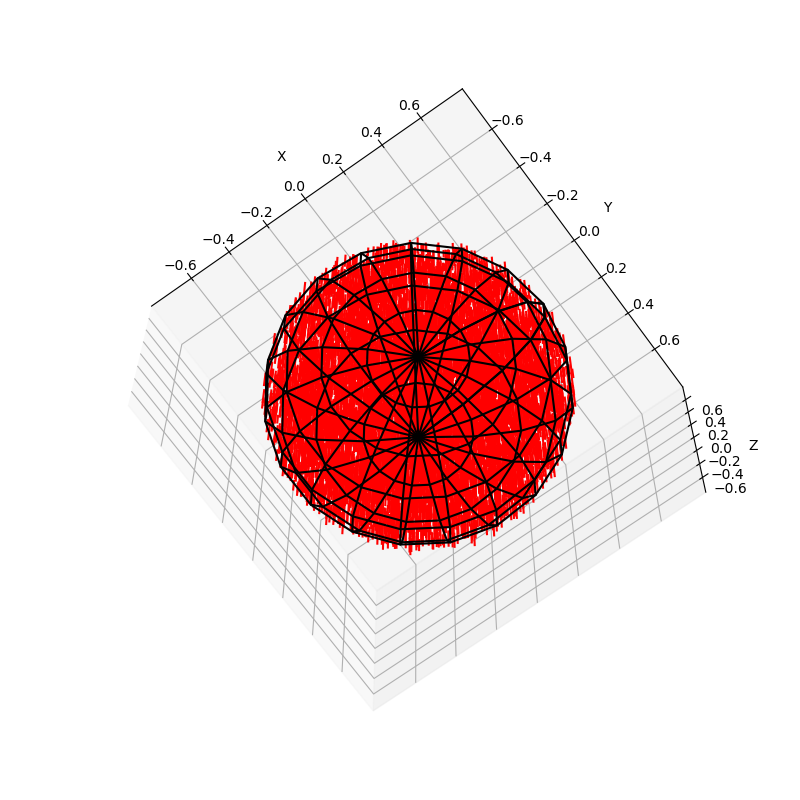

In [32]:
if run_visualization:
    %matplotlib notebook
    fig = plt.subplots(figsize=(8,8))
    ax = plt.axes(projection='3d')

    # Plot filaments
    for fil in f_list:
        fil.Plot3(ax)

    # Plot sphere wireframe
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    ax.plot_wireframe(x, y, z, color="black")

    ax.set_xlim3d(-R-Lmax/2, R+Lmax/2)
    ax.set_ylim3d(-R-Lmax/2, R+Lmax/2)
    ax.set_zlim3d(-R-Lmax/2, R+Lmax/2)
    ax.set(xlabel='X', ylabel='Y', zlabel='Z')

In [12]:
if write_file:
    
    # first offset system
    for fil in f_list:
        fil.pos_start += np.array(system_offset)
        fil.pos_end += np.array(system_offset)
        fil.center += np.array(system_offset)
    filer = open(fname,"w")
    filer.write('# Initial configuration of rods\n#\n')
    for fil in f_list:
        filer.write( fil.GetStringtoWrite() )
    filer.close()

## Tests:

### Minimum distance function:

In [13]:
if run_tests:
    # parallel lines with separation 1 in X
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([1,0,0], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel lines with separation 1 in X and Y
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([1,0,1], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel overlapping lines with only endpoints touching
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([0,0,2], [0,0,1],2)
    print('Expected Distance =   0.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel overlapping lines with one line inside another
    gid=0
    f1 = Filament([0,0,0], [0,0,1],1)
    f2 = Filament([0,0,0], [0,0,1],2)
    print('Expected Distance =   0.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel lines with same XY and separated in Z by 1
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([0,0,3], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))


### Uniform Centers Distribution:

In [22]:
if run_tests:
    xs = []
    ys = []
    zs = []
    rs = []
    thetas = []
    phis=[]
    for k in range(5000):
        center = getRand3PointInSphere(R)
        xs.append( center[0])
        ys.append( center[1])
        zs.append( center[2])
        rpt = cart2sph( center[0], center[1], center[2])
        rs.append( rpt[0])
        thetas.append(rpt[2])
        phis.append(rpt[1])

    %matplotlib inline
    fig,axs = plt.subplots(2,3, figsize=(15, 10), sharey=True,tight_layout=True)
    axs[0,0].hist( xs, bins=10)
    axs[0,0].set(xlabel='X',ylabel='Counts')
    axs[0,1].hist( ys, bins=10)
    axs[0,1].set(xlabel='Y')
    axs[0,2].hist( zs, bins=10)
    axs[0,2].set(xlabel='Z')
    axs[1,0].hist( rs, bins=10)
    axs[1,0].set(xlabel='r',ylabel='Counts')
    axs[1,1].hist( phis, bins=10)
    axs[1,1].set(xlabel='phi')
    axs[1,2].hist( thetas, bins=10)
    axs[1,2].set(xlabel='theta')

    plt.suptitle('test')
    plt.show()
    %matplotlib notebook

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter(xs,ys,zs, marker='.',s=4)

### Length Exponential Distribution:

In [31]:
if run_tests:
    nFil = 100000
    lens = []
    for i in range(nFil):
        lens.append( getLengthRandomExp(rng, Lmean, Lmin, Lmax))

    fig = plt.subplots(figsize=(8,6))
    ax = plt.axes()
    ax.hist( lens, bins=15)

    ax.set(xlabel='Length (micron)', ylabel='Count', title='Exponential distribution (mean = {} micron)'.format(Lmean))